In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepnewbie/flir-thermal-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1


In [3]:
# List files and folders in the dataset directory
import os

files = os.listdir(path)
print("Files and folders in dataset root:")
for f in files:
    print(f)

# Print all folders and subfolders recursively
print("\nAll folders and subfolders:")
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    for d in dirs:
        print(f"  Subfolder: ",d)

Files and folders in dataset root:
FLIR_ADAS_1_3

All folders and subfolders:
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1
  Subfolder:  FLIR_ADAS_1_3
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3
  Subfolder:  train
  Subfolder:  val
  Subfolder:  video
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train
  Subfolder:  Annotated_thermal_8_bit
  Subfolder:  RGB
  Subfolder:  thermal_16_bit
  Subfolder:  thermal_8_bit
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\Annotated_thermal_8_bit
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\RGB
Folder: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\thermal

In [4]:
# Set RGB and thermal image directories for train and val splits
train_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "RGB")
train_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "train", "thermal_8_bit")
val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

print("Train RGB directory:", train_rgb_dir)
print("Train Thermal directory:", train_thermal_dir)
print("Val RGB directory:", val_rgb_dir)
print("Val Thermal directory:", val_thermal_dir)

# Match images by filename prefix (without extension, ignoring extension differences)
def get_matched_files_by_prefix(rgb_dir, thermal_dir):
    rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
    thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
    common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
    matched_rgb = [rgb_prefix[p] for p in common_prefixes]
    matched_thermal = [thermal_prefix[p] for p in common_prefixes]
    return matched_rgb, matched_thermal, common_prefixes

matched_rgb, matched_thermal, matched_prefixes = get_matched_files_by_prefix(train_rgb_dir, train_thermal_dir)
val_matched_rgb, val_matched_thermal, val_matched_prefixes = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)
print(f"Number of matched train RGB images: {len(matched_rgb)}")
print(f"Number of matched train thermal images: {len(matched_thermal)}")
print(f"Number of matched val RGB images: {len(val_matched_rgb)}")
print(f"Number of matched val thermal images: {len(val_matched_thermal)}")

Train RGB directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\RGB
Train Thermal directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\train\thermal_8_bit
Val RGB directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\val\RGB
Val Thermal directory: C:\Users\Admin\.cache\kagglehub\datasets\deepnewbie\flir-thermal-images-dataset\versions\1\FLIR_ADAS_1_3\val\thermal_8_bit
Number of matched train RGB images: 8363
Number of matched train thermal images: 8363
Number of matched val RGB images: 1257
Number of matched val thermal images: 1257


In [5]:
# Define the custom dataset and U-Net model for RGB to thermal translation
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as T

class FLIRRGB2ThermalDataset(Dataset):
    def __init__(self, rgb_dir, thermal_dir, img_size=256, matched_rgb=None, matched_thermal=None):
        self.rgb_dir = rgb_dir
        self.thermal_dir = thermal_dir
        self.img_size = img_size
        # Use matched file lists if provided, else match by prefix
        if matched_rgb is not None and matched_thermal is not None:
            self.rgb_files = matched_rgb
            self.thermal_files = matched_thermal
        else:
            rgb_files = [f for f in os.listdir(rgb_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            thermal_files = [f for f in os.listdir(thermal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            rgb_prefix = {os.path.splitext(f)[0]: f for f in rgb_files}
            thermal_prefix = {os.path.splitext(f)[0]: f for f in thermal_files}
            common_prefixes = sorted(set(rgb_prefix.keys()) & set(thermal_prefix.keys()))
            self.rgb_files = [rgb_prefix[p] for p in common_prefixes]
            self.thermal_files = [thermal_prefix[p] for p in common_prefixes]
        print(f"Paired {len(self.rgb_files)} RGB and thermal images.")
        if len(self.rgb_files) == 0:
            raise ValueError("No matching RGB and thermal image pairs found!")
        self.transform_rgb = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])
        self.transform_thermal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        thermal_path = os.path.join(self.thermal_dir, self.thermal_files[idx])
        rgb = Image.open(rgb_path).convert('RGB')
        thermal = Image.open(thermal_path).convert('L')
        rgb = self.transform_rgb(rgb)
        thermal = self.transform_thermal(thermal)
        return rgb, thermal

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self.conv_block(feature*2, feature))
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                x = T.functional.resize(x, skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)
        return self.final_conv(x)

In [6]:
# Training loop for the U-Net model with diagnostics and quick test mode
def train_model(
    rgb_dir, thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, img_size=256, save_path='unet_rgb2thermal.pth', max_samples=100
):
    import time
    from tqdm import tqdm

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FLIRRGB2ThermalDataset(rgb_dir, thermal_dir, img_size, matched_rgb=matched_rgb, matched_thermal=matched_thermal)
    if max_samples is not None:
        indices = list(range(min(max_samples, len(dataset))))
        from torch.utils.data import Subset
        dataset = Subset(dataset, indices)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    model = UNet().to(device)
    criterion = nn.L1Loss()  # Try nn.MSELoss() for even smoother results
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    train_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for i, (rgb, thermal) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            rgb, thermal = rgb.to(device), thermal.to(device)
            pred = model(rgb)
            loss = criterion(pred, thermal)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * rgb.size(0)
            if (i+1) % 2 == 0:
                print(f"  Batch {i+1}/{len(loader)} - Batch Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Time: {elapsed:.1f}s")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
    print("Training complete. Best model saved.")
    return train_losses

# Example usage:
#train_losses = train_model(train_rgb_dir, train_thermal_dir, matched_rgb, matched_thermal, epochs=10, batch_size=8, lr=5e-4, max_samples=100)

In [7]:
# Retrain the model from scratch
train_losses = train_model(
    train_rgb_dir, 
    train_thermal_dir, 
    matched_rgb, 
    matched_thermal, 
    epochs=10, 
    batch_size=8, 
    lr=5e-4, 
    max_samples=None)

Paired 8363 RGB and thermal images.


Epoch 1:   0%|          | 2/1046 [02:08<18:26:25, 63.59s/it]

  Batch 2/1046 - Batch Loss: 0.4336


Epoch 1:   0%|          | 4/1046 [04:03<17:37:05, 60.87s/it]

  Batch 4/1046 - Batch Loss: 0.2801


Epoch 1:   1%|          | 6/1046 [06:47<21:01:53, 72.80s/it]

  Batch 6/1046 - Batch Loss: 0.2102


Epoch 1:   1%|          | 8/1046 [08:55<19:42:17, 68.34s/it]

  Batch 8/1046 - Batch Loss: 0.1884


Epoch 1:   1%|          | 10/1046 [11:13<19:30:11, 67.77s/it]

  Batch 10/1046 - Batch Loss: 0.1820


Epoch 1:   1%|          | 12/1046 [13:46<20:56:43, 72.92s/it]

  Batch 12/1046 - Batch Loss: 0.2113


Epoch 1:   1%|▏         | 14/1046 [15:11<16:07:40, 56.26s/it]

  Batch 14/1046 - Batch Loss: 0.1851


Epoch 1:   2%|▏         | 16/1046 [17:02<16:15:16, 56.81s/it]

  Batch 16/1046 - Batch Loss: 0.1795


Epoch 1:   2%|▏         | 18/1046 [19:01<16:32:12, 57.91s/it]

  Batch 18/1046 - Batch Loss: 0.1461


Epoch 1:   2%|▏         | 20/1046 [20:03<12:11:28, 42.78s/it]

  Batch 20/1046 - Batch Loss: 0.1449


Epoch 1:   2%|▏         | 22/1046 [20:34<8:14:06, 28.95s/it] 

  Batch 22/1046 - Batch Loss: 0.1501


Epoch 1:   2%|▏         | 24/1046 [22:51<14:25:13, 50.80s/it]

  Batch 24/1046 - Batch Loss: 0.1395


Epoch 1:   2%|▏         | 26/1046 [24:02<12:05:11, 42.66s/it]

  Batch 26/1046 - Batch Loss: 0.1465


Epoch 1:   3%|▎         | 28/1046 [25:24<11:58:59, 42.38s/it]

  Batch 28/1046 - Batch Loss: 0.1466


Epoch 1:   3%|▎         | 30/1046 [26:37<10:45:47, 38.14s/it]

  Batch 30/1046 - Batch Loss: 0.1739


Epoch 1:   3%|▎         | 32/1046 [27:24<8:27:53, 30.05s/it] 

  Batch 32/1046 - Batch Loss: 0.1510


Epoch 1:   3%|▎         | 34/1046 [28:58<10:42:44, 38.11s/it]

  Batch 34/1046 - Batch Loss: 0.1513


Epoch 1:   3%|▎         | 36/1046 [30:12<10:33:47, 37.65s/it]

  Batch 36/1046 - Batch Loss: 0.1356


Epoch 1:   4%|▎         | 38/1046 [31:32<11:05:54, 39.64s/it]

  Batch 38/1046 - Batch Loss: 0.1523


Epoch 1:   4%|▍         | 40/1046 [33:27<14:03:32, 50.31s/it]

  Batch 40/1046 - Batch Loss: 0.1524


Epoch 1:   4%|▍         | 42/1046 [34:52<12:29:01, 44.76s/it]

  Batch 42/1046 - Batch Loss: 0.1577


Epoch 1:   4%|▍         | 44/1046 [35:40<9:39:54, 34.72s/it] 

  Batch 44/1046 - Batch Loss: 0.1619


Epoch 1:   4%|▍         | 46/1046 [36:56<9:53:09, 35.59s/it] 

  Batch 46/1046 - Batch Loss: 0.1501


Epoch 1:   5%|▍         | 48/1046 [37:50<8:48:15, 31.76s/it]

  Batch 48/1046 - Batch Loss: 0.1720


Epoch 1:   5%|▍         | 50/1046 [39:35<11:43:28, 42.38s/it]

  Batch 50/1046 - Batch Loss: 0.1377


Epoch 1:   5%|▍         | 52/1046 [41:02<11:55:55, 43.21s/it]

  Batch 52/1046 - Batch Loss: 0.1515


Epoch 1:   5%|▌         | 54/1046 [42:32<11:59:11, 43.50s/it]

  Batch 54/1046 - Batch Loss: 0.1414


Epoch 1:   5%|▌         | 56/1046 [43:51<11:15:35, 40.94s/it]

  Batch 56/1046 - Batch Loss: 0.1583


Epoch 1:   6%|▌         | 58/1046 [44:33<8:21:07, 30.43s/it] 

  Batch 58/1046 - Batch Loss: 0.1869


Epoch 1:   6%|▌         | 60/1046 [45:49<9:27:49, 34.55s/it]

  Batch 60/1046 - Batch Loss: 0.1697


Epoch 1:   6%|▌         | 62/1046 [47:27<11:30:50, 42.12s/it]

  Batch 62/1046 - Batch Loss: 0.1471


Epoch 1:   6%|▌         | 64/1046 [48:34<10:05:22, 36.99s/it]

  Batch 64/1046 - Batch Loss: 0.1526


Epoch 1:   6%|▋         | 66/1046 [49:07<7:16:31, 26.73s/it] 

  Batch 66/1046 - Batch Loss: 0.1439


Epoch 1:   7%|▋         | 68/1046 [49:39<5:46:47, 21.28s/it]

  Batch 68/1046 - Batch Loss: 0.1496


Epoch 1:   7%|▋         | 70/1046 [50:23<5:42:11, 21.04s/it]

  Batch 70/1046 - Batch Loss: 0.1229


Epoch 1:   7%|▋         | 72/1046 [50:54<4:57:29, 18.33s/it]

  Batch 72/1046 - Batch Loss: 0.1245


Epoch 1:   7%|▋         | 74/1046 [51:28<4:43:07, 17.48s/it]

  Batch 74/1046 - Batch Loss: 0.1419


Epoch 1:   7%|▋         | 76/1046 [52:04<4:47:59, 17.81s/it]

  Batch 76/1046 - Batch Loss: 0.1316


Epoch 1:   7%|▋         | 78/1046 [52:48<5:13:39, 19.44s/it]

  Batch 78/1046 - Batch Loss: 0.1389


Epoch 1:   8%|▊         | 80/1046 [53:20<4:45:05, 17.71s/it]

  Batch 80/1046 - Batch Loss: 0.1289


Epoch 1:   8%|▊         | 82/1046 [54:20<6:40:14, 24.91s/it]

  Batch 82/1046 - Batch Loss: 0.1530


Epoch 1:   8%|▊         | 84/1046 [54:52<5:26:36, 20.37s/it]

  Batch 84/1046 - Batch Loss: 0.1250


Epoch 1:   8%|▊         | 86/1046 [55:23<4:46:14, 17.89s/it]

  Batch 86/1046 - Batch Loss: 0.1442


Epoch 1:   8%|▊         | 88/1046 [55:59<4:46:15, 17.93s/it]

  Batch 88/1046 - Batch Loss: 0.1243


Epoch 1:   9%|▊         | 90/1046 [56:35<4:45:33, 17.92s/it]

  Batch 90/1046 - Batch Loss: 0.1217


Epoch 1:   9%|▉         | 92/1046 [57:06<4:21:05, 16.42s/it]

  Batch 92/1046 - Batch Loss: 0.1355


Epoch 1:   9%|▉         | 94/1046 [57:39<4:22:31, 16.55s/it]

  Batch 94/1046 - Batch Loss: 0.1434


Epoch 1:   9%|▉         | 96/1046 [58:14<4:28:55, 16.98s/it]

  Batch 96/1046 - Batch Loss: 0.1247


Epoch 1:   9%|▉         | 98/1046 [58:48<4:32:50, 17.27s/it]

  Batch 98/1046 - Batch Loss: 0.1391


Epoch 1:  10%|▉         | 100/1046 [59:23<4:30:32, 17.16s/it]

  Batch 100/1046 - Batch Loss: 0.1092


Epoch 1:  10%|▉         | 102/1046 [1:00:11<5:34:10, 21.24s/it]

  Batch 102/1046 - Batch Loss: 0.1253


Epoch 1:  10%|▉         | 104/1046 [1:01:00<5:55:15, 22.63s/it]

  Batch 104/1046 - Batch Loss: 0.1225


Epoch 1:  10%|█         | 106/1046 [1:02:08<7:24:38, 28.38s/it]

  Batch 106/1046 - Batch Loss: 0.1257


Epoch 1:  10%|█         | 108/1046 [1:03:05<7:19:26, 28.11s/it]

  Batch 108/1046 - Batch Loss: 0.1213


Epoch 1:  11%|█         | 110/1046 [1:03:37<5:42:39, 21.97s/it]

  Batch 110/1046 - Batch Loss: 0.1027


Epoch 1:  11%|█         | 112/1046 [1:04:34<6:41:02, 25.76s/it]

  Batch 112/1046 - Batch Loss: 0.1151


Epoch 1:  11%|█         | 114/1046 [1:05:22<6:23:40, 24.70s/it]

  Batch 114/1046 - Batch Loss: 0.1361


Epoch 1:  11%|█         | 116/1046 [1:06:17<6:53:24, 26.67s/it]

  Batch 116/1046 - Batch Loss: 0.1183


Epoch 1:  11%|█▏        | 118/1046 [1:07:16<7:28:17, 28.98s/it]

  Batch 118/1046 - Batch Loss: 0.1175


Epoch 1:  11%|█▏        | 120/1046 [1:08:28<8:21:15, 32.48s/it]

  Batch 120/1046 - Batch Loss: 0.1097


Epoch 1:  12%|█▏        | 122/1046 [1:09:28<7:50:20, 30.54s/it]

  Batch 122/1046 - Batch Loss: 0.1198


Epoch 1:  12%|█▏        | 124/1046 [1:10:32<8:03:27, 31.46s/it]

  Batch 124/1046 - Batch Loss: 0.1097


Epoch 1:  12%|█▏        | 126/1046 [1:11:17<6:49:19, 26.69s/it]

  Batch 126/1046 - Batch Loss: 0.1069


Epoch 1:  12%|█▏        | 128/1046 [1:11:51<5:34:35, 21.87s/it]

  Batch 128/1046 - Batch Loss: 0.1401


Epoch 1:  12%|█▏        | 130/1046 [1:12:28<5:09:00, 20.24s/it]

  Batch 130/1046 - Batch Loss: 0.1097


Epoch 1:  13%|█▎        | 132/1046 [1:13:09<5:12:17, 20.50s/it]

  Batch 132/1046 - Batch Loss: 0.1086


Epoch 1:  13%|█▎        | 134/1046 [1:13:50<5:06:35, 20.17s/it]

  Batch 134/1046 - Batch Loss: 0.1082


Epoch 1:  13%|█▎        | 136/1046 [1:14:24<4:41:53, 18.59s/it]

  Batch 136/1046 - Batch Loss: 0.1133


Epoch 1:  13%|█▎        | 138/1046 [1:14:59<4:32:50, 18.03s/it]

  Batch 138/1046 - Batch Loss: 0.1281


Epoch 1:  13%|█▎        | 140/1046 [1:15:33<4:22:57, 17.41s/it]

  Batch 140/1046 - Batch Loss: 0.1123


Epoch 1:  14%|█▎        | 142/1046 [1:16:21<5:22:21, 21.40s/it]

  Batch 142/1046 - Batch Loss: 0.1127


Epoch 1:  14%|█▍        | 144/1046 [1:16:58<4:58:26, 19.85s/it]

  Batch 144/1046 - Batch Loss: 0.1307


Epoch 1:  14%|█▍        | 146/1046 [1:17:40<4:59:31, 19.97s/it]

  Batch 146/1046 - Batch Loss: 0.1239


Epoch 1:  14%|█▍        | 148/1046 [1:18:24<5:22:57, 21.58s/it]

  Batch 148/1046 - Batch Loss: 0.0912


Epoch 1:  14%|█▍        | 150/1046 [1:19:02<4:58:34, 19.99s/it]

  Batch 150/1046 - Batch Loss: 0.1403


Epoch 1:  15%|█▍        | 152/1046 [1:20:02<6:28:38, 26.08s/it]

  Batch 152/1046 - Batch Loss: 0.1337


Epoch 1:  15%|█▍        | 154/1046 [1:21:02<6:45:10, 27.25s/it]

  Batch 154/1046 - Batch Loss: 0.1069


Epoch 1:  15%|█▍        | 156/1046 [1:22:10<7:19:33, 29.63s/it]

  Batch 156/1046 - Batch Loss: 0.1165


Epoch 1:  15%|█▌        | 158/1046 [1:23:06<7:20:38, 29.77s/it]

  Batch 158/1046 - Batch Loss: 0.0964


Epoch 1:  15%|█▌        | 160/1046 [1:23:56<6:32:34, 26.58s/it]

  Batch 160/1046 - Batch Loss: 0.1258


Epoch 1:  15%|█▌        | 162/1046 [1:24:30<5:18:05, 21.59s/it]

  Batch 162/1046 - Batch Loss: 0.1275


Epoch 1:  16%|█▌        | 164/1046 [1:25:04<4:44:13, 19.33s/it]

  Batch 164/1046 - Batch Loss: 0.1237


Epoch 1:  16%|█▌        | 166/1046 [1:25:37<4:21:18, 17.82s/it]

  Batch 166/1046 - Batch Loss: 0.1063


Epoch 1:  16%|█▌        | 168/1046 [1:26:08<4:05:28, 16.77s/it]

  Batch 168/1046 - Batch Loss: 0.1043


Epoch 1:  16%|█▋        | 170/1046 [1:26:40<3:57:36, 16.27s/it]

  Batch 170/1046 - Batch Loss: 0.1105


Epoch 1:  16%|█▋        | 172/1046 [1:27:10<3:46:32, 15.55s/it]

  Batch 172/1046 - Batch Loss: 0.1068


Epoch 1:  17%|█▋        | 174/1046 [1:27:41<3:48:03, 15.69s/it]

  Batch 174/1046 - Batch Loss: 0.1039


Epoch 1:  17%|█▋        | 176/1046 [1:28:12<3:47:00, 15.66s/it]

  Batch 176/1046 - Batch Loss: 0.1415


Epoch 1:  17%|█▋        | 178/1046 [1:28:46<3:53:48, 16.16s/it]

  Batch 178/1046 - Batch Loss: 0.1169


Epoch 1:  17%|█▋        | 180/1046 [1:29:23<4:15:42, 17.72s/it]

  Batch 180/1046 - Batch Loss: 0.1320


Epoch 1:  17%|█▋        | 182/1046 [1:30:23<5:35:18, 23.29s/it]

  Batch 182/1046 - Batch Loss: 0.1294


Epoch 1:  18%|█▊        | 184/1046 [1:31:05<5:25:36, 22.66s/it]

  Batch 184/1046 - Batch Loss: 0.1276


Epoch 1:  18%|█▊        | 186/1046 [1:31:47<5:17:46, 22.17s/it]

  Batch 186/1046 - Batch Loss: 0.1285


Epoch 1:  18%|█▊        | 188/1046 [1:32:20<4:38:07, 19.45s/it]

  Batch 188/1046 - Batch Loss: 0.0985


Epoch 1:  18%|█▊        | 190/1046 [1:32:54<4:18:57, 18.15s/it]

  Batch 190/1046 - Batch Loss: 0.0978


Epoch 1:  18%|█▊        | 192/1046 [1:33:27<4:06:19, 17.31s/it]

  Batch 192/1046 - Batch Loss: 0.1096


Epoch 1:  19%|█▊        | 194/1046 [1:34:00<4:01:04, 16.98s/it]

  Batch 194/1046 - Batch Loss: 0.1051


Epoch 1:  19%|█▊        | 196/1046 [1:34:33<3:57:51, 16.79s/it]

  Batch 196/1046 - Batch Loss: 0.1147


Epoch 1:  19%|█▉        | 198/1046 [1:35:11<4:15:33, 18.08s/it]

  Batch 198/1046 - Batch Loss: 0.1047


Epoch 1:  19%|█▉        | 200/1046 [1:35:45<4:04:53, 17.37s/it]

  Batch 200/1046 - Batch Loss: 0.1006


Epoch 1:  19%|█▉        | 202/1046 [1:36:19<4:02:14, 17.22s/it]

  Batch 202/1046 - Batch Loss: 0.1123


Epoch 1:  20%|█▉        | 204/1046 [1:36:53<4:00:06, 17.11s/it]

  Batch 204/1046 - Batch Loss: 0.1096


Epoch 1:  20%|█▉        | 206/1046 [1:37:29<4:10:42, 17.91s/it]

  Batch 206/1046 - Batch Loss: 0.0954


Epoch 1:  20%|█▉        | 208/1046 [1:38:04<4:04:57, 17.54s/it]

  Batch 208/1046 - Batch Loss: 0.0971


Epoch 1:  20%|██        | 210/1046 [1:38:38<4:01:26, 17.33s/it]

  Batch 210/1046 - Batch Loss: 0.1115


Epoch 1:  20%|██        | 212/1046 [1:39:36<5:31:51, 23.87s/it]

  Batch 212/1046 - Batch Loss: 0.1176


Epoch 1:  20%|██        | 214/1046 [1:40:16<5:00:13, 21.65s/it]

  Batch 214/1046 - Batch Loss: 0.1032


Epoch 1:  21%|██        | 216/1046 [1:41:01<5:01:40, 21.81s/it]

  Batch 216/1046 - Batch Loss: 0.1009


Epoch 1:  21%|██        | 218/1046 [1:41:36<4:29:41, 19.54s/it]

  Batch 218/1046 - Batch Loss: 0.1053


Epoch 1:  21%|██        | 220/1046 [1:42:16<4:37:11, 20.14s/it]

  Batch 220/1046 - Batch Loss: 0.1171


Epoch 1:  21%|██        | 222/1046 [1:42:55<4:26:08, 19.38s/it]

  Batch 222/1046 - Batch Loss: 0.1297


Epoch 1:  21%|██▏       | 224/1046 [1:43:38<4:34:04, 20.01s/it]

  Batch 224/1046 - Batch Loss: 0.0980


Epoch 1:  22%|██▏       | 226/1046 [1:45:17<7:57:46, 34.96s/it]

  Batch 226/1046 - Batch Loss: 0.1214


Epoch 1:  22%|██▏       | 228/1046 [1:46:35<8:23:45, 36.95s/it]

  Batch 228/1046 - Batch Loss: 0.1232


Epoch 1:  22%|██▏       | 230/1046 [1:48:01<9:04:11, 40.01s/it]

  Batch 230/1046 - Batch Loss: 0.0983


Epoch 1:  22%|██▏       | 232/1046 [1:49:16<8:40:11, 38.34s/it]

  Batch 232/1046 - Batch Loss: 0.1310


Epoch 1:  22%|██▏       | 234/1046 [1:50:16<7:47:07, 34.52s/it]

  Batch 234/1046 - Batch Loss: 0.1023


Epoch 1:  23%|██▎       | 236/1046 [1:51:43<8:45:38, 38.94s/it]

  Batch 236/1046 - Batch Loss: 0.1069


Epoch 1:  23%|██▎       | 238/1046 [1:52:48<8:05:03, 36.02s/it]

  Batch 238/1046 - Batch Loss: 0.0993


Epoch 1:  23%|██▎       | 240/1046 [1:54:14<8:50:34, 39.50s/it]

  Batch 240/1046 - Batch Loss: 0.1071


Epoch 1:  23%|██▎       | 242/1046 [1:55:37<9:06:28, 40.78s/it]

  Batch 242/1046 - Batch Loss: 0.0939


Epoch 1:  23%|██▎       | 244/1046 [1:56:33<7:40:13, 34.43s/it]

  Batch 244/1046 - Batch Loss: 0.1048


Epoch 1:  24%|██▎       | 246/1046 [1:57:42<7:26:07, 33.46s/it]

  Batch 246/1046 - Batch Loss: 0.1047


Epoch 1:  24%|██▎       | 248/1046 [1:58:17<5:33:23, 25.07s/it]

  Batch 248/1046 - Batch Loss: 0.1019


Epoch 1:  24%|██▍       | 250/1046 [1:59:20<6:28:50, 29.31s/it]

  Batch 250/1046 - Batch Loss: 0.1036


Epoch 1:  24%|██▍       | 252/1046 [2:00:37<7:26:15, 33.72s/it]

  Batch 252/1046 - Batch Loss: 0.1036


Epoch 1:  24%|██▍       | 254/1046 [2:01:55<7:57:45, 36.19s/it]

  Batch 254/1046 - Batch Loss: 0.1117


Epoch 1:  24%|██▍       | 256/1046 [2:03:02<7:35:30, 34.59s/it]

  Batch 256/1046 - Batch Loss: 0.1155


Epoch 1:  25%|██▍       | 258/1046 [2:03:46<6:05:36, 27.84s/it]

  Batch 258/1046 - Batch Loss: 0.1231


Epoch 1:  25%|██▍       | 260/1046 [2:04:29<5:14:42, 24.02s/it]

  Batch 260/1046 - Batch Loss: 0.1111


Epoch 1:  25%|██▌       | 262/1046 [2:05:10<4:47:05, 21.97s/it]

  Batch 262/1046 - Batch Loss: 0.1130


Epoch 1:  25%|██▌       | 264/1046 [2:06:19<6:12:43, 28.60s/it]

  Batch 264/1046 - Batch Loss: 0.1086


Epoch 1:  25%|██▌       | 266/1046 [2:07:21<6:28:02, 29.85s/it]

  Batch 266/1046 - Batch Loss: 0.0967


Epoch 1:  26%|██▌       | 268/1046 [2:08:42<7:32:54, 34.93s/it]

  Batch 268/1046 - Batch Loss: 0.1123


Epoch 1:  26%|██▌       | 270/1046 [2:10:08<8:25:08, 39.06s/it]

  Batch 270/1046 - Batch Loss: 0.1027


Epoch 1:  26%|██▌       | 272/1046 [2:11:24<8:13:21, 38.25s/it]

  Batch 272/1046 - Batch Loss: 0.1197


Epoch 1:  26%|██▌       | 274/1046 [2:12:27<7:36:34, 35.49s/it]

  Batch 274/1046 - Batch Loss: 0.1104


Epoch 1:  26%|██▋       | 276/1046 [2:13:49<8:12:52, 38.41s/it]

  Batch 276/1046 - Batch Loss: 0.0951


Epoch 1:  27%|██▋       | 278/1046 [2:14:22<5:47:21, 27.14s/it]

  Batch 278/1046 - Batch Loss: 0.0893


Epoch 1:  27%|██▋       | 280/1046 [2:14:54<4:35:49, 21.60s/it]

  Batch 280/1046 - Batch Loss: 0.1166


Epoch 1:  27%|██▋       | 282/1046 [2:15:28<4:04:24, 19.19s/it]

  Batch 282/1046 - Batch Loss: 0.1100


Epoch 1:  27%|██▋       | 284/1046 [2:16:16<4:31:30, 21.38s/it]

  Batch 284/1046 - Batch Loss: 0.1091


Epoch 1:  27%|██▋       | 286/1046 [2:17:00<4:29:33, 21.28s/it]

  Batch 286/1046 - Batch Loss: 0.1188


Epoch 1:  28%|██▊       | 288/1046 [2:17:43<4:34:10, 21.70s/it]

  Batch 288/1046 - Batch Loss: 0.1033


Epoch 1:  28%|██▊       | 290/1046 [2:18:35<4:51:04, 23.10s/it]

  Batch 290/1046 - Batch Loss: 0.0984


Epoch 1:  28%|██▊       | 292/1046 [2:19:25<5:09:45, 24.65s/it]

  Batch 292/1046 - Batch Loss: 0.1052


Epoch 1:  28%|██▊       | 294/1046 [2:19:58<4:18:12, 20.60s/it]

  Batch 294/1046 - Batch Loss: 0.1017


Epoch 1:  28%|██▊       | 296/1046 [2:20:41<4:16:53, 20.55s/it]

  Batch 296/1046 - Batch Loss: 0.1178


Epoch 1:  28%|██▊       | 298/1046 [2:21:14<3:51:37, 18.58s/it]

  Batch 298/1046 - Batch Loss: 0.1114


Epoch 1:  29%|██▊       | 300/1046 [2:21:56<4:11:28, 20.23s/it]

  Batch 300/1046 - Batch Loss: 0.0998


Epoch 1:  29%|██▉       | 302/1046 [2:22:30<3:48:23, 18.42s/it]

  Batch 302/1046 - Batch Loss: 0.1147


Epoch 1:  29%|██▉       | 304/1046 [2:23:04<3:39:19, 17.74s/it]

  Batch 304/1046 - Batch Loss: 0.1122


Epoch 1:  29%|██▉       | 306/1046 [2:23:46<3:53:01, 18.89s/it]

  Batch 306/1046 - Batch Loss: 0.1131


Epoch 1:  29%|██▉       | 308/1046 [2:24:25<3:59:34, 19.48s/it]

  Batch 308/1046 - Batch Loss: 0.1039


Epoch 1:  30%|██▉       | 310/1046 [2:25:08<4:07:37, 20.19s/it]

  Batch 310/1046 - Batch Loss: 0.1126


Epoch 1:  30%|██▉       | 312/1046 [2:26:06<5:12:21, 25.53s/it]

  Batch 312/1046 - Batch Loss: 0.0885


Epoch 1:  30%|███       | 314/1046 [2:27:08<5:51:56, 28.85s/it]

  Batch 314/1046 - Batch Loss: 0.0972


Epoch 1:  30%|███       | 316/1046 [2:27:52<5:02:35, 24.87s/it]

  Batch 316/1046 - Batch Loss: 0.1162


Epoch 1:  30%|███       | 318/1046 [2:28:25<4:10:37, 20.66s/it]

  Batch 318/1046 - Batch Loss: 0.1163


Epoch 1:  31%|███       | 320/1046 [2:29:00<3:49:38, 18.98s/it]

  Batch 320/1046 - Batch Loss: 0.1125


Epoch 1:  31%|███       | 322/1046 [2:29:55<4:47:21, 23.81s/it]

  Batch 322/1046 - Batch Loss: 0.1079


Epoch 1:  31%|███       | 324/1046 [2:30:29<4:04:25, 20.31s/it]

  Batch 324/1046 - Batch Loss: 0.1123


Epoch 1:  31%|███       | 326/1046 [2:31:22<4:50:58, 24.25s/it]

  Batch 326/1046 - Batch Loss: 0.1123


Epoch 1:  31%|███▏      | 328/1046 [2:32:30<5:48:03, 29.09s/it]

  Batch 328/1046 - Batch Loss: 0.1015


Epoch 1:  32%|███▏      | 330/1046 [2:33:04<4:33:17, 22.90s/it]

  Batch 330/1046 - Batch Loss: 0.0967


Epoch 1:  32%|███▏      | 332/1046 [2:33:37<3:54:01, 19.67s/it]

  Batch 332/1046 - Batch Loss: 0.1074


Epoch 1:  32%|███▏      | 334/1046 [2:34:11<3:37:25, 18.32s/it]

  Batch 334/1046 - Batch Loss: 0.1202


Epoch 1:  32%|███▏      | 336/1046 [2:34:44<3:26:10, 17.42s/it]

  Batch 336/1046 - Batch Loss: 0.1171


Epoch 1:  32%|███▏      | 338/1046 [2:35:29<4:02:25, 20.55s/it]

  Batch 338/1046 - Batch Loss: 0.0902


Epoch 1:  33%|███▎      | 340/1046 [2:36:15<4:11:08, 21.34s/it]

  Batch 340/1046 - Batch Loss: 0.0996


Epoch 1:  33%|███▎      | 342/1046 [2:37:26<5:28:01, 27.96s/it]

  Batch 342/1046 - Batch Loss: 0.0866


Epoch 1:  33%|███▎      | 344/1046 [2:38:52<6:54:40, 35.44s/it]

  Batch 344/1046 - Batch Loss: 0.1102


Epoch 1:  33%|███▎      | 346/1046 [2:39:43<6:01:21, 30.97s/it]

  Batch 346/1046 - Batch Loss: 0.1012


Epoch 1:  33%|███▎      | 348/1046 [2:40:42<6:04:45, 31.35s/it]

  Batch 348/1046 - Batch Loss: 0.0925


Epoch 1:  33%|███▎      | 350/1046 [2:41:42<5:53:01, 30.43s/it]

  Batch 350/1046 - Batch Loss: 0.1126


Epoch 1:  34%|███▎      | 352/1046 [2:42:27<5:06:50, 26.53s/it]

  Batch 352/1046 - Batch Loss: 0.1086


Epoch 1:  34%|███▍      | 354/1046 [2:43:45<6:17:29, 32.73s/it]

  Batch 354/1046 - Batch Loss: 0.0897


Epoch 1:  34%|███▍      | 356/1046 [2:45:22<7:32:23, 39.34s/it]

  Batch 356/1046 - Batch Loss: 0.1263


Epoch 1:  34%|███▍      | 358/1046 [2:46:28<6:58:57, 36.54s/it]

  Batch 358/1046 - Batch Loss: 0.1383


Epoch 1:  34%|███▍      | 360/1046 [2:47:23<5:54:10, 30.98s/it]

  Batch 360/1046 - Batch Loss: 0.1172


Epoch 1:  35%|███▍      | 362/1046 [2:48:16<5:37:08, 29.57s/it]

  Batch 362/1046 - Batch Loss: 0.1108


Epoch 1:  35%|███▍      | 364/1046 [2:49:42<6:52:24, 36.28s/it]

  Batch 364/1046 - Batch Loss: 0.1088


Epoch 1:  35%|███▍      | 366/1046 [2:51:13<7:42:08, 40.78s/it]

  Batch 366/1046 - Batch Loss: 0.1094


Epoch 1:  35%|███▌      | 368/1046 [2:52:24<7:06:20, 37.73s/it]

  Batch 368/1046 - Batch Loss: 0.1055


Epoch 1:  35%|███▌      | 370/1046 [2:52:57<5:04:11, 27.00s/it]

  Batch 370/1046 - Batch Loss: 0.1169


Epoch 1:  36%|███▌      | 372/1046 [2:53:33<4:11:33, 22.39s/it]

  Batch 372/1046 - Batch Loss: 0.1019


Epoch 1:  36%|███▌      | 374/1046 [2:54:11<3:49:19, 20.48s/it]

  Batch 374/1046 - Batch Loss: 0.0891


Epoch 1:  36%|███▌      | 376/1046 [2:54:59<4:15:54, 22.92s/it]

  Batch 376/1046 - Batch Loss: 0.0961


Epoch 1:  36%|███▌      | 378/1046 [2:55:52<4:26:25, 23.93s/it]

  Batch 378/1046 - Batch Loss: 0.0969


Epoch 1:  36%|███▋      | 380/1046 [2:56:43<4:25:58, 23.96s/it]

  Batch 380/1046 - Batch Loss: 0.1086


Epoch 1:  37%|███▋      | 382/1046 [2:57:41<4:51:24, 26.33s/it]

  Batch 382/1046 - Batch Loss: 0.1168


Epoch 1:  37%|███▋      | 384/1046 [2:58:33<4:46:01, 25.92s/it]

  Batch 384/1046 - Batch Loss: 0.1173


Epoch 1:  37%|███▋      | 386/1046 [2:59:43<5:34:18, 30.39s/it]

  Batch 386/1046 - Batch Loss: 0.1053


Epoch 1:  37%|███▋      | 388/1046 [3:00:16<4:14:28, 23.20s/it]

  Batch 388/1046 - Batch Loss: 0.1176


Epoch 1:  37%|███▋      | 390/1046 [3:01:10<4:25:29, 24.28s/it]

  Batch 390/1046 - Batch Loss: 0.0944


Epoch 1:  37%|███▋      | 392/1046 [3:01:45<3:46:54, 20.82s/it]

  Batch 392/1046 - Batch Loss: 0.1061


Epoch 1:  38%|███▊      | 394/1046 [3:02:17<3:20:43, 18.47s/it]

  Batch 394/1046 - Batch Loss: 0.0893


Epoch 1:  38%|███▊      | 396/1046 [3:03:31<5:10:46, 28.69s/it]

  Batch 396/1046 - Batch Loss: 0.0955


Epoch 1:  38%|███▊      | 398/1046 [3:04:27<5:04:22, 28.18s/it]

  Batch 398/1046 - Batch Loss: 0.1025


Epoch 1:  38%|███▊      | 400/1046 [3:05:25<5:05:13, 28.35s/it]

  Batch 400/1046 - Batch Loss: 0.0999


Epoch 1:  38%|███▊      | 402/1046 [3:06:09<4:26:12, 24.80s/it]

  Batch 402/1046 - Batch Loss: 0.0977


Epoch 1:  39%|███▊      | 404/1046 [3:07:33<6:03:22, 33.96s/it]

  Batch 404/1046 - Batch Loss: 0.0875


Epoch 1:  39%|███▉      | 406/1046 [3:08:49<6:20:55, 35.71s/it]

  Batch 406/1046 - Batch Loss: 0.0930


Epoch 1:  39%|███▉      | 408/1046 [3:09:48<5:41:57, 32.16s/it]

  Batch 408/1046 - Batch Loss: 0.0879


Epoch 1:  39%|███▉      | 410/1046 [3:10:45<5:25:25, 30.70s/it]

  Batch 410/1046 - Batch Loss: 0.1019


Epoch 1:  39%|███▉      | 412/1046 [3:11:22<4:17:45, 24.39s/it]

  Batch 412/1046 - Batch Loss: 0.1000


Epoch 1:  40%|███▉      | 414/1046 [3:11:58<3:42:55, 21.16s/it]

  Batch 414/1046 - Batch Loss: 0.1057


Epoch 1:  40%|███▉      | 416/1046 [3:12:33<3:23:16, 19.36s/it]

  Batch 416/1046 - Batch Loss: 0.1222


Epoch 1:  40%|███▉      | 418/1046 [3:13:10<3:15:57, 18.72s/it]

  Batch 418/1046 - Batch Loss: 0.0927


Epoch 1:  40%|████      | 420/1046 [3:13:47<3:15:02, 18.69s/it]

  Batch 420/1046 - Batch Loss: 0.1077


Epoch 1:  40%|████      | 422/1046 [3:14:24<3:13:35, 18.62s/it]

  Batch 422/1046 - Batch Loss: 0.1155


Epoch 1:  41%|████      | 424/1046 [3:15:02<3:14:22, 18.75s/it]

  Batch 424/1046 - Batch Loss: 0.1002


Epoch 1:  41%|████      | 426/1046 [3:15:37<3:06:41, 18.07s/it]

  Batch 426/1046 - Batch Loss: 0.1175


Epoch 1:  41%|████      | 428/1046 [3:16:07<2:51:10, 16.62s/it]

  Batch 428/1046 - Batch Loss: 0.0932


Epoch 1:  41%|████      | 430/1046 [3:16:42<2:54:30, 17.00s/it]

  Batch 430/1046 - Batch Loss: 0.1114


Epoch 1:  41%|████▏     | 432/1046 [3:17:14<2:49:15, 16.54s/it]

  Batch 432/1046 - Batch Loss: 0.1005


Epoch 1:  41%|████▏     | 434/1046 [3:17:47<2:46:46, 16.35s/it]

  Batch 434/1046 - Batch Loss: 0.1021


Epoch 1:  42%|████▏     | 436/1046 [3:18:19<2:45:30, 16.28s/it]

  Batch 436/1046 - Batch Loss: 0.1107


Epoch 1:  42%|████▏     | 438/1046 [3:18:52<2:44:32, 16.24s/it]

  Batch 438/1046 - Batch Loss: 0.1093


Epoch 1:  42%|████▏     | 440/1046 [3:19:24<2:44:37, 16.30s/it]

  Batch 440/1046 - Batch Loss: 0.1093


Epoch 1:  42%|████▏     | 442/1046 [3:19:57<2:43:24, 16.23s/it]

  Batch 442/1046 - Batch Loss: 0.1149


Epoch 1:  42%|████▏     | 444/1046 [3:20:28<2:38:30, 15.80s/it]

  Batch 444/1046 - Batch Loss: 0.1062


Epoch 1:  43%|████▎     | 446/1046 [3:20:58<2:33:36, 15.36s/it]

  Batch 446/1046 - Batch Loss: 0.1031


Epoch 1:  43%|████▎     | 448/1046 [3:21:30<2:36:36, 15.71s/it]

  Batch 448/1046 - Batch Loss: 0.1076


Epoch 1:  43%|████▎     | 450/1046 [3:22:02<2:38:00, 15.91s/it]

  Batch 450/1046 - Batch Loss: 0.0924


Epoch 1:  43%|████▎     | 452/1046 [3:22:32<2:31:56, 15.35s/it]

  Batch 452/1046 - Batch Loss: 0.0981


Epoch 1:  43%|████▎     | 454/1046 [3:23:01<2:26:54, 14.89s/it]

  Batch 454/1046 - Batch Loss: 0.0950


Epoch 1:  44%|████▎     | 456/1046 [3:23:34<2:34:49, 15.74s/it]

  Batch 456/1046 - Batch Loss: 0.1184


Epoch 1:  44%|████▍     | 458/1046 [3:24:06<2:36:27, 15.97s/it]

  Batch 458/1046 - Batch Loss: 0.1009


Epoch 1:  44%|████▍     | 460/1046 [3:24:41<2:41:44, 16.56s/it]

  Batch 460/1046 - Batch Loss: 0.1100


Epoch 1:  44%|████▍     | 462/1046 [3:25:12<2:33:22, 15.76s/it]

  Batch 462/1046 - Batch Loss: 0.1086


Epoch 1:  44%|████▍     | 464/1046 [5:10:50<308:26:20, 1907.87s/it]

  Batch 464/1046 - Batch Loss: 0.0959


Epoch 1:  45%|████▍     | 466/1046 [5:11:34<152:19:47, 945.50s/it] 

  Batch 466/1046 - Batch Loss: 0.0869


Epoch 1:  45%|████▍     | 468/1046 [5:12:03<75:33:58, 470.65s/it] 

  Batch 468/1046 - Batch Loss: 0.1034


Epoch 1:  45%|████▍     | 470/1046 [5:12:31<38:03:01, 237.81s/it]

  Batch 470/1046 - Batch Loss: 0.1092


Epoch 1:  45%|████▌     | 472/1046 [5:12:59<19:42:54, 123.65s/it]

  Batch 472/1046 - Batch Loss: 0.1252


Epoch 1:  45%|████▌     | 474/1046 [5:13:27<10:45:24, 67.70s/it] 

  Batch 474/1046 - Batch Loss: 0.0983


Epoch 1:  46%|████▌     | 476/1046 [5:14:34<8:05:45, 51.13s/it] 

  Batch 476/1046 - Batch Loss: 0.1125


Epoch 1:  46%|████▌     | 478/1046 [5:16:42<9:07:58, 57.88s/it]

  Batch 478/1046 - Batch Loss: 0.1184


Epoch 1:  46%|████▌     | 480/1046 [5:18:02<7:35:32, 48.29s/it]

  Batch 480/1046 - Batch Loss: 0.0922


Epoch 1:  46%|████▌     | 482/1046 [5:19:11<6:25:56, 41.06s/it]

  Batch 482/1046 - Batch Loss: 0.1089


Epoch 1:  46%|████▋     | 484/1046 [5:20:19<5:49:45, 37.34s/it]

  Batch 484/1046 - Batch Loss: 0.1194


Epoch 1:  46%|████▋     | 486/1046 [5:21:24<5:27:35, 35.10s/it]

  Batch 486/1046 - Batch Loss: 0.1245


Epoch 1:  47%|████▋     | 488/1046 [5:22:29<5:14:02, 33.77s/it]

  Batch 488/1046 - Batch Loss: 0.1164


Epoch 1:  47%|████▋     | 490/1046 [5:23:44<5:30:58, 35.72s/it]

  Batch 490/1046 - Batch Loss: 0.0900


Epoch 1:  47%|████▋     | 492/1046 [5:25:01<5:41:23, 36.97s/it]

  Batch 492/1046 - Batch Loss: 0.1170


Epoch 1:  47%|████▋     | 494/1046 [5:26:17<5:47:04, 37.73s/it]

  Batch 494/1046 - Batch Loss: 0.1093


Epoch 1:  47%|████▋     | 496/1046 [5:27:34<5:47:46, 37.94s/it]

  Batch 496/1046 - Batch Loss: 0.1089


Epoch 1:  48%|████▊     | 498/1046 [5:28:35<5:05:19, 33.43s/it]

  Batch 498/1046 - Batch Loss: 0.1195


Epoch 1:  48%|████▊     | 500/1046 [5:29:24<4:18:53, 28.45s/it]

  Batch 500/1046 - Batch Loss: 0.1389


Epoch 1:  48%|████▊     | 502/1046 [5:29:54<3:15:27, 21.56s/it]

  Batch 502/1046 - Batch Loss: 0.1225


Epoch 1:  48%|████▊     | 504/1046 [5:30:25<2:48:51, 18.69s/it]

  Batch 504/1046 - Batch Loss: 0.0934


Epoch 1:  48%|████▊     | 506/1046 [5:31:09<2:58:02, 19.78s/it]

  Batch 506/1046 - Batch Loss: 0.1099


Epoch 1:  49%|████▊     | 508/1046 [5:31:56<3:13:19, 21.56s/it]

  Batch 508/1046 - Batch Loss: 0.1106


Epoch 1:  49%|████▉     | 510/1046 [5:32:54<3:40:56, 24.73s/it]

  Batch 510/1046 - Batch Loss: 0.1048


Epoch 1:  49%|████▉     | 512/1046 [5:33:34<3:23:24, 22.85s/it]

  Batch 512/1046 - Batch Loss: 0.1152


Epoch 1:  49%|████▉     | 514/1046 [5:34:04<2:47:45, 18.92s/it]

  Batch 514/1046 - Batch Loss: 0.1156


Epoch 1:  49%|████▉     | 516/1046 [5:34:36<2:34:39, 17.51s/it]

  Batch 516/1046 - Batch Loss: 0.0903


Epoch 1:  50%|████▉     | 518/1046 [5:35:25<2:57:48, 20.20s/it]

  Batch 518/1046 - Batch Loss: 0.0951


Epoch 1:  50%|████▉     | 520/1046 [5:36:08<2:59:14, 20.45s/it]

  Batch 520/1046 - Batch Loss: 0.0950


Epoch 1:  50%|████▉     | 522/1046 [5:37:01<3:33:23, 24.43s/it]

  Batch 522/1046 - Batch Loss: 0.1275


Epoch 1:  50%|█████     | 524/1046 [5:38:17<4:29:43, 31.00s/it]

  Batch 524/1046 - Batch Loss: 0.1415


Epoch 1:  50%|█████     | 526/1046 [5:38:59<3:46:17, 26.11s/it]

  Batch 526/1046 - Batch Loss: 0.1074


Epoch 1:  50%|█████     | 528/1046 [5:40:00<4:02:40, 28.11s/it]

  Batch 528/1046 - Batch Loss: 0.0921


Epoch 1:  51%|█████     | 530/1046 [5:41:02<4:14:49, 29.63s/it]

  Batch 530/1046 - Batch Loss: 0.1245


Epoch 1:  51%|█████     | 532/1046 [5:42:10<4:34:45, 32.07s/it]

  Batch 532/1046 - Batch Loss: 0.1138


Epoch 1:  51%|█████     | 534/1046 [5:43:17<4:41:39, 33.01s/it]

  Batch 534/1046 - Batch Loss: 0.1137


Epoch 1:  51%|█████     | 536/1046 [5:44:23<4:42:35, 33.25s/it]

  Batch 536/1046 - Batch Loss: 0.1030


Epoch 1:  51%|█████▏    | 538/1046 [5:45:09<3:50:50, 27.27s/it]

  Batch 538/1046 - Batch Loss: 0.0907


Epoch 1:  52%|█████▏    | 540/1046 [5:46:00<3:51:55, 27.50s/it]

  Batch 540/1046 - Batch Loss: 0.1072


Epoch 1:  52%|█████▏    | 542/1046 [5:47:42<5:32:25, 39.57s/it]

  Batch 542/1046 - Batch Loss: 0.1071


Epoch 1:  52%|█████▏    | 544/1046 [5:49:10<5:48:26, 41.65s/it]

  Batch 544/1046 - Batch Loss: 0.0977


Epoch 1:  52%|█████▏    | 546/1046 [5:50:01<4:36:19, 33.16s/it]

  Batch 546/1046 - Batch Loss: 0.1315


Epoch 1:  52%|█████▏    | 548/1046 [5:51:07<4:36:04, 33.26s/it]

  Batch 548/1046 - Batch Loss: 0.0979


Epoch 1:  53%|█████▎    | 550/1046 [5:52:15<4:37:18, 33.55s/it]

  Batch 550/1046 - Batch Loss: 0.1097


Epoch 1:  53%|█████▎    | 552/1046 [5:53:21<4:34:23, 33.33s/it]

  Batch 552/1046 - Batch Loss: 0.1054


Epoch 1:  53%|█████▎    | 554/1046 [5:54:27<4:31:25, 33.10s/it]

  Batch 554/1046 - Batch Loss: 0.1095


Epoch 1:  53%|█████▎    | 556/1046 [5:55:38<4:39:40, 34.25s/it]

  Batch 556/1046 - Batch Loss: 0.1163


Epoch 1:  53%|█████▎    | 558/1046 [5:56:49<4:44:26, 34.97s/it]

  Batch 558/1046 - Batch Loss: 0.0912


Epoch 1:  54%|█████▎    | 560/1046 [5:58:01<4:48:03, 35.56s/it]

  Batch 560/1046 - Batch Loss: 0.1017


Epoch 1:  54%|█████▎    | 562/1046 [5:59:13<4:49:13, 35.85s/it]

  Batch 562/1046 - Batch Loss: 0.1027


Epoch 1:  54%|█████▍    | 564/1046 [6:00:24<4:45:48, 35.58s/it]

  Batch 564/1046 - Batch Loss: 0.0893


Epoch 1:  54%|█████▍    | 566/1046 [6:01:37<4:49:02, 36.13s/it]

  Batch 566/1046 - Batch Loss: 0.1177


Epoch 1:  54%|█████▍    | 568/1046 [6:02:49<4:46:11, 35.92s/it]

  Batch 568/1046 - Batch Loss: 0.0901


Epoch 1:  54%|█████▍    | 570/1046 [6:04:00<4:44:29, 35.86s/it]

  Batch 570/1046 - Batch Loss: 0.0971


Epoch 1:  55%|█████▍    | 572/1046 [6:05:12<4:43:29, 35.89s/it]

  Batch 572/1046 - Batch Loss: 0.0898


Epoch 1:  55%|█████▍    | 574/1046 [6:06:24<4:42:13, 35.88s/it]

  Batch 574/1046 - Batch Loss: 0.1080


Epoch 1:  55%|█████▌    | 576/1046 [6:07:36<4:41:44, 35.97s/it]

  Batch 576/1046 - Batch Loss: 0.0869


Epoch 1:  55%|█████▌    | 578/1046 [6:08:48<4:39:27, 35.83s/it]

  Batch 578/1046 - Batch Loss: 0.1167


Epoch 1:  55%|█████▌    | 580/1046 [6:10:01<4:40:51, 36.16s/it]

  Batch 580/1046 - Batch Loss: 0.1024


Epoch 1:  56%|█████▌    | 582/1046 [6:11:11<4:35:29, 35.62s/it]

  Batch 582/1046 - Batch Loss: 0.1013


Epoch 1:  56%|█████▌    | 584/1046 [6:12:20<4:28:38, 34.89s/it]

  Batch 584/1046 - Batch Loss: 0.0999


Epoch 1:  56%|█████▌    | 586/1046 [6:13:28<4:24:01, 34.44s/it]

  Batch 586/1046 - Batch Loss: 0.0920


Epoch 1:  56%|█████▌    | 588/1046 [6:14:35<4:20:17, 34.10s/it]

  Batch 588/1046 - Batch Loss: 0.1031


Epoch 1:  56%|█████▋    | 590/1046 [6:15:43<4:17:58, 33.95s/it]

  Batch 590/1046 - Batch Loss: 0.0893


Epoch 1:  57%|█████▋    | 592/1046 [6:17:06<4:45:05, 37.68s/it]

  Batch 592/1046 - Batch Loss: 0.0984


Epoch 1:  57%|█████▋    | 594/1046 [6:18:13<4:27:36, 35.52s/it]

  Batch 594/1046 - Batch Loss: 0.0934


Epoch 1:  57%|█████▋    | 596/1046 [6:19:15<4:09:05, 33.21s/it]

  Batch 596/1046 - Batch Loss: 0.0938


Epoch 1:  57%|█████▋    | 598/1046 [6:20:18<4:00:52, 32.26s/it]

  Batch 598/1046 - Batch Loss: 0.1001


Epoch 1:  57%|█████▋    | 600/1046 [6:21:20<3:55:30, 31.68s/it]

  Batch 600/1046 - Batch Loss: 0.0954


Epoch 1:  58%|█████▊    | 602/1046 [6:22:24<3:56:50, 32.01s/it]

  Batch 602/1046 - Batch Loss: 0.1095


Epoch 1:  58%|█████▊    | 604/1046 [6:23:28<3:55:15, 31.94s/it]

  Batch 604/1046 - Batch Loss: 0.0987


Epoch 1:  58%|█████▊    | 606/1046 [6:24:54<4:37:44, 37.87s/it]

  Batch 606/1046 - Batch Loss: 0.0948


Epoch 1:  58%|█████▊    | 608/1046 [6:25:56<4:12:49, 34.63s/it]

  Batch 608/1046 - Batch Loss: 0.0968


Epoch 1:  58%|█████▊    | 610/1046 [6:27:02<4:05:12, 33.74s/it]

  Batch 610/1046 - Batch Loss: 0.0992


Epoch 1:  59%|█████▊    | 612/1046 [6:28:12<4:11:03, 34.71s/it]

  Batch 612/1046 - Batch Loss: 0.1044


Epoch 1:  59%|█████▊    | 614/1046 [6:29:22<4:10:19, 34.77s/it]

  Batch 614/1046 - Batch Loss: 0.1019


Epoch 1:  59%|█████▉    | 616/1046 [6:30:46<4:35:06, 38.39s/it]

  Batch 616/1046 - Batch Loss: 0.1167


Epoch 1:  59%|█████▉    | 618/1046 [6:31:54<4:16:10, 35.91s/it]

  Batch 618/1046 - Batch Loss: 0.1105


Epoch 1:  59%|█████▉    | 620/1046 [6:33:17<4:36:39, 38.97s/it]

  Batch 620/1046 - Batch Loss: 0.1237


Epoch 1:  59%|█████▉    | 622/1046 [6:34:26<4:21:00, 36.94s/it]

  Batch 622/1046 - Batch Loss: 0.0934


Epoch 1:  60%|█████▉    | 624/1046 [6:35:39<4:16:47, 36.51s/it]

  Batch 624/1046 - Batch Loss: 0.1001


Epoch 1:  60%|█████▉    | 626/1046 [6:36:51<4:13:00, 36.14s/it]

  Batch 626/1046 - Batch Loss: 0.1010


Epoch 1:  60%|██████    | 628/1046 [6:38:07<4:18:20, 37.08s/it]

  Batch 628/1046 - Batch Loss: 0.1045


Epoch 1:  60%|██████    | 630/1046 [6:39:20<4:15:07, 36.80s/it]

  Batch 630/1046 - Batch Loss: 0.0926


Epoch 1:  60%|██████    | 632/1046 [6:40:36<4:20:56, 37.82s/it]

  Batch 632/1046 - Batch Loss: 0.1043


Epoch 1:  61%|██████    | 634/1046 [6:41:49<4:13:24, 36.90s/it]

  Batch 634/1046 - Batch Loss: 0.0819


Epoch 1:  61%|██████    | 636/1046 [6:43:16<4:35:13, 40.28s/it]

  Batch 636/1046 - Batch Loss: 0.1003


Epoch 1:  61%|██████    | 638/1046 [6:44:29<4:22:06, 38.55s/it]

  Batch 638/1046 - Batch Loss: 0.1019


Epoch 1:  61%|██████    | 640/1046 [6:45:33<3:58:14, 35.21s/it]

  Batch 640/1046 - Batch Loss: 0.1268


Epoch 1:  61%|██████▏   | 642/1046 [6:46:34<3:42:54, 33.10s/it]

  Batch 642/1046 - Batch Loss: 0.1145


Epoch 1:  62%|██████▏   | 644/1046 [6:47:46<3:49:52, 34.31s/it]

  Batch 644/1046 - Batch Loss: 0.0995


Epoch 1:  62%|██████▏   | 646/1046 [6:48:54<3:47:33, 34.13s/it]

  Batch 646/1046 - Batch Loss: 0.0968


Epoch 1:  62%|██████▏   | 648/1046 [6:50:01<3:44:05, 33.78s/it]

  Batch 648/1046 - Batch Loss: 0.0820


Epoch 1:  62%|██████▏   | 650/1046 [6:51:07<3:41:07, 33.50s/it]

  Batch 650/1046 - Batch Loss: 0.1022


Epoch 1:  62%|██████▏   | 652/1046 [6:52:13<3:38:04, 33.21s/it]

  Batch 652/1046 - Batch Loss: 0.1320


Epoch 1:  63%|██████▎   | 654/1046 [6:53:20<3:38:26, 33.44s/it]

  Batch 654/1046 - Batch Loss: 0.0843


Epoch 1:  63%|██████▎   | 656/1046 [6:54:28<3:40:21, 33.90s/it]

  Batch 656/1046 - Batch Loss: 0.0947


Epoch 1:  63%|██████▎   | 658/1046 [6:55:37<3:41:06, 34.19s/it]

  Batch 658/1046 - Batch Loss: 0.1001


Epoch 1:  63%|██████▎   | 660/1046 [6:56:46<3:40:54, 34.34s/it]

  Batch 660/1046 - Batch Loss: 0.0828


Epoch 1:  63%|██████▎   | 662/1046 [6:57:56<3:41:17, 34.58s/it]

  Batch 662/1046 - Batch Loss: 0.0931


Epoch 1:  63%|██████▎   | 664/1046 [6:59:34<4:27:31, 42.02s/it]

  Batch 664/1046 - Batch Loss: 0.0852


Epoch 1:  64%|██████▎   | 666/1046 [7:00:44<4:02:21, 38.27s/it]

  Batch 666/1046 - Batch Loss: 0.0922


Epoch 1:  64%|██████▍   | 668/1046 [7:01:54<3:51:05, 36.68s/it]

  Batch 668/1046 - Batch Loss: 0.0982


Epoch 1:  64%|██████▍   | 670/1046 [7:03:03<3:41:40, 35.37s/it]

  Batch 670/1046 - Batch Loss: 0.0942


Epoch 1:  64%|██████▍   | 672/1046 [7:04:13<3:38:41, 35.08s/it]

  Batch 672/1046 - Batch Loss: 0.0913


Epoch 1:  64%|██████▍   | 674/1046 [7:05:20<3:32:16, 34.24s/it]

  Batch 674/1046 - Batch Loss: 0.1171


Epoch 1:  65%|██████▍   | 676/1046 [7:06:22<3:19:49, 32.40s/it]

  Batch 676/1046 - Batch Loss: 0.1021


Epoch 1:  65%|██████▍   | 678/1046 [7:07:34<3:28:42, 34.03s/it]

  Batch 678/1046 - Batch Loss: 0.0950


Epoch 1:  65%|██████▌   | 680/1046 [7:08:41<3:26:07, 33.79s/it]

  Batch 680/1046 - Batch Loss: 0.1022


Epoch 1:  65%|██████▌   | 682/1046 [7:09:51<3:27:32, 34.21s/it]

  Batch 682/1046 - Batch Loss: 0.1025


Epoch 1:  65%|██████▌   | 684/1046 [7:11:00<3:27:52, 34.46s/it]

  Batch 684/1046 - Batch Loss: 0.0970


Epoch 1:  66%|██████▌   | 686/1046 [7:12:14<3:34:42, 35.78s/it]

  Batch 686/1046 - Batch Loss: 0.0949


Epoch 1:  66%|██████▌   | 688/1046 [7:13:24<3:30:37, 35.30s/it]

  Batch 688/1046 - Batch Loss: 0.1297


Epoch 1:  66%|██████▌   | 690/1046 [7:14:35<3:30:23, 35.46s/it]

  Batch 690/1046 - Batch Loss: 0.0956


Epoch 1:  66%|██████▌   | 692/1046 [7:15:44<3:26:28, 35.00s/it]

  Batch 692/1046 - Batch Loss: 0.1075


Epoch 1:  66%|██████▋   | 694/1046 [7:16:54<3:25:38, 35.05s/it]

  Batch 694/1046 - Batch Loss: 0.1073


Epoch 1:  67%|██████▋   | 696/1046 [7:18:08<3:31:47, 36.31s/it]

  Batch 696/1046 - Batch Loss: 0.0846


Epoch 1:  67%|██████▋   | 698/1046 [7:19:25<3:36:56, 37.40s/it]

  Batch 698/1046 - Batch Loss: 0.1138


Epoch 1:  67%|██████▋   | 700/1046 [7:20:35<3:29:23, 36.31s/it]

  Batch 700/1046 - Batch Loss: 0.0983


Epoch 1:  67%|██████▋   | 702/1046 [7:21:45<3:23:05, 35.42s/it]

  Batch 702/1046 - Batch Loss: 0.1248


Epoch 1:  67%|██████▋   | 704/1046 [7:22:55<3:21:23, 35.33s/it]

  Batch 704/1046 - Batch Loss: 0.0985


Epoch 1:  67%|██████▋   | 706/1046 [7:24:09<3:25:03, 36.19s/it]

  Batch 706/1046 - Batch Loss: 0.1212


Epoch 1:  68%|██████▊   | 708/1046 [7:25:20<3:21:46, 35.82s/it]

  Batch 708/1046 - Batch Loss: 0.0895


Epoch 1:  68%|██████▊   | 710/1046 [7:26:28<3:15:49, 34.97s/it]

  Batch 710/1046 - Batch Loss: 0.0878


Epoch 1:  68%|██████▊   | 712/1046 [7:27:36<3:12:07, 34.51s/it]

  Batch 712/1046 - Batch Loss: 0.1165


Epoch 1:  68%|██████▊   | 714/1046 [7:28:44<3:08:58, 34.15s/it]

  Batch 714/1046 - Batch Loss: 0.1055


Epoch 1:  68%|██████▊   | 716/1046 [7:29:54<3:11:06, 34.75s/it]

  Batch 716/1046 - Batch Loss: 0.0969


Epoch 1:  69%|██████▊   | 718/1046 [7:31:07<3:15:10, 35.70s/it]

  Batch 718/1046 - Batch Loss: 0.1033


Epoch 1:  69%|██████▉   | 720/1046 [7:32:23<3:19:02, 36.63s/it]

  Batch 720/1046 - Batch Loss: 0.0982


Epoch 1:  69%|██████▉   | 722/1046 [7:33:31<3:09:32, 35.10s/it]

  Batch 722/1046 - Batch Loss: 0.0883


Epoch 1:  69%|██████▉   | 724/1046 [7:34:18<2:38:23, 29.51s/it]

  Batch 724/1046 - Batch Loss: 0.1123


Epoch 1:  69%|██████▉   | 726/1046 [7:35:25<2:46:33, 31.23s/it]

  Batch 726/1046 - Batch Loss: 0.1071


Epoch 1:  70%|██████▉   | 728/1046 [7:36:21<2:37:16, 29.67s/it]

  Batch 728/1046 - Batch Loss: 0.1261


Epoch 1:  70%|██████▉   | 730/1046 [7:37:02<2:10:44, 24.82s/it]

  Batch 730/1046 - Batch Loss: 0.1034


Epoch 1:  70%|██████▉   | 732/1046 [7:37:53<2:11:47, 25.18s/it]

  Batch 732/1046 - Batch Loss: 0.1017


Epoch 1:  70%|███████   | 734/1046 [7:38:52<2:22:54, 27.48s/it]

  Batch 734/1046 - Batch Loss: 0.0927


Epoch 1:  70%|███████   | 736/1046 [7:40:05<2:44:53, 31.91s/it]

  Batch 736/1046 - Batch Loss: 0.0931


Epoch 1:  71%|███████   | 738/1046 [7:41:19<2:58:26, 34.76s/it]

  Batch 738/1046 - Batch Loss: 0.0992


Epoch 1:  71%|███████   | 740/1046 [7:42:21<2:47:22, 32.82s/it]

  Batch 740/1046 - Batch Loss: 0.1066


Epoch 1:  71%|███████   | 742/1046 [7:43:02<2:17:20, 27.11s/it]

  Batch 742/1046 - Batch Loss: 0.1110


Epoch 1:  71%|███████   | 744/1046 [7:43:53<2:07:40, 25.37s/it]

  Batch 744/1046 - Batch Loss: 0.1037


Epoch 1:  71%|███████▏  | 746/1046 [7:45:02<2:30:47, 30.16s/it]

  Batch 746/1046 - Batch Loss: 0.1515


Epoch 1:  72%|███████▏  | 748/1046 [7:46:17<2:50:02, 34.24s/it]

  Batch 748/1046 - Batch Loss: 0.0994


Epoch 1:  72%|███████▏  | 750/1046 [7:47:33<2:57:37, 36.00s/it]

  Batch 750/1046 - Batch Loss: 0.1173


Epoch 1:  72%|███████▏  | 752/1046 [7:48:39<2:46:22, 33.96s/it]

  Batch 752/1046 - Batch Loss: 0.1108


Epoch 1:  72%|███████▏  | 754/1046 [7:50:15<3:17:24, 40.56s/it]

  Batch 754/1046 - Batch Loss: 0.1085


Epoch 1:  72%|███████▏  | 756/1046 [7:51:42<3:23:22, 42.08s/it]

  Batch 756/1046 - Batch Loss: 0.0896


Epoch 1:  72%|███████▏  | 758/1046 [7:53:08<3:24:34, 42.62s/it]

  Batch 758/1046 - Batch Loss: 0.1194


Epoch 1:  73%|███████▎  | 760/1046 [7:54:16<3:01:06, 38.00s/it]

  Batch 760/1046 - Batch Loss: 0.1124


Epoch 1:  73%|███████▎  | 762/1046 [7:55:11<2:34:58, 32.74s/it]

  Batch 762/1046 - Batch Loss: 0.1232


Epoch 1:  73%|███████▎  | 764/1046 [7:56:25<2:44:13, 34.94s/it]

  Batch 764/1046 - Batch Loss: 0.1057


Epoch 1:  73%|███████▎  | 766/1046 [7:57:43<2:52:23, 36.94s/it]

  Batch 766/1046 - Batch Loss: 0.0897


Epoch 1:  73%|███████▎  | 768/1046 [7:58:39<2:26:22, 31.59s/it]

  Batch 768/1046 - Batch Loss: 0.1110


Epoch 1:  74%|███████▎  | 770/1046 [7:59:41<2:24:59, 31.52s/it]

  Batch 770/1046 - Batch Loss: 0.0853


Epoch 1:  74%|███████▍  | 772/1046 [8:01:48<3:35:54, 47.28s/it]

  Batch 772/1046 - Batch Loss: 0.0999


Epoch 1:  74%|███████▍  | 774/1046 [8:03:21<3:26:18, 45.51s/it]

  Batch 774/1046 - Batch Loss: 0.1095


Epoch 1:  74%|███████▍  | 776/1046 [8:04:19<2:43:01, 36.23s/it]

  Batch 776/1046 - Batch Loss: 0.1082


Epoch 1:  74%|███████▍  | 778/1046 [8:04:56<2:00:50, 27.05s/it]

  Batch 778/1046 - Batch Loss: 0.1135


Epoch 1:  75%|███████▍  | 780/1046 [8:05:29<1:35:42, 21.59s/it]

  Batch 780/1046 - Batch Loss: 0.1423


Epoch 1:  75%|███████▍  | 782/1046 [8:06:10<1:34:27, 21.47s/it]

  Batch 782/1046 - Batch Loss: 0.1051


Epoch 1:  75%|███████▍  | 784/1046 [8:07:30<2:16:40, 31.30s/it]

  Batch 784/1046 - Batch Loss: 0.1014


Epoch 1:  75%|███████▌  | 786/1046 [8:08:25<2:03:43, 28.55s/it]

  Batch 786/1046 - Batch Loss: 0.0812


Epoch 1:  75%|███████▌  | 788/1046 [8:08:59<1:36:44, 22.50s/it]

  Batch 788/1046 - Batch Loss: 0.0800


Epoch 1:  76%|███████▌  | 790/1046 [8:09:35<1:26:45, 20.33s/it]

  Batch 790/1046 - Batch Loss: 0.0950


Epoch 1:  76%|███████▌  | 792/1046 [8:10:08<1:18:15, 18.49s/it]

  Batch 792/1046 - Batch Loss: 0.1015


Epoch 1:  76%|███████▌  | 794/1046 [8:10:52<1:26:35, 20.62s/it]

  Batch 794/1046 - Batch Loss: 0.1229


Epoch 1:  76%|███████▌  | 796/1046 [8:12:03<2:00:43, 28.97s/it]

  Batch 796/1046 - Batch Loss: 0.0978


Epoch 1:  76%|███████▋  | 798/1046 [8:13:29<2:27:10, 35.61s/it]

  Batch 798/1046 - Batch Loss: 0.1049


Epoch 1:  76%|███████▋  | 800/1046 [8:14:44<2:30:29, 36.70s/it]

  Batch 800/1046 - Batch Loss: 0.1179


Epoch 1:  77%|███████▋  | 802/1046 [8:15:55<2:26:46, 36.09s/it]

  Batch 802/1046 - Batch Loss: 0.0835


Epoch 1:  77%|███████▋  | 804/1046 [8:17:09<2:27:59, 36.69s/it]

  Batch 804/1046 - Batch Loss: 0.0983


Epoch 1:  77%|███████▋  | 806/1046 [8:18:20<2:22:28, 35.62s/it]

  Batch 806/1046 - Batch Loss: 0.1013


Epoch 1:  77%|███████▋  | 808/1046 [8:19:39<2:28:26, 37.42s/it]

  Batch 808/1046 - Batch Loss: 0.0940


Epoch 1:  77%|███████▋  | 810/1046 [8:20:26<1:58:13, 30.06s/it]

  Batch 810/1046 - Batch Loss: 0.1030


Epoch 1:  78%|███████▊  | 812/1046 [8:21:01<1:31:43, 23.52s/it]

  Batch 812/1046 - Batch Loss: 0.1041


Epoch 1:  78%|███████▊  | 814/1046 [8:21:59<1:44:16, 26.97s/it]

  Batch 814/1046 - Batch Loss: 0.1061


Epoch 1:  78%|███████▊  | 816/1046 [8:23:13<2:02:41, 32.00s/it]

  Batch 816/1046 - Batch Loss: 0.1028


Epoch 1:  78%|███████▊  | 818/1046 [8:23:47<1:33:15, 24.54s/it]

  Batch 818/1046 - Batch Loss: 0.0981


Epoch 1:  78%|███████▊  | 820/1046 [8:24:42<1:41:18, 26.90s/it]

  Batch 820/1046 - Batch Loss: 0.0900


Epoch 1:  79%|███████▊  | 822/1046 [8:25:07<1:12:56, 19.54s/it]

  Batch 822/1046 - Batch Loss: 0.0955


Epoch 1:  79%|███████▉  | 824/1046 [8:25:32<58:35, 15.83s/it]  

  Batch 824/1046 - Batch Loss: 0.0905


Epoch 1:  79%|███████▉  | 826/1046 [8:25:56<50:56, 13.89s/it]

  Batch 826/1046 - Batch Loss: 0.0963


Epoch 1:  79%|███████▉  | 828/1046 [8:26:20<47:18, 13.02s/it]

  Batch 828/1046 - Batch Loss: 0.1196


Epoch 1:  79%|███████▉  | 830/1046 [8:26:45<45:45, 12.71s/it]

  Batch 830/1046 - Batch Loss: 0.1004


Epoch 1:  80%|███████▉  | 832/1046 [8:27:10<44:46, 12.55s/it]

  Batch 832/1046 - Batch Loss: 0.0796


Epoch 1:  80%|███████▉  | 834/1046 [8:27:34<43:55, 12.43s/it]

  Batch 834/1046 - Batch Loss: 0.0957


Epoch 1:  80%|███████▉  | 836/1046 [8:27:59<43:17, 12.37s/it]

  Batch 836/1046 - Batch Loss: 0.0852


Epoch 1:  80%|████████  | 838/1046 [8:28:24<42:46, 12.34s/it]

  Batch 838/1046 - Batch Loss: 0.1048


Epoch 1:  80%|████████  | 840/1046 [8:28:51<44:31, 12.97s/it]

  Batch 840/1046 - Batch Loss: 0.1043


Epoch 1:  80%|████████  | 842/1046 [8:29:18<45:27, 13.37s/it]

  Batch 842/1046 - Batch Loss: 0.0959


Epoch 1:  81%|████████  | 844/1046 [8:29:46<45:39, 13.56s/it]

  Batch 844/1046 - Batch Loss: 0.1029


Epoch 1:  81%|████████  | 846/1046 [8:30:13<45:26, 13.63s/it]

  Batch 846/1046 - Batch Loss: 0.0826


Epoch 1:  81%|████████  | 848/1046 [8:30:41<45:16, 13.72s/it]

  Batch 848/1046 - Batch Loss: 0.1128


Epoch 1:  81%|████████▏ | 850/1046 [8:31:08<44:47, 13.71s/it]

  Batch 850/1046 - Batch Loss: 0.1004


Epoch 1:  81%|████████▏ | 852/1046 [8:31:35<44:14, 13.68s/it]

  Batch 852/1046 - Batch Loss: 0.1153


Epoch 1:  82%|████████▏ | 854/1046 [8:32:02<43:29, 13.59s/it]

  Batch 854/1046 - Batch Loss: 0.1099


Epoch 1:  82%|████████▏ | 856/1046 [8:32:30<43:10, 13.64s/it]

  Batch 856/1046 - Batch Loss: 0.1078


Epoch 1:  82%|████████▏ | 858/1046 [8:32:57<42:42, 13.63s/it]

  Batch 858/1046 - Batch Loss: 0.1255


Epoch 1:  82%|████████▏ | 860/1046 [8:33:24<42:06, 13.58s/it]

  Batch 860/1046 - Batch Loss: 0.0957


Epoch 1:  82%|████████▏ | 862/1046 [8:33:52<42:07, 13.73s/it]

  Batch 862/1046 - Batch Loss: 0.1052


Epoch 1:  83%|████████▎ | 864/1046 [8:34:19<41:18, 13.62s/it]

  Batch 864/1046 - Batch Loss: 0.1060


Epoch 1:  83%|████████▎ | 866/1046 [8:34:47<41:15, 13.75s/it]

  Batch 866/1046 - Batch Loss: 0.0947


Epoch 1:  83%|████████▎ | 868/1046 [8:35:14<40:29, 13.65s/it]

  Batch 868/1046 - Batch Loss: 0.0955


Epoch 1:  83%|████████▎ | 870/1046 [8:35:41<39:51, 13.59s/it]

  Batch 870/1046 - Batch Loss: 0.1542


Epoch 1:  83%|████████▎ | 872/1046 [8:36:08<39:19, 13.56s/it]

  Batch 872/1046 - Batch Loss: 0.0928


Epoch 1:  84%|████████▎ | 874/1046 [8:36:35<39:02, 13.62s/it]

  Batch 874/1046 - Batch Loss: 0.0817


Epoch 1:  84%|████████▎ | 876/1046 [8:37:12<46:39, 16.47s/it]

  Batch 876/1046 - Batch Loss: 0.1130


Epoch 1:  84%|████████▍ | 878/1046 [8:37:41<42:56, 15.33s/it]

  Batch 878/1046 - Batch Loss: 0.0917


Epoch 1:  84%|████████▍ | 880/1046 [8:38:08<40:09, 14.52s/it]

  Batch 880/1046 - Batch Loss: 0.1121


Epoch 1:  84%|████████▍ | 882/1046 [8:38:35<38:31, 14.09s/it]

  Batch 882/1046 - Batch Loss: 0.0953


Epoch 1:  85%|████████▍ | 884/1046 [8:39:02<37:06, 13.74s/it]

  Batch 884/1046 - Batch Loss: 0.1110


Epoch 1:  85%|████████▍ | 886/1046 [8:39:29<36:17, 13.61s/it]

  Batch 886/1046 - Batch Loss: 0.0860


Epoch 1:  85%|████████▍ | 888/1046 [8:39:57<36:11, 13.75s/it]

  Batch 888/1046 - Batch Loss: 0.0879


Epoch 1:  85%|████████▌ | 890/1046 [8:40:24<35:39, 13.71s/it]

  Batch 890/1046 - Batch Loss: 0.1250


Epoch 1:  85%|████████▌ | 892/1046 [8:40:51<35:03, 13.66s/it]

  Batch 892/1046 - Batch Loss: 0.0914


Epoch 1:  85%|████████▌ | 894/1046 [8:41:19<34:31, 13.63s/it]

  Batch 894/1046 - Batch Loss: 0.1083


Epoch 1:  86%|████████▌ | 896/1046 [8:41:46<34:14, 13.69s/it]

  Batch 896/1046 - Batch Loss: 0.0863


Epoch 1:  86%|████████▌ | 898/1046 [8:42:14<33:52, 13.74s/it]

  Batch 898/1046 - Batch Loss: 0.0889


Epoch 1:  86%|████████▌ | 900/1046 [8:42:41<33:15, 13.67s/it]

  Batch 900/1046 - Batch Loss: 0.1045


Epoch 1:  86%|████████▌ | 902/1046 [8:43:08<33:01, 13.76s/it]

  Batch 902/1046 - Batch Loss: 0.1346


Epoch 1:  86%|████████▋ | 904/1046 [8:43:36<32:23, 13.69s/it]

  Batch 904/1046 - Batch Loss: 0.0962


Epoch 1:  87%|████████▋ | 906/1046 [8:44:03<31:56, 13.69s/it]

  Batch 906/1046 - Batch Loss: 0.1079


Epoch 1:  87%|████████▋ | 908/1046 [8:44:30<31:19, 13.62s/it]

  Batch 908/1046 - Batch Loss: 0.0927


Epoch 1:  87%|████████▋ | 910/1046 [8:44:57<30:55, 13.64s/it]

  Batch 910/1046 - Batch Loss: 0.1089


Epoch 1:  87%|████████▋ | 912/1046 [8:45:25<30:21, 13.59s/it]

  Batch 912/1046 - Batch Loss: 0.0968


Epoch 1:  87%|████████▋ | 914/1046 [8:45:52<29:58, 13.62s/it]

  Batch 914/1046 - Batch Loss: 0.0978


Epoch 1:  88%|████████▊ | 916/1046 [8:46:20<29:45, 13.74s/it]

  Batch 916/1046 - Batch Loss: 0.1162


Epoch 1:  88%|████████▊ | 918/1046 [8:46:47<29:22, 13.77s/it]

  Batch 918/1046 - Batch Loss: 0.0887


Epoch 1:  88%|████████▊ | 920/1046 [8:47:14<28:41, 13.66s/it]

  Batch 920/1046 - Batch Loss: 0.1258


Epoch 1:  88%|████████▊ | 922/1046 [8:47:41<28:02, 13.57s/it]

  Batch 922/1046 - Batch Loss: 0.0887


Epoch 1:  88%|████████▊ | 924/1046 [8:48:08<27:24, 13.48s/it]

  Batch 924/1046 - Batch Loss: 0.0875


Epoch 1:  89%|████████▊ | 926/1046 [8:48:35<27:02, 13.52s/it]

  Batch 926/1046 - Batch Loss: 0.1043


Epoch 1:  89%|████████▊ | 928/1046 [8:49:02<26:42, 13.58s/it]

  Batch 928/1046 - Batch Loss: 0.0992


Epoch 1:  89%|████████▉ | 930/1046 [8:49:29<26:11, 13.55s/it]

  Batch 930/1046 - Batch Loss: 0.1064


Epoch 1:  89%|████████▉ | 932/1046 [8:49:57<25:45, 13.56s/it]

  Batch 932/1046 - Batch Loss: 0.1010


Epoch 1:  89%|████████▉ | 934/1046 [8:50:24<25:20, 13.57s/it]

  Batch 934/1046 - Batch Loss: 0.1125


Epoch 1:  89%|████████▉ | 936/1046 [8:50:51<25:06, 13.70s/it]

  Batch 936/1046 - Batch Loss: 0.0952


Epoch 1:  90%|████████▉ | 938/1046 [8:51:19<24:34, 13.66s/it]

  Batch 938/1046 - Batch Loss: 0.1537


Epoch 1:  90%|████████▉ | 940/1046 [8:51:46<24:00, 13.59s/it]

  Batch 940/1046 - Batch Loss: 0.1053


Epoch 1:  90%|█████████ | 942/1046 [8:52:13<23:44, 13.70s/it]

  Batch 942/1046 - Batch Loss: 0.0967


Epoch 1:  90%|█████████ | 944/1046 [8:52:41<23:18, 13.71s/it]

  Batch 944/1046 - Batch Loss: 0.1154


Epoch 1:  90%|█████████ | 946/1046 [8:53:08<22:49, 13.69s/it]

  Batch 946/1046 - Batch Loss: 0.1144


Epoch 1:  91%|█████████ | 948/1046 [8:53:35<22:20, 13.67s/it]

  Batch 948/1046 - Batch Loss: 0.1057


Epoch 1:  91%|█████████ | 950/1046 [8:54:02<21:44, 13.58s/it]

  Batch 950/1046 - Batch Loss: 0.1122


Epoch 1:  91%|█████████ | 952/1046 [8:54:29<21:10, 13.52s/it]

  Batch 952/1046 - Batch Loss: 0.1017


Epoch 1:  91%|█████████ | 954/1046 [8:54:56<20:38, 13.46s/it]

  Batch 954/1046 - Batch Loss: 0.1393


Epoch 1:  91%|█████████▏| 956/1046 [8:55:23<20:21, 13.58s/it]

  Batch 956/1046 - Batch Loss: 0.1227


Epoch 1:  92%|█████████▏| 958/1046 [8:55:51<20:02, 13.66s/it]

  Batch 958/1046 - Batch Loss: 0.0955


Epoch 1:  92%|█████████▏| 960/1046 [8:56:18<19:30, 13.61s/it]

  Batch 960/1046 - Batch Loss: 0.0984


Epoch 1:  92%|█████████▏| 962/1046 [8:56:45<18:58, 13.55s/it]

  Batch 962/1046 - Batch Loss: 0.0935


Epoch 1:  92%|█████████▏| 964/1046 [8:57:56<36:18, 26.57s/it]

  Batch 964/1046 - Batch Loss: 0.0967


Epoch 1:  92%|█████████▏| 966/1046 [8:58:58<37:11, 27.90s/it]

  Batch 966/1046 - Batch Loss: 0.1165


Epoch 1:  93%|█████████▎| 968/1046 [9:00:19<44:43, 34.40s/it]

  Batch 968/1046 - Batch Loss: 0.0955


Epoch 1:  93%|█████████▎| 970/1046 [9:01:28<44:25, 35.08s/it]

  Batch 970/1046 - Batch Loss: 0.0838


Epoch 1:  93%|█████████▎| 972/1046 [9:02:33<41:30, 33.66s/it]

  Batch 972/1046 - Batch Loss: 0.1204


Epoch 1:  93%|█████████▎| 974/1046 [9:03:39<39:53, 33.24s/it]

  Batch 974/1046 - Batch Loss: 0.0874


Epoch 1:  93%|█████████▎| 976/1046 [9:04:28<33:51, 29.03s/it]

  Batch 976/1046 - Batch Loss: 0.1040


Epoch 1:  93%|█████████▎| 978/1046 [9:05:32<35:06, 30.98s/it]

  Batch 978/1046 - Batch Loss: 0.0971


Epoch 1:  94%|█████████▎| 980/1046 [9:06:29<33:19, 30.29s/it]

  Batch 980/1046 - Batch Loss: 0.0883


Epoch 1:  94%|█████████▍| 982/1046 [9:07:56<39:06, 36.66s/it]

  Batch 982/1046 - Batch Loss: 0.1119


Epoch 1:  94%|█████████▍| 984/1046 [9:09:00<34:53, 33.77s/it]

  Batch 984/1046 - Batch Loss: 0.0966


Epoch 1:  94%|█████████▍| 986/1046 [9:10:03<32:27, 32.46s/it]

  Batch 986/1046 - Batch Loss: 0.0983


Epoch 1:  94%|█████████▍| 988/1046 [9:11:12<31:33, 32.64s/it]

  Batch 988/1046 - Batch Loss: 0.1202


Epoch 1:  95%|█████████▍| 990/1046 [9:11:46<22:56, 24.57s/it]

  Batch 990/1046 - Batch Loss: 0.0991


Epoch 1:  95%|█████████▍| 992/1046 [9:12:29<20:20, 22.60s/it]

  Batch 992/1046 - Batch Loss: 0.0895


Epoch 1:  95%|█████████▌| 994/1046 [9:13:17<20:48, 24.00s/it]

  Batch 994/1046 - Batch Loss: 0.1093


Epoch 1:  95%|█████████▌| 996/1046 [9:14:37<26:42, 32.05s/it]

  Batch 996/1046 - Batch Loss: 0.1054


Epoch 1:  95%|█████████▌| 998/1046 [9:15:49<27:40, 34.58s/it]

  Batch 998/1046 - Batch Loss: 0.0943


Epoch 1:  96%|█████████▌| 1000/1046 [9:16:37<21:47, 28.43s/it]

  Batch 1000/1046 - Batch Loss: 0.1023


Epoch 1:  96%|█████████▌| 1002/1046 [9:17:19<18:21, 25.04s/it]

  Batch 1002/1046 - Batch Loss: 0.1100


Epoch 1:  96%|█████████▌| 1004/1046 [9:18:11<18:21, 26.23s/it]

  Batch 1004/1046 - Batch Loss: 0.0846


Epoch 1:  96%|█████████▌| 1006/1046 [9:18:57<16:05, 24.14s/it]

  Batch 1006/1046 - Batch Loss: 0.0856


Epoch 1:  96%|█████████▋| 1008/1046 [9:19:32<13:03, 20.61s/it]

  Batch 1008/1046 - Batch Loss: 0.0955


Epoch 1:  97%|█████████▋| 1010/1046 [9:20:21<13:58, 23.30s/it]

  Batch 1010/1046 - Batch Loss: 0.0894


Epoch 1:  97%|█████████▋| 1012/1046 [9:20:55<11:18, 19.95s/it]

  Batch 1012/1046 - Batch Loss: 0.0857


Epoch 1:  97%|█████████▋| 1014/1046 [9:21:29<09:50, 18.44s/it]

  Batch 1014/1046 - Batch Loss: 0.0856


Epoch 1:  97%|█████████▋| 1016/1046 [9:22:02<08:49, 17.66s/it]

  Batch 1016/1046 - Batch Loss: 0.0860


Epoch 1:  97%|█████████▋| 1018/1046 [9:22:35<07:57, 17.07s/it]

  Batch 1018/1046 - Batch Loss: 0.0938


Epoch 1:  98%|█████████▊| 1020/1046 [9:23:13<07:53, 18.21s/it]

  Batch 1020/1046 - Batch Loss: 0.0946


Epoch 1:  98%|█████████▊| 1022/1046 [9:23:52<07:26, 18.61s/it]

  Batch 1022/1046 - Batch Loss: 0.0852


Epoch 1:  98%|█████████▊| 1024/1046 [9:24:25<06:24, 17.50s/it]

  Batch 1024/1046 - Batch Loss: 0.1436


Epoch 1:  98%|█████████▊| 1026/1046 [9:24:58<05:40, 17.03s/it]

  Batch 1026/1046 - Batch Loss: 0.1102


Epoch 1:  98%|█████████▊| 1028/1046 [9:25:31<05:01, 16.73s/it]

  Batch 1028/1046 - Batch Loss: 0.0973


Epoch 1:  98%|█████████▊| 1030/1046 [9:26:04<04:24, 16.51s/it]

  Batch 1030/1046 - Batch Loss: 0.0994


Epoch 1:  99%|█████████▊| 1032/1046 [9:26:36<03:49, 16.36s/it]

  Batch 1032/1046 - Batch Loss: 0.1081


Epoch 1:  99%|█████████▉| 1034/1046 [9:27:09<03:15, 16.29s/it]

  Batch 1034/1046 - Batch Loss: 0.1045


Epoch 1:  99%|█████████▉| 1036/1046 [9:27:41<02:43, 16.32s/it]

  Batch 1036/1046 - Batch Loss: 0.1046


Epoch 1:  99%|█████████▉| 1038/1046 [9:28:14<02:11, 16.45s/it]

  Batch 1038/1046 - Batch Loss: 0.0943


Epoch 1:  99%|█████████▉| 1040/1046 [9:28:55<01:48, 18.06s/it]

  Batch 1040/1046 - Batch Loss: 0.0972


Epoch 1: 100%|█████████▉| 1042/1046 [9:29:28<01:09, 17.35s/it]

  Batch 1042/1046 - Batch Loss: 0.1006


Epoch 1: 100%|█████████▉| 1044/1046 [9:30:02<00:34, 17.15s/it]

  Batch 1044/1046 - Batch Loss: 0.1052


Epoch 1: 100%|██████████| 1046/1046 [9:30:26<00:00, 32.72s/it]

  Batch 1046/1046 - Batch Loss: 0.1145
Epoch 1/10 - Loss: 0.1116 - Time: 34226.1s



Epoch 2:   0%|          | 2/1046 [00:31<4:34:35, 15.78s/it]

  Batch 2/1046 - Batch Loss: 0.0962


Epoch 2:   0%|          | 4/1046 [01:03<4:32:40, 15.70s/it]

  Batch 4/1046 - Batch Loss: 0.1025


Epoch 2:   1%|          | 6/1046 [01:34<4:34:43, 15.85s/it]

  Batch 6/1046 - Batch Loss: 0.0959


Epoch 2:   1%|          | 8/1046 [02:07<4:37:31, 16.04s/it]

  Batch 8/1046 - Batch Loss: 0.1005


Epoch 2:   1%|          | 10/1046 [02:39<4:36:39, 16.02s/it]

  Batch 10/1046 - Batch Loss: 0.1095


Epoch 2:   1%|          | 12/1046 [03:11<4:35:52, 16.01s/it]

  Batch 12/1046 - Batch Loss: 0.1174


Epoch 2:   1%|▏         | 14/1046 [03:42<4:33:14, 15.89s/it]

  Batch 14/1046 - Batch Loss: 0.0776


Epoch 2:   2%|▏         | 16/1046 [04:17<4:42:31, 16.46s/it]

  Batch 16/1046 - Batch Loss: 0.1024


Epoch 2:   2%|▏         | 18/1046 [04:50<4:43:31, 16.55s/it]

  Batch 18/1046 - Batch Loss: 0.0992


Epoch 2:   2%|▏         | 20/1046 [05:24<4:45:22, 16.69s/it]

  Batch 20/1046 - Batch Loss: 0.0999


Epoch 2:   2%|▏         | 22/1046 [05:55<4:36:34, 16.21s/it]

  Batch 22/1046 - Batch Loss: 0.1137


Epoch 2:   2%|▏         | 24/1046 [06:27<4:32:52, 16.02s/it]

  Batch 24/1046 - Batch Loss: 0.0900


Epoch 2:   2%|▏         | 26/1046 [06:57<4:24:30, 15.56s/it]

  Batch 26/1046 - Batch Loss: 0.0937


Epoch 2:   3%|▎         | 28/1046 [07:28<4:21:20, 15.40s/it]

  Batch 28/1046 - Batch Loss: 0.1029


Epoch 2:   3%|▎         | 30/1046 [07:59<4:20:21, 15.38s/it]

  Batch 30/1046 - Batch Loss: 0.1108


Epoch 2:   3%|▎         | 32/1046 [08:29<4:18:41, 15.31s/it]

  Batch 32/1046 - Batch Loss: 0.0913


Epoch 2:   3%|▎         | 34/1046 [08:59<4:17:20, 15.26s/it]

  Batch 34/1046 - Batch Loss: 0.1101


Epoch 2:   3%|▎         | 36/1046 [09:29<4:15:22, 15.17s/it]

  Batch 36/1046 - Batch Loss: 0.1029


Epoch 2:   4%|▎         | 38/1046 [09:59<4:11:55, 15.00s/it]

  Batch 38/1046 - Batch Loss: 0.0883


Epoch 2:   4%|▍         | 40/1046 [10:29<4:10:21, 14.93s/it]

  Batch 40/1046 - Batch Loss: 0.1049


Epoch 2:   4%|▍         | 42/1046 [10:59<4:10:01, 14.94s/it]

  Batch 42/1046 - Batch Loss: 0.0969


Epoch 2:   4%|▍         | 44/1046 [11:29<4:11:36, 15.07s/it]

  Batch 44/1046 - Batch Loss: 0.1275


Epoch 2:   4%|▍         | 46/1046 [11:59<4:09:58, 15.00s/it]

  Batch 46/1046 - Batch Loss: 0.0988


Epoch 2:   5%|▍         | 48/1046 [12:28<4:07:02, 14.85s/it]

  Batch 48/1046 - Batch Loss: 0.1101


Epoch 2:   5%|▍         | 50/1046 [12:58<4:06:26, 14.85s/it]

  Batch 50/1046 - Batch Loss: 0.0892


Epoch 2:   5%|▍         | 52/1046 [13:27<4:04:40, 14.77s/it]

  Batch 52/1046 - Batch Loss: 0.0781


Epoch 2:   5%|▌         | 54/1046 [13:58<4:07:02, 14.94s/it]

  Batch 54/1046 - Batch Loss: 0.1371


Epoch 2:   5%|▌         | 56/1046 [14:28<4:07:12, 14.98s/it]

  Batch 56/1046 - Batch Loss: 0.0924


Epoch 2:   6%|▌         | 58/1046 [14:58<4:07:45, 15.05s/it]

  Batch 58/1046 - Batch Loss: 0.1008


Epoch 2:   6%|▌         | 60/1046 [15:28<4:07:24, 15.05s/it]

  Batch 60/1046 - Batch Loss: 0.1164


Epoch 2:   6%|▌         | 62/1046 [15:58<4:06:28, 15.03s/it]

  Batch 62/1046 - Batch Loss: 0.1001


Epoch 2:   6%|▌         | 64/1046 [16:28<4:05:56, 15.03s/it]

  Batch 64/1046 - Batch Loss: 0.0996


Epoch 2:   6%|▋         | 66/1046 [16:58<4:05:04, 15.00s/it]

  Batch 66/1046 - Batch Loss: 0.0940


Epoch 2:   7%|▋         | 68/1046 [17:29<4:06:41, 15.13s/it]

  Batch 68/1046 - Batch Loss: 0.1023


Epoch 2:   7%|▋         | 70/1046 [18:03<4:20:48, 16.03s/it]

  Batch 70/1046 - Batch Loss: 0.1111


Epoch 2:   7%|▋         | 72/1046 [18:34<4:14:33, 15.68s/it]

  Batch 72/1046 - Batch Loss: 0.0881


Epoch 2:   7%|▋         | 74/1046 [19:04<4:07:21, 15.27s/it]

  Batch 74/1046 - Batch Loss: 0.0974


Epoch 2:   7%|▋         | 76/1046 [19:34<4:07:05, 15.28s/it]

  Batch 76/1046 - Batch Loss: 0.1011


Epoch 2:   7%|▋         | 78/1046 [20:04<4:04:02, 15.13s/it]

  Batch 78/1046 - Batch Loss: 0.1029


Epoch 2:   8%|▊         | 80/1046 [21:22<7:28:16, 27.84s/it]

  Batch 80/1046 - Batch Loss: 0.0931


Epoch 2:   8%|▊         | 82/1046 [22:13<7:11:02, 26.83s/it]

  Batch 82/1046 - Batch Loss: 0.1200


Epoch 2:   8%|▊         | 84/1046 [23:22<8:18:59, 31.12s/it]

  Batch 84/1046 - Batch Loss: 0.0796


Epoch 2:   8%|▊         | 86/1046 [24:38<9:10:30, 34.41s/it]

  Batch 86/1046 - Batch Loss: 0.0833


Epoch 2:   8%|▊         | 88/1046 [25:53<9:38:20, 36.22s/it]

  Batch 88/1046 - Batch Loss: 0.0859


Epoch 2:   9%|▊         | 90/1046 [27:04<9:32:44, 35.95s/it]

  Batch 90/1046 - Batch Loss: 0.0811


Epoch 2:   9%|▉         | 92/1046 [28:14<9:23:19, 35.43s/it]

  Batch 92/1046 - Batch Loss: 0.1041


Epoch 2:   9%|▉         | 94/1046 [28:57<7:25:02, 28.05s/it]

  Batch 94/1046 - Batch Loss: 0.0952


Epoch 2:   9%|▉         | 96/1046 [29:38<6:22:53, 24.18s/it]

  Batch 96/1046 - Batch Loss: 0.0758


Epoch 2:   9%|▉         | 98/1046 [30:16<5:37:28, 21.36s/it]

  Batch 98/1046 - Batch Loss: 0.0962


Epoch 2:  10%|▉         | 100/1046 [30:56<5:24:35, 20.59s/it]

  Batch 100/1046 - Batch Loss: 0.0856


Epoch 2:  10%|▉         | 102/1046 [31:34<5:15:26, 20.05s/it]

  Batch 102/1046 - Batch Loss: 0.0925


Epoch 2:  10%|▉         | 104/1046 [32:13<5:06:56, 19.55s/it]

  Batch 104/1046 - Batch Loss: 0.0993


Epoch 2:  10%|█         | 106/1046 [33:23<7:16:43, 27.88s/it]

  Batch 106/1046 - Batch Loss: 0.0928


Epoch 2:  10%|█         | 108/1046 [34:21<7:26:58, 28.59s/it]

  Batch 108/1046 - Batch Loss: 0.0975


Epoch 2:  11%|█         | 110/1046 [35:11<6:58:11, 26.81s/it]

  Batch 110/1046 - Batch Loss: 0.0976


Epoch 2:  11%|█         | 112/1046 [35:58<6:41:19, 25.78s/it]

  Batch 112/1046 - Batch Loss: 0.0900


Epoch 2:  11%|█         | 114/1046 [36:46<6:13:35, 24.05s/it]

  Batch 114/1046 - Batch Loss: 0.1026


Epoch 2:  11%|█         | 116/1046 [37:45<6:56:42, 26.88s/it]

  Batch 116/1046 - Batch Loss: 0.1126


Epoch 2:  11%|█▏        | 118/1046 [38:28<6:06:19, 23.69s/it]

  Batch 118/1046 - Batch Loss: 0.1119


Epoch 2:  11%|█▏        | 120/1046 [39:02<5:11:50, 20.21s/it]

  Batch 120/1046 - Batch Loss: 0.0928


Epoch 2:  12%|█▏        | 122/1046 [40:05<6:50:59, 26.69s/it]

  Batch 122/1046 - Batch Loss: 0.1062


Epoch 2:  12%|█▏        | 124/1046 [41:04<7:06:00, 27.72s/it]

  Batch 124/1046 - Batch Loss: 0.1053


Epoch 2:  12%|█▏        | 126/1046 [42:21<8:36:01, 33.65s/it]

  Batch 126/1046 - Batch Loss: 0.0840


Epoch 2:  12%|█▏        | 128/1046 [42:56<6:33:53, 25.74s/it]

  Batch 128/1046 - Batch Loss: 0.1016


Epoch 2:  12%|█▏        | 130/1046 [43:57<7:04:01, 27.77s/it]

  Batch 130/1046 - Batch Loss: 0.1023


Epoch 2:  13%|█▎        | 132/1046 [45:00<7:30:20, 29.56s/it]

  Batch 132/1046 - Batch Loss: 0.0784


Epoch 2:  13%|█▎        | 134/1046 [46:14<8:28:54, 33.48s/it]

  Batch 134/1046 - Batch Loss: 0.0793


Epoch 2:  13%|█▎        | 136/1046 [46:52<6:33:35, 25.95s/it]

  Batch 136/1046 - Batch Loss: 0.0908


Epoch 2:  13%|█▎        | 138/1046 [47:26<5:21:26, 21.24s/it]

  Batch 138/1046 - Batch Loss: 0.0867


Epoch 2:  13%|█▎        | 140/1046 [48:09<5:25:57, 21.59s/it]

  Batch 140/1046 - Batch Loss: 0.1297


Epoch 2:  14%|█▎        | 142/1046 [48:43<4:47:18, 19.07s/it]

  Batch 142/1046 - Batch Loss: 0.0917


Epoch 2:  14%|█▍        | 144/1046 [50:17<8:36:21, 34.35s/it]

  Batch 144/1046 - Batch Loss: 0.0884


Epoch 2:  14%|█▍        | 146/1046 [51:35<9:18:03, 37.20s/it]

  Batch 146/1046 - Batch Loss: 0.0760


Epoch 2:  14%|█▍        | 148/1046 [52:38<8:43:10, 34.96s/it]

  Batch 148/1046 - Batch Loss: 0.0900


Epoch 2:  14%|█▍        | 150/1046 [53:57<9:21:53, 37.63s/it]

  Batch 150/1046 - Batch Loss: 0.1036


Epoch 2:  15%|█▍        | 152/1046 [55:14<9:26:58, 38.05s/it]

  Batch 152/1046 - Batch Loss: 0.0990


Epoch 2:  15%|█▍        | 154/1046 [56:20<8:44:01, 35.25s/it]

  Batch 154/1046 - Batch Loss: 0.0867


Epoch 2:  15%|█▍        | 156/1046 [57:18<8:02:45, 32.55s/it]

  Batch 156/1046 - Batch Loss: 0.1075


Epoch 2:  15%|█▌        | 158/1046 [58:35<8:37:36, 34.97s/it]

  Batch 158/1046 - Batch Loss: 0.0910


Epoch 2:  15%|█▌        | 160/1046 [59:40<8:22:47, 34.05s/it]

  Batch 160/1046 - Batch Loss: 0.1410


Epoch 2:  15%|█▌        | 162/1046 [1:00:21<6:43:44, 27.40s/it]

  Batch 162/1046 - Batch Loss: 0.1178


Epoch 2:  16%|█▌        | 164/1046 [1:01:37<7:59:01, 32.59s/it]

  Batch 164/1046 - Batch Loss: 0.0919


Epoch 2:  16%|█▌        | 166/1046 [1:03:22<10:33:00, 43.16s/it]

  Batch 166/1046 - Batch Loss: 0.0922


Epoch 2:  16%|█▌        | 168/1046 [1:04:44<10:11:28, 41.79s/it]

  Batch 168/1046 - Batch Loss: 0.0986


Epoch 2:  16%|█▋        | 170/1046 [1:06:12<10:27:36, 42.99s/it]

  Batch 170/1046 - Batch Loss: 0.1141


Epoch 2:  16%|█▋        | 172/1046 [1:07:23<9:28:21, 39.02s/it] 

  Batch 172/1046 - Batch Loss: 0.1200


Epoch 2:  17%|█▋        | 174/1046 [1:08:20<7:52:27, 32.51s/it]

  Batch 174/1046 - Batch Loss: 0.1063


Epoch 2:  17%|█▋        | 176/1046 [1:09:14<7:26:17, 30.78s/it]

  Batch 176/1046 - Batch Loss: 0.0785


Epoch 2:  17%|█▋        | 178/1046 [1:10:00<6:21:39, 26.38s/it]

  Batch 178/1046 - Batch Loss: 0.0917


Epoch 2:  17%|█▋        | 180/1046 [1:11:13<7:27:37, 31.01s/it]

  Batch 180/1046 - Batch Loss: 0.0916


Epoch 2:  17%|█▋        | 182/1046 [1:12:44<8:55:09, 37.16s/it]

  Batch 182/1046 - Batch Loss: 0.0975


Epoch 2:  18%|█▊        | 184/1046 [1:13:29<7:05:56, 29.65s/it]

  Batch 184/1046 - Batch Loss: 0.0809


Epoch 2:  18%|█▊        | 186/1046 [1:14:10<5:50:00, 24.42s/it]

  Batch 186/1046 - Batch Loss: 0.0968


Epoch 2:  18%|█▊        | 188/1046 [1:14:34<4:15:36, 17.87s/it]

  Batch 188/1046 - Batch Loss: 0.1089


Epoch 2:  18%|█▊        | 190/1046 [1:14:57<3:30:24, 14.75s/it]

  Batch 190/1046 - Batch Loss: 0.0889


Epoch 2:  18%|█▊        | 192/1046 [1:15:21<3:10:24, 13.38s/it]

  Batch 192/1046 - Batch Loss: 0.1098


Epoch 2:  19%|█▊        | 194/1046 [1:15:44<2:57:06, 12.47s/it]

  Batch 194/1046 - Batch Loss: 0.0989


Epoch 2:  19%|█▊        | 196/1046 [1:16:08<2:50:38, 12.05s/it]

  Batch 196/1046 - Batch Loss: 0.1559


Epoch 2:  19%|█▉        | 198/1046 [1:16:32<2:50:22, 12.06s/it]

  Batch 198/1046 - Batch Loss: 0.0983


Epoch 2:  19%|█▉        | 200/1046 [1:16:55<2:45:50, 11.76s/it]

  Batch 200/1046 - Batch Loss: 0.1123


Epoch 2:  19%|█▉        | 202/1046 [1:17:19<2:47:53, 11.94s/it]

  Batch 202/1046 - Batch Loss: 0.0893


Epoch 2:  20%|█▉        | 204/1046 [1:17:45<2:54:19, 12.42s/it]

  Batch 204/1046 - Batch Loss: 0.0913


Epoch 2:  20%|█▉        | 206/1046 [1:18:09<2:50:31, 12.18s/it]

  Batch 206/1046 - Batch Loss: 0.1159


Epoch 2:  20%|█▉        | 208/1046 [1:18:33<2:49:52, 12.16s/it]

  Batch 208/1046 - Batch Loss: 0.1011


Epoch 2:  20%|██        | 210/1046 [1:18:58<2:49:40, 12.18s/it]

  Batch 210/1046 - Batch Loss: 0.0844


Epoch 2:  20%|██        | 212/1046 [1:19:22<2:48:44, 12.14s/it]

  Batch 212/1046 - Batch Loss: 0.1129


Epoch 2:  20%|██        | 214/1046 [1:19:47<2:49:48, 12.25s/it]

  Batch 214/1046 - Batch Loss: 0.0769


Epoch 2:  21%|██        | 216/1046 [1:20:11<2:47:45, 12.13s/it]

  Batch 216/1046 - Batch Loss: 0.0906


Epoch 2:  21%|██        | 218/1046 [1:20:35<2:48:20, 12.20s/it]

  Batch 218/1046 - Batch Loss: 0.0937


Epoch 2:  21%|██        | 220/1046 [1:21:02<2:56:45, 12.84s/it]

  Batch 220/1046 - Batch Loss: 0.1099


Epoch 2:  21%|██        | 222/1046 [1:21:30<3:03:20, 13.35s/it]

  Batch 222/1046 - Batch Loss: 0.0966


Epoch 2:  21%|██▏       | 224/1046 [1:21:57<3:04:50, 13.49s/it]

  Batch 224/1046 - Batch Loss: 0.0908


Epoch 2:  22%|██▏       | 226/1046 [1:22:24<3:04:19, 13.49s/it]

  Batch 226/1046 - Batch Loss: 0.0915


Epoch 2:  22%|██▏       | 228/1046 [1:22:51<3:04:51, 13.56s/it]

  Batch 228/1046 - Batch Loss: 0.0993


Epoch 2:  22%|██▏       | 230/1046 [1:23:18<3:05:15, 13.62s/it]

  Batch 230/1046 - Batch Loss: 0.0923


Epoch 2:  22%|██▏       | 232/1046 [1:23:46<3:04:27, 13.60s/it]

  Batch 232/1046 - Batch Loss: 0.0849


Epoch 2:  22%|██▏       | 234/1046 [1:24:13<3:04:44, 13.65s/it]

  Batch 234/1046 - Batch Loss: 0.0841


Epoch 2:  23%|██▎       | 236/1046 [1:24:41<3:05:41, 13.76s/it]

  Batch 236/1046 - Batch Loss: 0.0750


Epoch 2:  23%|██▎       | 238/1046 [1:25:08<3:03:53, 13.65s/it]

  Batch 238/1046 - Batch Loss: 0.0897


Epoch 2:  23%|██▎       | 240/1046 [1:25:35<3:02:56, 13.62s/it]

  Batch 240/1046 - Batch Loss: 0.1397


Epoch 2:  23%|██▎       | 242/1046 [1:26:02<3:01:22, 13.54s/it]

  Batch 242/1046 - Batch Loss: 0.0954


Epoch 2:  23%|██▎       | 244/1046 [1:26:29<3:01:01, 13.54s/it]

  Batch 244/1046 - Batch Loss: 0.0931


Epoch 2:  24%|██▎       | 246/1046 [1:26:56<2:59:39, 13.47s/it]

  Batch 246/1046 - Batch Loss: 0.0918


Epoch 2:  24%|██▎       | 248/1046 [1:27:23<2:59:17, 13.48s/it]

  Batch 248/1046 - Batch Loss: 0.1222


Epoch 2:  24%|██▍       | 250/1046 [1:27:50<2:59:38, 13.54s/it]

  Batch 250/1046 - Batch Loss: 0.0775


Epoch 2:  24%|██▍       | 252/1046 [1:28:17<2:59:42, 13.58s/it]

  Batch 252/1046 - Batch Loss: 0.1108


Epoch 2:  24%|██▍       | 254/1046 [1:28:44<2:58:17, 13.51s/it]

  Batch 254/1046 - Batch Loss: 0.1017


Epoch 2:  24%|██▍       | 256/1046 [1:29:12<2:58:29, 13.56s/it]

  Batch 256/1046 - Batch Loss: 0.0807


Epoch 2:  25%|██▍       | 258/1046 [1:29:39<2:59:13, 13.65s/it]

  Batch 258/1046 - Batch Loss: 0.1044


Epoch 2:  25%|██▍       | 260/1046 [1:30:06<2:58:17, 13.61s/it]

  Batch 260/1046 - Batch Loss: 0.1041


Epoch 2:  25%|██▌       | 262/1046 [1:30:34<2:58:51, 13.69s/it]

  Batch 262/1046 - Batch Loss: 0.0927


Epoch 2:  25%|██▌       | 264/1046 [1:31:01<2:58:35, 13.70s/it]

  Batch 264/1046 - Batch Loss: 0.1055


Epoch 2:  25%|██▌       | 266/1046 [1:31:29<2:58:27, 13.73s/it]

  Batch 266/1046 - Batch Loss: 0.0991


Epoch 2:  26%|██▌       | 268/1046 [1:31:56<2:57:41, 13.70s/it]

  Batch 268/1046 - Batch Loss: 0.0888


Epoch 2:  26%|██▌       | 270/1046 [1:32:23<2:56:42, 13.66s/it]

  Batch 270/1046 - Batch Loss: 0.0998


Epoch 2:  26%|██▌       | 272/1046 [1:32:51<2:56:11, 13.66s/it]

  Batch 272/1046 - Batch Loss: 0.1408


Epoch 2:  26%|██▌       | 274/1046 [1:33:18<2:56:28, 13.72s/it]

  Batch 274/1046 - Batch Loss: 0.0906


Epoch 2:  26%|██▋       | 276/1046 [1:33:45<2:55:53, 13.71s/it]

  Batch 276/1046 - Batch Loss: 0.1002


Epoch 2:  27%|██▋       | 278/1046 [1:34:13<2:54:37, 13.64s/it]

  Batch 278/1046 - Batch Loss: 0.0944


Epoch 2:  27%|██▋       | 280/1046 [1:34:40<2:54:15, 13.65s/it]

  Batch 280/1046 - Batch Loss: 0.0902


Epoch 2:  27%|██▋       | 282/1046 [1:35:07<2:53:37, 13.64s/it]

  Batch 282/1046 - Batch Loss: 0.1148


Epoch 2:  27%|██▋       | 284/1046 [1:35:34<2:52:37, 13.59s/it]

  Batch 284/1046 - Batch Loss: 0.1198


Epoch 2:  27%|██▋       | 286/1046 [1:36:01<2:51:47, 13.56s/it]

  Batch 286/1046 - Batch Loss: 0.0804


Epoch 2:  28%|██▊       | 288/1046 [1:36:29<2:52:29, 13.65s/it]

  Batch 288/1046 - Batch Loss: 0.0848


Epoch 2:  28%|██▊       | 290/1046 [1:36:56<2:52:37, 13.70s/it]

  Batch 290/1046 - Batch Loss: 0.0955


Epoch 2:  28%|██▊       | 292/1046 [1:37:24<2:52:05, 13.69s/it]

  Batch 292/1046 - Batch Loss: 0.1126


Epoch 2:  28%|██▊       | 294/1046 [1:37:51<2:50:17, 13.59s/it]

  Batch 294/1046 - Batch Loss: 0.1117


Epoch 2:  28%|██▊       | 296/1046 [1:38:18<2:50:29, 13.64s/it]

  Batch 296/1046 - Batch Loss: 0.1083


Epoch 2:  28%|██▊       | 298/1046 [1:38:45<2:49:40, 13.61s/it]

  Batch 298/1046 - Batch Loss: 0.0994


Epoch 2:  29%|██▊       | 300/1046 [1:39:13<2:50:19, 13.70s/it]

  Batch 300/1046 - Batch Loss: 0.0858


Epoch 2:  29%|██▉       | 302/1046 [1:39:40<2:48:35, 13.60s/it]

  Batch 302/1046 - Batch Loss: 0.0934


Epoch 2:  29%|██▉       | 304/1046 [1:40:07<2:48:06, 13.59s/it]

  Batch 304/1046 - Batch Loss: 0.1235


Epoch 2:  29%|██▉       | 306/1046 [1:40:34<2:47:45, 13.60s/it]

  Batch 306/1046 - Batch Loss: 0.0911


Epoch 2:  29%|██▉       | 308/1046 [1:41:02<2:47:05, 13.58s/it]

  Batch 308/1046 - Batch Loss: 0.0995


Epoch 2:  30%|██▉       | 310/1046 [1:41:29<2:47:03, 13.62s/it]

  Batch 310/1046 - Batch Loss: 0.0928


Epoch 2:  30%|██▉       | 312/1046 [1:41:56<2:45:08, 13.50s/it]

  Batch 312/1046 - Batch Loss: 0.1089


Epoch 2:  30%|███       | 314/1046 [1:42:23<2:45:12, 13.54s/it]

  Batch 314/1046 - Batch Loss: 0.0960


Epoch 2:  30%|███       | 316/1046 [1:42:50<2:46:28, 13.68s/it]

  Batch 316/1046 - Batch Loss: 0.0986


Epoch 2:  30%|███       | 318/1046 [1:43:18<2:45:55, 13.68s/it]

  Batch 318/1046 - Batch Loss: 0.0837


Epoch 2:  31%|███       | 320/1046 [1:43:45<2:45:33, 13.68s/it]

  Batch 320/1046 - Batch Loss: 0.1280


Epoch 2:  31%|███       | 322/1046 [1:44:12<2:45:17, 13.70s/it]

  Batch 322/1046 - Batch Loss: 0.0937


Epoch 2:  31%|███       | 324/1046 [1:44:40<2:44:57, 13.71s/it]

  Batch 324/1046 - Batch Loss: 0.0847


Epoch 2:  31%|███       | 326/1046 [1:45:07<2:44:18, 13.69s/it]

  Batch 326/1046 - Batch Loss: 0.0875


Epoch 2:  31%|███▏      | 328/1046 [1:45:35<2:44:00, 13.71s/it]

  Batch 328/1046 - Batch Loss: 0.0823


Epoch 2:  32%|███▏      | 330/1046 [1:46:02<2:43:04, 13.67s/it]

  Batch 330/1046 - Batch Loss: 0.0839


Epoch 2:  32%|███▏      | 332/1046 [1:46:29<2:42:46, 13.68s/it]

  Batch 332/1046 - Batch Loss: 0.0874


Epoch 2:  32%|███▏      | 334/1046 [1:46:57<2:41:54, 13.64s/it]

  Batch 334/1046 - Batch Loss: 0.1080


Epoch 2:  32%|███▏      | 336/1046 [1:47:24<2:41:10, 13.62s/it]

  Batch 336/1046 - Batch Loss: 0.1226


Epoch 2:  32%|███▏      | 338/1046 [1:47:51<2:40:30, 13.60s/it]

  Batch 338/1046 - Batch Loss: 0.0880


Epoch 2:  33%|███▎      | 340/1046 [1:48:18<2:40:33, 13.65s/it]

  Batch 340/1046 - Batch Loss: 0.0878


Epoch 2:  33%|███▎      | 342/1046 [1:48:46<2:39:47, 13.62s/it]

  Batch 342/1046 - Batch Loss: 0.1034


Epoch 2:  33%|███▎      | 344/1046 [1:49:13<2:39:44, 13.65s/it]

  Batch 344/1046 - Batch Loss: 0.1016


Epoch 2:  33%|███▎      | 346/1046 [1:49:40<2:39:17, 13.65s/it]

  Batch 346/1046 - Batch Loss: 0.1133


Epoch 2:  33%|███▎      | 348/1046 [1:50:08<2:38:59, 13.67s/it]

  Batch 348/1046 - Batch Loss: 0.0988


Epoch 2:  33%|███▎      | 350/1046 [1:50:35<2:38:38, 13.68s/it]

  Batch 350/1046 - Batch Loss: 0.1018


Epoch 2:  34%|███▎      | 352/1046 [1:51:02<2:38:03, 13.67s/it]

  Batch 352/1046 - Batch Loss: 0.1214


Epoch 2:  34%|███▍      | 354/1046 [1:51:30<2:37:35, 13.66s/it]

  Batch 354/1046 - Batch Loss: 0.1032


Epoch 2:  34%|███▍      | 356/1046 [1:51:57<2:37:59, 13.74s/it]

  Batch 356/1046 - Batch Loss: 0.0839


Epoch 2:  34%|███▍      | 358/1046 [1:52:25<2:37:30, 13.74s/it]

  Batch 358/1046 - Batch Loss: 0.0835


Epoch 2:  34%|███▍      | 360/1046 [1:52:52<2:36:34, 13.69s/it]

  Batch 360/1046 - Batch Loss: 0.0882


Epoch 2:  35%|███▍      | 362/1046 [1:53:19<2:35:42, 13.66s/it]

  Batch 362/1046 - Batch Loss: 0.1100


Epoch 2:  35%|███▍      | 364/1046 [1:53:46<2:34:35, 13.60s/it]

  Batch 364/1046 - Batch Loss: 0.1039


Epoch 2:  35%|███▍      | 366/1046 [1:54:14<2:33:58, 13.59s/it]

  Batch 366/1046 - Batch Loss: 0.0919


Epoch 2:  35%|███▌      | 368/1046 [1:54:41<2:33:46, 13.61s/it]

  Batch 368/1046 - Batch Loss: 0.0781


Epoch 2:  35%|███▌      | 370/1046 [1:55:09<2:35:13, 13.78s/it]

  Batch 370/1046 - Batch Loss: 0.0877


Epoch 2:  36%|███▌      | 372/1046 [1:55:36<2:33:34, 13.67s/it]

  Batch 372/1046 - Batch Loss: 0.1009


Epoch 2:  36%|███▌      | 374/1046 [1:56:03<2:33:30, 13.71s/it]

  Batch 374/1046 - Batch Loss: 0.0975


Epoch 2:  36%|███▌      | 376/1046 [1:56:31<2:33:09, 13.72s/it]

  Batch 376/1046 - Batch Loss: 0.0968


Epoch 2:  36%|███▌      | 378/1046 [1:56:58<2:32:27, 13.69s/it]

  Batch 378/1046 - Batch Loss: 0.0878


Epoch 2:  36%|███▋      | 380/1046 [1:57:25<2:31:34, 13.66s/it]

  Batch 380/1046 - Batch Loss: 0.1058


Epoch 2:  37%|███▋      | 382/1046 [1:57:53<2:31:54, 13.73s/it]

  Batch 382/1046 - Batch Loss: 0.0990


Epoch 2:  37%|███▋      | 384/1046 [1:58:21<2:32:06, 13.79s/it]

  Batch 384/1046 - Batch Loss: 0.0805


Epoch 2:  37%|███▋      | 386/1046 [1:58:48<2:30:51, 13.71s/it]

  Batch 386/1046 - Batch Loss: 0.0842


Epoch 2:  37%|███▋      | 388/1046 [1:59:16<2:31:14, 13.79s/it]

  Batch 388/1046 - Batch Loss: 0.0995


Epoch 2:  37%|███▋      | 390/1046 [1:59:43<2:29:40, 13.69s/it]

  Batch 390/1046 - Batch Loss: 0.0866


Epoch 2:  37%|███▋      | 392/1046 [2:00:10<2:27:57, 13.57s/it]

  Batch 392/1046 - Batch Loss: 0.0928


Epoch 2:  38%|███▊      | 394/1046 [2:00:37<2:27:39, 13.59s/it]

  Batch 394/1046 - Batch Loss: 0.0999


Epoch 2:  38%|███▊      | 396/1046 [2:01:04<2:28:09, 13.68s/it]

  Batch 396/1046 - Batch Loss: 0.1086


Epoch 2:  38%|███▊      | 398/1046 [2:01:32<2:27:41, 13.67s/it]

  Batch 398/1046 - Batch Loss: 0.0894


Epoch 2:  38%|███▊      | 400/1046 [2:01:59<2:27:10, 13.67s/it]

  Batch 400/1046 - Batch Loss: 0.0950


Epoch 2:  38%|███▊      | 402/1046 [2:02:26<2:26:44, 13.67s/it]

  Batch 402/1046 - Batch Loss: 0.0943


Epoch 2:  39%|███▊      | 404/1046 [2:02:53<2:25:22, 13.59s/it]

  Batch 404/1046 - Batch Loss: 0.0939


Epoch 2:  39%|███▉      | 406/1046 [2:03:21<2:25:21, 13.63s/it]

  Batch 406/1046 - Batch Loss: 0.0915


Epoch 2:  39%|███▉      | 408/1046 [2:03:49<2:26:42, 13.80s/it]

  Batch 408/1046 - Batch Loss: 0.0875


Epoch 2:  39%|███▉      | 410/1046 [2:04:16<2:26:50, 13.85s/it]

  Batch 410/1046 - Batch Loss: 0.1005


Epoch 2:  39%|███▉      | 412/1046 [2:04:44<2:26:00, 13.82s/it]

  Batch 412/1046 - Batch Loss: 0.1087


Epoch 2:  40%|███▉      | 414/1046 [2:05:12<2:25:34, 13.82s/it]

  Batch 414/1046 - Batch Loss: 0.1191


Epoch 2:  40%|███▉      | 416/1046 [2:05:39<2:24:05, 13.72s/it]

  Batch 416/1046 - Batch Loss: 0.0942


Epoch 2:  40%|███▉      | 418/1046 [2:06:06<2:23:11, 13.68s/it]

  Batch 418/1046 - Batch Loss: 0.1004


Epoch 2:  40%|████      | 420/1046 [2:06:34<2:23:12, 13.73s/it]

  Batch 420/1046 - Batch Loss: 0.0860


Epoch 2:  40%|████      | 422/1046 [2:07:01<2:22:06, 13.66s/it]

  Batch 422/1046 - Batch Loss: 0.1060


Epoch 2:  41%|████      | 424/1046 [2:07:29<2:22:38, 13.76s/it]

  Batch 424/1046 - Batch Loss: 0.0929


Epoch 2:  41%|████      | 426/1046 [2:07:56<2:21:05, 13.65s/it]

  Batch 426/1046 - Batch Loss: 0.0964


Epoch 2:  41%|████      | 428/1046 [2:08:23<2:20:26, 13.63s/it]

  Batch 428/1046 - Batch Loss: 0.1048


Epoch 2:  41%|████      | 430/1046 [2:08:50<2:19:48, 13.62s/it]

  Batch 430/1046 - Batch Loss: 0.0946


Epoch 2:  41%|████▏     | 432/1046 [2:09:17<2:19:09, 13.60s/it]

  Batch 432/1046 - Batch Loss: 0.1069


Epoch 2:  41%|████▏     | 434/1046 [2:09:45<2:18:51, 13.61s/it]

  Batch 434/1046 - Batch Loss: 0.0813


Epoch 2:  42%|████▏     | 436/1046 [2:10:13<2:19:58, 13.77s/it]

  Batch 436/1046 - Batch Loss: 0.0934


Epoch 2:  42%|████▏     | 438/1046 [2:10:40<2:19:04, 13.72s/it]

  Batch 438/1046 - Batch Loss: 0.1238


Epoch 2:  42%|████▏     | 440/1046 [2:11:07<2:18:32, 13.72s/it]

  Batch 440/1046 - Batch Loss: 0.0957


Epoch 2:  42%|████▏     | 442/1046 [2:11:35<2:18:50, 13.79s/it]

  Batch 442/1046 - Batch Loss: 0.0882


Epoch 2:  42%|████▏     | 444/1046 [2:12:03<2:18:13, 13.78s/it]

  Batch 444/1046 - Batch Loss: 0.0949


Epoch 2:  43%|████▎     | 446/1046 [2:12:30<2:17:57, 13.80s/it]

  Batch 446/1046 - Batch Loss: 0.1107


Epoch 2:  43%|████▎     | 448/1046 [2:12:58<2:17:15, 13.77s/it]

  Batch 448/1046 - Batch Loss: 0.1003


Epoch 2:  43%|████▎     | 450/1046 [2:13:25<2:17:16, 13.82s/it]

  Batch 450/1046 - Batch Loss: 0.0881


Epoch 2:  43%|████▎     | 452/1046 [2:13:53<2:15:43, 13.71s/it]

  Batch 452/1046 - Batch Loss: 0.0978


Epoch 2:  43%|████▎     | 454/1046 [2:14:20<2:14:53, 13.67s/it]

  Batch 454/1046 - Batch Loss: 0.0950


Epoch 2:  44%|████▎     | 456/1046 [2:14:47<2:14:15, 13.65s/it]

  Batch 456/1046 - Batch Loss: 0.1051


Epoch 2:  44%|████▍     | 458/1046 [2:15:14<2:13:50, 13.66s/it]

  Batch 458/1046 - Batch Loss: 0.0977


Epoch 2:  44%|████▍     | 460/1046 [2:15:42<2:13:45, 13.69s/it]

  Batch 460/1046 - Batch Loss: 0.0921


Epoch 2:  44%|████▍     | 462/1046 [2:16:09<2:12:49, 13.65s/it]

  Batch 462/1046 - Batch Loss: 0.0795


Epoch 2:  44%|████▍     | 464/1046 [2:16:37<2:13:31, 13.77s/it]

  Batch 464/1046 - Batch Loss: 0.0908


Epoch 2:  45%|████▍     | 466/1046 [2:17:04<2:12:46, 13.73s/it]

  Batch 466/1046 - Batch Loss: 0.0864


Epoch 2:  45%|████▍     | 468/1046 [2:17:32<2:12:05, 13.71s/it]

  Batch 468/1046 - Batch Loss: 0.1411


Epoch 2:  45%|████▍     | 470/1046 [2:17:59<2:11:53, 13.74s/it]

  Batch 470/1046 - Batch Loss: 0.0771


Epoch 2:  45%|████▌     | 472/1046 [2:18:27<2:12:17, 13.83s/it]

  Batch 472/1046 - Batch Loss: 0.0950


Epoch 2:  45%|████▌     | 474/1046 [2:18:55<2:11:24, 13.78s/it]

  Batch 474/1046 - Batch Loss: 0.0957


Epoch 2:  46%|████▌     | 476/1046 [2:19:22<2:11:10, 13.81s/it]

  Batch 476/1046 - Batch Loss: 0.0972


Epoch 2:  46%|████▌     | 478/1046 [2:19:50<2:10:22, 13.77s/it]

  Batch 478/1046 - Batch Loss: 0.0933


Epoch 2:  46%|████▌     | 480/1046 [2:20:17<2:09:31, 13.73s/it]

  Batch 480/1046 - Batch Loss: 0.0785


Epoch 2:  46%|████▌     | 482/1046 [2:20:44<2:08:28, 13.67s/it]

  Batch 482/1046 - Batch Loss: 0.0758


Epoch 2:  46%|████▋     | 484/1046 [2:21:11<2:07:07, 13.57s/it]

  Batch 484/1046 - Batch Loss: 0.0887


Epoch 2:  46%|████▋     | 486/1046 [2:21:38<2:07:00, 13.61s/it]

  Batch 486/1046 - Batch Loss: 0.0992


Epoch 2:  47%|████▋     | 488/1046 [2:22:06<2:06:12, 13.57s/it]

  Batch 488/1046 - Batch Loss: 0.0882


Epoch 2:  47%|████▋     | 490/1046 [2:22:33<2:06:50, 13.69s/it]

  Batch 490/1046 - Batch Loss: 0.0826


Epoch 2:  47%|████▋     | 492/1046 [2:23:00<2:05:36, 13.60s/it]

  Batch 492/1046 - Batch Loss: 0.1005


Epoch 2:  47%|████▋     | 494/1046 [2:23:28<2:05:40, 13.66s/it]

  Batch 494/1046 - Batch Loss: 0.1021


Epoch 2:  47%|████▋     | 496/1046 [2:23:55<2:05:14, 13.66s/it]

  Batch 496/1046 - Batch Loss: 0.0959


Epoch 2:  48%|████▊     | 498/1046 [2:24:22<2:05:08, 13.70s/it]

  Batch 498/1046 - Batch Loss: 0.1001


Epoch 2:  48%|████▊     | 500/1046 [2:24:50<2:05:04, 13.74s/it]

  Batch 500/1046 - Batch Loss: 0.0854


Epoch 2:  48%|████▊     | 502/1046 [2:25:18<2:05:23, 13.83s/it]

  Batch 502/1046 - Batch Loss: 0.0734


Epoch 2:  48%|████▊     | 504/1046 [2:25:46<2:05:21, 13.88s/it]

  Batch 504/1046 - Batch Loss: 0.1052


Epoch 2:  48%|████▊     | 506/1046 [2:26:13<2:04:06, 13.79s/it]

  Batch 506/1046 - Batch Loss: 0.0919


Epoch 2:  49%|████▊     | 508/1046 [2:26:41<2:03:18, 13.75s/it]

  Batch 508/1046 - Batch Loss: 0.0896


Epoch 2:  49%|████▉     | 510/1046 [2:27:08<2:02:30, 13.71s/it]

  Batch 510/1046 - Batch Loss: 0.0840


Epoch 2:  49%|████▉     | 512/1046 [2:27:35<2:01:49, 13.69s/it]

  Batch 512/1046 - Batch Loss: 0.0872


Epoch 2:  49%|████▉     | 514/1046 [2:28:03<2:02:05, 13.77s/it]

  Batch 514/1046 - Batch Loss: 0.0939


Epoch 2:  49%|████▉     | 516/1046 [2:28:31<2:02:17, 13.84s/it]

  Batch 516/1046 - Batch Loss: 0.1006


Epoch 2:  50%|████▉     | 518/1046 [2:28:58<2:01:05, 13.76s/it]

  Batch 518/1046 - Batch Loss: 0.0869


Epoch 2:  50%|████▉     | 520/1046 [2:29:25<2:00:17, 13.72s/it]

  Batch 520/1046 - Batch Loss: 0.0721


Epoch 2:  50%|████▉     | 522/1046 [2:29:53<1:59:14, 13.65s/it]

  Batch 522/1046 - Batch Loss: 0.0941


Epoch 2:  50%|█████     | 524/1046 [2:30:20<1:58:19, 13.60s/it]

  Batch 524/1046 - Batch Loss: 0.0885


Epoch 2:  50%|█████     | 526/1046 [2:30:47<1:59:03, 13.74s/it]

  Batch 526/1046 - Batch Loss: 0.0886


Epoch 2:  50%|█████     | 528/1046 [2:31:15<1:58:29, 13.73s/it]

  Batch 528/1046 - Batch Loss: 0.0950


Epoch 2:  51%|█████     | 530/1046 [2:31:42<1:58:29, 13.78s/it]

  Batch 530/1046 - Batch Loss: 0.1279


Epoch 2:  51%|█████     | 532/1046 [2:32:10<1:57:07, 13.67s/it]

  Batch 532/1046 - Batch Loss: 0.0879


Epoch 2:  51%|█████     | 534/1046 [2:32:37<1:56:40, 13.67s/it]

  Batch 534/1046 - Batch Loss: 0.0944


Epoch 2:  51%|█████     | 536/1046 [2:33:05<1:56:58, 13.76s/it]

  Batch 536/1046 - Batch Loss: 0.1136


Epoch 2:  51%|█████▏    | 538/1046 [2:33:32<1:56:50, 13.80s/it]

  Batch 538/1046 - Batch Loss: 0.0896


Epoch 2:  52%|█████▏    | 540/1046 [2:33:59<1:55:21, 13.68s/it]

  Batch 540/1046 - Batch Loss: 0.0828


Epoch 2:  52%|█████▏    | 542/1046 [2:34:27<1:54:42, 13.66s/it]

  Batch 542/1046 - Batch Loss: 0.0871


Epoch 2:  52%|█████▏    | 544/1046 [2:34:54<1:54:31, 13.69s/it]

  Batch 544/1046 - Batch Loss: 0.0983


Epoch 2:  52%|█████▏    | 546/1046 [2:35:22<1:54:19, 13.72s/it]

  Batch 546/1046 - Batch Loss: 0.0947


Epoch 2:  52%|█████▏    | 548/1046 [2:35:49<1:54:14, 13.76s/it]

  Batch 548/1046 - Batch Loss: 0.0906


Epoch 2:  53%|█████▎    | 550/1046 [2:36:16<1:52:37, 13.62s/it]

  Batch 550/1046 - Batch Loss: 0.1132


Epoch 2:  53%|█████▎    | 552/1046 [2:36:44<1:53:12, 13.75s/it]

  Batch 552/1046 - Batch Loss: 0.0975


Epoch 2:  53%|█████▎    | 554/1046 [2:37:11<1:52:15, 13.69s/it]

  Batch 554/1046 - Batch Loss: 0.0964


Epoch 2:  53%|█████▎    | 556/1046 [2:37:39<1:52:45, 13.81s/it]

  Batch 556/1046 - Batch Loss: 0.0944


Epoch 2:  53%|█████▎    | 558/1046 [2:38:07<1:52:14, 13.80s/it]

  Batch 558/1046 - Batch Loss: 0.0863


Epoch 2:  54%|█████▎    | 560/1046 [2:38:34<1:51:39, 13.79s/it]

  Batch 560/1046 - Batch Loss: 0.0758


Epoch 2:  54%|█████▎    | 562/1046 [2:39:02<1:50:47, 13.73s/it]

  Batch 562/1046 - Batch Loss: 0.0879


Epoch 2:  54%|█████▍    | 564/1046 [2:39:29<1:50:11, 13.72s/it]

  Batch 564/1046 - Batch Loss: 0.0948


Epoch 2:  54%|█████▍    | 566/1046 [2:39:56<1:49:33, 13.70s/it]

  Batch 566/1046 - Batch Loss: 0.0955


Epoch 2:  54%|█████▍    | 568/1046 [2:40:23<1:48:39, 13.64s/it]

  Batch 568/1046 - Batch Loss: 0.1122


Epoch 2:  54%|█████▍    | 570/1046 [2:40:51<1:48:33, 13.68s/it]

  Batch 570/1046 - Batch Loss: 0.0985


Epoch 2:  55%|█████▍    | 572/1046 [2:41:18<1:47:48, 13.65s/it]

  Batch 572/1046 - Batch Loss: 0.1000


Epoch 2:  55%|█████▍    | 574/1046 [2:41:46<1:48:01, 13.73s/it]

  Batch 574/1046 - Batch Loss: 0.1000


Epoch 2:  55%|█████▌    | 576/1046 [2:42:13<1:46:34, 13.60s/it]

  Batch 576/1046 - Batch Loss: 0.0916


Epoch 2:  55%|█████▌    | 578/1046 [2:42:40<1:46:14, 13.62s/it]

  Batch 578/1046 - Batch Loss: 0.0987


Epoch 2:  55%|█████▌    | 580/1046 [2:43:07<1:45:39, 13.60s/it]

  Batch 580/1046 - Batch Loss: 0.0862


Epoch 2:  56%|█████▌    | 582/1046 [2:43:35<1:46:02, 13.71s/it]

  Batch 582/1046 - Batch Loss: 0.0960


Epoch 2:  56%|█████▌    | 584/1046 [2:44:03<1:46:31, 13.84s/it]

  Batch 584/1046 - Batch Loss: 0.0821


Epoch 2:  56%|█████▌    | 586/1046 [2:44:30<1:45:40, 13.78s/it]

  Batch 586/1046 - Batch Loss: 0.1229


Epoch 2:  56%|█████▌    | 588/1046 [2:44:57<1:44:46, 13.73s/it]

  Batch 588/1046 - Batch Loss: 0.0873


Epoch 2:  56%|█████▋    | 590/1046 [2:45:25<1:44:31, 13.75s/it]

  Batch 590/1046 - Batch Loss: 0.0869


Epoch 2:  57%|█████▋    | 592/1046 [2:45:52<1:43:52, 13.73s/it]

  Batch 592/1046 - Batch Loss: 0.1215


Epoch 2:  57%|█████▋    | 594/1046 [2:46:20<1:43:26, 13.73s/it]

  Batch 594/1046 - Batch Loss: 0.0838


Epoch 2:  57%|█████▋    | 596/1046 [2:46:49<1:45:23, 14.05s/it]

  Batch 596/1046 - Batch Loss: 0.0787


Epoch 2:  57%|█████▋    | 598/1046 [2:47:16<1:42:53, 13.78s/it]

  Batch 598/1046 - Batch Loss: 0.1081


Epoch 2:  57%|█████▋    | 600/1046 [2:47:37<1:32:58, 12.51s/it]

  Batch 600/1046 - Batch Loss: 0.0927


Epoch 2:  58%|█████▊    | 602/1046 [2:48:04<1:36:27, 13.04s/it]

  Batch 602/1046 - Batch Loss: 0.1205


Epoch 2:  58%|█████▊    | 604/1046 [2:48:32<1:38:45, 13.41s/it]

  Batch 604/1046 - Batch Loss: 0.1099


Epoch 2:  58%|█████▊    | 606/1046 [2:48:59<1:38:56, 13.49s/it]

  Batch 606/1046 - Batch Loss: 0.1001


Epoch 2:  58%|█████▊    | 608/1046 [2:49:27<1:39:23, 13.62s/it]

  Batch 608/1046 - Batch Loss: 0.1051


Epoch 2:  58%|█████▊    | 610/1046 [2:49:54<1:39:19, 13.67s/it]

  Batch 610/1046 - Batch Loss: 0.0854


Epoch 2:  59%|█████▊    | 612/1046 [2:50:21<1:39:09, 13.71s/it]

  Batch 612/1046 - Batch Loss: 0.1515


Epoch 2:  59%|█████▊    | 614/1046 [2:50:49<1:38:38, 13.70s/it]

  Batch 614/1046 - Batch Loss: 0.0805


Epoch 2:  59%|█████▉    | 616/1046 [2:51:16<1:38:09, 13.70s/it]

  Batch 616/1046 - Batch Loss: 0.1058


Epoch 2:  59%|█████▉    | 618/1046 [2:51:44<1:38:12, 13.77s/it]

  Batch 618/1046 - Batch Loss: 0.0878


Epoch 2:  59%|█████▉    | 620/1046 [2:52:11<1:37:40, 13.76s/it]

  Batch 620/1046 - Batch Loss: 0.0868


Epoch 2:  59%|█████▉    | 622/1046 [2:52:39<1:36:52, 13.71s/it]

  Batch 622/1046 - Batch Loss: 0.0862


Epoch 2:  60%|█████▉    | 624/1046 [2:53:06<1:36:42, 13.75s/it]

  Batch 624/1046 - Batch Loss: 0.1268


Epoch 2:  60%|█████▉    | 626/1046 [2:53:34<1:35:51, 13.69s/it]

  Batch 626/1046 - Batch Loss: 0.0798


Epoch 2:  60%|██████    | 628/1046 [2:54:01<1:35:15, 13.67s/it]

  Batch 628/1046 - Batch Loss: 0.0845


Epoch 2:  60%|██████    | 630/1046 [2:54:28<1:34:36, 13.65s/it]

  Batch 630/1046 - Batch Loss: 0.1053


Epoch 2:  60%|██████    | 632/1046 [2:54:56<1:34:16, 13.66s/it]

  Batch 632/1046 - Batch Loss: 0.0962


Epoch 2:  61%|██████    | 634/1046 [2:55:23<1:33:45, 13.65s/it]

  Batch 634/1046 - Batch Loss: 0.0881


Epoch 2:  61%|██████    | 636/1046 [2:55:50<1:33:43, 13.72s/it]

  Batch 636/1046 - Batch Loss: 0.0854


Epoch 2:  61%|██████    | 638/1046 [2:56:18<1:33:15, 13.71s/it]

  Batch 638/1046 - Batch Loss: 0.0836


Epoch 2:  61%|██████    | 640/1046 [2:56:46<1:34:26, 13.96s/it]

  Batch 640/1046 - Batch Loss: 0.0943


Epoch 2:  61%|██████▏   | 642/1046 [2:57:15<1:34:53, 14.09s/it]

  Batch 642/1046 - Batch Loss: 0.1210


Epoch 2:  62%|██████▏   | 644/1046 [2:57:43<1:35:16, 14.22s/it]

  Batch 644/1046 - Batch Loss: 0.0892


Epoch 2:  62%|██████▏   | 646/1046 [2:58:12<1:35:34, 14.34s/it]

  Batch 646/1046 - Batch Loss: 0.0836


Epoch 2:  62%|██████▏   | 648/1046 [2:58:41<1:35:32, 14.40s/it]

  Batch 648/1046 - Batch Loss: 0.1082


Epoch 2:  62%|██████▏   | 650/1046 [2:59:10<1:34:52, 14.38s/it]

  Batch 650/1046 - Batch Loss: 0.0835


Epoch 2:  62%|██████▏   | 652/1046 [2:59:39<1:34:33, 14.40s/it]

  Batch 652/1046 - Batch Loss: 0.1171


Epoch 2:  63%|██████▎   | 654/1046 [3:00:07<1:34:06, 14.40s/it]

  Batch 654/1046 - Batch Loss: 0.0798


Epoch 2:  63%|██████▎   | 656/1046 [3:00:36<1:33:23, 14.37s/it]

  Batch 656/1046 - Batch Loss: 0.0817


Epoch 2:  63%|██████▎   | 658/1046 [3:01:05<1:33:17, 14.43s/it]

  Batch 658/1046 - Batch Loss: 0.0929


Epoch 2:  63%|██████▎   | 660/1046 [3:01:34<1:32:46, 14.42s/it]

  Batch 660/1046 - Batch Loss: 0.1001


Epoch 2:  63%|██████▎   | 662/1046 [3:02:02<1:31:10, 14.25s/it]

  Batch 662/1046 - Batch Loss: 0.0994


Epoch 2:  63%|██████▎   | 664/1046 [3:02:30<1:29:44, 14.09s/it]

  Batch 664/1046 - Batch Loss: 0.0806


Epoch 2:  64%|██████▎   | 666/1046 [3:02:57<1:28:10, 13.92s/it]

  Batch 666/1046 - Batch Loss: 0.0926


Epoch 2:  64%|██████▍   | 668/1046 [3:03:26<1:28:14, 14.01s/it]

  Batch 668/1046 - Batch Loss: 0.0774


Epoch 2:  64%|██████▍   | 670/1046 [3:03:53<1:27:06, 13.90s/it]

  Batch 670/1046 - Batch Loss: 0.0831


Epoch 2:  64%|██████▍   | 672/1046 [3:04:21<1:26:37, 13.90s/it]

  Batch 672/1046 - Batch Loss: 0.0839


Epoch 2:  64%|██████▍   | 674/1046 [3:04:49<1:25:55, 13.86s/it]

  Batch 674/1046 - Batch Loss: 0.0838


Epoch 2:  65%|██████▍   | 676/1046 [3:05:17<1:26:23, 14.01s/it]

  Batch 676/1046 - Batch Loss: 0.0799


Epoch 2:  65%|██████▍   | 678/1046 [3:05:45<1:26:09, 14.05s/it]

  Batch 678/1046 - Batch Loss: 0.0789


Epoch 2:  65%|██████▌   | 680/1046 [3:06:13<1:24:59, 13.93s/it]

  Batch 680/1046 - Batch Loss: 0.1259


Epoch 2:  65%|██████▌   | 682/1046 [3:06:41<1:24:59, 14.01s/it]

  Batch 682/1046 - Batch Loss: 0.0971


Epoch 2:  65%|██████▌   | 684/1046 [3:07:09<1:23:57, 13.92s/it]

  Batch 684/1046 - Batch Loss: 0.1073


Epoch 2:  66%|██████▌   | 686/1046 [3:07:36<1:23:07, 13.85s/it]

  Batch 686/1046 - Batch Loss: 0.0907


Epoch 2:  66%|██████▌   | 688/1046 [3:08:04<1:22:40, 13.86s/it]

  Batch 688/1046 - Batch Loss: 0.1249


Epoch 2:  66%|██████▌   | 690/1046 [3:08:32<1:22:34, 13.92s/it]

  Batch 690/1046 - Batch Loss: 0.0900


Epoch 2:  66%|██████▌   | 692/1046 [3:08:59<1:21:42, 13.85s/it]

  Batch 692/1046 - Batch Loss: 0.0893


Epoch 2:  66%|██████▋   | 694/1046 [3:09:27<1:21:18, 13.86s/it]

  Batch 694/1046 - Batch Loss: 0.1248


Epoch 2:  67%|██████▋   | 696/1046 [3:09:55<1:20:58, 13.88s/it]

  Batch 696/1046 - Batch Loss: 0.0880


Epoch 2:  67%|██████▋   | 698/1046 [3:10:23<1:20:49, 13.93s/it]

  Batch 698/1046 - Batch Loss: 0.0833


Epoch 2:  67%|██████▋   | 700/1046 [3:10:51<1:20:12, 13.91s/it]

  Batch 700/1046 - Batch Loss: 0.0982


Epoch 2:  67%|██████▋   | 702/1046 [3:11:19<1:20:59, 14.13s/it]

  Batch 702/1046 - Batch Loss: 0.0979


Epoch 2:  67%|██████▋   | 704/1046 [3:11:47<1:20:23, 14.10s/it]

  Batch 704/1046 - Batch Loss: 0.0831


Epoch 2:  67%|██████▋   | 706/1046 [3:12:15<1:19:17, 13.99s/it]

  Batch 706/1046 - Batch Loss: 0.0860


Epoch 2:  68%|██████▊   | 708/1046 [3:12:43<1:18:32, 13.94s/it]

  Batch 708/1046 - Batch Loss: 0.0859


Epoch 2:  68%|██████▊   | 710/1046 [3:13:11<1:17:45, 13.89s/it]

  Batch 710/1046 - Batch Loss: 0.1009


Epoch 2:  68%|██████▊   | 712/1046 [3:13:39<1:17:36, 13.94s/it]

  Batch 712/1046 - Batch Loss: 0.0990


Epoch 2:  68%|██████▊   | 714/1046 [3:14:06<1:16:23, 13.81s/it]

  Batch 714/1046 - Batch Loss: 0.0961


Epoch 2:  68%|██████▊   | 716/1046 [3:14:34<1:16:44, 13.95s/it]

  Batch 716/1046 - Batch Loss: 0.0962


Epoch 2:  69%|██████▊   | 718/1046 [3:15:02<1:15:52, 13.88s/it]

  Batch 718/1046 - Batch Loss: 0.0800


Epoch 2:  69%|██████▉   | 720/1046 [3:15:29<1:15:19, 13.86s/it]

  Batch 720/1046 - Batch Loss: 0.0957


Epoch 2:  69%|██████▉   | 722/1046 [3:15:57<1:14:09, 13.73s/it]

  Batch 722/1046 - Batch Loss: 0.0843


Epoch 2:  69%|██████▉   | 724/1046 [3:16:25<1:14:15, 13.84s/it]

  Batch 724/1046 - Batch Loss: 0.0961


Epoch 2:  69%|██████▉   | 726/1046 [3:16:52<1:14:03, 13.88s/it]

  Batch 726/1046 - Batch Loss: 0.0777


Epoch 2:  70%|██████▉   | 728/1046 [3:17:20<1:13:45, 13.92s/it]

  Batch 728/1046 - Batch Loss: 0.0885


Epoch 2:  70%|██████▉   | 730/1046 [3:17:48<1:13:43, 14.00s/it]

  Batch 730/1046 - Batch Loss: 0.0936


Epoch 2:  70%|██████▉   | 732/1046 [3:18:16<1:12:46, 13.91s/it]

  Batch 732/1046 - Batch Loss: 0.0936


Epoch 2:  70%|███████   | 734/1046 [3:18:44<1:12:18, 13.91s/it]

  Batch 734/1046 - Batch Loss: 0.0771


Epoch 2:  70%|███████   | 736/1046 [3:19:12<1:11:34, 13.85s/it]

  Batch 736/1046 - Batch Loss: 0.1178


Epoch 2:  71%|███████   | 738/1046 [3:19:39<1:11:23, 13.91s/it]

  Batch 738/1046 - Batch Loss: 0.0747


Epoch 2:  71%|███████   | 740/1046 [3:20:07<1:10:59, 13.92s/it]

  Batch 740/1046 - Batch Loss: 0.1019


Epoch 2:  71%|███████   | 742/1046 [3:20:36<1:11:08, 14.04s/it]

  Batch 742/1046 - Batch Loss: 0.1068


Epoch 2:  71%|███████   | 744/1046 [3:21:03<1:09:57, 13.90s/it]

  Batch 744/1046 - Batch Loss: 0.1114


Epoch 2:  71%|███████▏  | 746/1046 [3:21:31<1:09:49, 13.97s/it]

  Batch 746/1046 - Batch Loss: 0.0967


Epoch 2:  72%|███████▏  | 748/1046 [3:21:59<1:09:17, 13.95s/it]

  Batch 748/1046 - Batch Loss: 0.0896


Epoch 2:  72%|███████▏  | 750/1046 [3:22:27<1:08:33, 13.90s/it]

  Batch 750/1046 - Batch Loss: 0.1142


Epoch 2:  72%|███████▏  | 752/1046 [3:22:54<1:07:56, 13.87s/it]

  Batch 752/1046 - Batch Loss: 0.0909


Epoch 2:  72%|███████▏  | 754/1046 [3:23:22<1:07:57, 13.96s/it]

  Batch 754/1046 - Batch Loss: 0.0858


Epoch 2:  72%|███████▏  | 756/1046 [3:23:50<1:07:12, 13.91s/it]

  Batch 756/1046 - Batch Loss: 0.1088


Epoch 2:  72%|███████▏  | 758/1046 [3:24:17<1:06:13, 13.80s/it]

  Batch 758/1046 - Batch Loss: 0.1057


Epoch 2:  73%|███████▎  | 760/1046 [3:24:45<1:05:51, 13.82s/it]

  Batch 760/1046 - Batch Loss: 0.1027


Epoch 2:  73%|███████▎  | 762/1046 [3:25:13<1:05:38, 13.87s/it]

  Batch 762/1046 - Batch Loss: 0.1008


Epoch 2:  73%|███████▎  | 764/1046 [3:25:41<1:05:30, 13.94s/it]

  Batch 764/1046 - Batch Loss: 0.1039


Epoch 2:  73%|███████▎  | 766/1046 [3:26:09<1:05:10, 13.97s/it]

  Batch 766/1046 - Batch Loss: 0.0857


Epoch 2:  73%|███████▎  | 768/1046 [3:26:37<1:05:09, 14.06s/it]

  Batch 768/1046 - Batch Loss: 0.0857


Epoch 2:  74%|███████▎  | 770/1046 [3:27:05<1:04:17, 13.98s/it]

  Batch 770/1046 - Batch Loss: 0.0961


Epoch 2:  74%|███████▍  | 772/1046 [3:27:32<1:03:16, 13.86s/it]

  Batch 772/1046 - Batch Loss: 0.0855


Epoch 2:  74%|███████▍  | 774/1046 [3:28:00<1:02:40, 13.82s/it]

  Batch 774/1046 - Batch Loss: 0.0848


Epoch 2:  74%|███████▍  | 776/1046 [3:28:28<1:02:19, 13.85s/it]

  Batch 776/1046 - Batch Loss: 0.0859


Epoch 2:  74%|███████▍  | 778/1046 [3:28:55<1:01:40, 13.81s/it]

  Batch 778/1046 - Batch Loss: 0.0938


Epoch 2:  75%|███████▍  | 780/1046 [3:29:23<1:01:40, 13.91s/it]

  Batch 780/1046 - Batch Loss: 0.1047


Epoch 2:  75%|███████▍  | 782/1046 [3:29:51<1:01:10, 13.90s/it]

  Batch 782/1046 - Batch Loss: 0.1465


Epoch 2:  75%|███████▍  | 784/1046 [3:30:19<1:00:28, 13.85s/it]

  Batch 784/1046 - Batch Loss: 0.0818


Epoch 2:  75%|███████▌  | 786/1046 [3:30:46<1:00:03, 13.86s/it]

  Batch 786/1046 - Batch Loss: 0.0844


Epoch 2:  75%|███████▌  | 788/1046 [3:31:14<59:30, 13.84s/it]  

  Batch 788/1046 - Batch Loss: 0.0793


Epoch 2:  76%|███████▌  | 790/1046 [3:31:42<59:11, 13.87s/it]

  Batch 790/1046 - Batch Loss: 0.0877


Epoch 2:  76%|███████▌  | 792/1046 [3:32:09<58:29, 13.82s/it]

  Batch 792/1046 - Batch Loss: 0.0900


Epoch 2:  76%|███████▌  | 794/1046 [3:32:38<58:50, 14.01s/it]

  Batch 794/1046 - Batch Loss: 0.0999


Epoch 2:  76%|███████▌  | 796/1046 [3:33:05<57:58, 13.92s/it]

  Batch 796/1046 - Batch Loss: 0.0908


Epoch 2:  76%|███████▋  | 798/1046 [3:33:33<57:51, 14.00s/it]

  Batch 798/1046 - Batch Loss: 0.0706


Epoch 2:  76%|███████▋  | 800/1046 [3:34:01<57:12, 13.96s/it]

  Batch 800/1046 - Batch Loss: 0.0927


Epoch 2:  77%|███████▋  | 802/1046 [3:34:29<56:44, 13.95s/it]

  Batch 802/1046 - Batch Loss: 0.0927


Epoch 2:  77%|███████▋  | 804/1046 [3:34:57<55:41, 13.81s/it]

  Batch 804/1046 - Batch Loss: 0.0982


Epoch 2:  77%|███████▋  | 806/1046 [3:35:24<55:23, 13.85s/it]

  Batch 806/1046 - Batch Loss: 0.0833


Epoch 2:  77%|███████▋  | 808/1046 [3:35:52<55:01, 13.87s/it]

  Batch 808/1046 - Batch Loss: 0.0964


Epoch 2:  77%|███████▋  | 810/1046 [3:36:20<54:22, 13.82s/it]

  Batch 810/1046 - Batch Loss: 0.0886


Epoch 2:  78%|███████▊  | 812/1046 [3:36:48<54:21, 13.94s/it]

  Batch 812/1046 - Batch Loss: 0.0762


Epoch 2:  78%|███████▊  | 814/1046 [3:37:16<53:47, 13.91s/it]

  Batch 814/1046 - Batch Loss: 0.1174


Epoch 2:  78%|███████▊  | 816/1046 [3:37:43<53:08, 13.86s/it]

  Batch 816/1046 - Batch Loss: 0.0976


Epoch 2:  78%|███████▊  | 818/1046 [3:38:11<52:50, 13.90s/it]

  Batch 818/1046 - Batch Loss: 0.0936


Epoch 2:  78%|███████▊  | 820/1046 [3:38:39<52:39, 13.98s/it]

  Batch 820/1046 - Batch Loss: 0.1098


Epoch 2:  79%|███████▊  | 822/1046 [3:39:07<52:00, 13.93s/it]

  Batch 822/1046 - Batch Loss: 0.0796


Epoch 2:  79%|███████▉  | 824/1046 [3:39:35<51:54, 14.03s/it]

  Batch 824/1046 - Batch Loss: 0.0848


Epoch 2:  79%|███████▉  | 826/1046 [3:40:03<51:03, 13.92s/it]

  Batch 826/1046 - Batch Loss: 0.0901


Epoch 2:  79%|███████▉  | 828/1046 [3:40:31<50:30, 13.90s/it]

  Batch 828/1046 - Batch Loss: 0.0990


Epoch 2:  79%|███████▉  | 830/1046 [3:40:59<50:03, 13.91s/it]

  Batch 830/1046 - Batch Loss: 0.0768


Epoch 2:  80%|███████▉  | 832/1046 [3:41:27<49:48, 13.97s/it]

  Batch 832/1046 - Batch Loss: 0.0946


Epoch 2:  80%|███████▉  | 834/1046 [3:41:55<49:13, 13.93s/it]

  Batch 834/1046 - Batch Loss: 0.0992


Epoch 2:  80%|███████▉  | 836/1046 [3:42:22<48:20, 13.81s/it]

  Batch 836/1046 - Batch Loss: 0.1048


Epoch 2:  80%|████████  | 838/1046 [3:42:50<48:47, 14.07s/it]

  Batch 838/1046 - Batch Loss: 0.0769


Epoch 2:  80%|████████  | 840/1046 [3:43:18<47:47, 13.92s/it]

  Batch 840/1046 - Batch Loss: 0.1000


Epoch 2:  80%|████████  | 842/1046 [3:43:46<47:05, 13.85s/it]

  Batch 842/1046 - Batch Loss: 0.1312


Epoch 2:  81%|████████  | 844/1046 [3:44:13<46:26, 13.80s/it]

  Batch 844/1046 - Batch Loss: 0.0980


Epoch 2:  81%|████████  | 846/1046 [3:44:41<46:31, 13.96s/it]

  Batch 846/1046 - Batch Loss: 0.1084


Epoch 2:  81%|████████  | 848/1046 [3:45:09<45:57, 13.93s/it]

  Batch 848/1046 - Batch Loss: 0.1085


Epoch 2:  81%|████████▏ | 850/1046 [3:45:37<45:47, 14.02s/it]

  Batch 850/1046 - Batch Loss: 0.0938


Epoch 2:  81%|████████▏ | 852/1046 [3:46:05<44:58, 13.91s/it]

  Batch 852/1046 - Batch Loss: 0.1052


Epoch 2:  82%|████████▏ | 854/1046 [3:46:33<44:51, 14.02s/it]

  Batch 854/1046 - Batch Loss: 0.0834


Epoch 2:  82%|████████▏ | 856/1046 [3:47:01<44:16, 13.98s/it]

  Batch 856/1046 - Batch Loss: 0.0893


Epoch 2:  82%|████████▏ | 858/1046 [3:47:29<43:56, 14.02s/it]

  Batch 858/1046 - Batch Loss: 0.0802


Epoch 2:  82%|████████▏ | 860/1046 [3:47:57<43:24, 14.00s/it]

  Batch 860/1046 - Batch Loss: 0.0883


Epoch 2:  82%|████████▏ | 862/1046 [3:48:25<42:40, 13.92s/it]

  Batch 862/1046 - Batch Loss: 0.1035


Epoch 2:  83%|████████▎ | 864/1046 [3:48:52<42:12, 13.92s/it]

  Batch 864/1046 - Batch Loss: 0.0893


Epoch 2:  83%|████████▎ | 866/1046 [3:49:20<41:30, 13.84s/it]

  Batch 866/1046 - Batch Loss: 0.0871


Epoch 2:  83%|████████▎ | 868/1046 [3:49:48<41:09, 13.88s/it]

  Batch 868/1046 - Batch Loss: 0.0946


Epoch 2:  83%|████████▎ | 870/1046 [3:50:15<40:31, 13.82s/it]

  Batch 870/1046 - Batch Loss: 0.1055


Epoch 2:  83%|████████▎ | 872/1046 [3:50:43<40:18, 13.90s/it]

  Batch 872/1046 - Batch Loss: 0.0923


Epoch 2:  84%|████████▎ | 874/1046 [3:51:11<39:45, 13.87s/it]

  Batch 874/1046 - Batch Loss: 0.1018


Epoch 2:  84%|████████▎ | 876/1046 [3:51:39<39:35, 13.97s/it]

  Batch 876/1046 - Batch Loss: 0.0937


Epoch 2:  84%|████████▍ | 878/1046 [3:52:07<38:55, 13.90s/it]

  Batch 878/1046 - Batch Loss: 0.1028


Epoch 2:  84%|████████▍ | 880/1046 [3:52:34<38:20, 13.86s/it]

  Batch 880/1046 - Batch Loss: 0.0898


Epoch 2:  84%|████████▍ | 882/1046 [3:53:02<37:47, 13.82s/it]

  Batch 882/1046 - Batch Loss: 0.1045


Epoch 2:  85%|████████▍ | 884/1046 [3:53:30<37:28, 13.88s/it]

  Batch 884/1046 - Batch Loss: 0.0877


Epoch 2:  85%|████████▍ | 886/1046 [3:53:58<37:09, 13.94s/it]

  Batch 886/1046 - Batch Loss: 0.0873


Epoch 2:  85%|████████▍ | 888/1046 [3:54:26<36:35, 13.90s/it]

  Batch 888/1046 - Batch Loss: 0.1031


Epoch 2:  85%|████████▌ | 890/1046 [3:54:53<35:55, 13.82s/it]

  Batch 890/1046 - Batch Loss: 0.0922


Epoch 2:  85%|████████▌ | 892/1046 [3:55:21<35:30, 13.84s/it]

  Batch 892/1046 - Batch Loss: 0.0862


Epoch 2:  85%|████████▌ | 894/1046 [3:55:48<35:03, 13.84s/it]

  Batch 894/1046 - Batch Loss: 0.0841


Epoch 2:  86%|████████▌ | 896/1046 [3:56:16<34:30, 13.81s/it]

  Batch 896/1046 - Batch Loss: 0.0868


Epoch 2:  86%|████████▌ | 898/1046 [3:56:44<34:13, 13.87s/it]

  Batch 898/1046 - Batch Loss: 0.0960


Epoch 2:  86%|████████▌ | 900/1046 [3:57:12<33:47, 13.88s/it]

  Batch 900/1046 - Batch Loss: 0.0872


Epoch 2:  86%|████████▌ | 902/1046 [3:57:40<33:17, 13.87s/it]

  Batch 902/1046 - Batch Loss: 0.1006


Epoch 2:  86%|████████▋ | 904/1046 [3:58:07<32:43, 13.83s/it]

  Batch 904/1046 - Batch Loss: 0.1122


Epoch 2:  87%|████████▋ | 906/1046 [3:58:35<32:28, 13.92s/it]

  Batch 906/1046 - Batch Loss: 0.1124


Epoch 2:  87%|████████▋ | 908/1046 [3:59:03<31:50, 13.85s/it]

  Batch 908/1046 - Batch Loss: 0.0980


Epoch 2:  87%|████████▋ | 910/1046 [3:59:30<31:30, 13.90s/it]

  Batch 910/1046 - Batch Loss: 0.0919


Epoch 2:  87%|████████▋ | 912/1046 [3:59:59<31:20, 14.04s/it]

  Batch 912/1046 - Batch Loss: 0.0926


Epoch 2:  87%|████████▋ | 914/1046 [4:00:27<30:51, 14.03s/it]

  Batch 914/1046 - Batch Loss: 0.0865


Epoch 2:  88%|████████▊ | 916/1046 [4:00:55<30:19, 14.00s/it]

  Batch 916/1046 - Batch Loss: 0.1030


Epoch 2:  88%|████████▊ | 918/1046 [4:01:22<29:35, 13.87s/it]

  Batch 918/1046 - Batch Loss: 0.0953


Epoch 2:  88%|████████▊ | 920/1046 [4:01:50<29:13, 13.92s/it]

  Batch 920/1046 - Batch Loss: 0.0955


Epoch 2:  88%|████████▊ | 922/1046 [4:02:18<28:36, 13.85s/it]

  Batch 922/1046 - Batch Loss: 0.1046


Epoch 2:  88%|████████▊ | 924/1046 [4:02:45<28:07, 13.83s/it]

  Batch 924/1046 - Batch Loss: 0.1023


Epoch 2:  89%|████████▊ | 926/1046 [4:03:13<27:51, 13.93s/it]

  Batch 926/1046 - Batch Loss: 0.0912


Epoch 2:  89%|████████▊ | 928/1046 [4:03:41<27:13, 13.85s/it]

  Batch 928/1046 - Batch Loss: 0.0960


Epoch 2:  89%|████████▉ | 930/1046 [4:04:09<26:43, 13.83s/it]

  Batch 930/1046 - Batch Loss: 0.1057


Epoch 2:  89%|████████▉ | 932/1046 [4:04:37<26:26, 13.92s/it]

  Batch 932/1046 - Batch Loss: 0.0868


Epoch 2:  89%|████████▉ | 934/1046 [4:05:04<26:00, 13.93s/it]

  Batch 934/1046 - Batch Loss: 0.1020


Epoch 2:  89%|████████▉ | 936/1046 [4:05:32<25:31, 13.93s/it]

  Batch 936/1046 - Batch Loss: 0.0962


Epoch 2:  90%|████████▉ | 938/1046 [4:06:00<25:08, 13.97s/it]

  Batch 938/1046 - Batch Loss: 0.0897


Epoch 2:  90%|████████▉ | 940/1046 [4:06:29<24:52, 14.08s/it]

  Batch 940/1046 - Batch Loss: 0.0836


Epoch 2:  90%|█████████ | 942/1046 [4:06:56<24:11, 13.95s/it]

  Batch 942/1046 - Batch Loss: 0.0867


Epoch 2:  90%|█████████ | 944/1046 [4:07:24<23:34, 13.87s/it]

  Batch 944/1046 - Batch Loss: 0.0880


Epoch 2:  90%|█████████ | 946/1046 [4:07:52<23:10, 13.90s/it]

  Batch 946/1046 - Batch Loss: 0.0811


Epoch 2:  91%|█████████ | 948/1046 [4:08:19<22:34, 13.82s/it]

  Batch 948/1046 - Batch Loss: 0.0867


Epoch 2:  91%|█████████ | 950/1046 [4:08:47<22:03, 13.79s/it]

  Batch 950/1046 - Batch Loss: 0.0826


Epoch 2:  91%|█████████ | 952/1046 [4:09:15<21:45, 13.88s/it]

  Batch 952/1046 - Batch Loss: 0.1038


Epoch 2:  91%|█████████ | 954/1046 [4:09:42<21:15, 13.86s/it]

  Batch 954/1046 - Batch Loss: 0.0929


Epoch 2:  91%|█████████▏| 956/1046 [4:10:10<20:45, 13.84s/it]

  Batch 956/1046 - Batch Loss: 0.0996


Epoch 2:  92%|█████████▏| 958/1046 [4:10:38<20:21, 13.88s/it]

  Batch 958/1046 - Batch Loss: 0.1134


Epoch 2:  92%|█████████▏| 960/1046 [4:11:05<19:47, 13.81s/it]

  Batch 960/1046 - Batch Loss: 0.0957


Epoch 2:  92%|█████████▏| 962/1046 [4:11:33<19:33, 13.97s/it]

  Batch 962/1046 - Batch Loss: 0.0784


Epoch 2:  92%|█████████▏| 964/1046 [4:12:01<19:02, 13.94s/it]

  Batch 964/1046 - Batch Loss: 0.1219


Epoch 2:  92%|█████████▏| 966/1046 [4:12:29<18:41, 14.02s/it]

  Batch 966/1046 - Batch Loss: 0.0970


Epoch 2:  93%|█████████▎| 968/1046 [4:12:57<18:09, 13.97s/it]

  Batch 968/1046 - Batch Loss: 0.0919


Epoch 2:  93%|█████████▎| 970/1046 [4:13:25<17:33, 13.86s/it]

  Batch 970/1046 - Batch Loss: 0.1055


Epoch 2:  93%|█████████▎| 972/1046 [4:13:53<17:06, 13.87s/it]

  Batch 972/1046 - Batch Loss: 0.0847


Epoch 2:  93%|█████████▎| 974/1046 [4:14:20<16:37, 13.85s/it]

  Batch 974/1046 - Batch Loss: 0.0884


Epoch 2:  93%|█████████▎| 976/1046 [4:14:48<16:14, 13.92s/it]

  Batch 976/1046 - Batch Loss: 0.1043


Epoch 2:  93%|█████████▎| 978/1046 [4:15:16<15:49, 13.96s/it]

  Batch 978/1046 - Batch Loss: 0.0854


Epoch 2:  94%|█████████▎| 980/1046 [4:15:44<15:16, 13.88s/it]

  Batch 980/1046 - Batch Loss: 0.1104


Epoch 2:  94%|█████████▍| 982/1046 [4:16:11<14:41, 13.77s/it]

  Batch 982/1046 - Batch Loss: 0.0786


Epoch 2:  94%|█████████▍| 984/1046 [4:16:39<14:22, 13.91s/it]

  Batch 984/1046 - Batch Loss: 0.0937


Epoch 2:  94%|█████████▍| 986/1046 [4:17:07<13:51, 13.86s/it]

  Batch 986/1046 - Batch Loss: 0.0799


Epoch 2:  94%|█████████▍| 988/1046 [4:17:34<13:23, 13.86s/it]

  Batch 988/1046 - Batch Loss: 0.0925


Epoch 2:  95%|█████████▍| 990/1046 [4:18:02<12:53, 13.81s/it]

  Batch 990/1046 - Batch Loss: 0.1112


Epoch 2:  95%|█████████▍| 992/1046 [4:18:30<12:29, 13.88s/it]

  Batch 992/1046 - Batch Loss: 0.1090


Epoch 2:  95%|█████████▌| 994/1046 [4:18:58<12:06, 13.98s/it]

  Batch 994/1046 - Batch Loss: 0.0953


Epoch 2:  95%|█████████▌| 996/1046 [4:19:26<11:37, 13.95s/it]

  Batch 996/1046 - Batch Loss: 0.0869


Epoch 2:  95%|█████████▌| 998/1046 [4:19:54<11:10, 13.96s/it]

  Batch 998/1046 - Batch Loss: 0.0826


Epoch 2:  96%|█████████▌| 1000/1046 [4:20:22<10:40, 13.92s/it]

  Batch 1000/1046 - Batch Loss: 0.0935


Epoch 2:  96%|█████████▌| 1002/1046 [4:20:49<10:10, 13.88s/it]

  Batch 1002/1046 - Batch Loss: 0.1089


Epoch 2:  96%|█████████▌| 1004/1046 [4:21:17<09:45, 13.94s/it]

  Batch 1004/1046 - Batch Loss: 0.1041


Epoch 2:  96%|█████████▌| 1006/1046 [4:21:45<09:15, 13.88s/it]

  Batch 1006/1046 - Batch Loss: 0.0767


Epoch 2:  96%|█████████▋| 1008/1046 [4:22:12<08:43, 13.77s/it]

  Batch 1008/1046 - Batch Loss: 0.0771


Epoch 2:  97%|█████████▋| 1010/1046 [4:22:40<08:16, 13.80s/it]

  Batch 1010/1046 - Batch Loss: 0.1003


Epoch 2:  97%|█████████▋| 1012/1046 [4:23:07<07:48, 13.79s/it]

  Batch 1012/1046 - Batch Loss: 0.0863


Epoch 2:  97%|█████████▋| 1014/1046 [4:23:35<07:23, 13.85s/it]

  Batch 1014/1046 - Batch Loss: 0.0988


Epoch 2:  97%|█████████▋| 1016/1046 [4:24:02<06:53, 13.80s/it]

  Batch 1016/1046 - Batch Loss: 0.1284


Epoch 2:  97%|█████████▋| 1018/1046 [4:24:30<06:29, 13.91s/it]

  Batch 1018/1046 - Batch Loss: 0.1011


Epoch 2:  98%|█████████▊| 1020/1046 [4:24:58<06:01, 13.90s/it]

  Batch 1020/1046 - Batch Loss: 0.1069


Epoch 2:  98%|█████████▊| 1022/1046 [4:25:26<05:35, 13.99s/it]

  Batch 1022/1046 - Batch Loss: 0.0879


Epoch 2:  98%|█████████▊| 1024/1046 [4:25:54<05:05, 13.91s/it]

  Batch 1024/1046 - Batch Loss: 0.1009


Epoch 2:  98%|█████████▊| 1026/1046 [4:26:22<04:36, 13.83s/it]

  Batch 1026/1046 - Batch Loss: 0.1028


Epoch 2:  98%|█████████▊| 1028/1046 [4:26:50<04:11, 13.96s/it]

  Batch 1028/1046 - Batch Loss: 0.0977


Epoch 2:  98%|█████████▊| 1030/1046 [4:27:18<03:42, 13.92s/it]

  Batch 1030/1046 - Batch Loss: 0.1031


Epoch 2:  99%|█████████▊| 1032/1046 [4:27:46<03:15, 13.99s/it]

  Batch 1032/1046 - Batch Loss: 0.0833


Epoch 2:  99%|█████████▉| 1034/1046 [4:28:14<02:47, 13.98s/it]

  Batch 1034/1046 - Batch Loss: 0.0749


Epoch 2:  99%|█████████▉| 1036/1046 [4:28:41<02:18, 13.88s/it]

  Batch 1036/1046 - Batch Loss: 0.1071


Epoch 2:  99%|█████████▉| 1038/1046 [4:29:09<01:50, 13.81s/it]

  Batch 1038/1046 - Batch Loss: 0.0807


Epoch 2:  99%|█████████▉| 1040/1046 [4:29:36<01:23, 13.84s/it]

  Batch 1040/1046 - Batch Loss: 0.0956


Epoch 2: 100%|█████████▉| 1042/1046 [4:30:04<00:55, 13.90s/it]

  Batch 1042/1046 - Batch Loss: 0.0954


Epoch 2: 100%|█████████▉| 1044/1046 [4:30:32<00:28, 14.00s/it]

  Batch 1044/1046 - Batch Loss: 0.0778


Epoch 2: 100%|██████████| 1046/1046 [4:30:51<00:00, 15.54s/it]

  Batch 1046/1046 - Batch Loss: 0.0946
Epoch 2/10 - Loss: 0.0959 - Time: 16252.0s



Epoch 3:   0%|          | 2/1046 [00:27<4:00:14, 13.81s/it]

  Batch 2/1046 - Batch Loss: 0.0765


Epoch 3:   0%|          | 4/1046 [00:56<4:05:00, 14.11s/it]

  Batch 4/1046 - Batch Loss: 0.0995


Epoch 3:   1%|          | 6/1046 [01:23<4:02:00, 13.96s/it]

  Batch 6/1046 - Batch Loss: 0.1111


Epoch 3:   1%|          | 8/1046 [01:52<4:04:10, 14.11s/it]

  Batch 8/1046 - Batch Loss: 0.1166


Epoch 3:   1%|          | 10/1046 [02:19<3:59:45, 13.89s/it]

  Batch 10/1046 - Batch Loss: 0.1058


Epoch 3:   1%|          | 12/1046 [02:47<4:01:14, 14.00s/it]

  Batch 12/1046 - Batch Loss: 0.0930


Epoch 3:   1%|▏         | 14/1046 [03:15<3:59:25, 13.92s/it]

  Batch 14/1046 - Batch Loss: 0.1352


Epoch 3:   2%|▏         | 16/1046 [03:43<3:58:45, 13.91s/it]

  Batch 16/1046 - Batch Loss: 0.1041


Epoch 3:   2%|▏         | 18/1046 [04:10<3:56:44, 13.82s/it]

  Batch 18/1046 - Batch Loss: 0.0937


Epoch 3:   2%|▏         | 20/1046 [04:38<3:54:43, 13.73s/it]

  Batch 20/1046 - Batch Loss: 0.0941


Epoch 3:   2%|▏         | 22/1046 [05:05<3:55:15, 13.78s/it]

  Batch 22/1046 - Batch Loss: 0.0876


Epoch 3:   2%|▏         | 24/1046 [05:33<3:53:25, 13.70s/it]

  Batch 24/1046 - Batch Loss: 0.0956


Epoch 3:   2%|▏         | 26/1046 [06:00<3:53:55, 13.76s/it]

  Batch 26/1046 - Batch Loss: 0.1041


Epoch 3:   3%|▎         | 28/1046 [06:28<3:51:56, 13.67s/it]

  Batch 28/1046 - Batch Loss: 0.0900


Epoch 3:   3%|▎         | 30/1046 [06:55<3:50:37, 13.62s/it]

  Batch 30/1046 - Batch Loss: 0.0711


Epoch 3:   3%|▎         | 32/1046 [07:22<3:50:01, 13.61s/it]

  Batch 32/1046 - Batch Loss: 0.0959


Epoch 3:   3%|▎         | 34/1046 [07:49<3:51:17, 13.71s/it]

  Batch 34/1046 - Batch Loss: 0.0769


Epoch 3:   3%|▎         | 36/1046 [08:17<3:50:46, 13.71s/it]

  Batch 36/1046 - Batch Loss: 0.1166


Epoch 3:   4%|▎         | 38/1046 [08:45<3:53:02, 13.87s/it]

  Batch 38/1046 - Batch Loss: 0.0893


Epoch 3:   4%|▍         | 40/1046 [09:13<3:51:46, 13.82s/it]

  Batch 40/1046 - Batch Loss: 0.0935


Epoch 3:   4%|▍         | 42/1046 [09:40<3:51:02, 13.81s/it]

  Batch 42/1046 - Batch Loss: 0.0786


Epoch 3:   4%|▍         | 44/1046 [10:08<3:50:57, 13.83s/it]

  Batch 44/1046 - Batch Loss: 0.0913


Epoch 3:   4%|▍         | 46/1046 [10:36<3:51:27, 13.89s/it]

  Batch 46/1046 - Batch Loss: 0.1083


Epoch 3:   5%|▍         | 48/1046 [11:03<3:49:44, 13.81s/it]

  Batch 48/1046 - Batch Loss: 0.0823


Epoch 3:   5%|▍         | 50/1046 [11:30<3:47:58, 13.73s/it]

  Batch 50/1046 - Batch Loss: 0.0909


Epoch 3:   5%|▍         | 52/1046 [11:58<3:48:42, 13.80s/it]

  Batch 52/1046 - Batch Loss: 0.0880


Epoch 3:   5%|▌         | 54/1046 [12:25<3:45:59, 13.67s/it]

  Batch 54/1046 - Batch Loss: 0.0838


Epoch 3:   5%|▌         | 56/1046 [12:53<3:46:06, 13.70s/it]

  Batch 56/1046 - Batch Loss: 0.0971


Epoch 3:   6%|▌         | 58/1046 [13:20<3:44:49, 13.65s/it]

  Batch 58/1046 - Batch Loss: 0.0845


Epoch 3:   6%|▌         | 60/1046 [13:47<3:44:43, 13.67s/it]

  Batch 60/1046 - Batch Loss: 0.1145


Epoch 3:   6%|▌         | 62/1046 [14:14<3:43:06, 13.60s/it]

  Batch 62/1046 - Batch Loss: 0.1382


Epoch 3:   6%|▌         | 64/1046 [14:42<3:44:29, 13.72s/it]

  Batch 64/1046 - Batch Loss: 0.1003


Epoch 3:   6%|▋         | 66/1046 [15:10<3:45:20, 13.80s/it]

  Batch 66/1046 - Batch Loss: 0.0874


Epoch 3:   7%|▋         | 68/1046 [15:38<3:45:37, 13.84s/it]

  Batch 68/1046 - Batch Loss: 0.1048


Epoch 3:   7%|▋         | 70/1046 [16:05<3:45:59, 13.89s/it]

  Batch 70/1046 - Batch Loss: 0.0886


Epoch 3:   7%|▋         | 72/1046 [16:33<3:44:58, 13.86s/it]

  Batch 72/1046 - Batch Loss: 0.0826


Epoch 3:   7%|▋         | 74/1046 [17:01<3:45:24, 13.91s/it]

  Batch 74/1046 - Batch Loss: 0.0930


Epoch 3:   7%|▋         | 76/1046 [17:29<3:44:32, 13.89s/it]

  Batch 76/1046 - Batch Loss: 0.0995


Epoch 3:   7%|▋         | 78/1046 [17:57<3:44:11, 13.90s/it]

  Batch 78/1046 - Batch Loss: 0.1004


Epoch 3:   8%|▊         | 80/1046 [18:24<3:42:02, 13.79s/it]

  Batch 80/1046 - Batch Loss: 0.1171


Epoch 3:   8%|▊         | 82/1046 [18:52<3:42:07, 13.83s/it]

  Batch 82/1046 - Batch Loss: 0.0861


Epoch 3:   8%|▊         | 84/1046 [19:20<3:44:41, 14.01s/it]

  Batch 84/1046 - Batch Loss: 0.1304


Epoch 3:   8%|▊         | 86/1046 [19:48<3:42:10, 13.89s/it]

  Batch 86/1046 - Batch Loss: 0.0851


Epoch 3:   8%|▊         | 88/1046 [20:15<3:41:09, 13.85s/it]

  Batch 88/1046 - Batch Loss: 0.0905


Epoch 3:   9%|▊         | 90/1046 [20:43<3:39:12, 13.76s/it]

  Batch 90/1046 - Batch Loss: 0.1114


Epoch 3:   9%|▉         | 92/1046 [21:11<3:41:21, 13.92s/it]

  Batch 92/1046 - Batch Loss: 0.0970


Epoch 3:   9%|▉         | 94/1046 [21:38<3:39:45, 13.85s/it]

  Batch 94/1046 - Batch Loss: 0.1064


Epoch 3:   9%|▉         | 96/1046 [22:06<3:38:41, 13.81s/it]

  Batch 96/1046 - Batch Loss: 0.0806


Epoch 3:   9%|▉         | 98/1046 [22:33<3:37:18, 13.75s/it]

  Batch 98/1046 - Batch Loss: 0.0944


Epoch 3:  10%|▉         | 100/1046 [23:01<3:37:01, 13.77s/it]

  Batch 100/1046 - Batch Loss: 0.1132


Epoch 3:  10%|▉         | 102/1046 [23:28<3:37:28, 13.82s/it]

  Batch 102/1046 - Batch Loss: 0.0857


Epoch 3:  10%|▉         | 104/1046 [23:56<3:37:31, 13.85s/it]

  Batch 104/1046 - Batch Loss: 0.1041


Epoch 3:  10%|█         | 106/1046 [24:24<3:37:22, 13.88s/it]

  Batch 106/1046 - Batch Loss: 0.1106


Epoch 3:  10%|█         | 108/1046 [24:52<3:36:10, 13.83s/it]

  Batch 108/1046 - Batch Loss: 0.0609


Epoch 3:  11%|█         | 110/1046 [25:19<3:34:21, 13.74s/it]

  Batch 110/1046 - Batch Loss: 0.0756


Epoch 3:  11%|█         | 112/1046 [25:47<3:35:50, 13.87s/it]

  Batch 112/1046 - Batch Loss: 0.0926


Epoch 3:  11%|█         | 114/1046 [26:14<3:34:30, 13.81s/it]

  Batch 114/1046 - Batch Loss: 0.1007


Epoch 3:  11%|█         | 116/1046 [26:42<3:33:10, 13.75s/it]

  Batch 116/1046 - Batch Loss: 0.0916


Epoch 3:  11%|█▏        | 118/1046 [27:09<3:33:14, 13.79s/it]

  Batch 118/1046 - Batch Loss: 0.0900


Epoch 3:  11%|█▏        | 120/1046 [27:37<3:32:53, 13.79s/it]

  Batch 120/1046 - Batch Loss: 0.0883


Epoch 3:  12%|█▏        | 122/1046 [28:04<3:31:44, 13.75s/it]

  Batch 122/1046 - Batch Loss: 0.0974


Epoch 3:  12%|█▏        | 124/1046 [28:32<3:32:02, 13.80s/it]

  Batch 124/1046 - Batch Loss: 0.1094


Epoch 3:  12%|█▏        | 126/1046 [29:00<3:32:02, 13.83s/it]

  Batch 126/1046 - Batch Loss: 0.1102


Epoch 3:  12%|█▏        | 128/1046 [29:27<3:31:25, 13.82s/it]

  Batch 128/1046 - Batch Loss: 0.0805


Epoch 3:  12%|█▏        | 130/1046 [29:55<3:32:08, 13.90s/it]

  Batch 130/1046 - Batch Loss: 0.0924


Epoch 3:  13%|█▎        | 132/1046 [30:23<3:31:25, 13.88s/it]

  Batch 132/1046 - Batch Loss: 0.0831


Epoch 3:  13%|█▎        | 134/1046 [30:50<3:29:40, 13.79s/it]

  Batch 134/1046 - Batch Loss: 0.0961


Epoch 3:  13%|█▎        | 136/1046 [31:18<3:28:36, 13.75s/it]

  Batch 136/1046 - Batch Loss: 0.0869


Epoch 3:  13%|█▎        | 138/1046 [31:45<3:27:19, 13.70s/it]

  Batch 138/1046 - Batch Loss: 0.0956


Epoch 3:  13%|█▎        | 140/1046 [32:13<3:27:26, 13.74s/it]

  Batch 140/1046 - Batch Loss: 0.0988


Epoch 3:  14%|█▎        | 142/1046 [32:40<3:26:33, 13.71s/it]

  Batch 142/1046 - Batch Loss: 0.1041


Epoch 3:  14%|█▍        | 144/1046 [33:08<3:27:36, 13.81s/it]

  Batch 144/1046 - Batch Loss: 0.0917


Epoch 3:  14%|█▍        | 146/1046 [33:35<3:27:06, 13.81s/it]

  Batch 146/1046 - Batch Loss: 0.0852


Epoch 3:  14%|█▍        | 148/1046 [34:03<3:24:44, 13.68s/it]

  Batch 148/1046 - Batch Loss: 0.0991


Epoch 3:  14%|█▍        | 150/1046 [34:30<3:25:35, 13.77s/it]

  Batch 150/1046 - Batch Loss: 0.1099


Epoch 3:  15%|█▍        | 152/1046 [34:58<3:25:12, 13.77s/it]

  Batch 152/1046 - Batch Loss: 0.0800


Epoch 3:  15%|█▍        | 154/1046 [35:25<3:24:01, 13.72s/it]

  Batch 154/1046 - Batch Loss: 0.1035


Epoch 3:  15%|█▍        | 156/1046 [35:53<3:24:53, 13.81s/it]

  Batch 156/1046 - Batch Loss: 0.1072


Epoch 3:  15%|█▌        | 158/1046 [36:21<3:24:54, 13.85s/it]

  Batch 158/1046 - Batch Loss: 0.0854


Epoch 3:  15%|█▌        | 160/1046 [36:49<3:25:45, 13.93s/it]

  Batch 160/1046 - Batch Loss: 0.0952


Epoch 3:  15%|█▌        | 162/1046 [37:16<3:22:18, 13.73s/it]

  Batch 162/1046 - Batch Loss: 0.0939


Epoch 3:  16%|█▌        | 164/1046 [37:44<3:22:14, 13.76s/it]

  Batch 164/1046 - Batch Loss: 0.0987


Epoch 3:  16%|█▌        | 166/1046 [38:11<3:20:56, 13.70s/it]

  Batch 166/1046 - Batch Loss: 0.0893


Epoch 3:  16%|█▌        | 168/1046 [38:38<3:20:10, 13.68s/it]

  Batch 168/1046 - Batch Loss: 0.0940


Epoch 3:  16%|█▋        | 170/1046 [39:06<3:20:01, 13.70s/it]

  Batch 170/1046 - Batch Loss: 0.0879


Epoch 3:  16%|█▋        | 172/1046 [39:34<3:21:16, 13.82s/it]

  Batch 172/1046 - Batch Loss: 0.0832


Epoch 3:  17%|█▋        | 174/1046 [40:01<3:20:08, 13.77s/it]

  Batch 174/1046 - Batch Loss: 0.0831


Epoch 3:  17%|█▋        | 176/1046 [40:29<3:21:22, 13.89s/it]

  Batch 176/1046 - Batch Loss: 0.0878


Epoch 3:  17%|█▋        | 178/1046 [40:57<3:20:41, 13.87s/it]

  Batch 178/1046 - Batch Loss: 0.0821


Epoch 3:  17%|█▋        | 180/1046 [41:24<3:18:30, 13.75s/it]

  Batch 180/1046 - Batch Loss: 0.1018


Epoch 3:  17%|█▋        | 182/1046 [41:52<3:18:35, 13.79s/it]

  Batch 182/1046 - Batch Loss: 0.0953


Epoch 3:  18%|█▊        | 184/1046 [42:19<3:18:12, 13.80s/it]

  Batch 184/1046 - Batch Loss: 0.1007


Epoch 3:  18%|█▊        | 186/1046 [42:47<3:20:00, 13.95s/it]

  Batch 186/1046 - Batch Loss: 0.0983


Epoch 3:  18%|█▊        | 188/1046 [43:15<3:18:13, 13.86s/it]

  Batch 188/1046 - Batch Loss: 0.0883


Epoch 3:  18%|█▊        | 190/1046 [43:43<3:17:45, 13.86s/it]

  Batch 190/1046 - Batch Loss: 0.0789


Epoch 3:  18%|█▊        | 192/1046 [44:10<3:17:38, 13.89s/it]

  Batch 192/1046 - Batch Loss: 0.0868


Epoch 3:  19%|█▊        | 194/1046 [44:38<3:16:18, 13.82s/it]

  Batch 194/1046 - Batch Loss: 0.0894


Epoch 3:  19%|█▊        | 196/1046 [45:05<3:14:37, 13.74s/it]

  Batch 196/1046 - Batch Loss: 0.0959


Epoch 3:  19%|█▉        | 198/1046 [45:33<3:14:37, 13.77s/it]

  Batch 198/1046 - Batch Loss: 0.0884


Epoch 3:  19%|█▉        | 200/1046 [46:01<3:15:16, 13.85s/it]

  Batch 200/1046 - Batch Loss: 0.0795


Epoch 3:  19%|█▉        | 202/1046 [46:28<3:13:38, 13.77s/it]

  Batch 202/1046 - Batch Loss: 0.0952


Epoch 3:  20%|█▉        | 204/1046 [46:56<3:13:54, 13.82s/it]

  Batch 204/1046 - Batch Loss: 0.0859


Epoch 3:  20%|█▉        | 206/1046 [47:23<3:11:51, 13.70s/it]

  Batch 206/1046 - Batch Loss: 0.0660


Epoch 3:  20%|█▉        | 208/1046 [47:51<3:12:45, 13.80s/it]

  Batch 208/1046 - Batch Loss: 0.1045


Epoch 3:  20%|██        | 210/1046 [48:18<3:11:37, 13.75s/it]

  Batch 210/1046 - Batch Loss: 0.0710


Epoch 3:  20%|██        | 212/1046 [48:46<3:12:28, 13.85s/it]

  Batch 212/1046 - Batch Loss: 0.0750


Epoch 3:  20%|██        | 214/1046 [49:13<3:10:50, 13.76s/it]

  Batch 214/1046 - Batch Loss: 0.1005


Epoch 3:  21%|██        | 216/1046 [49:41<3:12:04, 13.89s/it]

  Batch 216/1046 - Batch Loss: 0.0791


Epoch 3:  21%|██        | 218/1046 [50:09<3:11:22, 13.87s/it]

  Batch 218/1046 - Batch Loss: 0.0947


Epoch 3:  21%|██        | 220/1046 [50:37<3:10:13, 13.82s/it]

  Batch 220/1046 - Batch Loss: 0.0857


Epoch 3:  21%|██        | 222/1046 [51:05<3:10:56, 13.90s/it]

  Batch 222/1046 - Batch Loss: 0.1129


Epoch 3:  21%|██▏       | 224/1046 [51:32<3:09:03, 13.80s/it]

  Batch 224/1046 - Batch Loss: 0.1018


Epoch 3:  22%|██▏       | 226/1046 [52:00<3:09:45, 13.88s/it]

  Batch 226/1046 - Batch Loss: 0.0774


Epoch 3:  22%|██▏       | 228/1046 [52:27<3:07:29, 13.75s/it]

  Batch 228/1046 - Batch Loss: 0.0997


Epoch 3:  22%|██▏       | 230/1046 [52:55<3:07:33, 13.79s/it]

  Batch 230/1046 - Batch Loss: 0.0988


Epoch 3:  22%|██▏       | 232/1046 [53:22<3:06:16, 13.73s/it]

  Batch 232/1046 - Batch Loss: 0.0844


Epoch 3:  22%|██▏       | 234/1046 [53:50<3:06:18, 13.77s/it]

  Batch 234/1046 - Batch Loss: 0.0863


Epoch 3:  23%|██▎       | 236/1046 [54:17<3:05:28, 13.74s/it]

  Batch 236/1046 - Batch Loss: 0.0923


Epoch 3:  23%|██▎       | 238/1046 [54:45<3:06:44, 13.87s/it]

  Batch 238/1046 - Batch Loss: 0.0821


Epoch 3:  23%|██▎       | 240/1046 [55:13<3:07:04, 13.93s/it]

  Batch 240/1046 - Batch Loss: 0.0968


Epoch 3:  23%|██▎       | 242/1046 [55:41<3:05:46, 13.86s/it]

  Batch 242/1046 - Batch Loss: 0.0999


Epoch 3:  23%|██▎       | 244/1046 [56:09<3:06:01, 13.92s/it]

  Batch 244/1046 - Batch Loss: 0.0912


Epoch 3:  24%|██▎       | 246/1046 [56:36<3:04:47, 13.86s/it]

  Batch 246/1046 - Batch Loss: 0.0867


Epoch 3:  24%|██▎       | 248/1046 [57:05<3:05:34, 13.95s/it]

  Batch 248/1046 - Batch Loss: 0.0989


Epoch 3:  24%|██▍       | 250/1046 [57:32<3:03:47, 13.85s/it]

  Batch 250/1046 - Batch Loss: 0.1029


Epoch 3:  24%|██▍       | 252/1046 [58:00<3:04:30, 13.94s/it]

  Batch 252/1046 - Batch Loss: 0.0866


Epoch 3:  24%|██▍       | 254/1046 [58:27<3:02:04, 13.79s/it]

  Batch 254/1046 - Batch Loss: 0.0874


Epoch 3:  24%|██▍       | 256/1046 [58:55<3:01:58, 13.82s/it]

  Batch 256/1046 - Batch Loss: 0.1124


Epoch 3:  25%|██▍       | 258/1046 [59:23<3:01:12, 13.80s/it]

  Batch 258/1046 - Batch Loss: 0.0930


Epoch 3:  25%|██▍       | 260/1046 [59:50<3:00:08, 13.75s/it]

  Batch 260/1046 - Batch Loss: 0.0865


Epoch 3:  25%|██▌       | 262/1046 [1:00:17<2:59:04, 13.70s/it]

  Batch 262/1046 - Batch Loss: 0.0923


Epoch 3:  25%|██▌       | 264/1046 [1:00:45<2:58:44, 13.71s/it]

  Batch 264/1046 - Batch Loss: 0.0980


Epoch 3:  25%|██▌       | 266/1046 [1:01:13<3:00:19, 13.87s/it]

  Batch 266/1046 - Batch Loss: 0.0924


Epoch 3:  26%|██▌       | 268/1046 [1:01:41<2:59:40, 13.86s/it]

  Batch 268/1046 - Batch Loss: 0.0748


Epoch 3:  26%|██▌       | 270/1046 [1:02:08<2:58:22, 13.79s/it]

  Batch 270/1046 - Batch Loss: 0.0821


Epoch 3:  26%|██▌       | 272/1046 [1:02:35<2:57:21, 13.75s/it]

  Batch 272/1046 - Batch Loss: 0.0970


Epoch 3:  26%|██▌       | 274/1046 [1:03:03<2:57:10, 13.77s/it]

  Batch 274/1046 - Batch Loss: 0.0825


Epoch 3:  26%|██▋       | 276/1046 [1:03:31<2:56:59, 13.79s/it]

  Batch 276/1046 - Batch Loss: 0.0720


Epoch 3:  27%|██▋       | 278/1046 [1:03:59<2:57:46, 13.89s/it]

  Batch 278/1046 - Batch Loss: 0.0816


Epoch 3:  27%|██▋       | 280/1046 [1:04:26<2:57:12, 13.88s/it]

  Batch 280/1046 - Batch Loss: 0.0920


Epoch 3:  27%|██▋       | 282/1046 [1:04:55<3:00:30, 14.18s/it]

  Batch 282/1046 - Batch Loss: 0.0918


Epoch 3:  27%|██▋       | 284/1046 [1:05:23<2:57:20, 13.96s/it]

  Batch 284/1046 - Batch Loss: 0.0783


Epoch 3:  27%|██▋       | 286/1046 [1:05:50<2:55:55, 13.89s/it]

  Batch 286/1046 - Batch Loss: 0.0930


Epoch 3:  28%|██▊       | 288/1046 [1:06:18<2:55:16, 13.87s/it]

  Batch 288/1046 - Batch Loss: 0.0957


Epoch 3:  28%|██▊       | 290/1046 [1:06:45<2:53:41, 13.79s/it]

  Batch 290/1046 - Batch Loss: 0.0935


Epoch 3:  28%|██▊       | 292/1046 [1:07:13<2:54:32, 13.89s/it]

  Batch 292/1046 - Batch Loss: 0.0931


Epoch 3:  28%|██▊       | 294/1046 [1:07:41<2:52:26, 13.76s/it]

  Batch 294/1046 - Batch Loss: 0.0974


Epoch 3:  28%|██▊       | 296/1046 [1:08:08<2:51:31, 13.72s/it]

  Batch 296/1046 - Batch Loss: 0.1345


Epoch 3:  28%|██▊       | 298/1046 [1:08:36<2:51:40, 13.77s/it]

  Batch 298/1046 - Batch Loss: 0.0886


Epoch 3:  29%|██▊       | 300/1046 [1:09:03<2:52:10, 13.85s/it]

  Batch 300/1046 - Batch Loss: 0.0924


Epoch 3:  29%|██▉       | 302/1046 [1:09:31<2:51:00, 13.79s/it]

  Batch 302/1046 - Batch Loss: 0.0881


Epoch 3:  29%|██▉       | 304/1046 [1:09:59<2:51:20, 13.86s/it]

  Batch 304/1046 - Batch Loss: 0.0869


Epoch 3:  29%|██▉       | 306/1046 [1:10:27<2:52:38, 14.00s/it]

  Batch 306/1046 - Batch Loss: 0.0816


Epoch 3:  29%|██▉       | 308/1046 [1:10:55<2:51:22, 13.93s/it]

  Batch 308/1046 - Batch Loss: 0.0925


Epoch 3:  30%|██▉       | 310/1046 [1:11:22<2:50:13, 13.88s/it]

  Batch 310/1046 - Batch Loss: 0.0842


Epoch 3:  30%|██▉       | 312/1046 [1:11:49<2:47:54, 13.73s/it]

  Batch 312/1046 - Batch Loss: 0.0869


Epoch 3:  30%|███       | 314/1046 [1:12:17<2:47:19, 13.71s/it]

  Batch 314/1046 - Batch Loss: 0.0968


Epoch 3:  30%|███       | 316/1046 [1:12:44<2:46:16, 13.67s/it]

  Batch 316/1046 - Batch Loss: 0.0812


Epoch 3:  30%|███       | 318/1046 [1:13:11<2:44:53, 13.59s/it]

  Batch 318/1046 - Batch Loss: 0.0986


Epoch 3:  31%|███       | 320/1046 [1:13:39<2:45:50, 13.71s/it]

  Batch 320/1046 - Batch Loss: 0.0942


Epoch 3:  31%|███       | 322/1046 [1:14:06<2:45:24, 13.71s/it]

  Batch 322/1046 - Batch Loss: 0.0868


Epoch 3:  31%|███       | 324/1046 [1:14:33<2:43:51, 13.62s/it]

  Batch 324/1046 - Batch Loss: 0.0964


Epoch 3:  31%|███       | 326/1046 [1:15:01<2:44:42, 13.73s/it]

  Batch 326/1046 - Batch Loss: 0.0932


Epoch 3:  31%|███▏      | 328/1046 [1:15:28<2:44:13, 13.72s/it]

  Batch 328/1046 - Batch Loss: 0.0948


Epoch 3:  32%|███▏      | 330/1046 [1:15:56<2:45:12, 13.84s/it]

  Batch 330/1046 - Batch Loss: 0.0784


Epoch 3:  32%|███▏      | 332/1046 [1:16:24<2:45:22, 13.90s/it]

  Batch 332/1046 - Batch Loss: 0.1006


Epoch 3:  32%|███▏      | 334/1046 [1:16:52<2:46:51, 14.06s/it]

  Batch 334/1046 - Batch Loss: 0.0812


Epoch 3:  32%|███▏      | 336/1046 [1:17:21<2:46:34, 14.08s/it]

  Batch 336/1046 - Batch Loss: 0.0957


Epoch 3:  32%|███▏      | 338/1046 [1:17:48<2:43:40, 13.87s/it]

  Batch 338/1046 - Batch Loss: 0.1117


Epoch 3:  33%|███▎      | 340/1046 [1:18:16<2:42:52, 13.84s/it]

  Batch 340/1046 - Batch Loss: 0.0915


Epoch 3:  33%|███▎      | 342/1046 [1:18:43<2:41:40, 13.78s/it]

  Batch 342/1046 - Batch Loss: 0.0975


Epoch 3:  33%|███▎      | 344/1046 [1:19:11<2:40:22, 13.71s/it]

  Batch 344/1046 - Batch Loss: 0.0812


Epoch 3:  33%|███▎      | 346/1046 [1:19:38<2:40:49, 13.79s/it]

  Batch 346/1046 - Batch Loss: 0.0827


Epoch 3:  33%|███▎      | 348/1046 [1:20:06<2:40:47, 13.82s/it]

  Batch 348/1046 - Batch Loss: 0.1066


Epoch 3:  33%|███▎      | 350/1046 [1:20:33<2:39:39, 13.76s/it]

  Batch 350/1046 - Batch Loss: 0.0854


Epoch 3:  34%|███▎      | 352/1046 [1:21:01<2:39:01, 13.75s/it]

  Batch 352/1046 - Batch Loss: 0.0867


Epoch 3:  34%|███▍      | 354/1046 [1:21:28<2:38:43, 13.76s/it]

  Batch 354/1046 - Batch Loss: 0.0986


Epoch 3:  34%|███▍      | 356/1046 [1:21:56<2:38:21, 13.77s/it]

  Batch 356/1046 - Batch Loss: 0.1115


Epoch 3:  34%|███▍      | 358/1046 [1:22:23<2:37:15, 13.71s/it]

  Batch 358/1046 - Batch Loss: 0.0960


Epoch 3:  34%|███▍      | 360/1046 [1:22:51<2:38:08, 13.83s/it]

  Batch 360/1046 - Batch Loss: 0.0810


Epoch 3:  35%|███▍      | 362/1046 [1:23:19<2:37:32, 13.82s/it]

  Batch 362/1046 - Batch Loss: 0.0794


Epoch 3:  35%|███▍      | 364/1046 [1:23:46<2:36:45, 13.79s/it]

  Batch 364/1046 - Batch Loss: 0.0711


Epoch 3:  35%|███▍      | 366/1046 [1:24:14<2:36:21, 13.80s/it]

  Batch 366/1046 - Batch Loss: 0.1040


Epoch 3:  35%|███▌      | 368/1046 [1:24:42<2:35:35, 13.77s/it]

  Batch 368/1046 - Batch Loss: 0.1004


Epoch 3:  35%|███▌      | 370/1046 [1:25:09<2:35:39, 13.82s/it]

  Batch 370/1046 - Batch Loss: 0.0998


Epoch 3:  36%|███▌      | 372/1046 [1:25:37<2:36:11, 13.90s/it]

  Batch 372/1046 - Batch Loss: 0.0883


Epoch 3:  36%|███▌      | 374/1046 [1:26:05<2:35:09, 13.85s/it]

  Batch 374/1046 - Batch Loss: 0.0737


Epoch 3:  36%|███▌      | 376/1046 [1:26:32<2:33:34, 13.75s/it]

  Batch 376/1046 - Batch Loss: 0.0867


Epoch 3:  36%|███▌      | 378/1046 [1:27:00<2:32:59, 13.74s/it]

  Batch 378/1046 - Batch Loss: 0.0818


Epoch 3:  36%|███▋      | 380/1046 [1:27:27<2:31:39, 13.66s/it]

  Batch 380/1046 - Batch Loss: 0.0904


Epoch 3:  37%|███▋      | 382/1046 [1:27:54<2:31:27, 13.69s/it]

  Batch 382/1046 - Batch Loss: 0.0821


Epoch 3:  37%|███▋      | 384/1046 [1:28:22<2:31:28, 13.73s/it]

  Batch 384/1046 - Batch Loss: 0.0873


Epoch 3:  37%|███▋      | 386/1046 [1:28:50<2:32:10, 13.83s/it]

  Batch 386/1046 - Batch Loss: 0.0827


Epoch 3:  37%|███▋      | 388/1046 [1:29:17<2:31:53, 13.85s/it]

  Batch 388/1046 - Batch Loss: 0.0877


Epoch 3:  37%|███▋      | 390/1046 [1:29:45<2:31:23, 13.85s/it]

  Batch 390/1046 - Batch Loss: 0.0920


Epoch 3:  37%|███▋      | 392/1046 [1:30:13<2:31:15, 13.88s/it]

  Batch 392/1046 - Batch Loss: 0.0754


Epoch 3:  38%|███▊      | 394/1046 [1:30:40<2:30:12, 13.82s/it]

  Batch 394/1046 - Batch Loss: 0.0898


Epoch 3:  38%|███▊      | 396/1046 [1:31:08<2:29:51, 13.83s/it]

  Batch 396/1046 - Batch Loss: 0.0928


Epoch 3:  38%|███▊      | 398/1046 [1:31:35<2:29:14, 13.82s/it]

  Batch 398/1046 - Batch Loss: 0.0804


Epoch 3:  38%|███▊      | 400/1046 [1:32:03<2:29:43, 13.91s/it]

  Batch 400/1046 - Batch Loss: 0.0951


Epoch 3:  38%|███▊      | 402/1046 [1:32:31<2:27:33, 13.75s/it]

  Batch 402/1046 - Batch Loss: 0.1000


Epoch 3:  39%|███▊      | 404/1046 [1:32:58<2:27:37, 13.80s/it]

  Batch 404/1046 - Batch Loss: 0.0885


Epoch 3:  39%|███▉      | 406/1046 [1:33:26<2:27:07, 13.79s/it]

  Batch 406/1046 - Batch Loss: 0.0936


Epoch 3:  39%|███▉      | 408/1046 [1:33:54<2:28:19, 13.95s/it]

  Batch 408/1046 - Batch Loss: 0.0897


Epoch 3:  39%|███▉      | 410/1046 [1:34:22<2:27:02, 13.87s/it]

  Batch 410/1046 - Batch Loss: 0.0806


Epoch 3:  39%|███▉      | 412/1046 [1:34:49<2:26:54, 13.90s/it]

  Batch 412/1046 - Batch Loss: 0.0881


Epoch 3:  40%|███▉      | 414/1046 [1:35:17<2:26:07, 13.87s/it]

  Batch 414/1046 - Batch Loss: 0.0826


Epoch 3:  40%|███▉      | 416/1046 [1:35:45<2:25:23, 13.85s/it]

  Batch 416/1046 - Batch Loss: 0.0870


Epoch 3:  40%|███▉      | 418/1046 [1:36:13<2:25:48, 13.93s/it]

  Batch 418/1046 - Batch Loss: 0.1105


Epoch 3:  40%|████      | 420/1046 [1:36:40<2:24:37, 13.86s/it]

  Batch 420/1046 - Batch Loss: 0.1051


Epoch 3:  40%|████      | 422/1046 [1:37:08<2:24:45, 13.92s/it]

  Batch 422/1046 - Batch Loss: 0.0821


Epoch 3:  41%|████      | 424/1046 [1:37:36<2:24:09, 13.91s/it]

  Batch 424/1046 - Batch Loss: 0.0942


Epoch 3:  41%|████      | 426/1046 [1:38:04<2:23:36, 13.90s/it]

  Batch 426/1046 - Batch Loss: 0.1055


Epoch 3:  41%|████      | 428/1046 [1:38:31<2:22:43, 13.86s/it]

  Batch 428/1046 - Batch Loss: 0.0881


Epoch 3:  41%|████      | 430/1046 [1:38:59<2:22:24, 13.87s/it]

  Batch 430/1046 - Batch Loss: 0.0781


Epoch 3:  41%|████▏     | 432/1046 [1:39:26<2:20:44, 13.75s/it]

  Batch 432/1046 - Batch Loss: 0.0790


Epoch 3:  41%|████▏     | 434/1046 [1:39:53<2:19:03, 13.63s/it]

  Batch 434/1046 - Batch Loss: 0.1009


Epoch 3:  42%|████▏     | 436/1046 [1:40:21<2:19:03, 13.68s/it]

  Batch 436/1046 - Batch Loss: 0.0731


Epoch 3:  42%|████▏     | 438/1046 [1:40:49<2:19:46, 13.79s/it]

  Batch 438/1046 - Batch Loss: 0.0847


Epoch 3:  42%|████▏     | 440/1046 [1:41:16<2:18:59, 13.76s/it]

  Batch 440/1046 - Batch Loss: 0.0805


Epoch 3:  42%|████▏     | 442/1046 [1:41:44<2:17:37, 13.67s/it]

  Batch 442/1046 - Batch Loss: 0.0859


Epoch 3:  42%|████▏     | 444/1046 [1:42:11<2:17:43, 13.73s/it]

  Batch 444/1046 - Batch Loss: 0.0948


Epoch 3:  43%|████▎     | 446/1046 [1:42:39<2:17:16, 13.73s/it]

  Batch 446/1046 - Batch Loss: 0.0901


Epoch 3:  43%|████▎     | 448/1046 [1:43:06<2:17:39, 13.81s/it]

  Batch 448/1046 - Batch Loss: 0.0712


Epoch 3:  43%|████▎     | 450/1046 [1:43:34<2:16:56, 13.79s/it]

  Batch 450/1046 - Batch Loss: 0.0779


Epoch 3:  43%|████▎     | 452/1046 [1:44:02<2:16:48, 13.82s/it]

  Batch 452/1046 - Batch Loss: 0.0923


Epoch 3:  43%|████▎     | 454/1046 [1:44:30<2:17:32, 13.94s/it]

  Batch 454/1046 - Batch Loss: 0.1004


Epoch 3:  44%|████▎     | 456/1046 [1:44:57<2:16:27, 13.88s/it]

  Batch 456/1046 - Batch Loss: 0.1065


Epoch 3:  44%|████▍     | 458/1046 [1:45:25<2:15:39, 13.84s/it]

  Batch 458/1046 - Batch Loss: 0.0836


Epoch 3:  44%|████▍     | 460/1046 [1:45:53<2:16:10, 13.94s/it]

  Batch 460/1046 - Batch Loss: 0.0834


Epoch 3:  44%|████▍     | 462/1046 [1:46:21<2:14:39, 13.84s/it]

  Batch 462/1046 - Batch Loss: 0.0904


Epoch 3:  44%|████▍     | 464/1046 [1:46:48<2:14:09, 13.83s/it]

  Batch 464/1046 - Batch Loss: 0.0866


Epoch 3:  45%|████▍     | 466/1046 [1:47:16<2:14:25, 13.91s/it]

  Batch 466/1046 - Batch Loss: 0.0916


Epoch 3:  45%|████▍     | 468/1046 [1:47:44<2:13:25, 13.85s/it]

  Batch 468/1046 - Batch Loss: 0.0939


Epoch 3:  45%|████▍     | 470/1046 [1:48:11<2:12:41, 13.82s/it]

  Batch 470/1046 - Batch Loss: 0.1130


Epoch 3:  45%|████▌     | 472/1046 [1:48:39<2:12:11, 13.82s/it]

  Batch 472/1046 - Batch Loss: 0.0937


Epoch 3:  45%|████▌     | 474/1046 [1:49:07<2:11:45, 13.82s/it]

  Batch 474/1046 - Batch Loss: 0.0925


Epoch 3:  46%|████▌     | 476/1046 [1:49:34<2:11:13, 13.81s/it]

  Batch 476/1046 - Batch Loss: 0.0783


Epoch 3:  46%|████▌     | 478/1046 [1:50:02<2:11:08, 13.85s/it]

  Batch 478/1046 - Batch Loss: 0.0916


Epoch 3:  46%|████▌     | 480/1046 [1:50:30<2:11:26, 13.93s/it]

  Batch 480/1046 - Batch Loss: 0.0899


Epoch 3:  46%|████▌     | 482/1046 [1:50:58<2:10:36, 13.90s/it]

  Batch 482/1046 - Batch Loss: 0.0768


Epoch 3:  46%|████▋     | 484/1046 [1:51:25<2:09:27, 13.82s/it]

  Batch 484/1046 - Batch Loss: 0.0794


Epoch 3:  46%|████▋     | 486/1046 [1:51:53<2:08:54, 13.81s/it]

  Batch 486/1046 - Batch Loss: 0.0934


Epoch 3:  47%|████▋     | 488/1046 [1:52:21<2:08:35, 13.83s/it]

  Batch 488/1046 - Batch Loss: 0.0862


Epoch 3:  47%|████▋     | 490/1046 [1:52:48<2:06:53, 13.69s/it]

  Batch 490/1046 - Batch Loss: 0.0908


Epoch 3:  47%|████▋     | 492/1046 [1:53:15<2:06:46, 13.73s/it]

  Batch 492/1046 - Batch Loss: 0.0807


Epoch 3:  47%|████▋     | 494/1046 [1:53:43<2:06:30, 13.75s/it]

  Batch 494/1046 - Batch Loss: 0.1058


Epoch 3:  47%|████▋     | 496/1046 [1:54:11<2:06:40, 13.82s/it]

  Batch 496/1046 - Batch Loss: 0.0989


Epoch 3:  48%|████▊     | 498/1046 [1:54:39<2:07:31, 13.96s/it]

  Batch 498/1046 - Batch Loss: 0.1159


Epoch 3:  48%|████▊     | 500/1046 [1:55:07<2:06:59, 13.96s/it]

  Batch 500/1046 - Batch Loss: 0.0886


Epoch 3:  48%|████▊     | 502/1046 [1:55:35<2:06:18, 13.93s/it]

  Batch 502/1046 - Batch Loss: 0.0812


Epoch 3:  48%|████▊     | 504/1046 [1:56:02<2:05:19, 13.87s/it]

  Batch 504/1046 - Batch Loss: 0.1089


Epoch 3:  48%|████▊     | 506/1046 [1:56:30<2:04:31, 13.84s/it]

  Batch 506/1046 - Batch Loss: 0.1041


Epoch 3:  49%|████▊     | 508/1046 [1:56:58<2:04:30, 13.89s/it]

  Batch 508/1046 - Batch Loss: 0.0924


Epoch 3:  49%|████▉     | 510/1046 [1:57:26<2:04:20, 13.92s/it]

  Batch 510/1046 - Batch Loss: 0.0993


Epoch 3:  49%|████▉     | 512/1046 [1:57:53<2:03:44, 13.90s/it]

  Batch 512/1046 - Batch Loss: 0.0951


Epoch 3:  49%|████▉     | 514/1046 [1:58:21<2:02:34, 13.82s/it]

  Batch 514/1046 - Batch Loss: 0.1251


Epoch 3:  49%|████▉     | 516/1046 [1:58:49<2:02:34, 13.88s/it]

  Batch 516/1046 - Batch Loss: 0.0835


Epoch 3:  50%|████▉     | 518/1046 [1:59:16<2:01:35, 13.82s/it]

  Batch 518/1046 - Batch Loss: 0.0944


Epoch 3:  50%|████▉     | 520/1046 [1:59:44<2:00:32, 13.75s/it]

  Batch 520/1046 - Batch Loss: 0.0955


Epoch 3:  50%|████▉     | 522/1046 [2:00:11<1:59:38, 13.70s/it]

  Batch 522/1046 - Batch Loss: 0.0886


Epoch 3:  50%|█████     | 524/1046 [2:00:38<1:58:43, 13.65s/it]

  Batch 524/1046 - Batch Loss: 0.0995


Epoch 3:  50%|█████     | 526/1046 [2:01:06<1:58:50, 13.71s/it]

  Batch 526/1046 - Batch Loss: 0.1120


Epoch 3:  50%|█████     | 528/1046 [2:01:33<1:58:48, 13.76s/it]

  Batch 528/1046 - Batch Loss: 0.0858


Epoch 3:  51%|█████     | 530/1046 [2:02:01<1:58:54, 13.83s/it]

  Batch 530/1046 - Batch Loss: 0.0842


Epoch 3:  51%|█████     | 532/1046 [2:02:29<1:58:30, 13.83s/it]

  Batch 532/1046 - Batch Loss: 0.0877


Epoch 3:  51%|█████     | 534/1046 [2:02:56<1:57:58, 13.83s/it]

  Batch 534/1046 - Batch Loss: 0.1097


Epoch 3:  51%|█████     | 536/1046 [2:03:24<1:57:34, 13.83s/it]

  Batch 536/1046 - Batch Loss: 0.0894


Epoch 3:  51%|█████▏    | 538/1046 [2:03:52<1:56:46, 13.79s/it]

  Batch 538/1046 - Batch Loss: 0.0930


Epoch 3:  52%|█████▏    | 540/1046 [2:04:20<1:57:12, 13.90s/it]

  Batch 540/1046 - Batch Loss: 0.0835


Epoch 3:  52%|█████▏    | 542/1046 [2:04:47<1:57:01, 13.93s/it]

  Batch 542/1046 - Batch Loss: 0.1305


Epoch 3:  52%|█████▏    | 544/1046 [2:05:15<1:55:39, 13.82s/it]

  Batch 544/1046 - Batch Loss: 0.1037


Epoch 3:  52%|█████▏    | 546/1046 [2:05:43<1:56:04, 13.93s/it]

  Batch 546/1046 - Batch Loss: 0.0826


Epoch 3:  52%|█████▏    | 548/1046 [2:06:11<1:55:59, 13.97s/it]

  Batch 548/1046 - Batch Loss: 0.0879


Epoch 3:  53%|█████▎    | 550/1046 [2:06:38<1:54:17, 13.83s/it]

  Batch 550/1046 - Batch Loss: 0.0848


Epoch 3:  53%|█████▎    | 552/1046 [2:07:06<1:53:18, 13.76s/it]

  Batch 552/1046 - Batch Loss: 0.1001


Epoch 3:  53%|█████▎    | 554/1046 [2:07:33<1:53:05, 13.79s/it]

  Batch 554/1046 - Batch Loss: 0.0855


Epoch 3:  53%|█████▎    | 556/1046 [2:08:01<1:52:08, 13.73s/it]

  Batch 556/1046 - Batch Loss: 0.1032


Epoch 3:  53%|█████▎    | 558/1046 [2:08:28<1:52:09, 13.79s/it]

  Batch 558/1046 - Batch Loss: 0.0894


Epoch 3:  54%|█████▎    | 560/1046 [2:08:56<1:52:37, 13.90s/it]

  Batch 560/1046 - Batch Loss: 0.0961


Epoch 3:  54%|█████▎    | 562/1046 [2:09:24<1:51:35, 13.83s/it]

  Batch 562/1046 - Batch Loss: 0.0850


Epoch 3:  54%|█████▍    | 564/1046 [2:09:51<1:50:40, 13.78s/it]

  Batch 564/1046 - Batch Loss: 0.0895


Epoch 3:  54%|█████▍    | 566/1046 [2:10:19<1:50:49, 13.85s/it]

  Batch 566/1046 - Batch Loss: 0.0823


Epoch 3:  54%|█████▍    | 568/1046 [2:10:47<1:50:59, 13.93s/it]

  Batch 568/1046 - Batch Loss: 0.0859


Epoch 3:  54%|█████▍    | 570/1046 [2:11:15<1:50:19, 13.91s/it]

  Batch 570/1046 - Batch Loss: 0.0876


Epoch 3:  55%|█████▍    | 572/1046 [2:11:43<1:49:52, 13.91s/it]

  Batch 572/1046 - Batch Loss: 0.0959


Epoch 3:  55%|█████▍    | 574/1046 [2:12:11<1:50:05, 14.00s/it]

  Batch 574/1046 - Batch Loss: 0.0749


Epoch 3:  55%|█████▌    | 576/1046 [2:12:39<1:48:56, 13.91s/it]

  Batch 576/1046 - Batch Loss: 0.1093


Epoch 3:  55%|█████▌    | 578/1046 [2:13:06<1:47:38, 13.80s/it]

  Batch 578/1046 - Batch Loss: 0.1054


Epoch 3:  55%|█████▌    | 580/1046 [2:13:33<1:46:48, 13.75s/it]

  Batch 580/1046 - Batch Loss: 0.1107


Epoch 3:  56%|█████▌    | 582/1046 [2:14:01<1:46:39, 13.79s/it]

  Batch 582/1046 - Batch Loss: 0.0826


Epoch 3:  56%|█████▌    | 584/1046 [2:14:29<1:46:29, 13.83s/it]

  Batch 584/1046 - Batch Loss: 0.1029


Epoch 3:  56%|█████▌    | 586/1046 [2:14:56<1:46:09, 13.85s/it]

  Batch 586/1046 - Batch Loss: 0.1018


Epoch 3:  56%|█████▌    | 588/1046 [2:15:24<1:45:25, 13.81s/it]

  Batch 588/1046 - Batch Loss: 0.0835


Epoch 3:  56%|█████▋    | 590/1046 [2:15:52<1:45:17, 13.85s/it]

  Batch 590/1046 - Batch Loss: 0.0926


Epoch 3:  57%|█████▋    | 592/1046 [2:16:19<1:44:40, 13.83s/it]

  Batch 592/1046 - Batch Loss: 0.1141


Epoch 3:  57%|█████▋    | 594/1046 [2:16:47<1:43:33, 13.75s/it]

  Batch 594/1046 - Batch Loss: 0.0683


Epoch 3:  57%|█████▋    | 596/1046 [2:17:14<1:43:27, 13.79s/it]

  Batch 596/1046 - Batch Loss: 0.0744


Epoch 3:  57%|█████▋    | 598/1046 [2:17:42<1:43:07, 13.81s/it]

  Batch 598/1046 - Batch Loss: 0.0925


Epoch 3:  57%|█████▋    | 600/1046 [2:18:10<1:43:41, 13.95s/it]

  Batch 600/1046 - Batch Loss: 0.1081


Epoch 3:  58%|█████▊    | 602/1046 [2:18:38<1:42:46, 13.89s/it]

  Batch 602/1046 - Batch Loss: 0.0801


Epoch 3:  58%|█████▊    | 604/1046 [2:19:06<1:42:40, 13.94s/it]

  Batch 604/1046 - Batch Loss: 0.0645


Epoch 3:  58%|█████▊    | 606/1046 [2:19:34<1:41:48, 13.88s/it]

  Batch 606/1046 - Batch Loss: 0.0822


Epoch 3:  58%|█████▊    | 608/1046 [2:20:01<1:40:36, 13.78s/it]

  Batch 608/1046 - Batch Loss: 0.0688


Epoch 3:  58%|█████▊    | 610/1046 [2:20:29<1:40:08, 13.78s/it]

  Batch 610/1046 - Batch Loss: 0.0878


Epoch 3:  59%|█████▊    | 612/1046 [2:20:56<1:40:02, 13.83s/it]

  Batch 612/1046 - Batch Loss: 0.0833


Epoch 3:  59%|█████▊    | 614/1046 [2:21:25<1:40:22, 13.94s/it]

  Batch 614/1046 - Batch Loss: 0.0822


Epoch 3:  59%|█████▉    | 616/1046 [2:21:52<1:39:17, 13.86s/it]

  Batch 616/1046 - Batch Loss: 0.0947


Epoch 3:  59%|█████▉    | 618/1046 [2:22:20<1:38:55, 13.87s/it]

  Batch 618/1046 - Batch Loss: 0.1208


Epoch 3:  59%|█████▉    | 620/1046 [2:22:47<1:38:00, 13.80s/it]

  Batch 620/1046 - Batch Loss: 0.1054


Epoch 3:  59%|█████▉    | 622/1046 [2:23:15<1:37:29, 13.80s/it]

  Batch 622/1046 - Batch Loss: 0.0914


Epoch 3:  60%|█████▉    | 624/1046 [2:23:43<1:36:57, 13.79s/it]

  Batch 624/1046 - Batch Loss: 0.1056


Epoch 3:  60%|█████▉    | 626/1046 [2:24:10<1:37:01, 13.86s/it]

  Batch 626/1046 - Batch Loss: 0.0940


Epoch 3:  60%|██████    | 628/1046 [2:24:38<1:36:43, 13.88s/it]

  Batch 628/1046 - Batch Loss: 0.1052


Epoch 3:  60%|██████    | 630/1046 [2:25:06<1:36:04, 13.86s/it]

  Batch 630/1046 - Batch Loss: 0.0845


Epoch 3:  60%|██████    | 632/1046 [2:25:33<1:35:28, 13.84s/it]

  Batch 632/1046 - Batch Loss: 0.0842


Epoch 3:  61%|██████    | 634/1046 [2:26:01<1:34:59, 13.83s/it]

  Batch 634/1046 - Batch Loss: 0.0770


Epoch 3:  61%|██████    | 636/1046 [2:26:29<1:34:31, 13.83s/it]

  Batch 636/1046 - Batch Loss: 0.0992


Epoch 3:  61%|██████    | 638/1046 [2:26:56<1:33:52, 13.81s/it]

  Batch 638/1046 - Batch Loss: 0.0875


Epoch 3:  61%|██████    | 640/1046 [2:27:25<1:34:47, 14.01s/it]

  Batch 640/1046 - Batch Loss: 0.0828


Epoch 3:  61%|██████▏   | 642/1046 [2:27:52<1:33:20, 13.86s/it]

  Batch 642/1046 - Batch Loss: 0.0819


Epoch 3:  62%|██████▏   | 644/1046 [2:28:20<1:32:42, 13.84s/it]

  Batch 644/1046 - Batch Loss: 0.0998


Epoch 3:  62%|██████▏   | 646/1046 [2:28:47<1:32:02, 13.81s/it]

  Batch 646/1046 - Batch Loss: 0.0873


Epoch 3:  62%|██████▏   | 648/1046 [2:29:15<1:31:43, 13.83s/it]

  Batch 648/1046 - Batch Loss: 0.0718


Epoch 3:  62%|██████▏   | 650/1046 [2:29:43<1:30:59, 13.79s/it]

  Batch 650/1046 - Batch Loss: 0.0762


Epoch 3:  62%|██████▏   | 652/1046 [2:30:10<1:31:03, 13.87s/it]

  Batch 652/1046 - Batch Loss: 0.0830


Epoch 3:  63%|██████▎   | 654/1046 [2:30:38<1:30:40, 13.88s/it]

  Batch 654/1046 - Batch Loss: 0.1039


Epoch 3:  63%|██████▎   | 656/1046 [2:31:06<1:30:16, 13.89s/it]

  Batch 656/1046 - Batch Loss: 0.0992


Epoch 3:  63%|██████▎   | 658/1046 [2:31:34<1:29:22, 13.82s/it]

  Batch 658/1046 - Batch Loss: 0.0909


Epoch 3:  63%|██████▎   | 660/1046 [2:32:01<1:28:58, 13.83s/it]

  Batch 660/1046 - Batch Loss: 0.0870


Epoch 3:  63%|██████▎   | 662/1046 [2:32:29<1:28:44, 13.87s/it]

  Batch 662/1046 - Batch Loss: 0.0831


Epoch 3:  63%|██████▎   | 664/1046 [2:32:57<1:28:03, 13.83s/it]

  Batch 664/1046 - Batch Loss: 0.0891


Epoch 3:  64%|██████▎   | 666/1046 [2:33:25<1:27:56, 13.89s/it]

  Batch 666/1046 - Batch Loss: 0.0822


Epoch 3:  64%|██████▍   | 668/1046 [2:33:52<1:27:06, 13.83s/it]

  Batch 668/1046 - Batch Loss: 0.0911


Epoch 3:  64%|██████▍   | 670/1046 [2:34:20<1:26:44, 13.84s/it]

  Batch 670/1046 - Batch Loss: 0.1029


Epoch 3:  64%|██████▍   | 672/1046 [2:34:47<1:25:43, 13.75s/it]

  Batch 672/1046 - Batch Loss: 0.0822


Epoch 3:  64%|██████▍   | 674/1046 [2:35:15<1:25:36, 13.81s/it]

  Batch 674/1046 - Batch Loss: 0.0711


Epoch 3:  65%|██████▍   | 676/1046 [2:35:43<1:25:24, 13.85s/it]

  Batch 676/1046 - Batch Loss: 0.1212


Epoch 3:  65%|██████▍   | 678/1046 [2:36:10<1:25:05, 13.87s/it]

  Batch 678/1046 - Batch Loss: 0.0927


Epoch 3:  65%|██████▌   | 680/1046 [2:36:38<1:25:03, 13.94s/it]

  Batch 680/1046 - Batch Loss: 0.0788


Epoch 3:  65%|██████▌   | 682/1046 [2:37:06<1:24:12, 13.88s/it]

  Batch 682/1046 - Batch Loss: 0.1175


Epoch 3:  65%|██████▌   | 684/1046 [2:37:34<1:23:35, 13.86s/it]

  Batch 684/1046 - Batch Loss: 0.0976


Epoch 3:  66%|██████▌   | 686/1046 [2:38:01<1:23:02, 13.84s/it]

  Batch 686/1046 - Batch Loss: 0.0957


Epoch 3:  66%|██████▌   | 688/1046 [2:38:29<1:22:40, 13.86s/it]

  Batch 688/1046 - Batch Loss: 0.0899


Epoch 3:  66%|██████▌   | 690/1046 [2:38:57<1:22:10, 13.85s/it]

  Batch 690/1046 - Batch Loss: 0.0681


Epoch 3:  66%|██████▌   | 692/1046 [2:39:25<1:22:15, 13.94s/it]

  Batch 692/1046 - Batch Loss: 0.0793


Epoch 3:  66%|██████▋   | 694/1046 [2:39:53<1:21:33, 13.90s/it]

  Batch 694/1046 - Batch Loss: 0.0837


Epoch 3:  67%|██████▋   | 696/1046 [2:40:20<1:20:31, 13.80s/it]

  Batch 696/1046 - Batch Loss: 0.0817


Epoch 3:  67%|██████▋   | 698/1046 [2:40:48<1:20:29, 13.88s/it]

  Batch 698/1046 - Batch Loss: 0.0969


Epoch 3:  67%|██████▋   | 700/1046 [2:41:15<1:19:41, 13.82s/it]

  Batch 700/1046 - Batch Loss: 0.0799


Epoch 3:  67%|██████▋   | 702/1046 [2:41:43<1:19:16, 13.83s/it]

  Batch 702/1046 - Batch Loss: 0.0923


Epoch 3:  67%|██████▋   | 704/1046 [2:42:11<1:19:00, 13.86s/it]

  Batch 704/1046 - Batch Loss: 0.1081


Epoch 3:  67%|██████▋   | 706/1046 [2:42:39<1:18:35, 13.87s/it]

  Batch 706/1046 - Batch Loss: 0.0719


Epoch 3:  68%|██████▊   | 708/1046 [2:43:06<1:17:57, 13.84s/it]

  Batch 708/1046 - Batch Loss: 0.1112


Epoch 3:  68%|██████▊   | 710/1046 [2:43:34<1:17:39, 13.87s/it]

  Batch 710/1046 - Batch Loss: 0.0961


Epoch 3:  68%|██████▊   | 712/1046 [2:44:02<1:17:13, 13.87s/it]

  Batch 712/1046 - Batch Loss: 0.0985


Epoch 3:  68%|██████▊   | 714/1046 [2:44:30<1:16:45, 13.87s/it]

  Batch 714/1046 - Batch Loss: 0.0921


Epoch 3:  68%|██████▊   | 716/1046 [2:44:57<1:15:50, 13.79s/it]

  Batch 716/1046 - Batch Loss: 0.0864


Epoch 3:  69%|██████▊   | 718/1046 [2:45:25<1:15:40, 13.84s/it]

  Batch 718/1046 - Batch Loss: 0.0868


Epoch 3:  69%|██████▉   | 720/1046 [2:45:53<1:15:58, 13.98s/it]

  Batch 720/1046 - Batch Loss: 0.0937


Epoch 3:  69%|██████▉   | 722/1046 [2:46:21<1:15:21, 13.96s/it]

  Batch 722/1046 - Batch Loss: 0.0770


Epoch 3:  69%|██████▉   | 724/1046 [2:46:49<1:14:44, 13.93s/it]

  Batch 724/1046 - Batch Loss: 0.0881


Epoch 3:  69%|██████▉   | 726/1046 [2:47:16<1:13:51, 13.85s/it]

  Batch 726/1046 - Batch Loss: 0.0793


Epoch 3:  70%|██████▉   | 728/1046 [2:47:44<1:13:18, 13.83s/it]

  Batch 728/1046 - Batch Loss: 0.0906


Epoch 3:  70%|██████▉   | 730/1046 [2:48:12<1:13:06, 13.88s/it]

  Batch 730/1046 - Batch Loss: 0.1051


Epoch 3:  70%|██████▉   | 732/1046 [2:48:40<1:12:53, 13.93s/it]

  Batch 732/1046 - Batch Loss: 0.0765


Epoch 3:  70%|███████   | 734/1046 [2:49:07<1:12:10, 13.88s/it]

  Batch 734/1046 - Batch Loss: 0.1015


Epoch 3:  70%|███████   | 736/1046 [2:49:35<1:11:44, 13.89s/it]

  Batch 736/1046 - Batch Loss: 0.1086


Epoch 3:  71%|███████   | 738/1046 [2:50:03<1:11:12, 13.87s/it]

  Batch 738/1046 - Batch Loss: 0.0722


Epoch 3:  71%|███████   | 740/1046 [2:50:30<1:10:31, 13.83s/it]

  Batch 740/1046 - Batch Loss: 0.0796


Epoch 3:  71%|███████   | 742/1046 [2:50:58<1:10:28, 13.91s/it]

  Batch 742/1046 - Batch Loss: 0.0992


Epoch 3:  71%|███████   | 744/1046 [2:51:26<1:09:58, 13.90s/it]

  Batch 744/1046 - Batch Loss: 0.1178


Epoch 3:  71%|███████▏  | 746/1046 [2:51:54<1:09:26, 13.89s/it]

  Batch 746/1046 - Batch Loss: 0.1053


Epoch 3:  72%|███████▏  | 748/1046 [2:52:22<1:09:04, 13.91s/it]

  Batch 748/1046 - Batch Loss: 0.0914


Epoch 3:  72%|███████▏  | 750/1046 [2:52:50<1:08:33, 13.90s/it]

  Batch 750/1046 - Batch Loss: 0.0888


Epoch 3:  72%|███████▏  | 752/1046 [2:53:17<1:08:04, 13.89s/it]

  Batch 752/1046 - Batch Loss: 0.0930


Epoch 3:  72%|███████▏  | 754/1046 [2:53:45<1:07:04, 13.78s/it]

  Batch 754/1046 - Batch Loss: 0.0942


Epoch 3:  72%|███████▏  | 756/1046 [2:54:12<1:06:28, 13.75s/it]

  Batch 756/1046 - Batch Loss: 0.0854


Epoch 3:  72%|███████▏  | 758/1046 [2:54:40<1:06:28, 13.85s/it]

  Batch 758/1046 - Batch Loss: 0.0787


Epoch 3:  73%|███████▎  | 760/1046 [2:55:08<1:06:34, 13.97s/it]

  Batch 760/1046 - Batch Loss: 0.0961


Epoch 3:  73%|███████▎  | 762/1046 [2:55:36<1:06:04, 13.96s/it]

  Batch 762/1046 - Batch Loss: 0.0884


Epoch 3:  73%|███████▎  | 764/1046 [2:56:04<1:05:18, 13.89s/it]

  Batch 764/1046 - Batch Loss: 0.0855


Epoch 3:  73%|███████▎  | 766/1046 [2:56:31<1:04:40, 13.86s/it]

  Batch 766/1046 - Batch Loss: 0.0878


Epoch 3:  73%|███████▎  | 768/1046 [2:56:59<1:03:51, 13.78s/it]

  Batch 768/1046 - Batch Loss: 0.0857


Epoch 3:  74%|███████▎  | 770/1046 [2:57:27<1:03:43, 13.85s/it]

  Batch 770/1046 - Batch Loss: 0.0996


Epoch 3:  74%|███████▍  | 772/1046 [2:57:55<1:03:25, 13.89s/it]

  Batch 772/1046 - Batch Loss: 0.1198


Epoch 3:  74%|███████▍  | 774/1046 [2:58:22<1:03:00, 13.90s/it]

  Batch 774/1046 - Batch Loss: 0.0996


Epoch 3:  74%|███████▍  | 776/1046 [2:58:50<1:02:26, 13.88s/it]

  Batch 776/1046 - Batch Loss: 0.0857


Epoch 3:  74%|███████▍  | 778/1046 [2:59:18<1:01:46, 13.83s/it]

  Batch 778/1046 - Batch Loss: 0.0884


Epoch 3:  75%|███████▍  | 780/1046 [2:59:45<1:01:17, 13.82s/it]

  Batch 780/1046 - Batch Loss: 0.1032


Epoch 3:  75%|███████▍  | 782/1046 [3:00:13<1:00:49, 13.82s/it]

  Batch 782/1046 - Batch Loss: 0.0821


Epoch 3:  75%|███████▍  | 784/1046 [3:00:41<1:00:24, 13.84s/it]

  Batch 784/1046 - Batch Loss: 0.0829


Epoch 3:  75%|███████▌  | 786/1046 [3:01:09<1:00:18, 13.92s/it]

  Batch 786/1046 - Batch Loss: 0.0928


Epoch 3:  75%|███████▌  | 788/1046 [3:01:36<59:28, 13.83s/it]  

  Batch 788/1046 - Batch Loss: 0.0821


Epoch 3:  76%|███████▌  | 790/1046 [3:02:04<58:54, 13.81s/it]

  Batch 790/1046 - Batch Loss: 0.0955


Epoch 3:  76%|███████▌  | 792/1046 [3:02:32<58:47, 13.89s/it]

  Batch 792/1046 - Batch Loss: 0.0926


Epoch 3:  76%|███████▌  | 794/1046 [3:02:59<57:58, 13.81s/it]

  Batch 794/1046 - Batch Loss: 0.1001


Epoch 3:  76%|███████▌  | 796/1046 [3:03:27<57:37, 13.83s/it]

  Batch 796/1046 - Batch Loss: 0.0959


Epoch 3:  76%|███████▋  | 798/1046 [3:03:54<56:44, 13.73s/it]

  Batch 798/1046 - Batch Loss: 0.0890


Epoch 3:  76%|███████▋  | 800/1046 [3:04:22<57:15, 13.97s/it]

  Batch 800/1046 - Batch Loss: 0.1043


Epoch 3:  77%|███████▋  | 802/1046 [3:04:50<56:55, 14.00s/it]

  Batch 802/1046 - Batch Loss: 0.0876


Epoch 3:  77%|███████▋  | 804/1046 [3:05:18<56:11, 13.93s/it]

  Batch 804/1046 - Batch Loss: 0.1021


Epoch 3:  77%|███████▋  | 806/1046 [3:05:46<55:44, 13.94s/it]

  Batch 806/1046 - Batch Loss: 0.0998


Epoch 3:  77%|███████▋  | 808/1046 [3:06:14<55:13, 13.92s/it]

  Batch 808/1046 - Batch Loss: 0.0951


Epoch 3:  77%|███████▋  | 810/1046 [3:06:42<54:50, 13.94s/it]

  Batch 810/1046 - Batch Loss: 0.0911


Epoch 3:  78%|███████▊  | 812/1046 [3:07:10<54:31, 13.98s/it]

  Batch 812/1046 - Batch Loss: 0.0817


Epoch 3:  78%|███████▊  | 814/1046 [3:07:38<53:51, 13.93s/it]

  Batch 814/1046 - Batch Loss: 0.0935


Epoch 3:  78%|███████▊  | 816/1046 [3:08:05<53:04, 13.85s/it]

  Batch 816/1046 - Batch Loss: 0.0780


Epoch 3:  78%|███████▊  | 818/1046 [3:08:33<52:25, 13.80s/it]

  Batch 818/1046 - Batch Loss: 0.0898


Epoch 3:  78%|███████▊  | 820/1046 [3:09:00<52:01, 13.81s/it]

  Batch 820/1046 - Batch Loss: 0.0851


Epoch 3:  79%|███████▊  | 822/1046 [3:09:28<51:22, 13.76s/it]

  Batch 822/1046 - Batch Loss: 0.0861


Epoch 3:  79%|███████▉  | 824/1046 [3:09:55<51:06, 13.81s/it]

  Batch 824/1046 - Batch Loss: 0.0853


Epoch 3:  79%|███████▉  | 826/1046 [3:10:24<51:27, 14.04s/it]

  Batch 826/1046 - Batch Loss: 0.0862


Epoch 3:  79%|███████▉  | 828/1046 [3:10:52<50:46, 13.97s/it]

  Batch 828/1046 - Batch Loss: 0.0700


Epoch 3:  79%|███████▉  | 830/1046 [3:11:19<50:10, 13.94s/it]

  Batch 830/1046 - Batch Loss: 0.1038


Epoch 3:  80%|███████▉  | 832/1046 [3:11:47<49:33, 13.89s/it]

  Batch 832/1046 - Batch Loss: 0.0824


Epoch 3:  80%|███████▉  | 834/1046 [3:12:15<49:17, 13.95s/it]

  Batch 834/1046 - Batch Loss: 0.0727


Epoch 3:  80%|███████▉  | 836/1046 [3:12:43<48:52, 13.96s/it]

  Batch 836/1046 - Batch Loss: 0.0817


Epoch 3:  80%|████████  | 838/1046 [3:13:11<48:02, 13.86s/it]

  Batch 838/1046 - Batch Loss: 0.1145


Epoch 3:  80%|████████  | 840/1046 [3:13:39<47:48, 13.92s/it]

  Batch 840/1046 - Batch Loss: 0.0993


Epoch 3:  80%|████████  | 842/1046 [3:14:06<47:20, 13.93s/it]

  Batch 842/1046 - Batch Loss: 0.1047


Epoch 3:  81%|████████  | 844/1046 [3:14:34<46:42, 13.87s/it]

  Batch 844/1046 - Batch Loss: 0.0995


Epoch 3:  81%|████████  | 846/1046 [3:15:01<45:55, 13.78s/it]

  Batch 846/1046 - Batch Loss: 0.0704


Epoch 3:  81%|████████  | 848/1046 [3:15:29<45:31, 13.80s/it]

  Batch 848/1046 - Batch Loss: 0.0887


Epoch 3:  81%|████████▏ | 850/1046 [3:15:57<45:04, 13.80s/it]

  Batch 850/1046 - Batch Loss: 0.0996


Epoch 3:  81%|████████▏ | 852/1046 [3:16:25<45:10, 13.97s/it]

  Batch 852/1046 - Batch Loss: 0.0890


Epoch 3:  82%|████████▏ | 854/1046 [3:16:52<44:30, 13.91s/it]

  Batch 854/1046 - Batch Loss: 0.0880


Epoch 3:  82%|████████▏ | 856/1046 [3:17:20<44:07, 13.93s/it]

  Batch 856/1046 - Batch Loss: 0.0808


Epoch 3:  82%|████████▏ | 858/1046 [3:17:48<43:27, 13.87s/it]

  Batch 858/1046 - Batch Loss: 0.0828


Epoch 3:  82%|████████▏ | 860/1046 [3:18:16<42:56, 13.85s/it]

  Batch 860/1046 - Batch Loss: 0.1061


Epoch 3:  82%|████████▏ | 862/1046 [3:18:43<42:26, 13.84s/it]

  Batch 862/1046 - Batch Loss: 0.0760


Epoch 3:  83%|████████▎ | 864/1046 [3:19:11<42:03, 13.86s/it]

  Batch 864/1046 - Batch Loss: 0.0710


Epoch 3:  83%|████████▎ | 866/1046 [3:19:39<41:50, 13.95s/it]

  Batch 866/1046 - Batch Loss: 0.0900


Epoch 3:  83%|████████▎ | 868/1046 [3:20:07<41:14, 13.90s/it]

  Batch 868/1046 - Batch Loss: 0.0948


Epoch 3:  83%|████████▎ | 870/1046 [3:20:35<40:46, 13.90s/it]

  Batch 870/1046 - Batch Loss: 0.0991


Epoch 3:  83%|████████▎ | 872/1046 [3:21:02<39:50, 13.74s/it]

  Batch 872/1046 - Batch Loss: 0.0858


Epoch 3:  84%|████████▎ | 874/1046 [3:21:30<39:39, 13.83s/it]

  Batch 874/1046 - Batch Loss: 0.0886


Epoch 3:  84%|████████▎ | 876/1046 [3:21:57<39:11, 13.83s/it]

  Batch 876/1046 - Batch Loss: 0.0933


Epoch 3:  84%|████████▍ | 878/1046 [3:22:25<38:48, 13.86s/it]

  Batch 878/1046 - Batch Loss: 0.1191


Epoch 3:  84%|████████▍ | 880/1046 [3:22:53<38:28, 13.91s/it]

  Batch 880/1046 - Batch Loss: 0.0947


Epoch 3:  84%|████████▍ | 882/1046 [3:23:21<38:04, 13.93s/it]

  Batch 882/1046 - Batch Loss: 0.0771


Epoch 3:  85%|████████▍ | 884/1046 [3:23:48<37:12, 13.78s/it]

  Batch 884/1046 - Batch Loss: 0.0718


Epoch 3:  85%|████████▍ | 886/1046 [3:24:16<36:49, 13.81s/it]

  Batch 886/1046 - Batch Loss: 0.0801


Epoch 3:  85%|████████▍ | 888/1046 [3:24:44<36:32, 13.88s/it]

  Batch 888/1046 - Batch Loss: 0.0730


Epoch 3:  85%|████████▌ | 890/1046 [3:25:12<36:03, 13.87s/it]

  Batch 890/1046 - Batch Loss: 0.0973


Epoch 3:  85%|████████▌ | 892/1046 [3:25:40<36:04, 14.06s/it]

  Batch 892/1046 - Batch Loss: 0.0883


Epoch 3:  85%|████████▌ | 894/1046 [3:26:08<35:18, 13.94s/it]

  Batch 894/1046 - Batch Loss: 0.0959


Epoch 3:  86%|████████▌ | 896/1046 [3:26:35<34:37, 13.85s/it]

  Batch 896/1046 - Batch Loss: 0.0935


Epoch 3:  86%|████████▌ | 898/1046 [3:27:03<34:07, 13.84s/it]

  Batch 898/1046 - Batch Loss: 0.0901


Epoch 3:  86%|████████▌ | 900/1046 [3:27:30<33:33, 13.79s/it]

  Batch 900/1046 - Batch Loss: 0.0947


Epoch 3:  86%|████████▌ | 902/1046 [3:27:58<32:54, 13.71s/it]

  Batch 902/1046 - Batch Loss: 0.1174


Epoch 3:  86%|████████▋ | 904/1046 [3:28:26<32:59, 13.94s/it]

  Batch 904/1046 - Batch Loss: 0.0892


Epoch 3:  87%|████████▋ | 906/1046 [3:28:54<32:36, 13.97s/it]

  Batch 906/1046 - Batch Loss: 0.0883


Epoch 3:  87%|████████▋ | 908/1046 [3:29:21<31:56, 13.89s/it]

  Batch 908/1046 - Batch Loss: 0.0799


Epoch 3:  87%|████████▋ | 910/1046 [3:29:49<31:15, 13.79s/it]

  Batch 910/1046 - Batch Loss: 0.0994


Epoch 3:  87%|████████▋ | 912/1046 [3:30:16<30:52, 13.83s/it]

  Batch 912/1046 - Batch Loss: 0.0968


Epoch 3:  87%|████████▋ | 914/1046 [3:30:44<30:18, 13.78s/it]

  Batch 914/1046 - Batch Loss: 0.0951


Epoch 3:  88%|████████▊ | 916/1046 [3:31:11<29:46, 13.74s/it]

  Batch 916/1046 - Batch Loss: 0.0796


Epoch 3:  88%|████████▊ | 918/1046 [3:31:39<29:19, 13.75s/it]

  Batch 918/1046 - Batch Loss: 0.0837


Epoch 3:  88%|████████▊ | 920/1046 [3:32:06<28:55, 13.77s/it]

  Batch 920/1046 - Batch Loss: 0.0905


Epoch 3:  88%|████████▊ | 922/1046 [3:32:34<28:26, 13.76s/it]

  Batch 922/1046 - Batch Loss: 0.0852


Epoch 3:  88%|████████▊ | 924/1046 [3:33:02<28:04, 13.81s/it]

  Batch 924/1046 - Batch Loss: 0.0895


Epoch 3:  89%|████████▊ | 926/1046 [3:33:29<27:39, 13.83s/it]

  Batch 926/1046 - Batch Loss: 0.0962


Epoch 3:  89%|████████▊ | 928/1046 [3:33:57<27:12, 13.84s/it]

  Batch 928/1046 - Batch Loss: 0.0951


Epoch 3:  89%|████████▉ | 930/1046 [3:34:25<26:47, 13.86s/it]

  Batch 930/1046 - Batch Loss: 0.0776


Epoch 3:  89%|████████▉ | 932/1046 [3:34:52<26:20, 13.87s/it]

  Batch 932/1046 - Batch Loss: 0.1073


Epoch 3:  89%|████████▉ | 934/1046 [3:35:20<25:47, 13.82s/it]

  Batch 934/1046 - Batch Loss: 0.0691


Epoch 3:  89%|████████▉ | 936/1046 [3:35:48<25:24, 13.86s/it]

  Batch 936/1046 - Batch Loss: 0.0665


Epoch 3:  90%|████████▉ | 938/1046 [3:36:16<24:59, 13.89s/it]

  Batch 938/1046 - Batch Loss: 0.0721


Epoch 3:  90%|████████▉ | 940/1046 [3:36:43<24:29, 13.87s/it]

  Batch 940/1046 - Batch Loss: 0.0819


Epoch 3:  90%|█████████ | 942/1046 [3:37:11<24:00, 13.85s/it]

  Batch 942/1046 - Batch Loss: 0.0887


Epoch 3:  90%|█████████ | 944/1046 [3:37:39<23:30, 13.83s/it]

  Batch 944/1046 - Batch Loss: 0.0951


Epoch 3:  90%|█████████ | 946/1046 [3:38:07<23:15, 13.96s/it]

  Batch 946/1046 - Batch Loss: 0.0970


Epoch 3:  91%|█████████ | 948/1046 [3:38:35<22:46, 13.94s/it]

  Batch 948/1046 - Batch Loss: 0.1110


Epoch 3:  91%|█████████ | 950/1046 [3:39:02<22:13, 13.90s/it]

  Batch 950/1046 - Batch Loss: 0.0831


Epoch 3:  91%|█████████ | 952/1046 [3:39:30<21:49, 13.93s/it]

  Batch 952/1046 - Batch Loss: 0.0855


Epoch 3:  91%|█████████ | 954/1046 [3:39:58<21:13, 13.85s/it]

  Batch 954/1046 - Batch Loss: 0.0830


Epoch 3:  91%|█████████▏| 956/1046 [3:40:26<20:55, 13.95s/it]

  Batch 956/1046 - Batch Loss: 0.1276


Epoch 3:  92%|█████████▏| 958/1046 [3:40:53<20:20, 13.87s/it]

  Batch 958/1046 - Batch Loss: 0.1120


Epoch 3:  92%|█████████▏| 960/1046 [3:41:21<19:57, 13.93s/it]

  Batch 960/1046 - Batch Loss: 0.0789


Epoch 3:  92%|█████████▏| 962/1046 [3:41:49<19:23, 13.85s/it]

  Batch 962/1046 - Batch Loss: 0.0865


Epoch 3:  92%|█████████▏| 964/1046 [3:42:17<19:02, 13.93s/it]

  Batch 964/1046 - Batch Loss: 0.0817


Epoch 3:  92%|█████████▏| 966/1046 [3:42:44<18:27, 13.84s/it]

  Batch 966/1046 - Batch Loss: 0.1067


Epoch 3:  93%|█████████▎| 968/1046 [3:43:12<17:55, 13.79s/it]

  Batch 968/1046 - Batch Loss: 0.1172


Epoch 3:  93%|█████████▎| 970/1046 [3:43:40<17:30, 13.82s/it]

  Batch 970/1046 - Batch Loss: 0.0785


Epoch 3:  93%|█████████▎| 972/1046 [3:44:07<17:08, 13.89s/it]

  Batch 972/1046 - Batch Loss: 0.0779


Epoch 3:  93%|█████████▎| 974/1046 [3:44:35<16:39, 13.88s/it]

  Batch 974/1046 - Batch Loss: 0.0833


Epoch 3:  93%|█████████▎| 976/1046 [3:45:03<16:10, 13.86s/it]

  Batch 976/1046 - Batch Loss: 0.0948


Epoch 3:  93%|█████████▎| 978/1046 [3:45:30<15:40, 13.83s/it]

  Batch 978/1046 - Batch Loss: 0.0933


Epoch 3:  94%|█████████▎| 980/1046 [3:45:58<15:13, 13.85s/it]

  Batch 980/1046 - Batch Loss: 0.1019


Epoch 3:  94%|█████████▍| 982/1046 [3:46:26<14:43, 13.80s/it]

  Batch 982/1046 - Batch Loss: 0.1009


Epoch 3:  94%|█████████▍| 984/1046 [3:46:53<14:17, 13.83s/it]

  Batch 984/1046 - Batch Loss: 0.0975


Epoch 3:  94%|█████████▍| 986/1046 [3:47:21<13:53, 13.90s/it]

  Batch 986/1046 - Batch Loss: 0.0894


Epoch 3:  94%|█████████▍| 988/1046 [3:47:49<13:23, 13.86s/it]

  Batch 988/1046 - Batch Loss: 0.0805


Epoch 3:  95%|█████████▍| 990/1046 [3:48:16<12:51, 13.78s/it]

  Batch 990/1046 - Batch Loss: 0.0944


Epoch 3:  95%|█████████▍| 992/1046 [3:48:44<12:24, 13.79s/it]

  Batch 992/1046 - Batch Loss: 0.0866


Epoch 3:  95%|█████████▌| 994/1046 [3:49:12<11:59, 13.84s/it]

  Batch 994/1046 - Batch Loss: 0.0899


Epoch 3:  95%|█████████▌| 996/1046 [3:49:40<11:31, 13.82s/it]

  Batch 996/1046 - Batch Loss: 0.0971


Epoch 3:  95%|█████████▌| 998/1046 [3:50:07<11:00, 13.76s/it]

  Batch 998/1046 - Batch Loss: 0.0895


Epoch 3:  96%|█████████▌| 1000/1046 [3:50:35<10:37, 13.86s/it]

  Batch 1000/1046 - Batch Loss: 0.0878


Epoch 3:  96%|█████████▌| 1002/1046 [3:51:03<10:08, 13.82s/it]

  Batch 1002/1046 - Batch Loss: 0.0824


Epoch 3:  96%|█████████▌| 1004/1046 [3:51:30<09:41, 13.84s/it]

  Batch 1004/1046 - Batch Loss: 0.0871


Epoch 3:  96%|█████████▌| 1006/1046 [3:51:58<09:15, 13.89s/it]

  Batch 1006/1046 - Batch Loss: 0.0937


Epoch 3:  96%|█████████▋| 1008/1046 [3:52:26<08:48, 13.90s/it]

  Batch 1008/1046 - Batch Loss: 0.0974


Epoch 3:  97%|█████████▋| 1010/1046 [3:52:54<08:18, 13.86s/it]

  Batch 1010/1046 - Batch Loss: 0.1187


Epoch 3:  97%|█████████▋| 1012/1046 [3:53:22<07:54, 13.95s/it]

  Batch 1012/1046 - Batch Loss: 0.0856


Epoch 3:  97%|█████████▋| 1014/1046 [3:53:49<07:24, 13.88s/it]

  Batch 1014/1046 - Batch Loss: 0.0915


Epoch 3:  97%|█████████▋| 1016/1046 [3:54:17<06:56, 13.88s/it]

  Batch 1016/1046 - Batch Loss: 0.0818


Epoch 3:  97%|█████████▋| 1018/1046 [3:54:45<06:31, 13.99s/it]

  Batch 1018/1046 - Batch Loss: 0.0778


Epoch 3:  98%|█████████▊| 1020/1046 [3:55:13<06:02, 13.93s/it]

  Batch 1020/1046 - Batch Loss: 0.0930


Epoch 3:  98%|█████████▊| 1022/1046 [3:55:41<05:34, 13.94s/it]

  Batch 1022/1046 - Batch Loss: 0.1095


Epoch 3:  98%|█████████▊| 1024/1046 [3:56:08<05:05, 13.87s/it]

  Batch 1024/1046 - Batch Loss: 0.1052


Epoch 3:  98%|█████████▊| 1026/1046 [3:56:37<04:38, 13.94s/it]

  Batch 1026/1046 - Batch Loss: 0.0804


Epoch 3:  98%|█████████▊| 1028/1046 [3:57:04<04:10, 13.92s/it]

  Batch 1028/1046 - Batch Loss: 0.1070


Epoch 3:  98%|█████████▊| 1030/1046 [3:57:32<03:42, 13.91s/it]

  Batch 1030/1046 - Batch Loss: 0.0899


Epoch 3:  99%|█████████▊| 1032/1046 [3:58:00<03:13, 13.84s/it]

  Batch 1032/1046 - Batch Loss: 0.0764


Epoch 3:  99%|█████████▉| 1034/1046 [3:58:27<02:45, 13.81s/it]

  Batch 1034/1046 - Batch Loss: 0.1000


Epoch 3:  99%|█████████▉| 1036/1046 [3:58:55<02:18, 13.82s/it]

  Batch 1036/1046 - Batch Loss: 0.0842


Epoch 3:  99%|█████████▉| 1038/1046 [3:59:23<01:50, 13.86s/it]

  Batch 1038/1046 - Batch Loss: 0.0880


Epoch 3:  99%|█████████▉| 1040/1046 [3:59:51<01:23, 13.94s/it]

  Batch 1040/1046 - Batch Loss: 0.0854


Epoch 3: 100%|█████████▉| 1042/1046 [4:00:18<00:55, 13.88s/it]

  Batch 1042/1046 - Batch Loss: 0.0832


Epoch 3: 100%|█████████▉| 1044/1046 [4:00:46<00:27, 13.83s/it]

  Batch 1044/1046 - Batch Loss: 0.1196


Epoch 3: 100%|██████████| 1046/1046 [4:01:05<00:00, 13.83s/it]

  Batch 1046/1046 - Batch Loss: 0.0911
Epoch 3/10 - Loss: 0.0919 - Time: 14465.3s



Epoch 4:   0%|          | 2/1046 [00:27<4:01:10, 13.86s/it]

  Batch 2/1046 - Batch Loss: 0.1058


Epoch 4:   0%|          | 4/1046 [00:55<3:58:26, 13.73s/it]

  Batch 4/1046 - Batch Loss: 0.0956


Epoch 4:   1%|          | 6/1046 [01:22<3:59:51, 13.84s/it]

  Batch 6/1046 - Batch Loss: 0.0925


Epoch 4:   1%|          | 8/1046 [01:51<4:01:45, 13.97s/it]

  Batch 8/1046 - Batch Loss: 0.0850


Epoch 4:   1%|          | 10/1046 [02:18<4:00:47, 13.95s/it]

  Batch 10/1046 - Batch Loss: 0.0691


Epoch 4:   1%|          | 12/1046 [02:47<4:01:32, 14.02s/it]

  Batch 12/1046 - Batch Loss: 0.0886


Epoch 4:   1%|▏         | 14/1046 [03:14<3:59:45, 13.94s/it]

  Batch 14/1046 - Batch Loss: 0.0887


Epoch 4:   2%|▏         | 16/1046 [03:43<4:01:57, 14.10s/it]

  Batch 16/1046 - Batch Loss: 0.0780


Epoch 4:   2%|▏         | 18/1046 [04:11<4:00:26, 14.03s/it]

  Batch 18/1046 - Batch Loss: 0.0841


Epoch 4:   2%|▏         | 20/1046 [04:39<4:02:51, 14.20s/it]

  Batch 20/1046 - Batch Loss: 0.0791


Epoch 4:   2%|▏         | 22/1046 [05:07<3:59:19, 14.02s/it]

  Batch 22/1046 - Batch Loss: 0.0921


Epoch 4:   2%|▏         | 24/1046 [05:35<3:59:13, 14.04s/it]

  Batch 24/1046 - Batch Loss: 0.0741


Epoch 4:   2%|▏         | 26/1046 [06:03<3:56:13, 13.90s/it]

  Batch 26/1046 - Batch Loss: 0.0940


Epoch 4:   3%|▎         | 28/1046 [06:30<3:55:03, 13.85s/it]

  Batch 28/1046 - Batch Loss: 0.0942


Epoch 4:   3%|▎         | 30/1046 [06:57<3:52:09, 13.71s/it]

  Batch 30/1046 - Batch Loss: 0.0788


Epoch 4:   3%|▎         | 32/1046 [07:25<3:52:43, 13.77s/it]

  Batch 32/1046 - Batch Loss: 0.0799


Epoch 4:   3%|▎         | 34/1046 [07:53<3:53:30, 13.84s/it]

  Batch 34/1046 - Batch Loss: 0.0865


Epoch 4:   3%|▎         | 36/1046 [08:21<3:54:09, 13.91s/it]

  Batch 36/1046 - Batch Loss: 0.0900


Epoch 4:   4%|▎         | 38/1046 [08:48<3:52:28, 13.84s/it]

  Batch 38/1046 - Batch Loss: 0.0898


Epoch 4:   4%|▍         | 40/1046 [09:16<3:52:56, 13.89s/it]

  Batch 40/1046 - Batch Loss: 0.1081


Epoch 4:   4%|▍         | 42/1046 [09:44<3:53:15, 13.94s/it]

  Batch 42/1046 - Batch Loss: 0.0928


Epoch 4:   4%|▍         | 44/1046 [10:12<3:52:39, 13.93s/it]

  Batch 44/1046 - Batch Loss: 0.1030


Epoch 4:   4%|▍         | 46/1046 [10:40<3:53:42, 14.02s/it]

  Batch 46/1046 - Batch Loss: 0.1029


Epoch 4:   5%|▍         | 48/1046 [11:08<3:51:01, 13.89s/it]

  Batch 48/1046 - Batch Loss: 0.1149


Epoch 4:   5%|▍         | 50/1046 [11:36<3:52:06, 13.98s/it]

  Batch 50/1046 - Batch Loss: 0.0812


Epoch 4:   5%|▍         | 52/1046 [12:04<3:50:38, 13.92s/it]

  Batch 52/1046 - Batch Loss: 0.0880


Epoch 4:   5%|▌         | 54/1046 [12:32<3:49:54, 13.91s/it]

  Batch 54/1046 - Batch Loss: 0.0836


Epoch 4:   5%|▌         | 56/1046 [12:59<3:49:49, 13.93s/it]

  Batch 56/1046 - Batch Loss: 0.0798


Epoch 4:   6%|▌         | 58/1046 [13:27<3:49:26, 13.93s/it]

  Batch 58/1046 - Batch Loss: 0.0912


Epoch 4:   6%|▌         | 60/1046 [13:55<3:48:25, 13.90s/it]

  Batch 60/1046 - Batch Loss: 0.0807


Epoch 4:   6%|▌         | 62/1046 [14:23<3:47:03, 13.85s/it]

  Batch 62/1046 - Batch Loss: 0.1038


Epoch 4:   6%|▌         | 64/1046 [14:50<3:46:05, 13.81s/it]

  Batch 64/1046 - Batch Loss: 0.1121


Epoch 4:   6%|▋         | 66/1046 [15:18<3:45:02, 13.78s/it]

  Batch 66/1046 - Batch Loss: 0.0806


Epoch 4:   7%|▋         | 68/1046 [15:45<3:44:38, 13.78s/it]

  Batch 68/1046 - Batch Loss: 0.0925


Epoch 4:   7%|▋         | 70/1046 [16:13<3:42:52, 13.70s/it]

  Batch 70/1046 - Batch Loss: 0.1057


Epoch 4:   7%|▋         | 72/1046 [16:40<3:42:43, 13.72s/it]

  Batch 72/1046 - Batch Loss: 0.0922


Epoch 4:   7%|▋         | 74/1046 [17:08<3:43:46, 13.81s/it]

  Batch 74/1046 - Batch Loss: 0.0780


Epoch 4:   7%|▋         | 76/1046 [17:36<3:43:59, 13.86s/it]

  Batch 76/1046 - Batch Loss: 0.0872


Epoch 4:   7%|▋         | 78/1046 [18:03<3:42:28, 13.79s/it]

  Batch 78/1046 - Batch Loss: 0.1022


Epoch 4:   8%|▊         | 80/1046 [18:31<3:42:38, 13.83s/it]

  Batch 80/1046 - Batch Loss: 0.0829


Epoch 4:   8%|▊         | 82/1046 [18:59<3:42:14, 13.83s/it]

  Batch 82/1046 - Batch Loss: 0.0789


Epoch 4:   8%|▊         | 84/1046 [19:26<3:42:17, 13.86s/it]

  Batch 84/1046 - Batch Loss: 0.0804


Epoch 4:   8%|▊         | 86/1046 [19:55<3:43:33, 13.97s/it]

  Batch 86/1046 - Batch Loss: 0.0945


Epoch 4:   8%|▊         | 88/1046 [20:23<3:43:48, 14.02s/it]

  Batch 88/1046 - Batch Loss: 0.1110


Epoch 4:   9%|▊         | 90/1046 [20:50<3:42:18, 13.95s/it]

  Batch 90/1046 - Batch Loss: 0.0840


Epoch 4:   9%|▉         | 92/1046 [21:18<3:42:16, 13.98s/it]

  Batch 92/1046 - Batch Loss: 0.1024


Epoch 4:   9%|▉         | 94/1046 [21:46<3:40:55, 13.92s/it]

  Batch 94/1046 - Batch Loss: 0.1069


Epoch 4:   9%|▉         | 96/1046 [22:14<3:39:26, 13.86s/it]

  Batch 96/1046 - Batch Loss: 0.0960


Epoch 4:   9%|▉         | 98/1046 [22:42<3:39:52, 13.92s/it]

  Batch 98/1046 - Batch Loss: 0.0819


Epoch 4:  10%|▉         | 100/1046 [23:10<3:40:06, 13.96s/it]

  Batch 100/1046 - Batch Loss: 0.0866


Epoch 4:  10%|▉         | 102/1046 [23:38<3:40:37, 14.02s/it]

  Batch 102/1046 - Batch Loss: 0.0966


Epoch 4:  10%|▉         | 104/1046 [24:06<3:38:13, 13.90s/it]

  Batch 104/1046 - Batch Loss: 0.0857


Epoch 4:  10%|█         | 106/1046 [24:33<3:37:49, 13.90s/it]

  Batch 106/1046 - Batch Loss: 0.0821


Epoch 4:  10%|█         | 108/1046 [25:01<3:37:49, 13.93s/it]

  Batch 108/1046 - Batch Loss: 0.1030


Epoch 4:  11%|█         | 110/1046 [25:29<3:38:03, 13.98s/it]

  Batch 110/1046 - Batch Loss: 0.1059


Epoch 4:  11%|█         | 112/1046 [25:57<3:38:31, 14.04s/it]

  Batch 112/1046 - Batch Loss: 0.0823


Epoch 4:  11%|█         | 114/1046 [26:26<3:38:35, 14.07s/it]

  Batch 114/1046 - Batch Loss: 0.0997


Epoch 4:  11%|█         | 116/1046 [26:54<3:36:58, 14.00s/it]

  Batch 116/1046 - Batch Loss: 0.0847


Epoch 4:  11%|█▏        | 118/1046 [27:21<3:34:43, 13.88s/it]

  Batch 118/1046 - Batch Loss: 0.0918


Epoch 4:  11%|█▏        | 120/1046 [27:49<3:34:56, 13.93s/it]

  Batch 120/1046 - Batch Loss: 0.0722


Epoch 4:  12%|█▏        | 122/1046 [28:17<3:34:44, 13.94s/it]

  Batch 122/1046 - Batch Loss: 0.0985


Epoch 4:  12%|█▏        | 124/1046 [28:45<3:33:38, 13.90s/it]

  Batch 124/1046 - Batch Loss: 0.0868


Epoch 4:  12%|█▏        | 126/1046 [29:13<3:33:25, 13.92s/it]

  Batch 126/1046 - Batch Loss: 0.0956


Epoch 4:  12%|█▏        | 128/1046 [29:40<3:32:10, 13.87s/it]

  Batch 128/1046 - Batch Loss: 0.0879


Epoch 4:  12%|█▏        | 130/1046 [30:08<3:31:02, 13.82s/it]

  Batch 130/1046 - Batch Loss: 0.0920


Epoch 4:  13%|█▎        | 132/1046 [30:36<3:31:08, 13.86s/it]

  Batch 132/1046 - Batch Loss: 0.0904


Epoch 4:  13%|█▎        | 134/1046 [31:03<3:29:59, 13.82s/it]

  Batch 134/1046 - Batch Loss: 0.0789


Epoch 4:  13%|█▎        | 136/1046 [31:31<3:29:41, 13.83s/it]

  Batch 136/1046 - Batch Loss: 0.0853


Epoch 4:  13%|█▎        | 138/1046 [31:59<3:30:04, 13.88s/it]

  Batch 138/1046 - Batch Loss: 0.0835


Epoch 4:  13%|█▎        | 140/1046 [32:27<3:30:39, 13.95s/it]

  Batch 140/1046 - Batch Loss: 0.1051


Epoch 4:  14%|█▎        | 142/1046 [32:55<3:29:14, 13.89s/it]

  Batch 142/1046 - Batch Loss: 0.0777


Epoch 4:  14%|█▍        | 144/1046 [33:23<3:29:39, 13.95s/it]

  Batch 144/1046 - Batch Loss: 0.0865


Epoch 4:  14%|█▍        | 146/1046 [33:50<3:27:36, 13.84s/it]

  Batch 146/1046 - Batch Loss: 0.0989


Epoch 4:  14%|█▍        | 148/1046 [34:17<3:25:20, 13.72s/it]

  Batch 148/1046 - Batch Loss: 0.0917


Epoch 4:  14%|█▍        | 150/1046 [34:45<3:27:04, 13.87s/it]

  Batch 150/1046 - Batch Loss: 0.1011


Epoch 4:  15%|█▍        | 152/1046 [35:13<3:28:03, 13.96s/it]

  Batch 152/1046 - Batch Loss: 0.0794


Epoch 4:  15%|█▍        | 154/1046 [35:42<3:28:30, 14.02s/it]

  Batch 154/1046 - Batch Loss: 0.0856


Epoch 4:  15%|█▍        | 156/1046 [36:09<3:25:30, 13.85s/it]

  Batch 156/1046 - Batch Loss: 0.0857


Epoch 4:  15%|█▌        | 158/1046 [36:37<3:24:46, 13.84s/it]

  Batch 158/1046 - Batch Loss: 0.0845


Epoch 4:  15%|█▌        | 160/1046 [37:04<3:23:43, 13.80s/it]

  Batch 160/1046 - Batch Loss: 0.0837


Epoch 4:  15%|█▌        | 162/1046 [37:32<3:23:36, 13.82s/it]

  Batch 162/1046 - Batch Loss: 0.0841


Epoch 4:  16%|█▌        | 164/1046 [38:00<3:24:05, 13.88s/it]

  Batch 164/1046 - Batch Loss: 0.0847


Epoch 4:  16%|█▌        | 166/1046 [38:28<3:25:55, 14.04s/it]

  Batch 166/1046 - Batch Loss: 0.1004


Epoch 4:  16%|█▌        | 168/1046 [38:56<3:23:39, 13.92s/it]

  Batch 168/1046 - Batch Loss: 0.1039


Epoch 4:  16%|█▋        | 170/1046 [39:24<3:24:39, 14.02s/it]

  Batch 170/1046 - Batch Loss: 0.0986


Epoch 4:  16%|█▋        | 172/1046 [39:52<3:23:19, 13.96s/it]

  Batch 172/1046 - Batch Loss: 0.0734


Epoch 4:  17%|█▋        | 174/1046 [40:19<3:21:39, 13.88s/it]

  Batch 174/1046 - Batch Loss: 0.0956


Epoch 4:  17%|█▋        | 176/1046 [40:47<3:21:03, 13.87s/it]

  Batch 176/1046 - Batch Loss: 0.0912


Epoch 4:  17%|█▋        | 178/1046 [41:15<3:20:29, 13.86s/it]

  Batch 178/1046 - Batch Loss: 0.0854


Epoch 4:  17%|█▋        | 180/1046 [41:43<3:22:29, 14.03s/it]

  Batch 180/1046 - Batch Loss: 0.0858


Epoch 4:  17%|█▋        | 182/1046 [42:11<3:19:12, 13.83s/it]

  Batch 182/1046 - Batch Loss: 0.0825


Epoch 4:  18%|█▊        | 184/1046 [42:39<3:18:58, 13.85s/it]

  Batch 184/1046 - Batch Loss: 0.0974


Epoch 4:  18%|█▊        | 186/1046 [43:06<3:17:44, 13.80s/it]

  Batch 186/1046 - Batch Loss: 0.1211


Epoch 4:  18%|█▊        | 188/1046 [43:34<3:17:54, 13.84s/it]

  Batch 188/1046 - Batch Loss: 0.0923


Epoch 4:  18%|█▊        | 190/1046 [44:01<3:16:10, 13.75s/it]

  Batch 190/1046 - Batch Loss: 0.1035


Epoch 4:  18%|█▊        | 192/1046 [44:29<3:18:59, 13.98s/it]

  Batch 192/1046 - Batch Loss: 0.1070


Epoch 4:  19%|█▊        | 194/1046 [44:57<3:16:53, 13.87s/it]

  Batch 194/1046 - Batch Loss: 0.0926


Epoch 4:  19%|█▊        | 196/1046 [45:25<3:15:55, 13.83s/it]

  Batch 196/1046 - Batch Loss: 0.0914


Epoch 4:  19%|█▉        | 198/1046 [45:52<3:16:05, 13.87s/it]

  Batch 198/1046 - Batch Loss: 0.1021


Epoch 4:  19%|█▉        | 200/1046 [46:20<3:15:29, 13.86s/it]

  Batch 200/1046 - Batch Loss: 0.0793


Epoch 4:  19%|█▉        | 202/1046 [46:48<3:15:18, 13.88s/it]

  Batch 202/1046 - Batch Loss: 0.0978


Epoch 4:  20%|█▉        | 204/1046 [47:16<3:15:19, 13.92s/it]

  Batch 204/1046 - Batch Loss: 0.0813


Epoch 4:  20%|█▉        | 206/1046 [47:44<3:15:53, 13.99s/it]

  Batch 206/1046 - Batch Loss: 0.0839


Epoch 4:  20%|█▉        | 208/1046 [48:11<3:13:44, 13.87s/it]

  Batch 208/1046 - Batch Loss: 0.0861


Epoch 4:  20%|██        | 210/1046 [48:39<3:13:37, 13.90s/it]

  Batch 210/1046 - Batch Loss: 0.1023


Epoch 4:  20%|██        | 212/1046 [49:07<3:12:33, 13.85s/it]

  Batch 212/1046 - Batch Loss: 0.0923


Epoch 4:  20%|██        | 214/1046 [49:35<3:12:41, 13.90s/it]

  Batch 214/1046 - Batch Loss: 0.1170


Epoch 4:  21%|██        | 216/1046 [50:03<3:12:27, 13.91s/it]

  Batch 216/1046 - Batch Loss: 0.0958


Epoch 4:  21%|██        | 218/1046 [50:31<3:12:15, 13.93s/it]

  Batch 218/1046 - Batch Loss: 0.0805


Epoch 4:  21%|██        | 220/1046 [50:59<3:12:04, 13.95s/it]

  Batch 220/1046 - Batch Loss: 0.0764


Epoch 4:  21%|██        | 222/1046 [51:26<3:10:13, 13.85s/it]

  Batch 222/1046 - Batch Loss: 0.1042


Epoch 4:  21%|██▏       | 224/1046 [51:54<3:09:43, 13.85s/it]

  Batch 224/1046 - Batch Loss: 0.0880


Epoch 4:  22%|██▏       | 226/1046 [52:21<3:08:12, 13.77s/it]

  Batch 226/1046 - Batch Loss: 0.0836


Epoch 4:  22%|██▏       | 228/1046 [52:49<3:08:46, 13.85s/it]

  Batch 228/1046 - Batch Loss: 0.0792


Epoch 4:  22%|██▏       | 230/1046 [53:17<3:08:21, 13.85s/it]

  Batch 230/1046 - Batch Loss: 0.1093


Epoch 4:  22%|██▏       | 232/1046 [53:45<3:10:56, 14.07s/it]

  Batch 232/1046 - Batch Loss: 0.0842


Epoch 4:  22%|██▏       | 234/1046 [54:13<3:09:00, 13.97s/it]

  Batch 234/1046 - Batch Loss: 0.1087


Epoch 4:  23%|██▎       | 236/1046 [54:41<3:09:04, 14.01s/it]

  Batch 236/1046 - Batch Loss: 0.0814


Epoch 4:  23%|██▎       | 238/1046 [55:09<3:07:20, 13.91s/it]

  Batch 238/1046 - Batch Loss: 0.0806


Epoch 4:  23%|██▎       | 240/1046 [55:37<3:06:50, 13.91s/it]

  Batch 240/1046 - Batch Loss: 0.0821


Epoch 4:  23%|██▎       | 242/1046 [56:04<3:05:46, 13.86s/it]

  Batch 242/1046 - Batch Loss: 0.0768


Epoch 4:  23%|██▎       | 244/1046 [56:32<3:05:22, 13.87s/it]

  Batch 244/1046 - Batch Loss: 0.0917


Epoch 4:  24%|██▎       | 246/1046 [57:00<3:05:07, 13.88s/it]

  Batch 246/1046 - Batch Loss: 0.0794


Epoch 4:  24%|██▎       | 248/1046 [57:28<3:04:30, 13.87s/it]

  Batch 248/1046 - Batch Loss: 0.0895


Epoch 4:  24%|██▍       | 250/1046 [57:56<3:04:02, 13.87s/it]

  Batch 250/1046 - Batch Loss: 0.1073


Epoch 4:  24%|██▍       | 252/1046 [58:23<3:04:01, 13.91s/it]

  Batch 252/1046 - Batch Loss: 0.0879


Epoch 4:  24%|██▍       | 254/1046 [58:51<3:03:29, 13.90s/it]

  Batch 254/1046 - Batch Loss: 0.1093


Epoch 4:  24%|██▍       | 256/1046 [59:19<3:02:20, 13.85s/it]

  Batch 256/1046 - Batch Loss: 0.0747


Epoch 4:  25%|██▍       | 258/1046 [59:47<3:02:32, 13.90s/it]

  Batch 258/1046 - Batch Loss: 0.0771


Epoch 4:  25%|██▍       | 260/1046 [1:00:15<3:02:55, 13.96s/it]

  Batch 260/1046 - Batch Loss: 0.0882


Epoch 4:  25%|██▌       | 262/1046 [1:00:43<3:01:37, 13.90s/it]

  Batch 262/1046 - Batch Loss: 0.0823


Epoch 4:  25%|██▌       | 264/1046 [1:01:10<2:59:44, 13.79s/it]

  Batch 264/1046 - Batch Loss: 0.0800


Epoch 4:  25%|██▌       | 266/1046 [1:01:38<2:59:10, 13.78s/it]

  Batch 266/1046 - Batch Loss: 0.0999


Epoch 4:  26%|██▌       | 268/1046 [1:02:05<2:57:24, 13.68s/it]

  Batch 268/1046 - Batch Loss: 0.0816


Epoch 4:  26%|██▌       | 270/1046 [1:02:33<2:58:19, 13.79s/it]

  Batch 270/1046 - Batch Loss: 0.0969


Epoch 4:  26%|██▌       | 272/1046 [1:03:01<2:59:13, 13.89s/it]

  Batch 272/1046 - Batch Loss: 0.0935


Epoch 4:  26%|██▌       | 274/1046 [1:03:29<2:59:32, 13.95s/it]

  Batch 274/1046 - Batch Loss: 0.1020


Epoch 4:  26%|██▋       | 276/1046 [1:03:57<3:00:15, 14.05s/it]

  Batch 276/1046 - Batch Loss: 0.0745


Epoch 4:  27%|██▋       | 278/1046 [1:04:25<2:59:02, 13.99s/it]

  Batch 278/1046 - Batch Loss: 0.1058


Epoch 4:  27%|██▋       | 280/1046 [1:04:53<2:58:23, 13.97s/it]

  Batch 280/1046 - Batch Loss: 0.1307


Epoch 4:  27%|██▋       | 282/1046 [1:05:20<2:57:13, 13.92s/it]

  Batch 282/1046 - Batch Loss: 0.0849


Epoch 4:  27%|██▋       | 284/1046 [1:05:48<2:56:52, 13.93s/it]

  Batch 284/1046 - Batch Loss: 0.0847


Epoch 4:  27%|██▋       | 286/1046 [1:06:16<2:55:30, 13.86s/it]

  Batch 286/1046 - Batch Loss: 0.1107


Epoch 4:  28%|██▊       | 288/1046 [1:06:44<2:55:20, 13.88s/it]

  Batch 288/1046 - Batch Loss: 0.1251


Epoch 4:  28%|██▊       | 290/1046 [1:07:11<2:53:57, 13.81s/it]

  Batch 290/1046 - Batch Loss: 0.0855


Epoch 4:  28%|██▊       | 292/1046 [1:07:39<2:54:51, 13.91s/it]

  Batch 292/1046 - Batch Loss: 0.0844


Epoch 4:  28%|██▊       | 294/1046 [1:08:07<2:54:31, 13.93s/it]

  Batch 294/1046 - Batch Loss: 0.0839


Epoch 4:  28%|██▊       | 296/1046 [1:08:35<2:52:02, 13.76s/it]

  Batch 296/1046 - Batch Loss: 0.0882


Epoch 4:  28%|██▊       | 298/1046 [1:09:03<2:56:33, 14.16s/it]

  Batch 298/1046 - Batch Loss: 0.0868


Epoch 4:  29%|██▊       | 300/1046 [1:09:32<2:57:36, 14.29s/it]

  Batch 300/1046 - Batch Loss: 0.0932


Epoch 4:  29%|██▉       | 302/1046 [1:10:00<2:54:13, 14.05s/it]

  Batch 302/1046 - Batch Loss: 0.0764


Epoch 4:  29%|██▉       | 304/1046 [1:10:28<2:52:53, 13.98s/it]

  Batch 304/1046 - Batch Loss: 0.0932


Epoch 4:  29%|██▉       | 306/1046 [1:10:55<2:50:49, 13.85s/it]

  Batch 306/1046 - Batch Loss: 0.0856


Epoch 4:  29%|██▉       | 308/1046 [1:11:23<2:49:15, 13.76s/it]

  Batch 308/1046 - Batch Loss: 0.0839


Epoch 4:  30%|██▉       | 310/1046 [1:11:50<2:48:52, 13.77s/it]

  Batch 310/1046 - Batch Loss: 0.0990


Epoch 4:  30%|██▉       | 312/1046 [1:12:18<2:49:06, 13.82s/it]

  Batch 312/1046 - Batch Loss: 0.0915


Epoch 4:  30%|███       | 314/1046 [1:12:46<2:48:37, 13.82s/it]

  Batch 314/1046 - Batch Loss: 0.0929


Epoch 4:  30%|███       | 316/1046 [1:13:13<2:47:36, 13.78s/it]

  Batch 316/1046 - Batch Loss: 0.0756


Epoch 4:  30%|███       | 318/1046 [1:13:41<2:47:54, 13.84s/it]

  Batch 318/1046 - Batch Loss: 0.0863


Epoch 4:  31%|███       | 320/1046 [1:14:09<2:47:22, 13.83s/it]

  Batch 320/1046 - Batch Loss: 0.0854


Epoch 4:  31%|███       | 322/1046 [1:14:37<2:47:26, 13.88s/it]

  Batch 322/1046 - Batch Loss: 0.0965


Epoch 4:  31%|███       | 324/1046 [1:15:04<2:46:35, 13.84s/it]

  Batch 324/1046 - Batch Loss: 0.1019


Epoch 4:  31%|███       | 326/1046 [1:15:32<2:46:50, 13.90s/it]

  Batch 326/1046 - Batch Loss: 0.1038


Epoch 4:  31%|███▏      | 328/1046 [1:16:00<2:45:33, 13.83s/it]

  Batch 328/1046 - Batch Loss: 0.0751


Epoch 4:  32%|███▏      | 330/1046 [1:16:28<2:45:50, 13.90s/it]

  Batch 330/1046 - Batch Loss: 0.0830


Epoch 4:  32%|███▏      | 332/1046 [1:16:55<2:44:50, 13.85s/it]

  Batch 332/1046 - Batch Loss: 0.0878


Epoch 4:  32%|███▏      | 334/1046 [1:17:23<2:43:33, 13.78s/it]

  Batch 334/1046 - Batch Loss: 0.0932


Epoch 4:  32%|███▏      | 336/1046 [1:17:50<2:43:45, 13.84s/it]

  Batch 336/1046 - Batch Loss: 0.0996


Epoch 4:  32%|███▏      | 338/1046 [1:18:18<2:44:06, 13.91s/it]

  Batch 338/1046 - Batch Loss: 0.0852


Epoch 4:  33%|███▎      | 340/1046 [1:18:47<2:44:53, 14.01s/it]

  Batch 340/1046 - Batch Loss: 0.0889


Epoch 4:  33%|███▎      | 342/1046 [1:19:14<2:43:30, 13.94s/it]

  Batch 342/1046 - Batch Loss: 0.0896


Epoch 4:  33%|███▎      | 344/1046 [1:19:42<2:42:27, 13.89s/it]

  Batch 344/1046 - Batch Loss: 0.1198


Epoch 4:  33%|███▎      | 346/1046 [1:20:10<2:42:29, 13.93s/it]

  Batch 346/1046 - Batch Loss: 0.0907


Epoch 4:  33%|███▎      | 348/1046 [1:20:38<2:42:32, 13.97s/it]

  Batch 348/1046 - Batch Loss: 0.0917


Epoch 4:  33%|███▎      | 350/1046 [1:21:06<2:41:24, 13.91s/it]

  Batch 350/1046 - Batch Loss: 0.0996


Epoch 4:  34%|███▎      | 352/1046 [1:21:34<2:41:05, 13.93s/it]

  Batch 352/1046 - Batch Loss: 0.0918


Epoch 4:  34%|███▍      | 354/1046 [1:22:01<2:39:21, 13.82s/it]

  Batch 354/1046 - Batch Loss: 0.1073


Epoch 4:  34%|███▍      | 356/1046 [1:22:29<2:38:30, 13.78s/it]

  Batch 356/1046 - Batch Loss: 0.1084


Epoch 4:  34%|███▍      | 358/1046 [1:22:56<2:38:50, 13.85s/it]

  Batch 358/1046 - Batch Loss: 0.0815


Epoch 4:  34%|███▍      | 360/1046 [1:23:24<2:38:15, 13.84s/it]

  Batch 360/1046 - Batch Loss: 0.0729


Epoch 4:  35%|███▍      | 362/1046 [1:23:52<2:38:02, 13.86s/it]

  Batch 362/1046 - Batch Loss: 0.0867


Epoch 4:  35%|███▍      | 364/1046 [1:24:19<2:36:52, 13.80s/it]

  Batch 364/1046 - Batch Loss: 0.0701


Epoch 4:  35%|███▍      | 366/1046 [1:24:48<2:38:38, 14.00s/it]

  Batch 366/1046 - Batch Loss: 0.0790


Epoch 4:  35%|███▌      | 368/1046 [1:25:15<2:36:57, 13.89s/it]

  Batch 368/1046 - Batch Loss: 0.0889


Epoch 4:  35%|███▌      | 370/1046 [1:25:43<2:36:32, 13.89s/it]

  Batch 370/1046 - Batch Loss: 0.0702


Epoch 4:  36%|███▌      | 372/1046 [1:26:11<2:35:57, 13.88s/it]

  Batch 372/1046 - Batch Loss: 0.0894


Epoch 4:  36%|███▌      | 374/1046 [1:26:39<2:35:22, 13.87s/it]

  Batch 374/1046 - Batch Loss: 0.0803


Epoch 4:  36%|███▌      | 376/1046 [1:27:06<2:34:37, 13.85s/it]

  Batch 376/1046 - Batch Loss: 0.0853


Epoch 4:  36%|███▌      | 378/1046 [1:27:35<2:35:24, 13.96s/it]

  Batch 378/1046 - Batch Loss: 0.1289


Epoch 4:  36%|███▋      | 380/1046 [1:28:02<2:34:58, 13.96s/it]

  Batch 380/1046 - Batch Loss: 0.0758


Epoch 4:  37%|███▋      | 382/1046 [1:28:30<2:33:57, 13.91s/it]

  Batch 382/1046 - Batch Loss: 0.0967


Epoch 4:  37%|███▋      | 384/1046 [1:28:58<2:33:24, 13.90s/it]

  Batch 384/1046 - Batch Loss: 0.0924


Epoch 4:  37%|███▋      | 386/1046 [1:29:26<2:32:33, 13.87s/it]

  Batch 386/1046 - Batch Loss: 0.1007


Epoch 4:  37%|███▋      | 388/1046 [1:29:54<2:32:33, 13.91s/it]

  Batch 388/1046 - Batch Loss: 0.0774


Epoch 4:  37%|███▋      | 390/1046 [1:30:21<2:31:39, 13.87s/it]

  Batch 390/1046 - Batch Loss: 0.0830


Epoch 4:  37%|███▋      | 392/1046 [1:30:50<2:33:45, 14.11s/it]

  Batch 392/1046 - Batch Loss: 0.0756


Epoch 4:  38%|███▊      | 394/1046 [1:31:18<2:31:47, 13.97s/it]

  Batch 394/1046 - Batch Loss: 0.1092


Epoch 4:  38%|███▊      | 396/1046 [1:31:46<2:30:56, 13.93s/it]

  Batch 396/1046 - Batch Loss: 0.0689


Epoch 4:  38%|███▊      | 398/1046 [1:32:13<2:29:56, 13.88s/it]

  Batch 398/1046 - Batch Loss: 0.0881


Epoch 4:  38%|███▊      | 400/1046 [1:32:41<2:30:02, 13.94s/it]

  Batch 400/1046 - Batch Loss: 0.1043


Epoch 4:  38%|███▊      | 402/1046 [1:33:09<2:30:24, 14.01s/it]

  Batch 402/1046 - Batch Loss: 0.1087


Epoch 4:  39%|███▊      | 404/1046 [1:33:37<2:29:47, 14.00s/it]

  Batch 404/1046 - Batch Loss: 0.1055


Epoch 4:  39%|███▉      | 406/1046 [1:34:05<2:28:47, 13.95s/it]

  Batch 406/1046 - Batch Loss: 0.0938


Epoch 4:  39%|███▉      | 408/1046 [1:34:33<2:28:27, 13.96s/it]

  Batch 408/1046 - Batch Loss: 0.0913


Epoch 4:  39%|███▉      | 410/1046 [1:35:01<2:26:59, 13.87s/it]

  Batch 410/1046 - Batch Loss: 0.0874


Epoch 4:  39%|███▉      | 412/1046 [1:35:28<2:26:24, 13.86s/it]

  Batch 412/1046 - Batch Loss: 0.0993


Epoch 4:  40%|███▉      | 414/1046 [1:35:56<2:26:46, 13.93s/it]

  Batch 414/1046 - Batch Loss: 0.0971


Epoch 4:  40%|███▉      | 416/1046 [1:36:24<2:25:29, 13.86s/it]

  Batch 416/1046 - Batch Loss: 0.0832


Epoch 4:  40%|███▉      | 418/1046 [1:36:52<2:26:25, 13.99s/it]

  Batch 418/1046 - Batch Loss: 0.0809


Epoch 4:  40%|████      | 420/1046 [1:37:20<2:24:44, 13.87s/it]

  Batch 420/1046 - Batch Loss: 0.0759


Epoch 4:  40%|████      | 422/1046 [1:37:48<2:24:49, 13.93s/it]

  Batch 422/1046 - Batch Loss: 0.0872


Epoch 4:  41%|████      | 424/1046 [1:38:15<2:23:28, 13.84s/it]

  Batch 424/1046 - Batch Loss: 0.0857


Epoch 4:  41%|████      | 426/1046 [1:38:43<2:23:54, 13.93s/it]

  Batch 426/1046 - Batch Loss: 0.0994


Epoch 4:  41%|████      | 428/1046 [1:39:11<2:22:56, 13.88s/it]

  Batch 428/1046 - Batch Loss: 0.0930


Epoch 4:  41%|████      | 430/1046 [1:39:39<2:23:17, 13.96s/it]

  Batch 430/1046 - Batch Loss: 0.0973


Epoch 4:  41%|████▏     | 432/1046 [1:40:07<2:22:45, 13.95s/it]

  Batch 432/1046 - Batch Loss: 0.0807


Epoch 4:  41%|████▏     | 434/1046 [1:40:35<2:21:41, 13.89s/it]

  Batch 434/1046 - Batch Loss: 0.0992


Epoch 4:  42%|████▏     | 436/1046 [1:41:02<2:20:27, 13.82s/it]

  Batch 436/1046 - Batch Loss: 0.0859


Epoch 4:  42%|████▏     | 438/1046 [1:41:30<2:20:07, 13.83s/it]

  Batch 438/1046 - Batch Loss: 0.0872


Epoch 4:  42%|████▏     | 440/1046 [1:41:58<2:19:46, 13.84s/it]

  Batch 440/1046 - Batch Loss: 0.0804


Epoch 4:  42%|████▏     | 442/1046 [1:42:25<2:18:33, 13.76s/it]

  Batch 442/1046 - Batch Loss: 0.0874


Epoch 4:  42%|████▏     | 444/1046 [1:42:53<2:18:30, 13.81s/it]

  Batch 444/1046 - Batch Loss: 0.0875


Epoch 4:  43%|████▎     | 446/1046 [1:43:21<2:19:12, 13.92s/it]

  Batch 446/1046 - Batch Loss: 0.0912


Epoch 4:  43%|████▎     | 448/1046 [1:43:49<2:18:40, 13.91s/it]

  Batch 448/1046 - Batch Loss: 0.0848


Epoch 4:  43%|████▎     | 450/1046 [1:44:17<2:17:53, 13.88s/it]

  Batch 450/1046 - Batch Loss: 0.0750


Epoch 4:  43%|████▎     | 452/1046 [1:44:45<2:18:01, 13.94s/it]

  Batch 452/1046 - Batch Loss: 0.0948


Epoch 4:  43%|████▎     | 454/1046 [1:45:12<2:16:23, 13.82s/it]

  Batch 454/1046 - Batch Loss: 0.1009


Epoch 4:  44%|████▎     | 456/1046 [1:45:40<2:16:52, 13.92s/it]

  Batch 456/1046 - Batch Loss: 0.0925


Epoch 4:  44%|████▍     | 458/1046 [1:46:08<2:16:29, 13.93s/it]

  Batch 458/1046 - Batch Loss: 0.0999


Epoch 4:  44%|████▍     | 460/1046 [1:46:36<2:16:20, 13.96s/it]

  Batch 460/1046 - Batch Loss: 0.0789


Epoch 4:  44%|████▍     | 462/1046 [1:47:04<2:15:33, 13.93s/it]

  Batch 462/1046 - Batch Loss: 0.0904


Epoch 4:  44%|████▍     | 464/1046 [1:47:31<2:14:50, 13.90s/it]

  Batch 464/1046 - Batch Loss: 0.0785


Epoch 4:  45%|████▍     | 466/1046 [1:47:59<2:14:51, 13.95s/it]

  Batch 466/1046 - Batch Loss: 0.0845


Epoch 4:  45%|████▍     | 468/1046 [1:48:27<2:14:08, 13.93s/it]

  Batch 468/1046 - Batch Loss: 0.0959


Epoch 4:  45%|████▍     | 470/1046 [1:48:55<2:13:20, 13.89s/it]

  Batch 470/1046 - Batch Loss: 0.0760


Epoch 4:  45%|████▌     | 472/1046 [1:49:23<2:13:12, 13.92s/it]

  Batch 472/1046 - Batch Loss: 0.0918


Epoch 4:  45%|████▌     | 474/1046 [1:49:51<2:13:40, 14.02s/it]

  Batch 474/1046 - Batch Loss: 0.0789


Epoch 4:  46%|████▌     | 476/1046 [1:50:19<2:12:53, 13.99s/it]

  Batch 476/1046 - Batch Loss: 0.0998


Epoch 4:  46%|████▌     | 478/1046 [1:50:47<2:11:56, 13.94s/it]

  Batch 478/1046 - Batch Loss: 0.0941


Epoch 4:  46%|████▌     | 480/1046 [1:51:15<2:11:28, 13.94s/it]

  Batch 480/1046 - Batch Loss: 0.0877


Epoch 4:  46%|████▌     | 482/1046 [1:51:44<2:13:54, 14.25s/it]

  Batch 482/1046 - Batch Loss: 0.0861


Epoch 4:  46%|████▋     | 484/1046 [1:52:12<2:12:15, 14.12s/it]

  Batch 484/1046 - Batch Loss: 0.0833


Epoch 4:  46%|████▋     | 486/1046 [1:52:40<2:11:08, 14.05s/it]

  Batch 486/1046 - Batch Loss: 0.0956


Epoch 4:  47%|████▋     | 488/1046 [1:53:08<2:09:53, 13.97s/it]

  Batch 488/1046 - Batch Loss: 0.0803


Epoch 4:  47%|████▋     | 490/1046 [1:53:36<2:10:19, 14.06s/it]

  Batch 490/1046 - Batch Loss: 0.0745


Epoch 4:  47%|████▋     | 492/1046 [1:54:04<2:09:30, 14.03s/it]

  Batch 492/1046 - Batch Loss: 0.0739


Epoch 4:  47%|████▋     | 494/1046 [1:54:32<2:09:55, 14.12s/it]

  Batch 494/1046 - Batch Loss: 0.0928


Epoch 4:  47%|████▋     | 496/1046 [1:55:00<2:09:00, 14.07s/it]

  Batch 496/1046 - Batch Loss: 0.0879


Epoch 4:  48%|████▊     | 498/1046 [1:55:28<2:08:14, 14.04s/it]

  Batch 498/1046 - Batch Loss: 0.1035


Epoch 4:  48%|████▊     | 500/1046 [1:55:56<2:07:04, 13.96s/it]

  Batch 500/1046 - Batch Loss: 0.0818


Epoch 4:  48%|████▊     | 502/1046 [1:56:24<2:05:35, 13.85s/it]

  Batch 502/1046 - Batch Loss: 0.0941


Epoch 4:  48%|████▊     | 504/1046 [1:56:52<2:05:44, 13.92s/it]

  Batch 504/1046 - Batch Loss: 0.0970


Epoch 4:  48%|████▊     | 506/1046 [1:57:19<2:04:40, 13.85s/it]

  Batch 506/1046 - Batch Loss: 0.1008


Epoch 4:  49%|████▊     | 508/1046 [1:57:47<2:05:02, 13.94s/it]

  Batch 508/1046 - Batch Loss: 0.0927


Epoch 4:  49%|████▉     | 510/1046 [1:58:15<2:04:41, 13.96s/it]

  Batch 510/1046 - Batch Loss: 0.0939


Epoch 4:  49%|████▉     | 512/1046 [1:58:44<2:04:55, 14.04s/it]

  Batch 512/1046 - Batch Loss: 0.0951


Epoch 4:  49%|████▉     | 514/1046 [1:59:11<2:03:46, 13.96s/it]

  Batch 514/1046 - Batch Loss: 0.0935


Epoch 4:  49%|████▉     | 516/1046 [1:59:39<2:03:12, 13.95s/it]

  Batch 516/1046 - Batch Loss: 0.0805


Epoch 4:  50%|████▉     | 518/1046 [2:00:07<2:02:33, 13.93s/it]

  Batch 518/1046 - Batch Loss: 0.0806


Epoch 4:  50%|████▉     | 520/1046 [2:00:35<2:01:23, 13.85s/it]

  Batch 520/1046 - Batch Loss: 0.0956


Epoch 4:  50%|████▉     | 522/1046 [2:01:02<2:00:48, 13.83s/it]

  Batch 522/1046 - Batch Loss: 0.0873


Epoch 4:  50%|█████     | 524/1046 [2:01:30<2:01:05, 13.92s/it]

  Batch 524/1046 - Batch Loss: 0.0782


Epoch 4:  50%|█████     | 526/1046 [2:01:58<2:01:01, 13.97s/it]

  Batch 526/1046 - Batch Loss: 0.0779


Epoch 4:  50%|█████     | 528/1046 [2:02:26<1:59:35, 13.85s/it]

  Batch 528/1046 - Batch Loss: 0.0735


Epoch 4:  51%|█████     | 530/1046 [2:02:53<1:58:37, 13.79s/it]

  Batch 530/1046 - Batch Loss: 0.1007


Epoch 4:  51%|█████     | 532/1046 [2:03:21<1:58:40, 13.85s/it]

  Batch 532/1046 - Batch Loss: 0.1301


Epoch 4:  51%|█████     | 534/1046 [2:03:50<2:00:07, 14.08s/it]

  Batch 534/1046 - Batch Loss: 0.0891


Epoch 4:  51%|█████     | 536/1046 [2:04:17<1:58:16, 13.92s/it]

  Batch 536/1046 - Batch Loss: 0.1166


Epoch 4:  51%|█████▏    | 538/1046 [2:04:46<1:58:37, 14.01s/it]

  Batch 538/1046 - Batch Loss: 0.0805


Epoch 4:  52%|█████▏    | 540/1046 [2:05:13<1:57:34, 13.94s/it]

  Batch 540/1046 - Batch Loss: 0.0836


Epoch 4:  52%|█████▏    | 542/1046 [2:05:41<1:56:46, 13.90s/it]

  Batch 542/1046 - Batch Loss: 0.0888


Epoch 4:  52%|█████▏    | 544/1046 [2:06:09<1:55:45, 13.84s/it]

  Batch 544/1046 - Batch Loss: 0.0735


Epoch 4:  52%|█████▏    | 546/1046 [2:06:36<1:55:30, 13.86s/it]

  Batch 546/1046 - Batch Loss: 0.0906


Epoch 4:  52%|█████▏    | 548/1046 [2:07:04<1:55:03, 13.86s/it]

  Batch 548/1046 - Batch Loss: 0.0759


Epoch 4:  53%|█████▎    | 550/1046 [2:07:32<1:54:49, 13.89s/it]

  Batch 550/1046 - Batch Loss: 0.0755


Epoch 4:  53%|█████▎    | 552/1046 [2:08:00<1:54:45, 13.94s/it]

  Batch 552/1046 - Batch Loss: 0.0779


Epoch 4:  53%|█████▎    | 554/1046 [2:08:28<1:54:01, 13.90s/it]

  Batch 554/1046 - Batch Loss: 0.0765


Epoch 4:  53%|█████▎    | 556/1046 [2:08:55<1:53:20, 13.88s/it]

  Batch 556/1046 - Batch Loss: 0.0803


Epoch 4:  53%|█████▎    | 558/1046 [2:09:24<1:53:45, 13.99s/it]

  Batch 558/1046 - Batch Loss: 0.0738


Epoch 4:  54%|█████▎    | 560/1046 [2:09:52<1:53:05, 13.96s/it]

  Batch 560/1046 - Batch Loss: 0.1002


Epoch 4:  54%|█████▎    | 562/1046 [2:10:19<1:51:37, 13.84s/it]

  Batch 562/1046 - Batch Loss: 0.0835


Epoch 4:  54%|█████▍    | 564/1046 [2:10:48<1:53:22, 14.11s/it]

  Batch 564/1046 - Batch Loss: 0.0784


Epoch 4:  54%|█████▍    | 566/1046 [2:11:15<1:51:38, 13.96s/it]

  Batch 566/1046 - Batch Loss: 0.0848


Epoch 4:  54%|█████▍    | 568/1046 [2:11:43<1:51:26, 13.99s/it]

  Batch 568/1046 - Batch Loss: 0.0881


Epoch 4:  54%|█████▍    | 570/1046 [2:12:11<1:50:29, 13.93s/it]

  Batch 570/1046 - Batch Loss: 0.0750


Epoch 4:  55%|█████▍    | 572/1046 [2:12:39<1:50:07, 13.94s/it]

  Batch 572/1046 - Batch Loss: 0.0819


Epoch 4:  55%|█████▍    | 574/1046 [2:13:07<1:49:26, 13.91s/it]

  Batch 574/1046 - Batch Loss: 0.1213


Epoch 4:  55%|█████▌    | 576/1046 [2:13:35<1:49:24, 13.97s/it]

  Batch 576/1046 - Batch Loss: 0.0819


Epoch 4:  55%|█████▌    | 578/1046 [2:14:03<1:48:46, 13.94s/it]

  Batch 578/1046 - Batch Loss: 0.0930


Epoch 4:  55%|█████▌    | 580/1046 [2:14:30<1:47:26, 13.83s/it]

  Batch 580/1046 - Batch Loss: 0.0770


Epoch 4:  56%|█████▌    | 582/1046 [2:14:58<1:46:54, 13.82s/it]

  Batch 582/1046 - Batch Loss: 0.0942


Epoch 4:  56%|█████▌    | 584/1046 [2:15:26<1:47:09, 13.92s/it]

  Batch 584/1046 - Batch Loss: 0.0936


Epoch 4:  56%|█████▌    | 586/1046 [2:15:53<1:46:01, 13.83s/it]

  Batch 586/1046 - Batch Loss: 0.1004


Epoch 4:  56%|█████▌    | 588/1046 [2:16:21<1:45:46, 13.86s/it]

  Batch 588/1046 - Batch Loss: 0.0923


Epoch 4:  56%|█████▋    | 590/1046 [2:16:50<1:46:54, 14.07s/it]

  Batch 590/1046 - Batch Loss: 0.0786


Epoch 4:  57%|█████▋    | 592/1046 [2:17:17<1:45:05, 13.89s/it]

  Batch 592/1046 - Batch Loss: 0.0716


Epoch 4:  57%|█████▋    | 594/1046 [2:17:45<1:44:50, 13.92s/it]

  Batch 594/1046 - Batch Loss: 0.0974


Epoch 4:  57%|█████▋    | 596/1046 [2:18:13<1:44:00, 13.87s/it]

  Batch 596/1046 - Batch Loss: 0.0786


Epoch 4:  57%|█████▋    | 598/1046 [2:18:40<1:43:45, 13.90s/it]

  Batch 598/1046 - Batch Loss: 0.0818


Epoch 4:  57%|█████▋    | 600/1046 [2:19:08<1:43:29, 13.92s/it]

  Batch 600/1046 - Batch Loss: 0.0681


Epoch 4:  58%|█████▊    | 602/1046 [2:19:36<1:42:57, 13.91s/it]

  Batch 602/1046 - Batch Loss: 0.0952


Epoch 4:  58%|█████▊    | 604/1046 [2:20:05<1:43:34, 14.06s/it]

  Batch 604/1046 - Batch Loss: 0.0865


Epoch 4:  58%|█████▊    | 606/1046 [2:20:32<1:42:20, 13.96s/it]

  Batch 606/1046 - Batch Loss: 0.0664


Epoch 4:  58%|█████▊    | 608/1046 [2:21:00<1:41:23, 13.89s/it]

  Batch 608/1046 - Batch Loss: 0.0861


Epoch 4:  58%|█████▊    | 610/1046 [2:21:28<1:40:40, 13.85s/it]

  Batch 610/1046 - Batch Loss: 0.0740


Epoch 4:  59%|█████▊    | 612/1046 [2:21:55<1:39:36, 13.77s/it]

  Batch 612/1046 - Batch Loss: 0.0991


Epoch 4:  59%|█████▊    | 614/1046 [2:22:23<1:39:17, 13.79s/it]

  Batch 614/1046 - Batch Loss: 0.0890


Epoch 4:  59%|█████▉    | 616/1046 [2:22:50<1:38:46, 13.78s/it]

  Batch 616/1046 - Batch Loss: 0.0688


Epoch 4:  59%|█████▉    | 618/1046 [2:23:18<1:38:13, 13.77s/it]

  Batch 618/1046 - Batch Loss: 0.0973


Epoch 4:  59%|█████▉    | 620/1046 [2:23:45<1:37:48, 13.77s/it]

  Batch 620/1046 - Batch Loss: 0.0878


Epoch 4:  59%|█████▉    | 622/1046 [2:24:13<1:37:32, 13.80s/it]

  Batch 622/1046 - Batch Loss: 0.0764


Epoch 4:  60%|█████▉    | 624/1046 [2:24:41<1:38:23, 13.99s/it]

  Batch 624/1046 - Batch Loss: 0.0907


Epoch 4:  60%|█████▉    | 626/1046 [2:25:09<1:37:11, 13.89s/it]

  Batch 626/1046 - Batch Loss: 0.0979


Epoch 4:  60%|██████    | 628/1046 [2:25:36<1:36:29, 13.85s/it]

  Batch 628/1046 - Batch Loss: 0.1054


Epoch 4:  60%|██████    | 630/1046 [2:26:05<1:36:46, 13.96s/it]

  Batch 630/1046 - Batch Loss: 0.1000


Epoch 4:  60%|██████    | 632/1046 [2:26:33<1:36:17, 13.95s/it]

  Batch 632/1046 - Batch Loss: 0.0847


Epoch 4:  61%|██████    | 634/1046 [2:27:00<1:35:13, 13.87s/it]

  Batch 634/1046 - Batch Loss: 0.0815


Epoch 4:  61%|██████    | 636/1046 [2:27:28<1:34:50, 13.88s/it]

  Batch 636/1046 - Batch Loss: 0.0773


Epoch 4:  61%|██████    | 638/1046 [2:27:56<1:34:48, 13.94s/it]

  Batch 638/1046 - Batch Loss: 0.0677


Epoch 4:  61%|██████    | 640/1046 [2:28:24<1:34:06, 13.91s/it]

  Batch 640/1046 - Batch Loss: 0.1178


Epoch 4:  61%|██████▏   | 642/1046 [2:28:52<1:34:07, 13.98s/it]

  Batch 642/1046 - Batch Loss: 0.0784


Epoch 4:  62%|██████▏   | 644/1046 [2:29:20<1:33:52, 14.01s/it]

  Batch 644/1046 - Batch Loss: 0.0691


Epoch 4:  62%|██████▏   | 646/1046 [2:29:48<1:33:08, 13.97s/it]

  Batch 646/1046 - Batch Loss: 0.0908


Epoch 4:  62%|██████▏   | 648/1046 [2:30:16<1:32:24, 13.93s/it]

  Batch 648/1046 - Batch Loss: 0.0811


Epoch 4:  62%|██████▏   | 650/1046 [2:30:43<1:31:43, 13.90s/it]

  Batch 650/1046 - Batch Loss: 0.0982


Epoch 4:  62%|██████▏   | 652/1046 [2:31:11<1:31:21, 13.91s/it]

  Batch 652/1046 - Batch Loss: 0.1042


Epoch 4:  63%|██████▎   | 654/1046 [2:31:39<1:31:10, 13.95s/it]

  Batch 654/1046 - Batch Loss: 0.0844


Epoch 4:  63%|██████▎   | 656/1046 [2:32:07<1:30:34, 13.94s/it]

  Batch 656/1046 - Batch Loss: 0.0902


Epoch 4:  63%|██████▎   | 658/1046 [2:32:35<1:30:45, 14.03s/it]

  Batch 658/1046 - Batch Loss: 0.0863


Epoch 4:  63%|██████▎   | 660/1046 [2:33:03<1:29:57, 13.98s/it]

  Batch 660/1046 - Batch Loss: 0.0614


Epoch 4:  63%|██████▎   | 662/1046 [2:33:31<1:29:38, 14.01s/it]

  Batch 662/1046 - Batch Loss: 0.0840


Epoch 4:  63%|██████▎   | 664/1046 [2:33:59<1:28:28, 13.90s/it]

  Batch 664/1046 - Batch Loss: 0.1119


Epoch 4:  64%|██████▎   | 666/1046 [2:34:27<1:28:03, 13.90s/it]

  Batch 666/1046 - Batch Loss: 0.1039


Epoch 4:  64%|██████▍   | 668/1046 [2:34:55<1:28:35, 14.06s/it]

  Batch 668/1046 - Batch Loss: 0.0928


Epoch 4:  64%|██████▍   | 670/1046 [2:35:24<1:28:26, 14.11s/it]

  Batch 670/1046 - Batch Loss: 0.1114


Epoch 4:  64%|██████▍   | 672/1046 [2:35:52<1:28:06, 14.13s/it]

  Batch 672/1046 - Batch Loss: 0.0935


Epoch 4:  64%|██████▍   | 674/1046 [2:36:20<1:26:42, 13.98s/it]

  Batch 674/1046 - Batch Loss: 0.0960


Epoch 4:  65%|██████▍   | 676/1046 [2:36:47<1:25:37, 13.88s/it]

  Batch 676/1046 - Batch Loss: 0.0943


Epoch 4:  65%|██████▍   | 678/1046 [2:37:15<1:24:52, 13.84s/it]

  Batch 678/1046 - Batch Loss: 0.0815


Epoch 4:  65%|██████▌   | 680/1046 [2:37:43<1:24:34, 13.87s/it]

  Batch 680/1046 - Batch Loss: 0.0752


Epoch 4:  65%|██████▌   | 682/1046 [2:38:10<1:23:51, 13.82s/it]

  Batch 682/1046 - Batch Loss: 0.1108


Epoch 4:  65%|██████▌   | 684/1046 [2:38:38<1:23:45, 13.88s/it]

  Batch 684/1046 - Batch Loss: 0.1090


Epoch 4:  66%|██████▌   | 686/1046 [2:39:06<1:23:00, 13.83s/it]

  Batch 686/1046 - Batch Loss: 0.1097


Epoch 4:  66%|██████▌   | 688/1046 [2:39:34<1:23:05, 13.93s/it]

  Batch 688/1046 - Batch Loss: 0.0884


Epoch 4:  66%|██████▌   | 690/1046 [2:40:02<1:22:34, 13.92s/it]

  Batch 690/1046 - Batch Loss: 0.0732


Epoch 4:  66%|██████▌   | 692/1046 [2:40:29<1:21:39, 13.84s/it]

  Batch 692/1046 - Batch Loss: 0.0753


Epoch 4:  66%|██████▋   | 694/1046 [2:40:57<1:21:39, 13.92s/it]

  Batch 694/1046 - Batch Loss: 0.0765


Epoch 4:  67%|██████▋   | 696/1046 [2:41:25<1:21:32, 13.98s/it]

  Batch 696/1046 - Batch Loss: 0.0987


Epoch 4:  67%|██████▋   | 698/1046 [2:41:53<1:21:01, 13.97s/it]

  Batch 698/1046 - Batch Loss: 0.0892


Epoch 4:  67%|██████▋   | 700/1046 [2:42:21<1:20:30, 13.96s/it]

  Batch 700/1046 - Batch Loss: 0.0846


Epoch 4:  67%|██████▋   | 702/1046 [2:42:49<1:20:03, 13.96s/it]

  Batch 702/1046 - Batch Loss: 0.0909


Epoch 4:  67%|██████▋   | 704/1046 [2:43:17<1:19:06, 13.88s/it]

  Batch 704/1046 - Batch Loss: 0.0961


Epoch 4:  67%|██████▋   | 706/1046 [2:43:45<1:18:58, 13.94s/it]

  Batch 706/1046 - Batch Loss: 0.0813


Epoch 4:  68%|██████▊   | 708/1046 [2:44:13<1:18:35, 13.95s/it]

  Batch 708/1046 - Batch Loss: 0.0719


Epoch 4:  68%|██████▊   | 710/1046 [2:44:41<1:19:09, 14.13s/it]

  Batch 710/1046 - Batch Loss: 0.1441


Epoch 4:  68%|██████▊   | 712/1046 [2:45:09<1:17:41, 13.96s/it]

  Batch 712/1046 - Batch Loss: 0.1417


Epoch 4:  68%|██████▊   | 714/1046 [2:45:37<1:17:02, 13.92s/it]

  Batch 714/1046 - Batch Loss: 0.0862


Epoch 4:  68%|██████▊   | 716/1046 [2:46:05<1:16:48, 13.96s/it]

  Batch 716/1046 - Batch Loss: 0.0949


Epoch 4:  69%|██████▊   | 718/1046 [2:46:32<1:16:04, 13.92s/it]

  Batch 718/1046 - Batch Loss: 0.0781


Epoch 4:  69%|██████▉   | 720/1046 [2:47:00<1:15:34, 13.91s/it]

  Batch 720/1046 - Batch Loss: 0.0938


Epoch 4:  69%|██████▉   | 722/1046 [2:47:28<1:15:24, 13.97s/it]

  Batch 722/1046 - Batch Loss: 0.0844


Epoch 4:  69%|██████▉   | 724/1046 [2:47:57<1:15:20, 14.04s/it]

  Batch 724/1046 - Batch Loss: 0.1066


Epoch 4:  69%|██████▉   | 726/1046 [2:48:24<1:14:25, 13.95s/it]

  Batch 726/1046 - Batch Loss: 0.0927


Epoch 4:  70%|██████▉   | 728/1046 [2:48:53<1:14:26, 14.05s/it]

  Batch 728/1046 - Batch Loss: 0.0898


Epoch 4:  70%|██████▉   | 730/1046 [2:49:20<1:13:42, 13.99s/it]

  Batch 730/1046 - Batch Loss: 0.0746


Epoch 4:  70%|██████▉   | 732/1046 [2:49:48<1:13:20, 14.02s/it]

  Batch 732/1046 - Batch Loss: 0.0788


Epoch 4:  70%|███████   | 734/1046 [2:50:16<1:12:35, 13.96s/it]

  Batch 734/1046 - Batch Loss: 0.1121


Epoch 4:  70%|███████   | 736/1046 [2:50:45<1:12:46, 14.09s/it]

  Batch 736/1046 - Batch Loss: 0.0952


Epoch 4:  71%|███████   | 738/1046 [2:51:13<1:12:15, 14.08s/it]

  Batch 738/1046 - Batch Loss: 0.0858


Epoch 4:  71%|███████   | 740/1046 [2:51:40<1:11:14, 13.97s/it]

  Batch 740/1046 - Batch Loss: 0.1114


Epoch 4:  71%|███████   | 742/1046 [2:52:08<1:10:22, 13.89s/it]

  Batch 742/1046 - Batch Loss: 0.1129


Epoch 4:  71%|███████   | 744/1046 [2:52:36<1:09:40, 13.84s/it]

  Batch 744/1046 - Batch Loss: 0.0972


Epoch 4:  71%|███████▏  | 746/1046 [2:53:03<1:09:04, 13.82s/it]

  Batch 746/1046 - Batch Loss: 0.0891


Epoch 4:  72%|███████▏  | 748/1046 [2:53:32<1:09:27, 13.98s/it]

  Batch 748/1046 - Batch Loss: 0.0904


Epoch 4:  72%|███████▏  | 750/1046 [2:54:00<1:09:07, 14.01s/it]

  Batch 750/1046 - Batch Loss: 0.0824


Epoch 4:  72%|███████▏  | 752/1046 [2:54:28<1:08:23, 13.96s/it]

  Batch 752/1046 - Batch Loss: 0.0822


Epoch 4:  72%|███████▏  | 754/1046 [2:54:56<1:08:22, 14.05s/it]

  Batch 754/1046 - Batch Loss: 0.0755


Epoch 4:  72%|███████▏  | 756/1046 [2:55:24<1:07:41, 14.00s/it]

  Batch 756/1046 - Batch Loss: 0.0840


Epoch 4:  72%|███████▏  | 758/1046 [2:55:52<1:06:48, 13.92s/it]

  Batch 758/1046 - Batch Loss: 0.1041


Epoch 4:  73%|███████▎  | 760/1046 [2:56:20<1:06:50, 14.02s/it]

  Batch 760/1046 - Batch Loss: 0.0989


Epoch 4:  73%|███████▎  | 762/1046 [2:56:48<1:07:03, 14.17s/it]

  Batch 762/1046 - Batch Loss: 0.0725


Epoch 4:  73%|███████▎  | 764/1046 [2:57:16<1:05:36, 13.96s/it]

  Batch 764/1046 - Batch Loss: 0.0885


Epoch 4:  73%|███████▎  | 766/1046 [2:57:44<1:04:56, 13.92s/it]

  Batch 766/1046 - Batch Loss: 0.0879


Epoch 4:  73%|███████▎  | 768/1046 [2:58:11<1:04:16, 13.87s/it]

  Batch 768/1046 - Batch Loss: 0.0797


Epoch 4:  74%|███████▎  | 770/1046 [2:58:39<1:03:47, 13.87s/it]

  Batch 770/1046 - Batch Loss: 0.0742


Epoch 4:  74%|███████▍  | 772/1046 [2:59:07<1:03:17, 13.86s/it]

  Batch 772/1046 - Batch Loss: 0.1093


Epoch 4:  74%|███████▍  | 774/1046 [2:59:34<1:02:57, 13.89s/it]

  Batch 774/1046 - Batch Loss: 0.0801


Epoch 4:  74%|███████▍  | 776/1046 [3:00:03<1:02:49, 13.96s/it]

  Batch 776/1046 - Batch Loss: 0.0934


Epoch 4:  74%|███████▍  | 778/1046 [3:00:30<1:02:06, 13.90s/it]

  Batch 778/1046 - Batch Loss: 0.0787


Epoch 4:  75%|███████▍  | 780/1046 [3:00:58<1:01:43, 13.92s/it]

  Batch 780/1046 - Batch Loss: 0.1012


Epoch 4:  75%|███████▍  | 782/1046 [3:01:26<1:01:10, 13.91s/it]

  Batch 782/1046 - Batch Loss: 0.0816


Epoch 4:  75%|███████▍  | 784/1046 [3:01:54<1:00:38, 13.89s/it]

  Batch 784/1046 - Batch Loss: 0.0837


Epoch 4:  75%|███████▌  | 786/1046 [3:02:21<59:59, 13.84s/it]  

  Batch 786/1046 - Batch Loss: 0.0818


Epoch 4:  75%|███████▌  | 788/1046 [3:02:50<59:58, 13.95s/it]  

  Batch 788/1046 - Batch Loss: 0.1031


Epoch 4:  76%|███████▌  | 790/1046 [3:03:18<59:29, 13.94s/it]  

  Batch 790/1046 - Batch Loss: 0.0893


Epoch 4:  76%|███████▌  | 792/1046 [3:03:46<59:37, 14.08s/it]

  Batch 792/1046 - Batch Loss: 0.0894


Epoch 4:  76%|███████▌  | 794/1046 [3:04:14<58:47, 14.00s/it]

  Batch 794/1046 - Batch Loss: 0.0929


Epoch 4:  76%|███████▌  | 796/1046 [3:04:42<58:33, 14.05s/it]

  Batch 796/1046 - Batch Loss: 0.0782


Epoch 4:  76%|███████▋  | 798/1046 [3:05:10<58:08, 14.07s/it]

  Batch 798/1046 - Batch Loss: 0.0791


Epoch 4:  76%|███████▋  | 800/1046 [3:05:38<57:24, 14.00s/it]

  Batch 800/1046 - Batch Loss: 0.0813


Epoch 4:  77%|███████▋  | 802/1046 [3:06:06<57:04, 14.03s/it]

  Batch 802/1046 - Batch Loss: 0.0762


Epoch 4:  77%|███████▋  | 804/1046 [3:06:34<55:59, 13.88s/it]

  Batch 804/1046 - Batch Loss: 0.0914


Epoch 4:  77%|███████▋  | 806/1046 [3:07:01<55:40, 13.92s/it]

  Batch 806/1046 - Batch Loss: 0.0959


Epoch 4:  77%|███████▋  | 808/1046 [3:07:29<54:52, 13.84s/it]

  Batch 808/1046 - Batch Loss: 0.0903


Epoch 4:  77%|███████▋  | 810/1046 [3:07:57<54:49, 13.94s/it]

  Batch 810/1046 - Batch Loss: 0.0897


Epoch 4:  78%|███████▊  | 812/1046 [3:08:25<54:20, 13.93s/it]

  Batch 812/1046 - Batch Loss: 0.0816


Epoch 4:  78%|███████▊  | 814/1046 [3:08:53<53:43, 13.89s/it]

  Batch 814/1046 - Batch Loss: 0.0914


Epoch 4:  78%|███████▊  | 816/1046 [3:09:21<54:00, 14.09s/it]

  Batch 816/1046 - Batch Loss: 0.1155


Epoch 4:  78%|███████▊  | 818/1046 [3:09:49<53:07, 13.98s/it]

  Batch 818/1046 - Batch Loss: 0.0878


Epoch 4:  78%|███████▊  | 820/1046 [3:10:17<52:18, 13.89s/it]

  Batch 820/1046 - Batch Loss: 0.0817


Epoch 4:  79%|███████▊  | 822/1046 [3:10:44<51:47, 13.87s/it]

  Batch 822/1046 - Batch Loss: 0.0785


Epoch 4:  79%|███████▉  | 824/1046 [3:11:12<51:28, 13.91s/it]

  Batch 824/1046 - Batch Loss: 0.0908


Epoch 4:  79%|███████▉  | 826/1046 [3:11:40<51:00, 13.91s/it]

  Batch 826/1046 - Batch Loss: 0.0825


Epoch 4:  79%|███████▉  | 828/1046 [3:12:09<51:17, 14.12s/it]

  Batch 828/1046 - Batch Loss: 0.0848


Epoch 4:  79%|███████▉  | 830/1046 [3:12:36<50:14, 13.96s/it]

  Batch 830/1046 - Batch Loss: 0.0955


Epoch 4:  80%|███████▉  | 832/1046 [3:13:04<50:02, 14.03s/it]

  Batch 832/1046 - Batch Loss: 0.0895


Epoch 4:  80%|███████▉  | 834/1046 [3:13:32<49:32, 14.02s/it]

  Batch 834/1046 - Batch Loss: 0.1060


Epoch 4:  80%|███████▉  | 836/1046 [3:14:00<48:50, 13.95s/it]

  Batch 836/1046 - Batch Loss: 0.0814


Epoch 4:  80%|████████  | 838/1046 [3:14:28<48:22, 13.96s/it]

  Batch 838/1046 - Batch Loss: 0.0881


Epoch 4:  80%|████████  | 840/1046 [3:14:56<48:15, 14.05s/it]

  Batch 840/1046 - Batch Loss: 0.0763


Epoch 4:  80%|████████  | 842/1046 [3:15:25<47:47, 14.06s/it]

  Batch 842/1046 - Batch Loss: 0.0664


Epoch 4:  81%|████████  | 844/1046 [3:15:53<47:07, 14.00s/it]

  Batch 844/1046 - Batch Loss: 0.0797


Epoch 4:  81%|████████  | 846/1046 [3:16:20<46:26, 13.93s/it]

  Batch 846/1046 - Batch Loss: 0.0915


Epoch 4:  81%|████████  | 848/1046 [3:16:48<45:56, 13.92s/it]

  Batch 848/1046 - Batch Loss: 0.0860


Epoch 4:  81%|████████▏ | 850/1046 [3:17:17<46:09, 14.13s/it]

  Batch 850/1046 - Batch Loss: 0.0755


Epoch 4:  81%|████████▏ | 852/1046 [3:17:44<44:41, 13.82s/it]

  Batch 852/1046 - Batch Loss: 0.0796


Epoch 4:  82%|████████▏ | 854/1046 [3:18:11<44:11, 13.81s/it]

  Batch 854/1046 - Batch Loss: 0.0870


Epoch 4:  82%|████████▏ | 856/1046 [3:18:39<43:31, 13.74s/it]

  Batch 856/1046 - Batch Loss: 0.0964


Epoch 4:  82%|████████▏ | 858/1046 [3:19:06<42:56, 13.70s/it]

  Batch 858/1046 - Batch Loss: 0.0676


Epoch 4:  82%|████████▏ | 860/1046 [3:19:33<42:16, 13.64s/it]

  Batch 860/1046 - Batch Loss: 0.0779


Epoch 4:  82%|████████▏ | 862/1046 [3:20:00<41:45, 13.62s/it]

  Batch 862/1046 - Batch Loss: 0.0963


Epoch 4:  83%|████████▎ | 864/1046 [3:20:28<41:27, 13.67s/it]

  Batch 864/1046 - Batch Loss: 0.0764


Epoch 4:  83%|████████▎ | 866/1046 [3:20:56<41:20, 13.78s/it]

  Batch 866/1046 - Batch Loss: 0.1071


Epoch 4:  83%|████████▎ | 868/1046 [3:21:24<41:07, 13.86s/it]

  Batch 868/1046 - Batch Loss: 0.0943


Epoch 4:  83%|████████▎ | 870/1046 [3:21:51<40:40, 13.87s/it]

  Batch 870/1046 - Batch Loss: 0.0871


Epoch 4:  83%|████████▎ | 872/1046 [3:22:18<39:39, 13.67s/it]

  Batch 872/1046 - Batch Loss: 0.1065


Epoch 4:  84%|████████▎ | 874/1046 [3:22:45<39:06, 13.64s/it]

  Batch 874/1046 - Batch Loss: 0.0749


Epoch 4:  84%|████████▎ | 876/1046 [3:23:13<38:43, 13.67s/it]

  Batch 876/1046 - Batch Loss: 0.0824


Epoch 4:  84%|████████▍ | 878/1046 [3:23:40<38:13, 13.65s/it]

  Batch 878/1046 - Batch Loss: 0.0862


Epoch 4:  84%|████████▍ | 880/1046 [3:24:07<37:40, 13.62s/it]

  Batch 880/1046 - Batch Loss: 0.0851


Epoch 4:  84%|████████▍ | 882/1046 [3:24:35<37:25, 13.69s/it]

  Batch 882/1046 - Batch Loss: 0.0775


Epoch 4:  85%|████████▍ | 884/1046 [3:25:02<36:56, 13.68s/it]

  Batch 884/1046 - Batch Loss: 0.0998


Epoch 4:  85%|████████▍ | 886/1046 [3:25:29<36:17, 13.61s/it]

  Batch 886/1046 - Batch Loss: 0.0905


Epoch 4:  85%|████████▍ | 888/1046 [3:25:57<36:17, 13.78s/it]

  Batch 888/1046 - Batch Loss: 0.1107


Epoch 4:  85%|████████▌ | 890/1046 [3:26:25<35:39, 13.72s/it]

  Batch 890/1046 - Batch Loss: 0.0858


Epoch 4:  85%|████████▌ | 892/1046 [3:26:52<35:17, 13.75s/it]

  Batch 892/1046 - Batch Loss: 0.0837


Epoch 4:  85%|████████▌ | 894/1046 [3:27:20<34:57, 13.80s/it]

  Batch 894/1046 - Batch Loss: 0.0673


Epoch 4:  86%|████████▌ | 896/1046 [3:27:47<34:25, 13.77s/it]

  Batch 896/1046 - Batch Loss: 0.1004


Epoch 4:  86%|████████▌ | 898/1046 [3:28:15<33:59, 13.78s/it]

  Batch 898/1046 - Batch Loss: 0.0897


Epoch 4:  86%|████████▌ | 900/1046 [3:28:43<33:32, 13.79s/it]

  Batch 900/1046 - Batch Loss: 0.0754


Epoch 4:  86%|████████▌ | 902/1046 [3:29:10<33:04, 13.78s/it]

  Batch 902/1046 - Batch Loss: 0.0917


Epoch 4:  86%|████████▋ | 904/1046 [3:29:38<32:30, 13.74s/it]

  Batch 904/1046 - Batch Loss: 0.1039


Epoch 4:  87%|████████▋ | 906/1046 [3:30:05<32:11, 13.80s/it]

  Batch 906/1046 - Batch Loss: 0.1145


Epoch 4:  87%|████████▋ | 908/1046 [3:30:33<31:45, 13.81s/it]

  Batch 908/1046 - Batch Loss: 0.0917


Epoch 4:  87%|████████▋ | 910/1046 [3:31:01<31:26, 13.87s/it]

  Batch 910/1046 - Batch Loss: 0.0952


Epoch 4:  87%|████████▋ | 912/1046 [3:31:28<30:26, 13.63s/it]

  Batch 912/1046 - Batch Loss: 0.0800


Epoch 4:  87%|████████▋ | 914/1046 [3:31:55<30:03, 13.66s/it]

  Batch 914/1046 - Batch Loss: 0.0667


Epoch 4:  88%|████████▊ | 916/1046 [3:32:22<29:28, 13.61s/it]

  Batch 916/1046 - Batch Loss: 0.0755


Epoch 4:  88%|████████▊ | 918/1046 [3:32:50<29:15, 13.72s/it]

  Batch 918/1046 - Batch Loss: 0.0792


Epoch 4:  88%|████████▊ | 920/1046 [3:33:17<28:38, 13.64s/it]

  Batch 920/1046 - Batch Loss: 0.0744


Epoch 4:  88%|████████▊ | 922/1046 [3:33:44<28:14, 13.66s/it]

  Batch 922/1046 - Batch Loss: 0.0962


Epoch 4:  88%|████████▊ | 924/1046 [3:34:12<27:51, 13.70s/it]

  Batch 924/1046 - Batch Loss: 0.0908


Epoch 4:  89%|████████▊ | 926/1046 [3:34:39<27:32, 13.77s/it]

  Batch 926/1046 - Batch Loss: 0.0982


Epoch 4:  89%|████████▊ | 928/1046 [3:35:07<27:14, 13.85s/it]

  Batch 928/1046 - Batch Loss: 0.0979


Epoch 4:  89%|████████▉ | 930/1046 [3:35:35<26:44, 13.83s/it]

  Batch 930/1046 - Batch Loss: 0.0886


Epoch 4:  89%|████████▉ | 932/1046 [3:36:03<26:22, 13.88s/it]

  Batch 932/1046 - Batch Loss: 0.0958


Epoch 4:  89%|████████▉ | 934/1046 [3:36:30<25:49, 13.83s/it]

  Batch 934/1046 - Batch Loss: 0.0946


Epoch 4:  89%|████████▉ | 936/1046 [3:36:58<25:09, 13.72s/it]

  Batch 936/1046 - Batch Loss: 0.0925


Epoch 4:  90%|████████▉ | 938/1046 [3:37:25<24:32, 13.63s/it]

  Batch 938/1046 - Batch Loss: 0.0948


Epoch 4:  90%|████████▉ | 940/1046 [3:37:52<24:12, 13.71s/it]

  Batch 940/1046 - Batch Loss: 0.0928


Epoch 4:  90%|█████████ | 942/1046 [3:38:20<23:46, 13.72s/it]

  Batch 942/1046 - Batch Loss: 0.0812


Epoch 4:  90%|█████████ | 944/1046 [3:38:47<23:14, 13.67s/it]

  Batch 944/1046 - Batch Loss: 0.0702


Epoch 4:  90%|█████████ | 946/1046 [3:39:15<22:54, 13.75s/it]

  Batch 946/1046 - Batch Loss: 0.1037


Epoch 4:  91%|█████████ | 948/1046 [3:39:42<22:31, 13.79s/it]

  Batch 948/1046 - Batch Loss: 0.0911


Epoch 4:  91%|█████████ | 950/1046 [3:40:10<22:12, 13.88s/it]

  Batch 950/1046 - Batch Loss: 0.0884


Epoch 4:  91%|█████████ | 952/1046 [3:40:38<21:39, 13.82s/it]

  Batch 952/1046 - Batch Loss: 0.0894


Epoch 4:  91%|█████████ | 954/1046 [3:41:05<21:07, 13.78s/it]

  Batch 954/1046 - Batch Loss: 0.0855


Epoch 4:  91%|█████████▏| 956/1046 [3:41:33<20:38, 13.76s/it]

  Batch 956/1046 - Batch Loss: 0.0858


Epoch 4:  92%|█████████▏| 958/1046 [3:42:01<20:18, 13.84s/it]

  Batch 958/1046 - Batch Loss: 0.0764


Epoch 4:  92%|█████████▏| 960/1046 [3:42:28<19:46, 13.80s/it]

  Batch 960/1046 - Batch Loss: 0.0871


Epoch 4:  92%|█████████▏| 962/1046 [3:42:56<19:18, 13.79s/it]

  Batch 962/1046 - Batch Loss: 0.0717


Epoch 4:  92%|█████████▏| 964/1046 [3:43:23<18:49, 13.77s/it]

  Batch 964/1046 - Batch Loss: 0.0821


Epoch 4:  92%|█████████▏| 966/1046 [3:43:51<18:30, 13.88s/it]

  Batch 966/1046 - Batch Loss: 0.1243


Epoch 4:  93%|█████████▎| 968/1046 [3:44:18<17:55, 13.79s/it]

  Batch 968/1046 - Batch Loss: 0.0931


Epoch 4:  93%|█████████▎| 970/1046 [3:44:46<17:26, 13.77s/it]

  Batch 970/1046 - Batch Loss: 0.1016


Epoch 4:  93%|█████████▎| 972/1046 [3:45:14<16:58, 13.76s/it]

  Batch 972/1046 - Batch Loss: 0.0957


Epoch 4:  93%|█████████▎| 974/1046 [3:45:41<16:27, 13.72s/it]

  Batch 974/1046 - Batch Loss: 0.1063


Epoch 4:  93%|█████████▎| 976/1046 [3:46:09<16:04, 13.78s/it]

  Batch 976/1046 - Batch Loss: 0.0642


Epoch 4:  93%|█████████▎| 978/1046 [3:46:36<15:34, 13.74s/it]

  Batch 978/1046 - Batch Loss: 0.0964


Epoch 4:  94%|█████████▎| 980/1046 [3:47:04<15:10, 13.80s/it]

  Batch 980/1046 - Batch Loss: 0.1098


Epoch 4:  94%|█████████▍| 982/1046 [3:47:31<14:33, 13.64s/it]

  Batch 982/1046 - Batch Loss: 0.1068


Epoch 4:  94%|█████████▍| 984/1046 [3:47:59<14:14, 13.79s/it]

  Batch 984/1046 - Batch Loss: 0.1121


Epoch 4:  94%|█████████▍| 986/1046 [3:48:26<13:47, 13.79s/it]

  Batch 986/1046 - Batch Loss: 0.0868


Epoch 4:  94%|█████████▍| 988/1046 [3:48:54<13:22, 13.84s/it]

  Batch 988/1046 - Batch Loss: 0.0893


Epoch 4:  95%|█████████▍| 990/1046 [3:49:21<12:53, 13.82s/it]

  Batch 990/1046 - Batch Loss: 0.0900


Epoch 4:  95%|█████████▍| 992/1046 [3:49:49<12:30, 13.90s/it]

  Batch 992/1046 - Batch Loss: 0.1024


Epoch 4:  95%|█████████▌| 994/1046 [3:50:17<11:59, 13.84s/it]

  Batch 994/1046 - Batch Loss: 0.0858


Epoch 4:  95%|█████████▌| 996/1046 [3:50:44<11:26, 13.74s/it]

  Batch 996/1046 - Batch Loss: 0.0824


Epoch 4:  95%|█████████▌| 998/1046 [3:51:12<10:57, 13.70s/it]

  Batch 998/1046 - Batch Loss: 0.1085


Epoch 4:  96%|█████████▌| 1000/1046 [3:51:39<10:30, 13.71s/it]

  Batch 1000/1046 - Batch Loss: 0.0884


Epoch 4:  96%|█████████▌| 1002/1046 [3:52:07<10:03, 13.73s/it]

  Batch 1002/1046 - Batch Loss: 0.0958


Epoch 4:  96%|█████████▌| 1004/1046 [3:52:34<09:35, 13.71s/it]

  Batch 1004/1046 - Batch Loss: 0.0831


Epoch 4:  96%|█████████▌| 1006/1046 [3:53:01<09:09, 13.74s/it]

  Batch 1006/1046 - Batch Loss: 0.0773


Epoch 4:  96%|█████████▋| 1008/1046 [3:53:29<08:48, 13.90s/it]

  Batch 1008/1046 - Batch Loss: 0.0973


Epoch 4:  97%|█████████▋| 1010/1046 [3:53:57<08:18, 13.85s/it]

  Batch 1010/1046 - Batch Loss: 0.0820


Epoch 4:  97%|█████████▋| 1012/1046 [3:54:24<07:48, 13.77s/it]

  Batch 1012/1046 - Batch Loss: 0.1077


Epoch 4:  97%|█████████▋| 1014/1046 [3:54:53<07:25, 13.94s/it]

  Batch 1014/1046 - Batch Loss: 0.1094


Epoch 4:  97%|█████████▋| 1016/1046 [3:55:20<06:56, 13.90s/it]

  Batch 1016/1046 - Batch Loss: 0.0846


Epoch 4:  97%|█████████▋| 1018/1046 [3:55:48<06:27, 13.83s/it]

  Batch 1018/1046 - Batch Loss: 0.0956


Epoch 4:  98%|█████████▊| 1020/1046 [3:56:16<06:00, 13.87s/it]

  Batch 1020/1046 - Batch Loss: 0.0905


Epoch 4:  98%|█████████▊| 1022/1046 [3:56:43<05:32, 13.85s/it]

  Batch 1022/1046 - Batch Loss: 0.0856


Epoch 4:  98%|█████████▊| 1024/1046 [3:57:11<05:05, 13.87s/it]

  Batch 1024/1046 - Batch Loss: 0.0657


Epoch 4:  98%|█████████▊| 1026/1046 [3:57:39<04:35, 13.79s/it]

  Batch 1026/1046 - Batch Loss: 0.0825


Epoch 4:  98%|█████████▊| 1028/1046 [3:58:06<04:08, 13.79s/it]

  Batch 1028/1046 - Batch Loss: 0.1056


Epoch 4:  98%|█████████▊| 1030/1046 [3:58:33<03:39, 13.71s/it]

  Batch 1030/1046 - Batch Loss: 0.1007


Epoch 4:  99%|█████████▊| 1032/1046 [3:59:01<03:12, 13.76s/it]

  Batch 1032/1046 - Batch Loss: 0.0909


Epoch 4:  99%|█████████▉| 1034/1046 [3:59:28<02:44, 13.73s/it]

  Batch 1034/1046 - Batch Loss: 0.0801


Epoch 4:  99%|█████████▉| 1036/1046 [3:59:56<02:17, 13.77s/it]

  Batch 1036/1046 - Batch Loss: 0.0959


Epoch 4:  99%|█████████▉| 1038/1046 [4:00:23<01:49, 13.70s/it]

  Batch 1038/1046 - Batch Loss: 0.0881


Epoch 4:  99%|█████████▉| 1040/1046 [4:00:51<01:22, 13.73s/it]

  Batch 1040/1046 - Batch Loss: 0.0863


Epoch 4: 100%|█████████▉| 1042/1046 [4:01:19<00:55, 13.78s/it]

  Batch 1042/1046 - Batch Loss: 0.0823


Epoch 4: 100%|█████████▉| 1044/1046 [4:01:46<00:27, 13.72s/it]

  Batch 1044/1046 - Batch Loss: 0.0888


Epoch 4: 100%|██████████| 1046/1046 [4:02:05<00:00, 13.89s/it]

  Batch 1046/1046 - Batch Loss: 0.0943
Epoch 4/10 - Loss: 0.0894 - Time: 14525.7s



Epoch 5:   0%|          | 2/1046 [00:27<3:59:04, 13.74s/it]

  Batch 2/1046 - Batch Loss: 0.0753


Epoch 5:   0%|          | 4/1046 [00:55<3:58:51, 13.75s/it]

  Batch 4/1046 - Batch Loss: 0.0848


Epoch 5:   1%|          | 6/1046 [01:22<3:56:35, 13.65s/it]

  Batch 6/1046 - Batch Loss: 0.0954


Epoch 5:   1%|          | 8/1046 [01:50<4:01:41, 13.97s/it]

  Batch 8/1046 - Batch Loss: 0.0820


Epoch 5:   1%|          | 10/1046 [02:18<3:58:55, 13.84s/it]

  Batch 10/1046 - Batch Loss: 0.0756


Epoch 5:   1%|          | 12/1046 [02:45<3:59:21, 13.89s/it]

  Batch 12/1046 - Batch Loss: 0.0917


Epoch 5:   1%|▏         | 14/1046 [03:14<4:00:08, 13.96s/it]

  Batch 14/1046 - Batch Loss: 0.0878


Epoch 5:   2%|▏         | 16/1046 [03:41<3:59:25, 13.95s/it]

  Batch 16/1046 - Batch Loss: 0.0812


Epoch 5:   2%|▏         | 18/1046 [04:09<3:58:34, 13.92s/it]

  Batch 18/1046 - Batch Loss: 0.0736


Epoch 5:   2%|▏         | 20/1046 [04:37<3:56:18, 13.82s/it]

  Batch 20/1046 - Batch Loss: 0.0797


Epoch 5:   2%|▏         | 22/1046 [05:04<3:55:02, 13.77s/it]

  Batch 22/1046 - Batch Loss: 0.0794


Epoch 5:   2%|▏         | 24/1046 [05:31<3:52:19, 13.64s/it]

  Batch 24/1046 - Batch Loss: 0.0900


Epoch 5:   2%|▏         | 26/1046 [05:59<3:53:25, 13.73s/it]

  Batch 26/1046 - Batch Loss: 0.0858


Epoch 5:   3%|▎         | 28/1046 [06:27<3:53:33, 13.77s/it]

  Batch 28/1046 - Batch Loss: 0.0736


Epoch 5:   3%|▎         | 30/1046 [06:54<3:52:56, 13.76s/it]

  Batch 30/1046 - Batch Loss: 0.0819


Epoch 5:   3%|▎         | 32/1046 [07:22<3:54:59, 13.90s/it]

  Batch 32/1046 - Batch Loss: 0.0732


Epoch 5:   3%|▎         | 34/1046 [07:50<3:53:55, 13.87s/it]

  Batch 34/1046 - Batch Loss: 0.0929


Epoch 5:   3%|▎         | 36/1046 [08:17<3:52:36, 13.82s/it]

  Batch 36/1046 - Batch Loss: 0.0759


Epoch 5:   4%|▎         | 38/1046 [08:45<3:51:19, 13.77s/it]

  Batch 38/1046 - Batch Loss: 0.1002


Epoch 5:   4%|▍         | 40/1046 [09:12<3:49:35, 13.69s/it]

  Batch 40/1046 - Batch Loss: 0.0741


Epoch 5:   4%|▍         | 42/1046 [09:39<3:48:10, 13.64s/it]

  Batch 42/1046 - Batch Loss: 0.0770


Epoch 5:   4%|▍         | 44/1046 [10:07<3:48:33, 13.69s/it]

  Batch 44/1046 - Batch Loss: 0.1071


Epoch 5:   4%|▍         | 46/1046 [10:34<3:48:20, 13.70s/it]

  Batch 46/1046 - Batch Loss: 0.0917


Epoch 5:   5%|▍         | 48/1046 [11:02<3:47:30, 13.68s/it]

  Batch 48/1046 - Batch Loss: 0.0882


Epoch 5:   5%|▍         | 50/1046 [11:29<3:46:20, 13.63s/it]

  Batch 50/1046 - Batch Loss: 0.0784


Epoch 5:   5%|▍         | 52/1046 [11:56<3:47:26, 13.73s/it]

  Batch 52/1046 - Batch Loss: 0.0806


Epoch 5:   5%|▌         | 54/1046 [12:26<3:55:05, 14.22s/it]

  Batch 54/1046 - Batch Loss: 0.0843


Epoch 5:   5%|▌         | 56/1046 [12:54<3:53:33, 14.15s/it]

  Batch 56/1046 - Batch Loss: 0.0673


Epoch 5:   6%|▌         | 58/1046 [13:22<3:52:15, 14.11s/it]

  Batch 58/1046 - Batch Loss: 0.0702


Epoch 5:   6%|▌         | 60/1046 [13:50<3:49:23, 13.96s/it]

  Batch 60/1046 - Batch Loss: 0.0731


Epoch 5:   6%|▌         | 62/1046 [14:17<3:47:27, 13.87s/it]

  Batch 62/1046 - Batch Loss: 0.1117


Epoch 5:   6%|▌         | 64/1046 [14:44<3:44:18, 13.70s/it]

  Batch 64/1046 - Batch Loss: 0.0933


Epoch 5:   6%|▋         | 66/1046 [15:12<3:43:55, 13.71s/it]

  Batch 66/1046 - Batch Loss: 0.1144


Epoch 5:   7%|▋         | 68/1046 [15:39<3:43:31, 13.71s/it]

  Batch 68/1046 - Batch Loss: 0.1061


Epoch 5:   7%|▋         | 70/1046 [16:07<3:43:44, 13.75s/it]

  Batch 70/1046 - Batch Loss: 0.1178


Epoch 5:   7%|▋         | 72/1046 [16:34<3:42:33, 13.71s/it]

  Batch 72/1046 - Batch Loss: 0.0864


Epoch 5:   7%|▋         | 74/1046 [17:02<3:43:14, 13.78s/it]

  Batch 74/1046 - Batch Loss: 0.0868


Epoch 5:   7%|▋         | 76/1046 [17:29<3:42:02, 13.73s/it]

  Batch 76/1046 - Batch Loss: 0.0988


Epoch 5:   7%|▋         | 78/1046 [17:57<3:44:07, 13.89s/it]

  Batch 78/1046 - Batch Loss: 0.0824


Epoch 5:   8%|▊         | 80/1046 [18:25<3:42:35, 13.83s/it]

  Batch 80/1046 - Batch Loss: 0.0852


Epoch 5:   8%|▊         | 82/1046 [18:53<3:43:02, 13.88s/it]

  Batch 82/1046 - Batch Loss: 0.0790


Epoch 5:   8%|▊         | 84/1046 [19:20<3:41:45, 13.83s/it]

  Batch 84/1046 - Batch Loss: 0.0836


Epoch 5:   8%|▊         | 86/1046 [19:48<3:39:55, 13.75s/it]

  Batch 86/1046 - Batch Loss: 0.0760


Epoch 5:   8%|▊         | 88/1046 [20:15<3:38:45, 13.70s/it]

  Batch 88/1046 - Batch Loss: 0.0962


Epoch 5:   9%|▊         | 90/1046 [20:42<3:38:48, 13.73s/it]

  Batch 90/1046 - Batch Loss: 0.0986


Epoch 5:   9%|▉         | 92/1046 [21:10<3:39:12, 13.79s/it]

  Batch 92/1046 - Batch Loss: 0.0865


Epoch 5:   9%|▉         | 94/1046 [21:38<3:39:34, 13.84s/it]

  Batch 94/1046 - Batch Loss: 0.0818


Epoch 5:   9%|▉         | 96/1046 [22:05<3:38:30, 13.80s/it]

  Batch 96/1046 - Batch Loss: 0.0983


Epoch 5:   9%|▉         | 98/1046 [22:33<3:38:49, 13.85s/it]

  Batch 98/1046 - Batch Loss: 0.0958


Epoch 5:  10%|▉         | 100/1046 [23:01<3:36:53, 13.76s/it]

  Batch 100/1046 - Batch Loss: 0.1056


Epoch 5:  10%|▉         | 102/1046 [23:28<3:34:39, 13.64s/it]

  Batch 102/1046 - Batch Loss: 0.1060


Epoch 5:  10%|▉         | 104/1046 [23:55<3:34:20, 13.65s/it]

  Batch 104/1046 - Batch Loss: 0.0708


Epoch 5:  10%|█         | 106/1046 [24:22<3:32:26, 13.56s/it]

  Batch 106/1046 - Batch Loss: 0.0861


Epoch 5:  10%|█         | 108/1046 [24:49<3:31:17, 13.52s/it]

  Batch 108/1046 - Batch Loss: 0.0811


Epoch 5:  11%|█         | 110/1046 [25:16<3:32:03, 13.59s/it]

  Batch 110/1046 - Batch Loss: 0.0830


Epoch 5:  11%|█         | 112/1046 [25:44<3:32:32, 13.65s/it]

  Batch 112/1046 - Batch Loss: 0.0754


Epoch 5:  11%|█         | 114/1046 [26:11<3:32:36, 13.69s/it]

  Batch 114/1046 - Batch Loss: 0.0814


Epoch 5:  11%|█         | 116/1046 [26:38<3:31:37, 13.65s/it]

  Batch 116/1046 - Batch Loss: 0.0751


Epoch 5:  11%|█▏        | 118/1046 [27:06<3:31:05, 13.65s/it]

  Batch 118/1046 - Batch Loss: 0.0637


Epoch 5:  11%|█▏        | 120/1046 [27:33<3:31:45, 13.72s/it]

  Batch 120/1046 - Batch Loss: 0.0950


Epoch 5:  12%|█▏        | 122/1046 [28:01<3:31:37, 13.74s/it]

  Batch 122/1046 - Batch Loss: 0.0795


Epoch 5:  12%|█▏        | 124/1046 [28:28<3:30:42, 13.71s/it]

  Batch 124/1046 - Batch Loss: 0.0943


Epoch 5:  12%|█▏        | 126/1046 [28:57<3:36:04, 14.09s/it]

  Batch 126/1046 - Batch Loss: 0.0890


Epoch 5:  12%|█▏        | 128/1046 [29:24<3:31:10, 13.80s/it]

  Batch 128/1046 - Batch Loss: 0.0868


Epoch 5:  12%|█▏        | 130/1046 [29:52<3:29:55, 13.75s/it]

  Batch 130/1046 - Batch Loss: 0.0898


Epoch 5:  13%|█▎        | 132/1046 [30:19<3:29:12, 13.73s/it]

  Batch 132/1046 - Batch Loss: 0.0828


Epoch 5:  13%|█▎        | 134/1046 [30:46<3:27:39, 13.66s/it]

  Batch 134/1046 - Batch Loss: 0.0936


Epoch 5:  13%|█▎        | 136/1046 [31:14<3:27:33, 13.68s/it]

  Batch 136/1046 - Batch Loss: 0.0963


Epoch 5:  13%|█▎        | 138/1046 [31:41<3:26:24, 13.64s/it]

  Batch 138/1046 - Batch Loss: 0.0991


Epoch 5:  13%|█▎        | 140/1046 [32:08<3:25:49, 13.63s/it]

  Batch 140/1046 - Batch Loss: 0.1016


Epoch 5:  14%|█▎        | 142/1046 [32:36<3:26:41, 13.72s/it]

  Batch 142/1046 - Batch Loss: 0.0932


Epoch 5:  14%|█▍        | 144/1046 [33:04<3:27:57, 13.83s/it]

  Batch 144/1046 - Batch Loss: 0.0846


Epoch 5:  14%|█▍        | 146/1046 [33:31<3:25:57, 13.73s/it]

  Batch 146/1046 - Batch Loss: 0.0762


Epoch 5:  14%|█▍        | 148/1046 [33:59<3:26:21, 13.79s/it]

  Batch 148/1046 - Batch Loss: 0.0855


Epoch 5:  14%|█▍        | 150/1046 [34:26<3:25:59, 13.79s/it]

  Batch 150/1046 - Batch Loss: 0.0775


Epoch 5:  15%|█▍        | 152/1046 [34:54<3:25:59, 13.82s/it]

  Batch 152/1046 - Batch Loss: 0.0714


Epoch 5:  15%|█▍        | 154/1046 [35:21<3:23:05, 13.66s/it]

  Batch 154/1046 - Batch Loss: 0.0798


Epoch 5:  15%|█▍        | 156/1046 [35:49<3:23:05, 13.69s/it]

  Batch 156/1046 - Batch Loss: 0.0763


Epoch 5:  15%|█▌        | 158/1046 [36:16<3:22:42, 13.70s/it]

  Batch 158/1046 - Batch Loss: 0.0882


Epoch 5:  15%|█▌        | 160/1046 [36:43<3:22:05, 13.69s/it]

  Batch 160/1046 - Batch Loss: 0.0768


Epoch 5:  15%|█▌        | 162/1046 [37:11<3:21:21, 13.67s/it]

  Batch 162/1046 - Batch Loss: 0.0914


Epoch 5:  16%|█▌        | 164/1046 [37:38<3:21:27, 13.70s/it]

  Batch 164/1046 - Batch Loss: 0.0758


Epoch 5:  16%|█▌        | 166/1046 [38:06<3:21:59, 13.77s/it]

  Batch 166/1046 - Batch Loss: 0.0875


Epoch 5:  16%|█▌        | 168/1046 [38:33<3:19:30, 13.63s/it]

  Batch 168/1046 - Batch Loss: 0.1012


Epoch 5:  16%|█▋        | 170/1046 [39:00<3:20:06, 13.71s/it]

  Batch 170/1046 - Batch Loss: 0.0756


Epoch 5:  16%|█▋        | 172/1046 [39:28<3:20:12, 13.74s/it]

  Batch 172/1046 - Batch Loss: 0.0741


Epoch 5:  17%|█▋        | 174/1046 [39:56<3:21:08, 13.84s/it]

  Batch 174/1046 - Batch Loss: 0.0816


Epoch 5:  17%|█▋        | 176/1046 [40:23<3:20:15, 13.81s/it]

  Batch 176/1046 - Batch Loss: 0.0783


Epoch 5:  17%|█▋        | 178/1046 [40:51<3:21:23, 13.92s/it]

  Batch 178/1046 - Batch Loss: 0.0745


Epoch 5:  17%|█▋        | 180/1046 [41:19<3:20:55, 13.92s/it]

  Batch 180/1046 - Batch Loss: 0.1022


Epoch 5:  17%|█▋        | 182/1046 [41:47<3:19:08, 13.83s/it]

  Batch 182/1046 - Batch Loss: 0.0736


Epoch 5:  18%|█▊        | 184/1046 [42:14<3:17:58, 13.78s/it]

  Batch 184/1046 - Batch Loss: 0.0945


Epoch 5:  18%|█▊        | 186/1046 [42:42<3:17:26, 13.78s/it]

  Batch 186/1046 - Batch Loss: 0.0916


Epoch 5:  18%|█▊        | 188/1046 [43:09<3:16:46, 13.76s/it]

  Batch 188/1046 - Batch Loss: 0.0860


Epoch 5:  18%|█▊        | 190/1046 [43:37<3:16:06, 13.75s/it]

  Batch 190/1046 - Batch Loss: 0.0773


Epoch 5:  18%|█▊        | 192/1046 [44:04<3:15:48, 13.76s/it]

  Batch 192/1046 - Batch Loss: 0.0892


Epoch 5:  19%|█▊        | 194/1046 [44:32<3:14:51, 13.72s/it]

  Batch 194/1046 - Batch Loss: 0.0985


Epoch 5:  19%|█▊        | 196/1046 [45:00<3:16:19, 13.86s/it]

  Batch 196/1046 - Batch Loss: 0.1153


Epoch 5:  19%|█▉        | 198/1046 [45:27<3:15:14, 13.81s/it]

  Batch 198/1046 - Batch Loss: 0.0912


Epoch 5:  19%|█▉        | 200/1046 [45:54<3:13:53, 13.75s/it]

  Batch 200/1046 - Batch Loss: 0.0919


Epoch 5:  19%|█▉        | 202/1046 [46:22<3:13:33, 13.76s/it]

  Batch 202/1046 - Batch Loss: 0.1008


Epoch 5:  20%|█▉        | 204/1046 [46:49<3:12:39, 13.73s/it]

  Batch 204/1046 - Batch Loss: 0.0960


Epoch 5:  20%|█▉        | 206/1046 [47:17<3:11:47, 13.70s/it]

  Batch 206/1046 - Batch Loss: 0.0837


Epoch 5:  20%|█▉        | 208/1046 [47:44<3:11:44, 13.73s/it]

  Batch 208/1046 - Batch Loss: 0.0959


Epoch 5:  20%|██        | 210/1046 [48:12<3:13:16, 13.87s/it]

  Batch 210/1046 - Batch Loss: 0.0746


Epoch 5:  20%|██        | 212/1046 [48:40<3:12:37, 13.86s/it]

  Batch 212/1046 - Batch Loss: 0.0806


Epoch 5:  20%|██        | 214/1046 [49:11<3:23:32, 14.68s/it]

  Batch 214/1046 - Batch Loss: 0.0944


Epoch 5:  21%|██        | 216/1046 [49:39<3:19:08, 14.40s/it]

  Batch 216/1046 - Batch Loss: 0.0776


Epoch 5:  21%|██        | 218/1046 [50:06<3:12:25, 13.94s/it]

  Batch 218/1046 - Batch Loss: 0.0858


Epoch 5:  21%|██        | 220/1046 [50:33<3:07:58, 13.65s/it]

  Batch 220/1046 - Batch Loss: 0.0894


Epoch 5:  21%|██        | 222/1046 [51:00<3:07:16, 13.64s/it]

  Batch 222/1046 - Batch Loss: 0.0759


Epoch 5:  21%|██▏       | 224/1046 [51:28<3:08:12, 13.74s/it]

  Batch 224/1046 - Batch Loss: 0.0815


Epoch 5:  22%|██▏       | 226/1046 [51:55<3:07:53, 13.75s/it]

  Batch 226/1046 - Batch Loss: 0.0997


Epoch 5:  22%|██▏       | 228/1046 [52:23<3:08:45, 13.85s/it]

  Batch 228/1046 - Batch Loss: 0.0874


Epoch 5:  22%|██▏       | 230/1046 [52:51<3:07:40, 13.80s/it]

  Batch 230/1046 - Batch Loss: 0.0753


Epoch 5:  22%|██▏       | 232/1046 [53:18<3:06:34, 13.75s/it]

  Batch 232/1046 - Batch Loss: 0.0839


Epoch 5:  22%|██▏       | 234/1046 [53:45<3:05:48, 13.73s/it]

  Batch 234/1046 - Batch Loss: 0.0833


Epoch 5:  23%|██▎       | 236/1046 [54:13<3:05:36, 13.75s/it]

  Batch 236/1046 - Batch Loss: 0.0771


Epoch 5:  23%|██▎       | 238/1046 [54:40<3:05:05, 13.74s/it]

  Batch 238/1046 - Batch Loss: 0.0984


Epoch 5:  23%|██▎       | 240/1046 [55:08<3:05:18, 13.79s/it]

  Batch 240/1046 - Batch Loss: 0.0765


Epoch 5:  23%|██▎       | 242/1046 [55:36<3:04:14, 13.75s/it]

  Batch 242/1046 - Batch Loss: 0.0614


Epoch 5:  23%|██▎       | 244/1046 [56:03<3:04:10, 13.78s/it]

  Batch 244/1046 - Batch Loss: 0.0722


Epoch 5:  24%|██▎       | 246/1046 [56:30<3:02:19, 13.67s/it]

  Batch 246/1046 - Batch Loss: 0.1116


Epoch 5:  24%|██▎       | 248/1046 [56:58<3:02:07, 13.69s/it]

  Batch 248/1046 - Batch Loss: 0.0937


Epoch 5:  24%|██▍       | 250/1046 [57:25<3:00:33, 13.61s/it]

  Batch 250/1046 - Batch Loss: 0.0814


Epoch 5:  24%|██▍       | 252/1046 [57:52<2:59:39, 13.58s/it]

  Batch 252/1046 - Batch Loss: 0.0806


Epoch 5:  24%|██▍       | 254/1046 [58:19<3:00:05, 13.64s/it]

  Batch 254/1046 - Batch Loss: 0.0820


Epoch 5:  24%|██▍       | 256/1046 [58:47<3:00:33, 13.71s/it]

  Batch 256/1046 - Batch Loss: 0.0827


Epoch 5:  25%|██▍       | 258/1046 [59:15<3:00:36, 13.75s/it]

  Batch 258/1046 - Batch Loss: 0.0789


Epoch 5:  25%|██▍       | 260/1046 [59:42<2:59:47, 13.73s/it]

  Batch 260/1046 - Batch Loss: 0.0932


Epoch 5:  25%|██▌       | 262/1046 [1:00:10<3:00:12, 13.79s/it]

  Batch 262/1046 - Batch Loss: 0.0849


Epoch 5:  25%|██▌       | 264/1046 [1:00:37<2:59:26, 13.77s/it]

  Batch 264/1046 - Batch Loss: 0.0930


Epoch 5:  25%|██▌       | 266/1046 [1:01:05<2:59:39, 13.82s/it]

  Batch 266/1046 - Batch Loss: 0.0881


Epoch 5:  26%|██▌       | 268/1046 [1:01:33<2:59:19, 13.83s/it]

  Batch 268/1046 - Batch Loss: 0.0768


Epoch 5:  26%|██▌       | 270/1046 [1:02:00<2:59:42, 13.89s/it]

  Batch 270/1046 - Batch Loss: 0.1008


Epoch 5:  26%|██▌       | 272/1046 [1:02:28<2:58:10, 13.81s/it]

  Batch 272/1046 - Batch Loss: 0.0963


Epoch 5:  26%|██▌       | 274/1046 [1:02:56<2:57:25, 13.79s/it]

  Batch 274/1046 - Batch Loss: 0.0810


Epoch 5:  26%|██▋       | 276/1046 [1:03:23<2:56:53, 13.78s/it]

  Batch 276/1046 - Batch Loss: 0.0845


Epoch 5:  27%|██▋       | 278/1046 [1:03:50<2:55:15, 13.69s/it]

  Batch 278/1046 - Batch Loss: 0.0886


Epoch 5:  27%|██▋       | 280/1046 [1:04:18<2:54:55, 13.70s/it]

  Batch 280/1046 - Batch Loss: 0.0814


Epoch 5:  27%|██▋       | 282/1046 [1:04:45<2:53:26, 13.62s/it]

  Batch 282/1046 - Batch Loss: 0.0917


Epoch 5:  27%|██▋       | 284/1046 [1:05:12<2:52:35, 13.59s/it]

  Batch 284/1046 - Batch Loss: 0.0933


Epoch 5:  27%|██▋       | 286/1046 [1:05:39<2:51:36, 13.55s/it]

  Batch 286/1046 - Batch Loss: 0.0919


Epoch 5:  28%|██▊       | 288/1046 [1:06:06<2:51:32, 13.58s/it]

  Batch 288/1046 - Batch Loss: 0.0806


Epoch 5:  28%|██▊       | 290/1046 [1:06:33<2:50:14, 13.51s/it]

  Batch 290/1046 - Batch Loss: 0.0770


Epoch 5:  28%|██▊       | 292/1046 [1:07:00<2:50:14, 13.55s/it]

  Batch 292/1046 - Batch Loss: 0.0746


Epoch 5:  28%|██▊       | 294/1046 [1:07:28<2:51:27, 13.68s/it]

  Batch 294/1046 - Batch Loss: 0.0759


Epoch 5:  28%|██▊       | 296/1046 [1:07:56<2:51:58, 13.76s/it]

  Batch 296/1046 - Batch Loss: 0.0743


Epoch 5:  28%|██▊       | 298/1046 [1:08:23<2:50:53, 13.71s/it]

  Batch 298/1046 - Batch Loss: 0.0813


Epoch 5:  29%|██▊       | 300/1046 [1:08:51<2:50:43, 13.73s/it]

  Batch 300/1046 - Batch Loss: 0.1112


Epoch 5:  29%|██▉       | 302/1046 [1:09:18<2:50:22, 13.74s/it]

  Batch 302/1046 - Batch Loss: 0.0875


Epoch 5:  29%|██▉       | 304/1046 [1:09:46<2:49:42, 13.72s/it]

  Batch 304/1046 - Batch Loss: 0.0759


Epoch 5:  29%|██▉       | 306/1046 [1:10:13<2:49:08, 13.71s/it]

  Batch 306/1046 - Batch Loss: 0.0866


Epoch 5:  29%|██▉       | 308/1046 [1:10:40<2:48:22, 13.69s/it]

  Batch 308/1046 - Batch Loss: 0.0896


Epoch 5:  30%|██▉       | 310/1046 [1:11:08<2:48:36, 13.75s/it]

  Batch 310/1046 - Batch Loss: 0.0818


Epoch 5:  30%|██▉       | 312/1046 [1:11:35<2:46:00, 13.57s/it]

  Batch 312/1046 - Batch Loss: 0.1088


Epoch 5:  30%|███       | 314/1046 [1:12:02<2:45:17, 13.55s/it]

  Batch 314/1046 - Batch Loss: 0.0805


Epoch 5:  30%|███       | 316/1046 [1:12:29<2:46:13, 13.66s/it]

  Batch 316/1046 - Batch Loss: 0.0909


Epoch 5:  30%|███       | 318/1046 [1:12:57<2:45:21, 13.63s/it]

  Batch 318/1046 - Batch Loss: 0.0808


Epoch 5:  31%|███       | 320/1046 [1:13:24<2:45:34, 13.68s/it]

  Batch 320/1046 - Batch Loss: 0.0963


Epoch 5:  31%|███       | 322/1046 [1:13:51<2:44:17, 13.62s/it]

  Batch 322/1046 - Batch Loss: 0.0808


Epoch 5:  31%|███       | 324/1046 [1:14:19<2:44:27, 13.67s/it]

  Batch 324/1046 - Batch Loss: 0.0865


Epoch 5:  31%|███       | 326/1046 [1:14:46<2:44:18, 13.69s/it]

  Batch 326/1046 - Batch Loss: 0.0734


Epoch 5:  31%|███▏      | 328/1046 [1:15:14<2:44:24, 13.74s/it]

  Batch 328/1046 - Batch Loss: 0.0824


Epoch 5:  32%|███▏      | 330/1046 [1:15:41<2:42:42, 13.63s/it]

  Batch 330/1046 - Batch Loss: 0.0928


Epoch 5:  32%|███▏      | 332/1046 [1:16:08<2:42:56, 13.69s/it]

  Batch 332/1046 - Batch Loss: 0.0856


Epoch 5:  32%|███▏      | 334/1046 [1:16:36<2:41:54, 13.64s/it]

  Batch 334/1046 - Batch Loss: 0.0853


Epoch 5:  32%|███▏      | 336/1046 [1:17:03<2:41:22, 13.64s/it]

  Batch 336/1046 - Batch Loss: 0.0984


Epoch 5:  32%|███▏      | 338/1046 [1:17:30<2:41:23, 13.68s/it]

  Batch 338/1046 - Batch Loss: 0.0984


Epoch 5:  33%|███▎      | 340/1046 [1:17:57<2:40:47, 13.66s/it]

  Batch 340/1046 - Batch Loss: 0.0738


Epoch 5:  33%|███▎      | 342/1046 [1:18:25<2:40:53, 13.71s/it]

  Batch 342/1046 - Batch Loss: 0.0883


Epoch 5:  33%|███▎      | 344/1046 [1:18:52<2:39:19, 13.62s/it]

  Batch 344/1046 - Batch Loss: 0.0733


Epoch 5:  33%|███▎      | 346/1046 [1:19:19<2:38:56, 13.62s/it]

  Batch 346/1046 - Batch Loss: 0.1011


Epoch 5:  33%|███▎      | 348/1046 [1:19:47<2:39:10, 13.68s/it]

  Batch 348/1046 - Batch Loss: 0.0744


Epoch 5:  33%|███▎      | 350/1046 [1:20:14<2:38:48, 13.69s/it]

  Batch 350/1046 - Batch Loss: 0.0837


Epoch 5:  34%|███▎      | 352/1046 [1:20:41<2:37:25, 13.61s/it]

  Batch 352/1046 - Batch Loss: 0.0785


Epoch 5:  34%|███▍      | 354/1046 [1:21:09<2:37:52, 13.69s/it]

  Batch 354/1046 - Batch Loss: 0.0815


Epoch 5:  34%|███▍      | 356/1046 [1:21:36<2:37:01, 13.65s/it]

  Batch 356/1046 - Batch Loss: 0.0801


Epoch 5:  34%|███▍      | 358/1046 [1:22:04<2:37:16, 13.72s/it]

  Batch 358/1046 - Batch Loss: 0.0692


Epoch 5:  34%|███▍      | 360/1046 [1:22:31<2:37:19, 13.76s/it]

  Batch 360/1046 - Batch Loss: 0.0830


Epoch 5:  35%|███▍      | 362/1046 [1:22:59<2:36:33, 13.73s/it]

  Batch 362/1046 - Batch Loss: 0.1166


Epoch 5:  35%|███▍      | 364/1046 [1:23:26<2:35:34, 13.69s/it]

  Batch 364/1046 - Batch Loss: 0.0814


Epoch 5:  35%|███▍      | 366/1046 [1:23:53<2:34:55, 13.67s/it]

  Batch 366/1046 - Batch Loss: 0.0832


Epoch 5:  35%|███▌      | 368/1046 [1:24:20<2:33:57, 13.62s/it]

  Batch 368/1046 - Batch Loss: 0.0850


Epoch 5:  35%|███▌      | 370/1046 [1:24:47<2:33:01, 13.58s/it]

  Batch 370/1046 - Batch Loss: 0.0714


Epoch 5:  36%|███▌      | 372/1046 [1:25:15<2:33:21, 13.65s/it]

  Batch 372/1046 - Batch Loss: 0.0931


Epoch 5:  36%|███▌      | 374/1046 [1:25:42<2:32:43, 13.64s/it]

  Batch 374/1046 - Batch Loss: 0.0988


Epoch 5:  36%|███▌      | 376/1046 [1:26:09<2:32:30, 13.66s/it]

  Batch 376/1046 - Batch Loss: 0.0698


Epoch 5:  36%|███▌      | 378/1046 [1:26:37<2:31:26, 13.60s/it]

  Batch 378/1046 - Batch Loss: 0.0947


Epoch 5:  36%|███▋      | 380/1046 [1:27:04<2:32:46, 13.76s/it]

  Batch 380/1046 - Batch Loss: 0.0816


Epoch 5:  37%|███▋      | 382/1046 [1:27:32<2:32:06, 13.74s/it]

  Batch 382/1046 - Batch Loss: 0.0889


Epoch 5:  37%|███▋      | 384/1046 [1:27:59<2:31:23, 13.72s/it]

  Batch 384/1046 - Batch Loss: 0.0866


Epoch 5:  37%|███▋      | 386/1046 [1:28:27<2:30:59, 13.73s/it]

  Batch 386/1046 - Batch Loss: 0.1001


Epoch 5:  37%|███▋      | 388/1046 [1:28:54<2:30:04, 13.68s/it]

  Batch 388/1046 - Batch Loss: 0.1050


Epoch 5:  37%|███▋      | 390/1046 [1:29:21<2:29:07, 13.64s/it]

  Batch 390/1046 - Batch Loss: 0.1034


Epoch 5:  37%|███▋      | 392/1046 [1:29:48<2:28:23, 13.61s/it]

  Batch 392/1046 - Batch Loss: 0.1044


Epoch 5:  38%|███▊      | 394/1046 [1:30:16<2:28:00, 13.62s/it]

  Batch 394/1046 - Batch Loss: 0.0841


Epoch 5:  38%|███▊      | 396/1046 [1:30:43<2:27:28, 13.61s/it]

  Batch 396/1046 - Batch Loss: 0.0741


Epoch 5:  38%|███▊      | 398/1046 [1:31:10<2:27:09, 13.63s/it]

  Batch 398/1046 - Batch Loss: 0.0680


Epoch 5:  38%|███▊      | 400/1046 [1:31:37<2:25:36, 13.52s/it]

  Batch 400/1046 - Batch Loss: 0.0706


Epoch 5:  38%|███▊      | 402/1046 [1:32:04<2:26:26, 13.64s/it]

  Batch 402/1046 - Batch Loss: 0.0919


Epoch 5:  39%|███▊      | 404/1046 [1:32:32<2:26:36, 13.70s/it]

  Batch 404/1046 - Batch Loss: 0.0916


Epoch 5:  39%|███▉      | 406/1046 [1:32:59<2:26:25, 13.73s/it]

  Batch 406/1046 - Batch Loss: 0.0856


Epoch 5:  39%|███▉      | 408/1046 [1:33:27<2:25:50, 13.71s/it]

  Batch 408/1046 - Batch Loss: 0.0975


Epoch 5:  39%|███▉      | 410/1046 [1:33:54<2:25:01, 13.68s/it]

  Batch 410/1046 - Batch Loss: 0.0716


Epoch 5:  39%|███▉      | 412/1046 [1:34:22<2:24:57, 13.72s/it]

  Batch 412/1046 - Batch Loss: 0.0966


Epoch 5:  40%|███▉      | 414/1046 [1:34:49<2:24:42, 13.74s/it]

  Batch 414/1046 - Batch Loss: 0.0912


Epoch 5:  40%|███▉      | 416/1046 [1:35:17<2:24:40, 13.78s/it]

  Batch 416/1046 - Batch Loss: 0.0784


Epoch 5:  40%|███▉      | 418/1046 [1:35:44<2:23:27, 13.71s/it]

  Batch 418/1046 - Batch Loss: 0.0930


Epoch 5:  40%|████      | 420/1046 [1:36:12<2:23:42, 13.77s/it]

  Batch 420/1046 - Batch Loss: 0.0929


Epoch 5:  40%|████      | 422/1046 [1:36:39<2:23:04, 13.76s/it]

  Batch 422/1046 - Batch Loss: 0.0845


Epoch 5:  41%|████      | 424/1046 [1:37:07<2:22:36, 13.76s/it]

  Batch 424/1046 - Batch Loss: 0.0950


Epoch 5:  41%|████      | 426/1046 [1:37:34<2:22:04, 13.75s/it]

  Batch 426/1046 - Batch Loss: 0.1012


Epoch 5:  41%|████      | 428/1046 [1:38:02<2:20:20, 13.63s/it]

  Batch 428/1046 - Batch Loss: 0.0688


Epoch 5:  41%|████      | 430/1046 [1:38:29<2:19:46, 13.61s/it]

  Batch 430/1046 - Batch Loss: 0.0870


Epoch 5:  41%|████▏     | 432/1046 [1:38:56<2:19:41, 13.65s/it]

  Batch 432/1046 - Batch Loss: 0.0797


Epoch 5:  41%|████▏     | 434/1046 [1:39:24<2:19:48, 13.71s/it]

  Batch 434/1046 - Batch Loss: 0.0883


Epoch 5:  42%|████▏     | 436/1046 [1:39:51<2:18:32, 13.63s/it]

  Batch 436/1046 - Batch Loss: 0.1005


Epoch 5:  42%|████▏     | 438/1046 [1:40:19<2:19:03, 13.72s/it]

  Batch 438/1046 - Batch Loss: 0.0796


Epoch 5:  42%|████▏     | 440/1046 [1:40:46<2:18:22, 13.70s/it]

  Batch 440/1046 - Batch Loss: 0.0731


Epoch 5:  42%|████▏     | 442/1046 [1:41:14<2:18:34, 13.77s/it]

  Batch 442/1046 - Batch Loss: 0.0686


Epoch 5:  42%|████▏     | 444/1046 [1:41:41<2:17:20, 13.69s/it]

  Batch 444/1046 - Batch Loss: 0.0915


Epoch 5:  43%|████▎     | 446/1046 [1:42:08<2:16:56, 13.69s/it]

  Batch 446/1046 - Batch Loss: 0.0766


Epoch 5:  43%|████▎     | 448/1046 [1:42:36<2:16:57, 13.74s/it]

  Batch 448/1046 - Batch Loss: 0.0877


Epoch 5:  43%|████▎     | 450/1046 [1:43:03<2:16:40, 13.76s/it]

  Batch 450/1046 - Batch Loss: 0.0948


Epoch 5:  43%|████▎     | 452/1046 [1:43:31<2:16:22, 13.78s/it]

  Batch 452/1046 - Batch Loss: 0.0829


Epoch 5:  43%|████▎     | 454/1046 [1:43:58<2:14:34, 13.64s/it]

  Batch 454/1046 - Batch Loss: 0.1022


Epoch 5:  44%|████▎     | 456/1046 [1:44:25<2:13:54, 13.62s/it]

  Batch 456/1046 - Batch Loss: 0.0860


Epoch 5:  44%|████▍     | 458/1046 [1:44:53<2:13:51, 13.66s/it]

  Batch 458/1046 - Batch Loss: 0.0792


Epoch 5:  44%|████▍     | 460/1046 [1:45:20<2:13:44, 13.69s/it]

  Batch 460/1046 - Batch Loss: 0.0864


Epoch 5:  44%|████▍     | 462/1046 [1:45:48<2:14:09, 13.78s/it]

  Batch 462/1046 - Batch Loss: 0.0803


Epoch 5:  44%|████▍     | 464/1046 [1:46:15<2:13:12, 13.73s/it]

  Batch 464/1046 - Batch Loss: 0.0818


Epoch 5:  45%|████▍     | 466/1046 [1:46:43<2:13:12, 13.78s/it]

  Batch 466/1046 - Batch Loss: 0.0781


Epoch 5:  45%|████▍     | 468/1046 [1:47:10<2:12:30, 13.76s/it]

  Batch 468/1046 - Batch Loss: 0.1103


Epoch 5:  45%|████▍     | 470/1046 [1:47:38<2:12:05, 13.76s/it]

  Batch 470/1046 - Batch Loss: 0.0841


Epoch 5:  45%|████▌     | 472/1046 [1:48:05<2:12:01, 13.80s/it]

  Batch 472/1046 - Batch Loss: 0.1053


Epoch 5:  45%|████▌     | 474/1046 [1:48:33<2:11:45, 13.82s/it]

  Batch 474/1046 - Batch Loss: 0.0827


Epoch 5:  46%|████▌     | 476/1046 [1:49:00<2:10:01, 13.69s/it]

  Batch 476/1046 - Batch Loss: 0.0888


Epoch 5:  46%|████▌     | 478/1046 [1:49:27<2:09:12, 13.65s/it]

  Batch 478/1046 - Batch Loss: 0.0911


Epoch 5:  46%|████▌     | 480/1046 [1:49:55<2:08:57, 13.67s/it]

  Batch 480/1046 - Batch Loss: 0.0825


Epoch 5:  46%|████▌     | 482/1046 [1:50:22<2:08:39, 13.69s/it]

  Batch 482/1046 - Batch Loss: 0.0920


Epoch 5:  46%|████▋     | 484/1046 [1:50:49<2:06:48, 13.54s/it]

  Batch 484/1046 - Batch Loss: 0.0807


Epoch 5:  46%|████▋     | 486/1046 [1:51:17<2:08:32, 13.77s/it]

  Batch 486/1046 - Batch Loss: 0.0767


Epoch 5:  47%|████▋     | 488/1046 [1:51:44<2:07:27, 13.71s/it]

  Batch 488/1046 - Batch Loss: 0.0997


Epoch 5:  47%|████▋     | 490/1046 [1:52:12<2:07:04, 13.71s/it]

  Batch 490/1046 - Batch Loss: 0.0770


Epoch 5:  47%|████▋     | 492/1046 [1:52:40<2:07:14, 13.78s/it]

  Batch 492/1046 - Batch Loss: 0.0965


Epoch 5:  47%|████▋     | 494/1046 [1:53:07<2:06:13, 13.72s/it]

  Batch 494/1046 - Batch Loss: 0.0788


Epoch 5:  47%|████▋     | 496/1046 [1:53:34<2:05:32, 13.69s/it]

  Batch 496/1046 - Batch Loss: 0.0918


Epoch 5:  48%|████▊     | 498/1046 [1:54:01<2:04:52, 13.67s/it]

  Batch 498/1046 - Batch Loss: 0.0947


Epoch 5:  48%|████▊     | 500/1046 [1:54:29<2:05:30, 13.79s/it]

  Batch 500/1046 - Batch Loss: 0.0727


Epoch 5:  48%|████▊     | 502/1046 [1:54:57<2:04:41, 13.75s/it]

  Batch 502/1046 - Batch Loss: 0.0833


Epoch 5:  48%|████▊     | 504/1046 [1:55:24<2:04:25, 13.77s/it]

  Batch 504/1046 - Batch Loss: 0.0790


Epoch 5:  48%|████▊     | 506/1046 [1:55:52<2:04:29, 13.83s/it]

  Batch 506/1046 - Batch Loss: 0.0759


Epoch 5:  49%|████▊     | 508/1046 [1:56:20<2:03:49, 13.81s/it]

  Batch 508/1046 - Batch Loss: 0.0823


Epoch 5:  49%|████▉     | 510/1046 [1:56:47<2:02:45, 13.74s/it]

  Batch 510/1046 - Batch Loss: 0.0917


Epoch 5:  49%|████▉     | 512/1046 [1:57:15<2:02:46, 13.80s/it]

  Batch 512/1046 - Batch Loss: 0.0706


Epoch 5:  49%|████▉     | 514/1046 [1:57:42<2:01:18, 13.68s/it]

  Batch 514/1046 - Batch Loss: 0.0774


Epoch 5:  49%|████▉     | 516/1046 [1:58:09<2:00:45, 13.67s/it]

  Batch 516/1046 - Batch Loss: 0.1017


Epoch 5:  50%|████▉     | 518/1046 [1:58:36<1:59:46, 13.61s/it]

  Batch 518/1046 - Batch Loss: 0.1167


Epoch 5:  50%|████▉     | 520/1046 [1:59:04<1:59:32, 13.64s/it]

  Batch 520/1046 - Batch Loss: 0.0704


Epoch 5:  50%|████▉     | 522/1046 [1:59:58<3:05:44, 21.27s/it]

  Batch 522/1046 - Batch Loss: 0.0832


Epoch 5:  50%|█████     | 524/1046 [2:01:09<4:09:18, 28.66s/it]

  Batch 524/1046 - Batch Loss: 0.0863


Epoch 5:  50%|█████     | 526/1046 [2:02:21<4:40:31, 32.37s/it]

  Batch 526/1046 - Batch Loss: 0.0864


Epoch 5:  50%|█████     | 528/1046 [2:03:33<4:55:32, 34.23s/it]

  Batch 528/1046 - Batch Loss: 0.0987


Epoch 5:  51%|█████     | 530/1046 [2:04:45<5:01:48, 35.09s/it]

  Batch 530/1046 - Batch Loss: 0.1072


Epoch 5:  51%|█████     | 532/1046 [2:05:56<5:03:54, 35.48s/it]

  Batch 532/1046 - Batch Loss: 0.1117


Epoch 5:  51%|█████     | 534/1046 [2:07:07<5:03:04, 35.52s/it]

  Batch 534/1046 - Batch Loss: 0.0920


Epoch 5:  51%|█████     | 536/1046 [2:08:19<5:03:41, 35.73s/it]

  Batch 536/1046 - Batch Loss: 0.0662


Epoch 5:  51%|█████▏    | 538/1046 [2:09:32<5:04:25, 35.96s/it]

  Batch 538/1046 - Batch Loss: 0.0772


Epoch 5:  52%|█████▏    | 540/1046 [2:10:44<5:04:04, 36.06s/it]

  Batch 540/1046 - Batch Loss: 0.0872


Epoch 5:  52%|█████▏    | 542/1046 [2:12:13<5:41:58, 40.71s/it]

  Batch 542/1046 - Batch Loss: 0.0866


Epoch 5:  52%|█████▏    | 544/1046 [2:13:26<5:23:00, 38.61s/it]

  Batch 544/1046 - Batch Loss: 0.0901


Epoch 5:  52%|█████▏    | 546/1046 [2:14:37<5:08:38, 37.04s/it]

  Batch 546/1046 - Batch Loss: 0.0774


Epoch 5:  52%|█████▏    | 548/1046 [2:15:48<5:00:55, 36.26s/it]

  Batch 548/1046 - Batch Loss: 0.0664


Epoch 5:  53%|█████▎    | 550/1046 [2:17:03<5:03:16, 36.69s/it]

  Batch 550/1046 - Batch Loss: 0.0760


Epoch 5:  53%|█████▎    | 552/1046 [2:18:16<5:03:06, 36.81s/it]

  Batch 552/1046 - Batch Loss: 0.0845


Epoch 5:  53%|█████▎    | 554/1046 [2:19:30<5:02:27, 36.89s/it]

  Batch 554/1046 - Batch Loss: 0.0713


Epoch 5:  53%|█████▎    | 556/1046 [2:20:43<4:59:38, 36.69s/it]

  Batch 556/1046 - Batch Loss: 0.0725


Epoch 5:  53%|█████▎    | 558/1046 [2:21:56<4:56:49, 36.49s/it]

  Batch 558/1046 - Batch Loss: 0.0876


Epoch 5:  54%|█████▎    | 560/1046 [2:23:07<4:53:11, 36.20s/it]

  Batch 560/1046 - Batch Loss: 0.1110


Epoch 5:  54%|█████▎    | 562/1046 [2:24:20<4:51:51, 36.18s/it]

  Batch 562/1046 - Batch Loss: 0.0951


Epoch 5:  54%|█████▍    | 564/1046 [2:25:32<4:49:37, 36.05s/it]

  Batch 564/1046 - Batch Loss: 0.1033


Epoch 5:  54%|█████▍    | 566/1046 [2:26:42<4:45:18, 35.66s/it]

  Batch 566/1046 - Batch Loss: 0.0916


Epoch 5:  54%|█████▍    | 568/1046 [2:27:54<4:45:27, 35.83s/it]

  Batch 568/1046 - Batch Loss: 0.1163


Epoch 5:  54%|█████▍    | 570/1046 [2:29:05<4:42:23, 35.59s/it]

  Batch 570/1046 - Batch Loss: 0.0709


Epoch 5:  55%|█████▍    | 572/1046 [2:30:15<4:39:33, 35.39s/it]

  Batch 572/1046 - Batch Loss: 0.0866


Epoch 5:  55%|█████▍    | 574/1046 [2:31:27<4:40:05, 35.60s/it]

  Batch 574/1046 - Batch Loss: 0.0913


Epoch 5:  55%|█████▌    | 576/1046 [2:32:40<4:43:23, 36.18s/it]

  Batch 576/1046 - Batch Loss: 0.0854


Epoch 5:  55%|█████▌    | 578/1046 [2:33:54<4:44:40, 36.50s/it]

  Batch 578/1046 - Batch Loss: 0.0745


Epoch 5:  55%|█████▌    | 580/1046 [2:35:06<4:42:33, 36.38s/it]

  Batch 580/1046 - Batch Loss: 0.0727


Epoch 5:  56%|█████▌    | 582/1046 [2:36:18<4:39:25, 36.13s/it]

  Batch 582/1046 - Batch Loss: 0.0689


Epoch 5:  56%|█████▌    | 584/1046 [2:37:31<4:39:35, 36.31s/it]

  Batch 584/1046 - Batch Loss: 0.0851


Epoch 5:  56%|█████▌    | 586/1046 [2:38:44<4:40:28, 36.58s/it]

  Batch 586/1046 - Batch Loss: 0.0801


Epoch 5:  56%|█████▌    | 588/1046 [2:40:11<5:01:40, 39.52s/it]

  Batch 588/1046 - Batch Loss: 0.0859


Epoch 5:  56%|█████▋    | 590/1046 [2:41:25<4:50:38, 38.24s/it]

  Batch 590/1046 - Batch Loss: 0.1176


Epoch 5:  57%|█████▋    | 592/1046 [2:42:37<4:39:36, 36.95s/it]

  Batch 592/1046 - Batch Loss: 0.0856


Epoch 5:  57%|█████▋    | 594/1046 [2:43:50<4:36:57, 36.76s/it]

  Batch 594/1046 - Batch Loss: 0.0902


Epoch 5:  57%|█████▋    | 596/1046 [2:45:04<4:38:11, 37.09s/it]

  Batch 596/1046 - Batch Loss: 0.0893


Epoch 5:  57%|█████▋    | 598/1046 [2:46:20<4:39:54, 37.49s/it]

  Batch 598/1046 - Batch Loss: 0.0924


Epoch 5:  57%|█████▋    | 600/1046 [2:47:33<4:33:56, 36.85s/it]

  Batch 600/1046 - Batch Loss: 0.0750


Epoch 5:  58%|█████▊    | 602/1046 [2:48:52<4:45:30, 38.58s/it]

  Batch 602/1046 - Batch Loss: 0.0794


Epoch 5:  58%|█████▊    | 604/1046 [2:50:23<5:10:05, 42.09s/it]

  Batch 604/1046 - Batch Loss: 0.0960


Epoch 5:  58%|█████▊    | 606/1046 [2:51:43<5:02:15, 41.22s/it]

  Batch 606/1046 - Batch Loss: 0.0721


Epoch 5:  58%|█████▊    | 608/1046 [2:52:56<4:42:35, 38.71s/it]

  Batch 608/1046 - Batch Loss: 0.0852


Epoch 5:  58%|█████▊    | 610/1046 [2:54:10<4:36:06, 38.00s/it]

  Batch 610/1046 - Batch Loss: 0.0784


Epoch 5:  59%|█████▊    | 612/1046 [2:55:22<4:26:28, 36.84s/it]

  Batch 612/1046 - Batch Loss: 0.1134


Epoch 5:  59%|█████▊    | 614/1046 [2:56:32<4:17:08, 35.71s/it]

  Batch 614/1046 - Batch Loss: 0.0853


Epoch 5:  59%|█████▉    | 616/1046 [2:57:39<4:07:43, 34.57s/it]

  Batch 616/1046 - Batch Loss: 0.0807


Epoch 5:  59%|█████▉    | 618/1046 [2:58:46<4:03:05, 34.08s/it]

  Batch 618/1046 - Batch Loss: 0.0887


Epoch 5:  59%|█████▉    | 620/1046 [2:59:58<4:09:09, 35.09s/it]

  Batch 620/1046 - Batch Loss: 0.0855


Epoch 5:  59%|█████▉    | 622/1046 [3:01:12<4:16:33, 36.31s/it]

  Batch 622/1046 - Batch Loss: 0.1050


Epoch 5:  60%|█████▉    | 624/1046 [3:02:30<4:22:59, 37.39s/it]

  Batch 624/1046 - Batch Loss: 0.0928


Epoch 5:  60%|█████▉    | 626/1046 [3:03:43<4:17:47, 36.83s/it]

  Batch 626/1046 - Batch Loss: 0.0854


Epoch 5:  60%|██████    | 628/1046 [3:05:02<4:23:13, 37.78s/it]

  Batch 628/1046 - Batch Loss: 0.0839


Epoch 5:  60%|██████    | 630/1046 [3:06:08<4:06:46, 35.59s/it]

  Batch 630/1046 - Batch Loss: 0.0970


Epoch 5:  60%|██████    | 632/1046 [3:06:42<2:59:33, 26.02s/it]

  Batch 632/1046 - Batch Loss: 0.0808


Epoch 5:  61%|██████    | 634/1046 [3:07:54<3:45:06, 32.78s/it]

  Batch 634/1046 - Batch Loss: 0.0675


Epoch 5:  61%|██████    | 636/1046 [3:08:59<3:40:57, 32.34s/it]

  Batch 636/1046 - Batch Loss: 0.0837


Epoch 5:  61%|██████    | 638/1046 [3:10:20<4:07:52, 36.45s/it]

  Batch 638/1046 - Batch Loss: 0.0741


Epoch 5:  61%|██████    | 640/1046 [3:11:17<3:39:20, 32.42s/it]

  Batch 640/1046 - Batch Loss: 0.0994


Epoch 5:  61%|██████▏   | 642/1046 [3:12:32<3:57:46, 35.31s/it]

  Batch 642/1046 - Batch Loss: 0.0793


Epoch 5:  62%|██████▏   | 644/1046 [3:13:43<3:56:59, 35.37s/it]

  Batch 644/1046 - Batch Loss: 0.0835


Epoch 5:  62%|██████▏   | 646/1046 [3:14:54<3:56:58, 35.55s/it]

  Batch 646/1046 - Batch Loss: 0.0801


Epoch 5:  62%|██████▏   | 648/1046 [3:16:15<4:10:29, 37.76s/it]

  Batch 648/1046 - Batch Loss: 0.1079


Epoch 5:  62%|██████▏   | 650/1046 [3:17:56<5:01:17, 45.65s/it]

  Batch 650/1046 - Batch Loss: 0.1008


Epoch 5:  62%|██████▏   | 652/1046 [3:19:18<4:37:48, 42.30s/it]

  Batch 652/1046 - Batch Loss: 0.1283


Epoch 5:  63%|██████▎   | 654/1046 [3:20:34<4:19:55, 39.78s/it]

  Batch 654/1046 - Batch Loss: 0.1112


Epoch 5:  63%|██████▎   | 656/1046 [3:21:37<3:52:02, 35.70s/it]

  Batch 656/1046 - Batch Loss: 0.0780


Epoch 5:  63%|██████▎   | 658/1046 [3:22:43<3:43:17, 34.53s/it]

  Batch 658/1046 - Batch Loss: 0.0910


Epoch 5:  63%|██████▎   | 660/1046 [3:23:55<3:46:47, 35.25s/it]

  Batch 660/1046 - Batch Loss: 0.0906


Epoch 5:  63%|██████▎   | 662/1046 [3:25:08<3:49:41, 35.89s/it]

  Batch 662/1046 - Batch Loss: 0.0855


Epoch 5:  63%|██████▎   | 664/1046 [3:26:30<4:06:28, 38.71s/it]

  Batch 664/1046 - Batch Loss: 0.0735


Epoch 5:  64%|██████▎   | 666/1046 [3:28:05<4:30:07, 42.65s/it]

  Batch 666/1046 - Batch Loss: 0.0881


Epoch 5:  64%|██████▍   | 668/1046 [3:29:23<4:16:50, 40.77s/it]

  Batch 668/1046 - Batch Loss: 0.0925


Epoch 5:  64%|██████▍   | 670/1046 [3:30:41<4:10:57, 40.05s/it]

  Batch 670/1046 - Batch Loss: 0.0738


Epoch 5:  64%|██████▍   | 672/1046 [3:31:57<4:00:47, 38.63s/it]

  Batch 672/1046 - Batch Loss: 0.0908


Epoch 5:  64%|██████▍   | 674/1046 [3:32:32<2:52:55, 27.89s/it]

  Batch 674/1046 - Batch Loss: 0.0784


Epoch 5:  65%|██████▍   | 676/1046 [3:33:08<2:21:10, 22.89s/it]

  Batch 676/1046 - Batch Loss: 0.0884


Epoch 5:  65%|██████▍   | 678/1046 [3:33:56<2:22:36, 23.25s/it]

  Batch 678/1046 - Batch Loss: 0.1064


Epoch 5:  65%|██████▌   | 680/1046 [3:34:27<1:57:56, 19.34s/it]

  Batch 680/1046 - Batch Loss: 0.0829


Epoch 5:  65%|██████▌   | 682/1046 [3:35:32<2:33:03, 25.23s/it]

  Batch 682/1046 - Batch Loss: 0.0783


Epoch 5:  65%|██████▌   | 684/1046 [3:36:22<2:34:37, 25.63s/it]

  Batch 684/1046 - Batch Loss: 0.0838


Epoch 5:  66%|██████▌   | 686/1046 [3:37:06<2:18:00, 23.00s/it]

  Batch 686/1046 - Batch Loss: 0.0835


Epoch 5:  66%|██████▌   | 688/1046 [3:37:35<1:51:32, 18.69s/it]

  Batch 688/1046 - Batch Loss: 0.0792


Epoch 5:  66%|██████▌   | 690/1046 [3:38:32<2:21:58, 23.93s/it]

  Batch 690/1046 - Batch Loss: 0.0714


Epoch 5:  66%|██████▌   | 692/1046 [3:39:36<2:46:05, 28.15s/it]

  Batch 692/1046 - Batch Loss: 0.0905


Epoch 5:  66%|██████▋   | 694/1046 [3:40:32<2:43:32, 27.88s/it]

  Batch 694/1046 - Batch Loss: 0.0739


Epoch 5:  67%|██████▋   | 696/1046 [3:41:26<2:39:17, 27.31s/it]

  Batch 696/1046 - Batch Loss: 0.0991


Epoch 5:  67%|██████▋   | 698/1046 [3:42:19<2:37:06, 27.09s/it]

  Batch 698/1046 - Batch Loss: 0.0867


Epoch 5:  67%|██████▋   | 700/1046 [3:43:11<2:33:05, 26.55s/it]

  Batch 700/1046 - Batch Loss: 0.0842


Epoch 5:  67%|██████▋   | 702/1046 [3:44:04<2:31:41, 26.46s/it]

  Batch 702/1046 - Batch Loss: 0.0868


Epoch 5:  67%|██████▋   | 704/1046 [3:44:50<2:19:10, 24.42s/it]

  Batch 704/1046 - Batch Loss: 0.0918


Epoch 5:  67%|██████▋   | 706/1046 [3:45:41<2:25:56, 25.75s/it]

  Batch 706/1046 - Batch Loss: 0.0692


Epoch 5:  68%|██████▊   | 708/1046 [3:46:52<2:54:41, 31.01s/it]

  Batch 708/1046 - Batch Loss: 0.0764


Epoch 5:  68%|██████▊   | 710/1046 [3:48:08<3:14:17, 34.69s/it]

  Batch 710/1046 - Batch Loss: 0.0983


Epoch 5:  68%|██████▊   | 712/1046 [3:49:22<3:19:00, 35.75s/it]

  Batch 712/1046 - Batch Loss: 0.1058


Epoch 5:  68%|██████▊   | 714/1046 [3:50:35<3:19:33, 36.06s/it]

  Batch 714/1046 - Batch Loss: 0.0924


Epoch 5:  68%|██████▊   | 716/1046 [3:51:47<3:17:50, 35.97s/it]

  Batch 716/1046 - Batch Loss: 0.0913


Epoch 5:  69%|██████▊   | 718/1046 [3:53:01<3:20:36, 36.70s/it]

  Batch 718/1046 - Batch Loss: 0.1125


Epoch 5:  69%|██████▉   | 720/1046 [3:54:28<3:37:30, 40.03s/it]

  Batch 720/1046 - Batch Loss: 0.0931


Epoch 5:  69%|██████▉   | 722/1046 [3:55:42<3:27:50, 38.49s/it]

  Batch 722/1046 - Batch Loss: 0.0873


Epoch 5:  69%|██████▉   | 724/1046 [3:56:58<3:25:22, 38.27s/it]

  Batch 724/1046 - Batch Loss: 0.0847


Epoch 5:  69%|██████▉   | 726/1046 [3:58:09<3:17:13, 36.98s/it]

  Batch 726/1046 - Batch Loss: 0.0713


Epoch 5:  70%|██████▉   | 728/1046 [3:59:26<3:19:14, 37.59s/it]

  Batch 728/1046 - Batch Loss: 0.0880


Epoch 5:  70%|██████▉   | 730/1046 [4:00:39<3:14:13, 36.88s/it]

  Batch 730/1046 - Batch Loss: 0.0729


Epoch 5:  70%|██████▉   | 732/1046 [4:01:49<3:08:36, 36.04s/it]

  Batch 732/1046 - Batch Loss: 0.0940


Epoch 5:  70%|███████   | 734/1046 [4:03:00<3:06:46, 35.92s/it]

  Batch 734/1046 - Batch Loss: 0.0980


Epoch 5:  70%|███████   | 736/1046 [4:04:08<3:00:34, 34.95s/it]

  Batch 736/1046 - Batch Loss: 0.0774


Epoch 5:  71%|███████   | 738/1046 [4:05:17<2:58:40, 34.81s/it]

  Batch 738/1046 - Batch Loss: 0.0926


Epoch 5:  71%|███████   | 740/1046 [4:06:25<2:55:02, 34.32s/it]

  Batch 740/1046 - Batch Loss: 0.0881


Epoch 5:  71%|███████   | 742/1046 [4:07:36<2:57:37, 35.06s/it]

  Batch 742/1046 - Batch Loss: 0.0919


Epoch 5:  71%|███████   | 744/1046 [4:09:02<3:20:28, 39.83s/it]

  Batch 744/1046 - Batch Loss: 0.0754


Epoch 5:  71%|███████▏  | 746/1046 [4:10:03<2:52:06, 34.42s/it]

  Batch 746/1046 - Batch Loss: 0.0940


Epoch 5:  72%|███████▏  | 748/1046 [4:11:05<2:42:18, 32.68s/it]

  Batch 748/1046 - Batch Loss: 0.1018


Epoch 5:  72%|███████▏  | 750/1046 [4:11:53<2:15:28, 27.46s/it]

  Batch 750/1046 - Batch Loss: 0.0774


Epoch 5:  72%|███████▏  | 752/1046 [4:12:26<1:47:58, 22.04s/it]

  Batch 752/1046 - Batch Loss: 0.0957


Epoch 5:  72%|███████▏  | 754/1046 [4:13:13<1:47:49, 22.16s/it]

  Batch 754/1046 - Batch Loss: 0.0810


Epoch 5:  72%|███████▏  | 756/1046 [4:13:45<1:31:11, 18.87s/it]

  Batch 756/1046 - Batch Loss: 0.0703


Epoch 5:  72%|███████▏  | 758/1046 [4:14:24<1:33:42, 19.52s/it]

  Batch 758/1046 - Batch Loss: 0.0879


Epoch 5:  73%|███████▎  | 760/1046 [4:14:55<1:24:08, 17.65s/it]

  Batch 760/1046 - Batch Loss: 0.0886


Epoch 5:  73%|███████▎  | 762/1046 [4:15:29<1:20:55, 17.10s/it]

  Batch 762/1046 - Batch Loss: 0.0943


Epoch 5:  73%|███████▎  | 764/1046 [4:16:08<1:27:45, 18.67s/it]

  Batch 764/1046 - Batch Loss: 0.0799


Epoch 5:  73%|███████▎  | 766/1046 [4:16:54<1:37:52, 20.97s/it]

  Batch 766/1046 - Batch Loss: 0.0756


Epoch 5:  73%|███████▎  | 768/1046 [4:18:12<2:19:50, 30.18s/it]

  Batch 768/1046 - Batch Loss: 0.0811


Epoch 5:  74%|███████▎  | 770/1046 [4:19:40<2:50:13, 37.00s/it]

  Batch 770/1046 - Batch Loss: 0.0934


Epoch 5:  74%|███████▍  | 772/1046 [4:21:03<2:58:41, 39.13s/it]

  Batch 772/1046 - Batch Loss: 0.0850


Epoch 5:  74%|███████▍  | 774/1046 [4:22:24<3:00:42, 39.86s/it]

  Batch 774/1046 - Batch Loss: 0.0795


Epoch 5:  74%|███████▍  | 776/1046 [4:23:30<2:43:35, 36.36s/it]

  Batch 776/1046 - Batch Loss: 0.0824


Epoch 5:  74%|███████▍  | 778/1046 [4:24:27<2:24:24, 32.33s/it]

  Batch 778/1046 - Batch Loss: 0.0679


Epoch 5:  75%|███████▍  | 780/1046 [4:25:00<1:47:04, 24.15s/it]

  Batch 780/1046 - Batch Loss: 0.0873


Epoch 5:  75%|███████▍  | 782/1046 [4:26:06<2:08:12, 29.14s/it]

  Batch 782/1046 - Batch Loss: 0.1100


Epoch 5:  75%|███████▍  | 784/1046 [4:26:57<1:59:21, 27.33s/it]

  Batch 784/1046 - Batch Loss: 0.0708


Epoch 5:  75%|███████▌  | 786/1046 [4:27:27<1:31:46, 21.18s/it]

  Batch 786/1046 - Batch Loss: 0.1010


Epoch 5:  75%|███████▌  | 788/1046 [4:27:56<1:15:54, 17.65s/it]

  Batch 788/1046 - Batch Loss: 0.0965


Epoch 5:  76%|███████▌  | 790/1046 [4:28:25<1:08:36, 16.08s/it]

  Batch 790/1046 - Batch Loss: 0.0861


Epoch 5:  76%|███████▌  | 792/1046 [4:28:54<1:04:45, 15.30s/it]

  Batch 792/1046 - Batch Loss: 0.0871


Epoch 5:  76%|███████▌  | 794/1046 [4:29:27<1:07:15, 16.01s/it]

  Batch 794/1046 - Batch Loss: 0.0955


Epoch 5:  76%|███████▌  | 796/1046 [4:30:15<1:21:30, 19.56s/it]

  Batch 796/1046 - Batch Loss: 0.0771


Epoch 5:  76%|███████▋  | 798/1046 [4:30:54<1:22:28, 19.95s/it]

  Batch 798/1046 - Batch Loss: 0.0884


Epoch 5:  76%|███████▋  | 800/1046 [4:31:39<1:25:55, 20.96s/it]

  Batch 800/1046 - Batch Loss: 0.0899


Epoch 5:  77%|███████▋  | 802/1046 [4:32:16<1:18:48, 19.38s/it]

  Batch 802/1046 - Batch Loss: 0.0948


Epoch 5:  77%|███████▋  | 804/1046 [4:32:50<1:13:19, 18.18s/it]

  Batch 804/1046 - Batch Loss: 0.0956


Epoch 5:  77%|███████▋  | 806/1046 [4:33:44<1:31:11, 22.80s/it]

  Batch 806/1046 - Batch Loss: 0.0739


Epoch 5:  77%|███████▋  | 808/1046 [4:34:15<1:15:56, 19.15s/it]

  Batch 808/1046 - Batch Loss: 0.0931


Epoch 5:  77%|███████▋  | 810/1046 [4:35:00<1:19:36, 20.24s/it]

  Batch 810/1046 - Batch Loss: 0.0825


Epoch 5:  78%|███████▊  | 812/1046 [4:35:43<1:22:38, 21.19s/it]

  Batch 812/1046 - Batch Loss: 0.0845


Epoch 5:  78%|███████▊  | 814/1046 [4:36:51<1:46:02, 27.42s/it]

  Batch 814/1046 - Batch Loss: 0.0702


Epoch 5:  78%|███████▊  | 816/1046 [4:37:22<1:21:25, 21.24s/it]

  Batch 816/1046 - Batch Loss: 0.0856


Epoch 5:  78%|███████▊  | 818/1046 [4:37:56<1:12:13, 19.01s/it]

  Batch 818/1046 - Batch Loss: 0.0752


Epoch 5:  78%|███████▊  | 820/1046 [4:38:29<1:07:05, 17.81s/it]

  Batch 820/1046 - Batch Loss: 0.0819


Epoch 5:  79%|███████▊  | 822/1046 [4:39:01<1:02:43, 16.80s/it]

  Batch 822/1046 - Batch Loss: 0.0721


Epoch 5:  79%|███████▉  | 824/1046 [4:39:31<59:20, 16.04s/it]  

  Batch 824/1046 - Batch Loss: 0.0699


Epoch 5:  79%|███████▉  | 826/1046 [4:40:02<58:03, 15.83s/it]

  Batch 826/1046 - Batch Loss: 0.0813


Epoch 5:  79%|███████▉  | 828/1046 [4:40:32<55:46, 15.35s/it]

  Batch 828/1046 - Batch Loss: 0.0860


Epoch 5:  79%|███████▉  | 830/1046 [4:41:02<54:25, 15.12s/it]

  Batch 830/1046 - Batch Loss: 0.0689


Epoch 5:  80%|███████▉  | 832/1046 [4:41:32<54:06, 15.17s/it]

  Batch 832/1046 - Batch Loss: 0.0828


Epoch 5:  80%|███████▉  | 834/1046 [4:42:16<1:07:16, 19.04s/it]

  Batch 834/1046 - Batch Loss: 0.0927


Epoch 5:  80%|███████▉  | 836/1046 [4:42:58<1:08:00, 19.43s/it]

  Batch 836/1046 - Batch Loss: 0.0913


Epoch 5:  80%|████████  | 838/1046 [4:43:45<1:14:30, 21.49s/it]

  Batch 838/1046 - Batch Loss: 0.0923


Epoch 5:  80%|████████  | 840/1046 [4:44:26<1:12:39, 21.16s/it]

  Batch 840/1046 - Batch Loss: 0.0844


Epoch 5:  80%|████████  | 842/1046 [4:45:18<1:18:15, 23.02s/it]

  Batch 842/1046 - Batch Loss: 0.0840


Epoch 5:  81%|████████  | 844/1046 [4:45:54<1:08:42, 20.41s/it]

  Batch 844/1046 - Batch Loss: 0.0993


Epoch 5:  81%|████████  | 846/1046 [4:46:28<1:02:53, 18.87s/it]

  Batch 846/1046 - Batch Loss: 0.0866


Epoch 5:  81%|████████  | 848/1046 [4:47:03<59:23, 18.00s/it]  

  Batch 848/1046 - Batch Loss: 0.0956


Epoch 5:  81%|████████▏ | 850/1046 [4:47:35<55:31, 17.00s/it]

  Batch 850/1046 - Batch Loss: 0.0679


Epoch 5:  81%|████████▏ | 852/1046 [4:48:08<54:04, 16.73s/it]

  Batch 852/1046 - Batch Loss: 0.0954


Epoch 5:  82%|████████▏ | 854/1046 [4:48:41<53:15, 16.64s/it]

  Batch 854/1046 - Batch Loss: 0.0950


Epoch 5:  82%|████████▏ | 856/1046 [4:49:12<50:42, 16.01s/it]

  Batch 856/1046 - Batch Loss: 0.0794


Epoch 5:  82%|████████▏ | 858/1046 [4:49:45<51:08, 16.32s/it]

  Batch 858/1046 - Batch Loss: 0.0850


Epoch 5:  82%|████████▏ | 860/1046 [4:50:18<50:30, 16.30s/it]

  Batch 860/1046 - Batch Loss: 0.0868


Epoch 5:  82%|████████▏ | 862/1046 [4:50:52<51:23, 16.76s/it]

  Batch 862/1046 - Batch Loss: 0.1023


Epoch 5:  83%|████████▎ | 864/1046 [4:51:26<51:07, 16.86s/it]

  Batch 864/1046 - Batch Loss: 0.0844


Epoch 5:  83%|████████▎ | 866/1046 [4:51:59<50:05, 16.70s/it]

  Batch 866/1046 - Batch Loss: 0.0739


Epoch 5:  83%|████████▎ | 868/1046 [4:52:30<47:29, 16.01s/it]

  Batch 868/1046 - Batch Loss: 0.0968


Epoch 5:  83%|████████▎ | 870/1046 [4:53:01<46:07, 15.72s/it]

  Batch 870/1046 - Batch Loss: 0.0691


Epoch 5:  83%|████████▎ | 872/1046 [4:53:34<46:20, 15.98s/it]

  Batch 872/1046 - Batch Loss: 0.0892


Epoch 5:  84%|████████▎ | 874/1046 [4:54:06<46:01, 16.05s/it]

  Batch 874/1046 - Batch Loss: 0.0806


Epoch 5:  84%|████████▎ | 876/1046 [4:54:39<46:05, 16.27s/it]

  Batch 876/1046 - Batch Loss: 0.0939


Epoch 5:  84%|████████▍ | 878/1046 [4:55:12<46:27, 16.59s/it]

  Batch 878/1046 - Batch Loss: 0.0862


Epoch 5:  84%|████████▍ | 880/1046 [4:55:47<46:37, 16.85s/it]

  Batch 880/1046 - Batch Loss: 0.0867


Epoch 5:  84%|████████▍ | 882/1046 [4:56:21<46:18, 16.94s/it]

  Batch 882/1046 - Batch Loss: 0.0830


Epoch 5:  85%|████████▍ | 884/1046 [4:56:55<46:16, 17.14s/it]

  Batch 884/1046 - Batch Loss: 0.0939


Epoch 5:  85%|████████▍ | 886/1046 [4:57:29<45:03, 16.90s/it]

  Batch 886/1046 - Batch Loss: 0.0826


Epoch 5:  85%|████████▍ | 888/1046 [4:58:02<44:05, 16.75s/it]

  Batch 888/1046 - Batch Loss: 0.0998


Epoch 5:  85%|████████▌ | 890/1046 [4:58:37<44:31, 17.12s/it]

  Batch 890/1046 - Batch Loss: 0.0857


Epoch 5:  85%|████████▌ | 892/1046 [4:59:11<43:35, 16.98s/it]

  Batch 892/1046 - Batch Loss: 0.0822


Epoch 5:  85%|████████▌ | 894/1046 [4:59:46<43:24, 17.14s/it]

  Batch 894/1046 - Batch Loss: 0.0910


Epoch 5:  86%|████████▌ | 896/1046 [5:00:21<43:22, 17.35s/it]

  Batch 896/1046 - Batch Loss: 0.1038


Epoch 5:  86%|████████▌ | 898/1046 [5:00:54<42:04, 17.05s/it]

  Batch 898/1046 - Batch Loss: 0.0677


Epoch 5:  86%|████████▌ | 900/1046 [5:01:30<42:24, 17.43s/it]

  Batch 900/1046 - Batch Loss: 0.0939


Epoch 5:  86%|████████▌ | 902/1046 [5:02:04<41:54, 17.46s/it]

  Batch 902/1046 - Batch Loss: 0.0954


Epoch 5:  86%|████████▋ | 904/1046 [5:02:38<40:17, 17.03s/it]

  Batch 904/1046 - Batch Loss: 0.0777


Epoch 5:  87%|████████▋ | 906/1046 [5:03:11<38:47, 16.63s/it]

  Batch 906/1046 - Batch Loss: 0.0734


Epoch 5:  87%|████████▋ | 908/1046 [5:03:44<38:25, 16.71s/it]

  Batch 908/1046 - Batch Loss: 0.1004


Epoch 5:  87%|████████▋ | 910/1046 [5:04:18<38:06, 16.82s/it]

  Batch 910/1046 - Batch Loss: 0.0735


Epoch 5:  87%|████████▋ | 912/1046 [5:04:52<37:44, 16.90s/it]

  Batch 912/1046 - Batch Loss: 0.0796


Epoch 5:  87%|████████▋ | 914/1046 [5:05:25<36:59, 16.82s/it]

  Batch 914/1046 - Batch Loss: 0.0872


Epoch 5:  88%|████████▊ | 916/1046 [5:05:59<36:41, 16.93s/it]

  Batch 916/1046 - Batch Loss: 0.0758


Epoch 5:  88%|████████▊ | 918/1046 [5:06:31<35:14, 16.52s/it]

  Batch 918/1046 - Batch Loss: 0.0790


Epoch 5:  88%|████████▊ | 920/1046 [5:07:04<34:26, 16.40s/it]

  Batch 920/1046 - Batch Loss: 0.0752


Epoch 5:  88%|████████▊ | 922/1046 [5:07:34<32:21, 15.66s/it]

  Batch 922/1046 - Batch Loss: 0.0881


Epoch 5:  88%|████████▊ | 924/1046 [5:08:06<32:20, 15.90s/it]

  Batch 924/1046 - Batch Loss: 0.0917


Epoch 5:  89%|████████▊ | 926/1046 [5:08:41<33:11, 16.60s/it]

  Batch 926/1046 - Batch Loss: 0.0879


Epoch 5:  89%|████████▊ | 928/1046 [5:09:13<32:19, 16.43s/it]

  Batch 928/1046 - Batch Loss: 0.0997


Epoch 5:  89%|████████▉ | 930/1046 [5:09:46<31:41, 16.39s/it]

  Batch 930/1046 - Batch Loss: 0.0826


Epoch 5:  89%|████████▉ | 932/1046 [5:10:20<31:42, 16.69s/it]

  Batch 932/1046 - Batch Loss: 0.0708


Epoch 5:  89%|████████▉ | 934/1046 [5:10:54<31:22, 16.81s/it]

  Batch 934/1046 - Batch Loss: 0.0845


Epoch 5:  89%|████████▉ | 936/1046 [5:11:28<30:57, 16.88s/it]

  Batch 936/1046 - Batch Loss: 0.0788


Epoch 5:  90%|████████▉ | 938/1046 [5:12:01<30:17, 16.83s/it]

  Batch 938/1046 - Batch Loss: 0.0772


Epoch 5:  90%|████████▉ | 940/1046 [5:12:32<28:16, 16.00s/it]

  Batch 940/1046 - Batch Loss: 0.0892


Epoch 5:  90%|█████████ | 942/1046 [5:13:05<28:12, 16.27s/it]

  Batch 942/1046 - Batch Loss: 0.0842


Epoch 5:  90%|█████████ | 944/1046 [5:13:39<28:09, 16.56s/it]

  Batch 944/1046 - Batch Loss: 0.0852


Epoch 5:  90%|█████████ | 946/1046 [5:14:12<27:34, 16.55s/it]

  Batch 946/1046 - Batch Loss: 0.0946


Epoch 5:  91%|█████████ | 948/1046 [5:14:44<26:43, 16.36s/it]

  Batch 948/1046 - Batch Loss: 0.0966


Epoch 5:  91%|█████████ | 950/1046 [5:15:19<26:42, 16.70s/it]

  Batch 950/1046 - Batch Loss: 0.0776


Epoch 5:  91%|█████████ | 952/1046 [5:15:54<26:52, 17.15s/it]

  Batch 952/1046 - Batch Loss: 0.0808


Epoch 5:  91%|█████████ | 954/1046 [5:16:28<26:19, 17.17s/it]

  Batch 954/1046 - Batch Loss: 0.0774


Epoch 5:  91%|█████████▏| 956/1046 [5:17:07<27:18, 18.20s/it]

  Batch 956/1046 - Batch Loss: 0.0773


Epoch 5:  92%|█████████▏| 958/1046 [5:17:41<25:47, 17.59s/it]

  Batch 958/1046 - Batch Loss: 0.0734


Epoch 5:  92%|█████████▏| 960/1046 [5:18:15<24:52, 17.36s/it]

  Batch 960/1046 - Batch Loss: 0.0860


Epoch 5:  92%|█████████▏| 962/1046 [5:18:49<24:02, 17.17s/it]

  Batch 962/1046 - Batch Loss: 0.0759


Epoch 5:  92%|█████████▏| 964/1046 [5:19:22<22:57, 16.80s/it]

  Batch 964/1046 - Batch Loss: 0.0754


Epoch 5:  92%|█████████▏| 966/1046 [5:19:49<20:14, 15.19s/it]

  Batch 966/1046 - Batch Loss: 0.0677


Epoch 5:  93%|█████████▎| 968/1046 [5:20:14<17:53, 13.76s/it]

  Batch 968/1046 - Batch Loss: 0.0806


Epoch 5:  93%|█████████▎| 970/1046 [5:20:39<16:37, 13.13s/it]

  Batch 970/1046 - Batch Loss: 0.0945


Epoch 5:  93%|█████████▎| 972/1046 [5:21:04<15:44, 12.76s/it]

  Batch 972/1046 - Batch Loss: 0.0855


Epoch 5:  93%|█████████▎| 974/1046 [5:21:29<15:06, 12.59s/it]

  Batch 974/1046 - Batch Loss: 0.0730


Epoch 5:  93%|█████████▎| 976/1046 [5:21:54<14:39, 12.57s/it]

  Batch 976/1046 - Batch Loss: 0.0933


Epoch 5:  93%|█████████▎| 978/1046 [5:22:19<14:12, 12.54s/it]

  Batch 978/1046 - Batch Loss: 0.0992


Epoch 5:  94%|█████████▎| 980/1046 [5:22:46<14:30, 13.18s/it]

  Batch 980/1046 - Batch Loss: 0.0836


Epoch 5:  94%|█████████▍| 982/1046 [5:23:11<13:40, 12.82s/it]

  Batch 982/1046 - Batch Loss: 0.0785


Epoch 5:  94%|█████████▍| 984/1046 [5:23:37<13:19, 12.90s/it]

  Batch 984/1046 - Batch Loss: 0.0821


Epoch 5:  94%|█████████▍| 986/1046 [5:24:05<13:31, 13.53s/it]

  Batch 986/1046 - Batch Loss: 0.0894


Epoch 5:  94%|█████████▍| 988/1046 [5:24:32<13:04, 13.53s/it]

  Batch 988/1046 - Batch Loss: 0.0809


Epoch 5:  95%|█████████▍| 990/1046 [5:24:59<12:37, 13.52s/it]

  Batch 990/1046 - Batch Loss: 0.1055


Epoch 5:  95%|█████████▍| 992/1046 [5:25:27<12:12, 13.57s/it]

  Batch 992/1046 - Batch Loss: 0.0905


Epoch 5:  95%|█████████▌| 994/1046 [5:25:54<11:48, 13.63s/it]

  Batch 994/1046 - Batch Loss: 0.0727


Epoch 5:  95%|█████████▌| 996/1046 [5:26:21<11:20, 13.62s/it]

  Batch 996/1046 - Batch Loss: 0.0966


Epoch 5:  95%|█████████▌| 998/1046 [5:26:48<10:53, 13.62s/it]

  Batch 998/1046 - Batch Loss: 0.0749


Epoch 5:  96%|█████████▌| 1000/1046 [5:27:15<10:23, 13.54s/it]

  Batch 1000/1046 - Batch Loss: 0.0912


Epoch 5:  96%|█████████▌| 1002/1046 [5:27:42<09:51, 13.45s/it]

  Batch 1002/1046 - Batch Loss: 0.0744


Epoch 5:  96%|█████████▌| 1004/1046 [5:28:09<09:28, 13.53s/it]

  Batch 1004/1046 - Batch Loss: 0.0753


Epoch 5:  96%|█████████▌| 1006/1046 [5:28:37<09:07, 13.68s/it]

  Batch 1006/1046 - Batch Loss: 0.0674


Epoch 5:  96%|█████████▋| 1008/1046 [5:29:05<08:46, 13.85s/it]

  Batch 1008/1046 - Batch Loss: 0.0957


Epoch 5:  97%|█████████▋| 1010/1046 [5:29:33<08:17, 13.83s/it]

  Batch 1010/1046 - Batch Loss: 0.0805


Epoch 5:  97%|█████████▋| 1012/1046 [5:30:00<07:48, 13.78s/it]

  Batch 1012/1046 - Batch Loss: 0.0693


Epoch 5:  97%|█████████▋| 1014/1046 [5:30:28<07:20, 13.76s/it]

  Batch 1014/1046 - Batch Loss: 0.0781


Epoch 5:  97%|█████████▋| 1016/1046 [5:30:55<06:52, 13.75s/it]

  Batch 1016/1046 - Batch Loss: 0.0897


Epoch 5:  97%|█████████▋| 1018/1046 [5:31:22<06:24, 13.72s/it]

  Batch 1018/1046 - Batch Loss: 0.1219


Epoch 5:  98%|█████████▊| 1020/1046 [5:31:50<05:56, 13.71s/it]

  Batch 1020/1046 - Batch Loss: 0.0668


Epoch 5:  98%|█████████▊| 1022/1046 [5:32:17<05:30, 13.76s/it]

  Batch 1022/1046 - Batch Loss: 0.0730


Epoch 5:  98%|█████████▊| 1024/1046 [5:32:45<05:03, 13.80s/it]

  Batch 1024/1046 - Batch Loss: 0.0672


Epoch 5:  98%|█████████▊| 1026/1046 [5:33:12<04:34, 13.70s/it]

  Batch 1026/1046 - Batch Loss: 0.0742


Epoch 5:  98%|█████████▊| 1028/1046 [5:33:40<04:07, 13.75s/it]

  Batch 1028/1046 - Batch Loss: 0.1049


Epoch 5:  98%|█████████▊| 1030/1046 [5:34:08<03:40, 13.78s/it]

  Batch 1030/1046 - Batch Loss: 0.0886


Epoch 5:  99%|█████████▊| 1032/1046 [5:34:35<03:11, 13.70s/it]

  Batch 1032/1046 - Batch Loss: 0.0860


Epoch 5:  99%|█████████▉| 1034/1046 [5:35:03<02:45, 13.81s/it]

  Batch 1034/1046 - Batch Loss: 0.1094


Epoch 5:  99%|█████████▉| 1036/1046 [5:35:31<02:18, 13.87s/it]

  Batch 1036/1046 - Batch Loss: 0.0920


Epoch 5:  99%|█████████▉| 1038/1046 [5:35:58<01:51, 13.88s/it]

  Batch 1038/1046 - Batch Loss: 0.0947


Epoch 5:  99%|█████████▉| 1040/1046 [5:36:26<01:22, 13.80s/it]

  Batch 1040/1046 - Batch Loss: 0.0916


Epoch 5: 100%|█████████▉| 1042/1046 [5:36:53<00:55, 13.76s/it]

  Batch 1042/1046 - Batch Loss: 0.0766


Epoch 5: 100%|█████████▉| 1044/1046 [5:37:21<00:27, 13.90s/it]

  Batch 1044/1046 - Batch Loss: 0.0772


Epoch 5: 100%|██████████| 1046/1046 [5:37:40<00:00, 19.37s/it]

  Batch 1046/1046 - Batch Loss: 0.1062
Epoch 5/10 - Loss: 0.0869 - Time: 20260.8s



Epoch 6:   0%|          | 2/1046 [00:27<3:58:54, 13.73s/it]

  Batch 2/1046 - Batch Loss: 0.0732


Epoch 6:   0%|          | 4/1046 [00:54<3:56:38, 13.63s/it]

  Batch 4/1046 - Batch Loss: 0.0968


Epoch 6:   1%|          | 6/1046 [01:21<3:56:33, 13.65s/it]

  Batch 6/1046 - Batch Loss: 0.0834


Epoch 6:   1%|          | 8/1046 [01:49<3:55:20, 13.60s/it]

  Batch 8/1046 - Batch Loss: 0.1093


Epoch 6:   1%|          | 10/1046 [02:16<3:54:56, 13.61s/it]

  Batch 10/1046 - Batch Loss: 0.0914


Epoch 6:   1%|          | 12/1046 [02:43<3:54:15, 13.59s/it]

  Batch 12/1046 - Batch Loss: 0.0874


Epoch 6:   1%|▏         | 14/1046 [03:10<3:55:22, 13.68s/it]

  Batch 14/1046 - Batch Loss: 0.0885


Epoch 6:   2%|▏         | 16/1046 [03:38<3:56:28, 13.77s/it]

  Batch 16/1046 - Batch Loss: 0.0741


Epoch 6:   2%|▏         | 18/1046 [04:06<3:58:09, 13.90s/it]

  Batch 18/1046 - Batch Loss: 0.0678


Epoch 6:   2%|▏         | 20/1046 [04:33<3:53:57, 13.68s/it]

  Batch 20/1046 - Batch Loss: 0.0890


Epoch 6:   2%|▏         | 22/1046 [05:01<3:56:04, 13.83s/it]

  Batch 22/1046 - Batch Loss: 0.0718


Epoch 6:   2%|▏         | 24/1046 [05:28<3:54:53, 13.79s/it]

  Batch 24/1046 - Batch Loss: 0.0643


Epoch 6:   2%|▏         | 26/1046 [05:56<3:53:55, 13.76s/it]

  Batch 26/1046 - Batch Loss: 0.0777


Epoch 6:   3%|▎         | 28/1046 [06:23<3:52:35, 13.71s/it]

  Batch 28/1046 - Batch Loss: 0.1006


Epoch 6:   3%|▎         | 30/1046 [06:51<3:51:51, 13.69s/it]

  Batch 30/1046 - Batch Loss: 0.0997


Epoch 6:   3%|▎         | 32/1046 [07:18<3:50:24, 13.63s/it]

  Batch 32/1046 - Batch Loss: 0.1039


Epoch 6:   3%|▎         | 34/1046 [07:45<3:49:34, 13.61s/it]

  Batch 34/1046 - Batch Loss: 0.1041


Epoch 6:   3%|▎         | 36/1046 [08:13<3:50:17, 13.68s/it]

  Batch 36/1046 - Batch Loss: 0.1045


Epoch 6:   4%|▎         | 38/1046 [08:40<3:49:10, 13.64s/it]

  Batch 38/1046 - Batch Loss: 0.0767


Epoch 6:   4%|▍         | 40/1046 [09:07<3:49:31, 13.69s/it]

  Batch 40/1046 - Batch Loss: 0.0883


Epoch 6:   4%|▍         | 42/1046 [09:34<3:48:08, 13.63s/it]

  Batch 42/1046 - Batch Loss: 0.0869


Epoch 6:   4%|▍         | 44/1046 [10:02<3:48:53, 13.71s/it]

  Batch 44/1046 - Batch Loss: 0.0781


Epoch 6:   4%|▍         | 46/1046 [10:29<3:48:08, 13.69s/it]

  Batch 46/1046 - Batch Loss: 0.0958


Epoch 6:   5%|▍         | 48/1046 [10:57<3:47:55, 13.70s/it]

  Batch 48/1046 - Batch Loss: 0.0833


Epoch 6:   5%|▍         | 50/1046 [11:24<3:49:14, 13.81s/it]

  Batch 50/1046 - Batch Loss: 0.0806


Epoch 6:   5%|▍         | 52/1046 [11:52<3:47:50, 13.75s/it]

  Batch 52/1046 - Batch Loss: 0.0883


Epoch 6:   5%|▌         | 54/1046 [12:19<3:46:53, 13.72s/it]

  Batch 54/1046 - Batch Loss: 0.1042


Epoch 6:   5%|▌         | 56/1046 [12:47<3:47:54, 13.81s/it]

  Batch 56/1046 - Batch Loss: 0.0798


Epoch 6:   6%|▌         | 58/1046 [13:15<3:47:17, 13.80s/it]

  Batch 58/1046 - Batch Loss: 0.0816


Epoch 6:   6%|▌         | 60/1046 [13:42<3:47:36, 13.85s/it]

  Batch 60/1046 - Batch Loss: 0.0958


Epoch 6:   6%|▌         | 62/1046 [14:10<3:45:57, 13.78s/it]

  Batch 62/1046 - Batch Loss: 0.0946


Epoch 6:   6%|▌         | 64/1046 [14:37<3:43:50, 13.68s/it]

  Batch 64/1046 - Batch Loss: 0.0844


Epoch 6:   6%|▋         | 66/1046 [15:04<3:42:52, 13.65s/it]

  Batch 66/1046 - Batch Loss: 0.0878


Epoch 6:   7%|▋         | 68/1046 [15:31<3:41:21, 13.58s/it]

  Batch 68/1046 - Batch Loss: 0.0740


Epoch 6:   7%|▋         | 70/1046 [15:59<3:43:22, 13.73s/it]

  Batch 70/1046 - Batch Loss: 0.0929


Epoch 6:   7%|▋         | 72/1046 [16:26<3:41:20, 13.64s/it]

  Batch 72/1046 - Batch Loss: 0.0721


Epoch 6:   7%|▋         | 74/1046 [16:53<3:38:18, 13.48s/it]

  Batch 74/1046 - Batch Loss: 0.0812


Epoch 6:   7%|▋         | 76/1046 [17:20<3:38:57, 13.54s/it]

  Batch 76/1046 - Batch Loss: 0.0655


Epoch 6:   7%|▋         | 78/1046 [17:47<3:38:53, 13.57s/it]

  Batch 78/1046 - Batch Loss: 0.0726


Epoch 6:   8%|▊         | 80/1046 [18:14<3:39:44, 13.65s/it]

  Batch 80/1046 - Batch Loss: 0.0840


Epoch 6:   8%|▊         | 82/1046 [18:42<3:40:48, 13.74s/it]

  Batch 82/1046 - Batch Loss: 0.0943


Epoch 6:   8%|▊         | 84/1046 [19:10<3:42:07, 13.85s/it]

  Batch 84/1046 - Batch Loss: 0.0807


Epoch 6:   8%|▊         | 86/1046 [19:38<3:41:31, 13.84s/it]

  Batch 86/1046 - Batch Loss: 0.0687


Epoch 6:   8%|▊         | 88/1046 [20:05<3:40:14, 13.79s/it]

  Batch 88/1046 - Batch Loss: 0.0874


Epoch 6:   9%|▊         | 90/1046 [20:32<3:38:31, 13.72s/it]

  Batch 90/1046 - Batch Loss: 0.0992


Epoch 6:   9%|▉         | 92/1046 [20:59<3:36:15, 13.60s/it]

  Batch 92/1046 - Batch Loss: 0.0936


Epoch 6:   9%|▉         | 94/1046 [21:27<3:35:12, 13.56s/it]

  Batch 94/1046 - Batch Loss: 0.0966


Epoch 6:   9%|▉         | 96/1046 [21:54<3:35:39, 13.62s/it]

  Batch 96/1046 - Batch Loss: 0.0903


Epoch 6:   9%|▉         | 98/1046 [22:21<3:36:16, 13.69s/it]

  Batch 98/1046 - Batch Loss: 0.0804


Epoch 6:  10%|▉         | 100/1046 [22:49<3:35:20, 13.66s/it]

  Batch 100/1046 - Batch Loss: 0.0830


Epoch 6:  10%|▉         | 102/1046 [23:16<3:33:30, 13.57s/it]

  Batch 102/1046 - Batch Loss: 0.0846


Epoch 6:  10%|▉         | 104/1046 [23:43<3:32:06, 13.51s/it]

  Batch 104/1046 - Batch Loss: 0.0928


Epoch 6:  10%|█         | 106/1046 [24:11<3:35:08, 13.73s/it]

  Batch 106/1046 - Batch Loss: 0.0851


Epoch 6:  10%|█         | 108/1046 [24:38<3:33:56, 13.69s/it]

  Batch 108/1046 - Batch Loss: 0.0834


Epoch 6:  11%|█         | 110/1046 [25:06<3:37:58, 13.97s/it]

  Batch 110/1046 - Batch Loss: 0.0780


Epoch 6:  11%|█         | 112/1046 [25:34<3:35:31, 13.85s/it]

  Batch 112/1046 - Batch Loss: 0.0791


Epoch 6:  11%|█         | 114/1046 [26:02<3:35:32, 13.88s/it]

  Batch 114/1046 - Batch Loss: 0.0769


Epoch 6:  11%|█         | 116/1046 [26:29<3:33:30, 13.77s/it]

  Batch 116/1046 - Batch Loss: 0.0911


Epoch 6:  11%|█▏        | 118/1046 [26:57<3:33:36, 13.81s/it]

  Batch 118/1046 - Batch Loss: 0.0893


Epoch 6:  11%|█▏        | 120/1046 [27:24<3:31:40, 13.72s/it]

  Batch 120/1046 - Batch Loss: 0.0835


Epoch 6:  12%|█▏        | 122/1046 [27:51<3:30:48, 13.69s/it]

  Batch 122/1046 - Batch Loss: 0.0787


Epoch 6:  12%|█▏        | 124/1046 [28:19<3:32:01, 13.80s/it]

  Batch 124/1046 - Batch Loss: 0.0993


Epoch 6:  12%|█▏        | 126/1046 [28:46<3:30:19, 13.72s/it]

  Batch 126/1046 - Batch Loss: 0.0798


Epoch 6:  12%|█▏        | 128/1046 [29:14<3:29:40, 13.70s/it]

  Batch 128/1046 - Batch Loss: 0.0618


Epoch 6:  12%|█▏        | 130/1046 [29:41<3:29:09, 13.70s/it]

  Batch 130/1046 - Batch Loss: 0.0883


Epoch 6:  13%|█▎        | 132/1046 [30:08<3:29:25, 13.75s/it]

  Batch 132/1046 - Batch Loss: 0.0909


Epoch 6:  13%|█▎        | 134/1046 [30:36<3:29:17, 13.77s/it]

  Batch 134/1046 - Batch Loss: 0.1127


Epoch 6:  13%|█▎        | 136/1046 [31:03<3:28:07, 13.72s/it]

  Batch 136/1046 - Batch Loss: 0.0940


Epoch 6:  13%|█▎        | 138/1046 [31:31<3:29:01, 13.81s/it]

  Batch 138/1046 - Batch Loss: 0.0953


Epoch 6:  13%|█▎        | 140/1046 [31:59<3:28:23, 13.80s/it]

  Batch 140/1046 - Batch Loss: 0.0924


Epoch 6:  14%|█▎        | 142/1046 [32:26<3:26:43, 13.72s/it]

  Batch 142/1046 - Batch Loss: 0.0760


Epoch 6:  14%|█▍        | 144/1046 [32:54<3:27:07, 13.78s/it]

  Batch 144/1046 - Batch Loss: 0.0721


Epoch 6:  14%|█▍        | 146/1046 [33:21<3:27:52, 13.86s/it]

  Batch 146/1046 - Batch Loss: 0.1078


Epoch 6:  14%|█▍        | 148/1046 [33:49<3:26:43, 13.81s/it]

  Batch 148/1046 - Batch Loss: 0.0792


Epoch 6:  14%|█▍        | 150/1046 [34:17<3:26:05, 13.80s/it]

  Batch 150/1046 - Batch Loss: 0.1072


Epoch 6:  15%|█▍        | 152/1046 [34:44<3:24:54, 13.75s/it]

  Batch 152/1046 - Batch Loss: 0.1031


Epoch 6:  15%|█▍        | 154/1046 [35:11<3:23:45, 13.71s/it]

  Batch 154/1046 - Batch Loss: 0.0896


Epoch 6:  15%|█▍        | 156/1046 [35:38<3:21:49, 13.61s/it]

  Batch 156/1046 - Batch Loss: 0.0761


Epoch 6:  15%|█▌        | 158/1046 [36:06<3:21:11, 13.59s/it]

  Batch 158/1046 - Batch Loss: 0.0814


Epoch 6:  15%|█▌        | 160/1046 [36:33<3:20:53, 13.60s/it]

  Batch 160/1046 - Batch Loss: 0.0704


Epoch 6:  15%|█▌        | 162/1046 [37:00<3:21:29, 13.68s/it]

  Batch 162/1046 - Batch Loss: 0.0709


Epoch 6:  16%|█▌        | 164/1046 [37:28<3:22:24, 13.77s/it]

  Batch 164/1046 - Batch Loss: 0.0689


Epoch 6:  16%|█▌        | 166/1046 [37:55<3:21:39, 13.75s/it]

  Batch 166/1046 - Batch Loss: 0.0804


Epoch 6:  16%|█▌        | 168/1046 [38:23<3:21:04, 13.74s/it]

  Batch 168/1046 - Batch Loss: 0.0968


Epoch 6:  16%|█▋        | 170/1046 [38:50<3:20:31, 13.73s/it]

  Batch 170/1046 - Batch Loss: 0.0879


Epoch 6:  16%|█▋        | 172/1046 [39:18<3:21:18, 13.82s/it]

  Batch 172/1046 - Batch Loss: 0.0822


Epoch 6:  17%|█▋        | 174/1046 [39:46<3:20:19, 13.78s/it]

  Batch 174/1046 - Batch Loss: 0.0848


Epoch 6:  17%|█▋        | 176/1046 [40:13<3:20:16, 13.81s/it]

  Batch 176/1046 - Batch Loss: 0.0803


Epoch 6:  17%|█▋        | 178/1046 [40:41<3:21:06, 13.90s/it]

  Batch 178/1046 - Batch Loss: 0.0941


Epoch 6:  17%|█▋        | 180/1046 [41:08<3:18:35, 13.76s/it]

  Batch 180/1046 - Batch Loss: 0.0886


Epoch 6:  17%|█▋        | 182/1046 [41:36<3:17:11, 13.69s/it]

  Batch 182/1046 - Batch Loss: 0.0805


Epoch 6:  18%|█▊        | 184/1046 [42:03<3:16:06, 13.65s/it]

  Batch 184/1046 - Batch Loss: 0.0986


Epoch 6:  18%|█▊        | 186/1046 [42:30<3:15:18, 13.63s/it]

  Batch 186/1046 - Batch Loss: 0.0841


Epoch 6:  18%|█▊        | 188/1046 [42:57<3:14:30, 13.60s/it]

  Batch 188/1046 - Batch Loss: 0.0845


Epoch 6:  18%|█▊        | 190/1046 [43:25<3:15:09, 13.68s/it]

  Batch 190/1046 - Batch Loss: 0.1013


Epoch 6:  18%|█▊        | 192/1046 [43:52<3:14:04, 13.64s/it]

  Batch 192/1046 - Batch Loss: 0.0860


Epoch 6:  19%|█▊        | 194/1046 [44:19<3:12:53, 13.58s/it]

  Batch 194/1046 - Batch Loss: 0.0734


Epoch 6:  19%|█▊        | 196/1046 [44:46<3:12:53, 13.62s/it]

  Batch 196/1046 - Batch Loss: 0.1031


Epoch 6:  19%|█▉        | 198/1046 [45:14<3:11:55, 13.58s/it]

  Batch 198/1046 - Batch Loss: 0.0884


Epoch 6:  19%|█▉        | 200/1046 [45:41<3:12:01, 13.62s/it]

  Batch 200/1046 - Batch Loss: 0.0859


Epoch 6:  19%|█▉        | 202/1046 [46:09<3:13:14, 13.74s/it]

  Batch 202/1046 - Batch Loss: 0.0628


Epoch 6:  20%|█▉        | 204/1046 [46:37<3:15:47, 13.95s/it]

  Batch 204/1046 - Batch Loss: 0.0940


Epoch 6:  20%|█▉        | 206/1046 [47:04<3:13:30, 13.82s/it]

  Batch 206/1046 - Batch Loss: 0.0764


Epoch 6:  20%|█▉        | 208/1046 [47:31<3:11:39, 13.72s/it]

  Batch 208/1046 - Batch Loss: 0.1062


Epoch 6:  20%|██        | 210/1046 [47:59<3:11:48, 13.77s/it]

  Batch 210/1046 - Batch Loss: 0.0817


Epoch 6:  20%|██        | 212/1046 [48:26<3:10:25, 13.70s/it]

  Batch 212/1046 - Batch Loss: 0.0768


Epoch 6:  20%|██        | 214/1046 [48:53<3:09:14, 13.65s/it]

  Batch 214/1046 - Batch Loss: 0.0772


Epoch 6:  21%|██        | 216/1046 [49:21<3:08:19, 13.61s/it]

  Batch 216/1046 - Batch Loss: 0.0949


Epoch 6:  21%|██        | 218/1046 [49:48<3:08:46, 13.68s/it]

  Batch 218/1046 - Batch Loss: 0.0844


Epoch 6:  21%|██        | 220/1046 [50:15<3:07:06, 13.59s/it]

  Batch 220/1046 - Batch Loss: 0.0810


Epoch 6:  21%|██        | 222/1046 [50:42<3:05:17, 13.49s/it]

  Batch 222/1046 - Batch Loss: 0.0872


Epoch 6:  21%|██▏       | 224/1046 [51:09<3:06:11, 13.59s/it]

  Batch 224/1046 - Batch Loss: 0.0951


Epoch 6:  22%|██▏       | 226/1046 [51:37<3:06:14, 13.63s/it]

  Batch 226/1046 - Batch Loss: 0.0878


Epoch 6:  22%|██▏       | 228/1046 [52:04<3:06:03, 13.65s/it]

  Batch 228/1046 - Batch Loss: 0.0816


Epoch 6:  22%|██▏       | 230/1046 [52:31<3:06:09, 13.69s/it]

  Batch 230/1046 - Batch Loss: 0.0832


Epoch 6:  22%|██▏       | 232/1046 [53:00<3:08:29, 13.89s/it]

  Batch 232/1046 - Batch Loss: 0.0811


Epoch 6:  22%|██▏       | 234/1046 [53:27<3:06:50, 13.81s/it]

  Batch 234/1046 - Batch Loss: 0.0948


Epoch 6:  23%|██▎       | 236/1046 [53:54<3:04:51, 13.69s/it]

  Batch 236/1046 - Batch Loss: 0.0800


Epoch 6:  23%|██▎       | 238/1046 [54:22<3:04:15, 13.68s/it]

  Batch 238/1046 - Batch Loss: 0.0872


Epoch 6:  23%|██▎       | 240/1046 [54:49<3:03:53, 13.69s/it]

  Batch 240/1046 - Batch Loss: 0.0702


Epoch 6:  23%|██▎       | 242/1046 [55:16<3:03:51, 13.72s/it]

  Batch 242/1046 - Batch Loss: 0.0835


Epoch 6:  23%|██▎       | 244/1046 [55:45<3:06:06, 13.92s/it]

  Batch 244/1046 - Batch Loss: 0.0976


Epoch 6:  24%|██▎       | 246/1046 [56:13<3:05:47, 13.93s/it]

  Batch 246/1046 - Batch Loss: 0.0743


Epoch 6:  24%|██▎       | 248/1046 [56:40<3:03:38, 13.81s/it]

  Batch 248/1046 - Batch Loss: 0.0837


Epoch 6:  24%|██▍       | 250/1046 [57:08<3:03:33, 13.84s/it]

  Batch 250/1046 - Batch Loss: 0.0922


Epoch 6:  24%|██▍       | 252/1046 [57:35<3:02:40, 13.80s/it]

  Batch 252/1046 - Batch Loss: 0.0811


Epoch 6:  24%|██▍       | 254/1046 [58:03<3:03:02, 13.87s/it]

  Batch 254/1046 - Batch Loss: 0.0792


Epoch 6:  24%|██▍       | 256/1046 [58:31<3:02:27, 13.86s/it]

  Batch 256/1046 - Batch Loss: 0.0842


Epoch 6:  25%|██▍       | 258/1046 [58:59<3:02:33, 13.90s/it]

  Batch 258/1046 - Batch Loss: 0.0896


Epoch 6:  25%|██▍       | 260/1046 [59:27<3:02:27, 13.93s/it]

  Batch 260/1046 - Batch Loss: 0.0962


Epoch 6:  25%|██▌       | 262/1046 [59:55<3:02:05, 13.94s/it]

  Batch 262/1046 - Batch Loss: 0.0745


Epoch 6:  25%|██▌       | 264/1046 [1:00:23<3:01:46, 13.95s/it]

  Batch 264/1046 - Batch Loss: 0.0611


Epoch 6:  25%|██▌       | 266/1046 [1:00:50<3:00:33, 13.89s/it]

  Batch 266/1046 - Batch Loss: 0.0711


Epoch 6:  26%|██▌       | 268/1046 [1:01:18<3:00:15, 13.90s/it]

  Batch 268/1046 - Batch Loss: 0.0661


Epoch 6:  26%|██▌       | 270/1046 [1:01:46<2:59:34, 13.88s/it]

  Batch 270/1046 - Batch Loss: 0.0962


Epoch 6:  26%|██▌       | 272/1046 [1:02:14<2:59:00, 13.88s/it]

  Batch 272/1046 - Batch Loss: 0.1093


Epoch 6:  26%|██▌       | 274/1046 [1:03:24<5:14:00, 24.41s/it]

  Batch 274/1046 - Batch Loss: 0.1192


Epoch 6:  26%|██▋       | 276/1046 [1:03:50<3:55:46, 18.37s/it]

  Batch 276/1046 - Batch Loss: 0.0755


Epoch 6:  27%|██▋       | 278/1046 [1:04:15<3:16:54, 15.38s/it]

  Batch 278/1046 - Batch Loss: 0.0858


Epoch 6:  27%|██▋       | 280/1046 [1:04:39<2:55:53, 13.78s/it]

  Batch 280/1046 - Batch Loss: 0.1017


Epoch 6:  27%|██▋       | 282/1046 [1:05:04<2:48:30, 13.23s/it]

  Batch 282/1046 - Batch Loss: 0.0757


Epoch 6:  27%|██▋       | 284/1046 [1:05:30<2:44:26, 12.95s/it]

  Batch 284/1046 - Batch Loss: 0.0877


Epoch 6:  27%|██▋       | 286/1046 [1:05:55<2:41:39, 12.76s/it]

  Batch 286/1046 - Batch Loss: 0.0709


Epoch 6:  28%|██▊       | 288/1046 [1:06:20<2:40:17, 12.69s/it]

  Batch 288/1046 - Batch Loss: 0.0845


Epoch 6:  28%|██▊       | 290/1046 [1:06:45<2:38:08, 12.55s/it]

  Batch 290/1046 - Batch Loss: 0.0725


Epoch 6:  28%|██▊       | 292/1046 [1:07:11<2:41:21, 12.84s/it]

  Batch 292/1046 - Batch Loss: 0.0854


Epoch 6:  28%|██▊       | 294/1046 [1:07:38<2:45:34, 13.21s/it]

  Batch 294/1046 - Batch Loss: 0.0777


Epoch 6:  28%|██▊       | 296/1046 [1:08:06<2:50:12, 13.62s/it]

  Batch 296/1046 - Batch Loss: 0.0692


Epoch 6:  28%|██▊       | 298/1046 [1:08:34<2:50:31, 13.68s/it]

  Batch 298/1046 - Batch Loss: 0.0745


Epoch 6:  29%|██▊       | 300/1046 [1:09:01<2:50:30, 13.71s/it]

  Batch 300/1046 - Batch Loss: 0.0899


Epoch 6:  29%|██▉       | 302/1046 [1:09:28<2:49:16, 13.65s/it]

  Batch 302/1046 - Batch Loss: 0.0799


Epoch 6:  29%|██▉       | 304/1046 [1:09:56<2:49:18, 13.69s/it]

  Batch 304/1046 - Batch Loss: 0.0821


Epoch 6:  29%|██▉       | 306/1046 [1:10:23<2:49:34, 13.75s/it]

  Batch 306/1046 - Batch Loss: 0.0822


Epoch 6:  29%|██▉       | 308/1046 [1:10:51<2:48:47, 13.72s/it]

  Batch 308/1046 - Batch Loss: 0.0861


Epoch 6:  30%|██▉       | 310/1046 [1:11:19<2:50:22, 13.89s/it]

  Batch 310/1046 - Batch Loss: 0.0930


Epoch 6:  30%|██▉       | 312/1046 [1:13:10<7:05:10, 34.76s/it]

  Batch 312/1046 - Batch Loss: 0.0804


Epoch 6:  30%|███       | 314/1046 [1:14:36<7:52:42, 38.75s/it]

  Batch 314/1046 - Batch Loss: 0.0708


Epoch 6:  30%|███       | 316/1046 [1:15:59<8:08:43, 40.17s/it]

  Batch 316/1046 - Batch Loss: 0.0797


Epoch 6:  30%|███       | 318/1046 [1:17:16<7:56:47, 39.30s/it]

  Batch 318/1046 - Batch Loss: 0.0757


Epoch 6:  31%|███       | 320/1046 [1:18:36<8:01:25, 39.79s/it]

  Batch 320/1046 - Batch Loss: 0.0752


Epoch 6:  31%|███       | 322/1046 [1:19:50<7:50:38, 39.00s/it]

  Batch 322/1046 - Batch Loss: 0.0847


Epoch 6:  31%|███       | 324/1046 [1:20:52<6:58:34, 34.79s/it]

  Batch 324/1046 - Batch Loss: 0.0949


Epoch 6:  31%|███       | 326/1046 [1:22:07<7:14:20, 36.20s/it]

  Batch 326/1046 - Batch Loss: 0.0746


Epoch 6:  31%|███▏      | 328/1046 [1:22:56<5:54:31, 29.63s/it]

  Batch 328/1046 - Batch Loss: 0.1025


Epoch 6:  32%|███▏      | 330/1046 [1:23:41<5:15:17, 26.42s/it]

  Batch 330/1046 - Batch Loss: 0.0774


Epoch 6:  32%|███▏      | 332/1046 [1:24:53<6:02:24, 30.45s/it]

  Batch 332/1046 - Batch Loss: 0.0731


Epoch 6:  32%|███▏      | 334/1046 [1:25:53<5:55:31, 29.96s/it]

  Batch 334/1046 - Batch Loss: 0.0856


Epoch 6:  32%|███▏      | 336/1046 [1:26:56<6:15:02, 31.69s/it]

  Batch 336/1046 - Batch Loss: 0.0825


Epoch 6:  32%|███▏      | 338/1046 [1:27:46<5:24:10, 27.47s/it]

  Batch 338/1046 - Batch Loss: 0.1111


Epoch 6:  33%|███▎      | 340/1046 [1:28:56<6:09:06, 31.37s/it]

  Batch 340/1046 - Batch Loss: 0.0952


Epoch 6:  33%|███▎      | 342/1046 [1:30:09<6:40:51, 34.16s/it]

  Batch 342/1046 - Batch Loss: 0.0803


Epoch 6:  33%|███▎      | 344/1046 [1:31:18<6:43:09, 34.46s/it]

  Batch 344/1046 - Batch Loss: 0.0923


Epoch 6:  33%|███▎      | 346/1046 [1:32:32<6:56:10, 35.67s/it]

  Batch 346/1046 - Batch Loss: 0.0794


Epoch 6:  33%|███▎      | 348/1046 [1:33:45<6:58:52, 36.01s/it]

  Batch 348/1046 - Batch Loss: 0.0829


Epoch 6:  33%|███▎      | 350/1046 [1:34:43<6:12:02, 32.07s/it]

  Batch 350/1046 - Batch Loss: 0.0956


Epoch 6:  34%|███▎      | 352/1046 [1:35:39<5:55:54, 30.77s/it]

  Batch 352/1046 - Batch Loss: 0.0971


Epoch 6:  34%|███▍      | 354/1046 [1:36:17<4:41:46, 24.43s/it]

  Batch 354/1046 - Batch Loss: 0.1003


Epoch 6:  34%|███▍      | 356/1046 [1:36:48<3:49:12, 19.93s/it]

  Batch 356/1046 - Batch Loss: 0.1281


Epoch 6:  34%|███▍      | 358/1046 [1:37:20<3:23:19, 17.73s/it]

  Batch 358/1046 - Batch Loss: 0.0707


Epoch 6:  34%|███▍      | 360/1046 [1:38:09<3:54:48, 20.54s/it]

  Batch 360/1046 - Batch Loss: 0.0733


Epoch 6:  35%|███▍      | 362/1046 [1:39:08<4:58:07, 26.15s/it]

  Batch 362/1046 - Batch Loss: 0.0946


Epoch 6:  35%|███▍      | 364/1046 [1:40:20<5:53:35, 31.11s/it]

  Batch 364/1046 - Batch Loss: 0.0739


Epoch 6:  35%|███▍      | 366/1046 [1:41:16<5:40:09, 30.01s/it]

  Batch 366/1046 - Batch Loss: 0.0937


Epoch 6:  35%|███▌      | 368/1046 [1:41:49<4:20:11, 23.03s/it]

  Batch 368/1046 - Batch Loss: 0.0866


Epoch 6:  35%|███▌      | 370/1046 [1:42:27<4:01:56, 21.47s/it]

  Batch 370/1046 - Batch Loss: 0.0815


Epoch 6:  36%|███▌      | 372/1046 [1:43:02<3:40:53, 19.66s/it]

  Batch 372/1046 - Batch Loss: 0.0787


Epoch 6:  36%|███▌      | 374/1046 [1:44:00<4:35:19, 24.58s/it]

  Batch 374/1046 - Batch Loss: 0.0997


Epoch 6:  36%|███▌      | 376/1046 [1:45:11<5:16:23, 28.33s/it]

  Batch 376/1046 - Batch Loss: 0.0991


Epoch 6:  36%|███▌      | 378/1046 [1:46:21<5:52:58, 31.70s/it]

  Batch 378/1046 - Batch Loss: 0.0962


Epoch 6:  36%|███▋      | 380/1046 [1:46:52<4:21:30, 23.56s/it]

  Batch 380/1046 - Batch Loss: 0.0869


Epoch 6:  37%|███▋      | 382/1046 [1:47:24<3:36:30, 19.56s/it]

  Batch 382/1046 - Batch Loss: 0.1010


Epoch 6:  37%|███▋      | 384/1046 [1:47:55<3:15:17, 17.70s/it]

  Batch 384/1046 - Batch Loss: 0.0998


Epoch 6:  37%|███▋      | 386/1046 [1:48:27<3:04:22, 16.76s/it]

  Batch 386/1046 - Batch Loss: 0.0991


Epoch 6:  37%|███▋      | 388/1046 [1:49:00<3:01:50, 16.58s/it]

  Batch 388/1046 - Batch Loss: 0.0808


Epoch 6:  37%|███▋      | 390/1046 [1:49:34<3:04:16, 16.85s/it]

  Batch 390/1046 - Batch Loss: 0.0885


Epoch 6:  37%|███▋      | 392/1046 [1:50:18<3:35:38, 19.78s/it]

  Batch 392/1046 - Batch Loss: 0.0880


Epoch 6:  38%|███▊      | 394/1046 [1:50:50<3:12:42, 17.73s/it]

  Batch 394/1046 - Batch Loss: 0.0732


Epoch 6:  38%|███▊      | 396/1046 [1:51:21<3:00:58, 16.71s/it]

  Batch 396/1046 - Batch Loss: 0.0752


Epoch 6:  38%|███▊      | 398/1046 [1:51:53<2:56:14, 16.32s/it]

  Batch 398/1046 - Batch Loss: 0.0915


Epoch 6:  38%|███▊      | 400/1046 [1:52:25<2:53:15, 16.09s/it]

  Batch 400/1046 - Batch Loss: 0.0758


Epoch 6:  38%|███▊      | 402/1046 [1:52:58<2:55:23, 16.34s/it]

  Batch 402/1046 - Batch Loss: 0.0769


Epoch 6:  39%|███▊      | 404/1046 [1:53:43<3:35:01, 20.10s/it]

  Batch 404/1046 - Batch Loss: 0.0908


Epoch 6:  39%|███▉      | 406/1046 [1:54:16<3:13:10, 18.11s/it]

  Batch 406/1046 - Batch Loss: 0.0770


Epoch 6:  39%|███▉      | 408/1046 [1:54:48<3:02:02, 17.12s/it]

  Batch 408/1046 - Batch Loss: 0.0790


Epoch 6:  39%|███▉      | 410/1046 [1:55:21<2:58:02, 16.80s/it]

  Batch 410/1046 - Batch Loss: 0.0818


Epoch 6:  39%|███▉      | 412/1046 [1:56:26<4:14:04, 24.04s/it]

  Batch 412/1046 - Batch Loss: 0.0728


Epoch 6:  40%|███▉      | 414/1046 [1:57:06<3:45:31, 21.41s/it]

  Batch 414/1046 - Batch Loss: 0.0803


Epoch 6:  40%|███▉      | 416/1046 [1:57:38<3:15:33, 18.62s/it]

  Batch 416/1046 - Batch Loss: 0.0860


Epoch 6:  40%|███▉      | 418/1046 [1:58:09<2:59:08, 17.12s/it]

  Batch 418/1046 - Batch Loss: 0.1005


Epoch 6:  40%|████      | 420/1046 [1:58:40<2:51:11, 16.41s/it]

  Batch 420/1046 - Batch Loss: 0.0846


Epoch 6:  40%|████      | 422/1046 [1:59:22<3:08:57, 18.17s/it]

  Batch 422/1046 - Batch Loss: 0.0940


Epoch 6:  41%|████      | 424/1046 [1:59:54<2:56:59, 17.07s/it]

  Batch 424/1046 - Batch Loss: 0.0737


Epoch 6:  41%|████      | 426/1046 [2:00:44<3:46:37, 21.93s/it]

  Batch 426/1046 - Batch Loss: 0.0848


Epoch 6:  41%|████      | 428/1046 [2:01:50<4:45:26, 27.71s/it]

  Batch 428/1046 - Batch Loss: 0.0893


Epoch 6:  41%|████      | 430/1046 [2:02:42<4:31:40, 26.46s/it]

  Batch 430/1046 - Batch Loss: 0.0734


Epoch 6:  41%|████▏     | 432/1046 [2:03:58<5:30:12, 32.27s/it]

  Batch 432/1046 - Batch Loss: 0.0632


Epoch 6:  41%|████▏     | 434/1046 [2:05:12<5:58:30, 35.15s/it]

  Batch 434/1046 - Batch Loss: 0.0817


Epoch 6:  42%|████▏     | 436/1046 [2:06:39<6:37:16, 39.08s/it]

  Batch 436/1046 - Batch Loss: 0.1016


Epoch 6:  42%|████▏     | 438/1046 [2:08:01<6:45:02, 39.97s/it]

  Batch 438/1046 - Batch Loss: 0.0763


Epoch 6:  42%|████▏     | 440/1046 [2:09:22<6:46:32, 40.25s/it]

  Batch 440/1046 - Batch Loss: 0.0794


Epoch 6:  42%|████▏     | 442/1046 [2:10:56<7:17:42, 43.48s/it]

  Batch 442/1046 - Batch Loss: 0.0891


Epoch 6:  42%|████▏     | 444/1046 [2:12:16<6:59:29, 41.81s/it]

  Batch 444/1046 - Batch Loss: 0.0787


Epoch 6:  43%|████▎     | 446/1046 [2:13:30<6:33:24, 39.34s/it]

  Batch 446/1046 - Batch Loss: 0.0850


Epoch 6:  43%|████▎     | 448/1046 [2:14:46<6:23:22, 38.47s/it]

  Batch 448/1046 - Batch Loss: 0.0787


Epoch 6:  43%|████▎     | 450/1046 [2:15:43<5:32:17, 33.45s/it]

  Batch 450/1046 - Batch Loss: 0.0643


Epoch 6:  43%|████▎     | 452/1046 [2:16:55<5:46:43, 35.02s/it]

  Batch 452/1046 - Batch Loss: 0.0825


Epoch 6:  43%|████▎     | 454/1046 [2:18:11<5:59:24, 36.43s/it]

  Batch 454/1046 - Batch Loss: 0.0891


Epoch 6:  44%|████▎     | 456/1046 [2:19:19<5:47:51, 35.37s/it]

  Batch 456/1046 - Batch Loss: 0.0781


Epoch 6:  44%|████▍     | 458/1046 [2:20:36<6:02:47, 37.02s/it]

  Batch 458/1046 - Batch Loss: 0.0855


Epoch 6:  44%|████▍     | 460/1046 [2:21:41<5:33:01, 34.10s/it]

  Batch 460/1046 - Batch Loss: 0.0855


Epoch 6:  44%|████▍     | 462/1046 [2:22:12<3:59:41, 24.63s/it]

  Batch 462/1046 - Batch Loss: 0.1062


Epoch 6:  44%|████▍     | 464/1046 [2:22:43<3:13:21, 19.93s/it]

  Batch 464/1046 - Batch Loss: 0.0829


Epoch 6:  45%|████▍     | 466/1046 [2:23:15<2:54:21, 18.04s/it]

  Batch 466/1046 - Batch Loss: 0.0715


Epoch 6:  45%|████▍     | 468/1046 [2:23:47<2:43:18, 16.95s/it]

  Batch 468/1046 - Batch Loss: 0.0856


Epoch 6:  45%|████▍     | 470/1046 [2:24:19<2:37:34, 16.41s/it]

  Batch 470/1046 - Batch Loss: 0.0844


Epoch 6:  45%|████▌     | 472/1046 [2:24:50<2:34:31, 16.15s/it]

  Batch 472/1046 - Batch Loss: 0.0772


Epoch 6:  45%|████▌     | 474/1046 [2:25:22<2:32:01, 15.95s/it]

  Batch 474/1046 - Batch Loss: 0.0858


Epoch 6:  46%|████▌     | 476/1046 [2:25:54<2:32:10, 16.02s/it]

  Batch 476/1046 - Batch Loss: 0.0685


Epoch 6:  46%|████▌     | 478/1046 [2:26:26<2:30:17, 15.88s/it]

  Batch 478/1046 - Batch Loss: 0.0780


Epoch 6:  46%|████▌     | 480/1046 [2:26:57<2:27:47, 15.67s/it]

  Batch 480/1046 - Batch Loss: 0.0617


Epoch 6:  46%|████▌     | 482/1046 [2:27:28<2:27:05, 15.65s/it]

  Batch 482/1046 - Batch Loss: 0.1022


Epoch 6:  46%|████▋     | 484/1046 [2:28:00<2:28:20, 15.84s/it]

  Batch 484/1046 - Batch Loss: 0.0926


Epoch 6:  46%|████▋     | 486/1046 [2:28:31<2:26:58, 15.75s/it]

  Batch 486/1046 - Batch Loss: 0.0654


Epoch 6:  47%|████▋     | 488/1046 [2:29:03<2:28:07, 15.93s/it]

  Batch 488/1046 - Batch Loss: 0.0869


Epoch 6:  47%|████▋     | 490/1046 [2:29:34<2:24:43, 15.62s/it]

  Batch 490/1046 - Batch Loss: 0.0938


Epoch 6:  47%|████▋     | 492/1046 [2:30:05<2:24:15, 15.62s/it]

  Batch 492/1046 - Batch Loss: 0.0750


Epoch 6:  47%|████▋     | 494/1046 [2:30:37<2:24:06, 15.66s/it]

  Batch 494/1046 - Batch Loss: 0.1077


Epoch 6:  47%|████▋     | 496/1046 [2:31:08<2:23:59, 15.71s/it]

  Batch 496/1046 - Batch Loss: 0.0935


Epoch 6:  48%|████▊     | 498/1046 [2:31:40<2:23:30, 15.71s/it]

  Batch 498/1046 - Batch Loss: 0.0959


Epoch 6:  48%|████▊     | 500/1046 [2:32:11<2:22:11, 15.63s/it]

  Batch 500/1046 - Batch Loss: 0.0722


Epoch 6:  48%|████▊     | 502/1046 [2:32:51<2:40:39, 17.72s/it]

  Batch 502/1046 - Batch Loss: 0.0914


Epoch 6:  48%|████▊     | 504/1046 [2:33:26<2:38:50, 17.58s/it]

  Batch 504/1046 - Batch Loss: 0.0783


Epoch 6:  48%|████▊     | 506/1046 [2:34:01<2:37:28, 17.50s/it]

  Batch 506/1046 - Batch Loss: 0.1012


Epoch 6:  49%|████▊     | 508/1046 [2:34:34<2:33:14, 17.09s/it]

  Batch 508/1046 - Batch Loss: 0.0966


Epoch 6:  49%|████▉     | 510/1046 [2:35:06<2:27:33, 16.52s/it]

  Batch 510/1046 - Batch Loss: 0.0868


Epoch 6:  49%|████▉     | 512/1046 [2:35:38<2:25:17, 16.33s/it]

  Batch 512/1046 - Batch Loss: 0.0827


Epoch 6:  49%|████▉     | 514/1046 [2:36:10<2:22:09, 16.03s/it]

  Batch 514/1046 - Batch Loss: 0.1071


Epoch 6:  49%|████▉     | 516/1046 [2:36:42<2:20:35, 15.92s/it]

  Batch 516/1046 - Batch Loss: 0.0730


Epoch 6:  50%|████▉     | 518/1046 [2:37:13<2:19:17, 15.83s/it]

  Batch 518/1046 - Batch Loss: 0.0772


Epoch 6:  50%|████▉     | 520/1046 [2:37:45<2:18:39, 15.82s/it]

  Batch 520/1046 - Batch Loss: 0.0777


Epoch 6:  50%|████▉     | 522/1046 [2:38:16<2:17:02, 15.69s/it]

  Batch 522/1046 - Batch Loss: 0.0899


Epoch 6:  50%|█████     | 524/1046 [2:38:47<2:16:53, 15.73s/it]

  Batch 524/1046 - Batch Loss: 0.1054


Epoch 6:  50%|█████     | 526/1046 [2:39:20<2:18:40, 16.00s/it]

  Batch 526/1046 - Batch Loss: 0.0850


Epoch 6:  50%|█████     | 528/1046 [2:39:51<2:16:54, 15.86s/it]

  Batch 528/1046 - Batch Loss: 0.0864


Epoch 6:  51%|█████     | 530/1046 [2:40:23<2:15:47, 15.79s/it]

  Batch 530/1046 - Batch Loss: 0.0684


Epoch 6:  51%|█████     | 532/1046 [2:40:54<2:15:05, 15.77s/it]

  Batch 532/1046 - Batch Loss: 0.0755


Epoch 6:  51%|█████     | 534/1046 [2:41:27<2:16:51, 16.04s/it]

  Batch 534/1046 - Batch Loss: 0.0888


Epoch 6:  51%|█████     | 536/1046 [2:41:59<2:15:40, 15.96s/it]

  Batch 536/1046 - Batch Loss: 0.0820


Epoch 6:  51%|█████▏    | 538/1046 [2:42:31<2:15:08, 15.96s/it]

  Batch 538/1046 - Batch Loss: 0.0789


Epoch 6:  52%|█████▏    | 540/1046 [2:43:03<2:14:18, 15.93s/it]

  Batch 540/1046 - Batch Loss: 0.0793


Epoch 6:  52%|█████▏    | 542/1046 [2:43:34<2:12:25, 15.77s/it]

  Batch 542/1046 - Batch Loss: 0.0662


Epoch 6:  52%|█████▏    | 544/1046 [2:44:05<2:11:32, 15.72s/it]

  Batch 544/1046 - Batch Loss: 0.0764


Epoch 6:  52%|█████▏    | 546/1046 [2:44:37<2:11:05, 15.73s/it]

  Batch 546/1046 - Batch Loss: 0.0700


Epoch 6:  52%|█████▏    | 548/1046 [2:45:08<2:09:49, 15.64s/it]

  Batch 548/1046 - Batch Loss: 0.0721


Epoch 6:  53%|█████▎    | 550/1046 [2:45:40<2:10:24, 15.78s/it]

  Batch 550/1046 - Batch Loss: 0.0685


Epoch 6:  53%|█████▎    | 552/1046 [2:46:12<2:10:38, 15.87s/it]

  Batch 552/1046 - Batch Loss: 0.0834


Epoch 6:  53%|█████▎    | 554/1046 [2:46:43<2:10:23, 15.90s/it]

  Batch 554/1046 - Batch Loss: 0.1030


Epoch 6:  53%|█████▎    | 556/1046 [2:47:15<2:08:49, 15.77s/it]

  Batch 556/1046 - Batch Loss: 0.0889


Epoch 6:  53%|█████▎    | 558/1046 [2:47:46<2:07:39, 15.70s/it]

  Batch 558/1046 - Batch Loss: 0.0901


Epoch 6:  54%|█████▎    | 560/1046 [2:48:18<2:08:05, 15.81s/it]

  Batch 560/1046 - Batch Loss: 0.0745


Epoch 6:  54%|█████▎    | 562/1046 [2:48:49<2:07:22, 15.79s/it]

  Batch 562/1046 - Batch Loss: 0.0992


Epoch 6:  54%|█████▍    | 564/1046 [2:49:21<2:06:06, 15.70s/it]

  Batch 564/1046 - Batch Loss: 0.0872


Epoch 6:  54%|█████▍    | 566/1046 [2:49:52<2:04:36, 15.58s/it]

  Batch 566/1046 - Batch Loss: 0.0787


Epoch 6:  54%|█████▍    | 568/1046 [2:50:23<2:05:41, 15.78s/it]

  Batch 568/1046 - Batch Loss: 0.0722


Epoch 6:  54%|█████▍    | 570/1046 [2:50:54<2:03:32, 15.57s/it]

  Batch 570/1046 - Batch Loss: 0.0893


Epoch 6:  55%|█████▍    | 572/1046 [2:51:26<2:04:17, 15.73s/it]

  Batch 572/1046 - Batch Loss: 0.0979


Epoch 6:  55%|█████▍    | 574/1046 [2:51:57<2:02:06, 15.52s/it]

  Batch 574/1046 - Batch Loss: 0.0822


Epoch 6:  55%|█████▌    | 576/1046 [2:52:28<2:02:16, 15.61s/it]

  Batch 576/1046 - Batch Loss: 0.0989


Epoch 6:  55%|█████▌    | 578/1046 [2:53:00<2:02:45, 15.74s/it]

  Batch 578/1046 - Batch Loss: 0.0881


Epoch 6:  55%|█████▌    | 580/1046 [2:53:31<2:00:43, 15.54s/it]

  Batch 580/1046 - Batch Loss: 0.1006


Epoch 6:  56%|█████▌    | 582/1046 [2:54:02<2:00:03, 15.52s/it]

  Batch 582/1046 - Batch Loss: 0.1187


Epoch 6:  56%|█████▌    | 584/1046 [2:54:33<1:59:20, 15.50s/it]

  Batch 584/1046 - Batch Loss: 0.0967


Epoch 6:  56%|█████▌    | 586/1046 [2:55:04<1:59:11, 15.55s/it]

  Batch 586/1046 - Batch Loss: 0.0874


Epoch 6:  56%|█████▌    | 588/1046 [2:55:35<1:59:04, 15.60s/it]

  Batch 588/1046 - Batch Loss: 0.0757


Epoch 6:  56%|█████▋    | 590/1046 [2:56:07<1:59:57, 15.78s/it]

  Batch 590/1046 - Batch Loss: 0.0952


Epoch 6:  57%|█████▋    | 592/1046 [2:56:38<1:59:37, 15.81s/it]

  Batch 592/1046 - Batch Loss: 0.0993


Epoch 6:  57%|█████▋    | 594/1046 [2:57:10<1:59:39, 15.88s/it]

  Batch 594/1046 - Batch Loss: 0.0919


Epoch 6:  57%|█████▋    | 596/1046 [2:57:41<1:57:51, 15.71s/it]

  Batch 596/1046 - Batch Loss: 0.0711


Epoch 6:  57%|█████▋    | 598/1046 [2:58:13<1:57:28, 15.73s/it]

  Batch 598/1046 - Batch Loss: 0.0969


Epoch 6:  57%|█████▋    | 600/1046 [2:58:44<1:55:42, 15.57s/it]

  Batch 600/1046 - Batch Loss: 0.0852


Epoch 6:  58%|█████▊    | 602/1046 [2:59:15<1:55:17, 15.58s/it]

  Batch 602/1046 - Batch Loss: 0.0724


Epoch 6:  58%|█████▊    | 604/1046 [2:59:47<1:55:55, 15.74s/it]

  Batch 604/1046 - Batch Loss: 0.1026


Epoch 6:  58%|█████▊    | 606/1046 [3:00:17<1:53:31, 15.48s/it]

  Batch 606/1046 - Batch Loss: 0.0729


Epoch 6:  58%|█████▊    | 608/1046 [3:00:48<1:53:22, 15.53s/it]

  Batch 608/1046 - Batch Loss: 0.0909


Epoch 6:  58%|█████▊    | 610/1046 [3:01:20<1:54:08, 15.71s/it]

  Batch 610/1046 - Batch Loss: 0.0714


Epoch 6:  59%|█████▊    | 612/1046 [3:01:52<1:54:24, 15.82s/it]

  Batch 612/1046 - Batch Loss: 0.1067


Epoch 6:  59%|█████▊    | 614/1046 [3:02:23<1:51:59, 15.55s/it]

  Batch 614/1046 - Batch Loss: 0.0765


Epoch 6:  59%|█████▉    | 616/1046 [3:02:54<1:52:43, 15.73s/it]

  Batch 616/1046 - Batch Loss: 0.0907


Epoch 6:  59%|█████▉    | 618/1046 [3:03:26<1:52:42, 15.80s/it]

  Batch 618/1046 - Batch Loss: 0.0705


Epoch 6:  59%|█████▉    | 620/1046 [3:03:57<1:51:06, 15.65s/it]

  Batch 620/1046 - Batch Loss: 0.0780


Epoch 6:  59%|█████▉    | 622/1046 [3:04:28<1:49:16, 15.46s/it]

  Batch 622/1046 - Batch Loss: 0.1211


Epoch 6:  60%|█████▉    | 624/1046 [3:05:00<1:50:22, 15.69s/it]

  Batch 624/1046 - Batch Loss: 0.0779


Epoch 6:  60%|█████▉    | 626/1046 [3:05:37<1:59:25, 17.06s/it]

  Batch 626/1046 - Batch Loss: 0.0841


Epoch 6:  60%|██████    | 628/1046 [3:06:09<1:55:17, 16.55s/it]

  Batch 628/1046 - Batch Loss: 0.0813


Epoch 6:  60%|██████    | 630/1046 [3:06:41<1:52:22, 16.21s/it]

  Batch 630/1046 - Batch Loss: 0.0805


Epoch 6:  60%|██████    | 632/1046 [3:07:13<1:50:14, 15.98s/it]

  Batch 632/1046 - Batch Loss: 0.0809


Epoch 6:  61%|██████    | 634/1046 [3:07:44<1:48:26, 15.79s/it]

  Batch 634/1046 - Batch Loss: 0.0870


Epoch 6:  61%|██████    | 636/1046 [3:08:16<1:48:50, 15.93s/it]

  Batch 636/1046 - Batch Loss: 0.0807


Epoch 6:  61%|██████    | 638/1046 [3:08:47<1:47:15, 15.77s/it]

  Batch 638/1046 - Batch Loss: 0.1266


Epoch 6:  61%|██████    | 640/1046 [3:09:19<1:46:39, 15.76s/it]

  Batch 640/1046 - Batch Loss: 0.0902


Epoch 6:  61%|██████▏   | 642/1046 [3:09:50<1:46:20, 15.79s/it]

  Batch 642/1046 - Batch Loss: 0.0725


Epoch 6:  62%|██████▏   | 644/1046 [3:10:22<1:46:02, 15.83s/it]

  Batch 644/1046 - Batch Loss: 0.0945


Epoch 6:  62%|██████▏   | 646/1046 [3:10:53<1:44:45, 15.71s/it]

  Batch 646/1046 - Batch Loss: 0.0803


Epoch 6:  62%|██████▏   | 648/1046 [3:11:25<1:44:39, 15.78s/it]

  Batch 648/1046 - Batch Loss: 0.0704


Epoch 6:  62%|██████▏   | 650/1046 [3:11:57<1:44:04, 15.77s/it]

  Batch 650/1046 - Batch Loss: 0.0654


Epoch 6:  62%|██████▏   | 652/1046 [3:12:28<1:44:02, 15.84s/it]

  Batch 652/1046 - Batch Loss: 0.1092


Epoch 6:  63%|██████▎   | 654/1046 [3:13:00<1:43:31, 15.84s/it]

  Batch 654/1046 - Batch Loss: 0.0787


Epoch 6:  63%|██████▎   | 656/1046 [3:13:32<1:42:40, 15.80s/it]

  Batch 656/1046 - Batch Loss: 0.0806


Epoch 6:  63%|██████▎   | 658/1046 [3:14:03<1:42:21, 15.83s/it]

  Batch 658/1046 - Batch Loss: 0.0892


Epoch 6:  63%|██████▎   | 660/1046 [3:14:35<1:40:44, 15.66s/it]

  Batch 660/1046 - Batch Loss: 0.1039


Epoch 6:  63%|██████▎   | 662/1046 [3:15:12<1:51:55, 17.49s/it]

  Batch 662/1046 - Batch Loss: 0.0893


Epoch 6:  63%|██████▎   | 664/1046 [3:15:47<1:50:32, 17.36s/it]

  Batch 664/1046 - Batch Loss: 0.1018


Epoch 6:  64%|██████▎   | 666/1046 [3:16:18<1:44:01, 16.43s/it]

  Batch 666/1046 - Batch Loss: 0.0757


Epoch 6:  64%|██████▍   | 668/1046 [3:16:50<1:41:54, 16.17s/it]

  Batch 668/1046 - Batch Loss: 0.0912


Epoch 6:  64%|██████▍   | 670/1046 [3:17:22<1:39:31, 15.88s/it]

  Batch 670/1046 - Batch Loss: 0.0889


Epoch 6:  64%|██████▍   | 672/1046 [3:17:54<1:39:34, 15.98s/it]

  Batch 672/1046 - Batch Loss: 0.0876


Epoch 6:  64%|██████▍   | 674/1046 [3:18:26<1:39:13, 16.01s/it]

  Batch 674/1046 - Batch Loss: 0.0875


Epoch 6:  65%|██████▍   | 676/1046 [3:18:57<1:37:54, 15.88s/it]

  Batch 676/1046 - Batch Loss: 0.0781


Epoch 6:  65%|██████▍   | 678/1046 [3:19:29<1:37:01, 15.82s/it]

  Batch 678/1046 - Batch Loss: 0.0894


Epoch 6:  65%|██████▌   | 680/1046 [3:20:00<1:36:52, 15.88s/it]

  Batch 680/1046 - Batch Loss: 0.0792


Epoch 6:  65%|██████▌   | 682/1046 [3:20:32<1:35:59, 15.82s/it]

  Batch 682/1046 - Batch Loss: 0.0636


Epoch 6:  65%|██████▌   | 684/1046 [3:21:04<1:35:06, 15.77s/it]

  Batch 684/1046 - Batch Loss: 0.0996


Epoch 6:  66%|██████▌   | 686/1046 [3:21:35<1:35:00, 15.84s/it]

  Batch 686/1046 - Batch Loss: 0.0797


Epoch 6:  66%|██████▌   | 688/1046 [3:22:07<1:34:19, 15.81s/it]

  Batch 688/1046 - Batch Loss: 0.0799


Epoch 6:  66%|██████▌   | 690/1046 [3:22:39<1:34:18, 15.89s/it]

  Batch 690/1046 - Batch Loss: 0.1019


Epoch 6:  66%|██████▌   | 692/1046 [3:23:11<1:33:31, 15.85s/it]

  Batch 692/1046 - Batch Loss: 0.0836


Epoch 6:  66%|██████▋   | 694/1046 [3:23:42<1:32:45, 15.81s/it]

  Batch 694/1046 - Batch Loss: 0.1180


Epoch 6:  67%|██████▋   | 696/1046 [3:24:14<1:32:48, 15.91s/it]

  Batch 696/1046 - Batch Loss: 0.0792


Epoch 6:  67%|██████▋   | 698/1046 [3:24:46<1:31:53, 15.84s/it]

  Batch 698/1046 - Batch Loss: 0.0820


Epoch 6:  67%|██████▋   | 700/1046 [3:25:19<1:33:18, 16.18s/it]

  Batch 700/1046 - Batch Loss: 0.0709


Epoch 6:  67%|██████▋   | 702/1046 [3:25:51<1:31:58, 16.04s/it]

  Batch 702/1046 - Batch Loss: 0.0822


Epoch 6:  67%|██████▋   | 704/1046 [3:26:23<1:31:16, 16.01s/it]

  Batch 704/1046 - Batch Loss: 0.0780


Epoch 6:  67%|██████▋   | 706/1046 [3:26:55<1:30:05, 15.90s/it]

  Batch 706/1046 - Batch Loss: 0.0864


Epoch 6:  68%|██████▊   | 708/1046 [3:27:26<1:28:55, 15.78s/it]

  Batch 708/1046 - Batch Loss: 0.0931


Epoch 6:  68%|██████▊   | 710/1046 [3:27:58<1:29:04, 15.91s/it]

  Batch 710/1046 - Batch Loss: 0.0873


Epoch 6:  68%|██████▊   | 712/1046 [3:28:30<1:28:26, 15.89s/it]

  Batch 712/1046 - Batch Loss: 0.0890


Epoch 6:  68%|██████▊   | 714/1046 [3:29:01<1:27:25, 15.80s/it]

  Batch 714/1046 - Batch Loss: 0.0953


Epoch 6:  68%|██████▊   | 716/1046 [3:29:33<1:26:40, 15.76s/it]

  Batch 716/1046 - Batch Loss: 0.0817


Epoch 6:  69%|██████▊   | 718/1046 [3:30:03<1:25:10, 15.58s/it]

  Batch 718/1046 - Batch Loss: 0.0875


Epoch 6:  69%|██████▉   | 720/1046 [3:30:35<1:25:20, 15.71s/it]

  Batch 720/1046 - Batch Loss: 0.0792


Epoch 6:  69%|██████▉   | 722/1046 [3:31:07<1:24:57, 15.73s/it]

  Batch 722/1046 - Batch Loss: 0.0770


Epoch 6:  69%|██████▉   | 724/1046 [3:31:39<1:25:54, 16.01s/it]

  Batch 724/1046 - Batch Loss: 0.0798


Epoch 6:  69%|██████▉   | 726/1046 [3:32:11<1:25:30, 16.03s/it]

  Batch 726/1046 - Batch Loss: 0.0734


Epoch 6:  70%|██████▉   | 728/1046 [3:32:42<1:23:35, 15.77s/it]

  Batch 728/1046 - Batch Loss: 0.0856


Epoch 6:  70%|██████▉   | 730/1046 [3:33:14<1:23:07, 15.78s/it]

  Batch 730/1046 - Batch Loss: 0.0674


Epoch 6:  70%|██████▉   | 732/1046 [3:33:46<1:22:51, 15.83s/it]

  Batch 732/1046 - Batch Loss: 0.0800


Epoch 6:  70%|███████   | 734/1046 [3:34:18<1:23:06, 15.98s/it]

  Batch 734/1046 - Batch Loss: 0.0854


Epoch 6:  70%|███████   | 736/1046 [3:34:51<1:23:11, 16.10s/it]

  Batch 736/1046 - Batch Loss: 0.0900


Epoch 6:  71%|███████   | 738/1046 [3:35:23<1:22:39, 16.10s/it]

  Batch 738/1046 - Batch Loss: 0.0699


Epoch 6:  71%|███████   | 740/1046 [3:35:55<1:21:35, 16.00s/it]

  Batch 740/1046 - Batch Loss: 0.0729


Epoch 6:  71%|███████   | 742/1046 [3:36:28<1:22:32, 16.29s/it]

  Batch 742/1046 - Batch Loss: 0.0875


Epoch 6:  71%|███████   | 744/1046 [3:36:59<1:20:38, 16.02s/it]

  Batch 744/1046 - Batch Loss: 0.0691


Epoch 6:  71%|███████▏  | 746/1046 [3:37:31<1:19:51, 15.97s/it]

  Batch 746/1046 - Batch Loss: 0.0697


Epoch 6:  72%|███████▏  | 748/1046 [3:38:04<1:19:56, 16.10s/it]

  Batch 748/1046 - Batch Loss: 0.0926


Epoch 6:  72%|███████▏  | 750/1046 [3:38:36<1:19:41, 16.15s/it]

  Batch 750/1046 - Batch Loss: 0.1145


Epoch 6:  72%|███████▏  | 752/1046 [3:39:08<1:18:26, 16.01s/it]

  Batch 752/1046 - Batch Loss: 0.0865


Epoch 6:  72%|███████▏  | 754/1046 [3:39:40<1:17:42, 15.97s/it]

  Batch 754/1046 - Batch Loss: 0.0717


Epoch 6:  72%|███████▏  | 756/1046 [3:40:12<1:17:45, 16.09s/it]

  Batch 756/1046 - Batch Loss: 0.0887


Epoch 6:  72%|███████▏  | 758/1046 [3:40:44<1:16:54, 16.02s/it]

  Batch 758/1046 - Batch Loss: 0.0863


Epoch 6:  73%|███████▎  | 760/1046 [3:41:16<1:16:30, 16.05s/it]

  Batch 760/1046 - Batch Loss: 0.0883


Epoch 6:  73%|███████▎  | 762/1046 [3:41:48<1:15:13, 15.89s/it]

  Batch 762/1046 - Batch Loss: 0.0787


Epoch 6:  73%|███████▎  | 764/1046 [3:42:20<1:14:51, 15.93s/it]

  Batch 764/1046 - Batch Loss: 0.0997


Epoch 6:  73%|███████▎  | 766/1046 [3:42:52<1:14:49, 16.03s/it]

  Batch 766/1046 - Batch Loss: 0.0824


Epoch 6:  73%|███████▎  | 768/1046 [3:43:24<1:14:04, 15.99s/it]

  Batch 768/1046 - Batch Loss: 0.0851


Epoch 6:  74%|███████▎  | 770/1046 [3:43:56<1:13:32, 15.99s/it]

  Batch 770/1046 - Batch Loss: 0.0877


Epoch 6:  74%|███████▍  | 772/1046 [3:44:28<1:13:08, 16.02s/it]

  Batch 772/1046 - Batch Loss: 0.0841


Epoch 6:  74%|███████▍  | 774/1046 [3:45:01<1:13:25, 16.20s/it]

  Batch 774/1046 - Batch Loss: 0.0748


Epoch 6:  74%|███████▍  | 776/1046 [3:45:32<1:12:08, 16.03s/it]

  Batch 776/1046 - Batch Loss: 0.0855


Epoch 6:  74%|███████▍  | 778/1046 [3:46:04<1:11:02, 15.91s/it]

  Batch 778/1046 - Batch Loss: 0.1012


Epoch 6:  75%|███████▍  | 780/1046 [3:46:36<1:11:12, 16.06s/it]

  Batch 780/1046 - Batch Loss: 0.0877


Epoch 6:  75%|███████▍  | 782/1046 [3:47:08<1:10:12, 15.96s/it]

  Batch 782/1046 - Batch Loss: 0.0849


Epoch 6:  75%|███████▍  | 784/1046 [3:47:40<1:09:21, 15.88s/it]

  Batch 784/1046 - Batch Loss: 0.0860


Epoch 6:  75%|███████▌  | 786/1046 [3:48:22<1:21:49, 18.88s/it]

  Batch 786/1046 - Batch Loss: 0.0658


Epoch 6:  75%|███████▌  | 788/1046 [3:48:54<1:14:59, 17.44s/it]

  Batch 788/1046 - Batch Loss: 0.0682


Epoch 6:  76%|███████▌  | 790/1046 [3:49:26<1:10:51, 16.61s/it]

  Batch 790/1046 - Batch Loss: 0.0914


Epoch 6:  76%|███████▌  | 792/1046 [3:49:57<1:08:41, 16.23s/it]

  Batch 792/1046 - Batch Loss: 0.0782


Epoch 6:  76%|███████▌  | 794/1046 [3:50:35<1:12:35, 17.28s/it]

  Batch 794/1046 - Batch Loss: 0.0643


Epoch 6:  76%|███████▌  | 796/1046 [3:51:08<1:09:51, 16.77s/it]

  Batch 796/1046 - Batch Loss: 0.0704


Epoch 6:  76%|███████▋  | 798/1046 [3:51:39<1:06:50, 16.17s/it]

  Batch 798/1046 - Batch Loss: 0.0821


Epoch 6:  76%|███████▋  | 800/1046 [3:52:11<1:05:53, 16.07s/it]

  Batch 800/1046 - Batch Loss: 0.0892


Epoch 6:  77%|███████▋  | 802/1046 [3:52:43<1:04:49, 15.94s/it]

  Batch 802/1046 - Batch Loss: 0.0638


Epoch 6:  77%|███████▋  | 804/1046 [3:53:14<1:04:12, 15.92s/it]

  Batch 804/1046 - Batch Loss: 0.0770


Epoch 6:  77%|███████▋  | 806/1046 [3:53:47<1:03:50, 15.96s/it]

  Batch 806/1046 - Batch Loss: 0.0870


Epoch 6:  77%|███████▋  | 808/1046 [3:54:18<1:02:52, 15.85s/it]

  Batch 808/1046 - Batch Loss: 0.0715


Epoch 6:  77%|███████▋  | 810/1046 [3:54:50<1:03:02, 16.03s/it]

  Batch 810/1046 - Batch Loss: 0.0697


Epoch 6:  78%|███████▊  | 812/1046 [3:55:23<1:02:53, 16.13s/it]

  Batch 812/1046 - Batch Loss: 0.0930


Epoch 6:  78%|███████▊  | 814/1046 [3:55:54<1:01:43, 15.96s/it]

  Batch 814/1046 - Batch Loss: 0.0867


Epoch 6:  78%|███████▊  | 816/1046 [3:56:26<1:01:10, 15.96s/it]

  Batch 816/1046 - Batch Loss: 0.0911


Epoch 6:  78%|███████▊  | 818/1046 [3:56:59<1:01:41, 16.23s/it]

  Batch 818/1046 - Batch Loss: 0.0835


Epoch 6:  78%|███████▊  | 820/1046 [3:57:31<1:01:11, 16.24s/it]

  Batch 820/1046 - Batch Loss: 0.0762


Epoch 6:  79%|███████▊  | 822/1046 [3:58:03<59:59, 16.07s/it]  

  Batch 822/1046 - Batch Loss: 0.0838


Epoch 6:  79%|███████▉  | 824/1046 [3:58:36<59:28, 16.07s/it]  

  Batch 824/1046 - Batch Loss: 0.0804


Epoch 6:  79%|███████▉  | 826/1046 [3:59:08<59:32, 16.24s/it]

  Batch 826/1046 - Batch Loss: 0.0921


Epoch 6:  79%|███████▉  | 828/1046 [3:59:40<58:08, 16.00s/it]

  Batch 828/1046 - Batch Loss: 0.0736


Epoch 6:  79%|███████▉  | 830/1046 [4:00:12<57:19, 15.92s/it]

  Batch 830/1046 - Batch Loss: 0.0955


Epoch 6:  80%|███████▉  | 832/1046 [4:00:43<56:41, 15.90s/it]

  Batch 832/1046 - Batch Loss: 0.0662


Epoch 6:  80%|███████▉  | 834/1046 [4:01:15<56:09, 15.89s/it]

  Batch 834/1046 - Batch Loss: 0.0765


Epoch 6:  80%|███████▉  | 836/1046 [4:01:47<55:31, 15.87s/it]

  Batch 836/1046 - Batch Loss: 0.0790


Epoch 6:  80%|████████  | 838/1046 [4:02:19<55:30, 16.01s/it]

  Batch 838/1046 - Batch Loss: 0.0891


Epoch 6:  80%|████████  | 840/1046 [4:02:51<54:37, 15.91s/it]

  Batch 840/1046 - Batch Loss: 0.0792


Epoch 6:  80%|████████  | 842/1046 [4:03:23<54:00, 15.89s/it]

  Batch 842/1046 - Batch Loss: 0.0841


Epoch 6:  81%|████████  | 844/1046 [4:03:54<53:06, 15.78s/it]

  Batch 844/1046 - Batch Loss: 0.1011


Epoch 6:  81%|████████  | 846/1046 [4:04:26<52:37, 15.79s/it]

  Batch 846/1046 - Batch Loss: 0.0736


Epoch 6:  81%|████████  | 848/1046 [4:04:58<52:33, 15.93s/it]

  Batch 848/1046 - Batch Loss: 0.0911


Epoch 6:  81%|████████▏ | 850/1046 [4:05:29<51:41, 15.82s/it]

  Batch 850/1046 - Batch Loss: 0.0759


Epoch 6:  81%|████████▏ | 852/1046 [4:06:20<1:09:11, 21.40s/it]

  Batch 852/1046 - Batch Loss: 0.0828


Epoch 6:  82%|████████▏ | 854/1046 [4:07:17<1:17:44, 24.30s/it]

  Batch 854/1046 - Batch Loss: 0.0748


Epoch 6:  82%|████████▏ | 856/1046 [4:08:13<1:24:24, 26.66s/it]

  Batch 856/1046 - Batch Loss: 0.0796


Epoch 6:  82%|████████▏ | 858/1046 [4:09:19<1:32:19, 29.47s/it]

  Batch 858/1046 - Batch Loss: 0.0829


Epoch 6:  82%|████████▏ | 860/1046 [4:10:39<1:46:12, 34.26s/it]

  Batch 860/1046 - Batch Loss: 0.0864


Epoch 6:  82%|████████▏ | 862/1046 [4:11:51<1:46:33, 34.75s/it]

  Batch 862/1046 - Batch Loss: 0.0879


Epoch 6:  83%|████████▎ | 864/1046 [4:12:40<1:27:24, 28.82s/it]

  Batch 864/1046 - Batch Loss: 0.0767


Epoch 6:  83%|████████▎ | 866/1046 [4:13:13<1:07:12, 22.40s/it]

  Batch 866/1046 - Batch Loss: 0.0768


Epoch 6:  83%|████████▎ | 868/1046 [4:13:47<58:12, 19.62s/it]  

  Batch 868/1046 - Batch Loss: 0.0982


Epoch 6:  83%|████████▎ | 870/1046 [4:14:21<53:40, 18.30s/it]

  Batch 870/1046 - Batch Loss: 0.0689


Epoch 6:  83%|████████▎ | 872/1046 [4:14:54<50:55, 17.56s/it]

  Batch 872/1046 - Batch Loss: 0.0802


Epoch 6:  84%|████████▎ | 874/1046 [4:15:28<49:29, 17.26s/it]

  Batch 874/1046 - Batch Loss: 0.0855


Epoch 6:  84%|████████▎ | 876/1046 [4:16:02<47:50, 16.89s/it]

  Batch 876/1046 - Batch Loss: 0.0761


Epoch 6:  84%|████████▍ | 878/1046 [4:16:46<53:28, 19.10s/it]

  Batch 878/1046 - Batch Loss: 0.0826


Epoch 6:  84%|████████▍ | 880/1046 [4:17:20<49:55, 18.04s/it]

  Batch 880/1046 - Batch Loss: 0.0936


Epoch 6:  84%|████████▍ | 882/1046 [4:17:54<48:01, 17.57s/it]

  Batch 882/1046 - Batch Loss: 0.0875


Epoch 6:  85%|████████▍ | 884/1046 [4:18:46<57:16, 21.21s/it]  

  Batch 884/1046 - Batch Loss: 0.0627


Epoch 6:  85%|████████▍ | 886/1046 [4:19:35<59:23, 22.27s/it]  

  Batch 886/1046 - Batch Loss: 0.0928


Epoch 6:  85%|████████▍ | 888/1046 [4:20:10<51:44, 19.65s/it]

  Batch 888/1046 - Batch Loss: 0.1008


Epoch 6:  85%|████████▌ | 890/1046 [4:20:44<47:45, 18.37s/it]

  Batch 890/1046 - Batch Loss: 0.0723


Epoch 6:  85%|████████▌ | 892/1046 [4:21:17<44:31, 17.34s/it]

  Batch 892/1046 - Batch Loss: 0.0855


Epoch 6:  85%|████████▌ | 894/1046 [4:21:51<43:33, 17.19s/it]

  Batch 894/1046 - Batch Loss: 0.0835


Epoch 6:  86%|████████▌ | 896/1046 [4:22:24<42:06, 16.84s/it]

  Batch 896/1046 - Batch Loss: 0.0793


Epoch 6:  86%|████████▌ | 898/1046 [4:22:57<41:21, 16.77s/it]

  Batch 898/1046 - Batch Loss: 0.0736


Epoch 6:  86%|████████▌ | 900/1046 [4:23:31<41:01, 16.86s/it]

  Batch 900/1046 - Batch Loss: 0.0921


Epoch 6:  86%|████████▌ | 902/1046 [4:24:04<39:54, 16.63s/it]

  Batch 902/1046 - Batch Loss: 0.0879


Epoch 6:  86%|████████▋ | 904/1046 [4:24:37<39:36, 16.74s/it]

  Batch 904/1046 - Batch Loss: 0.1057


Epoch 6:  87%|████████▋ | 906/1046 [4:25:12<39:56, 17.12s/it]

  Batch 906/1046 - Batch Loss: 0.0644


Epoch 6:  87%|████████▋ | 908/1046 [4:25:46<39:17, 17.08s/it]

  Batch 908/1046 - Batch Loss: 0.0863


Epoch 6:  87%|████████▋ | 910/1046 [4:26:20<38:18, 16.90s/it]

  Batch 910/1046 - Batch Loss: 0.0909


Epoch 6:  87%|████████▋ | 912/1046 [4:26:53<37:24, 16.75s/it]

  Batch 912/1046 - Batch Loss: 0.0936


Epoch 6:  87%|████████▋ | 914/1046 [4:27:27<36:55, 16.79s/it]

  Batch 914/1046 - Batch Loss: 0.0971


Epoch 6:  88%|████████▊ | 916/1046 [4:28:00<36:03, 16.64s/it]

  Batch 916/1046 - Batch Loss: 0.0790


Epoch 6:  88%|████████▊ | 918/1046 [4:28:34<35:59, 16.87s/it]

  Batch 918/1046 - Batch Loss: 0.1043


Epoch 6:  88%|████████▊ | 920/1046 [4:29:08<35:18, 16.81s/it]

  Batch 920/1046 - Batch Loss: 0.0803


Epoch 6:  88%|████████▊ | 922/1046 [4:29:41<34:28, 16.68s/it]

  Batch 922/1046 - Batch Loss: 0.0856


Epoch 6:  88%|████████▊ | 924/1046 [4:30:14<33:52, 16.66s/it]

  Batch 924/1046 - Batch Loss: 0.0952


Epoch 6:  89%|████████▊ | 926/1046 [4:30:48<33:32, 16.77s/it]

  Batch 926/1046 - Batch Loss: 0.0928


Epoch 6:  89%|████████▊ | 928/1046 [4:31:22<33:02, 16.80s/it]

  Batch 928/1046 - Batch Loss: 0.0638


Epoch 6:  89%|████████▉ | 930/1046 [4:31:56<32:47, 16.96s/it]

  Batch 930/1046 - Batch Loss: 0.0917


Epoch 6:  89%|████████▉ | 932/1046 [4:32:31<32:52, 17.30s/it]

  Batch 932/1046 - Batch Loss: 0.0761


Epoch 6:  89%|████████▉ | 934/1046 [4:33:06<32:25, 17.37s/it]

  Batch 934/1046 - Batch Loss: 0.0902


Epoch 6:  89%|████████▉ | 936/1046 [4:33:41<31:47, 17.34s/it]

  Batch 936/1046 - Batch Loss: 0.0779


Epoch 6:  90%|████████▉ | 938/1046 [4:34:15<30:49, 17.12s/it]

  Batch 938/1046 - Batch Loss: 0.0722


Epoch 6:  90%|████████▉ | 940/1046 [4:34:49<30:27, 17.24s/it]

  Batch 940/1046 - Batch Loss: 0.0681


Epoch 6:  90%|█████████ | 942/1046 [4:35:24<30:07, 17.38s/it]

  Batch 942/1046 - Batch Loss: 0.0823


Epoch 6:  90%|█████████ | 944/1046 [4:35:59<29:51, 17.57s/it]

  Batch 944/1046 - Batch Loss: 0.0962


Epoch 6:  90%|█████████ | 946/1046 [4:36:35<29:15, 17.55s/it]

  Batch 946/1046 - Batch Loss: 0.0840


Epoch 6:  91%|█████████ | 948/1046 [4:37:10<28:45, 17.61s/it]

  Batch 948/1046 - Batch Loss: 0.0995


Epoch 6:  91%|█████████ | 950/1046 [4:37:45<27:51, 17.42s/it]

  Batch 950/1046 - Batch Loss: 0.0799


Epoch 6:  91%|█████████ | 952/1046 [4:38:26<30:07, 19.23s/it]

  Batch 952/1046 - Batch Loss: 0.0818


Epoch 6:  91%|█████████ | 954/1046 [4:39:00<27:42, 18.07s/it]

  Batch 954/1046 - Batch Loss: 0.0906


Epoch 6:  91%|█████████▏| 956/1046 [4:39:50<33:40, 22.45s/it]

  Batch 956/1046 - Batch Loss: 0.0877


Epoch 6:  92%|█████████▏| 958/1046 [4:40:26<29:27, 20.08s/it]

  Batch 958/1046 - Batch Loss: 0.0982


Epoch 6:  92%|█████████▏| 960/1046 [4:41:04<27:33, 19.23s/it]

  Batch 960/1046 - Batch Loss: 0.0803


Epoch 6:  92%|█████████▏| 962/1046 [4:41:35<24:22, 17.41s/it]

  Batch 962/1046 - Batch Loss: 0.0817


Epoch 6:  92%|█████████▏| 964/1046 [4:42:06<22:32, 16.49s/it]

  Batch 964/1046 - Batch Loss: 0.0780


Epoch 6:  92%|█████████▏| 966/1046 [4:42:37<21:11, 15.90s/it]

  Batch 966/1046 - Batch Loss: 0.0691


Epoch 6:  93%|█████████▎| 968/1046 [4:43:08<20:21, 15.66s/it]

  Batch 968/1046 - Batch Loss: 0.0750


Epoch 6:  93%|█████████▎| 970/1046 [4:43:39<19:50, 15.66s/it]

  Batch 970/1046 - Batch Loss: 0.0751


Epoch 6:  93%|█████████▎| 972/1046 [4:44:10<19:11, 15.56s/it]

  Batch 972/1046 - Batch Loss: 0.0845


Epoch 6:  93%|█████████▎| 974/1046 [4:44:41<18:34, 15.48s/it]

  Batch 974/1046 - Batch Loss: 0.1127


Epoch 6:  93%|█████████▎| 976/1046 [4:45:11<17:47, 15.25s/it]

  Batch 976/1046 - Batch Loss: 0.0858


Epoch 6:  93%|█████████▎| 978/1046 [4:45:41<17:15, 15.23s/it]

  Batch 978/1046 - Batch Loss: 0.0840


Epoch 6:  94%|█████████▎| 980/1046 [4:46:12<16:41, 15.17s/it]

  Batch 980/1046 - Batch Loss: 0.0821


Epoch 6:  94%|█████████▍| 982/1046 [4:46:42<16:12, 15.19s/it]

  Batch 982/1046 - Batch Loss: 0.0702


Epoch 6:  94%|█████████▍| 984/1046 [4:47:12<15:40, 15.16s/it]

  Batch 984/1046 - Batch Loss: 0.0769


Epoch 6:  94%|█████████▍| 986/1046 [4:47:43<15:15, 15.25s/it]

  Batch 986/1046 - Batch Loss: 0.0740


Epoch 6:  94%|█████████▍| 988/1046 [4:48:14<14:46, 15.29s/it]

  Batch 988/1046 - Batch Loss: 0.0880


Epoch 6:  95%|█████████▍| 990/1046 [4:48:44<14:05, 15.10s/it]

  Batch 990/1046 - Batch Loss: 0.0800


Epoch 6:  95%|█████████▍| 992/1046 [4:49:20<15:10, 16.87s/it]

  Batch 992/1046 - Batch Loss: 0.0863


Epoch 6:  95%|█████████▌| 994/1046 [4:49:55<15:13, 17.58s/it]

  Batch 994/1046 - Batch Loss: 0.1029


Epoch 6:  95%|█████████▌| 996/1046 [4:50:26<13:40, 16.41s/it]

  Batch 996/1046 - Batch Loss: 0.0713


Epoch 6:  95%|█████████▌| 998/1046 [4:50:59<13:05, 16.37s/it]

  Batch 998/1046 - Batch Loss: 0.1036


Epoch 6:  96%|█████████▌| 1000/1046 [4:51:31<12:26, 16.22s/it]

  Batch 1000/1046 - Batch Loss: 0.0687


Epoch 6:  96%|█████████▌| 1002/1046 [4:52:05<12:15, 16.72s/it]

  Batch 1002/1046 - Batch Loss: 0.0703


Epoch 6:  96%|█████████▌| 1004/1046 [4:52:39<11:53, 16.99s/it]

  Batch 1004/1046 - Batch Loss: 0.0989


Epoch 6:  96%|█████████▌| 1006/1046 [4:53:13<11:14, 16.87s/it]

  Batch 1006/1046 - Batch Loss: 0.0876


Epoch 6:  96%|█████████▋| 1008/1046 [4:53:46<10:36, 16.76s/it]

  Batch 1008/1046 - Batch Loss: 0.0835


Epoch 6:  97%|█████████▋| 1010/1046 [4:54:19<09:55, 16.54s/it]

  Batch 1010/1046 - Batch Loss: 0.0798


Epoch 6:  97%|█████████▋| 1012/1046 [4:54:53<09:32, 16.83s/it]

  Batch 1012/1046 - Batch Loss: 0.0768


Epoch 6:  97%|█████████▋| 1014/1046 [4:55:26<08:52, 16.65s/it]

  Batch 1014/1046 - Batch Loss: 0.0760


Epoch 6:  97%|█████████▋| 1016/1046 [4:58:04<24:31, 49.07s/it]

  Batch 1016/1046 - Batch Loss: 0.0693


Epoch 6:  97%|█████████▋| 1018/1046 [5:00:27<27:58, 59.95s/it]

  Batch 1018/1046 - Batch Loss: 0.0875


Epoch 6:  98%|█████████▊| 1020/1046 [5:01:00<16:24, 37.86s/it]

  Batch 1020/1046 - Batch Loss: 0.0784


Epoch 6:  98%|█████████▊| 1022/1046 [5:01:34<10:53, 27.23s/it]

  Batch 1022/1046 - Batch Loss: 0.1110


Epoch 6:  98%|█████████▊| 1024/1046 [5:02:07<07:56, 21.65s/it]

  Batch 1024/1046 - Batch Loss: 0.0852


Epoch 6:  98%|█████████▊| 1026/1046 [5:02:51<07:09, 21.49s/it]

  Batch 1026/1046 - Batch Loss: 0.0946


Epoch 6:  98%|█████████▊| 1028/1046 [5:03:25<05:43, 19.10s/it]

  Batch 1028/1046 - Batch Loss: 0.0775


Epoch 6:  98%|█████████▊| 1030/1046 [5:03:58<04:44, 17.77s/it]

  Batch 1030/1046 - Batch Loss: 0.0961


Epoch 6:  99%|█████████▊| 1032/1046 [5:04:58<05:20, 22.86s/it]

  Batch 1032/1046 - Batch Loss: 0.0723


Epoch 6:  99%|█████████▉| 1034/1046 [5:05:42<04:29, 22.48s/it]

  Batch 1034/1046 - Batch Loss: 0.0845


Epoch 6:  99%|█████████▉| 1036/1046 [5:06:14<03:14, 19.42s/it]

  Batch 1036/1046 - Batch Loss: 0.0810


Epoch 6:  99%|█████████▉| 1038/1046 [5:07:09<03:12, 24.09s/it]

  Batch 1038/1046 - Batch Loss: 0.0917


Epoch 6:  99%|█████████▉| 1040/1046 [5:07:42<02:01, 20.17s/it]

  Batch 1040/1046 - Batch Loss: 0.0802


Epoch 6: 100%|█████████▉| 1042/1046 [5:08:33<01:32, 23.05s/it]

  Batch 1042/1046 - Batch Loss: 0.0843


Epoch 6: 100%|█████████▉| 1044/1046 [5:09:15<00:44, 22.01s/it]

  Batch 1044/1046 - Batch Loss: 0.0951


Epoch 6: 100%|██████████| 1046/1046 [5:09:38<00:00, 17.76s/it]

  Batch 1046/1046 - Batch Loss: 0.1093
Epoch 6/10 - Loss: 0.0848 - Time: 18578.4s



Epoch 7:   0%|          | 2/1046 [00:47<6:32:04, 22.53s/it]

  Batch 2/1046 - Batch Loss: 0.0777


Epoch 7:   0%|          | 4/1046 [01:32<6:17:56, 21.76s/it]

  Batch 4/1046 - Batch Loss: 0.0964


Epoch 7:   1%|          | 6/1046 [02:05<5:24:26, 18.72s/it]

  Batch 6/1046 - Batch Loss: 0.0852


Epoch 7:   1%|          | 8/1046 [02:39<5:07:45, 17.79s/it]

  Batch 8/1046 - Batch Loss: 0.0876


Epoch 7:   1%|          | 10/1046 [03:12<4:58:41, 17.30s/it]

  Batch 10/1046 - Batch Loss: 0.0806


Epoch 7:   1%|          | 12/1046 [03:48<5:02:07, 17.53s/it]

  Batch 12/1046 - Batch Loss: 0.0736


Epoch 7:   1%|▏         | 14/1046 [05:07<8:27:58, 29.53s/it]

  Batch 14/1046 - Batch Loss: 0.0829


Epoch 7:   2%|▏         | 16/1046 [06:38<10:51:29, 37.95s/it]

  Batch 16/1046 - Batch Loss: 0.0901


Epoch 7:   2%|▏         | 18/1046 [07:54<10:38:12, 37.25s/it]

  Batch 18/1046 - Batch Loss: 0.0749


Epoch 7:   2%|▏         | 20/1046 [09:33<12:23:58, 43.51s/it]

  Batch 20/1046 - Batch Loss: 0.0691


Epoch 7:   2%|▏         | 22/1046 [10:35<10:07:10, 35.58s/it]

  Batch 22/1046 - Batch Loss: 0.0992


Epoch 7:   2%|▏         | 24/1046 [11:24<8:28:35, 29.86s/it] 

  Batch 24/1046 - Batch Loss: 0.0894


Epoch 7:   2%|▏         | 26/1046 [13:12<11:47:55, 41.64s/it]

  Batch 26/1046 - Batch Loss: 0.0928


Epoch 7:   3%|▎         | 28/1046 [14:52<13:02:58, 46.15s/it]

  Batch 28/1046 - Batch Loss: 0.1204


Epoch 7:   3%|▎         | 30/1046 [17:16<17:04:15, 60.49s/it]

  Batch 30/1046 - Batch Loss: 0.0763


Epoch 7:   3%|▎         | 32/1046 [18:59<15:47:07, 56.04s/it]

  Batch 32/1046 - Batch Loss: 0.0981


Epoch 7:   3%|▎         | 34/1046 [21:14<17:26:30, 62.05s/it]

  Batch 34/1046 - Batch Loss: 0.0723


Epoch 7:   3%|▎         | 36/1046 [22:33<13:52:57, 49.48s/it]

  Batch 36/1046 - Batch Loss: 0.0976


Epoch 7:   4%|▎         | 38/1046 [23:05<9:03:18, 32.34s/it] 

  Batch 38/1046 - Batch Loss: 0.0802


Epoch 7:   4%|▍         | 40/1046 [24:39<11:20:26, 40.58s/it]

  Batch 40/1046 - Batch Loss: 0.0918


Epoch 7:   4%|▍         | 42/1046 [25:33<9:13:58, 33.11s/it] 

  Batch 42/1046 - Batch Loss: 0.0797


Epoch 7:   4%|▍         | 44/1046 [25:57<6:14:04, 22.40s/it]

  Batch 44/1046 - Batch Loss: 0.0852


Epoch 7:   4%|▍         | 46/1046 [26:20<4:41:28, 16.89s/it]

  Batch 46/1046 - Batch Loss: 0.0731


Epoch 7:   5%|▍         | 48/1046 [26:44<4:00:56, 14.49s/it]

  Batch 48/1046 - Batch Loss: 0.0703


Epoch 7:   5%|▍         | 50/1046 [27:08<3:37:59, 13.13s/it]

  Batch 50/1046 - Batch Loss: 0.0834


Epoch 7:   5%|▍         | 52/1046 [27:31<3:24:32, 12.35s/it]

  Batch 52/1046 - Batch Loss: 0.0884


Epoch 7:   5%|▌         | 54/1046 [27:55<3:20:55, 12.15s/it]

  Batch 54/1046 - Batch Loss: 0.0697


Epoch 7:   5%|▌         | 56/1046 [28:19<3:18:17, 12.02s/it]

  Batch 56/1046 - Batch Loss: 0.0795


Epoch 7:   6%|▌         | 58/1046 [28:43<3:19:08, 12.09s/it]

  Batch 58/1046 - Batch Loss: 0.0811


Epoch 7:   6%|▌         | 60/1046 [29:07<3:18:33, 12.08s/it]

  Batch 60/1046 - Batch Loss: 0.0870


Epoch 7:   6%|▌         | 62/1046 [29:34<3:27:16, 12.64s/it]

  Batch 62/1046 - Batch Loss: 0.0713


Epoch 7:   6%|▌         | 64/1046 [30:01<3:37:15, 13.27s/it]

  Batch 64/1046 - Batch Loss: 0.0844


Epoch 7:   6%|▋         | 66/1046 [30:29<3:42:12, 13.60s/it]

  Batch 66/1046 - Batch Loss: 0.0822


Epoch 7:   7%|▋         | 68/1046 [30:57<3:44:48, 13.79s/it]

  Batch 68/1046 - Batch Loss: 0.0770


Epoch 7:   7%|▋         | 70/1046 [31:25<3:44:37, 13.81s/it]

  Batch 70/1046 - Batch Loss: 0.0868


Epoch 7:   7%|▋         | 72/1046 [31:53<3:44:38, 13.84s/it]

  Batch 72/1046 - Batch Loss: 0.0993


Epoch 7:   7%|▋         | 74/1046 [32:20<3:44:10, 13.84s/it]

  Batch 74/1046 - Batch Loss: 0.1054


Epoch 7:   7%|▋         | 76/1046 [32:48<3:46:18, 14.00s/it]

  Batch 76/1046 - Batch Loss: 0.0780


Epoch 7:   7%|▋         | 78/1046 [33:16<3:44:27, 13.91s/it]

  Batch 78/1046 - Batch Loss: 0.0825


Epoch 7:   8%|▊         | 80/1046 [33:44<3:45:15, 13.99s/it]

  Batch 80/1046 - Batch Loss: 0.0867


Epoch 7:   8%|▊         | 82/1046 [34:12<3:43:45, 13.93s/it]

  Batch 82/1046 - Batch Loss: 0.0845


Epoch 7:   8%|▊         | 84/1046 [34:40<3:42:01, 13.85s/it]

  Batch 84/1046 - Batch Loss: 0.0872


Epoch 7:   8%|▊         | 86/1046 [35:07<3:41:50, 13.86s/it]

  Batch 86/1046 - Batch Loss: 0.0822


Epoch 7:   8%|▊         | 88/1046 [35:35<3:41:36, 13.88s/it]

  Batch 88/1046 - Batch Loss: 0.0883


Epoch 7:   9%|▊         | 90/1046 [36:03<3:41:32, 13.90s/it]

  Batch 90/1046 - Batch Loss: 0.0815


Epoch 7:   9%|▉         | 92/1046 [36:31<3:40:15, 13.85s/it]

  Batch 92/1046 - Batch Loss: 0.0656


Epoch 7:   9%|▉         | 94/1046 [36:59<3:41:03, 13.93s/it]

  Batch 94/1046 - Batch Loss: 0.0753


Epoch 7:   9%|▉         | 96/1046 [37:26<3:39:57, 13.89s/it]

  Batch 96/1046 - Batch Loss: 0.0979


Epoch 7:   9%|▉         | 98/1046 [37:54<3:40:24, 13.95s/it]

  Batch 98/1046 - Batch Loss: 0.0653


Epoch 7:  10%|▉         | 100/1046 [38:22<3:39:09, 13.90s/it]

  Batch 100/1046 - Batch Loss: 0.0900


Epoch 7:  10%|▉         | 102/1046 [38:50<3:39:51, 13.97s/it]

  Batch 102/1046 - Batch Loss: 0.0950


Epoch 7:  10%|▉         | 104/1046 [39:18<3:38:32, 13.92s/it]

  Batch 104/1046 - Batch Loss: 0.0825


Epoch 7:  10%|█         | 106/1046 [39:46<3:38:13, 13.93s/it]

  Batch 106/1046 - Batch Loss: 0.0820


Epoch 7:  10%|█         | 108/1046 [40:13<3:37:26, 13.91s/it]

  Batch 108/1046 - Batch Loss: 0.0745


Epoch 7:  11%|█         | 110/1046 [40:41<3:36:39, 13.89s/it]

  Batch 110/1046 - Batch Loss: 0.0735


Epoch 7:  11%|█         | 112/1046 [41:09<3:36:12, 13.89s/it]

  Batch 112/1046 - Batch Loss: 0.0866


Epoch 7:  11%|█         | 114/1046 [41:37<3:35:54, 13.90s/it]

  Batch 114/1046 - Batch Loss: 0.0672


Epoch 7:  11%|█         | 116/1046 [42:04<3:34:34, 13.84s/it]

  Batch 116/1046 - Batch Loss: 0.0867


Epoch 7:  11%|█▏        | 118/1046 [42:32<3:34:04, 13.84s/it]

  Batch 118/1046 - Batch Loss: 0.0858


Epoch 7:  11%|█▏        | 120/1046 [43:00<3:35:17, 13.95s/it]

  Batch 120/1046 - Batch Loss: 0.0873


Epoch 7:  12%|█▏        | 122/1046 [43:28<3:34:04, 13.90s/it]

  Batch 122/1046 - Batch Loss: 0.0692


Epoch 7:  12%|█▏        | 124/1046 [43:56<3:33:30, 13.89s/it]

  Batch 124/1046 - Batch Loss: 0.0700


Epoch 7:  12%|█▏        | 126/1046 [44:23<3:32:47, 13.88s/it]

  Batch 126/1046 - Batch Loss: 0.0712


Epoch 7:  12%|█▏        | 128/1046 [44:51<3:33:26, 13.95s/it]

  Batch 128/1046 - Batch Loss: 0.0757


Epoch 7:  12%|█▏        | 130/1046 [45:19<3:32:11, 13.90s/it]

  Batch 130/1046 - Batch Loss: 0.0851


Epoch 7:  13%|█▎        | 132/1046 [45:47<3:32:13, 13.93s/it]

  Batch 132/1046 - Batch Loss: 0.0848


Epoch 7:  13%|█▎        | 134/1046 [46:15<3:32:05, 13.95s/it]

  Batch 134/1046 - Batch Loss: 0.0823


Epoch 7:  13%|█▎        | 136/1046 [46:43<3:31:17, 13.93s/it]

  Batch 136/1046 - Batch Loss: 0.0905


Epoch 7:  13%|█▎        | 138/1046 [47:10<3:30:09, 13.89s/it]

  Batch 138/1046 - Batch Loss: 0.0903


Epoch 7:  13%|█▎        | 140/1046 [47:38<3:29:53, 13.90s/it]

  Batch 140/1046 - Batch Loss: 0.0835


Epoch 7:  14%|█▎        | 142/1046 [48:06<3:28:33, 13.84s/it]

  Batch 142/1046 - Batch Loss: 0.0843


Epoch 7:  14%|█▍        | 144/1046 [48:34<3:28:48, 13.89s/it]

  Batch 144/1046 - Batch Loss: 0.0822


Epoch 7:  14%|█▍        | 146/1046 [49:01<3:27:36, 13.84s/it]

  Batch 146/1046 - Batch Loss: 0.0811


Epoch 7:  14%|█▍        | 148/1046 [49:29<3:27:19, 13.85s/it]

  Batch 148/1046 - Batch Loss: 0.0863


Epoch 7:  14%|█▍        | 150/1046 [49:57<3:28:35, 13.97s/it]

  Batch 150/1046 - Batch Loss: 0.0718


Epoch 7:  15%|█▍        | 152/1046 [50:25<3:26:52, 13.88s/it]

  Batch 152/1046 - Batch Loss: 0.1047


Epoch 7:  15%|█▍        | 154/1046 [50:53<3:26:54, 13.92s/it]

  Batch 154/1046 - Batch Loss: 0.0772


Epoch 7:  15%|█▍        | 156/1046 [51:20<3:25:24, 13.85s/it]

  Batch 156/1046 - Batch Loss: 0.0972


Epoch 7:  15%|█▌        | 158/1046 [51:48<3:25:05, 13.86s/it]

  Batch 158/1046 - Batch Loss: 0.0755


Epoch 7:  15%|█▌        | 160/1046 [52:16<3:25:44, 13.93s/it]

  Batch 160/1046 - Batch Loss: 0.0744


Epoch 7:  15%|█▌        | 162/1046 [52:44<3:24:56, 13.91s/it]

  Batch 162/1046 - Batch Loss: 0.0805


Epoch 7:  16%|█▌        | 164/1046 [53:11<3:24:09, 13.89s/it]

  Batch 164/1046 - Batch Loss: 0.0651


Epoch 7:  16%|█▌        | 166/1046 [53:39<3:23:34, 13.88s/it]

  Batch 166/1046 - Batch Loss: 0.0858


Epoch 7:  16%|█▌        | 168/1046 [54:07<3:22:58, 13.87s/it]

  Batch 168/1046 - Batch Loss: 0.0770


Epoch 7:  16%|█▋        | 170/1046 [54:35<3:22:38, 13.88s/it]

  Batch 170/1046 - Batch Loss: 0.0755


Epoch 7:  16%|█▋        | 172/1046 [55:03<3:22:44, 13.92s/it]

  Batch 172/1046 - Batch Loss: 0.0664


Epoch 7:  17%|█▋        | 174/1046 [55:31<3:22:46, 13.95s/it]

  Batch 174/1046 - Batch Loss: 0.0710


Epoch 7:  17%|█▋        | 176/1046 [55:58<3:21:55, 13.93s/it]

  Batch 176/1046 - Batch Loss: 0.0786


Epoch 7:  17%|█▋        | 178/1046 [56:26<3:20:44, 13.88s/it]

  Batch 178/1046 - Batch Loss: 0.0677


Epoch 7:  17%|█▋        | 180/1046 [56:54<3:20:56, 13.92s/it]

  Batch 180/1046 - Batch Loss: 0.0788


Epoch 7:  17%|█▋        | 182/1046 [57:22<3:19:45, 13.87s/it]

  Batch 182/1046 - Batch Loss: 0.0998


Epoch 7:  18%|█▊        | 184/1046 [57:49<3:19:19, 13.87s/it]

  Batch 184/1046 - Batch Loss: 0.0750


Epoch 7:  18%|█▊        | 186/1046 [58:18<3:20:29, 13.99s/it]

  Batch 186/1046 - Batch Loss: 0.0739


Epoch 7:  18%|█▊        | 188/1046 [58:46<3:21:19, 14.08s/it]

  Batch 188/1046 - Batch Loss: 0.0720


Epoch 7:  18%|█▊        | 190/1046 [59:14<3:20:10, 14.03s/it]

  Batch 190/1046 - Batch Loss: 0.0779


Epoch 7:  18%|█▊        | 192/1046 [59:42<3:19:32, 14.02s/it]

  Batch 192/1046 - Batch Loss: 0.0903


Epoch 7:  19%|█▊        | 194/1046 [1:00:10<3:18:45, 14.00s/it]

  Batch 194/1046 - Batch Loss: 0.0700


Epoch 7:  19%|█▊        | 196/1046 [1:00:38<3:18:24, 14.01s/it]

  Batch 196/1046 - Batch Loss: 0.0834


Epoch 7:  19%|█▉        | 198/1046 [1:01:06<3:17:03, 13.94s/it]

  Batch 198/1046 - Batch Loss: 0.0700


Epoch 7:  19%|█▉        | 200/1046 [1:01:34<3:16:27, 13.93s/it]

  Batch 200/1046 - Batch Loss: 0.0709


Epoch 7:  19%|█▉        | 202/1046 [1:02:01<3:15:43, 13.91s/it]

  Batch 202/1046 - Batch Loss: 0.0953


Epoch 7:  20%|█▉        | 204/1046 [1:02:29<3:14:30, 13.86s/it]

  Batch 204/1046 - Batch Loss: 0.0770


Epoch 7:  20%|█▉        | 206/1046 [1:02:57<3:14:27, 13.89s/it]

  Batch 206/1046 - Batch Loss: 0.0903


Epoch 7:  20%|█▉        | 208/1046 [1:03:24<3:13:43, 13.87s/it]

  Batch 208/1046 - Batch Loss: 0.0846


Epoch 7:  20%|██        | 210/1046 [1:03:52<3:14:25, 13.95s/it]

  Batch 210/1046 - Batch Loss: 0.0830


Epoch 7:  20%|██        | 212/1046 [1:04:20<3:12:54, 13.88s/it]

  Batch 212/1046 - Batch Loss: 0.0806


Epoch 7:  20%|██        | 214/1046 [1:04:48<3:13:57, 13.99s/it]

  Batch 214/1046 - Batch Loss: 0.0790


Epoch 7:  21%|██        | 216/1046 [1:05:16<3:12:57, 13.95s/it]

  Batch 216/1046 - Batch Loss: 0.0876


Epoch 7:  21%|██        | 218/1046 [1:05:44<3:12:54, 13.98s/it]

  Batch 218/1046 - Batch Loss: 0.0827


Epoch 7:  21%|██        | 220/1046 [1:06:12<3:12:32, 13.99s/it]

  Batch 220/1046 - Batch Loss: 0.0708


Epoch 7:  21%|██        | 222/1046 [1:06:40<3:11:19, 13.93s/it]

  Batch 222/1046 - Batch Loss: 0.0674


Epoch 7:  21%|██▏       | 224/1046 [1:07:08<3:11:56, 14.01s/it]

  Batch 224/1046 - Batch Loss: 0.0707


Epoch 7:  22%|██▏       | 226/1046 [1:07:36<3:12:29, 14.09s/it]

  Batch 226/1046 - Batch Loss: 0.0773


Epoch 7:  22%|██▏       | 228/1046 [1:08:04<3:10:25, 13.97s/it]

  Batch 228/1046 - Batch Loss: 0.0759


Epoch 7:  22%|██▏       | 230/1046 [1:08:32<3:09:43, 13.95s/it]

  Batch 230/1046 - Batch Loss: 0.0883


Epoch 7:  22%|██▏       | 232/1046 [1:09:00<3:08:57, 13.93s/it]

  Batch 232/1046 - Batch Loss: 0.0958


Epoch 7:  22%|██▏       | 234/1046 [1:09:27<3:08:13, 13.91s/it]

  Batch 234/1046 - Batch Loss: 0.0727


Epoch 7:  23%|██▎       | 236/1046 [1:09:55<3:08:27, 13.96s/it]

  Batch 236/1046 - Batch Loss: 0.0612


Epoch 7:  23%|██▎       | 238/1046 [1:10:23<3:07:26, 13.92s/it]

  Batch 238/1046 - Batch Loss: 0.0901


Epoch 7:  23%|██▎       | 240/1046 [1:10:52<3:11:27, 14.25s/it]

  Batch 240/1046 - Batch Loss: 0.0687


Epoch 7:  23%|██▎       | 242/1046 [1:11:19<3:06:00, 13.88s/it]

  Batch 242/1046 - Batch Loss: 0.0653


Epoch 7:  23%|██▎       | 244/1046 [1:11:47<3:04:31, 13.80s/it]

  Batch 244/1046 - Batch Loss: 0.0715


Epoch 7:  24%|██▎       | 246/1046 [1:12:14<3:01:51, 13.64s/it]

  Batch 246/1046 - Batch Loss: 0.0829


Epoch 7:  24%|██▎       | 248/1046 [1:12:41<3:00:30, 13.57s/it]

  Batch 248/1046 - Batch Loss: 0.0677


Epoch 7:  24%|██▍       | 250/1046 [1:13:08<3:00:38, 13.62s/it]

  Batch 250/1046 - Batch Loss: 0.1009


Epoch 7:  24%|██▍       | 252/1046 [1:13:35<3:00:11, 13.62s/it]

  Batch 252/1046 - Batch Loss: 0.0737


Epoch 7:  24%|██▍       | 254/1046 [1:14:02<2:59:46, 13.62s/it]

  Batch 254/1046 - Batch Loss: 0.0918


Epoch 7:  24%|██▍       | 256/1046 [1:14:30<2:59:48, 13.66s/it]

  Batch 256/1046 - Batch Loss: 0.0702


Epoch 7:  25%|██▍       | 258/1046 [1:14:57<2:59:50, 13.69s/it]

  Batch 258/1046 - Batch Loss: 0.0891


Epoch 7:  25%|██▍       | 260/1046 [1:15:25<2:58:58, 13.66s/it]

  Batch 260/1046 - Batch Loss: 0.0923


Epoch 7:  25%|██▌       | 262/1046 [1:15:52<2:58:16, 13.64s/it]

  Batch 262/1046 - Batch Loss: 0.0770


Epoch 7:  25%|██▌       | 264/1046 [1:16:19<2:56:44, 13.56s/it]

  Batch 264/1046 - Batch Loss: 0.0836


Epoch 7:  25%|██▌       | 266/1046 [1:16:46<2:56:09, 13.55s/it]

  Batch 266/1046 - Batch Loss: 0.0907


Epoch 7:  26%|██▌       | 268/1046 [1:17:13<2:55:43, 13.55s/it]

  Batch 268/1046 - Batch Loss: 0.0659


Epoch 7:  26%|██▌       | 270/1046 [1:17:40<2:54:49, 13.52s/it]

  Batch 270/1046 - Batch Loss: 0.0720


Epoch 7:  26%|██▌       | 272/1046 [1:18:07<2:54:47, 13.55s/it]

  Batch 272/1046 - Batch Loss: 0.0694


Epoch 7:  26%|██▌       | 274/1046 [1:18:35<2:55:00, 13.60s/it]

  Batch 274/1046 - Batch Loss: 0.0920


Epoch 7:  26%|██▋       | 276/1046 [1:19:02<2:54:10, 13.57s/it]

  Batch 276/1046 - Batch Loss: 0.0703


Epoch 7:  27%|██▋       | 278/1046 [1:19:29<2:53:45, 13.58s/it]

  Batch 278/1046 - Batch Loss: 0.0753


Epoch 7:  27%|██▋       | 280/1046 [1:19:56<2:55:17, 13.73s/it]

  Batch 280/1046 - Batch Loss: 0.0724


Epoch 7:  27%|██▋       | 282/1046 [1:20:24<2:53:59, 13.66s/it]

  Batch 282/1046 - Batch Loss: 0.0803


Epoch 7:  27%|██▋       | 284/1046 [1:20:51<2:53:37, 13.67s/it]

  Batch 284/1046 - Batch Loss: 0.0779


Epoch 7:  27%|██▋       | 286/1046 [1:21:18<2:51:46, 13.56s/it]

  Batch 286/1046 - Batch Loss: 0.0816


Epoch 7:  28%|██▊       | 288/1046 [1:21:45<2:51:43, 13.59s/it]

  Batch 288/1046 - Batch Loss: 0.0782


Epoch 7:  28%|██▊       | 290/1046 [1:22:12<2:50:55, 13.56s/it]

  Batch 290/1046 - Batch Loss: 0.0757


Epoch 7:  28%|██▊       | 292/1046 [1:22:39<2:49:53, 13.52s/it]

  Batch 292/1046 - Batch Loss: 0.0941


Epoch 7:  28%|██▊       | 294/1046 [1:23:07<2:51:03, 13.65s/it]

  Batch 294/1046 - Batch Loss: 0.0818


Epoch 7:  28%|██▊       | 296/1046 [1:23:34<2:49:10, 13.53s/it]

  Batch 296/1046 - Batch Loss: 0.1002


Epoch 7:  28%|██▊       | 298/1046 [1:24:01<2:49:07, 13.57s/it]

  Batch 298/1046 - Batch Loss: 0.0983


Epoch 7:  29%|██▊       | 300/1046 [1:24:28<2:48:08, 13.52s/it]

  Batch 300/1046 - Batch Loss: 0.0739


Epoch 7:  29%|██▉       | 302/1046 [1:24:55<2:48:47, 13.61s/it]

  Batch 302/1046 - Batch Loss: 0.1082


Epoch 7:  29%|██▉       | 304/1046 [1:25:22<2:48:17, 13.61s/it]

  Batch 304/1046 - Batch Loss: 0.0885


Epoch 7:  29%|██▉       | 306/1046 [1:25:50<2:47:51, 13.61s/it]

  Batch 306/1046 - Batch Loss: 0.0837


Epoch 7:  29%|██▉       | 308/1046 [1:26:17<2:47:51, 13.65s/it]

  Batch 308/1046 - Batch Loss: 0.0920


Epoch 7:  30%|██▉       | 310/1046 [1:26:44<2:46:52, 13.60s/it]

  Batch 310/1046 - Batch Loss: 0.0718


Epoch 7:  30%|██▉       | 312/1046 [1:27:11<2:46:53, 13.64s/it]

  Batch 312/1046 - Batch Loss: 0.0922


Epoch 7:  30%|███       | 314/1046 [1:27:39<2:45:47, 13.59s/it]

  Batch 314/1046 - Batch Loss: 0.0825


Epoch 7:  30%|███       | 316/1046 [1:28:06<2:46:03, 13.65s/it]

  Batch 316/1046 - Batch Loss: 0.0832


Epoch 7:  30%|███       | 318/1046 [1:28:33<2:45:49, 13.67s/it]

  Batch 318/1046 - Batch Loss: 0.0906


Epoch 7:  31%|███       | 320/1046 [1:29:01<2:45:17, 13.66s/it]

  Batch 320/1046 - Batch Loss: 0.0892


Epoch 7:  31%|███       | 322/1046 [1:29:28<2:44:04, 13.60s/it]

  Batch 322/1046 - Batch Loss: 0.0838


Epoch 7:  31%|███       | 324/1046 [1:29:55<2:43:24, 13.58s/it]

  Batch 324/1046 - Batch Loss: 0.0858


Epoch 7:  31%|███       | 326/1046 [1:30:22<2:42:19, 13.53s/it]

  Batch 326/1046 - Batch Loss: 0.1031


Epoch 7:  31%|███▏      | 328/1046 [1:30:49<2:42:45, 13.60s/it]

  Batch 328/1046 - Batch Loss: 0.0719


Epoch 7:  32%|███▏      | 330/1046 [1:31:16<2:42:16, 13.60s/it]

  Batch 330/1046 - Batch Loss: 0.0754


Epoch 7:  32%|███▏      | 332/1046 [1:31:44<2:41:45, 13.59s/it]

  Batch 332/1046 - Batch Loss: 0.0692


Epoch 7:  32%|███▏      | 334/1046 [1:32:11<2:41:34, 13.62s/it]

  Batch 334/1046 - Batch Loss: 0.0782


Epoch 7:  32%|███▏      | 336/1046 [1:32:38<2:40:55, 13.60s/it]

  Batch 336/1046 - Batch Loss: 0.0828


Epoch 7:  32%|███▏      | 338/1046 [1:33:06<2:41:12, 13.66s/it]

  Batch 338/1046 - Batch Loss: 0.0731


Epoch 7:  33%|███▎      | 340/1046 [1:33:33<2:40:32, 13.64s/it]

  Batch 340/1046 - Batch Loss: 0.0931


Epoch 7:  33%|███▎      | 342/1046 [1:34:01<2:41:44, 13.79s/it]

  Batch 342/1046 - Batch Loss: 0.0659


Epoch 7:  33%|███▎      | 344/1046 [1:34:28<2:40:32, 13.72s/it]

  Batch 344/1046 - Batch Loss: 0.0742


Epoch 7:  33%|███▎      | 346/1046 [1:34:55<2:40:10, 13.73s/it]

  Batch 346/1046 - Batch Loss: 0.1069


Epoch 7:  33%|███▎      | 348/1046 [1:35:23<2:39:26, 13.71s/it]

  Batch 348/1046 - Batch Loss: 0.0740


Epoch 7:  33%|███▎      | 350/1046 [1:35:50<2:39:08, 13.72s/it]

  Batch 350/1046 - Batch Loss: 0.0761


Epoch 7:  34%|███▎      | 352/1046 [1:36:18<2:39:04, 13.75s/it]

  Batch 352/1046 - Batch Loss: 0.0714


Epoch 7:  34%|███▍      | 354/1046 [1:36:45<2:37:00, 13.61s/it]

  Batch 354/1046 - Batch Loss: 0.0908


Epoch 7:  34%|███▍      | 356/1046 [1:37:12<2:36:23, 13.60s/it]

  Batch 356/1046 - Batch Loss: 0.0828


Epoch 7:  34%|███▍      | 358/1046 [1:37:39<2:35:15, 13.54s/it]

  Batch 358/1046 - Batch Loss: 0.0886


Epoch 7:  34%|███▍      | 360/1046 [1:38:07<2:36:09, 13.66s/it]

  Batch 360/1046 - Batch Loss: 0.0698


Epoch 7:  35%|███▍      | 362/1046 [1:38:34<2:36:19, 13.71s/it]

  Batch 362/1046 - Batch Loss: 0.0744


Epoch 7:  35%|███▍      | 364/1046 [1:39:02<2:35:36, 13.69s/it]

  Batch 364/1046 - Batch Loss: 0.0820


Epoch 7:  35%|███▍      | 366/1046 [1:39:29<2:34:35, 13.64s/it]

  Batch 366/1046 - Batch Loss: 0.0728


Epoch 7:  35%|███▌      | 368/1046 [1:39:56<2:35:04, 13.72s/it]

  Batch 368/1046 - Batch Loss: 0.0808


Epoch 7:  35%|███▌      | 370/1046 [1:40:24<2:34:02, 13.67s/it]

  Batch 370/1046 - Batch Loss: 0.0798


Epoch 7:  36%|███▌      | 372/1046 [1:40:51<2:34:51, 13.79s/it]

  Batch 372/1046 - Batch Loss: 0.0959


Epoch 7:  36%|███▌      | 374/1046 [1:41:19<2:34:12, 13.77s/it]

  Batch 374/1046 - Batch Loss: 0.0920


Epoch 7:  36%|███▌      | 376/1046 [1:41:46<2:33:28, 13.74s/it]

  Batch 376/1046 - Batch Loss: 0.0993


Epoch 7:  36%|███▌      | 378/1046 [1:42:14<2:33:35, 13.80s/it]

  Batch 378/1046 - Batch Loss: 0.0821


Epoch 7:  36%|███▋      | 380/1046 [1:42:41<2:31:58, 13.69s/it]

  Batch 380/1046 - Batch Loss: 0.1096


Epoch 7:  37%|███▋      | 382/1046 [1:43:09<2:32:03, 13.74s/it]

  Batch 382/1046 - Batch Loss: 0.0889


Epoch 7:  37%|███▋      | 384/1046 [1:43:36<2:31:34, 13.74s/it]

  Batch 384/1046 - Batch Loss: 0.0884


Epoch 7:  37%|███▋      | 386/1046 [1:44:04<2:32:05, 13.83s/it]

  Batch 386/1046 - Batch Loss: 0.0699


Epoch 7:  37%|███▋      | 388/1046 [1:44:32<2:30:59, 13.77s/it]

  Batch 388/1046 - Batch Loss: 0.0887


Epoch 7:  37%|███▋      | 390/1046 [1:44:59<2:30:07, 13.73s/it]

  Batch 390/1046 - Batch Loss: 0.0892


Epoch 7:  37%|███▋      | 392/1046 [1:45:26<2:29:19, 13.70s/it]

  Batch 392/1046 - Batch Loss: 0.0878


Epoch 7:  38%|███▊      | 394/1046 [1:45:54<2:29:11, 13.73s/it]

  Batch 394/1046 - Batch Loss: 0.0944


Epoch 7:  38%|███▊      | 396/1046 [1:46:22<2:29:10, 13.77s/it]

  Batch 396/1046 - Batch Loss: 0.0757


Epoch 7:  38%|███▊      | 398/1046 [1:46:49<2:28:55, 13.79s/it]

  Batch 398/1046 - Batch Loss: 0.0746


Epoch 7:  38%|███▊      | 400/1046 [1:47:17<2:29:16, 13.86s/it]

  Batch 400/1046 - Batch Loss: 0.0756


Epoch 7:  38%|███▊      | 402/1046 [1:47:44<2:27:58, 13.79s/it]

  Batch 402/1046 - Batch Loss: 0.1081


Epoch 7:  39%|███▊      | 404/1046 [1:48:12<2:26:52, 13.73s/it]

  Batch 404/1046 - Batch Loss: 0.0723


Epoch 7:  39%|███▉      | 406/1046 [1:48:39<2:26:42, 13.75s/it]

  Batch 406/1046 - Batch Loss: 0.0874


Epoch 7:  39%|███▉      | 408/1046 [1:49:07<2:27:19, 13.86s/it]

  Batch 408/1046 - Batch Loss: 0.0780


Epoch 7:  39%|███▉      | 410/1046 [1:49:35<2:25:59, 13.77s/it]

  Batch 410/1046 - Batch Loss: 0.0695


Epoch 7:  39%|███▉      | 412/1046 [1:50:03<2:27:27, 13.95s/it]

  Batch 412/1046 - Batch Loss: 0.0795


Epoch 7:  40%|███▉      | 414/1046 [1:50:30<2:25:47, 13.84s/it]

  Batch 414/1046 - Batch Loss: 0.0725


Epoch 7:  40%|███▉      | 416/1046 [1:50:58<2:25:24, 13.85s/it]

  Batch 416/1046 - Batch Loss: 0.0758


Epoch 7:  40%|███▉      | 418/1046 [1:51:25<2:24:14, 13.78s/it]

  Batch 418/1046 - Batch Loss: 0.0970


Epoch 7:  40%|████      | 420/1046 [1:51:53<2:23:52, 13.79s/it]

  Batch 420/1046 - Batch Loss: 0.0727


Epoch 7:  40%|████      | 422/1046 [1:52:20<2:22:27, 13.70s/it]

  Batch 422/1046 - Batch Loss: 0.1038


Epoch 7:  41%|████      | 424/1046 [1:52:45<2:14:48, 13.00s/it]

  Batch 424/1046 - Batch Loss: 0.0677


Epoch 7:  41%|████      | 426/1046 [1:53:10<2:11:46, 12.75s/it]

  Batch 426/1046 - Batch Loss: 0.0849


Epoch 7:  41%|████      | 428/1046 [1:53:35<2:08:37, 12.49s/it]

  Batch 428/1046 - Batch Loss: 0.0738


Epoch 7:  41%|████      | 430/1046 [1:54:00<2:08:11, 12.49s/it]

  Batch 430/1046 - Batch Loss: 0.0896


Epoch 7:  41%|████▏     | 432/1046 [1:54:24<2:05:59, 12.31s/it]

  Batch 432/1046 - Batch Loss: 0.0858


Epoch 7:  41%|████▏     | 434/1046 [1:54:48<2:03:43, 12.13s/it]

  Batch 434/1046 - Batch Loss: 0.0673


Epoch 7:  42%|████▏     | 436/1046 [1:55:12<2:03:28, 12.15s/it]

  Batch 436/1046 - Batch Loss: 0.0821


Epoch 7:  42%|████▏     | 438/1046 [1:55:36<2:01:59, 12.04s/it]

  Batch 438/1046 - Batch Loss: 0.0676


Epoch 7:  42%|████▏     | 440/1046 [1:56:01<2:03:16, 12.20s/it]

  Batch 440/1046 - Batch Loss: 0.0651


Epoch 7:  42%|████▏     | 442/1046 [1:56:27<2:07:37, 12.68s/it]

  Batch 442/1046 - Batch Loss: 0.0848


Epoch 7:  42%|████▏     | 444/1046 [1:56:54<2:12:13, 13.18s/it]

  Batch 444/1046 - Batch Loss: 0.0904


Epoch 7:  43%|████▎     | 446/1046 [1:57:22<2:14:50, 13.48s/it]

  Batch 446/1046 - Batch Loss: 0.0656


Epoch 7:  43%|████▎     | 448/1046 [1:57:49<2:14:26, 13.49s/it]

  Batch 448/1046 - Batch Loss: 0.0748


Epoch 7:  43%|████▎     | 450/1046 [1:58:16<2:14:24, 13.53s/it]

  Batch 450/1046 - Batch Loss: 0.0804


Epoch 7:  43%|████▎     | 452/1046 [1:58:43<2:14:44, 13.61s/it]

  Batch 452/1046 - Batch Loss: 0.0857


Epoch 7:  43%|████▎     | 454/1046 [1:59:08<2:08:35, 13.03s/it]

  Batch 454/1046 - Batch Loss: 0.0848


Epoch 7:  44%|████▎     | 456/1046 [1:59:33<2:04:44, 12.69s/it]

  Batch 456/1046 - Batch Loss: 0.0752


Epoch 7:  44%|████▍     | 458/1046 [1:59:58<2:03:14, 12.58s/it]

  Batch 458/1046 - Batch Loss: 0.0729


Epoch 7:  44%|████▍     | 460/1046 [2:00:23<2:01:42, 12.46s/it]

  Batch 460/1046 - Batch Loss: 0.0707


Epoch 7:  44%|████▍     | 462/1046 [2:00:48<2:01:27, 12.48s/it]

  Batch 462/1046 - Batch Loss: 0.0756


Epoch 7:  44%|████▍     | 464/1046 [2:01:13<2:00:08, 12.39s/it]

  Batch 464/1046 - Batch Loss: 0.0775


Epoch 7:  45%|████▍     | 466/1046 [2:01:36<1:56:57, 12.10s/it]

  Batch 466/1046 - Batch Loss: 0.0836


Epoch 7:  45%|████▍     | 468/1046 [2:02:01<1:56:49, 12.13s/it]

  Batch 468/1046 - Batch Loss: 0.0766


Epoch 7:  45%|████▍     | 470/1046 [2:02:25<1:55:42, 12.05s/it]

  Batch 470/1046 - Batch Loss: 0.0850


Epoch 7:  45%|████▌     | 472/1046 [2:02:49<1:56:07, 12.14s/it]

  Batch 472/1046 - Batch Loss: 0.0823


Epoch 7:  45%|████▌     | 474/1046 [2:03:16<2:03:10, 12.92s/it]

  Batch 474/1046 - Batch Loss: 0.0784


Epoch 7:  46%|████▌     | 476/1046 [2:03:44<2:06:24, 13.31s/it]

  Batch 476/1046 - Batch Loss: 0.0794


Epoch 7:  46%|████▌     | 478/1046 [2:04:11<2:07:20, 13.45s/it]

  Batch 478/1046 - Batch Loss: 0.0739


Epoch 7:  46%|████▌     | 480/1046 [2:04:38<2:07:24, 13.51s/it]

  Batch 480/1046 - Batch Loss: 0.0738


Epoch 7:  46%|████▌     | 482/1046 [2:05:05<2:08:12, 13.64s/it]

  Batch 482/1046 - Batch Loss: 0.0862


Epoch 7:  46%|████▋     | 484/1046 [2:05:33<2:07:40, 13.63s/it]

  Batch 484/1046 - Batch Loss: 0.0821


Epoch 7:  46%|████▋     | 486/1046 [2:06:00<2:07:43, 13.68s/it]

  Batch 486/1046 - Batch Loss: 0.0700


Epoch 7:  47%|████▋     | 488/1046 [2:06:27<2:06:24, 13.59s/it]

  Batch 488/1046 - Batch Loss: 0.0768


Epoch 7:  47%|████▋     | 490/1046 [2:06:54<2:05:31, 13.55s/it]

  Batch 490/1046 - Batch Loss: 0.0763


Epoch 7:  47%|████▋     | 492/1046 [2:07:21<2:05:21, 13.58s/it]

  Batch 492/1046 - Batch Loss: 0.0881


Epoch 7:  47%|████▋     | 494/1046 [2:07:49<2:04:40, 13.55s/it]

  Batch 494/1046 - Batch Loss: 0.0883


Epoch 7:  47%|████▋     | 496/1046 [2:08:16<2:05:14, 13.66s/it]

  Batch 496/1046 - Batch Loss: 0.0845


Epoch 7:  48%|████▊     | 498/1046 [2:08:44<2:05:08, 13.70s/it]

  Batch 498/1046 - Batch Loss: 0.0763


Epoch 7:  48%|████▊     | 500/1046 [2:09:11<2:05:09, 13.75s/it]

  Batch 500/1046 - Batch Loss: 0.0720


Epoch 7:  48%|████▊     | 502/1046 [2:09:39<2:04:32, 13.74s/it]

  Batch 502/1046 - Batch Loss: 0.0926


Epoch 7:  48%|████▊     | 504/1046 [2:10:06<2:03:33, 13.68s/it]

  Batch 504/1046 - Batch Loss: 0.0815


Epoch 7:  48%|████▊     | 506/1046 [2:10:33<2:03:32, 13.73s/it]

  Batch 506/1046 - Batch Loss: 0.0679


Epoch 7:  49%|████▊     | 508/1046 [2:11:01<2:03:30, 13.77s/it]

  Batch 508/1046 - Batch Loss: 0.0731


Epoch 7:  49%|████▉     | 510/1046 [2:11:29<2:02:44, 13.74s/it]

  Batch 510/1046 - Batch Loss: 0.0929


Epoch 7:  49%|████▉     | 512/1046 [2:11:56<2:01:18, 13.63s/it]

  Batch 512/1046 - Batch Loss: 0.1123


Epoch 7:  49%|████▉     | 514/1046 [2:12:23<2:01:34, 13.71s/it]

  Batch 514/1046 - Batch Loss: 0.0722


Epoch 7:  49%|████▉     | 516/1046 [2:12:51<2:00:50, 13.68s/it]

  Batch 516/1046 - Batch Loss: 0.0809


Epoch 7:  50%|████▉     | 518/1046 [2:13:18<2:00:53, 13.74s/it]

  Batch 518/1046 - Batch Loss: 0.1000


Epoch 7:  50%|████▉     | 520/1046 [2:13:46<2:00:24, 13.73s/it]

  Batch 520/1046 - Batch Loss: 0.0799


Epoch 7:  50%|████▉     | 522/1046 [2:14:13<2:00:31, 13.80s/it]

  Batch 522/1046 - Batch Loss: 0.1220


Epoch 7:  50%|█████     | 524/1046 [2:14:42<2:01:29, 13.97s/it]

  Batch 524/1046 - Batch Loss: 0.0666


Epoch 7:  50%|█████     | 526/1046 [2:15:10<2:01:03, 13.97s/it]

  Batch 526/1046 - Batch Loss: 0.0752


Epoch 7:  50%|█████     | 528/1046 [2:15:37<1:59:12, 13.81s/it]

  Batch 528/1046 - Batch Loss: 0.0838


Epoch 7:  51%|█████     | 530/1046 [2:16:05<1:58:55, 13.83s/it]

  Batch 530/1046 - Batch Loss: 0.0759


Epoch 7:  51%|█████     | 532/1046 [2:16:32<1:56:59, 13.66s/it]

  Batch 532/1046 - Batch Loss: 0.0707


Epoch 7:  51%|█████     | 534/1046 [2:16:59<1:56:27, 13.65s/it]

  Batch 534/1046 - Batch Loss: 0.0837


Epoch 7:  51%|█████     | 536/1046 [2:17:26<1:56:08, 13.66s/it]

  Batch 536/1046 - Batch Loss: 0.0862


Epoch 7:  51%|█████▏    | 538/1046 [2:17:53<1:55:04, 13.59s/it]

  Batch 538/1046 - Batch Loss: 0.0805


Epoch 7:  52%|█████▏    | 540/1046 [2:18:21<1:55:18, 13.67s/it]

  Batch 540/1046 - Batch Loss: 0.0901


Epoch 7:  52%|█████▏    | 542/1046 [2:18:48<1:55:15, 13.72s/it]

  Batch 542/1046 - Batch Loss: 0.0899


Epoch 7:  52%|█████▏    | 544/1046 [2:19:16<1:55:05, 13.76s/it]

  Batch 544/1046 - Batch Loss: 0.0759


Epoch 7:  52%|█████▏    | 546/1046 [2:19:43<1:53:57, 13.68s/it]

  Batch 546/1046 - Batch Loss: 0.1028


Epoch 7:  52%|█████▏    | 548/1046 [2:20:11<1:54:40, 13.82s/it]

  Batch 548/1046 - Batch Loss: 0.0761


Epoch 7:  53%|█████▎    | 550/1046 [2:20:38<1:53:29, 13.73s/it]

  Batch 550/1046 - Batch Loss: 0.0710


Epoch 7:  53%|█████▎    | 552/1046 [2:21:06<1:53:24, 13.77s/it]

  Batch 552/1046 - Batch Loss: 0.0917


Epoch 7:  53%|█████▎    | 554/1046 [2:21:33<1:52:38, 13.74s/it]

  Batch 554/1046 - Batch Loss: 0.0891


Epoch 7:  53%|█████▎    | 556/1046 [2:22:01<1:52:19, 13.75s/it]

  Batch 556/1046 - Batch Loss: 0.0639


Epoch 7:  53%|█████▎    | 558/1046 [2:22:29<1:51:59, 13.77s/it]

  Batch 558/1046 - Batch Loss: 0.0837


Epoch 7:  54%|█████▎    | 560/1046 [2:22:56<1:51:54, 13.82s/it]

  Batch 560/1046 - Batch Loss: 0.1052


Epoch 7:  54%|█████▎    | 562/1046 [2:23:24<1:51:25, 13.81s/it]

  Batch 562/1046 - Batch Loss: 0.0734


Epoch 7:  54%|█████▍    | 564/1046 [2:23:51<1:50:18, 13.73s/it]

  Batch 564/1046 - Batch Loss: 0.0705


Epoch 7:  54%|█████▍    | 566/1046 [2:24:19<1:50:00, 13.75s/it]

  Batch 566/1046 - Batch Loss: 0.0829


Epoch 7:  54%|█████▍    | 568/1046 [2:24:46<1:48:58, 13.68s/it]

  Batch 568/1046 - Batch Loss: 0.0804


Epoch 7:  54%|█████▍    | 570/1046 [2:25:14<1:48:55, 13.73s/it]

  Batch 570/1046 - Batch Loss: 0.0669


Epoch 7:  55%|█████▍    | 572/1046 [2:25:41<1:48:44, 13.76s/it]

  Batch 572/1046 - Batch Loss: 0.0807


Epoch 7:  55%|█████▍    | 574/1046 [2:26:09<1:48:27, 13.79s/it]

  Batch 574/1046 - Batch Loss: 0.1018


Epoch 7:  55%|█████▌    | 576/1046 [2:26:36<1:47:36, 13.74s/it]

  Batch 576/1046 - Batch Loss: 0.1032


Epoch 7:  55%|█████▌    | 578/1046 [2:27:04<1:47:03, 13.73s/it]

  Batch 578/1046 - Batch Loss: 0.0731


Epoch 7:  55%|█████▌    | 580/1046 [2:27:31<1:46:27, 13.71s/it]

  Batch 580/1046 - Batch Loss: 0.1003


Epoch 7:  56%|█████▌    | 582/1046 [2:27:58<1:45:32, 13.65s/it]

  Batch 582/1046 - Batch Loss: 0.0831


Epoch 7:  56%|█████▌    | 584/1046 [2:28:26<1:46:09, 13.79s/it]

  Batch 584/1046 - Batch Loss: 0.0856


Epoch 7:  56%|█████▌    | 586/1046 [2:28:53<1:45:08, 13.71s/it]

  Batch 586/1046 - Batch Loss: 0.0875


Epoch 7:  56%|█████▌    | 588/1046 [2:29:21<1:44:59, 13.75s/it]

  Batch 588/1046 - Batch Loss: 0.0970


Epoch 7:  56%|█████▋    | 590/1046 [2:29:48<1:44:27, 13.75s/it]

  Batch 590/1046 - Batch Loss: 0.0820


Epoch 7:  57%|█████▋    | 592/1046 [2:30:16<1:44:19, 13.79s/it]

  Batch 592/1046 - Batch Loss: 0.0807


Epoch 7:  57%|█████▋    | 594/1046 [2:30:43<1:43:34, 13.75s/it]

  Batch 594/1046 - Batch Loss: 0.0755


Epoch 7:  57%|█████▋    | 596/1046 [2:31:11<1:43:07, 13.75s/it]

  Batch 596/1046 - Batch Loss: 0.0702


Epoch 7:  57%|█████▋    | 598/1046 [2:31:38<1:42:33, 13.74s/it]

  Batch 598/1046 - Batch Loss: 0.0819


Epoch 7:  57%|█████▋    | 600/1046 [2:32:06<1:42:27, 13.78s/it]

  Batch 600/1046 - Batch Loss: 0.0906


Epoch 7:  58%|█████▊    | 602/1046 [2:32:34<1:42:28, 13.85s/it]

  Batch 602/1046 - Batch Loss: 0.0973


Epoch 7:  58%|█████▊    | 604/1046 [2:33:01<1:42:02, 13.85s/it]

  Batch 604/1046 - Batch Loss: 0.0729


Epoch 7:  58%|█████▊    | 606/1046 [2:33:29<1:41:20, 13.82s/it]

  Batch 606/1046 - Batch Loss: 0.0810


Epoch 7:  58%|█████▊    | 608/1046 [2:33:56<1:40:18, 13.74s/it]

  Batch 608/1046 - Batch Loss: 0.0814


Epoch 7:  58%|█████▊    | 610/1046 [2:34:24<1:39:10, 13.65s/it]

  Batch 610/1046 - Batch Loss: 0.0787


Epoch 7:  59%|█████▊    | 612/1046 [2:34:51<1:38:17, 13.59s/it]

  Batch 612/1046 - Batch Loss: 0.0751


Epoch 7:  59%|█████▊    | 614/1046 [2:35:19<1:38:51, 13.73s/it]

  Batch 614/1046 - Batch Loss: 0.0791


Epoch 7:  59%|█████▉    | 616/1046 [2:35:46<1:38:17, 13.71s/it]

  Batch 616/1046 - Batch Loss: 0.0808


Epoch 7:  59%|█████▉    | 618/1046 [2:36:13<1:38:00, 13.74s/it]

  Batch 618/1046 - Batch Loss: 0.1339


Epoch 7:  59%|█████▉    | 620/1046 [2:36:41<1:37:04, 13.67s/it]

  Batch 620/1046 - Batch Loss: 0.0714


Epoch 7:  59%|█████▉    | 622/1046 [2:37:08<1:36:57, 13.72s/it]

  Batch 622/1046 - Batch Loss: 0.0957


Epoch 7:  60%|█████▉    | 624/1046 [2:37:35<1:36:01, 13.65s/it]

  Batch 624/1046 - Batch Loss: 0.0723


Epoch 7:  60%|█████▉    | 626/1046 [2:38:02<1:35:01, 13.58s/it]

  Batch 626/1046 - Batch Loss: 0.0964


Epoch 7:  60%|██████    | 628/1046 [2:38:30<1:35:36, 13.72s/it]

  Batch 628/1046 - Batch Loss: 0.0670


Epoch 7:  60%|██████    | 630/1046 [2:38:57<1:34:50, 13.68s/it]

  Batch 630/1046 - Batch Loss: 0.0841


Epoch 7:  60%|██████    | 632/1046 [2:39:26<1:35:52, 13.89s/it]

  Batch 632/1046 - Batch Loss: 0.0697


Epoch 7:  61%|██████    | 634/1046 [2:39:53<1:35:28, 13.90s/it]

  Batch 634/1046 - Batch Loss: 0.0823


Epoch 7:  61%|██████    | 636/1046 [2:40:21<1:34:07, 13.78s/it]

  Batch 636/1046 - Batch Loss: 0.1009


Epoch 7:  61%|██████    | 638/1046 [2:40:48<1:32:41, 13.63s/it]

  Batch 638/1046 - Batch Loss: 0.0807


Epoch 7:  61%|██████    | 640/1046 [2:41:15<1:32:03, 13.60s/it]

  Batch 640/1046 - Batch Loss: 0.0780


Epoch 7:  61%|██████▏   | 642/1046 [2:41:42<1:31:40, 13.61s/it]

  Batch 642/1046 - Batch Loss: 0.0856


Epoch 7:  62%|██████▏   | 644/1046 [2:42:10<1:31:47, 13.70s/it]

  Batch 644/1046 - Batch Loss: 0.0904


Epoch 7:  62%|██████▏   | 646/1046 [2:42:37<1:31:08, 13.67s/it]

  Batch 646/1046 - Batch Loss: 0.0883


Epoch 7:  62%|██████▏   | 648/1046 [2:43:05<1:31:08, 13.74s/it]

  Batch 648/1046 - Batch Loss: 0.0847


Epoch 7:  62%|██████▏   | 650/1046 [2:43:32<1:31:05, 13.80s/it]

  Batch 650/1046 - Batch Loss: 0.0809


Epoch 7:  62%|██████▏   | 652/1046 [2:44:00<1:29:58, 13.70s/it]

  Batch 652/1046 - Batch Loss: 0.0731


Epoch 7:  63%|██████▎   | 654/1046 [2:44:27<1:30:01, 13.78s/it]

  Batch 654/1046 - Batch Loss: 0.0761


Epoch 7:  63%|██████▎   | 656/1046 [2:44:55<1:29:09, 13.72s/it]

  Batch 656/1046 - Batch Loss: 0.0976


Epoch 7:  63%|██████▎   | 658/1046 [2:45:23<1:29:19, 13.81s/it]

  Batch 658/1046 - Batch Loss: 0.0823


Epoch 7:  63%|██████▎   | 660/1046 [2:45:50<1:29:05, 13.85s/it]

  Batch 660/1046 - Batch Loss: 0.0757


Epoch 7:  63%|██████▎   | 662/1046 [2:46:18<1:28:30, 13.83s/it]

  Batch 662/1046 - Batch Loss: 0.0718


Epoch 7:  63%|██████▎   | 664/1046 [2:46:46<1:27:50, 13.80s/it]

  Batch 664/1046 - Batch Loss: 0.0729


Epoch 7:  64%|██████▎   | 666/1046 [2:47:13<1:27:07, 13.76s/it]

  Batch 666/1046 - Batch Loss: 0.0762


Epoch 7:  64%|██████▍   | 668/1046 [2:47:40<1:26:26, 13.72s/it]

  Batch 668/1046 - Batch Loss: 0.0977


Epoch 7:  64%|██████▍   | 670/1046 [2:48:08<1:25:34, 13.66s/it]

  Batch 670/1046 - Batch Loss: 0.0752


Epoch 7:  64%|██████▍   | 672/1046 [2:48:35<1:25:01, 13.64s/it]

  Batch 672/1046 - Batch Loss: 0.1001


Epoch 7:  64%|██████▍   | 674/1046 [2:49:02<1:25:07, 13.73s/it]

  Batch 674/1046 - Batch Loss: 0.0619


Epoch 7:  65%|██████▍   | 676/1046 [2:49:30<1:24:27, 13.70s/it]

  Batch 676/1046 - Batch Loss: 0.1141


Epoch 7:  65%|██████▍   | 678/1046 [2:49:58<1:25:07, 13.88s/it]

  Batch 678/1046 - Batch Loss: 0.0837


Epoch 7:  65%|██████▌   | 680/1046 [2:50:25<1:24:06, 13.79s/it]

  Batch 680/1046 - Batch Loss: 0.0732


Epoch 7:  65%|██████▌   | 682/1046 [2:50:53<1:23:33, 13.77s/it]

  Batch 682/1046 - Batch Loss: 0.0893


Epoch 7:  65%|██████▌   | 684/1046 [2:51:20<1:22:46, 13.72s/it]

  Batch 684/1046 - Batch Loss: 0.0756


Epoch 7:  66%|██████▌   | 686/1046 [2:51:48<1:22:39, 13.78s/it]

  Batch 686/1046 - Batch Loss: 0.0660


Epoch 7:  66%|██████▌   | 688/1046 [2:52:15<1:22:09, 13.77s/it]

  Batch 688/1046 - Batch Loss: 0.1126


Epoch 7:  66%|██████▌   | 690/1046 [2:52:43<1:21:09, 13.68s/it]

  Batch 690/1046 - Batch Loss: 0.0883


Epoch 7:  66%|██████▌   | 692/1046 [2:53:10<1:20:38, 13.67s/it]

  Batch 692/1046 - Batch Loss: 0.0770


Epoch 7:  66%|██████▋   | 694/1046 [2:53:37<1:19:56, 13.63s/it]

  Batch 694/1046 - Batch Loss: 0.0881


Epoch 7:  67%|██████▋   | 696/1046 [2:54:05<1:19:47, 13.68s/it]

  Batch 696/1046 - Batch Loss: 0.0811


Epoch 7:  67%|██████▋   | 698/1046 [2:54:32<1:19:22, 13.68s/it]

  Batch 698/1046 - Batch Loss: 0.1041


Epoch 7:  67%|██████▋   | 700/1046 [2:54:59<1:18:33, 13.62s/it]

  Batch 700/1046 - Batch Loss: 0.0708


Epoch 7:  67%|██████▋   | 702/1046 [2:55:27<1:18:39, 13.72s/it]

  Batch 702/1046 - Batch Loss: 0.1059


Epoch 7:  67%|██████▋   | 704/1046 [2:55:54<1:18:24, 13.76s/it]

  Batch 704/1046 - Batch Loss: 0.0797


Epoch 7:  67%|██████▋   | 706/1046 [2:56:22<1:18:06, 13.78s/it]

  Batch 706/1046 - Batch Loss: 0.0796


Epoch 7:  68%|██████▊   | 708/1046 [2:56:50<1:17:32, 13.77s/it]

  Batch 708/1046 - Batch Loss: 0.0776


Epoch 7:  68%|██████▊   | 710/1046 [2:57:17<1:17:05, 13.77s/it]

  Batch 710/1046 - Batch Loss: 0.0742


Epoch 7:  68%|██████▊   | 712/1046 [2:57:44<1:15:54, 13.64s/it]

  Batch 712/1046 - Batch Loss: 0.0768


Epoch 7:  68%|██████▊   | 714/1046 [2:58:12<1:15:54, 13.72s/it]

  Batch 714/1046 - Batch Loss: 0.0644


Epoch 7:  68%|██████▊   | 716/1046 [2:58:39<1:15:44, 13.77s/it]

  Batch 716/1046 - Batch Loss: 0.0592


Epoch 7:  69%|██████▊   | 718/1046 [2:59:07<1:15:14, 13.77s/it]

  Batch 718/1046 - Batch Loss: 0.0965


Epoch 7:  69%|██████▉   | 720/1046 [2:59:34<1:14:26, 13.70s/it]

  Batch 720/1046 - Batch Loss: 0.0772


Epoch 7:  69%|██████▉   | 722/1046 [3:00:02<1:14:14, 13.75s/it]

  Batch 722/1046 - Batch Loss: 0.0765


Epoch 7:  69%|██████▉   | 724/1046 [3:00:29<1:13:30, 13.70s/it]

  Batch 724/1046 - Batch Loss: 0.0876


Epoch 7:  69%|██████▉   | 726/1046 [3:00:57<1:13:18, 13.74s/it]

  Batch 726/1046 - Batch Loss: 0.0842


Epoch 7:  70%|██████▉   | 728/1046 [3:01:24<1:12:44, 13.73s/it]

  Batch 728/1046 - Batch Loss: 0.0877


Epoch 7:  70%|██████▉   | 730/1046 [3:01:51<1:12:07, 13.69s/it]

  Batch 730/1046 - Batch Loss: 0.0713


Epoch 7:  70%|██████▉   | 732/1046 [3:02:19<1:12:04, 13.77s/it]

  Batch 732/1046 - Batch Loss: 0.0992


Epoch 7:  70%|███████   | 734/1046 [3:02:47<1:11:33, 13.76s/it]

  Batch 734/1046 - Batch Loss: 0.0828


Epoch 7:  70%|███████   | 736/1046 [3:03:14<1:11:27, 13.83s/it]

  Batch 736/1046 - Batch Loss: 0.0961


Epoch 7:  71%|███████   | 738/1046 [3:03:42<1:10:19, 13.70s/it]

  Batch 738/1046 - Batch Loss: 0.0786


Epoch 7:  71%|███████   | 740/1046 [3:04:09<1:10:08, 13.75s/it]

  Batch 740/1046 - Batch Loss: 0.0743


Epoch 7:  71%|███████   | 742/1046 [3:04:36<1:09:05, 13.64s/it]

  Batch 742/1046 - Batch Loss: 0.0938


Epoch 7:  71%|███████   | 744/1046 [3:05:04<1:08:45, 13.66s/it]

  Batch 744/1046 - Batch Loss: 0.0757


Epoch 7:  71%|███████▏  | 746/1046 [3:05:31<1:08:24, 13.68s/it]

  Batch 746/1046 - Batch Loss: 0.0823


Epoch 7:  72%|███████▏  | 748/1046 [3:05:58<1:07:33, 13.60s/it]

  Batch 748/1046 - Batch Loss: 0.0685


Epoch 7:  72%|███████▏  | 750/1046 [3:06:26<1:07:33, 13.69s/it]

  Batch 750/1046 - Batch Loss: 0.0870


Epoch 7:  72%|███████▏  | 752/1046 [3:06:53<1:06:52, 13.65s/it]

  Batch 752/1046 - Batch Loss: 0.0694


Epoch 7:  72%|███████▏  | 754/1046 [3:07:20<1:06:25, 13.65s/it]

  Batch 754/1046 - Batch Loss: 0.0877


Epoch 7:  72%|███████▏  | 756/1046 [3:07:47<1:05:54, 13.63s/it]

  Batch 756/1046 - Batch Loss: 0.0769


Epoch 7:  72%|███████▏  | 758/1046 [3:08:15<1:05:57, 13.74s/it]

  Batch 758/1046 - Batch Loss: 0.0760


Epoch 7:  73%|███████▎  | 760/1046 [3:08:43<1:05:41, 13.78s/it]

  Batch 760/1046 - Batch Loss: 0.0799


Epoch 7:  73%|███████▎  | 762/1046 [3:09:10<1:05:21, 13.81s/it]

  Batch 762/1046 - Batch Loss: 0.0970


Epoch 7:  73%|███████▎  | 764/1046 [3:09:38<1:04:40, 13.76s/it]

  Batch 764/1046 - Batch Loss: 0.0847


Epoch 7:  73%|███████▎  | 766/1046 [3:10:06<1:04:27, 13.81s/it]

  Batch 766/1046 - Batch Loss: 0.0689


Epoch 7:  73%|███████▎  | 768/1046 [3:10:33<1:03:26, 13.69s/it]

  Batch 768/1046 - Batch Loss: 0.0742


Epoch 7:  74%|███████▎  | 770/1046 [3:11:00<1:02:37, 13.61s/it]

  Batch 770/1046 - Batch Loss: 0.0832


Epoch 7:  74%|███████▍  | 772/1046 [3:11:28<1:02:28, 13.68s/it]

  Batch 772/1046 - Batch Loss: 0.0654


Epoch 7:  74%|███████▍  | 774/1046 [3:11:55<1:02:09, 13.71s/it]

  Batch 774/1046 - Batch Loss: 0.0906


Epoch 7:  74%|███████▍  | 776/1046 [3:12:22<1:01:24, 13.65s/it]

  Batch 776/1046 - Batch Loss: 0.0761


Epoch 7:  74%|███████▍  | 778/1046 [3:12:50<1:01:03, 13.67s/it]

  Batch 778/1046 - Batch Loss: 0.0666


Epoch 7:  75%|███████▍  | 780/1046 [3:13:17<1:01:06, 13.78s/it]

  Batch 780/1046 - Batch Loss: 0.0911


Epoch 7:  75%|███████▍  | 782/1046 [3:13:45<1:00:35, 13.77s/it]

  Batch 782/1046 - Batch Loss: 0.0688


Epoch 7:  75%|███████▍  | 784/1046 [3:14:12<59:44, 13.68s/it]  

  Batch 784/1046 - Batch Loss: 0.0942


Epoch 7:  75%|███████▌  | 786/1046 [3:14:40<59:48, 13.80s/it]

  Batch 786/1046 - Batch Loss: 0.0846


Epoch 7:  75%|███████▌  | 788/1046 [3:15:08<59:24, 13.82s/it]

  Batch 788/1046 - Batch Loss: 0.0846


Epoch 7:  76%|███████▌  | 790/1046 [3:15:35<58:50, 13.79s/it]

  Batch 790/1046 - Batch Loss: 0.0846


Epoch 7:  76%|███████▌  | 792/1046 [3:16:03<58:35, 13.84s/it]

  Batch 792/1046 - Batch Loss: 0.1104


Epoch 7:  76%|███████▌  | 794/1046 [3:16:31<58:08, 13.84s/it]

  Batch 794/1046 - Batch Loss: 0.0826


Epoch 7:  76%|███████▌  | 796/1046 [3:16:58<57:26, 13.79s/it]

  Batch 796/1046 - Batch Loss: 0.0863


Epoch 7:  76%|███████▋  | 798/1046 [3:17:26<56:53, 13.76s/it]

  Batch 798/1046 - Batch Loss: 0.0805


Epoch 7:  76%|███████▋  | 800/1046 [3:17:53<56:04, 13.68s/it]

  Batch 800/1046 - Batch Loss: 0.0977


Epoch 7:  77%|███████▋  | 802/1046 [3:18:20<55:44, 13.71s/it]

  Batch 802/1046 - Batch Loss: 0.0933


Epoch 7:  77%|███████▋  | 804/1046 [3:18:48<55:09, 13.68s/it]

  Batch 804/1046 - Batch Loss: 0.0965


Epoch 7:  77%|███████▋  | 806/1046 [3:19:15<54:55, 13.73s/it]

  Batch 806/1046 - Batch Loss: 0.0979


Epoch 7:  77%|███████▋  | 808/1046 [3:19:42<54:14, 13.68s/it]

  Batch 808/1046 - Batch Loss: 0.1003


Epoch 7:  77%|███████▋  | 810/1046 [3:20:10<54:03, 13.74s/it]

  Batch 810/1046 - Batch Loss: 0.0781


Epoch 7:  78%|███████▊  | 812/1046 [3:20:38<53:31, 13.72s/it]

  Batch 812/1046 - Batch Loss: 0.0912


Epoch 7:  78%|███████▊  | 814/1046 [3:21:05<52:50, 13.67s/it]

  Batch 814/1046 - Batch Loss: 0.0940


Epoch 7:  78%|███████▊  | 816/1046 [3:21:32<52:32, 13.71s/it]

  Batch 816/1046 - Batch Loss: 0.0840


Epoch 7:  78%|███████▊  | 818/1046 [3:22:00<51:47, 13.63s/it]

  Batch 818/1046 - Batch Loss: 0.0990


Epoch 7:  78%|███████▊  | 820/1046 [3:22:27<51:24, 13.65s/it]

  Batch 820/1046 - Batch Loss: 0.0919


Epoch 7:  79%|███████▊  | 822/1046 [3:22:54<50:48, 13.61s/it]

  Batch 822/1046 - Batch Loss: 0.0782


Epoch 7:  79%|███████▉  | 824/1046 [3:23:21<50:30, 13.65s/it]

  Batch 824/1046 - Batch Loss: 0.0618


Epoch 7:  79%|███████▉  | 826/1046 [3:23:49<50:21, 13.73s/it]

  Batch 826/1046 - Batch Loss: 0.0817


Epoch 7:  79%|███████▉  | 828/1046 [3:24:16<49:49, 13.71s/it]

  Batch 828/1046 - Batch Loss: 0.0793


Epoch 7:  79%|███████▉  | 830/1046 [3:24:44<49:14, 13.68s/it]

  Batch 830/1046 - Batch Loss: 0.0852


Epoch 7:  80%|███████▉  | 832/1046 [3:25:11<49:04, 13.76s/it]

  Batch 832/1046 - Batch Loss: 0.0845


Epoch 7:  80%|███████▉  | 834/1046 [3:25:39<48:44, 13.80s/it]

  Batch 834/1046 - Batch Loss: 0.1375


Epoch 7:  80%|███████▉  | 836/1046 [3:26:06<47:58, 13.70s/it]

  Batch 836/1046 - Batch Loss: 0.0952


Epoch 7:  80%|████████  | 838/1046 [3:26:34<47:27, 13.69s/it]

  Batch 838/1046 - Batch Loss: 0.0837


Epoch 7:  80%|████████  | 840/1046 [3:27:01<47:00, 13.69s/it]

  Batch 840/1046 - Batch Loss: 0.0711


Epoch 7:  80%|████████  | 842/1046 [3:27:29<46:37, 13.72s/it]

  Batch 842/1046 - Batch Loss: 0.0769


Epoch 7:  81%|████████  | 844/1046 [3:27:56<46:08, 13.71s/it]

  Batch 844/1046 - Batch Loss: 0.0845


Epoch 7:  81%|████████  | 846/1046 [3:28:24<45:49, 13.75s/it]

  Batch 846/1046 - Batch Loss: 0.0839


Epoch 7:  81%|████████  | 848/1046 [3:28:51<45:02, 13.65s/it]

  Batch 848/1046 - Batch Loss: 0.0803


Epoch 7:  81%|████████▏ | 850/1046 [3:29:18<44:35, 13.65s/it]

  Batch 850/1046 - Batch Loss: 0.0796


Epoch 7:  81%|████████▏ | 852/1046 [3:29:46<44:25, 13.74s/it]

  Batch 852/1046 - Batch Loss: 0.0885


Epoch 7:  82%|████████▏ | 854/1046 [3:30:13<44:08, 13.80s/it]

  Batch 854/1046 - Batch Loss: 0.0877


Epoch 7:  82%|████████▏ | 856/1046 [3:30:41<43:49, 13.84s/it]

  Batch 856/1046 - Batch Loss: 0.0849


Epoch 7:  82%|████████▏ | 858/1046 [3:31:08<42:59, 13.72s/it]

  Batch 858/1046 - Batch Loss: 0.0671


Epoch 7:  82%|████████▏ | 860/1046 [3:31:36<42:33, 13.73s/it]

  Batch 860/1046 - Batch Loss: 0.0812


Epoch 7:  82%|████████▏ | 862/1046 [3:32:03<42:06, 13.73s/it]

  Batch 862/1046 - Batch Loss: 0.0774


Epoch 7:  83%|████████▎ | 864/1046 [3:32:31<41:38, 13.73s/it]

  Batch 864/1046 - Batch Loss: 0.0800


Epoch 7:  83%|████████▎ | 866/1046 [3:32:57<40:39, 13.55s/it]

  Batch 866/1046 - Batch Loss: 0.0843


Epoch 7:  83%|████████▎ | 868/1046 [3:33:25<40:35, 13.68s/it]

  Batch 868/1046 - Batch Loss: 0.0825


Epoch 7:  83%|████████▎ | 870/1046 [3:33:53<40:16, 13.73s/it]

  Batch 870/1046 - Batch Loss: 0.0655


Epoch 7:  83%|████████▎ | 872/1046 [3:34:20<39:47, 13.72s/it]

  Batch 872/1046 - Batch Loss: 0.0708


Epoch 7:  84%|████████▎ | 874/1046 [3:34:47<39:05, 13.64s/it]

  Batch 874/1046 - Batch Loss: 0.0745


Epoch 7:  84%|████████▎ | 876/1046 [3:35:15<39:03, 13.79s/it]

  Batch 876/1046 - Batch Loss: 0.0865


Epoch 7:  84%|████████▍ | 878/1046 [3:35:42<38:12, 13.65s/it]

  Batch 878/1046 - Batch Loss: 0.0845


Epoch 7:  84%|████████▍ | 880/1046 [3:36:09<37:46, 13.65s/it]

  Batch 880/1046 - Batch Loss: 0.0684


Epoch 7:  84%|████████▍ | 882/1046 [3:36:37<37:31, 13.73s/it]

  Batch 882/1046 - Batch Loss: 0.0909


Epoch 7:  85%|████████▍ | 884/1046 [3:37:04<36:55, 13.67s/it]

  Batch 884/1046 - Batch Loss: 0.0764


Epoch 7:  85%|████████▍ | 886/1046 [3:37:32<36:26, 13.67s/it]

  Batch 886/1046 - Batch Loss: 0.0811


Epoch 7:  85%|████████▍ | 888/1046 [3:37:59<35:47, 13.59s/it]

  Batch 888/1046 - Batch Loss: 0.0655


Epoch 7:  85%|████████▌ | 890/1046 [3:38:26<35:26, 13.63s/it]

  Batch 890/1046 - Batch Loss: 0.0797


Epoch 7:  85%|████████▌ | 892/1046 [3:38:53<35:01, 13.65s/it]

  Batch 892/1046 - Batch Loss: 0.0887


Epoch 7:  85%|████████▌ | 894/1046 [3:39:21<34:40, 13.69s/it]

  Batch 894/1046 - Batch Loss: 0.0797


Epoch 7:  86%|████████▌ | 896/1046 [3:39:48<33:58, 13.59s/it]

  Batch 896/1046 - Batch Loss: 0.0780


Epoch 7:  86%|████████▌ | 898/1046 [3:40:15<33:50, 13.72s/it]

  Batch 898/1046 - Batch Loss: 0.0749


Epoch 7:  86%|████████▌ | 900/1046 [3:40:43<33:30, 13.77s/it]

  Batch 900/1046 - Batch Loss: 0.0699


Epoch 7:  86%|████████▌ | 902/1046 [3:41:11<33:01, 13.76s/it]

  Batch 902/1046 - Batch Loss: 0.0834


Epoch 7:  86%|████████▋ | 904/1046 [3:41:38<32:22, 13.68s/it]

  Batch 904/1046 - Batch Loss: 0.0770


Epoch 7:  87%|████████▋ | 906/1046 [3:42:05<31:50, 13.65s/it]

  Batch 906/1046 - Batch Loss: 0.0859


Epoch 7:  87%|████████▋ | 908/1046 [3:42:32<31:24, 13.66s/it]

  Batch 908/1046 - Batch Loss: 0.0930


Epoch 7:  87%|████████▋ | 910/1046 [3:43:00<30:59, 13.68s/it]

  Batch 910/1046 - Batch Loss: 0.0914


Epoch 7:  87%|████████▋ | 912/1046 [3:43:27<30:29, 13.65s/it]

  Batch 912/1046 - Batch Loss: 0.0793


Epoch 7:  87%|████████▋ | 914/1046 [3:43:54<30:05, 13.68s/it]

  Batch 914/1046 - Batch Loss: 0.0797


Epoch 7:  88%|████████▊ | 916/1046 [3:44:22<29:49, 13.77s/it]

  Batch 916/1046 - Batch Loss: 0.0674


Epoch 7:  88%|████████▊ | 918/1046 [3:44:49<29:15, 13.71s/it]

  Batch 918/1046 - Batch Loss: 0.0719


Epoch 7:  88%|████████▊ | 920/1046 [3:45:17<28:50, 13.74s/it]

  Batch 920/1046 - Batch Loss: 0.0828


Epoch 7:  88%|████████▊ | 922/1046 [3:45:44<28:21, 13.72s/it]

  Batch 922/1046 - Batch Loss: 0.0695


Epoch 7:  88%|████████▊ | 924/1046 [3:46:12<27:48, 13.68s/it]

  Batch 924/1046 - Batch Loss: 0.0807


Epoch 7:  89%|████████▊ | 926/1046 [3:46:39<27:35, 13.80s/it]

  Batch 926/1046 - Batch Loss: 0.0937


Epoch 7:  89%|████████▊ | 928/1046 [3:47:07<27:08, 13.80s/it]

  Batch 928/1046 - Batch Loss: 0.0950


Epoch 7:  89%|████████▉ | 930/1046 [3:47:35<26:41, 13.80s/it]

  Batch 930/1046 - Batch Loss: 0.0660


Epoch 7:  89%|████████▉ | 932/1046 [3:48:02<26:04, 13.72s/it]

  Batch 932/1046 - Batch Loss: 0.0790


Epoch 7:  89%|████████▉ | 934/1046 [3:48:30<25:39, 13.75s/it]

  Batch 934/1046 - Batch Loss: 0.1028


Epoch 7:  89%|████████▉ | 936/1046 [3:48:57<25:09, 13.72s/it]

  Batch 936/1046 - Batch Loss: 0.0992


Epoch 7:  90%|████████▉ | 938/1046 [3:49:25<24:50, 13.80s/it]

  Batch 938/1046 - Batch Loss: 0.0878


Epoch 7:  90%|████████▉ | 940/1046 [3:49:52<24:24, 13.81s/it]

  Batch 940/1046 - Batch Loss: 0.0822


Epoch 7:  90%|█████████ | 942/1046 [3:50:20<23:57, 13.82s/it]

  Batch 942/1046 - Batch Loss: 0.0972


Epoch 7:  90%|█████████ | 944/1046 [3:50:47<23:25, 13.77s/it]

  Batch 944/1046 - Batch Loss: 0.0656


Epoch 7:  90%|█████████ | 946/1046 [3:51:15<22:54, 13.74s/it]

  Batch 946/1046 - Batch Loss: 0.0784


Epoch 7:  91%|█████████ | 948/1046 [3:51:42<22:22, 13.70s/it]

  Batch 948/1046 - Batch Loss: 0.0785


Epoch 7:  91%|█████████ | 950/1046 [3:52:09<21:47, 13.62s/it]

  Batch 950/1046 - Batch Loss: 0.0797


Epoch 7:  91%|█████████ | 952/1046 [3:52:37<21:26, 13.69s/it]

  Batch 952/1046 - Batch Loss: 0.0796


Epoch 7:  91%|█████████ | 954/1046 [3:53:04<20:50, 13.60s/it]

  Batch 954/1046 - Batch Loss: 0.0782


Epoch 7:  91%|█████████▏| 956/1046 [3:53:31<20:25, 13.61s/it]

  Batch 956/1046 - Batch Loss: 0.0637


Epoch 7:  92%|█████████▏| 958/1046 [3:53:58<19:58, 13.62s/it]

  Batch 958/1046 - Batch Loss: 0.0865


Epoch 7:  92%|█████████▏| 960/1046 [3:54:26<19:35, 13.66s/it]

  Batch 960/1046 - Batch Loss: 0.0904


Epoch 7:  92%|█████████▏| 962/1046 [3:54:53<19:11, 13.71s/it]

  Batch 962/1046 - Batch Loss: 0.0722


Epoch 7:  92%|█████████▏| 964/1046 [3:55:21<18:54, 13.83s/it]

  Batch 964/1046 - Batch Loss: 0.0769


Epoch 7:  92%|█████████▏| 966/1046 [3:55:49<18:21, 13.77s/it]

  Batch 966/1046 - Batch Loss: 0.0946


Epoch 7:  93%|█████████▎| 968/1046 [3:56:16<17:48, 13.70s/it]

  Batch 968/1046 - Batch Loss: 0.0848


Epoch 7:  93%|█████████▎| 970/1046 [3:56:44<17:24, 13.74s/it]

  Batch 970/1046 - Batch Loss: 0.0940


Epoch 7:  93%|█████████▎| 972/1046 [3:57:11<16:58, 13.76s/it]

  Batch 972/1046 - Batch Loss: 0.0751


Epoch 7:  93%|█████████▎| 974/1046 [3:57:39<16:30, 13.76s/it]

  Batch 974/1046 - Batch Loss: 0.0844


Epoch 7:  93%|█████████▎| 976/1046 [3:58:06<15:57, 13.68s/it]

  Batch 976/1046 - Batch Loss: 0.0857


Epoch 7:  93%|█████████▎| 978/1046 [3:58:33<15:29, 13.66s/it]

  Batch 978/1046 - Batch Loss: 0.0835


Epoch 7:  94%|█████████▎| 980/1046 [3:59:01<15:01, 13.67s/it]

  Batch 980/1046 - Batch Loss: 0.0871


Epoch 7:  94%|█████████▍| 982/1046 [3:59:28<14:39, 13.74s/it]

  Batch 982/1046 - Batch Loss: 0.0683


Epoch 7:  94%|█████████▍| 984/1046 [3:59:56<14:10, 13.72s/it]

  Batch 984/1046 - Batch Loss: 0.0746


Epoch 7:  94%|█████████▍| 986/1046 [4:00:23<13:48, 13.80s/it]

  Batch 986/1046 - Batch Loss: 0.0695


Epoch 7:  94%|█████████▍| 988/1046 [4:00:51<13:21, 13.82s/it]

  Batch 988/1046 - Batch Loss: 0.0727


Epoch 7:  95%|█████████▍| 990/1046 [4:01:19<12:53, 13.81s/it]

  Batch 990/1046 - Batch Loss: 0.0807


Epoch 7:  95%|█████████▍| 992/1046 [4:01:46<12:21, 13.74s/it]

  Batch 992/1046 - Batch Loss: 0.0801


Epoch 7:  95%|█████████▌| 994/1046 [4:02:13<11:50, 13.66s/it]

  Batch 994/1046 - Batch Loss: 0.0890


Epoch 7:  95%|█████████▌| 996/1046 [4:02:41<11:26, 13.72s/it]

  Batch 996/1046 - Batch Loss: 0.0668


Epoch 7:  95%|█████████▌| 998/1046 [4:03:08<10:58, 13.73s/it]

  Batch 998/1046 - Batch Loss: 0.0915


Epoch 7:  96%|█████████▌| 1000/1046 [4:03:36<10:34, 13.79s/it]

  Batch 1000/1046 - Batch Loss: 0.0663


Epoch 7:  96%|█████████▌| 1002/1046 [4:04:03<10:02, 13.69s/it]

  Batch 1002/1046 - Batch Loss: 0.1046


Epoch 7:  96%|█████████▌| 1004/1046 [4:04:30<09:34, 13.69s/it]

  Batch 1004/1046 - Batch Loss: 0.0860


Epoch 7:  96%|█████████▌| 1006/1046 [4:04:58<09:06, 13.66s/it]

  Batch 1006/1046 - Batch Loss: 0.0753


Epoch 7:  96%|█████████▋| 1008/1046 [4:05:25<08:41, 13.72s/it]

  Batch 1008/1046 - Batch Loss: 0.0786


Epoch 7:  97%|█████████▋| 1010/1046 [4:05:52<08:10, 13.61s/it]

  Batch 1010/1046 - Batch Loss: 0.0703


Epoch 7:  97%|█████████▋| 1012/1046 [4:06:20<07:43, 13.65s/it]

  Batch 1012/1046 - Batch Loss: 0.0945


Epoch 7:  97%|█████████▋| 1014/1046 [4:06:47<07:14, 13.59s/it]

  Batch 1014/1046 - Batch Loss: 0.0920


Epoch 7:  97%|█████████▋| 1016/1046 [4:07:14<06:47, 13.57s/it]

  Batch 1016/1046 - Batch Loss: 0.0752


Epoch 7:  97%|█████████▋| 1018/1046 [4:07:41<06:21, 13.64s/it]

  Batch 1018/1046 - Batch Loss: 0.0857


Epoch 7:  98%|█████████▊| 1020/1046 [4:08:08<05:53, 13.60s/it]

  Batch 1020/1046 - Batch Loss: 0.0762


Epoch 7:  98%|█████████▊| 1022/1046 [4:08:36<05:27, 13.63s/it]

  Batch 1022/1046 - Batch Loss: 0.0677


Epoch 7:  98%|█████████▊| 1024/1046 [4:09:03<05:00, 13.66s/it]

  Batch 1024/1046 - Batch Loss: 0.0836


Epoch 7:  98%|█████████▊| 1026/1046 [4:09:31<04:33, 13.70s/it]

  Batch 1026/1046 - Batch Loss: 0.0907


Epoch 7:  98%|█████████▊| 1028/1046 [4:09:58<04:06, 13.69s/it]

  Batch 1028/1046 - Batch Loss: 0.0727


Epoch 7:  98%|█████████▊| 1030/1046 [4:10:26<03:40, 13.75s/it]

  Batch 1030/1046 - Batch Loss: 0.0713


Epoch 7:  99%|█████████▊| 1032/1046 [4:10:53<03:10, 13.64s/it]

  Batch 1032/1046 - Batch Loss: 0.0918


Epoch 7:  99%|█████████▉| 1034/1046 [4:11:20<02:44, 13.72s/it]

  Batch 1034/1046 - Batch Loss: 0.0669


Epoch 7:  99%|█████████▉| 1036/1046 [4:11:48<02:16, 13.68s/it]

  Batch 1036/1046 - Batch Loss: 0.0769


Epoch 7:  99%|█████████▉| 1038/1046 [4:12:15<01:49, 13.68s/it]

  Batch 1038/1046 - Batch Loss: 0.0803


Epoch 7:  99%|█████████▉| 1040/1046 [4:12:42<01:22, 13.67s/it]

  Batch 1040/1046 - Batch Loss: 0.0895


Epoch 7: 100%|█████████▉| 1042/1046 [4:13:09<00:54, 13.60s/it]

  Batch 1042/1046 - Batch Loss: 0.0834


Epoch 7: 100%|█████████▉| 1044/1046 [4:13:37<00:27, 13.71s/it]

  Batch 1044/1046 - Batch Loss: 0.0788


Epoch 7: 100%|██████████| 1046/1046 [4:13:56<00:00, 14.57s/it]

  Batch 1046/1046 - Batch Loss: 0.0727
Epoch 7/10 - Loss: 0.0826 - Time: 15236.3s



Epoch 8:   0%|          | 2/1046 [00:27<4:02:12, 13.92s/it]

  Batch 2/1046 - Batch Loss: 0.0850


Epoch 8:   0%|          | 4/1046 [00:55<3:58:31, 13.73s/it]

  Batch 4/1046 - Batch Loss: 0.0643


Epoch 8:   1%|          | 6/1046 [01:22<3:59:41, 13.83s/it]

  Batch 6/1046 - Batch Loss: 0.0745


Epoch 8:   1%|          | 8/1046 [01:50<3:59:10, 13.83s/it]

  Batch 8/1046 - Batch Loss: 0.1025


Epoch 8:   1%|          | 10/1046 [02:17<3:56:45, 13.71s/it]

  Batch 10/1046 - Batch Loss: 0.0882


Epoch 8:   1%|          | 12/1046 [02:45<3:57:00, 13.75s/it]

  Batch 12/1046 - Batch Loss: 0.0742


Epoch 8:   1%|▏         | 14/1046 [03:12<3:55:31, 13.69s/it]

  Batch 14/1046 - Batch Loss: 0.0840


Epoch 8:   2%|▏         | 16/1046 [03:40<3:55:52, 13.74s/it]

  Batch 16/1046 - Batch Loss: 0.0636


Epoch 8:   2%|▏         | 18/1046 [04:07<3:53:38, 13.64s/it]

  Batch 18/1046 - Batch Loss: 0.0696


Epoch 8:   2%|▏         | 20/1046 [04:34<3:54:14, 13.70s/it]

  Batch 20/1046 - Batch Loss: 0.0741


Epoch 8:   2%|▏         | 22/1046 [05:02<3:54:38, 13.75s/it]

  Batch 22/1046 - Batch Loss: 0.0829


Epoch 8:   2%|▏         | 24/1046 [05:29<3:54:08, 13.75s/it]

  Batch 24/1046 - Batch Loss: 0.0862


Epoch 8:   2%|▏         | 26/1046 [05:57<3:53:40, 13.75s/it]

  Batch 26/1046 - Batch Loss: 0.0795


Epoch 8:   3%|▎         | 28/1046 [06:24<3:52:42, 13.72s/it]

  Batch 28/1046 - Batch Loss: 0.0836


Epoch 8:   3%|▎         | 30/1046 [06:52<3:52:05, 13.71s/it]

  Batch 30/1046 - Batch Loss: 0.0890


Epoch 8:   3%|▎         | 32/1046 [07:19<3:51:28, 13.70s/it]

  Batch 32/1046 - Batch Loss: 0.0783


Epoch 8:   3%|▎         | 34/1046 [07:46<3:50:52, 13.69s/it]

  Batch 34/1046 - Batch Loss: 0.0797


Epoch 8:   3%|▎         | 36/1046 [08:13<3:48:10, 13.56s/it]

  Batch 36/1046 - Batch Loss: 0.0786


Epoch 8:   4%|▎         | 38/1046 [08:41<3:48:00, 13.57s/it]

  Batch 38/1046 - Batch Loss: 0.0902


Epoch 8:   4%|▍         | 40/1046 [09:08<3:47:51, 13.59s/it]

  Batch 40/1046 - Batch Loss: 0.0728


Epoch 8:   4%|▍         | 42/1046 [09:35<3:48:49, 13.67s/it]

  Batch 42/1046 - Batch Loss: 0.0761


Epoch 8:   4%|▍         | 44/1046 [10:02<3:47:25, 13.62s/it]

  Batch 44/1046 - Batch Loss: 0.0803


Epoch 8:   4%|▍         | 46/1046 [10:30<3:47:33, 13.65s/it]

  Batch 46/1046 - Batch Loss: 0.0718


Epoch 8:   5%|▍         | 48/1046 [10:57<3:47:32, 13.68s/it]

  Batch 48/1046 - Batch Loss: 0.0769


Epoch 8:   5%|▍         | 50/1046 [11:25<3:47:51, 13.73s/it]

  Batch 50/1046 - Batch Loss: 0.0818


Epoch 8:   5%|▍         | 52/1046 [11:52<3:47:09, 13.71s/it]

  Batch 52/1046 - Batch Loss: 0.0919


Epoch 8:   5%|▌         | 54/1046 [12:20<3:46:11, 13.68s/it]

  Batch 54/1046 - Batch Loss: 0.0663


Epoch 8:   5%|▌         | 56/1046 [12:47<3:45:13, 13.65s/it]

  Batch 56/1046 - Batch Loss: 0.0766


Epoch 8:   6%|▌         | 58/1046 [13:14<3:43:07, 13.55s/it]

  Batch 58/1046 - Batch Loss: 0.0777


Epoch 8:   6%|▌         | 60/1046 [13:41<3:44:22, 13.65s/it]

  Batch 60/1046 - Batch Loss: 0.0663


Epoch 8:   6%|▌         | 62/1046 [14:09<3:43:53, 13.65s/it]

  Batch 62/1046 - Batch Loss: 0.0848


Epoch 8:   6%|▌         | 64/1046 [14:36<3:43:16, 13.64s/it]

  Batch 64/1046 - Batch Loss: 0.0984


Epoch 8:   6%|▋         | 66/1046 [15:03<3:42:37, 13.63s/it]

  Batch 66/1046 - Batch Loss: 0.0944


Epoch 8:   7%|▋         | 68/1046 [15:31<3:43:24, 13.71s/it]

  Batch 68/1046 - Batch Loss: 0.0887


Epoch 8:   7%|▋         | 70/1046 [15:58<3:43:16, 13.73s/it]

  Batch 70/1046 - Batch Loss: 0.0929


Epoch 8:   7%|▋         | 72/1046 [16:26<3:43:48, 13.79s/it]

  Batch 72/1046 - Batch Loss: 0.0806


Epoch 8:   7%|▋         | 74/1046 [16:53<3:41:57, 13.70s/it]

  Batch 74/1046 - Batch Loss: 0.0864


Epoch 8:   7%|▋         | 76/1046 [17:21<3:42:04, 13.74s/it]

  Batch 76/1046 - Batch Loss: 0.0918


Epoch 8:   7%|▋         | 78/1046 [17:48<3:40:50, 13.69s/it]

  Batch 78/1046 - Batch Loss: 0.0955


Epoch 8:   8%|▊         | 80/1046 [18:15<3:38:51, 13.59s/it]

  Batch 80/1046 - Batch Loss: 0.0751


Epoch 8:   8%|▊         | 82/1046 [18:43<3:39:13, 13.65s/it]

  Batch 82/1046 - Batch Loss: 0.0708


Epoch 8:   8%|▊         | 84/1046 [19:10<3:37:51, 13.59s/it]

  Batch 84/1046 - Batch Loss: 0.0832


Epoch 8:   8%|▊         | 86/1046 [19:37<3:38:50, 13.68s/it]

  Batch 86/1046 - Batch Loss: 0.0671


Epoch 8:   8%|▊         | 88/1046 [20:04<3:37:33, 13.63s/it]

  Batch 88/1046 - Batch Loss: 0.0888


Epoch 8:   9%|▊         | 90/1046 [20:32<3:38:16, 13.70s/it]

  Batch 90/1046 - Batch Loss: 0.0901


Epoch 8:   9%|▉         | 92/1046 [20:59<3:37:46, 13.70s/it]

  Batch 92/1046 - Batch Loss: 0.0716


Epoch 8:   9%|▉         | 94/1046 [21:27<3:37:53, 13.73s/it]

  Batch 94/1046 - Batch Loss: 0.0576


Epoch 8:   9%|▉         | 96/1046 [21:54<3:36:21, 13.66s/it]

  Batch 96/1046 - Batch Loss: 0.0741


Epoch 8:   9%|▉         | 98/1046 [22:21<3:34:36, 13.58s/it]

  Batch 98/1046 - Batch Loss: 0.0807


Epoch 8:  10%|▉         | 100/1046 [22:48<3:34:37, 13.61s/it]

  Batch 100/1046 - Batch Loss: 0.0748


Epoch 8:  10%|▉         | 102/1046 [23:16<3:34:43, 13.65s/it]

  Batch 102/1046 - Batch Loss: 0.0858


Epoch 8:  10%|▉         | 104/1046 [23:44<3:36:35, 13.80s/it]

  Batch 104/1046 - Batch Loss: 0.0868


Epoch 8:  10%|█         | 106/1046 [24:11<3:34:57, 13.72s/it]

  Batch 106/1046 - Batch Loss: 0.0796


Epoch 8:  10%|█         | 108/1046 [24:39<3:34:06, 13.70s/it]

  Batch 108/1046 - Batch Loss: 0.0776


Epoch 8:  11%|█         | 110/1046 [25:06<3:34:12, 13.73s/it]

  Batch 110/1046 - Batch Loss: 0.0809


Epoch 8:  11%|█         | 112/1046 [25:34<3:34:07, 13.76s/it]

  Batch 112/1046 - Batch Loss: 0.0663


Epoch 8:  11%|█         | 114/1046 [26:01<3:32:59, 13.71s/it]

  Batch 114/1046 - Batch Loss: 0.0787


Epoch 8:  11%|█         | 116/1046 [26:28<3:31:27, 13.64s/it]

  Batch 116/1046 - Batch Loss: 0.0646


Epoch 8:  11%|█▏        | 118/1046 [26:55<3:30:44, 13.63s/it]

  Batch 118/1046 - Batch Loss: 0.0882


Epoch 8:  11%|█▏        | 120/1046 [27:23<3:30:53, 13.67s/it]

  Batch 120/1046 - Batch Loss: 0.1057


Epoch 8:  12%|█▏        | 122/1046 [27:50<3:31:27, 13.73s/it]

  Batch 122/1046 - Batch Loss: 0.0878


Epoch 8:  12%|█▏        | 124/1046 [28:17<3:28:57, 13.60s/it]

  Batch 124/1046 - Batch Loss: 0.0617


Epoch 8:  12%|█▏        | 126/1046 [28:44<3:28:21, 13.59s/it]

  Batch 126/1046 - Batch Loss: 0.0792


Epoch 8:  12%|█▏        | 128/1046 [29:12<3:27:41, 13.57s/it]

  Batch 128/1046 - Batch Loss: 0.1116


Epoch 8:  12%|█▏        | 130/1046 [29:39<3:28:20, 13.65s/it]

  Batch 130/1046 - Batch Loss: 0.0778


Epoch 8:  13%|█▎        | 132/1046 [30:06<3:27:16, 13.61s/it]

  Batch 132/1046 - Batch Loss: 0.0991


Epoch 8:  13%|█▎        | 134/1046 [30:34<3:28:09, 13.69s/it]

  Batch 134/1046 - Batch Loss: 0.1041


Epoch 8:  13%|█▎        | 136/1046 [31:01<3:28:02, 13.72s/it]

  Batch 136/1046 - Batch Loss: 0.0761


Epoch 8:  13%|█▎        | 138/1046 [31:29<3:27:37, 13.72s/it]

  Batch 138/1046 - Batch Loss: 0.0797


Epoch 8:  13%|█▎        | 140/1046 [31:56<3:27:40, 13.75s/it]

  Batch 140/1046 - Batch Loss: 0.0771


Epoch 8:  14%|█▎        | 142/1046 [32:24<3:26:41, 13.72s/it]

  Batch 142/1046 - Batch Loss: 0.0916


Epoch 8:  14%|█▍        | 144/1046 [32:51<3:26:22, 13.73s/it]

  Batch 144/1046 - Batch Loss: 0.0665


Epoch 8:  14%|█▍        | 146/1046 [33:18<3:24:04, 13.60s/it]

  Batch 146/1046 - Batch Loss: 0.0702


Epoch 8:  14%|█▍        | 148/1046 [33:45<3:22:51, 13.55s/it]

  Batch 148/1046 - Batch Loss: 0.0877


Epoch 8:  14%|█▍        | 150/1046 [34:13<3:22:31, 13.56s/it]

  Batch 150/1046 - Batch Loss: 0.0708


Epoch 8:  15%|█▍        | 152/1046 [34:40<3:22:38, 13.60s/it]

  Batch 152/1046 - Batch Loss: 0.0757


Epoch 8:  15%|█▍        | 154/1046 [35:07<3:22:25, 13.62s/it]

  Batch 154/1046 - Batch Loss: 0.0710


Epoch 8:  15%|█▍        | 156/1046 [35:35<3:23:28, 13.72s/it]

  Batch 156/1046 - Batch Loss: 0.0826


Epoch 8:  15%|█▌        | 158/1046 [36:03<3:24:15, 13.80s/it]

  Batch 158/1046 - Batch Loss: 0.0674


Epoch 8:  15%|█▌        | 160/1046 [36:30<3:21:49, 13.67s/it]

  Batch 160/1046 - Batch Loss: 0.0804


Epoch 8:  15%|█▌        | 162/1046 [36:57<3:20:19, 13.60s/it]

  Batch 162/1046 - Batch Loss: 0.0817


Epoch 8:  16%|█▌        | 164/1046 [37:24<3:20:12, 13.62s/it]

  Batch 164/1046 - Batch Loss: 0.0855


Epoch 8:  16%|█▌        | 166/1046 [37:52<3:21:20, 13.73s/it]

  Batch 166/1046 - Batch Loss: 0.0834


Epoch 8:  16%|█▌        | 168/1046 [38:19<3:19:39, 13.64s/it]

  Batch 168/1046 - Batch Loss: 0.0841


Epoch 8:  16%|█▋        | 170/1046 [38:46<3:19:02, 13.63s/it]

  Batch 170/1046 - Batch Loss: 0.0961


Epoch 8:  16%|█▋        | 172/1046 [39:13<3:16:42, 13.50s/it]

  Batch 172/1046 - Batch Loss: 0.1034


Epoch 8:  17%|█▋        | 174/1046 [39:40<3:17:01, 13.56s/it]

  Batch 174/1046 - Batch Loss: 0.0743


Epoch 8:  17%|█▋        | 176/1046 [40:07<3:16:07, 13.53s/it]

  Batch 176/1046 - Batch Loss: 0.0704


Epoch 8:  17%|█▋        | 178/1046 [40:35<3:16:48, 13.60s/it]

  Batch 178/1046 - Batch Loss: 0.0810


Epoch 8:  17%|█▋        | 180/1046 [41:02<3:16:23, 13.61s/it]

  Batch 180/1046 - Batch Loss: 0.1053


Epoch 8:  17%|█▋        | 182/1046 [41:29<3:16:24, 13.64s/it]

  Batch 182/1046 - Batch Loss: 0.0909


Epoch 8:  18%|█▊        | 184/1046 [41:56<3:15:10, 13.59s/it]

  Batch 184/1046 - Batch Loss: 0.1033


Epoch 8:  18%|█▊        | 186/1046 [42:23<3:13:35, 13.51s/it]

  Batch 186/1046 - Batch Loss: 0.0844


Epoch 8:  18%|█▊        | 188/1046 [42:50<3:13:56, 13.56s/it]

  Batch 188/1046 - Batch Loss: 0.0813


Epoch 8:  18%|█▊        | 190/1046 [43:18<3:13:51, 13.59s/it]

  Batch 190/1046 - Batch Loss: 0.0767


Epoch 8:  18%|█▊        | 192/1046 [43:45<3:13:52, 13.62s/it]

  Batch 192/1046 - Batch Loss: 0.0817


Epoch 8:  19%|█▊        | 194/1046 [44:12<3:13:30, 13.63s/it]

  Batch 194/1046 - Batch Loss: 0.0879


Epoch 8:  19%|█▊        | 196/1046 [44:40<3:13:27, 13.66s/it]

  Batch 196/1046 - Batch Loss: 0.0822


Epoch 8:  19%|█▉        | 198/1046 [45:07<3:12:23, 13.61s/it]

  Batch 198/1046 - Batch Loss: 0.0808


Epoch 8:  19%|█▉        | 200/1046 [45:34<3:12:43, 13.67s/it]

  Batch 200/1046 - Batch Loss: 0.0743


Epoch 8:  19%|█▉        | 202/1046 [46:01<3:11:52, 13.64s/it]

  Batch 202/1046 - Batch Loss: 0.0740


Epoch 8:  20%|█▉        | 204/1046 [46:29<3:11:19, 13.63s/it]

  Batch 204/1046 - Batch Loss: 0.0622


Epoch 8:  20%|█▉        | 206/1046 [46:57<3:12:32, 13.75s/it]

  Batch 206/1046 - Batch Loss: 0.0785


Epoch 8:  20%|█▉        | 208/1046 [47:24<3:11:46, 13.73s/it]

  Batch 208/1046 - Batch Loss: 0.0623


Epoch 8:  20%|██        | 210/1046 [47:52<3:11:32, 13.75s/it]

  Batch 210/1046 - Batch Loss: 0.0750


Epoch 8:  20%|██        | 212/1046 [48:19<3:09:20, 13.62s/it]

  Batch 212/1046 - Batch Loss: 0.0732


Epoch 8:  20%|██        | 214/1046 [48:46<3:09:08, 13.64s/it]

  Batch 214/1046 - Batch Loss: 0.0890


Epoch 8:  21%|██        | 216/1046 [49:13<3:07:45, 13.57s/it]

  Batch 216/1046 - Batch Loss: 0.0778


Epoch 8:  21%|██        | 218/1046 [49:40<3:07:05, 13.56s/it]

  Batch 218/1046 - Batch Loss: 0.0898


Epoch 8:  21%|██        | 220/1046 [50:08<3:08:25, 13.69s/it]

  Batch 220/1046 - Batch Loss: 0.0798


Epoch 8:  21%|██        | 222/1046 [50:36<3:09:17, 13.78s/it]

  Batch 222/1046 - Batch Loss: 0.0703


Epoch 8:  21%|██▏       | 224/1046 [51:03<3:06:40, 13.63s/it]

  Batch 224/1046 - Batch Loss: 0.0951


Epoch 8:  22%|██▏       | 226/1046 [51:30<3:06:59, 13.68s/it]

  Batch 226/1046 - Batch Loss: 0.0781


Epoch 8:  22%|██▏       | 228/1046 [51:58<3:06:40, 13.69s/it]

  Batch 228/1046 - Batch Loss: 0.0846


Epoch 8:  22%|██▏       | 230/1046 [52:25<3:05:17, 13.62s/it]

  Batch 230/1046 - Batch Loss: 0.0794


Epoch 8:  22%|██▏       | 232/1046 [52:52<3:05:33, 13.68s/it]

  Batch 232/1046 - Batch Loss: 0.0765


Epoch 8:  22%|██▏       | 234/1046 [53:20<3:05:31, 13.71s/it]

  Batch 234/1046 - Batch Loss: 0.0679


Epoch 8:  23%|██▎       | 236/1046 [53:47<3:04:34, 13.67s/it]

  Batch 236/1046 - Batch Loss: 0.0734


Epoch 8:  23%|██▎       | 238/1046 [54:14<3:03:48, 13.65s/it]

  Batch 238/1046 - Batch Loss: 0.0684


Epoch 8:  23%|██▎       | 240/1046 [54:42<3:04:43, 13.75s/it]

  Batch 240/1046 - Batch Loss: 0.0731


Epoch 8:  23%|██▎       | 242/1046 [55:10<3:04:55, 13.80s/it]

  Batch 242/1046 - Batch Loss: 0.0776


Epoch 8:  23%|██▎       | 244/1046 [55:37<3:03:35, 13.73s/it]

  Batch 244/1046 - Batch Loss: 0.0643


Epoch 8:  24%|██▎       | 246/1046 [56:04<3:02:50, 13.71s/it]

  Batch 246/1046 - Batch Loss: 0.0826


Epoch 8:  24%|██▎       | 248/1046 [56:32<3:02:04, 13.69s/it]

  Batch 248/1046 - Batch Loss: 0.0777


Epoch 8:  24%|██▍       | 250/1046 [56:59<3:01:43, 13.70s/it]

  Batch 250/1046 - Batch Loss: 0.0865


Epoch 8:  24%|██▍       | 252/1046 [57:27<3:01:02, 13.68s/it]

  Batch 252/1046 - Batch Loss: 0.0790


Epoch 8:  24%|██▍       | 254/1046 [57:54<3:01:13, 13.73s/it]

  Batch 254/1046 - Batch Loss: 0.0852


Epoch 8:  24%|██▍       | 256/1046 [58:21<2:59:40, 13.65s/it]

  Batch 256/1046 - Batch Loss: 0.0848


Epoch 8:  25%|██▍       | 258/1046 [58:49<3:00:17, 13.73s/it]

  Batch 258/1046 - Batch Loss: 0.0721


Epoch 8:  25%|██▍       | 260/1046 [59:16<2:59:46, 13.72s/it]

  Batch 260/1046 - Batch Loss: 0.0884


Epoch 8:  25%|██▌       | 262/1046 [59:44<2:59:36, 13.75s/it]

  Batch 262/1046 - Batch Loss: 0.0957


Epoch 8:  25%|██▌       | 264/1046 [1:00:11<2:57:57, 13.65s/it]

  Batch 264/1046 - Batch Loss: 0.0640


Epoch 8:  25%|██▌       | 266/1046 [1:00:39<2:58:49, 13.76s/it]

  Batch 266/1046 - Batch Loss: 0.0803


Epoch 8:  26%|██▌       | 268/1046 [1:01:06<2:58:09, 13.74s/it]

  Batch 268/1046 - Batch Loss: 0.0799


Epoch 8:  26%|██▌       | 270/1046 [1:01:34<2:57:44, 13.74s/it]

  Batch 270/1046 - Batch Loss: 0.0899


Epoch 8:  26%|██▌       | 272/1046 [1:02:01<2:57:07, 13.73s/it]

  Batch 272/1046 - Batch Loss: 0.0824


Epoch 8:  26%|██▌       | 274/1046 [1:02:29<2:56:15, 13.70s/it]

  Batch 274/1046 - Batch Loss: 0.0713


Epoch 8:  26%|██▋       | 276/1046 [1:02:56<2:55:45, 13.70s/it]

  Batch 276/1046 - Batch Loss: 0.0936


Epoch 8:  27%|██▋       | 278/1046 [1:03:23<2:54:21, 13.62s/it]

  Batch 278/1046 - Batch Loss: 0.0838


Epoch 8:  27%|██▋       | 280/1046 [1:03:50<2:54:04, 13.64s/it]

  Batch 280/1046 - Batch Loss: 0.1061


Epoch 8:  27%|██▋       | 282/1046 [1:04:18<2:53:40, 13.64s/it]

  Batch 282/1046 - Batch Loss: 0.0885


Epoch 8:  27%|██▋       | 284/1046 [1:04:45<2:54:37, 13.75s/it]

  Batch 284/1046 - Batch Loss: 0.1060


Epoch 8:  27%|██▋       | 286/1046 [1:05:13<2:53:54, 13.73s/it]

  Batch 286/1046 - Batch Loss: 0.0709


Epoch 8:  28%|██▊       | 288/1046 [1:05:40<2:53:26, 13.73s/it]

  Batch 288/1046 - Batch Loss: 0.1057


Epoch 8:  28%|██▊       | 290/1046 [1:06:08<2:53:52, 13.80s/it]

  Batch 290/1046 - Batch Loss: 0.0741


Epoch 8:  28%|██▊       | 292/1046 [1:06:36<2:53:52, 13.84s/it]

  Batch 292/1046 - Batch Loss: 0.0851


Epoch 8:  28%|██▊       | 294/1046 [1:07:03<2:51:55, 13.72s/it]

  Batch 294/1046 - Batch Loss: 0.0807


Epoch 8:  28%|██▊       | 296/1046 [1:07:30<2:49:51, 13.59s/it]

  Batch 296/1046 - Batch Loss: 0.0862


Epoch 8:  28%|██▊       | 298/1046 [1:07:57<2:49:44, 13.62s/it]

  Batch 298/1046 - Batch Loss: 0.0821


Epoch 8:  29%|██▊       | 300/1046 [1:08:25<2:49:41, 13.65s/it]

  Batch 300/1046 - Batch Loss: 0.0681


Epoch 8:  29%|██▉       | 302/1046 [1:08:52<2:49:50, 13.70s/it]

  Batch 302/1046 - Batch Loss: 0.0618


Epoch 8:  29%|██▉       | 304/1046 [1:09:19<2:48:36, 13.63s/it]

  Batch 304/1046 - Batch Loss: 0.0782


Epoch 8:  29%|██▉       | 306/1046 [1:09:47<2:48:38, 13.67s/it]

  Batch 306/1046 - Batch Loss: 0.0655


Epoch 8:  29%|██▉       | 308/1046 [1:10:14<2:48:03, 13.66s/it]

  Batch 308/1046 - Batch Loss: 0.0814


Epoch 8:  30%|██▉       | 310/1046 [1:10:42<2:48:05, 13.70s/it]

  Batch 310/1046 - Batch Loss: 0.1041


Epoch 8:  30%|██▉       | 312/1046 [1:11:09<2:48:38, 13.78s/it]

  Batch 312/1046 - Batch Loss: 0.0831


Epoch 8:  30%|███       | 314/1046 [1:11:37<2:48:10, 13.79s/it]

  Batch 314/1046 - Batch Loss: 0.0652


Epoch 8:  30%|███       | 316/1046 [1:12:04<2:47:24, 13.76s/it]

  Batch 316/1046 - Batch Loss: 0.0765


Epoch 8:  30%|███       | 318/1046 [1:12:32<2:46:06, 13.69s/it]

  Batch 318/1046 - Batch Loss: 0.0668


Epoch 8:  31%|███       | 320/1046 [1:12:59<2:45:37, 13.69s/it]

  Batch 320/1046 - Batch Loss: 0.0803


Epoch 8:  31%|███       | 322/1046 [1:13:27<2:45:18, 13.70s/it]

  Batch 322/1046 - Batch Loss: 0.0664


Epoch 8:  31%|███       | 324/1046 [1:13:54<2:45:50, 13.78s/it]

  Batch 324/1046 - Batch Loss: 0.0854


Epoch 8:  31%|███       | 326/1046 [1:14:22<2:44:56, 13.75s/it]

  Batch 326/1046 - Batch Loss: 0.0969


Epoch 8:  31%|███▏      | 328/1046 [1:14:49<2:44:27, 13.74s/it]

  Batch 328/1046 - Batch Loss: 0.0812


Epoch 8:  32%|███▏      | 330/1046 [1:15:17<2:44:23, 13.78s/it]

  Batch 330/1046 - Batch Loss: 0.0721


Epoch 8:  32%|███▏      | 332/1046 [1:15:45<2:44:18, 13.81s/it]

  Batch 332/1046 - Batch Loss: 0.0803


Epoch 8:  32%|███▏      | 334/1046 [1:16:12<2:42:15, 13.67s/it]

  Batch 334/1046 - Batch Loss: 0.0839


Epoch 8:  32%|███▏      | 336/1046 [1:16:39<2:42:16, 13.71s/it]

  Batch 336/1046 - Batch Loss: 0.0847


Epoch 8:  32%|███▏      | 338/1046 [1:17:07<2:42:23, 13.76s/it]

  Batch 338/1046 - Batch Loss: 0.0835


Epoch 8:  33%|███▎      | 340/1046 [1:17:34<2:42:32, 13.81s/it]

  Batch 340/1046 - Batch Loss: 0.0898


Epoch 8:  33%|███▎      | 342/1046 [1:18:02<2:41:46, 13.79s/it]

  Batch 342/1046 - Batch Loss: 0.1011


Epoch 8:  33%|███▎      | 344/1046 [1:18:30<2:41:09, 13.77s/it]

  Batch 344/1046 - Batch Loss: 0.0767


Epoch 8:  33%|███▎      | 346/1046 [1:18:57<2:40:02, 13.72s/it]

  Batch 346/1046 - Batch Loss: 0.0832


Epoch 8:  33%|███▎      | 348/1046 [1:19:24<2:37:08, 13.51s/it]

  Batch 348/1046 - Batch Loss: 0.0858


Epoch 8:  33%|███▎      | 350/1046 [1:19:51<2:37:19, 13.56s/it]

  Batch 350/1046 - Batch Loss: 0.0967


Epoch 8:  34%|███▎      | 352/1046 [1:20:18<2:37:16, 13.60s/it]

  Batch 352/1046 - Batch Loss: 0.0723


Epoch 8:  34%|███▍      | 354/1046 [1:20:45<2:37:09, 13.63s/it]

  Batch 354/1046 - Batch Loss: 0.0748


Epoch 8:  34%|███▍      | 356/1046 [1:21:13<2:37:18, 13.68s/it]

  Batch 356/1046 - Batch Loss: 0.0786


Epoch 8:  34%|███▍      | 358/1046 [1:21:40<2:37:15, 13.71s/it]

  Batch 358/1046 - Batch Loss: 0.0858


Epoch 8:  34%|███▍      | 360/1046 [1:22:08<2:36:18, 13.67s/it]

  Batch 360/1046 - Batch Loss: 0.0821


Epoch 8:  35%|███▍      | 362/1046 [1:22:35<2:35:26, 13.63s/it]

  Batch 362/1046 - Batch Loss: 0.0926


Epoch 8:  35%|███▍      | 364/1046 [1:23:03<2:36:10, 13.74s/it]

  Batch 364/1046 - Batch Loss: 0.0656


Epoch 8:  35%|███▍      | 366/1046 [1:23:30<2:34:36, 13.64s/it]

  Batch 366/1046 - Batch Loss: 0.1054


Epoch 8:  35%|███▌      | 368/1046 [1:23:58<2:35:32, 13.76s/it]

  Batch 368/1046 - Batch Loss: 0.0855


Epoch 8:  35%|███▌      | 370/1046 [1:24:25<2:34:36, 13.72s/it]

  Batch 370/1046 - Batch Loss: 0.0762


Epoch 8:  36%|███▌      | 372/1046 [1:24:53<2:34:49, 13.78s/it]

  Batch 372/1046 - Batch Loss: 0.0725


Epoch 8:  36%|███▌      | 374/1046 [1:25:20<2:34:05, 13.76s/it]

  Batch 374/1046 - Batch Loss: 0.0818


Epoch 8:  36%|███▌      | 376/1046 [1:25:48<2:34:31, 13.84s/it]

  Batch 376/1046 - Batch Loss: 0.0909


Epoch 8:  36%|███▌      | 378/1046 [1:26:15<2:33:48, 13.82s/it]

  Batch 378/1046 - Batch Loss: 0.0741


Epoch 8:  36%|███▋      | 380/1046 [1:26:43<2:32:11, 13.71s/it]

  Batch 380/1046 - Batch Loss: 0.0744


Epoch 8:  37%|███▋      | 382/1046 [1:27:10<2:31:26, 13.68s/it]

  Batch 382/1046 - Batch Loss: 0.0865


Epoch 8:  37%|███▋      | 384/1046 [1:27:37<2:30:30, 13.64s/it]

  Batch 384/1046 - Batch Loss: 0.0854


Epoch 8:  37%|███▋      | 386/1046 [1:28:05<2:30:26, 13.68s/it]

  Batch 386/1046 - Batch Loss: 0.1011


Epoch 8:  37%|███▋      | 388/1046 [1:28:32<2:29:06, 13.60s/it]

  Batch 388/1046 - Batch Loss: 0.0744


Epoch 8:  37%|███▋      | 390/1046 [1:28:59<2:29:41, 13.69s/it]

  Batch 390/1046 - Batch Loss: 0.0632


Epoch 8:  37%|███▋      | 392/1046 [1:29:27<2:28:36, 13.63s/it]

  Batch 392/1046 - Batch Loss: 0.0893


Epoch 8:  38%|███▊      | 394/1046 [1:29:54<2:27:49, 13.60s/it]

  Batch 394/1046 - Batch Loss: 0.0825


Epoch 8:  38%|███▊      | 396/1046 [1:30:21<2:28:39, 13.72s/it]

  Batch 396/1046 - Batch Loss: 0.0802


Epoch 8:  38%|███▊      | 398/1046 [1:30:49<2:29:05, 13.80s/it]

  Batch 398/1046 - Batch Loss: 0.0830


Epoch 8:  38%|███▊      | 400/1046 [1:31:17<2:28:51, 13.83s/it]

  Batch 400/1046 - Batch Loss: 0.0815


Epoch 8:  38%|███▊      | 402/1046 [1:31:44<2:28:19, 13.82s/it]

  Batch 402/1046 - Batch Loss: 0.0858


Epoch 8:  39%|███▊      | 404/1046 [1:32:12<2:28:24, 13.87s/it]

  Batch 404/1046 - Batch Loss: 0.0905


Epoch 8:  39%|███▉      | 406/1046 [1:32:40<2:27:14, 13.80s/it]

  Batch 406/1046 - Batch Loss: 0.0726


Epoch 8:  39%|███▉      | 408/1046 [1:33:08<2:27:43, 13.89s/it]

  Batch 408/1046 - Batch Loss: 0.0693


Epoch 8:  39%|███▉      | 410/1046 [1:33:35<2:25:57, 13.77s/it]

  Batch 410/1046 - Batch Loss: 0.0724


Epoch 8:  39%|███▉      | 412/1046 [1:34:02<2:24:54, 13.71s/it]

  Batch 412/1046 - Batch Loss: 0.0895


Epoch 8:  40%|███▉      | 414/1046 [1:34:30<2:24:11, 13.69s/it]

  Batch 414/1046 - Batch Loss: 0.0729


Epoch 8:  40%|███▉      | 416/1046 [1:34:57<2:23:59, 13.71s/it]

  Batch 416/1046 - Batch Loss: 0.0786


Epoch 8:  40%|███▉      | 418/1046 [1:35:25<2:24:22, 13.79s/it]

  Batch 418/1046 - Batch Loss: 0.0935


Epoch 8:  40%|████      | 420/1046 [1:35:53<2:24:21, 13.84s/it]

  Batch 420/1046 - Batch Loss: 0.0729


Epoch 8:  40%|████      | 422/1046 [1:36:20<2:23:17, 13.78s/it]

  Batch 422/1046 - Batch Loss: 0.0826


Epoch 8:  41%|████      | 424/1046 [1:36:48<2:22:24, 13.74s/it]

  Batch 424/1046 - Batch Loss: 0.0875


Epoch 8:  41%|████      | 426/1046 [1:37:15<2:21:17, 13.67s/it]

  Batch 426/1046 - Batch Loss: 0.0774


Epoch 8:  41%|████      | 428/1046 [1:37:43<2:21:42, 13.76s/it]

  Batch 428/1046 - Batch Loss: 0.0764


Epoch 8:  41%|████      | 430/1046 [1:38:10<2:20:39, 13.70s/it]

  Batch 430/1046 - Batch Loss: 0.0730


Epoch 8:  41%|████▏     | 432/1046 [1:38:37<2:19:35, 13.64s/it]

  Batch 432/1046 - Batch Loss: 0.0701


Epoch 8:  41%|████▏     | 434/1046 [1:39:04<2:19:00, 13.63s/it]

  Batch 434/1046 - Batch Loss: 0.0679


Epoch 8:  42%|████▏     | 436/1046 [1:39:31<2:17:27, 13.52s/it]

  Batch 436/1046 - Batch Loss: 0.0646


Epoch 8:  42%|████▏     | 438/1046 [1:39:58<2:17:26, 13.56s/it]

  Batch 438/1046 - Batch Loss: 0.0683


Epoch 8:  42%|████▏     | 440/1046 [1:40:26<2:16:51, 13.55s/it]

  Batch 440/1046 - Batch Loss: 0.0895


Epoch 8:  42%|████▏     | 442/1046 [1:40:53<2:16:23, 13.55s/it]

  Batch 442/1046 - Batch Loss: 0.0942


Epoch 8:  42%|████▏     | 444/1046 [1:41:20<2:17:04, 13.66s/it]

  Batch 444/1046 - Batch Loss: 0.0965


Epoch 8:  43%|████▎     | 446/1046 [1:41:48<2:16:34, 13.66s/it]

  Batch 446/1046 - Batch Loss: 0.1043


Epoch 8:  43%|████▎     | 448/1046 [1:42:15<2:15:51, 13.63s/it]

  Batch 448/1046 - Batch Loss: 0.0875


Epoch 8:  43%|████▎     | 450/1046 [1:42:42<2:15:35, 13.65s/it]

  Batch 450/1046 - Batch Loss: 0.0801


Epoch 8:  43%|████▎     | 452/1046 [1:43:09<2:14:44, 13.61s/it]

  Batch 452/1046 - Batch Loss: 0.0752


Epoch 8:  43%|████▎     | 454/1046 [1:43:37<2:15:10, 13.70s/it]

  Batch 454/1046 - Batch Loss: 0.0745


Epoch 8:  44%|████▎     | 456/1046 [1:44:04<2:14:51, 13.72s/it]

  Batch 456/1046 - Batch Loss: 0.0763


Epoch 8:  44%|████▍     | 458/1046 [1:44:32<2:14:07, 13.69s/it]

  Batch 458/1046 - Batch Loss: 0.0731


Epoch 8:  44%|████▍     | 460/1046 [1:44:59<2:14:15, 13.75s/it]

  Batch 460/1046 - Batch Loss: 0.0691


Epoch 8:  44%|████▍     | 462/1046 [1:45:27<2:13:10, 13.68s/it]

  Batch 462/1046 - Batch Loss: 0.0813


Epoch 8:  44%|████▍     | 464/1046 [1:45:54<2:12:55, 13.70s/it]

  Batch 464/1046 - Batch Loss: 0.0760


Epoch 8:  45%|████▍     | 466/1046 [1:46:21<2:11:49, 13.64s/it]

  Batch 466/1046 - Batch Loss: 0.0807


Epoch 8:  45%|████▍     | 468/1046 [1:46:49<2:12:03, 13.71s/it]

  Batch 468/1046 - Batch Loss: 0.0892


Epoch 8:  45%|████▍     | 470/1046 [1:47:16<2:12:12, 13.77s/it]

  Batch 470/1046 - Batch Loss: 0.0833


Epoch 8:  45%|████▌     | 472/1046 [1:47:44<2:11:42, 13.77s/it]

  Batch 472/1046 - Batch Loss: 0.0761


Epoch 8:  45%|████▌     | 474/1046 [1:48:11<2:10:22, 13.68s/it]

  Batch 474/1046 - Batch Loss: 0.0782


Epoch 8:  46%|████▌     | 476/1046 [1:48:39<2:10:05, 13.69s/it]

  Batch 476/1046 - Batch Loss: 0.0774


Epoch 8:  46%|████▌     | 478/1046 [1:49:06<2:10:28, 13.78s/it]

  Batch 478/1046 - Batch Loss: 0.0812


Epoch 8:  46%|████▌     | 480/1046 [1:49:34<2:08:46, 13.65s/it]

  Batch 480/1046 - Batch Loss: 0.0940


Epoch 8:  46%|████▌     | 482/1046 [1:50:01<2:08:37, 13.68s/it]

  Batch 482/1046 - Batch Loss: 0.0631


Epoch 8:  46%|████▋     | 484/1046 [1:50:28<2:07:42, 13.63s/it]

  Batch 484/1046 - Batch Loss: 0.0829


Epoch 8:  46%|████▋     | 486/1046 [1:50:56<2:08:09, 13.73s/it]

  Batch 486/1046 - Batch Loss: 0.0798


Epoch 8:  47%|████▋     | 488/1046 [1:51:23<2:07:46, 13.74s/it]

  Batch 488/1046 - Batch Loss: 0.0759


Epoch 8:  47%|████▋     | 490/1046 [1:51:51<2:07:09, 13.72s/it]

  Batch 490/1046 - Batch Loss: 0.0807


Epoch 8:  47%|████▋     | 492/1046 [1:52:18<2:06:11, 13.67s/it]

  Batch 492/1046 - Batch Loss: 0.1081


Epoch 8:  47%|████▋     | 494/1046 [1:52:46<2:06:05, 13.71s/it]

  Batch 494/1046 - Batch Loss: 0.0975


Epoch 8:  47%|████▋     | 496/1046 [1:53:13<2:05:29, 13.69s/it]

  Batch 496/1046 - Batch Loss: 0.0743


Epoch 8:  48%|████▊     | 498/1046 [1:53:40<2:04:57, 13.68s/it]

  Batch 498/1046 - Batch Loss: 0.0701


Epoch 8:  48%|████▊     | 500/1046 [1:54:08<2:04:12, 13.65s/it]

  Batch 500/1046 - Batch Loss: 0.0805


Epoch 8:  48%|████▊     | 502/1046 [1:54:35<2:03:45, 13.65s/it]

  Batch 502/1046 - Batch Loss: 0.0663


Epoch 8:  48%|████▊     | 504/1046 [1:55:02<2:03:56, 13.72s/it]

  Batch 504/1046 - Batch Loss: 0.0811


Epoch 8:  48%|████▊     | 506/1046 [1:55:30<2:03:39, 13.74s/it]

  Batch 506/1046 - Batch Loss: 0.0764


Epoch 8:  49%|████▊     | 508/1046 [1:55:58<2:03:25, 13.76s/it]

  Batch 508/1046 - Batch Loss: 0.0731


Epoch 8:  49%|████▉     | 510/1046 [1:56:25<2:02:44, 13.74s/it]

  Batch 510/1046 - Batch Loss: 0.0882


Epoch 8:  49%|████▉     | 512/1046 [1:56:52<2:01:41, 13.67s/it]

  Batch 512/1046 - Batch Loss: 0.0858


Epoch 8:  49%|████▉     | 514/1046 [1:57:20<2:01:27, 13.70s/it]

  Batch 514/1046 - Batch Loss: 0.0763


Epoch 8:  49%|████▉     | 516/1046 [1:57:47<2:01:23, 13.74s/it]

  Batch 516/1046 - Batch Loss: 0.0664


Epoch 8:  50%|████▉     | 518/1046 [1:58:15<2:00:53, 13.74s/it]

  Batch 518/1046 - Batch Loss: 0.0767


Epoch 8:  50%|████▉     | 520/1046 [1:58:42<1:59:55, 13.68s/it]

  Batch 520/1046 - Batch Loss: 0.0586


Epoch 8:  50%|████▉     | 522/1046 [1:59:10<1:59:52, 13.73s/it]

  Batch 522/1046 - Batch Loss: 0.0711


Epoch 8:  50%|█████     | 524/1046 [1:59:37<1:58:17, 13.60s/it]

  Batch 524/1046 - Batch Loss: 0.0730


Epoch 8:  50%|█████     | 526/1046 [2:00:04<1:58:16, 13.65s/it]

  Batch 526/1046 - Batch Loss: 0.0856


Epoch 8:  50%|█████     | 528/1046 [2:00:32<1:58:49, 13.76s/it]

  Batch 528/1046 - Batch Loss: 0.0705


Epoch 8:  51%|█████     | 530/1046 [2:00:59<1:58:29, 13.78s/it]

  Batch 530/1046 - Batch Loss: 0.0695


Epoch 8:  51%|█████     | 532/1046 [2:01:27<1:58:14, 13.80s/it]

  Batch 532/1046 - Batch Loss: 0.0736


Epoch 8:  51%|█████     | 534/1046 [2:01:55<1:58:42, 13.91s/it]

  Batch 534/1046 - Batch Loss: 0.0855


Epoch 8:  51%|█████     | 536/1046 [2:02:23<1:57:46, 13.86s/it]

  Batch 536/1046 - Batch Loss: 0.0713


Epoch 8:  51%|█████▏    | 538/1046 [2:02:50<1:57:14, 13.85s/it]

  Batch 538/1046 - Batch Loss: 0.1051


Epoch 8:  52%|█████▏    | 540/1046 [2:03:17<1:55:33, 13.70s/it]

  Batch 540/1046 - Batch Loss: 0.0697


Epoch 8:  52%|█████▏    | 542/1046 [2:03:45<1:54:32, 13.64s/it]

  Batch 542/1046 - Batch Loss: 0.0867


Epoch 8:  52%|█████▏    | 544/1046 [2:04:12<1:53:35, 13.58s/it]

  Batch 544/1046 - Batch Loss: 0.0748


Epoch 8:  52%|█████▏    | 546/1046 [2:04:39<1:53:38, 13.64s/it]

  Batch 546/1046 - Batch Loss: 0.0741


Epoch 8:  52%|█████▏    | 548/1046 [2:05:07<1:55:31, 13.92s/it]

  Batch 548/1046 - Batch Loss: 0.0617


Epoch 8:  53%|█████▎    | 550/1046 [2:05:35<1:54:17, 13.83s/it]

  Batch 550/1046 - Batch Loss: 0.0924


Epoch 8:  53%|█████▎    | 552/1046 [2:06:03<1:54:36, 13.92s/it]

  Batch 552/1046 - Batch Loss: 0.0863


Epoch 8:  53%|█████▎    | 554/1046 [2:06:30<1:52:32, 13.72s/it]

  Batch 554/1046 - Batch Loss: 0.0932


Epoch 8:  53%|█████▎    | 556/1046 [2:06:58<1:52:23, 13.76s/it]

  Batch 556/1046 - Batch Loss: 0.0786


Epoch 8:  53%|█████▎    | 558/1046 [2:07:25<1:51:20, 13.69s/it]

  Batch 558/1046 - Batch Loss: 0.0671


Epoch 8:  54%|█████▎    | 560/1046 [2:07:53<1:51:41, 13.79s/it]

  Batch 560/1046 - Batch Loss: 0.0769


Epoch 8:  54%|█████▎    | 562/1046 [2:08:20<1:50:48, 13.74s/it]

  Batch 562/1046 - Batch Loss: 0.0901


Epoch 8:  54%|█████▍    | 564/1046 [2:08:48<1:50:28, 13.75s/it]

  Batch 564/1046 - Batch Loss: 0.0712


Epoch 8:  54%|█████▍    | 566/1046 [2:09:15<1:49:56, 13.74s/it]

  Batch 566/1046 - Batch Loss: 0.0798


Epoch 8:  54%|█████▍    | 568/1046 [2:09:42<1:48:11, 13.58s/it]

  Batch 568/1046 - Batch Loss: 0.0980


Epoch 8:  54%|█████▍    | 570/1046 [2:10:09<1:48:21, 13.66s/it]

  Batch 570/1046 - Batch Loss: 0.0726


Epoch 8:  55%|█████▍    | 572/1046 [2:10:37<1:47:31, 13.61s/it]

  Batch 572/1046 - Batch Loss: 0.0845


Epoch 8:  55%|█████▍    | 574/1046 [2:11:04<1:47:41, 13.69s/it]

  Batch 574/1046 - Batch Loss: 0.0918


Epoch 8:  55%|█████▌    | 576/1046 [2:11:32<1:48:30, 13.85s/it]

  Batch 576/1046 - Batch Loss: 0.0899


Epoch 8:  55%|█████▌    | 578/1046 [2:12:00<1:48:10, 13.87s/it]

  Batch 578/1046 - Batch Loss: 0.0893


Epoch 8:  55%|█████▌    | 580/1046 [2:12:27<1:46:44, 13.74s/it]

  Batch 580/1046 - Batch Loss: 0.0932


Epoch 8:  56%|█████▌    | 582/1046 [2:12:55<1:46:18, 13.75s/it]

  Batch 582/1046 - Batch Loss: 0.0895


Epoch 8:  56%|█████▌    | 584/1046 [2:13:22<1:44:48, 13.61s/it]

  Batch 584/1046 - Batch Loss: 0.0767


Epoch 8:  56%|█████▌    | 586/1046 [2:13:49<1:44:28, 13.63s/it]

  Batch 586/1046 - Batch Loss: 0.1226


Epoch 8:  56%|█████▌    | 588/1046 [2:14:16<1:43:33, 13.57s/it]

  Batch 588/1046 - Batch Loss: 0.0783


Epoch 8:  56%|█████▋    | 590/1046 [2:14:43<1:43:22, 13.60s/it]

  Batch 590/1046 - Batch Loss: 0.0864


Epoch 8:  57%|█████▋    | 592/1046 [2:15:11<1:43:45, 13.71s/it]

  Batch 592/1046 - Batch Loss: 0.0746


Epoch 8:  57%|█████▋    | 594/1046 [2:15:39<1:43:51, 13.79s/it]

  Batch 594/1046 - Batch Loss: 0.0781


Epoch 8:  57%|█████▋    | 596/1046 [2:16:06<1:43:18, 13.77s/it]

  Batch 596/1046 - Batch Loss: 0.0690


Epoch 8:  57%|█████▋    | 598/1046 [2:16:34<1:42:32, 13.73s/it]

  Batch 598/1046 - Batch Loss: 0.0908


Epoch 8:  57%|█████▋    | 600/1046 [2:17:01<1:42:12, 13.75s/it]

  Batch 600/1046 - Batch Loss: 0.0699


Epoch 8:  58%|█████▊    | 602/1046 [2:17:29<1:41:52, 13.77s/it]

  Batch 602/1046 - Batch Loss: 0.0874


Epoch 8:  58%|█████▊    | 604/1046 [2:17:56<1:41:28, 13.77s/it]

  Batch 604/1046 - Batch Loss: 0.0790


Epoch 8:  58%|█████▊    | 606/1046 [2:18:24<1:40:32, 13.71s/it]

  Batch 606/1046 - Batch Loss: 0.0899


Epoch 8:  58%|█████▊    | 608/1046 [2:18:51<1:40:21, 13.75s/it]

  Batch 608/1046 - Batch Loss: 0.0739


Epoch 8:  58%|█████▊    | 610/1046 [2:19:19<1:39:40, 13.72s/it]

  Batch 610/1046 - Batch Loss: 0.0789


Epoch 8:  59%|█████▊    | 612/1046 [2:19:46<1:39:32, 13.76s/it]

  Batch 612/1046 - Batch Loss: 0.0760


Epoch 8:  59%|█████▊    | 614/1046 [2:20:14<1:38:57, 13.74s/it]

  Batch 614/1046 - Batch Loss: 0.0783


Epoch 8:  59%|█████▉    | 616/1046 [2:20:42<1:38:48, 13.79s/it]

  Batch 616/1046 - Batch Loss: 0.0756


Epoch 8:  59%|█████▉    | 618/1046 [2:21:09<1:38:25, 13.80s/it]

  Batch 618/1046 - Batch Loss: 0.0837


Epoch 8:  59%|█████▉    | 620/1046 [2:21:36<1:36:55, 13.65s/it]

  Batch 620/1046 - Batch Loss: 0.1214


Epoch 8:  59%|█████▉    | 622/1046 [2:22:04<1:36:29, 13.65s/it]

  Batch 622/1046 - Batch Loss: 0.0934


Epoch 8:  60%|█████▉    | 624/1046 [2:22:31<1:35:35, 13.59s/it]

  Batch 624/1046 - Batch Loss: 0.0706


Epoch 8:  60%|█████▉    | 626/1046 [2:22:58<1:35:56, 13.71s/it]

  Batch 626/1046 - Batch Loss: 0.0840


Epoch 8:  60%|██████    | 628/1046 [2:23:25<1:35:00, 13.64s/it]

  Batch 628/1046 - Batch Loss: 0.0791


Epoch 8:  60%|██████    | 630/1046 [2:23:53<1:34:55, 13.69s/it]

  Batch 630/1046 - Batch Loss: 0.0718


Epoch 8:  60%|██████    | 632/1046 [2:24:20<1:34:08, 13.64s/it]

  Batch 632/1046 - Batch Loss: 0.1237


Epoch 8:  61%|██████    | 634/1046 [2:24:47<1:33:45, 13.65s/it]

  Batch 634/1046 - Batch Loss: 0.0874


Epoch 8:  61%|██████    | 636/1046 [2:25:15<1:33:59, 13.75s/it]

  Batch 636/1046 - Batch Loss: 0.0906


Epoch 8:  61%|██████    | 638/1046 [2:25:42<1:33:03, 13.69s/it]

  Batch 638/1046 - Batch Loss: 0.0828


Epoch 8:  61%|██████    | 640/1046 [2:26:10<1:32:45, 13.71s/it]

  Batch 640/1046 - Batch Loss: 0.0705


Epoch 8:  61%|██████▏   | 642/1046 [2:26:37<1:32:16, 13.71s/it]

  Batch 642/1046 - Batch Loss: 0.0852


Epoch 8:  62%|██████▏   | 644/1046 [2:27:05<1:31:44, 13.69s/it]

  Batch 644/1046 - Batch Loss: 0.0711


Epoch 8:  62%|██████▏   | 646/1046 [2:27:32<1:31:14, 13.69s/it]

  Batch 646/1046 - Batch Loss: 0.0736


Epoch 8:  62%|██████▏   | 648/1046 [2:28:00<1:31:15, 13.76s/it]

  Batch 648/1046 - Batch Loss: 0.0873


Epoch 8:  62%|██████▏   | 650/1046 [2:28:27<1:30:44, 13.75s/it]

  Batch 650/1046 - Batch Loss: 0.0723


Epoch 8:  62%|██████▏   | 652/1046 [2:28:55<1:30:39, 13.81s/it]

  Batch 652/1046 - Batch Loss: 0.0867


Epoch 8:  63%|██████▎   | 654/1046 [2:29:23<1:29:59, 13.77s/it]

  Batch 654/1046 - Batch Loss: 0.0770


Epoch 8:  63%|██████▎   | 656/1046 [2:29:50<1:29:48, 13.82s/it]

  Batch 656/1046 - Batch Loss: 0.0756


Epoch 8:  63%|██████▎   | 658/1046 [2:30:17<1:28:19, 13.66s/it]

  Batch 658/1046 - Batch Loss: 0.0790


Epoch 8:  63%|██████▎   | 660/1046 [2:30:45<1:27:50, 13.65s/it]

  Batch 660/1046 - Batch Loss: 0.0768


Epoch 8:  63%|██████▎   | 662/1046 [2:31:12<1:28:20, 13.80s/it]

  Batch 662/1046 - Batch Loss: 0.0692


Epoch 8:  63%|██████▎   | 664/1046 [2:31:40<1:27:46, 13.79s/it]

  Batch 664/1046 - Batch Loss: 0.0668


Epoch 8:  64%|██████▎   | 666/1046 [2:32:08<1:27:41, 13.85s/it]

  Batch 666/1046 - Batch Loss: 0.0846


Epoch 8:  64%|██████▍   | 668/1046 [2:32:35<1:27:04, 13.82s/it]

  Batch 668/1046 - Batch Loss: 0.0798


Epoch 8:  64%|██████▍   | 670/1046 [2:33:03<1:26:45, 13.84s/it]

  Batch 670/1046 - Batch Loss: 0.0741


Epoch 8:  64%|██████▍   | 672/1046 [2:33:31<1:25:48, 13.77s/it]

  Batch 672/1046 - Batch Loss: 0.0601


Epoch 8:  64%|██████▍   | 674/1046 [2:33:58<1:25:09, 13.73s/it]

  Batch 674/1046 - Batch Loss: 0.0829


Epoch 8:  65%|██████▍   | 676/1046 [2:34:25<1:24:40, 13.73s/it]

  Batch 676/1046 - Batch Loss: 0.0723


Epoch 8:  65%|██████▍   | 678/1046 [2:34:53<1:24:04, 13.71s/it]

  Batch 678/1046 - Batch Loss: 0.0787


Epoch 8:  65%|██████▌   | 680/1046 [2:35:20<1:23:32, 13.70s/it]

  Batch 680/1046 - Batch Loss: 0.0704


Epoch 8:  65%|██████▌   | 682/1046 [2:35:48<1:23:38, 13.79s/it]

  Batch 682/1046 - Batch Loss: 0.0805


Epoch 8:  65%|██████▌   | 684/1046 [2:36:16<1:23:35, 13.86s/it]

  Batch 684/1046 - Batch Loss: 0.0873


Epoch 8:  66%|██████▌   | 686/1046 [2:36:43<1:22:33, 13.76s/it]

  Batch 686/1046 - Batch Loss: 0.0757


Epoch 8:  66%|██████▌   | 688/1046 [2:37:11<1:22:02, 13.75s/it]

  Batch 688/1046 - Batch Loss: 0.0643


Epoch 8:  66%|██████▌   | 690/1046 [2:37:38<1:21:01, 13.66s/it]

  Batch 690/1046 - Batch Loss: 0.0786


Epoch 8:  66%|██████▌   | 692/1046 [2:38:06<1:21:16, 13.78s/it]

  Batch 692/1046 - Batch Loss: 0.0802


Epoch 8:  66%|██████▋   | 694/1046 [2:38:33<1:20:49, 13.78s/it]

  Batch 694/1046 - Batch Loss: 0.0917


Epoch 8:  67%|██████▋   | 696/1046 [2:39:01<1:20:41, 13.83s/it]

  Batch 696/1046 - Batch Loss: 0.0796


Epoch 8:  67%|██████▋   | 698/1046 [2:39:28<1:19:46, 13.75s/it]

  Batch 698/1046 - Batch Loss: 0.0670


Epoch 8:  67%|██████▋   | 700/1046 [2:39:56<1:19:47, 13.84s/it]

  Batch 700/1046 - Batch Loss: 0.0753


Epoch 8:  67%|██████▋   | 702/1046 [2:40:24<1:19:03, 13.79s/it]

  Batch 702/1046 - Batch Loss: 0.0747


Epoch 8:  67%|██████▋   | 704/1046 [2:40:51<1:18:30, 13.77s/it]

  Batch 704/1046 - Batch Loss: 0.0710


Epoch 8:  67%|██████▋   | 706/1046 [2:41:19<1:18:28, 13.85s/it]

  Batch 706/1046 - Batch Loss: 0.0747


Epoch 8:  68%|██████▊   | 708/1046 [2:41:46<1:17:36, 13.78s/it]

  Batch 708/1046 - Batch Loss: 0.0880


Epoch 8:  68%|██████▊   | 710/1046 [2:42:14<1:17:28, 13.84s/it]

  Batch 710/1046 - Batch Loss: 0.0849


Epoch 8:  68%|██████▊   | 712/1046 [2:42:42<1:16:54, 13.82s/it]

  Batch 712/1046 - Batch Loss: 0.0972


Epoch 8:  68%|██████▊   | 714/1046 [2:43:10<1:16:36, 13.84s/it]

  Batch 714/1046 - Batch Loss: 0.0766


Epoch 8:  68%|██████▊   | 716/1046 [2:43:37<1:15:29, 13.72s/it]

  Batch 716/1046 - Batch Loss: 0.0781


Epoch 8:  69%|██████▊   | 718/1046 [2:44:04<1:14:56, 13.71s/it]

  Batch 718/1046 - Batch Loss: 0.0655


Epoch 8:  69%|██████▉   | 720/1046 [2:44:32<1:14:35, 13.73s/it]

  Batch 720/1046 - Batch Loss: 0.0831


Epoch 8:  69%|██████▉   | 722/1046 [2:44:59<1:14:27, 13.79s/it]

  Batch 722/1046 - Batch Loss: 0.0732


Epoch 8:  69%|██████▉   | 724/1046 [2:45:27<1:13:53, 13.77s/it]

  Batch 724/1046 - Batch Loss: 0.0831


Epoch 8:  69%|██████▉   | 726/1046 [2:45:54<1:13:22, 13.76s/it]

  Batch 726/1046 - Batch Loss: 0.0806


Epoch 8:  70%|██████▉   | 728/1046 [2:46:22<1:13:00, 13.78s/it]

  Batch 728/1046 - Batch Loss: 0.0768


Epoch 8:  70%|██████▉   | 730/1046 [2:46:50<1:12:48, 13.82s/it]

  Batch 730/1046 - Batch Loss: 0.0704


Epoch 8:  70%|██████▉   | 732/1046 [2:47:17<1:12:24, 13.84s/it]

  Batch 732/1046 - Batch Loss: 0.0888


Epoch 8:  70%|███████   | 734/1046 [2:47:45<1:11:31, 13.75s/it]

  Batch 734/1046 - Batch Loss: 0.0883


Epoch 8:  70%|███████   | 736/1046 [2:48:12<1:11:11, 13.78s/it]

  Batch 736/1046 - Batch Loss: 0.0848


Epoch 8:  71%|███████   | 738/1046 [2:48:39<1:09:55, 13.62s/it]

  Batch 738/1046 - Batch Loss: 0.0792


Epoch 8:  71%|███████   | 740/1046 [2:49:07<1:09:37, 13.65s/it]

  Batch 740/1046 - Batch Loss: 0.0671


Epoch 8:  71%|███████   | 742/1046 [2:49:34<1:09:36, 13.74s/it]

  Batch 742/1046 - Batch Loss: 0.0672


Epoch 8:  71%|███████   | 744/1046 [2:50:02<1:09:43, 13.85s/it]

  Batch 744/1046 - Batch Loss: 0.0657


Epoch 8:  71%|███████▏  | 746/1046 [2:50:30<1:08:56, 13.79s/it]

  Batch 746/1046 - Batch Loss: 0.0821


Epoch 8:  72%|███████▏  | 748/1046 [2:50:58<1:08:51, 13.87s/it]

  Batch 748/1046 - Batch Loss: 0.0738


Epoch 8:  72%|███████▏  | 750/1046 [2:51:25<1:08:03, 13.80s/it]

  Batch 750/1046 - Batch Loss: 0.0843


Epoch 8:  72%|███████▏  | 752/1046 [2:51:53<1:07:45, 13.83s/it]

  Batch 752/1046 - Batch Loss: 0.0849


Epoch 8:  72%|███████▏  | 754/1046 [2:52:20<1:07:20, 13.84s/it]

  Batch 754/1046 - Batch Loss: 0.0962


Epoch 8:  72%|███████▏  | 756/1046 [2:52:48<1:06:46, 13.81s/it]

  Batch 756/1046 - Batch Loss: 0.0705


Epoch 8:  72%|███████▏  | 758/1046 [2:53:16<1:06:16, 13.81s/it]

  Batch 758/1046 - Batch Loss: 0.0785


Epoch 8:  73%|███████▎  | 760/1046 [2:53:43<1:05:42, 13.79s/it]

  Batch 760/1046 - Batch Loss: 0.0837


Epoch 8:  73%|███████▎  | 762/1046 [2:54:11<1:05:15, 13.79s/it]

  Batch 762/1046 - Batch Loss: 0.0789


Epoch 8:  73%|███████▎  | 764/1046 [2:54:38<1:04:26, 13.71s/it]

  Batch 764/1046 - Batch Loss: 0.0981


Epoch 8:  73%|███████▎  | 766/1046 [2:55:06<1:04:30, 13.82s/it]

  Batch 766/1046 - Batch Loss: 0.0925


Epoch 8:  73%|███████▎  | 768/1046 [2:55:33<1:03:25, 13.69s/it]

  Batch 768/1046 - Batch Loss: 0.0940


Epoch 8:  74%|███████▎  | 770/1046 [2:56:00<1:02:57, 13.69s/it]

  Batch 770/1046 - Batch Loss: 0.0911


Epoch 8:  74%|███████▍  | 772/1046 [2:56:28<1:02:31, 13.69s/it]

  Batch 772/1046 - Batch Loss: 0.0775


Epoch 8:  74%|███████▍  | 774/1046 [2:56:55<1:02:06, 13.70s/it]

  Batch 774/1046 - Batch Loss: 0.0769


Epoch 8:  74%|███████▍  | 776/1046 [2:57:23<1:01:30, 13.67s/it]

  Batch 776/1046 - Batch Loss: 0.0703


Epoch 8:  74%|███████▍  | 778/1046 [2:57:50<1:01:08, 13.69s/it]

  Batch 778/1046 - Batch Loss: 0.0912


Epoch 8:  75%|███████▍  | 780/1046 [2:58:18<1:00:56, 13.75s/it]

  Batch 780/1046 - Batch Loss: 0.0825


Epoch 8:  75%|███████▍  | 782/1046 [2:58:45<1:00:14, 13.69s/it]

  Batch 782/1046 - Batch Loss: 0.0798


Epoch 8:  75%|███████▍  | 784/1046 [2:59:13<59:57, 13.73s/it]  

  Batch 784/1046 - Batch Loss: 0.0837


Epoch 8:  75%|███████▌  | 786/1046 [2:59:40<59:26, 13.72s/it]

  Batch 786/1046 - Batch Loss: 0.0881


Epoch 8:  75%|███████▌  | 788/1046 [3:00:08<59:19, 13.80s/it]

  Batch 788/1046 - Batch Loss: 0.0756


Epoch 8:  76%|███████▌  | 790/1046 [3:00:35<58:53, 13.80s/it]

  Batch 790/1046 - Batch Loss: 0.0701


Epoch 8:  76%|███████▌  | 792/1046 [3:01:03<58:27, 13.81s/it]

  Batch 792/1046 - Batch Loss: 0.0908


Epoch 8:  76%|███████▌  | 794/1046 [3:01:31<58:04, 13.83s/it]

  Batch 794/1046 - Batch Loss: 0.0863


Epoch 8:  76%|███████▌  | 796/1046 [3:01:58<57:44, 13.86s/it]

  Batch 796/1046 - Batch Loss: 0.0893


Epoch 8:  76%|███████▋  | 798/1046 [3:02:27<58:07, 14.06s/it]

  Batch 798/1046 - Batch Loss: 0.0686


Epoch 8:  76%|███████▋  | 800/1046 [3:02:55<57:34, 14.04s/it]

  Batch 800/1046 - Batch Loss: 0.0885


Epoch 8:  77%|███████▋  | 802/1046 [3:03:23<56:58, 14.01s/it]

  Batch 802/1046 - Batch Loss: 0.0821


Epoch 8:  77%|███████▋  | 804/1046 [3:03:51<56:05, 13.91s/it]

  Batch 804/1046 - Batch Loss: 0.0792


Epoch 8:  77%|███████▋  | 806/1046 [3:04:18<55:18, 13.83s/it]

  Batch 806/1046 - Batch Loss: 0.0824


Epoch 8:  77%|███████▋  | 808/1046 [3:04:46<54:44, 13.80s/it]

  Batch 808/1046 - Batch Loss: 0.0845


Epoch 8:  77%|███████▋  | 810/1046 [3:05:13<54:24, 13.83s/it]

  Batch 810/1046 - Batch Loss: 0.0769


Epoch 8:  78%|███████▊  | 812/1046 [3:05:41<53:58, 13.84s/it]

  Batch 812/1046 - Batch Loss: 0.0733


Epoch 8:  78%|███████▊  | 814/1046 [3:06:09<54:06, 13.99s/it]

  Batch 814/1046 - Batch Loss: 0.0739


Epoch 8:  78%|███████▊  | 816/1046 [3:06:37<53:11, 13.87s/it]

  Batch 816/1046 - Batch Loss: 0.0714


Epoch 8:  78%|███████▊  | 818/1046 [3:07:05<52:51, 13.91s/it]

  Batch 818/1046 - Batch Loss: 0.0583


Epoch 8:  78%|███████▊  | 820/1046 [3:07:32<51:55, 13.78s/it]

  Batch 820/1046 - Batch Loss: 0.0762


Epoch 8:  79%|███████▊  | 822/1046 [3:07:59<51:14, 13.73s/it]

  Batch 822/1046 - Batch Loss: 0.1031


Epoch 8:  79%|███████▉  | 824/1046 [3:08:27<50:40, 13.70s/it]

  Batch 824/1046 - Batch Loss: 0.0678


Epoch 8:  79%|███████▉  | 826/1046 [3:08:54<50:04, 13.66s/it]

  Batch 826/1046 - Batch Loss: 0.0863


Epoch 8:  79%|███████▉  | 828/1046 [3:09:21<49:41, 13.68s/it]

  Batch 828/1046 - Batch Loss: 0.0759


Epoch 8:  79%|███████▉  | 830/1046 [3:09:49<49:21, 13.71s/it]

  Batch 830/1046 - Batch Loss: 0.0817


Epoch 8:  80%|███████▉  | 832/1046 [3:10:17<49:15, 13.81s/it]

  Batch 832/1046 - Batch Loss: 0.0735


Epoch 8:  80%|███████▉  | 834/1046 [3:10:44<48:43, 13.79s/it]

  Batch 834/1046 - Batch Loss: 0.1179


Epoch 8:  80%|███████▉  | 836/1046 [3:11:12<48:30, 13.86s/it]

  Batch 836/1046 - Batch Loss: 0.0641


Epoch 8:  80%|████████  | 838/1046 [3:11:40<47:48, 13.79s/it]

  Batch 838/1046 - Batch Loss: 0.0953


Epoch 8:  80%|████████  | 840/1046 [3:12:07<47:13, 13.76s/it]

  Batch 840/1046 - Batch Loss: 0.0975


Epoch 8:  80%|████████  | 842/1046 [3:12:34<46:35, 13.70s/it]

  Batch 842/1046 - Batch Loss: 0.0730


Epoch 8:  81%|████████  | 844/1046 [3:13:02<46:27, 13.80s/it]

  Batch 844/1046 - Batch Loss: 0.0574


Epoch 8:  81%|████████  | 846/1046 [3:13:29<45:47, 13.74s/it]

  Batch 846/1046 - Batch Loss: 0.1017


Epoch 8:  81%|████████  | 848/1046 [3:13:57<45:25, 13.77s/it]

  Batch 848/1046 - Batch Loss: 0.0690


Epoch 8:  81%|████████▏ | 850/1046 [3:14:25<45:08, 13.82s/it]

  Batch 850/1046 - Batch Loss: 0.0733


Epoch 8:  81%|████████▏ | 852/1046 [3:14:52<44:26, 13.75s/it]

  Batch 852/1046 - Batch Loss: 0.0893


Epoch 8:  82%|████████▏ | 854/1046 [3:15:20<44:10, 13.81s/it]

  Batch 854/1046 - Batch Loss: 0.1038


Epoch 8:  82%|████████▏ | 856/1046 [3:15:48<43:44, 13.81s/it]

  Batch 856/1046 - Batch Loss: 0.0828


Epoch 8:  82%|████████▏ | 858/1046 [3:16:15<43:06, 13.76s/it]

  Batch 858/1046 - Batch Loss: 0.0777


Epoch 8:  82%|████████▏ | 860/1046 [3:16:43<42:45, 13.79s/it]

  Batch 860/1046 - Batch Loss: 0.0882


Epoch 8:  82%|████████▏ | 862/1046 [3:17:10<42:31, 13.87s/it]

  Batch 862/1046 - Batch Loss: 0.0739


Epoch 8:  83%|████████▎ | 864/1046 [3:17:38<41:41, 13.74s/it]

  Batch 864/1046 - Batch Loss: 0.0853


Epoch 8:  83%|████████▎ | 866/1046 [3:18:05<41:09, 13.72s/it]

  Batch 866/1046 - Batch Loss: 0.0799


Epoch 8:  83%|████████▎ | 868/1046 [3:18:32<40:38, 13.70s/it]

  Batch 868/1046 - Batch Loss: 0.0720


Epoch 8:  83%|████████▎ | 870/1046 [3:19:00<40:21, 13.76s/it]

  Batch 870/1046 - Batch Loss: 0.0931


Epoch 8:  83%|████████▎ | 872/1046 [3:19:28<39:51, 13.75s/it]

  Batch 872/1046 - Batch Loss: 0.0750


Epoch 8:  84%|████████▎ | 874/1046 [3:19:55<39:27, 13.76s/it]

  Batch 874/1046 - Batch Loss: 0.0970


Epoch 8:  84%|████████▎ | 876/1046 [3:20:23<39:10, 13.83s/it]

  Batch 876/1046 - Batch Loss: 0.0866


Epoch 8:  84%|████████▍ | 878/1046 [3:20:51<38:44, 13.84s/it]

  Batch 878/1046 - Batch Loss: 0.0871


Epoch 8:  84%|████████▍ | 880/1046 [3:21:18<38:21, 13.86s/it]

  Batch 880/1046 - Batch Loss: 0.1026


Epoch 8:  84%|████████▍ | 882/1046 [3:21:46<37:40, 13.78s/it]

  Batch 882/1046 - Batch Loss: 0.0930


Epoch 8:  85%|████████▍ | 884/1046 [3:22:14<37:20, 13.83s/it]

  Batch 884/1046 - Batch Loss: 0.0855


Epoch 8:  85%|████████▍ | 886/1046 [3:22:41<36:46, 13.79s/it]

  Batch 886/1046 - Batch Loss: 0.0776


Epoch 8:  85%|████████▍ | 888/1046 [3:23:09<36:28, 13.85s/it]

  Batch 888/1046 - Batch Loss: 0.0836


Epoch 8:  85%|████████▌ | 890/1046 [3:23:36<35:48, 13.77s/it]

  Batch 890/1046 - Batch Loss: 0.0900


Epoch 8:  85%|████████▌ | 892/1046 [3:24:04<35:23, 13.79s/it]

  Batch 892/1046 - Batch Loss: 0.0649


Epoch 8:  85%|████████▌ | 894/1046 [3:24:32<34:50, 13.75s/it]

  Batch 894/1046 - Batch Loss: 0.0709


Epoch 8:  86%|████████▌ | 896/1046 [3:24:59<34:18, 13.72s/it]

  Batch 896/1046 - Batch Loss: 0.0709


Epoch 8:  86%|████████▌ | 898/1046 [3:25:26<33:43, 13.67s/it]

  Batch 898/1046 - Batch Loss: 0.0576


Epoch 8:  86%|████████▌ | 900/1046 [3:25:54<33:15, 13.67s/it]

  Batch 900/1046 - Batch Loss: 0.0778


Epoch 8:  86%|████████▌ | 902/1046 [3:26:21<32:50, 13.69s/it]

  Batch 902/1046 - Batch Loss: 0.0777


Epoch 8:  86%|████████▋ | 904/1046 [3:26:49<32:30, 13.73s/it]

  Batch 904/1046 - Batch Loss: 0.0937


Epoch 8:  87%|████████▋ | 906/1046 [3:27:16<32:14, 13.82s/it]

  Batch 906/1046 - Batch Loss: 0.0786


Epoch 8:  87%|████████▋ | 908/1046 [3:27:43<31:24, 13.65s/it]

  Batch 908/1046 - Batch Loss: 0.0868


Epoch 8:  87%|████████▋ | 910/1046 [3:28:11<31:09, 13.74s/it]

  Batch 910/1046 - Batch Loss: 0.0699


Epoch 8:  87%|████████▋ | 912/1046 [3:28:38<30:39, 13.73s/it]

  Batch 912/1046 - Batch Loss: 0.0776


Epoch 8:  87%|████████▋ | 914/1046 [3:29:06<30:18, 13.78s/it]

  Batch 914/1046 - Batch Loss: 0.0696


Epoch 8:  88%|████████▊ | 916/1046 [3:29:34<29:45, 13.74s/it]

  Batch 916/1046 - Batch Loss: 0.0772


Epoch 8:  88%|████████▊ | 918/1046 [3:30:01<29:18, 13.74s/it]

  Batch 918/1046 - Batch Loss: 0.1023


Epoch 8:  88%|████████▊ | 920/1046 [3:30:28<28:49, 13.73s/it]

  Batch 920/1046 - Batch Loss: 0.0894


Epoch 8:  88%|████████▊ | 922/1046 [3:30:56<28:21, 13.72s/it]

  Batch 922/1046 - Batch Loss: 0.0731


Epoch 8:  88%|████████▊ | 924/1046 [3:31:24<28:08, 13.84s/it]

  Batch 924/1046 - Batch Loss: 0.0837


Epoch 8:  89%|████████▊ | 926/1046 [3:31:52<27:39, 13.83s/it]

  Batch 926/1046 - Batch Loss: 0.1022


Epoch 8:  89%|████████▊ | 928/1046 [3:32:19<27:12, 13.84s/it]

  Batch 928/1046 - Batch Loss: 0.0997


Epoch 8:  89%|████████▉ | 930/1046 [3:32:47<26:36, 13.76s/it]

  Batch 930/1046 - Batch Loss: 0.0812


Epoch 8:  89%|████████▉ | 932/1046 [3:33:14<26:09, 13.76s/it]

  Batch 932/1046 - Batch Loss: 0.0869


Epoch 8:  89%|████████▉ | 934/1046 [3:33:41<25:33, 13.69s/it]

  Batch 934/1046 - Batch Loss: 0.0755


Epoch 8:  89%|████████▉ | 936/1046 [3:34:09<25:12, 13.75s/it]

  Batch 936/1046 - Batch Loss: 0.0860


Epoch 8:  90%|████████▉ | 938/1046 [3:34:36<24:34, 13.65s/it]

  Batch 938/1046 - Batch Loss: 0.0736


Epoch 8:  90%|████████▉ | 940/1046 [3:35:04<24:13, 13.71s/it]

  Batch 940/1046 - Batch Loss: 0.0740


Epoch 8:  90%|█████████ | 942/1046 [3:35:31<23:44, 13.70s/it]

  Batch 942/1046 - Batch Loss: 0.0639


Epoch 8:  90%|█████████ | 944/1046 [3:35:59<23:37, 13.90s/it]

  Batch 944/1046 - Batch Loss: 0.0783


Epoch 8:  90%|█████████ | 946/1046 [3:36:27<22:59, 13.79s/it]

  Batch 946/1046 - Batch Loss: 0.0726


Epoch 8:  91%|█████████ | 948/1046 [3:36:54<22:32, 13.80s/it]

  Batch 948/1046 - Batch Loss: 0.0748


Epoch 8:  91%|█████████ | 950/1046 [3:37:22<22:08, 13.84s/it]

  Batch 950/1046 - Batch Loss: 0.0849


Epoch 8:  91%|█████████ | 952/1046 [3:37:49<21:32, 13.75s/it]

  Batch 952/1046 - Batch Loss: 0.1034


Epoch 8:  91%|█████████ | 954/1046 [3:38:17<21:00, 13.70s/it]

  Batch 954/1046 - Batch Loss: 0.0810


Epoch 8:  91%|█████████▏| 956/1046 [3:38:44<20:30, 13.67s/it]

  Batch 956/1046 - Batch Loss: 0.0679


Epoch 8:  92%|█████████▏| 958/1046 [3:39:12<20:13, 13.79s/it]

  Batch 958/1046 - Batch Loss: 0.0691


Epoch 8:  92%|█████████▏| 960/1046 [3:39:39<19:42, 13.75s/it]

  Batch 960/1046 - Batch Loss: 0.0703


Epoch 8:  92%|█████████▏| 962/1046 [3:40:07<19:21, 13.83s/it]

  Batch 962/1046 - Batch Loss: 0.0669


Epoch 8:  92%|█████████▏| 964/1046 [3:40:35<18:54, 13.83s/it]

  Batch 964/1046 - Batch Loss: 0.0834


Epoch 8:  92%|█████████▏| 966/1046 [3:41:02<18:27, 13.84s/it]

  Batch 966/1046 - Batch Loss: 0.0739


Epoch 8:  93%|█████████▎| 968/1046 [3:41:30<18:01, 13.86s/it]

  Batch 968/1046 - Batch Loss: 0.0679


Epoch 8:  93%|█████████▎| 970/1046 [3:41:58<17:25, 13.76s/it]

  Batch 970/1046 - Batch Loss: 0.0695


Epoch 8:  93%|█████████▎| 972/1046 [3:42:25<17:01, 13.81s/it]

  Batch 972/1046 - Batch Loss: 0.0749


Epoch 8:  93%|█████████▎| 974/1046 [3:42:53<16:28, 13.73s/it]

  Batch 974/1046 - Batch Loss: 0.0794


Epoch 8:  93%|█████████▎| 976/1046 [3:43:20<16:02, 13.74s/it]

  Batch 976/1046 - Batch Loss: 0.0719


Epoch 8:  93%|█████████▎| 978/1046 [3:43:48<15:34, 13.75s/it]

  Batch 978/1046 - Batch Loss: 0.0916


Epoch 8:  94%|█████████▎| 980/1046 [3:44:16<15:13, 13.84s/it]

  Batch 980/1046 - Batch Loss: 0.0667


Epoch 8:  94%|█████████▍| 982/1046 [3:44:43<14:41, 13.77s/it]

  Batch 982/1046 - Batch Loss: 0.0661


Epoch 8:  94%|█████████▍| 984/1046 [3:45:11<14:13, 13.76s/it]

  Batch 984/1046 - Batch Loss: 0.0674


Epoch 8:  94%|█████████▍| 986/1046 [3:45:38<13:46, 13.77s/it]

  Batch 986/1046 - Batch Loss: 0.0918


Epoch 8:  94%|█████████▍| 988/1046 [3:46:06<13:16, 13.74s/it]

  Batch 988/1046 - Batch Loss: 0.0667


Epoch 8:  95%|█████████▍| 990/1046 [3:46:33<12:48, 13.73s/it]

  Batch 990/1046 - Batch Loss: 0.0863


Epoch 8:  95%|█████████▍| 992/1046 [3:47:01<12:24, 13.79s/it]

  Batch 992/1046 - Batch Loss: 0.0804


Epoch 8:  95%|█████████▌| 994/1046 [3:47:28<11:58, 13.81s/it]

  Batch 994/1046 - Batch Loss: 0.0765


Epoch 8:  95%|█████████▌| 996/1046 [3:47:56<11:26, 13.74s/it]

  Batch 996/1046 - Batch Loss: 0.0891


Epoch 8:  95%|█████████▌| 998/1046 [3:48:23<11:03, 13.82s/it]

  Batch 998/1046 - Batch Loss: 0.0700


Epoch 8:  96%|█████████▌| 1000/1046 [3:48:51<10:34, 13.79s/it]

  Batch 1000/1046 - Batch Loss: 0.0611


Epoch 8:  96%|█████████▌| 1002/1046 [3:49:19<10:05, 13.77s/it]

  Batch 1002/1046 - Batch Loss: 0.0733


Epoch 8:  96%|█████████▌| 1004/1046 [3:49:46<09:36, 13.73s/it]

  Batch 1004/1046 - Batch Loss: 0.0922


Epoch 8:  96%|█████████▌| 1006/1046 [3:50:14<09:11, 13.79s/it]

  Batch 1006/1046 - Batch Loss: 0.0804


Epoch 8:  96%|█████████▋| 1008/1046 [3:50:41<08:43, 13.79s/it]

  Batch 1008/1046 - Batch Loss: 0.0709


Epoch 8:  97%|█████████▋| 1010/1046 [3:51:10<08:23, 14.00s/it]

  Batch 1010/1046 - Batch Loss: 0.1050


Epoch 8:  97%|█████████▋| 1012/1046 [3:51:37<07:51, 13.87s/it]

  Batch 1012/1046 - Batch Loss: 0.1020


Epoch 8:  97%|█████████▋| 1014/1046 [3:52:05<07:23, 13.87s/it]

  Batch 1014/1046 - Batch Loss: 0.0908


Epoch 8:  97%|█████████▋| 1016/1046 [3:52:32<06:53, 13.78s/it]

  Batch 1016/1046 - Batch Loss: 0.1016


Epoch 8:  97%|█████████▋| 1018/1046 [3:52:59<06:22, 13.65s/it]

  Batch 1018/1046 - Batch Loss: 0.0799


Epoch 8:  98%|█████████▊| 1020/1046 [3:53:27<05:57, 13.77s/it]

  Batch 1020/1046 - Batch Loss: 0.0705


Epoch 8:  98%|█████████▊| 1022/1046 [3:53:54<05:29, 13.72s/it]

  Batch 1022/1046 - Batch Loss: 0.1122


Epoch 8:  98%|█████████▊| 1024/1046 [3:54:22<05:04, 13.85s/it]

  Batch 1024/1046 - Batch Loss: 0.0764


Epoch 8:  98%|█████████▊| 1026/1046 [3:54:50<04:33, 13.69s/it]

  Batch 1026/1046 - Batch Loss: 0.1047


Epoch 8:  98%|█████████▊| 1028/1046 [3:55:17<04:08, 13.78s/it]

  Batch 1028/1046 - Batch Loss: 0.0867


Epoch 8:  98%|█████████▊| 1030/1046 [3:55:45<03:39, 13.70s/it]

  Batch 1030/1046 - Batch Loss: 0.0688


Epoch 8:  99%|█████████▊| 1032/1046 [3:56:12<03:12, 13.75s/it]

  Batch 1032/1046 - Batch Loss: 0.0839


Epoch 8:  99%|█████████▉| 1034/1046 [3:56:40<02:44, 13.72s/it]

  Batch 1034/1046 - Batch Loss: 0.0679


Epoch 8:  99%|█████████▉| 1036/1046 [3:57:07<02:17, 13.78s/it]

  Batch 1036/1046 - Batch Loss: 0.0854


Epoch 8:  99%|█████████▉| 1038/1046 [3:57:35<01:50, 13.82s/it]

  Batch 1038/1046 - Batch Loss: 0.0803


Epoch 8:  99%|█████████▉| 1040/1046 [3:58:03<01:23, 13.85s/it]

  Batch 1040/1046 - Batch Loss: 0.0806


Epoch 8: 100%|█████████▉| 1042/1046 [3:58:30<00:55, 13.78s/it]

  Batch 1042/1046 - Batch Loss: 0.0966


Epoch 8: 100%|█████████▉| 1044/1046 [3:58:58<00:27, 13.77s/it]

  Batch 1044/1046 - Batch Loss: 0.0884


Epoch 8: 100%|██████████| 1046/1046 [3:59:17<00:00, 13.73s/it]

  Batch 1046/1046 - Batch Loss: 0.0874
Epoch 8/10 - Loss: 0.0807 - Time: 14357.3s



Epoch 9:   0%|          | 2/1046 [00:26<3:54:24, 13.47s/it]

  Batch 2/1046 - Batch Loss: 0.0727


Epoch 9:   0%|          | 4/1046 [00:54<3:57:02, 13.65s/it]

  Batch 4/1046 - Batch Loss: 0.0705


Epoch 9:   1%|          | 6/1046 [01:22<3:58:47, 13.78s/it]

  Batch 6/1046 - Batch Loss: 0.0718


Epoch 9:   1%|          | 8/1046 [01:50<4:00:36, 13.91s/it]

  Batch 8/1046 - Batch Loss: 0.0767


Epoch 9:   1%|          | 10/1046 [02:17<3:58:09, 13.79s/it]

  Batch 10/1046 - Batch Loss: 0.0829


Epoch 9:   1%|          | 12/1046 [02:44<3:56:27, 13.72s/it]

  Batch 12/1046 - Batch Loss: 0.0980


Epoch 9:   1%|▏         | 14/1046 [03:12<3:57:01, 13.78s/it]

  Batch 14/1046 - Batch Loss: 0.0789


Epoch 9:   2%|▏         | 16/1046 [03:40<3:56:25, 13.77s/it]

  Batch 16/1046 - Batch Loss: 0.0740


Epoch 9:   2%|▏         | 18/1046 [04:08<3:58:29, 13.92s/it]

  Batch 18/1046 - Batch Loss: 0.0809


Epoch 9:   2%|▏         | 20/1046 [04:35<3:56:14, 13.82s/it]

  Batch 20/1046 - Batch Loss: 0.0819


Epoch 9:   2%|▏         | 22/1046 [05:03<3:54:38, 13.75s/it]

  Batch 22/1046 - Batch Loss: 0.0702


Epoch 9:   2%|▏         | 24/1046 [05:30<3:53:31, 13.71s/it]

  Batch 24/1046 - Batch Loss: 0.0909


Epoch 9:   2%|▏         | 26/1046 [05:58<3:54:33, 13.80s/it]

  Batch 26/1046 - Batch Loss: 0.0791


Epoch 9:   3%|▎         | 28/1046 [06:25<3:53:09, 13.74s/it]

  Batch 28/1046 - Batch Loss: 0.0836


Epoch 9:   3%|▎         | 30/1046 [06:53<3:54:48, 13.87s/it]

  Batch 30/1046 - Batch Loss: 0.0889


Epoch 9:   3%|▎         | 32/1046 [07:20<3:52:48, 13.78s/it]

  Batch 32/1046 - Batch Loss: 0.0737


Epoch 9:   3%|▎         | 34/1046 [07:48<3:51:09, 13.71s/it]

  Batch 34/1046 - Batch Loss: 0.0702


Epoch 9:   3%|▎         | 36/1046 [08:15<3:49:05, 13.61s/it]

  Batch 36/1046 - Batch Loss: 0.0766


Epoch 9:   4%|▎         | 38/1046 [08:42<3:48:32, 13.60s/it]

  Batch 38/1046 - Batch Loss: 0.0814


Epoch 9:   4%|▍         | 40/1046 [09:09<3:47:17, 13.56s/it]

  Batch 40/1046 - Batch Loss: 0.0695


Epoch 9:   4%|▍         | 42/1046 [09:36<3:46:11, 13.52s/it]

  Batch 42/1046 - Batch Loss: 0.0687


Epoch 9:   4%|▍         | 44/1046 [10:03<3:46:01, 13.53s/it]

  Batch 44/1046 - Batch Loss: 0.0668


Epoch 9:   4%|▍         | 46/1046 [10:30<3:46:29, 13.59s/it]

  Batch 46/1046 - Batch Loss: 0.0681


Epoch 9:   5%|▍         | 48/1046 [10:57<3:45:34, 13.56s/it]

  Batch 48/1046 - Batch Loss: 0.0759


Epoch 9:   5%|▍         | 50/1046 [11:25<3:44:43, 13.54s/it]

  Batch 50/1046 - Batch Loss: 0.0782


Epoch 9:   5%|▍         | 52/1046 [11:52<3:47:33, 13.74s/it]

  Batch 52/1046 - Batch Loss: 0.0736


Epoch 9:   5%|▌         | 54/1046 [12:19<3:44:43, 13.59s/it]

  Batch 54/1046 - Batch Loss: 0.0830


Epoch 9:   5%|▌         | 56/1046 [12:46<3:43:54, 13.57s/it]

  Batch 56/1046 - Batch Loss: 0.0860


Epoch 9:   6%|▌         | 58/1046 [13:14<3:44:22, 13.63s/it]

  Batch 58/1046 - Batch Loss: 0.0970


Epoch 9:   6%|▌         | 60/1046 [13:41<3:43:07, 13.58s/it]

  Batch 60/1046 - Batch Loss: 0.0704


Epoch 9:   6%|▌         | 62/1046 [14:08<3:43:00, 13.60s/it]

  Batch 62/1046 - Batch Loss: 0.0837


Epoch 9:   6%|▌         | 64/1046 [14:35<3:42:44, 13.61s/it]

  Batch 64/1046 - Batch Loss: 0.0811


Epoch 9:   6%|▋         | 66/1046 [15:03<3:43:29, 13.68s/it]

  Batch 66/1046 - Batch Loss: 0.0886


Epoch 9:   7%|▋         | 68/1046 [15:30<3:42:28, 13.65s/it]

  Batch 68/1046 - Batch Loss: 0.0798


Epoch 9:   7%|▋         | 70/1046 [15:58<3:42:12, 13.66s/it]

  Batch 70/1046 - Batch Loss: 0.0848


Epoch 9:   7%|▋         | 72/1046 [16:25<3:42:17, 13.69s/it]

  Batch 72/1046 - Batch Loss: 0.0770


Epoch 9:   7%|▋         | 74/1046 [16:52<3:41:34, 13.68s/it]

  Batch 74/1046 - Batch Loss: 0.0911


Epoch 9:   7%|▋         | 76/1046 [17:19<3:40:05, 13.61s/it]

  Batch 76/1046 - Batch Loss: 0.0753


Epoch 9:   7%|▋         | 78/1046 [17:47<3:40:00, 13.64s/it]

  Batch 78/1046 - Batch Loss: 0.0752


Epoch 9:   8%|▊         | 80/1046 [18:15<3:42:33, 13.82s/it]

  Batch 80/1046 - Batch Loss: 0.0682


Epoch 9:   8%|▊         | 82/1046 [18:43<3:42:21, 13.84s/it]

  Batch 82/1046 - Batch Loss: 0.0717


Epoch 9:   8%|▊         | 84/1046 [19:10<3:41:24, 13.81s/it]

  Batch 84/1046 - Batch Loss: 0.0721


Epoch 9:   8%|▊         | 86/1046 [19:37<3:40:03, 13.75s/it]

  Batch 86/1046 - Batch Loss: 0.0827


Epoch 9:   8%|▊         | 88/1046 [20:05<3:39:04, 13.72s/it]

  Batch 88/1046 - Batch Loss: 0.0778


Epoch 9:   9%|▊         | 90/1046 [20:32<3:38:50, 13.73s/it]

  Batch 90/1046 - Batch Loss: 0.0819


Epoch 9:   9%|▉         | 92/1046 [21:00<3:37:48, 13.70s/it]

  Batch 92/1046 - Batch Loss: 0.0753


Epoch 9:   9%|▉         | 94/1046 [21:27<3:37:06, 13.68s/it]

  Batch 94/1046 - Batch Loss: 0.1043


Epoch 9:   9%|▉         | 96/1046 [21:55<3:39:26, 13.86s/it]

  Batch 96/1046 - Batch Loss: 0.0859


Epoch 9:   9%|▉         | 98/1046 [22:22<3:36:45, 13.72s/it]

  Batch 98/1046 - Batch Loss: 0.0660


Epoch 9:  10%|▉         | 100/1046 [22:50<3:35:40, 13.68s/it]

  Batch 100/1046 - Batch Loss: 0.0739


Epoch 9:  10%|▉         | 102/1046 [23:17<3:34:06, 13.61s/it]

  Batch 102/1046 - Batch Loss: 0.0695


Epoch 9:  10%|▉         | 104/1046 [23:44<3:33:52, 13.62s/it]

  Batch 104/1046 - Batch Loss: 0.0836


Epoch 9:  10%|█         | 106/1046 [24:11<3:33:21, 13.62s/it]

  Batch 106/1046 - Batch Loss: 0.0772


Epoch 9:  10%|█         | 108/1046 [24:38<3:31:50, 13.55s/it]

  Batch 108/1046 - Batch Loss: 0.0821


Epoch 9:  11%|█         | 110/1046 [25:06<3:32:26, 13.62s/it]

  Batch 110/1046 - Batch Loss: 0.0800


Epoch 9:  11%|█         | 112/1046 [25:33<3:33:32, 13.72s/it]

  Batch 112/1046 - Batch Loss: 0.0838


Epoch 9:  11%|█         | 114/1046 [26:01<3:33:57, 13.77s/it]

  Batch 114/1046 - Batch Loss: 0.0758


Epoch 9:  11%|█         | 116/1046 [26:28<3:32:09, 13.69s/it]

  Batch 116/1046 - Batch Loss: 0.0647


Epoch 9:  11%|█▏        | 118/1046 [26:56<3:31:39, 13.69s/it]

  Batch 118/1046 - Batch Loss: 0.0779


Epoch 9:  11%|█▏        | 120/1046 [27:23<3:31:39, 13.71s/it]

  Batch 120/1046 - Batch Loss: 0.0790


Epoch 9:  12%|█▏        | 122/1046 [27:51<3:32:20, 13.79s/it]

  Batch 122/1046 - Batch Loss: 0.0863


Epoch 9:  12%|█▏        | 124/1046 [28:18<3:31:06, 13.74s/it]

  Batch 124/1046 - Batch Loss: 0.0773


Epoch 9:  12%|█▏        | 126/1046 [28:46<3:31:04, 13.77s/it]

  Batch 126/1046 - Batch Loss: 0.0714


Epoch 9:  12%|█▏        | 128/1046 [29:13<3:30:15, 13.74s/it]

  Batch 128/1046 - Batch Loss: 0.0729


Epoch 9:  12%|█▏        | 130/1046 [29:40<3:28:41, 13.67s/it]

  Batch 130/1046 - Batch Loss: 0.0812


Epoch 9:  13%|█▎        | 132/1046 [30:08<3:28:28, 13.69s/it]

  Batch 132/1046 - Batch Loss: 0.0701


Epoch 9:  13%|█▎        | 134/1046 [30:35<3:27:26, 13.65s/it]

  Batch 134/1046 - Batch Loss: 0.0838


Epoch 9:  13%|█▎        | 136/1046 [31:03<3:28:53, 13.77s/it]

  Batch 136/1046 - Batch Loss: 0.0752


Epoch 9:  13%|█▎        | 138/1046 [31:30<3:27:14, 13.69s/it]

  Batch 138/1046 - Batch Loss: 0.0793


Epoch 9:  13%|█▎        | 140/1046 [31:58<3:27:56, 13.77s/it]

  Batch 140/1046 - Batch Loss: 0.0773


Epoch 9:  14%|█▎        | 142/1046 [32:25<3:27:55, 13.80s/it]

  Batch 142/1046 - Batch Loss: 0.0765


Epoch 9:  14%|█▍        | 144/1046 [32:53<3:27:40, 13.81s/it]

  Batch 144/1046 - Batch Loss: 0.0848


Epoch 9:  14%|█▍        | 146/1046 [33:20<3:26:09, 13.74s/it]

  Batch 146/1046 - Batch Loss: 0.0818


Epoch 9:  14%|█▍        | 148/1046 [33:48<3:24:33, 13.67s/it]

  Batch 148/1046 - Batch Loss: 0.1082


Epoch 9:  14%|█▍        | 150/1046 [34:15<3:24:03, 13.66s/it]

  Batch 150/1046 - Batch Loss: 0.0716


Epoch 9:  15%|█▍        | 152/1046 [34:43<3:24:35, 13.73s/it]

  Batch 152/1046 - Batch Loss: 0.0728


Epoch 9:  15%|█▍        | 154/1046 [35:10<3:24:32, 13.76s/it]

  Batch 154/1046 - Batch Loss: 0.0882


Epoch 9:  15%|█▍        | 156/1046 [35:38<3:23:32, 13.72s/it]

  Batch 156/1046 - Batch Loss: 0.0733


Epoch 9:  15%|█▌        | 158/1046 [36:05<3:23:33, 13.75s/it]

  Batch 158/1046 - Batch Loss: 0.0860


Epoch 9:  15%|█▌        | 160/1046 [36:32<3:22:05, 13.69s/it]

  Batch 160/1046 - Batch Loss: 0.0846


Epoch 9:  15%|█▌        | 162/1046 [37:01<3:24:37, 13.89s/it]

  Batch 162/1046 - Batch Loss: 0.0635


Epoch 9:  16%|█▌        | 164/1046 [37:28<3:22:11, 13.75s/it]

  Batch 164/1046 - Batch Loss: 0.0773


Epoch 9:  16%|█▌        | 166/1046 [37:55<3:20:13, 13.65s/it]

  Batch 166/1046 - Batch Loss: 0.0768


Epoch 9:  16%|█▌        | 168/1046 [38:22<3:18:05, 13.54s/it]

  Batch 168/1046 - Batch Loss: 0.1195


Epoch 9:  16%|█▋        | 170/1046 [38:49<3:17:59, 13.56s/it]

  Batch 170/1046 - Batch Loss: 0.0858


Epoch 9:  16%|█▋        | 172/1046 [39:16<3:17:22, 13.55s/it]

  Batch 172/1046 - Batch Loss: 0.0708


Epoch 9:  17%|█▋        | 174/1046 [39:43<3:16:07, 13.49s/it]

  Batch 174/1046 - Batch Loss: 0.0800


Epoch 9:  17%|█▋        | 176/1046 [40:10<3:15:05, 13.45s/it]

  Batch 176/1046 - Batch Loss: 0.0824


Epoch 9:  17%|█▋        | 178/1046 [40:37<3:15:56, 13.54s/it]

  Batch 178/1046 - Batch Loss: 0.1011


Epoch 9:  17%|█▋        | 180/1046 [41:04<3:16:03, 13.58s/it]

  Batch 180/1046 - Batch Loss: 0.0716


Epoch 9:  17%|█▋        | 182/1046 [41:32<3:15:53, 13.60s/it]

  Batch 182/1046 - Batch Loss: 0.0875


Epoch 9:  18%|█▊        | 184/1046 [41:59<3:16:41, 13.69s/it]

  Batch 184/1046 - Batch Loss: 0.0758


Epoch 9:  18%|█▊        | 186/1046 [42:26<3:15:45, 13.66s/it]

  Batch 186/1046 - Batch Loss: 0.0935


Epoch 9:  18%|█▊        | 188/1046 [42:53<3:13:51, 13.56s/it]

  Batch 188/1046 - Batch Loss: 0.0722


Epoch 9:  18%|█▊        | 190/1046 [43:21<3:13:15, 13.55s/it]

  Batch 190/1046 - Batch Loss: 0.0880


Epoch 9:  18%|█▊        | 192/1046 [43:47<3:12:20, 13.51s/it]

  Batch 192/1046 - Batch Loss: 0.0622


Epoch 9:  19%|█▊        | 194/1046 [44:15<3:12:18, 13.54s/it]

  Batch 194/1046 - Batch Loss: 0.0771


Epoch 9:  19%|█▊        | 196/1046 [44:42<3:11:08, 13.49s/it]

  Batch 196/1046 - Batch Loss: 0.0778


Epoch 9:  19%|█▉        | 198/1046 [45:09<3:12:03, 13.59s/it]

  Batch 198/1046 - Batch Loss: 0.0902


Epoch 9:  19%|█▉        | 200/1046 [45:37<3:12:42, 13.67s/it]

  Batch 200/1046 - Batch Loss: 0.0834


Epoch 9:  19%|█▉        | 202/1046 [46:04<3:12:52, 13.71s/it]

  Batch 202/1046 - Batch Loss: 0.0774


Epoch 9:  20%|█▉        | 204/1046 [46:31<3:11:55, 13.68s/it]

  Batch 204/1046 - Batch Loss: 0.0768


Epoch 9:  20%|█▉        | 206/1046 [46:58<3:10:14, 13.59s/it]

  Batch 206/1046 - Batch Loss: 0.0796


Epoch 9:  20%|█▉        | 208/1046 [47:26<3:10:00, 13.60s/it]

  Batch 208/1046 - Batch Loss: 0.1126


Epoch 9:  20%|██        | 210/1046 [47:53<3:09:33, 13.61s/it]

  Batch 210/1046 - Batch Loss: 0.0735


Epoch 9:  20%|██        | 212/1046 [48:20<3:10:26, 13.70s/it]

  Batch 212/1046 - Batch Loss: 0.0603


Epoch 9:  20%|██        | 214/1046 [48:48<3:10:23, 13.73s/it]

  Batch 214/1046 - Batch Loss: 0.1044


Epoch 9:  21%|██        | 216/1046 [49:16<3:10:48, 13.79s/it]

  Batch 216/1046 - Batch Loss: 0.0638


Epoch 9:  21%|██        | 218/1046 [49:43<3:09:52, 13.76s/it]

  Batch 218/1046 - Batch Loss: 0.0859


Epoch 9:  21%|██        | 220/1046 [50:11<3:09:00, 13.73s/it]

  Batch 220/1046 - Batch Loss: 0.0724


Epoch 9:  21%|██        | 222/1046 [50:38<3:08:00, 13.69s/it]

  Batch 222/1046 - Batch Loss: 0.1190


Epoch 9:  21%|██▏       | 224/1046 [51:05<3:07:02, 13.65s/it]

  Batch 224/1046 - Batch Loss: 0.0745


Epoch 9:  22%|██▏       | 226/1046 [51:32<3:05:44, 13.59s/it]

  Batch 226/1046 - Batch Loss: 0.0801


Epoch 9:  22%|██▏       | 228/1046 [52:00<3:08:27, 13.82s/it]

  Batch 228/1046 - Batch Loss: 0.0985


Epoch 9:  22%|██▏       | 230/1046 [52:28<3:07:41, 13.80s/it]

  Batch 230/1046 - Batch Loss: 0.0807


Epoch 9:  22%|██▏       | 232/1046 [52:55<3:06:29, 13.75s/it]

  Batch 232/1046 - Batch Loss: 0.0592


Epoch 9:  22%|██▏       | 234/1046 [53:22<3:04:08, 13.61s/it]

  Batch 234/1046 - Batch Loss: 0.0886


Epoch 9:  23%|██▎       | 236/1046 [53:49<3:02:43, 13.54s/it]

  Batch 236/1046 - Batch Loss: 0.0814


Epoch 9:  23%|██▎       | 238/1046 [54:16<3:02:18, 13.54s/it]

  Batch 238/1046 - Batch Loss: 0.0928


Epoch 9:  23%|██▎       | 240/1046 [54:43<3:02:12, 13.56s/it]

  Batch 240/1046 - Batch Loss: 0.0664


Epoch 9:  23%|██▎       | 242/1046 [55:11<3:02:23, 13.61s/it]

  Batch 242/1046 - Batch Loss: 0.0710


Epoch 9:  23%|██▎       | 244/1046 [55:38<3:02:25, 13.65s/it]

  Batch 244/1046 - Batch Loss: 0.0905


Epoch 9:  24%|██▎       | 246/1046 [56:06<3:03:38, 13.77s/it]

  Batch 246/1046 - Batch Loss: 0.0845


Epoch 9:  24%|██▎       | 248/1046 [56:33<3:01:55, 13.68s/it]

  Batch 248/1046 - Batch Loss: 0.0646


Epoch 9:  24%|██▍       | 250/1046 [57:00<3:01:30, 13.68s/it]

  Batch 250/1046 - Batch Loss: 0.1004


Epoch 9:  24%|██▍       | 252/1046 [57:28<3:00:33, 13.64s/it]

  Batch 252/1046 - Batch Loss: 0.0965


Epoch 9:  24%|██▍       | 254/1046 [57:55<3:01:07, 13.72s/it]

  Batch 254/1046 - Batch Loss: 0.0952


Epoch 9:  24%|██▍       | 256/1046 [58:23<2:59:54, 13.66s/it]

  Batch 256/1046 - Batch Loss: 0.0854


Epoch 9:  25%|██▍       | 258/1046 [58:50<2:59:28, 13.67s/it]

  Batch 258/1046 - Batch Loss: 0.0908


Epoch 9:  25%|██▍       | 260/1046 [59:18<2:59:57, 13.74s/it]

  Batch 260/1046 - Batch Loss: 0.0759


Epoch 9:  25%|██▌       | 262/1046 [59:45<2:58:33, 13.66s/it]

  Batch 262/1046 - Batch Loss: 0.0978


Epoch 9:  25%|██▌       | 264/1046 [1:00:12<2:58:47, 13.72s/it]

  Batch 264/1046 - Batch Loss: 0.0777


Epoch 9:  25%|██▌       | 266/1046 [1:00:40<2:57:19, 13.64s/it]

  Batch 266/1046 - Batch Loss: 0.0698


Epoch 9:  26%|██▌       | 268/1046 [1:01:08<2:59:43, 13.86s/it]

  Batch 268/1046 - Batch Loss: 0.0676


Epoch 9:  26%|██▌       | 270/1046 [1:01:35<2:59:38, 13.89s/it]

  Batch 270/1046 - Batch Loss: 0.0731


Epoch 9:  26%|██▌       | 272/1046 [1:02:03<2:59:05, 13.88s/it]

  Batch 272/1046 - Batch Loss: 0.0817


Epoch 9:  26%|██▌       | 274/1046 [1:02:31<2:57:11, 13.77s/it]

  Batch 274/1046 - Batch Loss: 0.0959


Epoch 9:  26%|██▋       | 276/1046 [1:02:58<2:56:57, 13.79s/it]

  Batch 276/1046 - Batch Loss: 0.0699


Epoch 9:  27%|██▋       | 278/1046 [1:03:25<2:55:36, 13.72s/it]

  Batch 278/1046 - Batch Loss: 0.0765


Epoch 9:  27%|██▋       | 280/1046 [1:03:53<2:53:54, 13.62s/it]

  Batch 280/1046 - Batch Loss: 0.0926


Epoch 9:  27%|██▋       | 282/1046 [1:04:20<2:54:20, 13.69s/it]

  Batch 282/1046 - Batch Loss: 0.0897


Epoch 9:  27%|██▋       | 284/1046 [1:04:47<2:53:07, 13.63s/it]

  Batch 284/1046 - Batch Loss: 0.0727


Epoch 9:  27%|██▋       | 286/1046 [1:05:15<2:53:33, 13.70s/it]

  Batch 286/1046 - Batch Loss: 0.0704


Epoch 9:  28%|██▊       | 288/1046 [1:05:42<2:52:58, 13.69s/it]

  Batch 288/1046 - Batch Loss: 0.0820


Epoch 9:  28%|██▊       | 290/1046 [1:06:10<2:53:10, 13.74s/it]

  Batch 290/1046 - Batch Loss: 0.1010


Epoch 9:  28%|██▊       | 292/1046 [1:06:37<2:52:57, 13.76s/it]

  Batch 292/1046 - Batch Loss: 0.0918


Epoch 9:  28%|██▊       | 294/1046 [1:07:05<2:54:18, 13.91s/it]

  Batch 294/1046 - Batch Loss: 0.0860


Epoch 9:  28%|██▊       | 296/1046 [1:07:33<2:51:17, 13.70s/it]

  Batch 296/1046 - Batch Loss: 0.0878


Epoch 9:  28%|██▊       | 298/1046 [1:08:00<2:50:51, 13.70s/it]

  Batch 298/1046 - Batch Loss: 0.1015


Epoch 9:  29%|██▊       | 300/1046 [1:08:27<2:49:33, 13.64s/it]

  Batch 300/1046 - Batch Loss: 0.0739


Epoch 9:  29%|██▉       | 302/1046 [1:08:54<2:48:19, 13.57s/it]

  Batch 302/1046 - Batch Loss: 0.0971


Epoch 9:  29%|██▉       | 304/1046 [1:09:22<2:48:46, 13.65s/it]

  Batch 304/1046 - Batch Loss: 0.0884


Epoch 9:  29%|██▉       | 306/1046 [1:09:49<2:47:50, 13.61s/it]

  Batch 306/1046 - Batch Loss: 0.0878


Epoch 9:  29%|██▉       | 308/1046 [1:10:16<2:47:28, 13.62s/it]

  Batch 308/1046 - Batch Loss: 0.0790


Epoch 9:  30%|██▉       | 310/1046 [1:10:44<2:47:36, 13.66s/it]

  Batch 310/1046 - Batch Loss: 0.0806


Epoch 9:  30%|██▉       | 312/1046 [1:11:11<2:47:22, 13.68s/it]

  Batch 312/1046 - Batch Loss: 0.0779


Epoch 9:  30%|███       | 314/1046 [1:11:38<2:46:14, 13.63s/it]

  Batch 314/1046 - Batch Loss: 0.0763


Epoch 9:  30%|███       | 316/1046 [1:12:06<2:46:34, 13.69s/it]

  Batch 316/1046 - Batch Loss: 0.0718


Epoch 9:  30%|███       | 318/1046 [1:12:33<2:46:50, 13.75s/it]

  Batch 318/1046 - Batch Loss: 0.0688


Epoch 9:  31%|███       | 320/1046 [1:13:01<2:46:30, 13.76s/it]

  Batch 320/1046 - Batch Loss: 0.0841


Epoch 9:  31%|███       | 322/1046 [1:13:28<2:44:29, 13.63s/it]

  Batch 322/1046 - Batch Loss: 0.0775


Epoch 9:  31%|███       | 324/1046 [1:13:55<2:43:58, 13.63s/it]

  Batch 324/1046 - Batch Loss: 0.0782


Epoch 9:  31%|███       | 326/1046 [1:14:22<2:43:34, 13.63s/it]

  Batch 326/1046 - Batch Loss: 0.0889


Epoch 9:  31%|███▏      | 328/1046 [1:14:50<2:42:29, 13.58s/it]

  Batch 328/1046 - Batch Loss: 0.0874


Epoch 9:  32%|███▏      | 330/1046 [1:15:17<2:43:35, 13.71s/it]

  Batch 330/1046 - Batch Loss: 0.0619


Epoch 9:  32%|███▏      | 332/1046 [1:15:45<2:43:33, 13.74s/it]

  Batch 332/1046 - Batch Loss: 0.0942


Epoch 9:  32%|███▏      | 334/1046 [1:16:13<2:44:48, 13.89s/it]

  Batch 334/1046 - Batch Loss: 0.1085


Epoch 9:  32%|███▏      | 336/1046 [1:16:40<2:44:07, 13.87s/it]

  Batch 336/1046 - Batch Loss: 0.0887


Epoch 9:  32%|███▏      | 338/1046 [1:17:08<2:43:08, 13.83s/it]

  Batch 338/1046 - Batch Loss: 0.0698


Epoch 9:  33%|███▎      | 340/1046 [1:17:35<2:40:57, 13.68s/it]

  Batch 340/1046 - Batch Loss: 0.0888


Epoch 9:  33%|███▎      | 342/1046 [1:18:03<2:41:32, 13.77s/it]

  Batch 342/1046 - Batch Loss: 0.0757


Epoch 9:  33%|███▎      | 344/1046 [1:18:30<2:40:39, 13.73s/it]

  Batch 344/1046 - Batch Loss: 0.0744


Epoch 9:  33%|███▎      | 346/1046 [1:18:57<2:39:51, 13.70s/it]

  Batch 346/1046 - Batch Loss: 0.0626


Epoch 9:  33%|███▎      | 348/1046 [1:19:25<2:39:10, 13.68s/it]

  Batch 348/1046 - Batch Loss: 0.0968


Epoch 9:  33%|███▎      | 350/1046 [1:19:52<2:39:10, 13.72s/it]

  Batch 350/1046 - Batch Loss: 0.0617


Epoch 9:  34%|███▎      | 352/1046 [1:20:20<2:38:59, 13.75s/it]

  Batch 352/1046 - Batch Loss: 0.0955


Epoch 9:  34%|███▍      | 354/1046 [1:20:47<2:37:59, 13.70s/it]

  Batch 354/1046 - Batch Loss: 0.0695


Epoch 9:  34%|███▍      | 356/1046 [1:21:15<2:37:23, 13.69s/it]

  Batch 356/1046 - Batch Loss: 0.0770


Epoch 9:  34%|███▍      | 358/1046 [1:21:42<2:36:57, 13.69s/it]

  Batch 358/1046 - Batch Loss: 0.0817


Epoch 9:  34%|███▍      | 360/1046 [1:22:10<2:37:47, 13.80s/it]

  Batch 360/1046 - Batch Loss: 0.0854


Epoch 9:  35%|███▍      | 362/1046 [1:22:37<2:36:14, 13.71s/it]

  Batch 362/1046 - Batch Loss: 0.0900


Epoch 9:  35%|███▍      | 364/1046 [1:23:05<2:35:50, 13.71s/it]

  Batch 364/1046 - Batch Loss: 0.0665


Epoch 9:  35%|███▍      | 366/1046 [1:23:32<2:34:36, 13.64s/it]

  Batch 366/1046 - Batch Loss: 0.0754


Epoch 9:  35%|███▌      | 368/1046 [1:23:59<2:33:05, 13.55s/it]

  Batch 368/1046 - Batch Loss: 0.0992


Epoch 9:  35%|███▌      | 370/1046 [1:24:26<2:32:44, 13.56s/it]

  Batch 370/1046 - Batch Loss: 0.0873


Epoch 9:  36%|███▌      | 372/1046 [1:24:53<2:32:57, 13.62s/it]

  Batch 372/1046 - Batch Loss: 0.0657


Epoch 9:  36%|███▌      | 374/1046 [1:25:20<2:32:07, 13.58s/it]

  Batch 374/1046 - Batch Loss: 0.0822


Epoch 9:  36%|███▌      | 376/1046 [1:25:48<2:31:24, 13.56s/it]

  Batch 376/1046 - Batch Loss: 0.0801


Epoch 9:  36%|███▌      | 378/1046 [1:26:15<2:32:30, 13.70s/it]

  Batch 378/1046 - Batch Loss: 0.0860


Epoch 9:  36%|███▋      | 380/1046 [1:26:42<2:31:36, 13.66s/it]

  Batch 380/1046 - Batch Loss: 0.0908


Epoch 9:  37%|███▋      | 382/1046 [1:27:10<2:31:05, 13.65s/it]

  Batch 382/1046 - Batch Loss: 0.0839


Epoch 9:  37%|███▋      | 384/1046 [1:27:37<2:29:57, 13.59s/it]

  Batch 384/1046 - Batch Loss: 0.0693


Epoch 9:  37%|███▋      | 386/1046 [1:28:04<2:29:31, 13.59s/it]

  Batch 386/1046 - Batch Loss: 0.0773


Epoch 9:  37%|███▋      | 388/1046 [1:28:31<2:28:55, 13.58s/it]

  Batch 388/1046 - Batch Loss: 0.0867


Epoch 9:  37%|███▋      | 390/1046 [1:28:59<2:29:08, 13.64s/it]

  Batch 390/1046 - Batch Loss: 0.0879


Epoch 9:  37%|███▋      | 392/1046 [1:29:26<2:29:36, 13.73s/it]

  Batch 392/1046 - Batch Loss: 0.0737


Epoch 9:  38%|███▊      | 394/1046 [1:29:54<2:28:40, 13.68s/it]

  Batch 394/1046 - Batch Loss: 0.0907


Epoch 9:  38%|███▊      | 396/1046 [1:30:21<2:27:37, 13.63s/it]

  Batch 396/1046 - Batch Loss: 0.0775


Epoch 9:  38%|███▊      | 398/1046 [1:30:48<2:26:49, 13.59s/it]

  Batch 398/1046 - Batch Loss: 0.0705


Epoch 9:  38%|███▊      | 400/1046 [1:31:15<2:27:11, 13.67s/it]

  Batch 400/1046 - Batch Loss: 0.0759


Epoch 9:  38%|███▊      | 402/1046 [1:31:43<2:27:21, 13.73s/it]

  Batch 402/1046 - Batch Loss: 0.0795


Epoch 9:  39%|███▊      | 404/1046 [1:32:11<2:27:39, 13.80s/it]

  Batch 404/1046 - Batch Loss: 0.0802


Epoch 9:  39%|███▉      | 406/1046 [1:32:38<2:26:36, 13.75s/it]

  Batch 406/1046 - Batch Loss: 0.0835


Epoch 9:  39%|███▉      | 408/1046 [1:33:06<2:27:03, 13.83s/it]

  Batch 408/1046 - Batch Loss: 0.0721


Epoch 9:  39%|███▉      | 410/1046 [1:33:33<2:25:53, 13.76s/it]

  Batch 410/1046 - Batch Loss: 0.0728


Epoch 9:  39%|███▉      | 412/1046 [1:34:01<2:24:50, 13.71s/it]

  Batch 412/1046 - Batch Loss: 0.0641


Epoch 9:  40%|███▉      | 414/1046 [1:34:28<2:24:18, 13.70s/it]

  Batch 414/1046 - Batch Loss: 0.0778


Epoch 9:  40%|███▉      | 416/1046 [1:34:56<2:23:49, 13.70s/it]

  Batch 416/1046 - Batch Loss: 0.0639


Epoch 9:  40%|███▉      | 418/1046 [1:35:23<2:23:45, 13.73s/it]

  Batch 418/1046 - Batch Loss: 0.0719


Epoch 9:  40%|████      | 420/1046 [1:35:51<2:23:32, 13.76s/it]

  Batch 420/1046 - Batch Loss: 0.0749


Epoch 9:  40%|████      | 422/1046 [1:36:18<2:23:37, 13.81s/it]

  Batch 422/1046 - Batch Loss: 0.0551


Epoch 9:  41%|████      | 424/1046 [1:36:46<2:24:21, 13.93s/it]

  Batch 424/1046 - Batch Loss: 0.0768


Epoch 9:  41%|████      | 426/1046 [1:37:14<2:23:42, 13.91s/it]

  Batch 426/1046 - Batch Loss: 0.0590


Epoch 9:  41%|████      | 428/1046 [1:37:41<2:21:13, 13.71s/it]

  Batch 428/1046 - Batch Loss: 0.0841


Epoch 9:  41%|████      | 430/1046 [1:38:08<2:20:10, 13.65s/it]

  Batch 430/1046 - Batch Loss: 0.0627


Epoch 9:  41%|████▏     | 432/1046 [1:38:35<2:18:40, 13.55s/it]

  Batch 432/1046 - Batch Loss: 0.0883


Epoch 9:  41%|████▏     | 434/1046 [1:39:02<2:17:56, 13.52s/it]

  Batch 434/1046 - Batch Loss: 0.0989


Epoch 9:  42%|████▏     | 436/1046 [1:39:29<2:17:11, 13.49s/it]

  Batch 436/1046 - Batch Loss: 0.0887


Epoch 9:  42%|████▏     | 438/1046 [1:39:57<2:17:28, 13.57s/it]

  Batch 438/1046 - Batch Loss: 0.0730


Epoch 9:  42%|████▏     | 440/1046 [1:40:24<2:17:40, 13.63s/it]

  Batch 440/1046 - Batch Loss: 0.0853


Epoch 9:  42%|████▏     | 442/1046 [1:40:51<2:16:25, 13.55s/it]

  Batch 442/1046 - Batch Loss: 0.0852


Epoch 9:  42%|████▏     | 444/1046 [1:41:18<2:16:27, 13.60s/it]

  Batch 444/1046 - Batch Loss: 0.0667


Epoch 9:  43%|████▎     | 446/1046 [1:41:46<2:16:24, 13.64s/it]

  Batch 446/1046 - Batch Loss: 0.0811


Epoch 9:  43%|████▎     | 448/1046 [1:42:13<2:15:50, 13.63s/it]

  Batch 448/1046 - Batch Loss: 0.0831


Epoch 9:  43%|████▎     | 450/1046 [1:42:40<2:15:46, 13.67s/it]

  Batch 450/1046 - Batch Loss: 0.0677


Epoch 9:  43%|████▎     | 452/1046 [1:43:08<2:15:47, 13.72s/it]

  Batch 452/1046 - Batch Loss: 0.0771


Epoch 9:  43%|████▎     | 454/1046 [1:43:35<2:15:45, 13.76s/it]

  Batch 454/1046 - Batch Loss: 0.0727


Epoch 9:  44%|████▎     | 456/1046 [1:44:03<2:15:09, 13.75s/it]

  Batch 456/1046 - Batch Loss: 0.0860


Epoch 9:  44%|████▍     | 458/1046 [1:44:30<2:13:13, 13.59s/it]

  Batch 458/1046 - Batch Loss: 0.0912


Epoch 9:  44%|████▍     | 460/1046 [1:44:57<2:12:29, 13.56s/it]

  Batch 460/1046 - Batch Loss: 0.0670


Epoch 9:  44%|████▍     | 462/1046 [1:45:24<2:12:27, 13.61s/it]

  Batch 462/1046 - Batch Loss: 0.0784


Epoch 9:  44%|████▍     | 464/1046 [1:45:51<2:11:43, 13.58s/it]

  Batch 464/1046 - Batch Loss: 0.1048


Epoch 9:  45%|████▍     | 466/1046 [1:46:19<2:13:13, 13.78s/it]

  Batch 466/1046 - Batch Loss: 0.0846


Epoch 9:  45%|████▍     | 468/1046 [1:46:47<2:12:57, 13.80s/it]

  Batch 468/1046 - Batch Loss: 0.0639


Epoch 9:  45%|████▍     | 470/1046 [1:47:14<2:11:42, 13.72s/it]

  Batch 470/1046 - Batch Loss: 0.0936


Epoch 9:  45%|████▌     | 472/1046 [1:47:41<2:10:56, 13.69s/it]

  Batch 472/1046 - Batch Loss: 0.0789


Epoch 9:  45%|████▌     | 474/1046 [1:48:09<2:11:13, 13.76s/it]

  Batch 474/1046 - Batch Loss: 0.0818


Epoch 9:  46%|████▌     | 476/1046 [1:48:37<2:10:52, 13.78s/it]

  Batch 476/1046 - Batch Loss: 0.0759


Epoch 9:  46%|████▌     | 478/1046 [1:49:04<2:10:37, 13.80s/it]

  Batch 478/1046 - Batch Loss: 0.0874


Epoch 9:  46%|████▌     | 480/1046 [1:49:32<2:10:36, 13.84s/it]

  Batch 480/1046 - Batch Loss: 0.0860


Epoch 9:  46%|████▌     | 482/1046 [1:50:00<2:10:17, 13.86s/it]

  Batch 482/1046 - Batch Loss: 0.0798


Epoch 9:  46%|████▋     | 484/1046 [1:50:27<2:09:24, 13.82s/it]

  Batch 484/1046 - Batch Loss: 0.0712


Epoch 9:  46%|████▋     | 486/1046 [1:50:55<2:07:51, 13.70s/it]

  Batch 486/1046 - Batch Loss: 0.0809


Epoch 9:  47%|████▋     | 488/1046 [1:51:22<2:07:16, 13.69s/it]

  Batch 488/1046 - Batch Loss: 0.0785


Epoch 9:  47%|████▋     | 490/1046 [1:51:50<2:07:32, 13.76s/it]

  Batch 490/1046 - Batch Loss: 0.0737


Epoch 9:  47%|████▋     | 492/1046 [1:52:17<2:07:32, 13.81s/it]

  Batch 492/1046 - Batch Loss: 0.0777


Epoch 9:  47%|████▋     | 494/1046 [1:52:45<2:06:05, 13.71s/it]

  Batch 494/1046 - Batch Loss: 0.0710


Epoch 9:  47%|████▋     | 496/1046 [1:53:12<2:05:40, 13.71s/it]

  Batch 496/1046 - Batch Loss: 0.0907


Epoch 9:  48%|████▊     | 498/1046 [1:53:39<2:04:26, 13.62s/it]

  Batch 498/1046 - Batch Loss: 0.0968


Epoch 9:  48%|████▊     | 500/1046 [1:54:06<2:02:56, 13.51s/it]

  Batch 500/1046 - Batch Loss: 0.0863


Epoch 9:  48%|████▊     | 502/1046 [1:54:33<2:02:22, 13.50s/it]

  Batch 502/1046 - Batch Loss: 0.0728


Epoch 9:  48%|████▊     | 504/1046 [1:55:00<2:02:04, 13.51s/it]

  Batch 504/1046 - Batch Loss: 0.0738


Epoch 9:  48%|████▊     | 506/1046 [1:55:27<2:01:49, 13.54s/it]

  Batch 506/1046 - Batch Loss: 0.0879


Epoch 9:  49%|████▊     | 508/1046 [1:55:54<2:01:38, 13.57s/it]

  Batch 508/1046 - Batch Loss: 0.0712


Epoch 9:  49%|████▉     | 510/1046 [1:56:22<2:02:04, 13.66s/it]

  Batch 510/1046 - Batch Loss: 0.0830


Epoch 9:  49%|████▉     | 512/1046 [1:56:49<2:01:07, 13.61s/it]

  Batch 512/1046 - Batch Loss: 0.0799


Epoch 9:  49%|████▉     | 514/1046 [1:57:16<2:00:47, 13.62s/it]

  Batch 514/1046 - Batch Loss: 0.0767


Epoch 9:  49%|████▉     | 516/1046 [1:57:43<1:59:34, 13.54s/it]

  Batch 516/1046 - Batch Loss: 0.0874


Epoch 9:  50%|████▉     | 518/1046 [1:58:10<1:59:18, 13.56s/it]

  Batch 518/1046 - Batch Loss: 0.0714


Epoch 9:  50%|████▉     | 520/1046 [1:58:37<1:58:43, 13.54s/it]

  Batch 520/1046 - Batch Loss: 0.0623


Epoch 9:  50%|████▉     | 522/1046 [1:59:04<1:58:21, 13.55s/it]

  Batch 522/1046 - Batch Loss: 0.0812


Epoch 9:  50%|█████     | 524/1046 [1:59:32<1:58:13, 13.59s/it]

  Batch 524/1046 - Batch Loss: 0.0659


Epoch 9:  50%|█████     | 526/1046 [1:59:59<1:58:17, 13.65s/it]

  Batch 526/1046 - Batch Loss: 0.0856


Epoch 9:  50%|█████     | 528/1046 [2:00:26<1:57:41, 13.63s/it]

  Batch 528/1046 - Batch Loss: 0.0733


Epoch 9:  51%|█████     | 530/1046 [2:00:53<1:56:41, 13.57s/it]

  Batch 530/1046 - Batch Loss: 0.0768


Epoch 9:  51%|█████     | 532/1046 [2:01:22<1:58:11, 13.80s/it]

  Batch 532/1046 - Batch Loss: 0.0735


Epoch 9:  51%|█████     | 534/1046 [2:01:49<1:57:55, 13.82s/it]

  Batch 534/1046 - Batch Loss: 0.0806


Epoch 9:  51%|█████     | 536/1046 [2:02:17<1:57:29, 13.82s/it]

  Batch 536/1046 - Batch Loss: 0.0670


Epoch 9:  51%|█████▏    | 538/1046 [2:02:44<1:57:00, 13.82s/it]

  Batch 538/1046 - Batch Loss: 0.0906


Epoch 9:  52%|█████▏    | 540/1046 [2:03:12<1:56:36, 13.83s/it]

  Batch 540/1046 - Batch Loss: 0.0975


Epoch 9:  52%|█████▏    | 542/1046 [2:03:40<1:55:59, 13.81s/it]

  Batch 542/1046 - Batch Loss: 0.0711


Epoch 9:  52%|█████▏    | 544/1046 [2:04:07<1:54:45, 13.72s/it]

  Batch 544/1046 - Batch Loss: 0.0961


Epoch 9:  52%|█████▏    | 546/1046 [2:04:35<1:55:01, 13.80s/it]

  Batch 546/1046 - Batch Loss: 0.0730


Epoch 9:  52%|█████▏    | 548/1046 [2:05:02<1:53:29, 13.67s/it]

  Batch 548/1046 - Batch Loss: 0.0671


Epoch 9:  53%|█████▎    | 550/1046 [2:05:30<1:53:57, 13.78s/it]

  Batch 550/1046 - Batch Loss: 0.0597


Epoch 9:  53%|█████▎    | 552/1046 [2:05:57<1:53:14, 13.75s/it]

  Batch 552/1046 - Batch Loss: 0.0707


Epoch 9:  53%|█████▎    | 554/1046 [2:06:25<1:53:05, 13.79s/it]

  Batch 554/1046 - Batch Loss: 0.0748


Epoch 9:  53%|█████▎    | 556/1046 [2:06:53<1:53:25, 13.89s/it]

  Batch 556/1046 - Batch Loss: 0.0747


Epoch 9:  53%|█████▎    | 558/1046 [2:07:21<1:52:50, 13.87s/it]

  Batch 558/1046 - Batch Loss: 0.0812


Epoch 9:  54%|█████▎    | 560/1046 [2:07:48<1:50:48, 13.68s/it]

  Batch 560/1046 - Batch Loss: 0.0727


Epoch 9:  54%|█████▎    | 562/1046 [2:08:15<1:49:58, 13.63s/it]

  Batch 562/1046 - Batch Loss: 0.0753


Epoch 9:  54%|█████▍    | 564/1046 [2:08:41<1:48:30, 13.51s/it]

  Batch 564/1046 - Batch Loss: 0.0705


Epoch 9:  54%|█████▍    | 566/1046 [2:09:09<1:49:55, 13.74s/it]

  Batch 566/1046 - Batch Loss: 0.0948


Epoch 9:  54%|█████▍    | 568/1046 [2:09:37<1:49:11, 13.71s/it]

  Batch 568/1046 - Batch Loss: 0.0759


Epoch 9:  54%|█████▍    | 570/1046 [2:10:04<1:48:02, 13.62s/it]

  Batch 570/1046 - Batch Loss: 0.0890


Epoch 9:  55%|█████▍    | 572/1046 [2:10:31<1:47:48, 13.65s/it]

  Batch 572/1046 - Batch Loss: 0.0762


Epoch 9:  55%|█████▍    | 574/1046 [2:10:58<1:46:42, 13.56s/it]

  Batch 574/1046 - Batch Loss: 0.0705


Epoch 9:  55%|█████▌    | 576/1046 [2:11:25<1:46:27, 13.59s/it]

  Batch 576/1046 - Batch Loss: 0.0832


Epoch 9:  55%|█████▌    | 578/1046 [2:11:53<1:46:12, 13.62s/it]

  Batch 578/1046 - Batch Loss: 0.0776


Epoch 9:  55%|█████▌    | 580/1046 [2:12:20<1:46:32, 13.72s/it]

  Batch 580/1046 - Batch Loss: 0.0809


Epoch 9:  56%|█████▌    | 582/1046 [2:12:47<1:45:19, 13.62s/it]

  Batch 582/1046 - Batch Loss: 0.0811


Epoch 9:  56%|█████▌    | 584/1046 [2:13:14<1:45:05, 13.65s/it]

  Batch 584/1046 - Batch Loss: 0.0668


Epoch 9:  56%|█████▌    | 586/1046 [2:13:42<1:44:29, 13.63s/it]

  Batch 586/1046 - Batch Loss: 0.0836


Epoch 9:  56%|█████▌    | 588/1046 [2:14:09<1:44:25, 13.68s/it]

  Batch 588/1046 - Batch Loss: 0.0727


Epoch 9:  56%|█████▋    | 590/1046 [2:14:36<1:43:20, 13.60s/it]

  Batch 590/1046 - Batch Loss: 0.0952


Epoch 9:  57%|█████▋    | 592/1046 [2:15:04<1:43:14, 13.64s/it]

  Batch 592/1046 - Batch Loss: 0.0755


Epoch 9:  57%|█████▋    | 594/1046 [2:15:31<1:42:59, 13.67s/it]

  Batch 594/1046 - Batch Loss: 0.0878


Epoch 9:  57%|█████▋    | 596/1046 [2:15:58<1:42:18, 13.64s/it]

  Batch 596/1046 - Batch Loss: 0.0733


Epoch 9:  57%|█████▋    | 598/1046 [2:16:26<1:42:21, 13.71s/it]

  Batch 598/1046 - Batch Loss: 0.0790


Epoch 9:  57%|█████▋    | 600/1046 [2:16:54<1:42:19, 13.77s/it]

  Batch 600/1046 - Batch Loss: 0.0857


Epoch 9:  58%|█████▊    | 602/1046 [2:17:21<1:41:48, 13.76s/it]

  Batch 602/1046 - Batch Loss: 0.1018


Epoch 9:  58%|█████▊    | 604/1046 [2:17:49<1:41:29, 13.78s/it]

  Batch 604/1046 - Batch Loss: 0.0824


Epoch 9:  58%|█████▊    | 606/1046 [2:18:16<1:40:54, 13.76s/it]

  Batch 606/1046 - Batch Loss: 0.1001


Epoch 9:  58%|█████▊    | 608/1046 [2:18:43<1:39:55, 13.69s/it]

  Batch 608/1046 - Batch Loss: 0.0743


Epoch 9:  58%|█████▊    | 610/1046 [2:19:11<1:39:17, 13.66s/it]

  Batch 610/1046 - Batch Loss: 0.0659


Epoch 9:  59%|█████▊    | 612/1046 [2:19:38<1:38:50, 13.67s/it]

  Batch 612/1046 - Batch Loss: 0.0920


Epoch 9:  59%|█████▊    | 614/1046 [2:20:05<1:38:05, 13.62s/it]

  Batch 614/1046 - Batch Loss: 0.0707


Epoch 9:  59%|█████▉    | 616/1046 [2:20:33<1:37:47, 13.65s/it]

  Batch 616/1046 - Batch Loss: 0.0848


Epoch 9:  59%|█████▉    | 618/1046 [2:21:00<1:37:03, 13.61s/it]

  Batch 618/1046 - Batch Loss: 0.0691


Epoch 9:  59%|█████▉    | 620/1046 [2:21:27<1:37:12, 13.69s/it]

  Batch 620/1046 - Batch Loss: 0.0721


Epoch 9:  59%|█████▉    | 622/1046 [2:21:55<1:36:55, 13.72s/it]

  Batch 622/1046 - Batch Loss: 0.0740


Epoch 9:  60%|█████▉    | 624/1046 [2:22:23<1:36:45, 13.76s/it]

  Batch 624/1046 - Batch Loss: 0.0692


Epoch 9:  60%|█████▉    | 626/1046 [2:22:50<1:36:03, 13.72s/it]

  Batch 626/1046 - Batch Loss: 0.0788


Epoch 9:  60%|██████    | 628/1046 [2:23:17<1:35:31, 13.71s/it]

  Batch 628/1046 - Batch Loss: 0.0881


Epoch 9:  60%|██████    | 630/1046 [2:23:44<1:34:25, 13.62s/it]

  Batch 630/1046 - Batch Loss: 0.0745


Epoch 9:  60%|██████    | 632/1046 [2:24:12<1:34:14, 13.66s/it]

  Batch 632/1046 - Batch Loss: 0.0842


Epoch 9:  61%|██████    | 634/1046 [2:24:39<1:33:31, 13.62s/it]

  Batch 634/1046 - Batch Loss: 0.0923


Epoch 9:  61%|██████    | 636/1046 [2:25:06<1:33:02, 13.61s/it]

  Batch 636/1046 - Batch Loss: 0.0607


Epoch 9:  61%|██████    | 638/1046 [2:25:33<1:32:25, 13.59s/it]

  Batch 638/1046 - Batch Loss: 0.0648


Epoch 9:  61%|██████    | 640/1046 [2:26:01<1:32:01, 13.60s/it]

  Batch 640/1046 - Batch Loss: 0.0662


Epoch 9:  61%|██████▏   | 642/1046 [2:26:28<1:32:12, 13.69s/it]

  Batch 642/1046 - Batch Loss: 0.0884


Epoch 9:  62%|██████▏   | 644/1046 [2:26:56<1:31:57, 13.73s/it]

  Batch 644/1046 - Batch Loss: 0.0899


Epoch 9:  62%|██████▏   | 646/1046 [2:27:23<1:31:34, 13.74s/it]

  Batch 646/1046 - Batch Loss: 0.0915


Epoch 9:  62%|██████▏   | 648/1046 [2:27:51<1:31:06, 13.74s/it]

  Batch 648/1046 - Batch Loss: 0.0806


Epoch 9:  62%|██████▏   | 650/1046 [2:28:18<1:30:32, 13.72s/it]

  Batch 650/1046 - Batch Loss: 0.0639


Epoch 9:  62%|██████▏   | 652/1046 [2:28:46<1:30:02, 13.71s/it]

  Batch 652/1046 - Batch Loss: 0.0701


Epoch 9:  63%|██████▎   | 654/1046 [2:29:13<1:29:39, 13.72s/it]

  Batch 654/1046 - Batch Loss: 0.0797


Epoch 9:  63%|██████▎   | 656/1046 [2:29:40<1:29:09, 13.72s/it]

  Batch 656/1046 - Batch Loss: 0.0799


Epoch 9:  63%|██████▎   | 658/1046 [2:30:08<1:28:35, 13.70s/it]

  Batch 658/1046 - Batch Loss: 0.0705


Epoch 9:  63%|██████▎   | 660/1046 [2:30:35<1:28:18, 13.73s/it]

  Batch 660/1046 - Batch Loss: 0.0811


Epoch 9:  63%|██████▎   | 662/1046 [2:31:03<1:27:57, 13.74s/it]

  Batch 662/1046 - Batch Loss: 0.0913


Epoch 9:  63%|██████▎   | 664/1046 [2:31:30<1:27:24, 13.73s/it]

  Batch 664/1046 - Batch Loss: 0.0615


Epoch 9:  64%|██████▎   | 666/1046 [2:31:58<1:27:11, 13.77s/it]

  Batch 666/1046 - Batch Loss: 0.0873


Epoch 9:  64%|██████▍   | 668/1046 [2:32:25<1:26:51, 13.79s/it]

  Batch 668/1046 - Batch Loss: 0.0733


Epoch 9:  64%|██████▍   | 670/1046 [2:32:53<1:26:15, 13.76s/it]

  Batch 670/1046 - Batch Loss: 0.0740


Epoch 9:  64%|██████▍   | 672/1046 [2:33:20<1:25:39, 13.74s/it]

  Batch 672/1046 - Batch Loss: 0.0805


Epoch 9:  64%|██████▍   | 674/1046 [2:33:47<1:24:39, 13.66s/it]

  Batch 674/1046 - Batch Loss: 0.0619


Epoch 9:  65%|██████▍   | 676/1046 [2:34:15<1:24:44, 13.74s/it]

  Batch 676/1046 - Batch Loss: 0.0888


Epoch 9:  65%|██████▍   | 678/1046 [2:34:42<1:23:54, 13.68s/it]

  Batch 678/1046 - Batch Loss: 0.0658


Epoch 9:  65%|██████▌   | 680/1046 [2:35:10<1:23:17, 13.65s/it]

  Batch 680/1046 - Batch Loss: 0.0758


Epoch 9:  65%|██████▌   | 682/1046 [2:35:37<1:22:44, 13.64s/it]

  Batch 682/1046 - Batch Loss: 0.0795


Epoch 9:  65%|██████▌   | 684/1046 [2:36:04<1:22:30, 13.67s/it]

  Batch 684/1046 - Batch Loss: 0.0880


Epoch 9:  66%|██████▌   | 686/1046 [2:36:32<1:22:23, 13.73s/it]

  Batch 686/1046 - Batch Loss: 0.0749


Epoch 9:  66%|██████▌   | 688/1046 [2:37:00<1:22:44, 13.87s/it]

  Batch 688/1046 - Batch Loss: 0.0805


Epoch 9:  66%|██████▌   | 690/1046 [2:37:28<1:22:16, 13.87s/it]

  Batch 690/1046 - Batch Loss: 0.0853


Epoch 9:  66%|██████▌   | 692/1046 [2:37:55<1:20:49, 13.70s/it]

  Batch 692/1046 - Batch Loss: 0.0674


Epoch 9:  66%|██████▋   | 694/1046 [2:38:22<1:20:08, 13.66s/it]

  Batch 694/1046 - Batch Loss: 0.0952


Epoch 9:  67%|██████▋   | 696/1046 [2:38:49<1:19:00, 13.55s/it]

  Batch 696/1046 - Batch Loss: 0.0949


Epoch 9:  67%|██████▋   | 698/1046 [2:39:16<1:18:52, 13.60s/it]

  Batch 698/1046 - Batch Loss: 0.0871


Epoch 9:  67%|██████▋   | 700/1046 [2:39:44<1:20:02, 13.88s/it]

  Batch 700/1046 - Batch Loss: 0.0923


Epoch 9:  67%|██████▋   | 702/1046 [2:40:11<1:18:09, 13.63s/it]

  Batch 702/1046 - Batch Loss: 0.0838


Epoch 9:  67%|██████▋   | 704/1046 [2:40:36<1:13:02, 12.81s/it]

  Batch 704/1046 - Batch Loss: 0.0943


Epoch 9:  67%|██████▋   | 706/1046 [2:40:59<1:10:01, 12.36s/it]

  Batch 706/1046 - Batch Loss: 0.0815


Epoch 9:  68%|██████▊   | 708/1046 [2:41:24<1:09:45, 12.38s/it]

  Batch 708/1046 - Batch Loss: 0.0586


Epoch 9:  68%|██████▊   | 710/1046 [2:41:49<1:09:30, 12.41s/it]

  Batch 710/1046 - Batch Loss: 0.0849


Epoch 9:  68%|██████▊   | 712/1046 [2:42:14<1:08:54, 12.38s/it]

  Batch 712/1046 - Batch Loss: 0.0747


Epoch 9:  68%|██████▊   | 714/1046 [2:42:39<1:08:31, 12.38s/it]

  Batch 714/1046 - Batch Loss: 0.0841


Epoch 9:  68%|██████▊   | 716/1046 [2:43:03<1:07:51, 12.34s/it]

  Batch 716/1046 - Batch Loss: 0.0863


Epoch 9:  69%|██████▊   | 718/1046 [2:43:27<1:06:40, 12.20s/it]

  Batch 718/1046 - Batch Loss: 0.0846


Epoch 9:  69%|██████▉   | 720/1046 [2:43:51<1:05:27, 12.05s/it]

  Batch 720/1046 - Batch Loss: 0.0642


Epoch 9:  69%|██████▉   | 722/1046 [2:44:16<1:05:27, 12.12s/it]

  Batch 722/1046 - Batch Loss: 0.1100


Epoch 9:  69%|██████▉   | 724/1046 [2:44:40<1:05:25, 12.19s/it]

  Batch 724/1046 - Batch Loss: 0.0617


Epoch 9:  69%|██████▉   | 726/1046 [2:45:05<1:05:31, 12.29s/it]

  Batch 726/1046 - Batch Loss: 0.0638


Epoch 9:  70%|██████▉   | 728/1046 [2:45:30<1:05:41, 12.40s/it]

  Batch 728/1046 - Batch Loss: 0.0840


Epoch 9:  70%|██████▉   | 730/1046 [2:45:55<1:05:30, 12.44s/it]

  Batch 730/1046 - Batch Loss: 0.0769


Epoch 9:  70%|██████▉   | 732/1046 [2:46:20<1:05:05, 12.44s/it]

  Batch 732/1046 - Batch Loss: 0.0754


Epoch 9:  70%|███████   | 734/1046 [2:46:45<1:06:03, 12.70s/it]

  Batch 734/1046 - Batch Loss: 0.0708


Epoch 9:  70%|███████   | 736/1046 [2:47:13<1:08:26, 13.25s/it]

  Batch 736/1046 - Batch Loss: 0.0942


Epoch 9:  71%|███████   | 738/1046 [2:47:41<1:09:44, 13.59s/it]

  Batch 738/1046 - Batch Loss: 0.0775


Epoch 9:  71%|███████   | 740/1046 [2:48:08<1:09:28, 13.62s/it]

  Batch 740/1046 - Batch Loss: 0.0639


Epoch 9:  71%|███████   | 742/1046 [2:48:36<1:09:18, 13.68s/it]

  Batch 742/1046 - Batch Loss: 0.0983


Epoch 9:  71%|███████   | 744/1046 [2:49:03<1:09:00, 13.71s/it]

  Batch 744/1046 - Batch Loss: 0.0839


Epoch 9:  71%|███████▏  | 746/1046 [2:49:31<1:08:32, 13.71s/it]

  Batch 746/1046 - Batch Loss: 0.0957


Epoch 9:  72%|███████▏  | 748/1046 [2:49:58<1:08:09, 13.72s/it]

  Batch 748/1046 - Batch Loss: 0.0734


Epoch 9:  72%|███████▏  | 750/1046 [2:50:26<1:08:03, 13.80s/it]

  Batch 750/1046 - Batch Loss: 0.0732


Epoch 9:  72%|███████▏  | 752/1046 [2:50:53<1:07:34, 13.79s/it]

  Batch 752/1046 - Batch Loss: 0.0732


Epoch 9:  72%|███████▏  | 754/1046 [2:51:21<1:07:21, 13.84s/it]

  Batch 754/1046 - Batch Loss: 0.0840


Epoch 9:  72%|███████▏  | 756/1046 [2:51:49<1:06:51, 13.83s/it]

  Batch 756/1046 - Batch Loss: 0.0731


Epoch 9:  72%|███████▏  | 758/1046 [2:52:17<1:06:31, 13.86s/it]

  Batch 758/1046 - Batch Loss: 0.0812


Epoch 9:  73%|███████▎  | 760/1046 [2:52:44<1:05:58, 13.84s/it]

  Batch 760/1046 - Batch Loss: 0.0762


Epoch 9:  73%|███████▎  | 762/1046 [2:53:11<1:04:59, 13.73s/it]

  Batch 762/1046 - Batch Loss: 0.0794


Epoch 9:  73%|███████▎  | 764/1046 [2:53:39<1:04:17, 13.68s/it]

  Batch 764/1046 - Batch Loss: 0.0617


Epoch 9:  73%|███████▎  | 766/1046 [2:54:06<1:04:14, 13.77s/it]

  Batch 766/1046 - Batch Loss: 0.1010


Epoch 9:  73%|███████▎  | 768/1046 [2:54:34<1:03:56, 13.80s/it]

  Batch 768/1046 - Batch Loss: 0.0763


Epoch 9:  74%|███████▎  | 770/1046 [2:55:01<1:03:10, 13.73s/it]

  Batch 770/1046 - Batch Loss: 0.1101


Epoch 9:  74%|███████▍  | 772/1046 [2:55:29<1:02:33, 13.70s/it]

  Batch 772/1046 - Batch Loss: 0.0787


Epoch 9:  74%|███████▍  | 774/1046 [2:55:56<1:01:42, 13.61s/it]

  Batch 774/1046 - Batch Loss: 0.0772


Epoch 9:  74%|███████▍  | 776/1046 [2:56:24<1:01:42, 13.71s/it]

  Batch 776/1046 - Batch Loss: 0.0762


Epoch 9:  74%|███████▍  | 778/1046 [2:56:51<1:01:08, 13.69s/it]

  Batch 778/1046 - Batch Loss: 0.0845


Epoch 9:  75%|███████▍  | 780/1046 [2:57:19<1:01:03, 13.77s/it]

  Batch 780/1046 - Batch Loss: 0.0744


Epoch 9:  75%|███████▍  | 782/1046 [2:57:46<1:00:31, 13.76s/it]

  Batch 782/1046 - Batch Loss: 0.0823


Epoch 9:  75%|███████▍  | 784/1046 [2:58:13<59:52, 13.71s/it]  

  Batch 784/1046 - Batch Loss: 0.0846


Epoch 9:  75%|███████▌  | 786/1046 [2:58:41<59:35, 13.75s/it]  

  Batch 786/1046 - Batch Loss: 0.0644


Epoch 9:  75%|███████▌  | 788/1046 [2:59:09<59:01, 13.73s/it]

  Batch 788/1046 - Batch Loss: 0.0780


Epoch 9:  76%|███████▌  | 790/1046 [2:59:36<58:44, 13.77s/it]

  Batch 790/1046 - Batch Loss: 0.0713


Epoch 9:  76%|███████▌  | 792/1046 [3:00:04<58:06, 13.72s/it]

  Batch 792/1046 - Batch Loss: 0.0751


Epoch 9:  76%|███████▌  | 794/1046 [3:00:31<57:41, 13.74s/it]

  Batch 794/1046 - Batch Loss: 0.0785


Epoch 9:  76%|███████▌  | 796/1046 [3:00:59<57:38, 13.83s/it]

  Batch 796/1046 - Batch Loss: 0.0871


Epoch 9:  76%|███████▋  | 798/1046 [3:01:27<57:56, 14.02s/it]

  Batch 798/1046 - Batch Loss: 0.0893


Epoch 9:  76%|███████▋  | 800/1046 [3:01:55<56:44, 13.84s/it]

  Batch 800/1046 - Batch Loss: 0.0759


Epoch 9:  77%|███████▋  | 802/1046 [3:02:22<56:17, 13.84s/it]

  Batch 802/1046 - Batch Loss: 0.0738


Epoch 9:  77%|███████▋  | 804/1046 [3:02:50<55:42, 13.81s/it]

  Batch 804/1046 - Batch Loss: 0.0901


Epoch 9:  77%|███████▋  | 806/1046 [3:03:18<55:13, 13.81s/it]

  Batch 806/1046 - Batch Loss: 0.1111


Epoch 9:  77%|███████▋  | 808/1046 [3:03:45<54:31, 13.74s/it]

  Batch 808/1046 - Batch Loss: 0.0691


Epoch 9:  77%|███████▋  | 810/1046 [3:04:13<54:10, 13.77s/it]

  Batch 810/1046 - Batch Loss: 0.0784


Epoch 9:  78%|███████▊  | 812/1046 [3:04:40<53:58, 13.84s/it]

  Batch 812/1046 - Batch Loss: 0.0867


Epoch 9:  78%|███████▊  | 814/1046 [3:05:08<53:13, 13.77s/it]

  Batch 814/1046 - Batch Loss: 0.0697


Epoch 9:  78%|███████▊  | 816/1046 [3:05:35<52:35, 13.72s/it]

  Batch 816/1046 - Batch Loss: 0.0762


Epoch 9:  78%|███████▊  | 818/1046 [3:06:02<51:53, 13.65s/it]

  Batch 818/1046 - Batch Loss: 0.0776


Epoch 9:  78%|███████▊  | 820/1046 [3:06:30<51:53, 13.78s/it]

  Batch 820/1046 - Batch Loss: 0.0868


Epoch 9:  79%|███████▊  | 822/1046 [3:06:58<52:00, 13.93s/it]

  Batch 822/1046 - Batch Loss: 0.0750


Epoch 9:  79%|███████▉  | 824/1046 [3:07:26<51:28, 13.91s/it]

  Batch 824/1046 - Batch Loss: 0.0760


Epoch 9:  79%|███████▉  | 826/1046 [3:07:53<50:24, 13.75s/it]

  Batch 826/1046 - Batch Loss: 0.0780


Epoch 9:  79%|███████▉  | 828/1046 [3:08:21<49:46, 13.70s/it]

  Batch 828/1046 - Batch Loss: 0.0797


Epoch 9:  79%|███████▉  | 830/1046 [3:08:48<48:53, 13.58s/it]

  Batch 830/1046 - Batch Loss: 0.0714


Epoch 9:  80%|███████▉  | 832/1046 [3:09:15<48:38, 13.64s/it]

  Batch 832/1046 - Batch Loss: 0.0866


Epoch 9:  80%|███████▉  | 834/1046 [3:09:42<48:11, 13.64s/it]

  Batch 834/1046 - Batch Loss: 0.0677


Epoch 9:  80%|███████▉  | 836/1046 [3:10:10<47:51, 13.67s/it]

  Batch 836/1046 - Batch Loss: 0.0736


Epoch 9:  80%|████████  | 838/1046 [3:10:37<47:41, 13.76s/it]

  Batch 838/1046 - Batch Loss: 0.0715


Epoch 9:  80%|████████  | 840/1046 [3:11:05<47:10, 13.74s/it]

  Batch 840/1046 - Batch Loss: 0.0809


Epoch 9:  80%|████████  | 842/1046 [3:11:32<46:42, 13.74s/it]

  Batch 842/1046 - Batch Loss: 0.0785


Epoch 9:  81%|████████  | 844/1046 [3:12:00<46:32, 13.82s/it]

  Batch 844/1046 - Batch Loss: 0.0912


Epoch 9:  81%|████████  | 846/1046 [3:12:28<45:53, 13.77s/it]

  Batch 846/1046 - Batch Loss: 0.0889


Epoch 9:  81%|████████  | 848/1046 [3:12:55<45:13, 13.70s/it]

  Batch 848/1046 - Batch Loss: 0.0726


Epoch 9:  81%|████████▏ | 850/1046 [3:13:22<44:55, 13.75s/it]

  Batch 850/1046 - Batch Loss: 0.0715


Epoch 9:  81%|████████▏ | 852/1046 [3:13:50<44:29, 13.76s/it]

  Batch 852/1046 - Batch Loss: 0.0917


Epoch 9:  82%|████████▏ | 854/1046 [3:14:18<44:06, 13.79s/it]

  Batch 854/1046 - Batch Loss: 0.0823


Epoch 9:  82%|████████▏ | 856/1046 [3:14:45<43:35, 13.76s/it]

  Batch 856/1046 - Batch Loss: 0.0821


Epoch 9:  82%|████████▏ | 858/1046 [3:15:13<43:01, 13.73s/it]

  Batch 858/1046 - Batch Loss: 0.0800


Epoch 9:  82%|████████▏ | 860/1046 [3:15:40<42:22, 13.67s/it]

  Batch 860/1046 - Batch Loss: 0.0674


Epoch 9:  82%|████████▏ | 862/1046 [3:16:08<42:10, 13.75s/it]

  Batch 862/1046 - Batch Loss: 0.0810


Epoch 9:  83%|████████▎ | 864/1046 [3:16:35<41:43, 13.76s/it]

  Batch 864/1046 - Batch Loss: 0.0909


Epoch 9:  83%|████████▎ | 866/1046 [3:17:03<41:25, 13.81s/it]

  Batch 866/1046 - Batch Loss: 0.0631


Epoch 9:  83%|████████▎ | 868/1046 [3:17:30<40:59, 13.82s/it]

  Batch 868/1046 - Batch Loss: 0.0780


Epoch 9:  83%|████████▎ | 870/1046 [3:17:58<40:35, 13.84s/it]

  Batch 870/1046 - Batch Loss: 0.0786


Epoch 9:  83%|████████▎ | 872/1046 [3:18:26<40:14, 13.88s/it]

  Batch 872/1046 - Batch Loss: 0.0685


Epoch 9:  84%|████████▎ | 874/1046 [3:18:53<39:28, 13.77s/it]

  Batch 874/1046 - Batch Loss: 0.0571


Epoch 9:  84%|████████▎ | 876/1046 [3:19:21<38:56, 13.74s/it]

  Batch 876/1046 - Batch Loss: 0.0820


Epoch 9:  84%|████████▍ | 878/1046 [3:19:48<38:25, 13.72s/it]

  Batch 878/1046 - Batch Loss: 0.0823


Epoch 9:  84%|████████▍ | 880/1046 [3:20:16<37:55, 13.70s/it]

  Batch 880/1046 - Batch Loss: 0.0579


Epoch 9:  84%|████████▍ | 882/1046 [3:20:43<37:41, 13.79s/it]

  Batch 882/1046 - Batch Loss: 0.0728


Epoch 9:  85%|████████▍ | 884/1046 [3:21:11<37:10, 13.77s/it]

  Batch 884/1046 - Batch Loss: 0.0695


Epoch 9:  85%|████████▍ | 886/1046 [3:21:39<36:50, 13.82s/it]

  Batch 886/1046 - Batch Loss: 0.0938


Epoch 9:  85%|████████▍ | 888/1046 [3:22:06<36:24, 13.82s/it]

  Batch 888/1046 - Batch Loss: 0.0723


Epoch 9:  85%|████████▌ | 890/1046 [3:22:34<36:11, 13.92s/it]

  Batch 890/1046 - Batch Loss: 0.0805


Epoch 9:  85%|████████▌ | 892/1046 [3:23:02<35:13, 13.72s/it]

  Batch 892/1046 - Batch Loss: 0.0767


Epoch 9:  85%|████████▌ | 894/1046 [3:23:29<34:38, 13.67s/it]

  Batch 894/1046 - Batch Loss: 0.0893


Epoch 9:  86%|████████▌ | 896/1046 [3:23:56<34:05, 13.64s/it]

  Batch 896/1046 - Batch Loss: 0.0634


Epoch 9:  86%|████████▌ | 898/1046 [3:24:24<33:49, 13.71s/it]

  Batch 898/1046 - Batch Loss: 0.0693


Epoch 9:  86%|████████▌ | 900/1046 [3:24:51<33:25, 13.74s/it]

  Batch 900/1046 - Batch Loss: 0.0745


Epoch 9:  86%|████████▌ | 902/1046 [3:25:19<33:00, 13.76s/it]

  Batch 902/1046 - Batch Loss: 0.0772


Epoch 9:  86%|████████▋ | 904/1046 [3:25:46<32:37, 13.79s/it]

  Batch 904/1046 - Batch Loss: 0.0736


Epoch 9:  87%|████████▋ | 906/1046 [3:26:14<31:57, 13.70s/it]

  Batch 906/1046 - Batch Loss: 0.0695


Epoch 9:  87%|████████▋ | 908/1046 [3:26:41<31:45, 13.81s/it]

  Batch 908/1046 - Batch Loss: 0.0981


Epoch 9:  87%|████████▋ | 910/1046 [3:27:09<31:09, 13.75s/it]

  Batch 910/1046 - Batch Loss: 0.0695


Epoch 9:  87%|████████▋ | 912/1046 [3:27:37<30:57, 13.86s/it]

  Batch 912/1046 - Batch Loss: 0.0680


Epoch 9:  87%|████████▋ | 914/1046 [3:28:05<30:26, 13.84s/it]

  Batch 914/1046 - Batch Loss: 0.0735


Epoch 9:  88%|████████▊ | 916/1046 [3:28:32<29:50, 13.77s/it]

  Batch 916/1046 - Batch Loss: 0.0745


Epoch 9:  88%|████████▊ | 918/1046 [3:28:59<29:10, 13.68s/it]

  Batch 918/1046 - Batch Loss: 0.0881


Epoch 9:  88%|████████▊ | 920/1046 [3:29:27<28:52, 13.75s/it]

  Batch 920/1046 - Batch Loss: 0.0693


Epoch 9:  88%|████████▊ | 922/1046 [3:29:54<28:16, 13.69s/it]

  Batch 922/1046 - Batch Loss: 0.0586


Epoch 9:  88%|████████▊ | 924/1046 [3:30:21<27:54, 13.73s/it]

  Batch 924/1046 - Batch Loss: 0.0725


Epoch 9:  89%|████████▊ | 926/1046 [3:30:49<27:33, 13.78s/it]

  Batch 926/1046 - Batch Loss: 0.0809


Epoch 9:  89%|████████▊ | 928/1046 [3:31:17<27:03, 13.76s/it]

  Batch 928/1046 - Batch Loss: 0.0748


Epoch 9:  89%|████████▉ | 930/1046 [3:31:45<26:46, 13.85s/it]

  Batch 930/1046 - Batch Loss: 0.0903


Epoch 9:  89%|████████▉ | 932/1046 [3:32:12<26:16, 13.83s/it]

  Batch 932/1046 - Batch Loss: 0.0752


Epoch 9:  89%|████████▉ | 934/1046 [3:32:40<25:50, 13.85s/it]

  Batch 934/1046 - Batch Loss: 0.0655


Epoch 9:  89%|████████▉ | 936/1046 [3:33:07<25:09, 13.72s/it]

  Batch 936/1046 - Batch Loss: 0.0786


Epoch 9:  90%|████████▉ | 938/1046 [3:33:35<24:51, 13.81s/it]

  Batch 938/1046 - Batch Loss: 0.0922


Epoch 9:  90%|████████▉ | 940/1046 [3:34:02<24:22, 13.80s/it]

  Batch 940/1046 - Batch Loss: 0.0790


Epoch 9:  90%|█████████ | 942/1046 [3:34:30<23:56, 13.82s/it]

  Batch 942/1046 - Batch Loss: 0.0790


Epoch 9:  90%|█████████ | 944/1046 [3:34:58<23:23, 13.76s/it]

  Batch 944/1046 - Batch Loss: 0.0910


Epoch 9:  90%|█████████ | 946/1046 [3:35:25<22:54, 13.74s/it]

  Batch 946/1046 - Batch Loss: 0.0785


Epoch 9:  91%|█████████ | 948/1046 [3:35:53<22:26, 13.74s/it]

  Batch 948/1046 - Batch Loss: 0.0602


Epoch 9:  91%|█████████ | 950/1046 [3:36:20<22:00, 13.76s/it]

  Batch 950/1046 - Batch Loss: 0.1012


Epoch 9:  91%|█████████ | 952/1046 [3:36:48<21:46, 13.90s/it]

  Batch 952/1046 - Batch Loss: 0.0739


Epoch 9:  91%|█████████ | 954/1046 [3:37:16<21:15, 13.86s/it]

  Batch 954/1046 - Batch Loss: 0.0899


Epoch 9:  91%|█████████▏| 956/1046 [3:37:44<20:51, 13.91s/it]

  Batch 956/1046 - Batch Loss: 0.0841


Epoch 9:  92%|█████████▏| 958/1046 [3:38:11<20:15, 13.82s/it]

  Batch 958/1046 - Batch Loss: 0.0753


Epoch 9:  92%|█████████▏| 960/1046 [3:38:39<19:46, 13.80s/it]

  Batch 960/1046 - Batch Loss: 0.0711


Epoch 9:  92%|█████████▏| 962/1046 [3:39:06<19:11, 13.71s/it]

  Batch 962/1046 - Batch Loss: 0.0650


Epoch 9:  92%|█████████▏| 964/1046 [3:39:34<18:49, 13.77s/it]

  Batch 964/1046 - Batch Loss: 0.0783


Epoch 9:  92%|█████████▏| 966/1046 [3:40:01<18:14, 13.69s/it]

  Batch 966/1046 - Batch Loss: 0.0809


Epoch 9:  93%|█████████▎| 968/1046 [3:40:28<17:46, 13.68s/it]

  Batch 968/1046 - Batch Loss: 0.0897


Epoch 9:  93%|█████████▎| 970/1046 [3:40:56<17:20, 13.70s/it]

  Batch 970/1046 - Batch Loss: 0.1036


Epoch 9:  93%|█████████▎| 972/1046 [3:41:23<16:56, 13.74s/it]

  Batch 972/1046 - Batch Loss: 0.0749


Epoch 9:  93%|█████████▎| 974/1046 [3:41:51<16:32, 13.79s/it]

  Batch 974/1046 - Batch Loss: 0.0972


Epoch 9:  93%|█████████▎| 976/1046 [3:42:18<16:01, 13.74s/it]

  Batch 976/1046 - Batch Loss: 0.0926


Epoch 9:  93%|█████████▎| 978/1046 [3:42:46<15:34, 13.74s/it]

  Batch 978/1046 - Batch Loss: 0.0941


Epoch 9:  94%|█████████▎| 980/1046 [3:43:14<15:11, 13.81s/it]

  Batch 980/1046 - Batch Loss: 0.0991


Epoch 9:  94%|█████████▍| 982/1046 [3:43:41<14:45, 13.83s/it]

  Batch 982/1046 - Batch Loss: 0.0674


Epoch 9:  94%|█████████▍| 984/1046 [3:44:09<14:14, 13.79s/it]

  Batch 984/1046 - Batch Loss: 0.0663


Epoch 9:  94%|█████████▍| 986/1046 [3:44:37<13:53, 13.89s/it]

  Batch 986/1046 - Batch Loss: 0.0834


Epoch 9:  94%|█████████▍| 988/1046 [3:45:04<13:17, 13.74s/it]

  Batch 988/1046 - Batch Loss: 0.0718


Epoch 9:  95%|█████████▍| 990/1046 [3:45:32<12:53, 13.81s/it]

  Batch 990/1046 - Batch Loss: 0.0774


Epoch 9:  95%|█████████▍| 992/1046 [3:45:59<12:17, 13.67s/it]

  Batch 992/1046 - Batch Loss: 0.0761


Epoch 9:  95%|█████████▌| 994/1046 [3:46:27<11:55, 13.76s/it]

  Batch 994/1046 - Batch Loss: 0.0709


Epoch 9:  95%|█████████▌| 996/1046 [3:46:54<11:25, 13.71s/it]

  Batch 996/1046 - Batch Loss: 0.0658


Epoch 9:  95%|█████████▌| 998/1046 [3:47:21<10:58, 13.72s/it]

  Batch 998/1046 - Batch Loss: 0.0721


Epoch 9:  96%|█████████▌| 1000/1046 [3:47:49<10:36, 13.83s/it]

  Batch 1000/1046 - Batch Loss: 0.0697


Epoch 9:  96%|█████████▌| 1002/1046 [3:48:17<10:09, 13.85s/it]

  Batch 1002/1046 - Batch Loss: 0.0741


Epoch 9:  96%|█████████▌| 1004/1046 [3:48:45<09:42, 13.86s/it]

  Batch 1004/1046 - Batch Loss: 0.0655


Epoch 9:  96%|█████████▌| 1006/1046 [3:49:12<09:12, 13.82s/it]

  Batch 1006/1046 - Batch Loss: 0.0659


Epoch 9:  96%|█████████▋| 1008/1046 [3:49:40<08:42, 13.75s/it]

  Batch 1008/1046 - Batch Loss: 0.0806


Epoch 9:  97%|█████████▋| 1010/1046 [3:50:07<08:15, 13.76s/it]

  Batch 1010/1046 - Batch Loss: 0.0841


Epoch 9:  97%|█████████▋| 1012/1046 [3:50:35<07:46, 13.73s/it]

  Batch 1012/1046 - Batch Loss: 0.0757


Epoch 9:  97%|█████████▋| 1014/1046 [3:51:02<07:21, 13.78s/it]

  Batch 1014/1046 - Batch Loss: 0.0668


Epoch 9:  97%|█████████▋| 1016/1046 [3:51:30<06:52, 13.75s/it]

  Batch 1016/1046 - Batch Loss: 0.0788


Epoch 9:  97%|█████████▋| 1018/1046 [3:51:58<06:28, 13.88s/it]

  Batch 1018/1046 - Batch Loss: 0.0719


Epoch 9:  98%|█████████▊| 1020/1046 [3:52:25<05:58, 13.80s/it]

  Batch 1020/1046 - Batch Loss: 0.0877


Epoch 9:  98%|█████████▊| 1022/1046 [3:52:53<05:30, 13.78s/it]

  Batch 1022/1046 - Batch Loss: 0.0725


Epoch 9:  98%|█████████▊| 1024/1046 [3:53:20<05:00, 13.68s/it]

  Batch 1024/1046 - Batch Loss: 0.0803


Epoch 9:  98%|█████████▊| 1026/1046 [3:53:48<04:33, 13.69s/it]

  Batch 1026/1046 - Batch Loss: 0.0726


Epoch 9:  98%|█████████▊| 1028/1046 [3:54:15<04:05, 13.63s/it]

  Batch 1028/1046 - Batch Loss: 0.0677


Epoch 9:  98%|█████████▊| 1030/1046 [3:54:42<03:38, 13.63s/it]

  Batch 1030/1046 - Batch Loss: 0.0693


Epoch 9:  99%|█████████▊| 1032/1046 [3:55:09<03:10, 13.63s/it]

  Batch 1032/1046 - Batch Loss: 0.0819


Epoch 9:  99%|█████████▉| 1034/1046 [3:55:37<02:45, 13.77s/it]

  Batch 1034/1046 - Batch Loss: 0.0868


Epoch 9:  99%|█████████▉| 1036/1046 [3:56:04<02:16, 13.61s/it]

  Batch 1036/1046 - Batch Loss: 0.0825


Epoch 9:  99%|█████████▉| 1038/1046 [3:56:31<01:49, 13.70s/it]

  Batch 1038/1046 - Batch Loss: 0.0835


Epoch 9:  99%|█████████▉| 1040/1046 [3:56:59<01:21, 13.61s/it]

  Batch 1040/1046 - Batch Loss: 0.0777


Epoch 9: 100%|█████████▉| 1042/1046 [3:57:26<00:54, 13.65s/it]

  Batch 1042/1046 - Batch Loss: 0.0872


Epoch 9: 100%|█████████▉| 1044/1046 [3:57:54<00:27, 13.75s/it]

  Batch 1044/1046 - Batch Loss: 0.0693


Epoch 9: 100%|██████████| 1046/1046 [3:58:13<00:00, 13.66s/it]


  Batch 1046/1046 - Batch Loss: 0.0684
Epoch 9/10 - Loss: 0.0788 - Time: 14293.1s


Epoch 10:   0%|          | 2/1046 [00:27<3:56:03, 13.57s/it]

  Batch 2/1046 - Batch Loss: 0.0695


Epoch 10:   0%|          | 4/1046 [00:54<3:55:47, 13.58s/it]

  Batch 4/1046 - Batch Loss: 0.0838


Epoch 10:   1%|          | 6/1046 [01:21<3:55:46, 13.60s/it]

  Batch 6/1046 - Batch Loss: 0.0683


Epoch 10:   1%|          | 8/1046 [01:49<3:56:35, 13.68s/it]

  Batch 8/1046 - Batch Loss: 0.0999


Epoch 10:   1%|          | 10/1046 [02:16<3:55:50, 13.66s/it]

  Batch 10/1046 - Batch Loss: 0.0650


Epoch 10:   1%|          | 12/1046 [02:43<3:55:07, 13.64s/it]

  Batch 12/1046 - Batch Loss: 0.0719


Epoch 10:   1%|▏         | 14/1046 [03:11<3:57:23, 13.80s/it]

  Batch 14/1046 - Batch Loss: 0.0901


Epoch 10:   2%|▏         | 16/1046 [03:39<3:58:18, 13.88s/it]

  Batch 16/1046 - Batch Loss: 0.0740


Epoch 10:   2%|▏         | 18/1046 [04:06<3:57:24, 13.86s/it]

  Batch 18/1046 - Batch Loss: 0.0823


Epoch 10:   2%|▏         | 20/1046 [04:34<3:55:33, 13.78s/it]

  Batch 20/1046 - Batch Loss: 0.0758


Epoch 10:   2%|▏         | 22/1046 [05:02<3:55:35, 13.80s/it]

  Batch 22/1046 - Batch Loss: 0.0961


Epoch 10:   2%|▏         | 24/1046 [05:29<3:55:29, 13.83s/it]

  Batch 24/1046 - Batch Loss: 0.0804


Epoch 10:   2%|▏         | 26/1046 [05:57<3:53:47, 13.75s/it]

  Batch 26/1046 - Batch Loss: 0.0858


Epoch 10:   3%|▎         | 28/1046 [06:24<3:53:43, 13.78s/it]

  Batch 28/1046 - Batch Loss: 0.0986


Epoch 10:   3%|▎         | 30/1046 [06:52<3:53:32, 13.79s/it]

  Batch 30/1046 - Batch Loss: 0.0750


Epoch 10:   3%|▎         | 32/1046 [07:19<3:52:46, 13.77s/it]

  Batch 32/1046 - Batch Loss: 0.0824


Epoch 10:   3%|▎         | 34/1046 [07:47<3:51:58, 13.75s/it]

  Batch 34/1046 - Batch Loss: 0.0732


Epoch 10:   3%|▎         | 36/1046 [08:14<3:51:27, 13.75s/it]

  Batch 36/1046 - Batch Loss: 0.0694


Epoch 10:   4%|▎         | 38/1046 [08:42<3:52:55, 13.87s/it]

  Batch 38/1046 - Batch Loss: 0.0872


Epoch 10:   4%|▍         | 40/1046 [09:10<3:52:05, 13.84s/it]

  Batch 40/1046 - Batch Loss: 0.0809


Epoch 10:   4%|▍         | 42/1046 [09:37<3:50:19, 13.76s/it]

  Batch 42/1046 - Batch Loss: 0.0807


Epoch 10:   4%|▍         | 44/1046 [10:05<3:48:06, 13.66s/it]

  Batch 44/1046 - Batch Loss: 0.0647


Epoch 10:   4%|▍         | 46/1046 [10:32<3:48:05, 13.69s/it]

  Batch 46/1046 - Batch Loss: 0.0693


Epoch 10:   5%|▍         | 48/1046 [11:00<3:48:47, 13.76s/it]

  Batch 48/1046 - Batch Loss: 0.0752


Epoch 10:   5%|▍         | 50/1046 [11:27<3:48:18, 13.75s/it]

  Batch 50/1046 - Batch Loss: 0.0792


Epoch 10:   5%|▍         | 52/1046 [11:54<3:45:27, 13.61s/it]

  Batch 52/1046 - Batch Loss: 0.0998


Epoch 10:   5%|▌         | 54/1046 [12:22<3:46:18, 13.69s/it]

  Batch 54/1046 - Batch Loss: 0.0753


Epoch 10:   5%|▌         | 56/1046 [12:49<3:43:54, 13.57s/it]

  Batch 56/1046 - Batch Loss: 0.0937


Epoch 10:   6%|▌         | 58/1046 [13:16<3:44:45, 13.65s/it]

  Batch 58/1046 - Batch Loss: 0.0695


Epoch 10:   6%|▌         | 60/1046 [13:44<3:45:36, 13.73s/it]

  Batch 60/1046 - Batch Loss: 0.0729


Epoch 10:   6%|▌         | 62/1046 [14:11<3:45:20, 13.74s/it]

  Batch 62/1046 - Batch Loss: 0.0773


Epoch 10:   6%|▌         | 64/1046 [14:38<3:44:24, 13.71s/it]

  Batch 64/1046 - Batch Loss: 0.0725


Epoch 10:   6%|▋         | 66/1046 [15:06<3:42:47, 13.64s/it]

  Batch 66/1046 - Batch Loss: 0.1029


Epoch 10:   7%|▋         | 68/1046 [15:34<3:45:10, 13.81s/it]

  Batch 68/1046 - Batch Loss: 0.0787


Epoch 10:   7%|▋         | 70/1046 [16:01<3:43:56, 13.77s/it]

  Batch 70/1046 - Batch Loss: 0.0874


Epoch 10:   7%|▋         | 72/1046 [16:29<3:43:37, 13.78s/it]

  Batch 72/1046 - Batch Loss: 0.0564


Epoch 10:   7%|▋         | 74/1046 [16:56<3:42:05, 13.71s/it]

  Batch 74/1046 - Batch Loss: 0.0867


Epoch 10:   7%|▋         | 76/1046 [17:24<3:42:05, 13.74s/it]

  Batch 76/1046 - Batch Loss: 0.0717


Epoch 10:   7%|▋         | 78/1046 [17:51<3:40:37, 13.68s/it]

  Batch 78/1046 - Batch Loss: 0.0683


Epoch 10:   8%|▊         | 80/1046 [18:19<3:44:30, 13.94s/it]

  Batch 80/1046 - Batch Loss: 0.0910


Epoch 10:   8%|▊         | 82/1046 [18:47<3:41:39, 13.80s/it]

  Batch 82/1046 - Batch Loss: 0.0772


Epoch 10:   8%|▊         | 84/1046 [19:14<3:39:57, 13.72s/it]

  Batch 84/1046 - Batch Loss: 0.0766


Epoch 10:   8%|▊         | 86/1046 [19:41<3:40:17, 13.77s/it]

  Batch 86/1046 - Batch Loss: 0.0778


Epoch 10:   8%|▊         | 88/1046 [20:09<3:40:01, 13.78s/it]

  Batch 88/1046 - Batch Loss: 0.0730


Epoch 10:   9%|▊         | 90/1046 [20:36<3:38:59, 13.74s/it]

  Batch 90/1046 - Batch Loss: 0.0797


Epoch 10:   9%|▉         | 92/1046 [21:04<3:37:09, 13.66s/it]

  Batch 92/1046 - Batch Loss: 0.0868


Epoch 10:   9%|▉         | 94/1046 [21:31<3:37:35, 13.71s/it]

  Batch 94/1046 - Batch Loss: 0.0743


Epoch 10:   9%|▉         | 96/1046 [21:58<3:36:11, 13.65s/it]

  Batch 96/1046 - Batch Loss: 0.0702


Epoch 10:   9%|▉         | 98/1046 [22:26<3:36:43, 13.72s/it]

  Batch 98/1046 - Batch Loss: 0.0812


Epoch 10:  10%|▉         | 100/1046 [22:53<3:35:43, 13.68s/it]

  Batch 100/1046 - Batch Loss: 0.0764


Epoch 10:  10%|▉         | 102/1046 [23:21<3:36:05, 13.73s/it]

  Batch 102/1046 - Batch Loss: 0.0860


Epoch 10:  10%|▉         | 104/1046 [23:49<3:38:24, 13.91s/it]

  Batch 104/1046 - Batch Loss: 0.0812


Epoch 10:  10%|█         | 106/1046 [24:17<3:37:42, 13.90s/it]

  Batch 106/1046 - Batch Loss: 0.0700


Epoch 10:  10%|█         | 108/1046 [24:44<3:35:55, 13.81s/it]

  Batch 108/1046 - Batch Loss: 0.0815


Epoch 10:  11%|█         | 110/1046 [25:11<3:33:12, 13.67s/it]

  Batch 110/1046 - Batch Loss: 0.0649


Epoch 10:  11%|█         | 112/1046 [25:39<3:33:01, 13.68s/it]

  Batch 112/1046 - Batch Loss: 0.0774


Epoch 10:  11%|█         | 114/1046 [26:06<3:30:51, 13.57s/it]

  Batch 114/1046 - Batch Loss: 0.0728


Epoch 10:  11%|█         | 116/1046 [26:33<3:31:26, 13.64s/it]

  Batch 116/1046 - Batch Loss: 0.1000


Epoch 10:  11%|█▏        | 118/1046 [27:00<3:30:33, 13.61s/it]

  Batch 118/1046 - Batch Loss: 0.0657


Epoch 10:  11%|█▏        | 120/1046 [27:27<3:29:21, 13.57s/it]

  Batch 120/1046 - Batch Loss: 0.0796


Epoch 10:  12%|█▏        | 122/1046 [27:54<3:29:22, 13.60s/it]

  Batch 122/1046 - Batch Loss: 0.0819


Epoch 10:  12%|█▏        | 124/1046 [28:22<3:30:15, 13.68s/it]

  Batch 124/1046 - Batch Loss: 0.0761


Epoch 10:  12%|█▏        | 126/1046 [28:49<3:27:41, 13.54s/it]

  Batch 126/1046 - Batch Loss: 0.0943


Epoch 10:  12%|█▏        | 128/1046 [29:16<3:27:53, 13.59s/it]

  Batch 128/1046 - Batch Loss: 0.0677


Epoch 10:  12%|█▏        | 130/1046 [29:43<3:27:52, 13.62s/it]

  Batch 130/1046 - Batch Loss: 0.0869


Epoch 10:  13%|█▎        | 132/1046 [30:11<3:28:08, 13.66s/it]

  Batch 132/1046 - Batch Loss: 0.0674


Epoch 10:  13%|█▎        | 134/1046 [30:38<3:28:12, 13.70s/it]

  Batch 134/1046 - Batch Loss: 0.0908


Epoch 10:  13%|█▎        | 136/1046 [31:06<3:28:26, 13.74s/it]

  Batch 136/1046 - Batch Loss: 0.0852


Epoch 10:  13%|█▎        | 138/1046 [31:33<3:27:44, 13.73s/it]

  Batch 138/1046 - Batch Loss: 0.0667


Epoch 10:  13%|█▎        | 140/1046 [32:01<3:26:29, 13.67s/it]

  Batch 140/1046 - Batch Loss: 0.0785


Epoch 10:  14%|█▎        | 142/1046 [32:28<3:25:34, 13.64s/it]

  Batch 142/1046 - Batch Loss: 0.0631


Epoch 10:  14%|█▍        | 144/1046 [32:55<3:25:02, 13.64s/it]

  Batch 144/1046 - Batch Loss: 0.0620


Epoch 10:  14%|█▍        | 146/1046 [33:23<3:26:19, 13.76s/it]

  Batch 146/1046 - Batch Loss: 0.0721


Epoch 10:  14%|█▍        | 148/1046 [33:50<3:26:21, 13.79s/it]

  Batch 148/1046 - Batch Loss: 0.0908


Epoch 10:  14%|█▍        | 150/1046 [34:18<3:25:43, 13.78s/it]

  Batch 150/1046 - Batch Loss: 0.0912


Epoch 10:  15%|█▍        | 152/1046 [34:46<3:26:23, 13.85s/it]

  Batch 152/1046 - Batch Loss: 0.0711


Epoch 10:  15%|█▍        | 154/1046 [35:13<3:25:03, 13.79s/it]

  Batch 154/1046 - Batch Loss: 0.0678


Epoch 10:  15%|█▍        | 156/1046 [35:41<3:24:13, 13.77s/it]

  Batch 156/1046 - Batch Loss: 0.0840


Epoch 10:  15%|█▌        | 158/1046 [36:08<3:21:28, 13.61s/it]

  Batch 158/1046 - Batch Loss: 0.0686


Epoch 10:  15%|█▌        | 160/1046 [36:35<3:22:06, 13.69s/it]

  Batch 160/1046 - Batch Loss: 0.0980


Epoch 10:  15%|█▌        | 162/1046 [37:03<3:21:36, 13.68s/it]

  Batch 162/1046 - Batch Loss: 0.0549


Epoch 10:  16%|█▌        | 164/1046 [37:30<3:22:13, 13.76s/it]

  Batch 164/1046 - Batch Loss: 0.0883


Epoch 10:  16%|█▌        | 166/1046 [37:57<3:20:22, 13.66s/it]

  Batch 166/1046 - Batch Loss: 0.0854


Epoch 10:  16%|█▌        | 168/1046 [38:25<3:22:31, 13.84s/it]

  Batch 168/1046 - Batch Loss: 0.0822


Epoch 10:  16%|█▋        | 170/1046 [38:53<3:22:10, 13.85s/it]

  Batch 170/1046 - Batch Loss: 0.0789


Epoch 10:  16%|█▋        | 172/1046 [39:21<3:21:53, 13.86s/it]

  Batch 172/1046 - Batch Loss: 0.0758


Epoch 10:  17%|█▋        | 174/1046 [39:48<3:20:36, 13.80s/it]

  Batch 174/1046 - Batch Loss: 0.0805


Epoch 10:  17%|█▋        | 176/1046 [40:16<3:18:49, 13.71s/it]

  Batch 176/1046 - Batch Loss: 0.0918


Epoch 10:  17%|█▋        | 178/1046 [40:43<3:18:14, 13.70s/it]

  Batch 178/1046 - Batch Loss: 0.0661


Epoch 10:  17%|█▋        | 180/1046 [41:10<3:17:13, 13.66s/it]

  Batch 180/1046 - Batch Loss: 0.0722


Epoch 10:  17%|█▋        | 182/1046 [41:38<3:17:48, 13.74s/it]

  Batch 182/1046 - Batch Loss: 0.0622


Epoch 10:  18%|█▊        | 184/1046 [42:05<3:16:24, 13.67s/it]

  Batch 184/1046 - Batch Loss: 0.0975


Epoch 10:  18%|█▊        | 186/1046 [42:33<3:17:18, 13.77s/it]

  Batch 186/1046 - Batch Loss: 0.0983


Epoch 10:  18%|█▊        | 188/1046 [43:00<3:15:48, 13.69s/it]

  Batch 188/1046 - Batch Loss: 0.0814


Epoch 10:  18%|█▊        | 190/1046 [43:28<3:16:01, 13.74s/it]

  Batch 190/1046 - Batch Loss: 0.0695


Epoch 10:  18%|█▊        | 192/1046 [43:55<3:15:28, 13.73s/it]

  Batch 192/1046 - Batch Loss: 0.0692


Epoch 10:  19%|█▊        | 194/1046 [44:23<3:16:23, 13.83s/it]

  Batch 194/1046 - Batch Loss: 0.0817


Epoch 10:  19%|█▊        | 196/1046 [44:50<3:14:35, 13.74s/it]

  Batch 196/1046 - Batch Loss: 0.0670


Epoch 10:  19%|█▉        | 198/1046 [45:18<3:13:24, 13.68s/it]

  Batch 198/1046 - Batch Loss: 0.0651


Epoch 10:  19%|█▉        | 200/1046 [45:45<3:13:21, 13.71s/it]

  Batch 200/1046 - Batch Loss: 0.0654


Epoch 10:  19%|█▉        | 202/1046 [46:13<3:12:57, 13.72s/it]

  Batch 202/1046 - Batch Loss: 0.0683


Epoch 10:  20%|█▉        | 204/1046 [46:40<3:13:26, 13.78s/it]

  Batch 204/1046 - Batch Loss: 0.0699


Epoch 10:  20%|█▉        | 206/1046 [47:08<3:11:59, 13.71s/it]

  Batch 206/1046 - Batch Loss: 0.0945


Epoch 10:  20%|█▉        | 208/1046 [47:36<3:12:58, 13.82s/it]

  Batch 208/1046 - Batch Loss: 0.0761


Epoch 10:  20%|██        | 210/1046 [48:03<3:11:53, 13.77s/it]

  Batch 210/1046 - Batch Loss: 0.0600


Epoch 10:  20%|██        | 212/1046 [48:31<3:12:41, 13.86s/it]

  Batch 212/1046 - Batch Loss: 0.1040


Epoch 10:  20%|██        | 214/1046 [48:58<3:11:18, 13.80s/it]

  Batch 214/1046 - Batch Loss: 0.0768


Epoch 10:  21%|██        | 216/1046 [49:26<3:11:47, 13.86s/it]

  Batch 216/1046 - Batch Loss: 0.0619


Epoch 10:  21%|██        | 218/1046 [49:54<3:10:53, 13.83s/it]

  Batch 218/1046 - Batch Loss: 0.0738


Epoch 10:  21%|██        | 220/1046 [50:22<3:10:52, 13.86s/it]

  Batch 220/1046 - Batch Loss: 0.0732


Epoch 10:  21%|██        | 222/1046 [50:49<3:10:13, 13.85s/it]

  Batch 222/1046 - Batch Loss: 0.0828


Epoch 10:  21%|██▏       | 224/1046 [51:17<3:09:35, 13.84s/it]

  Batch 224/1046 - Batch Loss: 0.0610


Epoch 10:  22%|██▏       | 226/1046 [51:45<3:08:11, 13.77s/it]

  Batch 226/1046 - Batch Loss: 0.0882


Epoch 10:  22%|██▏       | 228/1046 [52:12<3:06:09, 13.65s/it]

  Batch 228/1046 - Batch Loss: 0.0658


Epoch 10:  22%|██▏       | 230/1046 [52:39<3:05:43, 13.66s/it]

  Batch 230/1046 - Batch Loss: 0.0790


Epoch 10:  22%|██▏       | 232/1046 [53:06<3:04:51, 13.63s/it]

  Batch 232/1046 - Batch Loss: 0.0913


Epoch 10:  22%|██▏       | 234/1046 [53:34<3:07:25, 13.85s/it]

  Batch 234/1046 - Batch Loss: 0.0664


Epoch 10:  23%|██▎       | 236/1046 [54:02<3:07:34, 13.89s/it]

  Batch 236/1046 - Batch Loss: 0.0791


Epoch 10:  23%|██▎       | 238/1046 [54:30<3:07:08, 13.90s/it]

  Batch 238/1046 - Batch Loss: 0.0796


Epoch 10:  23%|██▎       | 240/1046 [54:57<3:05:13, 13.79s/it]

  Batch 240/1046 - Batch Loss: 0.0724


Epoch 10:  23%|██▎       | 242/1046 [55:25<3:04:29, 13.77s/it]

  Batch 242/1046 - Batch Loss: 0.0713


Epoch 10:  23%|██▎       | 244/1046 [55:52<3:02:03, 13.62s/it]

  Batch 244/1046 - Batch Loss: 0.0741


Epoch 10:  24%|██▎       | 246/1046 [56:19<3:01:01, 13.58s/it]

  Batch 246/1046 - Batch Loss: 0.0755


Epoch 10:  24%|██▎       | 248/1046 [56:46<3:01:23, 13.64s/it]

  Batch 248/1046 - Batch Loss: 0.1177


Epoch 10:  24%|██▍       | 250/1046 [57:13<2:59:51, 13.56s/it]

  Batch 250/1046 - Batch Loss: 0.0831


Epoch 10:  24%|██▍       | 252/1046 [57:41<3:01:21, 13.70s/it]

  Batch 252/1046 - Batch Loss: 0.0746


Epoch 10:  24%|██▍       | 254/1046 [58:09<3:01:29, 13.75s/it]

  Batch 254/1046 - Batch Loss: 0.0612


Epoch 10:  24%|██▍       | 256/1046 [58:36<3:01:45, 13.80s/it]

  Batch 256/1046 - Batch Loss: 0.0685


Epoch 10:  25%|██▍       | 258/1046 [59:04<2:59:44, 13.69s/it]

  Batch 258/1046 - Batch Loss: 0.0938


Epoch 10:  25%|██▍       | 260/1046 [59:31<2:59:27, 13.70s/it]

  Batch 260/1046 - Batch Loss: 0.0894


Epoch 10:  25%|██▌       | 262/1046 [59:58<2:57:56, 13.62s/it]

  Batch 262/1046 - Batch Loss: 0.0769


Epoch 10:  25%|██▌       | 264/1046 [1:00:26<2:58:22, 13.69s/it]

  Batch 264/1046 - Batch Loss: 0.0879


Epoch 10:  25%|██▌       | 266/1046 [1:00:53<2:57:53, 13.68s/it]

  Batch 266/1046 - Batch Loss: 0.0713


Epoch 10:  26%|██▌       | 268/1046 [1:01:20<2:57:11, 13.67s/it]

  Batch 268/1046 - Batch Loss: 0.0605


Epoch 10:  26%|██▌       | 270/1046 [1:01:48<2:57:28, 13.72s/it]

  Batch 270/1046 - Batch Loss: 0.0999


Epoch 10:  26%|██▌       | 272/1046 [1:02:15<2:55:14, 13.58s/it]

  Batch 272/1046 - Batch Loss: 0.0857


Epoch 10:  26%|██▌       | 274/1046 [1:02:42<2:55:03, 13.61s/it]

  Batch 274/1046 - Batch Loss: 0.0548


Epoch 10:  26%|██▋       | 276/1046 [1:03:10<2:56:41, 13.77s/it]

  Batch 276/1046 - Batch Loss: 0.0836


Epoch 10:  27%|██▋       | 278/1046 [1:03:38<2:58:44, 13.96s/it]

  Batch 278/1046 - Batch Loss: 0.0654


Epoch 10:  27%|██▋       | 280/1046 [1:04:06<2:56:27, 13.82s/it]

  Batch 280/1046 - Batch Loss: 0.0643


Epoch 10:  27%|██▋       | 282/1046 [1:04:33<2:55:59, 13.82s/it]

  Batch 282/1046 - Batch Loss: 0.0808


Epoch 10:  27%|██▋       | 284/1046 [1:05:01<2:56:01, 13.86s/it]

  Batch 284/1046 - Batch Loss: 0.0893


Epoch 10:  27%|██▋       | 286/1046 [1:05:29<2:54:40, 13.79s/it]

  Batch 286/1046 - Batch Loss: 0.0600


Epoch 10:  28%|██▊       | 288/1046 [1:05:56<2:53:51, 13.76s/it]

  Batch 288/1046 - Batch Loss: 0.0696


Epoch 10:  28%|██▊       | 290/1046 [1:06:23<2:53:07, 13.74s/it]

  Batch 290/1046 - Batch Loss: 0.0699


Epoch 10:  28%|██▊       | 292/1046 [1:06:51<2:53:10, 13.78s/it]

  Batch 292/1046 - Batch Loss: 0.0864


Epoch 10:  28%|██▊       | 294/1046 [1:07:18<2:50:46, 13.63s/it]

  Batch 294/1046 - Batch Loss: 0.0784


Epoch 10:  28%|██▊       | 296/1046 [1:07:46<2:51:49, 13.75s/it]

  Batch 296/1046 - Batch Loss: 0.0769


Epoch 10:  28%|██▊       | 298/1046 [1:08:14<2:52:13, 13.81s/it]

  Batch 298/1046 - Batch Loss: 0.0871


Epoch 10:  29%|██▊       | 300/1046 [1:08:42<2:53:12, 13.93s/it]

  Batch 300/1046 - Batch Loss: 0.0806


Epoch 10:  29%|██▉       | 302/1046 [1:09:09<2:51:08, 13.80s/it]

  Batch 302/1046 - Batch Loss: 0.0789


Epoch 10:  29%|██▉       | 304/1046 [1:09:37<2:50:58, 13.83s/it]

  Batch 304/1046 - Batch Loss: 0.0692


Epoch 10:  29%|██▉       | 306/1046 [1:10:04<2:48:58, 13.70s/it]

  Batch 306/1046 - Batch Loss: 0.0956


Epoch 10:  29%|██▉       | 308/1046 [1:10:31<2:47:37, 13.63s/it]

  Batch 308/1046 - Batch Loss: 0.0768


Epoch 10:  30%|██▉       | 310/1046 [1:10:58<2:47:03, 13.62s/it]

  Batch 310/1046 - Batch Loss: 0.0660


Epoch 10:  30%|██▉       | 312/1046 [1:11:26<2:46:53, 13.64s/it]

  Batch 312/1046 - Batch Loss: 0.1002


Epoch 10:  30%|███       | 314/1046 [1:11:53<2:46:35, 13.65s/it]

  Batch 314/1046 - Batch Loss: 0.0724


Epoch 10:  30%|███       | 316/1046 [1:12:20<2:45:12, 13.58s/it]

  Batch 316/1046 - Batch Loss: 0.0767


Epoch 10:  30%|███       | 318/1046 [1:12:47<2:45:28, 13.64s/it]

  Batch 318/1046 - Batch Loss: 0.0683


Epoch 10:  31%|███       | 320/1046 [1:13:15<2:45:04, 13.64s/it]

  Batch 320/1046 - Batch Loss: 0.0754


Epoch 10:  31%|███       | 322/1046 [1:13:43<2:45:55, 13.75s/it]

  Batch 322/1046 - Batch Loss: 0.0671


Epoch 10:  31%|███       | 324/1046 [1:14:10<2:45:29, 13.75s/it]

  Batch 324/1046 - Batch Loss: 0.0623


Epoch 10:  31%|███       | 326/1046 [1:14:38<2:45:48, 13.82s/it]

  Batch 326/1046 - Batch Loss: 0.0764


Epoch 10:  31%|███▏      | 328/1046 [1:15:05<2:44:28, 13.74s/it]

  Batch 328/1046 - Batch Loss: 0.0859


Epoch 10:  32%|███▏      | 330/1046 [1:15:33<2:44:21, 13.77s/it]

  Batch 330/1046 - Batch Loss: 0.0744


Epoch 10:  32%|███▏      | 332/1046 [1:16:00<2:43:15, 13.72s/it]

  Batch 332/1046 - Batch Loss: 0.0658


Epoch 10:  32%|███▏      | 334/1046 [1:16:28<2:43:07, 13.75s/it]

  Batch 334/1046 - Batch Loss: 0.0874


Epoch 10:  32%|███▏      | 336/1046 [1:16:55<2:43:06, 13.78s/it]

  Batch 336/1046 - Batch Loss: 0.0732


Epoch 10:  32%|███▏      | 338/1046 [1:17:23<2:41:55, 13.72s/it]

  Batch 338/1046 - Batch Loss: 0.0804


Epoch 10:  33%|███▎      | 340/1046 [1:17:50<2:40:44, 13.66s/it]

  Batch 340/1046 - Batch Loss: 0.0892


Epoch 10:  33%|███▎      | 342/1046 [1:18:18<2:41:05, 13.73s/it]

  Batch 342/1046 - Batch Loss: 0.0742


Epoch 10:  33%|███▎      | 344/1046 [1:18:45<2:40:35, 13.73s/it]

  Batch 344/1046 - Batch Loss: 0.0856


Epoch 10:  33%|███▎      | 346/1046 [1:19:12<2:39:51, 13.70s/it]

  Batch 346/1046 - Batch Loss: 0.1017


Epoch 10:  33%|███▎      | 348/1046 [1:19:40<2:40:14, 13.77s/it]

  Batch 348/1046 - Batch Loss: 0.0678


Epoch 10:  33%|███▎      | 350/1046 [1:20:07<2:38:52, 13.70s/it]

  Batch 350/1046 - Batch Loss: 0.0767


Epoch 10:  34%|███▎      | 352/1046 [1:20:35<2:38:44, 13.72s/it]

  Batch 352/1046 - Batch Loss: 0.0778


Epoch 10:  34%|███▍      | 354/1046 [1:21:02<2:38:28, 13.74s/it]

  Batch 354/1046 - Batch Loss: 0.0758


Epoch 10:  34%|███▍      | 356/1046 [1:21:30<2:39:26, 13.86s/it]

  Batch 356/1046 - Batch Loss: 0.0676


Epoch 10:  34%|███▍      | 358/1046 [1:21:58<2:38:47, 13.85s/it]

  Batch 358/1046 - Batch Loss: 0.0684


Epoch 10:  34%|███▍      | 360/1046 [1:22:25<2:37:25, 13.77s/it]

  Batch 360/1046 - Batch Loss: 0.0904


Epoch 10:  35%|███▍      | 362/1046 [1:22:53<2:37:38, 13.83s/it]

  Batch 362/1046 - Batch Loss: 0.0852


Epoch 10:  35%|███▍      | 364/1046 [1:23:21<2:36:31, 13.77s/it]

  Batch 364/1046 - Batch Loss: 0.0869


Epoch 10:  35%|███▍      | 366/1046 [1:23:49<2:37:44, 13.92s/it]

  Batch 366/1046 - Batch Loss: 0.0702


Epoch 10:  35%|███▌      | 368/1046 [1:24:17<2:36:47, 13.88s/it]

  Batch 368/1046 - Batch Loss: 0.0687


Epoch 10:  35%|███▌      | 370/1046 [1:24:44<2:36:22, 13.88s/it]

  Batch 370/1046 - Batch Loss: 0.0814


Epoch 10:  36%|███▌      | 372/1046 [1:25:12<2:35:06, 13.81s/it]

  Batch 372/1046 - Batch Loss: 0.0667


Epoch 10:  36%|███▌      | 374/1046 [1:25:39<2:34:19, 13.78s/it]

  Batch 374/1046 - Batch Loss: 0.0826


Epoch 10:  36%|███▌      | 376/1046 [1:26:06<2:32:19, 13.64s/it]

  Batch 376/1046 - Batch Loss: 0.0832


Epoch 10:  36%|███▌      | 378/1046 [1:26:34<2:32:23, 13.69s/it]

  Batch 378/1046 - Batch Loss: 0.0854


Epoch 10:  36%|███▋      | 380/1046 [1:27:01<2:31:24, 13.64s/it]

  Batch 380/1046 - Batch Loss: 0.0837


Epoch 10:  37%|███▋      | 382/1046 [1:27:28<2:30:35, 13.61s/it]

  Batch 382/1046 - Batch Loss: 0.0886


Epoch 10:  37%|███▋      | 384/1046 [1:27:56<2:31:03, 13.69s/it]

  Batch 384/1046 - Batch Loss: 0.0992


Epoch 10:  37%|███▋      | 386/1046 [1:28:23<2:30:24, 13.67s/it]

  Batch 386/1046 - Batch Loss: 0.0745


Epoch 10:  37%|███▋      | 388/1046 [1:28:51<2:31:10, 13.79s/it]

  Batch 388/1046 - Batch Loss: 0.0790


Epoch 10:  37%|███▋      | 390/1046 [1:29:18<2:29:59, 13.72s/it]

  Batch 390/1046 - Batch Loss: 0.0856


Epoch 10:  37%|███▋      | 392/1046 [1:29:46<2:30:12, 13.78s/it]

  Batch 392/1046 - Batch Loss: 0.0786


Epoch 10:  38%|███▊      | 394/1046 [1:30:13<2:29:37, 13.77s/it]

  Batch 394/1046 - Batch Loss: 0.0733


Epoch 10:  38%|███▊      | 396/1046 [1:30:41<2:29:24, 13.79s/it]

  Batch 396/1046 - Batch Loss: 0.0842


Epoch 10:  38%|███▊      | 398/1046 [1:31:08<2:28:30, 13.75s/it]

  Batch 398/1046 - Batch Loss: 0.0667


Epoch 10:  38%|███▊      | 400/1046 [1:31:36<2:28:40, 13.81s/it]

  Batch 400/1046 - Batch Loss: 0.0613


Epoch 10:  38%|███▊      | 402/1046 [1:32:03<2:27:16, 13.72s/it]

  Batch 402/1046 - Batch Loss: 0.0727


Epoch 10:  39%|███▊      | 404/1046 [1:32:31<2:26:54, 13.73s/it]

  Batch 404/1046 - Batch Loss: 0.0811


Epoch 10:  39%|███▉      | 406/1046 [1:32:58<2:25:52, 13.68s/it]

  Batch 406/1046 - Batch Loss: 0.0785


Epoch 10:  39%|███▉      | 408/1046 [1:33:25<2:24:42, 13.61s/it]

  Batch 408/1046 - Batch Loss: 0.0971


Epoch 10:  39%|███▉      | 410/1046 [1:33:53<2:26:01, 13.78s/it]

  Batch 410/1046 - Batch Loss: 0.0642


Epoch 10:  39%|███▉      | 412/1046 [1:34:21<2:24:52, 13.71s/it]

  Batch 412/1046 - Batch Loss: 0.0800


Epoch 10:  40%|███▉      | 414/1046 [1:34:48<2:25:11, 13.78s/it]

  Batch 414/1046 - Batch Loss: 0.0754


Epoch 10:  40%|███▉      | 416/1046 [1:35:16<2:25:18, 13.84s/it]

  Batch 416/1046 - Batch Loss: 0.0635


Epoch 10:  40%|███▉      | 418/1046 [1:35:44<2:24:07, 13.77s/it]

  Batch 418/1046 - Batch Loss: 0.0704


Epoch 10:  40%|████      | 420/1046 [1:36:11<2:23:11, 13.72s/it]

  Batch 420/1046 - Batch Loss: 0.0823


Epoch 10:  40%|████      | 422/1046 [1:36:38<2:22:49, 13.73s/it]

  Batch 422/1046 - Batch Loss: 0.0821


Epoch 10:  41%|████      | 424/1046 [1:37:06<2:21:43, 13.67s/it]

  Batch 424/1046 - Batch Loss: 0.0699


Epoch 10:  41%|████      | 426/1046 [1:37:33<2:21:24, 13.69s/it]

  Batch 426/1046 - Batch Loss: 0.0759


Epoch 10:  41%|████      | 428/1046 [1:38:00<2:19:46, 13.57s/it]

  Batch 428/1046 - Batch Loss: 0.0829


Epoch 10:  41%|████      | 430/1046 [1:38:28<2:21:17, 13.76s/it]

  Batch 430/1046 - Batch Loss: 0.0777


Epoch 10:  41%|████▏     | 432/1046 [1:38:56<2:21:45, 13.85s/it]

  Batch 432/1046 - Batch Loss: 0.0811


Epoch 10:  41%|████▏     | 434/1046 [1:39:23<2:20:37, 13.79s/it]

  Batch 434/1046 - Batch Loss: 0.0575


Epoch 10:  42%|████▏     | 436/1046 [1:39:51<2:19:44, 13.75s/it]

  Batch 436/1046 - Batch Loss: 0.0913


Epoch 10:  42%|████▏     | 438/1046 [1:40:18<2:19:05, 13.73s/it]

  Batch 438/1046 - Batch Loss: 0.0801


Epoch 10:  42%|████▏     | 440/1046 [1:40:46<2:18:58, 13.76s/it]

  Batch 440/1046 - Batch Loss: 0.1008


Epoch 10:  42%|████▏     | 442/1046 [1:41:13<2:17:42, 13.68s/it]

  Batch 442/1046 - Batch Loss: 0.0658


Epoch 10:  42%|████▏     | 444/1046 [1:41:40<2:18:06, 13.76s/it]

  Batch 444/1046 - Batch Loss: 0.0718


Epoch 10:  43%|████▎     | 446/1046 [1:42:08<2:16:52, 13.69s/it]

  Batch 446/1046 - Batch Loss: 0.0705


Epoch 10:  43%|████▎     | 448/1046 [1:42:35<2:16:24, 13.69s/it]

  Batch 448/1046 - Batch Loss: 0.0827


Epoch 10:  43%|████▎     | 450/1046 [1:43:02<2:15:35, 13.65s/it]

  Batch 450/1046 - Batch Loss: 0.0889


Epoch 10:  43%|████▎     | 452/1046 [1:43:30<2:14:50, 13.62s/it]

  Batch 452/1046 - Batch Loss: 0.0825


Epoch 10:  43%|████▎     | 454/1046 [1:43:57<2:15:47, 13.76s/it]

  Batch 454/1046 - Batch Loss: 0.0864


Epoch 10:  44%|████▎     | 456/1046 [1:44:25<2:15:22, 13.77s/it]

  Batch 456/1046 - Batch Loss: 0.0854


Epoch 10:  44%|████▍     | 458/1046 [1:44:52<2:14:25, 13.72s/it]

  Batch 458/1046 - Batch Loss: 0.0838


Epoch 10:  44%|████▍     | 460/1046 [1:45:20<2:13:45, 13.70s/it]

  Batch 460/1046 - Batch Loss: 0.0866


Epoch 10:  44%|████▍     | 462/1046 [1:45:47<2:13:12, 13.69s/it]

  Batch 462/1046 - Batch Loss: 0.0952


Epoch 10:  44%|████▍     | 464/1046 [1:46:14<2:12:42, 13.68s/it]

  Batch 464/1046 - Batch Loss: 0.0770


Epoch 10:  45%|████▍     | 466/1046 [1:46:42<2:12:34, 13.71s/it]

  Batch 466/1046 - Batch Loss: 0.0812


Epoch 10:  45%|████▍     | 468/1046 [1:47:09<2:12:24, 13.74s/it]

  Batch 468/1046 - Batch Loss: 0.0783


Epoch 10:  45%|████▍     | 470/1046 [1:47:37<2:12:03, 13.76s/it]

  Batch 470/1046 - Batch Loss: 0.0868


Epoch 10:  45%|████▌     | 472/1046 [1:48:04<2:10:59, 13.69s/it]

  Batch 472/1046 - Batch Loss: 0.0744


Epoch 10:  45%|████▌     | 474/1046 [1:48:32<2:11:26, 13.79s/it]

  Batch 474/1046 - Batch Loss: 0.0846


Epoch 10:  46%|████▌     | 476/1046 [1:49:00<2:11:16, 13.82s/it]

  Batch 476/1046 - Batch Loss: 0.0652


Epoch 10:  46%|████▌     | 478/1046 [1:49:28<2:11:29, 13.89s/it]

  Batch 478/1046 - Batch Loss: 0.0632


Epoch 10:  46%|████▌     | 480/1046 [1:49:55<2:10:36, 13.85s/it]

  Batch 480/1046 - Batch Loss: 0.0660


Epoch 10:  46%|████▌     | 482/1046 [1:50:23<2:09:48, 13.81s/it]

  Batch 482/1046 - Batch Loss: 0.0877


Epoch 10:  46%|████▋     | 484/1046 [1:50:50<2:09:27, 13.82s/it]

  Batch 484/1046 - Batch Loss: 0.0693


Epoch 10:  46%|████▋     | 486/1046 [1:51:18<2:08:42, 13.79s/it]

  Batch 486/1046 - Batch Loss: 0.0709


Epoch 10:  47%|████▋     | 488/1046 [1:51:46<2:08:12, 13.79s/it]

  Batch 488/1046 - Batch Loss: 0.0736


Epoch 10:  47%|████▋     | 490/1046 [1:52:13<2:08:14, 13.84s/it]

  Batch 490/1046 - Batch Loss: 0.0738


Epoch 10:  47%|████▋     | 492/1046 [1:52:41<2:07:41, 13.83s/it]

  Batch 492/1046 - Batch Loss: 0.0752


Epoch 10:  47%|████▋     | 494/1046 [1:53:08<2:06:23, 13.74s/it]

  Batch 494/1046 - Batch Loss: 0.0663


Epoch 10:  47%|████▋     | 496/1046 [1:53:36<2:06:32, 13.80s/it]

  Batch 496/1046 - Batch Loss: 0.0778


Epoch 10:  48%|████▊     | 498/1046 [1:54:03<2:05:22, 13.73s/it]

  Batch 498/1046 - Batch Loss: 0.0684


Epoch 10:  48%|████▊     | 500/1046 [1:54:31<2:04:34, 13.69s/it]

  Batch 500/1046 - Batch Loss: 0.0872


Epoch 10:  48%|████▊     | 502/1046 [1:54:58<2:04:17, 13.71s/it]

  Batch 502/1046 - Batch Loss: 0.0706


Epoch 10:  48%|████▊     | 504/1046 [1:55:26<2:03:54, 13.72s/it]

  Batch 504/1046 - Batch Loss: 0.0802


Epoch 10:  48%|████▊     | 506/1046 [1:55:53<2:03:21, 13.71s/it]

  Batch 506/1046 - Batch Loss: 0.0766


Epoch 10:  49%|████▊     | 508/1046 [1:56:20<2:02:53, 13.71s/it]

  Batch 508/1046 - Batch Loss: 0.0769


Epoch 10:  49%|████▉     | 510/1046 [1:56:48<2:02:15, 13.69s/it]

  Batch 510/1046 - Batch Loss: 0.0855


Epoch 10:  49%|████▉     | 512/1046 [1:57:15<2:01:03, 13.60s/it]

  Batch 512/1046 - Batch Loss: 0.0662


Epoch 10:  49%|████▉     | 514/1046 [1:57:42<2:00:41, 13.61s/it]

  Batch 514/1046 - Batch Loss: 0.0702


Epoch 10:  49%|████▉     | 516/1046 [1:58:10<2:00:56, 13.69s/it]

  Batch 516/1046 - Batch Loss: 0.0864


Epoch 10:  50%|████▉     | 518/1046 [1:58:37<2:00:27, 13.69s/it]

  Batch 518/1046 - Batch Loss: 0.0689


Epoch 10:  50%|████▉     | 520/1046 [1:59:05<2:00:34, 13.75s/it]

  Batch 520/1046 - Batch Loss: 0.0911


Epoch 10:  50%|████▉     | 522/1046 [1:59:32<2:00:06, 13.75s/it]

  Batch 522/1046 - Batch Loss: 0.0844


Epoch 10:  50%|█████     | 524/1046 [2:00:00<1:59:45, 13.76s/it]

  Batch 524/1046 - Batch Loss: 0.0727


Epoch 10:  50%|█████     | 526/1046 [2:00:27<1:59:22, 13.77s/it]

  Batch 526/1046 - Batch Loss: 0.0655


Epoch 10:  50%|█████     | 528/1046 [2:00:55<1:58:47, 13.76s/it]

  Batch 528/1046 - Batch Loss: 0.0804


Epoch 10:  51%|█████     | 530/1046 [2:01:22<1:58:31, 13.78s/it]

  Batch 530/1046 - Batch Loss: 0.0665


Epoch 10:  51%|█████     | 532/1046 [2:01:50<1:58:12, 13.80s/it]

  Batch 532/1046 - Batch Loss: 0.0756


Epoch 10:  51%|█████     | 534/1046 [2:02:17<1:56:41, 13.67s/it]

  Batch 534/1046 - Batch Loss: 0.0715


Epoch 10:  51%|█████     | 536/1046 [2:02:45<1:56:25, 13.70s/it]

  Batch 536/1046 - Batch Loss: 0.0722


Epoch 10:  51%|█████▏    | 538/1046 [2:03:12<1:56:37, 13.77s/it]

  Batch 538/1046 - Batch Loss: 0.0732


Epoch 10:  52%|█████▏    | 540/1046 [2:03:40<1:56:09, 13.77s/it]

  Batch 540/1046 - Batch Loss: 0.0801


Epoch 10:  52%|█████▏    | 542/1046 [2:04:08<1:56:04, 13.82s/it]

  Batch 542/1046 - Batch Loss: 0.0860


Epoch 10:  52%|█████▏    | 544/1046 [2:04:35<1:55:20, 13.79s/it]

  Batch 544/1046 - Batch Loss: 0.0685


Epoch 10:  52%|█████▏    | 546/1046 [2:05:02<1:53:37, 13.64s/it]

  Batch 546/1046 - Batch Loss: 0.0968


Epoch 10:  52%|█████▏    | 548/1046 [2:05:30<1:53:40, 13.70s/it]

  Batch 548/1046 - Batch Loss: 0.0740


Epoch 10:  53%|█████▎    | 550/1046 [2:05:57<1:53:43, 13.76s/it]

  Batch 550/1046 - Batch Loss: 0.0728


Epoch 10:  53%|█████▎    | 552/1046 [2:06:25<1:52:58, 13.72s/it]

  Batch 552/1046 - Batch Loss: 0.0818


Epoch 10:  53%|█████▎    | 554/1046 [2:06:52<1:52:36, 13.73s/it]

  Batch 554/1046 - Batch Loss: 0.0855


Epoch 10:  53%|█████▎    | 556/1046 [2:07:20<1:52:03, 13.72s/it]

  Batch 556/1046 - Batch Loss: 0.0793


Epoch 10:  53%|█████▎    | 558/1046 [2:07:47<1:51:37, 13.72s/it]

  Batch 558/1046 - Batch Loss: 0.1139


Epoch 10:  54%|█████▎    | 560/1046 [2:08:15<1:52:06, 13.84s/it]

  Batch 560/1046 - Batch Loss: 0.0908


Epoch 10:  54%|█████▎    | 562/1046 [2:08:43<1:52:40, 13.97s/it]

  Batch 562/1046 - Batch Loss: 0.0870


Epoch 10:  54%|█████▍    | 564/1046 [2:09:11<1:51:10, 13.84s/it]

  Batch 564/1046 - Batch Loss: 0.0893


Epoch 10:  54%|█████▍    | 566/1046 [2:09:39<1:50:51, 13.86s/it]

  Batch 566/1046 - Batch Loss: 0.0758


Epoch 10:  54%|█████▍    | 568/1046 [2:10:06<1:49:12, 13.71s/it]

  Batch 568/1046 - Batch Loss: 0.0821


Epoch 10:  54%|█████▍    | 570/1046 [2:10:33<1:48:40, 13.70s/it]

  Batch 570/1046 - Batch Loss: 0.0756


Epoch 10:  55%|█████▍    | 572/1046 [2:11:01<1:48:14, 13.70s/it]

  Batch 572/1046 - Batch Loss: 0.0854


Epoch 10:  55%|█████▍    | 574/1046 [2:11:28<1:47:38, 13.68s/it]

  Batch 574/1046 - Batch Loss: 0.0644


Epoch 10:  55%|█████▌    | 576/1046 [2:11:55<1:46:44, 13.63s/it]

  Batch 576/1046 - Batch Loss: 0.0879


Epoch 10:  55%|█████▌    | 578/1046 [2:12:22<1:46:04, 13.60s/it]

  Batch 578/1046 - Batch Loss: 0.0744


Epoch 10:  55%|█████▌    | 580/1046 [2:12:50<1:46:37, 13.73s/it]

  Batch 580/1046 - Batch Loss: 0.0778


Epoch 10:  56%|█████▌    | 582/1046 [2:13:17<1:45:35, 13.65s/it]

  Batch 582/1046 - Batch Loss: 0.0796


Epoch 10:  56%|█████▌    | 584/1046 [2:13:45<1:46:04, 13.78s/it]

  Batch 584/1046 - Batch Loss: 0.0711


Epoch 10:  56%|█████▌    | 586/1046 [2:14:12<1:45:17, 13.73s/it]

  Batch 586/1046 - Batch Loss: 0.0678


Epoch 10:  56%|█████▌    | 588/1046 [2:14:40<1:45:48, 13.86s/it]

  Batch 588/1046 - Batch Loss: 0.0726


Epoch 10:  56%|█████▋    | 590/1046 [2:15:08<1:44:48, 13.79s/it]

  Batch 590/1046 - Batch Loss: 0.0844


Epoch 10:  57%|█████▋    | 592/1046 [2:15:35<1:43:34, 13.69s/it]

  Batch 592/1046 - Batch Loss: 0.0831


Epoch 10:  57%|█████▋    | 594/1046 [2:16:02<1:43:07, 13.69s/it]

  Batch 594/1046 - Batch Loss: 0.0768


Epoch 10:  57%|█████▋    | 596/1046 [2:16:30<1:42:30, 13.67s/it]

  Batch 596/1046 - Batch Loss: 0.0603


Epoch 10:  57%|█████▋    | 598/1046 [2:16:57<1:41:58, 13.66s/it]

  Batch 598/1046 - Batch Loss: 0.0870


Epoch 10:  57%|█████▋    | 600/1046 [2:17:24<1:41:13, 13.62s/it]

  Batch 600/1046 - Batch Loss: 0.0596


Epoch 10:  58%|█████▊    | 602/1046 [2:17:52<1:41:13, 13.68s/it]

  Batch 602/1046 - Batch Loss: 0.0911


Epoch 10:  58%|█████▊    | 604/1046 [2:18:20<1:41:38, 13.80s/it]

  Batch 604/1046 - Batch Loss: 0.0679


Epoch 10:  58%|█████▊    | 606/1046 [2:18:47<1:40:51, 13.75s/it]

  Batch 606/1046 - Batch Loss: 0.0670


Epoch 10:  58%|█████▊    | 608/1046 [2:19:15<1:40:36, 13.78s/it]

  Batch 608/1046 - Batch Loss: 0.0959


Epoch 10:  58%|█████▊    | 610/1046 [2:19:42<1:40:47, 13.87s/it]

  Batch 610/1046 - Batch Loss: 0.0767


Epoch 10:  59%|█████▊    | 612/1046 [2:20:10<1:39:38, 13.78s/it]

  Batch 612/1046 - Batch Loss: 0.1029


Epoch 10:  59%|█████▊    | 614/1046 [2:20:38<1:39:21, 13.80s/it]

  Batch 614/1046 - Batch Loss: 0.0796


Epoch 10:  59%|█████▉    | 616/1046 [2:21:05<1:39:03, 13.82s/it]

  Batch 616/1046 - Batch Loss: 0.0716


Epoch 10:  59%|█████▉    | 618/1046 [2:21:32<1:37:31, 13.67s/it]

  Batch 618/1046 - Batch Loss: 0.0914


Epoch 10:  59%|█████▉    | 620/1046 [2:22:00<1:37:07, 13.68s/it]

  Batch 620/1046 - Batch Loss: 0.0640


Epoch 10:  59%|█████▉    | 622/1046 [2:22:27<1:36:52, 13.71s/it]

  Batch 622/1046 - Batch Loss: 0.0700


Epoch 10:  60%|█████▉    | 624/1046 [2:22:55<1:36:30, 13.72s/it]

  Batch 624/1046 - Batch Loss: 0.0755


Epoch 10:  60%|█████▉    | 626/1046 [2:23:22<1:35:21, 13.62s/it]

  Batch 626/1046 - Batch Loss: 0.0953


Epoch 10:  60%|██████    | 628/1046 [2:23:50<1:35:57, 13.77s/it]

  Batch 628/1046 - Batch Loss: 0.0850


Epoch 10:  60%|██████    | 630/1046 [2:24:17<1:35:09, 13.73s/it]

  Batch 630/1046 - Batch Loss: 0.0680


Epoch 10:  60%|██████    | 632/1046 [2:24:44<1:34:27, 13.69s/it]

  Batch 632/1046 - Batch Loss: 0.0713


Epoch 10:  61%|██████    | 634/1046 [2:25:12<1:33:56, 13.68s/it]

  Batch 634/1046 - Batch Loss: 0.0724


Epoch 10:  61%|██████    | 636/1046 [2:25:39<1:33:30, 13.68s/it]

  Batch 636/1046 - Batch Loss: 0.0838


Epoch 10:  61%|██████    | 638/1046 [2:26:06<1:33:10, 13.70s/it]

  Batch 638/1046 - Batch Loss: 0.0845


Epoch 10:  61%|██████    | 640/1046 [2:26:34<1:32:20, 13.65s/it]

  Batch 640/1046 - Batch Loss: 0.0785


Epoch 10:  61%|██████▏   | 642/1046 [2:27:01<1:31:55, 13.65s/it]

  Batch 642/1046 - Batch Loss: 0.0730


Epoch 10:  62%|██████▏   | 644/1046 [2:27:28<1:30:59, 13.58s/it]

  Batch 644/1046 - Batch Loss: 0.0801


Epoch 10:  62%|██████▏   | 646/1046 [2:27:55<1:30:55, 13.64s/it]

  Batch 646/1046 - Batch Loss: 0.0786


Epoch 10:  62%|██████▏   | 648/1046 [2:28:23<1:31:11, 13.75s/it]

  Batch 648/1046 - Batch Loss: 0.0671


Epoch 10:  62%|██████▏   | 650/1046 [2:28:51<1:31:19, 13.84s/it]

  Batch 650/1046 - Batch Loss: 0.0802


Epoch 10:  62%|██████▏   | 652/1046 [2:29:18<1:30:14, 13.74s/it]

  Batch 652/1046 - Batch Loss: 0.0768


Epoch 10:  63%|██████▎   | 654/1046 [2:29:46<1:29:52, 13.76s/it]

  Batch 654/1046 - Batch Loss: 0.0711


Epoch 10:  63%|██████▎   | 656/1046 [2:30:13<1:28:48, 13.66s/it]

  Batch 656/1046 - Batch Loss: 0.0676


Epoch 10:  63%|██████▎   | 658/1046 [2:30:40<1:28:19, 13.66s/it]

  Batch 658/1046 - Batch Loss: 0.0716


Epoch 10:  63%|██████▎   | 660/1046 [2:31:07<1:27:57, 13.67s/it]

  Batch 660/1046 - Batch Loss: 0.0773


Epoch 10:  63%|██████▎   | 662/1046 [2:31:35<1:28:07, 13.77s/it]

  Batch 662/1046 - Batch Loss: 0.0651


Epoch 10:  63%|██████▎   | 664/1046 [2:32:03<1:28:10, 13.85s/it]

  Batch 664/1046 - Batch Loss: 0.0788


Epoch 10:  64%|██████▎   | 666/1046 [2:32:30<1:27:11, 13.77s/it]

  Batch 666/1046 - Batch Loss: 0.0688


Epoch 10:  64%|██████▍   | 668/1046 [2:32:58<1:26:47, 13.78s/it]

  Batch 668/1046 - Batch Loss: 0.0724


Epoch 10:  64%|██████▍   | 670/1046 [2:33:25<1:26:01, 13.73s/it]

  Batch 670/1046 - Batch Loss: 0.0751


Epoch 10:  64%|██████▍   | 672/1046 [2:33:53<1:26:13, 13.83s/it]

  Batch 672/1046 - Batch Loss: 0.1075


Epoch 10:  64%|██████▍   | 674/1046 [2:34:21<1:25:40, 13.82s/it]

  Batch 674/1046 - Batch Loss: 0.0740


Epoch 10:  65%|██████▍   | 676/1046 [2:34:49<1:25:27, 13.86s/it]

  Batch 676/1046 - Batch Loss: 0.0887


Epoch 10:  65%|██████▍   | 678/1046 [2:35:16<1:24:43, 13.81s/it]

  Batch 678/1046 - Batch Loss: 0.0706


Epoch 10:  65%|██████▌   | 680/1046 [2:35:44<1:24:08, 13.79s/it]

  Batch 680/1046 - Batch Loss: 0.0692


Epoch 10:  65%|██████▌   | 682/1046 [2:36:11<1:23:13, 13.72s/it]

  Batch 682/1046 - Batch Loss: 0.0673


Epoch 10:  65%|██████▌   | 684/1046 [2:36:39<1:22:44, 13.71s/it]

  Batch 684/1046 - Batch Loss: 0.0689


Epoch 10:  66%|██████▌   | 686/1046 [2:37:06<1:21:59, 13.67s/it]

  Batch 686/1046 - Batch Loss: 0.0729


Epoch 10:  66%|██████▌   | 688/1046 [2:37:33<1:21:59, 13.74s/it]

  Batch 688/1046 - Batch Loss: 0.0849


Epoch 10:  66%|██████▌   | 690/1046 [2:38:01<1:21:27, 13.73s/it]

  Batch 690/1046 - Batch Loss: 0.0671


Epoch 10:  66%|██████▌   | 692/1046 [2:38:29<1:21:43, 13.85s/it]

  Batch 692/1046 - Batch Loss: 0.0643


Epoch 10:  66%|██████▋   | 694/1046 [2:38:57<1:21:16, 13.86s/it]

  Batch 694/1046 - Batch Loss: 0.0640


Epoch 10:  67%|██████▋   | 696/1046 [2:39:24<1:20:38, 13.83s/it]

  Batch 696/1046 - Batch Loss: 0.0611


Epoch 10:  67%|██████▋   | 698/1046 [2:39:52<1:20:04, 13.80s/it]

  Batch 698/1046 - Batch Loss: 0.0805


Epoch 10:  67%|██████▋   | 700/1046 [2:40:19<1:19:50, 13.85s/it]

  Batch 700/1046 - Batch Loss: 0.0998


Epoch 10:  67%|██████▋   | 702/1046 [2:40:47<1:19:03, 13.79s/it]

  Batch 702/1046 - Batch Loss: 0.0866


Epoch 10:  67%|██████▋   | 704/1046 [2:41:14<1:18:38, 13.80s/it]

  Batch 704/1046 - Batch Loss: 0.0763


Epoch 10:  67%|██████▋   | 706/1046 [2:41:42<1:17:49, 13.74s/it]

  Batch 706/1046 - Batch Loss: 0.0831


Epoch 10:  68%|██████▊   | 708/1046 [2:42:09<1:17:17, 13.72s/it]

  Batch 708/1046 - Batch Loss: 0.0696


Epoch 10:  68%|██████▊   | 710/1046 [2:42:37<1:16:30, 13.66s/it]

  Batch 710/1046 - Batch Loss: 0.0791


Epoch 10:  68%|██████▊   | 712/1046 [2:43:04<1:16:33, 13.75s/it]

  Batch 712/1046 - Batch Loss: 0.1064


Epoch 10:  68%|██████▊   | 714/1046 [2:43:32<1:16:05, 13.75s/it]

  Batch 714/1046 - Batch Loss: 0.0812


Epoch 10:  68%|██████▊   | 716/1046 [2:44:00<1:16:02, 13.83s/it]

  Batch 716/1046 - Batch Loss: 0.0794


Epoch 10:  69%|██████▊   | 718/1046 [2:44:27<1:15:24, 13.79s/it]

  Batch 718/1046 - Batch Loss: 0.0777


Epoch 10:  69%|██████▉   | 720/1046 [2:44:55<1:14:56, 13.79s/it]

  Batch 720/1046 - Batch Loss: 0.0658


Epoch 10:  69%|██████▉   | 722/1046 [2:45:22<1:13:43, 13.65s/it]

  Batch 722/1046 - Batch Loss: 0.0710


Epoch 10:  69%|██████▉   | 724/1046 [2:45:49<1:13:38, 13.72s/it]

  Batch 724/1046 - Batch Loss: 0.0710


Epoch 10:  69%|██████▉   | 726/1046 [2:46:17<1:13:09, 13.72s/it]

  Batch 726/1046 - Batch Loss: 0.0610


Epoch 10:  70%|██████▉   | 728/1046 [2:46:45<1:13:29, 13.87s/it]

  Batch 728/1046 - Batch Loss: 0.0866


Epoch 10:  70%|██████▉   | 730/1046 [2:47:12<1:12:26, 13.76s/it]

  Batch 730/1046 - Batch Loss: 0.0749


Epoch 10:  70%|██████▉   | 732/1046 [2:47:39<1:11:31, 13.67s/it]

  Batch 732/1046 - Batch Loss: 0.0885


Epoch 10:  70%|███████   | 734/1046 [2:48:07<1:11:28, 13.75s/it]

  Batch 734/1046 - Batch Loss: 0.0567


Epoch 10:  70%|███████   | 736/1046 [2:48:34<1:11:01, 13.75s/it]

  Batch 736/1046 - Batch Loss: 0.0911


Epoch 10:  71%|███████   | 738/1046 [2:49:02<1:10:58, 13.83s/it]

  Batch 738/1046 - Batch Loss: 0.0784


Epoch 10:  71%|███████   | 740/1046 [2:49:30<1:10:21, 13.80s/it]

  Batch 740/1046 - Batch Loss: 0.0692


Epoch 10:  71%|███████   | 742/1046 [2:49:58<1:10:10, 13.85s/it]

  Batch 742/1046 - Batch Loss: 0.0881


Epoch 10:  71%|███████   | 744/1046 [2:50:25<1:09:36, 13.83s/it]

  Batch 744/1046 - Batch Loss: 0.0705


Epoch 10:  71%|███████▏  | 746/1046 [2:50:53<1:09:22, 13.88s/it]

  Batch 746/1046 - Batch Loss: 0.0675


Epoch 10:  72%|███████▏  | 748/1046 [2:51:20<1:08:30, 13.79s/it]

  Batch 748/1046 - Batch Loss: 0.0738


Epoch 10:  72%|███████▏  | 750/1046 [2:51:48<1:07:51, 13.76s/it]

  Batch 750/1046 - Batch Loss: 0.0532


Epoch 10:  72%|███████▏  | 752/1046 [2:52:15<1:07:15, 13.73s/it]

  Batch 752/1046 - Batch Loss: 0.0639


Epoch 10:  72%|███████▏  | 754/1046 [2:52:43<1:07:00, 13.77s/it]

  Batch 754/1046 - Batch Loss: 0.0819


Epoch 10:  72%|███████▏  | 756/1046 [2:53:10<1:06:28, 13.75s/it]

  Batch 756/1046 - Batch Loss: 0.0778


Epoch 10:  72%|███████▏  | 758/1046 [2:53:38<1:06:49, 13.92s/it]

  Batch 758/1046 - Batch Loss: 0.0685


Epoch 10:  73%|███████▎  | 760/1046 [2:54:06<1:06:04, 13.86s/it]

  Batch 760/1046 - Batch Loss: 0.0633


Epoch 10:  73%|███████▎  | 762/1046 [2:54:34<1:05:14, 13.78s/it]

  Batch 762/1046 - Batch Loss: 0.0874


Epoch 10:  73%|███████▎  | 764/1046 [2:55:01<1:04:35, 13.74s/it]

  Batch 764/1046 - Batch Loss: 0.0612


Epoch 10:  73%|███████▎  | 766/1046 [2:55:29<1:04:09, 13.75s/it]

  Batch 766/1046 - Batch Loss: 0.0693


Epoch 10:  73%|███████▎  | 768/1046 [2:55:56<1:03:52, 13.79s/it]

  Batch 768/1046 - Batch Loss: 0.0728


Epoch 10:  74%|███████▎  | 770/1046 [2:56:24<1:03:12, 13.74s/it]

  Batch 770/1046 - Batch Loss: 0.0944


Epoch 10:  74%|███████▍  | 772/1046 [2:56:51<1:02:43, 13.74s/it]

  Batch 772/1046 - Batch Loss: 0.0647


Epoch 10:  74%|███████▍  | 774/1046 [2:57:18<1:01:47, 13.63s/it]

  Batch 774/1046 - Batch Loss: 0.0725


Epoch 10:  74%|███████▍  | 776/1046 [2:57:45<1:01:30, 13.67s/it]

  Batch 776/1046 - Batch Loss: 0.0814


Epoch 10:  74%|███████▍  | 778/1046 [2:58:13<1:00:51, 13.63s/it]

  Batch 778/1046 - Batch Loss: 0.0643


Epoch 10:  75%|███████▍  | 780/1046 [2:58:40<1:00:53, 13.74s/it]

  Batch 780/1046 - Batch Loss: 0.0838


Epoch 10:  75%|███████▍  | 782/1046 [2:59:08<1:00:28, 13.74s/it]

  Batch 782/1046 - Batch Loss: 0.0748


Epoch 10:  75%|███████▍  | 784/1046 [2:59:35<59:46, 13.69s/it]  

  Batch 784/1046 - Batch Loss: 0.0775


Epoch 10:  75%|███████▌  | 786/1046 [3:00:03<59:30, 13.73s/it]

  Batch 786/1046 - Batch Loss: 0.0870


Epoch 10:  75%|███████▌  | 788/1046 [3:00:30<59:07, 13.75s/it]

  Batch 788/1046 - Batch Loss: 0.0777


Epoch 10:  76%|███████▌  | 790/1046 [3:00:58<58:34, 13.73s/it]

  Batch 790/1046 - Batch Loss: 0.0741


Epoch 10:  76%|███████▌  | 792/1046 [3:01:25<57:59, 13.70s/it]

  Batch 792/1046 - Batch Loss: 0.0871


Epoch 10:  76%|███████▌  | 794/1046 [3:01:53<57:46, 13.76s/it]

  Batch 794/1046 - Batch Loss: 0.0885


Epoch 10:  76%|███████▌  | 796/1046 [3:02:20<57:05, 13.70s/it]

  Batch 796/1046 - Batch Loss: 0.0934


Epoch 10:  76%|███████▋  | 798/1046 [3:02:48<57:22, 13.88s/it]

  Batch 798/1046 - Batch Loss: 0.0723


Epoch 10:  76%|███████▋  | 800/1046 [3:03:16<56:53, 13.87s/it]

  Batch 800/1046 - Batch Loss: 0.0873


Epoch 10:  77%|███████▋  | 802/1046 [3:03:43<56:19, 13.85s/it]

  Batch 802/1046 - Batch Loss: 0.1030


Epoch 10:  77%|███████▋  | 804/1046 [3:04:11<56:08, 13.92s/it]

  Batch 804/1046 - Batch Loss: 0.0851


Epoch 10:  77%|███████▋  | 806/1046 [3:04:39<55:24, 13.85s/it]

  Batch 806/1046 - Batch Loss: 0.0601


Epoch 10:  77%|███████▋  | 808/1046 [3:05:06<54:43, 13.79s/it]

  Batch 808/1046 - Batch Loss: 0.0733


Epoch 10:  77%|███████▋  | 810/1046 [3:05:34<53:58, 13.72s/it]

  Batch 810/1046 - Batch Loss: 0.0668


Epoch 10:  78%|███████▊  | 812/1046 [3:06:01<53:51, 13.81s/it]

  Batch 812/1046 - Batch Loss: 0.0792


Epoch 10:  78%|███████▊  | 814/1046 [3:06:29<53:29, 13.84s/it]

  Batch 814/1046 - Batch Loss: 0.0678


Epoch 10:  78%|███████▊  | 816/1046 [3:06:57<52:56, 13.81s/it]

  Batch 816/1046 - Batch Loss: 0.0666


Epoch 10:  78%|███████▊  | 818/1046 [3:07:24<51:55, 13.66s/it]

  Batch 818/1046 - Batch Loss: 0.0643


Epoch 10:  78%|███████▊  | 820/1046 [3:07:51<51:46, 13.75s/it]

  Batch 820/1046 - Batch Loss: 0.0784


Epoch 10:  79%|███████▊  | 822/1046 [3:08:19<51:08, 13.70s/it]

  Batch 822/1046 - Batch Loss: 0.0712


Epoch 10:  79%|███████▉  | 824/1046 [3:08:47<51:23, 13.89s/it]

  Batch 824/1046 - Batch Loss: 0.0807


Epoch 10:  79%|███████▉  | 826/1046 [3:09:15<50:54, 13.88s/it]

  Batch 826/1046 - Batch Loss: 0.0681


Epoch 10:  79%|███████▉  | 828/1046 [3:09:42<50:23, 13.87s/it]

  Batch 828/1046 - Batch Loss: 0.0850


Epoch 10:  79%|███████▉  | 830/1046 [3:10:10<50:03, 13.91s/it]

  Batch 830/1046 - Batch Loss: 0.0719


Epoch 10:  80%|███████▉  | 832/1046 [3:10:38<49:02, 13.75s/it]

  Batch 832/1046 - Batch Loss: 0.0940


Epoch 10:  80%|███████▉  | 834/1046 [3:11:05<48:24, 13.70s/it]

  Batch 834/1046 - Batch Loss: 0.0675


Epoch 10:  80%|███████▉  | 836/1046 [3:11:32<47:54, 13.69s/it]

  Batch 836/1046 - Batch Loss: 0.0699


Epoch 10:  80%|████████  | 838/1046 [3:12:00<47:40, 13.75s/it]

  Batch 838/1046 - Batch Loss: 0.0762


Epoch 10:  80%|████████  | 840/1046 [3:12:27<46:58, 13.68s/it]

  Batch 840/1046 - Batch Loss: 0.0711


Epoch 10:  80%|████████  | 842/1046 [3:12:55<46:45, 13.75s/it]

  Batch 842/1046 - Batch Loss: 0.0543


Epoch 10:  81%|████████  | 844/1046 [3:13:22<46:26, 13.80s/it]

  Batch 844/1046 - Batch Loss: 0.0604


Epoch 10:  81%|████████  | 846/1046 [3:13:50<46:21, 13.91s/it]

  Batch 846/1046 - Batch Loss: 0.0716


Epoch 10:  81%|████████  | 848/1046 [3:14:18<45:35, 13.81s/it]

  Batch 848/1046 - Batch Loss: 0.0795


Epoch 10:  81%|████████▏ | 850/1046 [3:14:45<44:48, 13.72s/it]

  Batch 850/1046 - Batch Loss: 0.0762


Epoch 10:  81%|████████▏ | 852/1046 [3:15:13<44:16, 13.69s/it]

  Batch 852/1046 - Batch Loss: 0.0733


Epoch 10:  82%|████████▏ | 854/1046 [3:15:40<43:33, 13.61s/it]

  Batch 854/1046 - Batch Loss: 0.0797


Epoch 10:  82%|████████▏ | 856/1046 [3:16:07<43:24, 13.71s/it]

  Batch 856/1046 - Batch Loss: 0.0675


Epoch 10:  82%|████████▏ | 858/1046 [3:16:35<42:52, 13.68s/it]

  Batch 858/1046 - Batch Loss: 0.0911


Epoch 10:  82%|████████▏ | 860/1046 [3:17:02<42:23, 13.68s/it]

  Batch 860/1046 - Batch Loss: 0.0767


Epoch 10:  82%|████████▏ | 862/1046 [3:17:30<42:02, 13.71s/it]

  Batch 862/1046 - Batch Loss: 0.0814


Epoch 10:  83%|████████▎ | 864/1046 [3:17:57<41:53, 13.81s/it]

  Batch 864/1046 - Batch Loss: 0.0709


Epoch 10:  83%|████████▎ | 866/1046 [3:18:25<41:08, 13.72s/it]

  Batch 866/1046 - Batch Loss: 0.0828


Epoch 10:  83%|████████▎ | 868/1046 [3:18:53<41:08, 13.87s/it]

  Batch 868/1046 - Batch Loss: 0.0764


Epoch 10:  83%|████████▎ | 870/1046 [3:19:20<40:36, 13.85s/it]

  Batch 870/1046 - Batch Loss: 0.0888


Epoch 10:  83%|████████▎ | 872/1046 [3:19:48<40:09, 13.85s/it]

  Batch 872/1046 - Batch Loss: 0.0689


Epoch 10:  84%|████████▎ | 874/1046 [3:20:16<39:40, 13.84s/it]

  Batch 874/1046 - Batch Loss: 0.0846


Epoch 10:  84%|████████▎ | 876/1046 [3:20:44<39:20, 13.89s/it]

  Batch 876/1046 - Batch Loss: 0.0907


Epoch 10:  84%|████████▍ | 878/1046 [3:21:11<38:40, 13.81s/it]

  Batch 878/1046 - Batch Loss: 0.0749


Epoch 10:  84%|████████▍ | 880/1046 [3:21:39<38:10, 13.80s/it]

  Batch 880/1046 - Batch Loss: 0.0719


Epoch 10:  84%|████████▍ | 882/1046 [3:22:06<37:46, 13.82s/it]

  Batch 882/1046 - Batch Loss: 0.0791


Epoch 10:  85%|████████▍ | 884/1046 [3:22:34<37:11, 13.78s/it]

  Batch 884/1046 - Batch Loss: 0.0773


Epoch 10:  85%|████████▍ | 886/1046 [3:23:02<37:03, 13.89s/it]

  Batch 886/1046 - Batch Loss: 0.0844


Epoch 10:  85%|████████▍ | 888/1046 [3:23:30<36:39, 13.92s/it]

  Batch 888/1046 - Batch Loss: 0.0770


Epoch 10:  85%|████████▌ | 890/1046 [3:23:58<36:20, 13.98s/it]

  Batch 890/1046 - Batch Loss: 0.1034


Epoch 10:  85%|████████▌ | 892/1046 [3:24:25<35:28, 13.82s/it]

  Batch 892/1046 - Batch Loss: 0.0814


Epoch 10:  85%|████████▌ | 894/1046 [3:24:53<34:58, 13.80s/it]

  Batch 894/1046 - Batch Loss: 0.0728


Epoch 10:  86%|████████▌ | 896/1046 [3:25:20<34:21, 13.75s/it]

  Batch 896/1046 - Batch Loss: 0.0730


Epoch 10:  86%|████████▌ | 898/1046 [3:25:47<33:52, 13.73s/it]

  Batch 898/1046 - Batch Loss: 0.0669


Epoch 10:  86%|████████▌ | 900/1046 [3:26:15<33:28, 13.76s/it]

  Batch 900/1046 - Batch Loss: 0.0599


Epoch 10:  86%|████████▌ | 902/1046 [3:26:42<32:52, 13.70s/it]

  Batch 902/1046 - Batch Loss: 0.0676


Epoch 10:  86%|████████▋ | 904/1046 [3:27:10<32:36, 13.78s/it]

  Batch 904/1046 - Batch Loss: 0.0615


Epoch 10:  87%|████████▋ | 906/1046 [3:27:38<32:10, 13.79s/it]

  Batch 906/1046 - Batch Loss: 0.0694


Epoch 10:  87%|████████▋ | 908/1046 [3:28:05<31:42, 13.79s/it]

  Batch 908/1046 - Batch Loss: 0.0870


Epoch 10:  87%|████████▋ | 910/1046 [3:28:33<31:14, 13.79s/it]

  Batch 910/1046 - Batch Loss: 0.0688


Epoch 10:  87%|████████▋ | 912/1046 [3:29:01<30:54, 13.84s/it]

  Batch 912/1046 - Batch Loss: 0.0730


Epoch 10:  87%|████████▋ | 914/1046 [3:29:28<30:14, 13.75s/it]

  Batch 914/1046 - Batch Loss: 0.0732


Epoch 10:  88%|████████▊ | 916/1046 [3:29:56<29:51, 13.78s/it]

  Batch 916/1046 - Batch Loss: 0.0734


Epoch 10:  88%|████████▊ | 918/1046 [3:30:23<29:26, 13.80s/it]

  Batch 918/1046 - Batch Loss: 0.0782


Epoch 10:  88%|████████▊ | 920/1046 [3:30:51<28:59, 13.80s/it]

  Batch 920/1046 - Batch Loss: 0.0742


Epoch 10:  88%|████████▊ | 922/1046 [3:31:18<28:26, 13.76s/it]

  Batch 922/1046 - Batch Loss: 0.0626


Epoch 10:  88%|████████▊ | 924/1046 [3:31:46<27:55, 13.73s/it]

  Batch 924/1046 - Batch Loss: 0.0793


Epoch 10:  89%|████████▊ | 926/1046 [3:32:13<27:32, 13.77s/it]

  Batch 926/1046 - Batch Loss: 0.0831


Epoch 10:  89%|████████▊ | 928/1046 [3:32:41<27:05, 13.78s/it]

  Batch 928/1046 - Batch Loss: 0.0581


Epoch 10:  89%|████████▉ | 930/1046 [3:33:09<26:42, 13.81s/it]

  Batch 930/1046 - Batch Loss: 0.0723


Epoch 10:  89%|████████▉ | 932/1046 [3:33:36<26:21, 13.87s/it]

  Batch 932/1046 - Batch Loss: 0.0663


Epoch 10:  89%|████████▉ | 934/1046 [3:34:04<25:58, 13.92s/it]

  Batch 934/1046 - Batch Loss: 0.0724


Epoch 10:  89%|████████▉ | 936/1046 [3:34:32<25:24, 13.86s/it]

  Batch 936/1046 - Batch Loss: 0.0866


Epoch 10:  90%|████████▉ | 938/1046 [3:35:00<24:52, 13.82s/it]

  Batch 938/1046 - Batch Loss: 0.0766


Epoch 10:  90%|████████▉ | 940/1046 [3:35:27<24:25, 13.82s/it]

  Batch 940/1046 - Batch Loss: 0.0738


Epoch 10:  90%|█████████ | 942/1046 [3:35:55<24:03, 13.88s/it]

  Batch 942/1046 - Batch Loss: 0.0824


Epoch 10:  90%|█████████ | 944/1046 [3:36:23<23:26, 13.79s/it]

  Batch 944/1046 - Batch Loss: 0.1043


Epoch 10:  90%|█████████ | 946/1046 [3:36:50<22:59, 13.80s/it]

  Batch 946/1046 - Batch Loss: 0.0909


Epoch 10:  91%|█████████ | 948/1046 [3:37:18<22:39, 13.87s/it]

  Batch 948/1046 - Batch Loss: 0.0706


Epoch 10:  91%|█████████ | 950/1046 [3:37:45<22:02, 13.77s/it]

  Batch 950/1046 - Batch Loss: 0.0913


Epoch 10:  91%|█████████ | 952/1046 [3:38:13<21:41, 13.84s/it]

  Batch 952/1046 - Batch Loss: 0.0732


Epoch 10:  91%|█████████ | 954/1046 [3:38:41<21:13, 13.85s/it]

  Batch 954/1046 - Batch Loss: 0.0740


Epoch 10:  91%|█████████▏| 956/1046 [3:39:09<20:43, 13.82s/it]

  Batch 956/1046 - Batch Loss: 0.0774


Epoch 10:  92%|█████████▏| 958/1046 [3:39:36<20:03, 13.67s/it]

  Batch 958/1046 - Batch Loss: 0.0719


Epoch 10:  92%|█████████▏| 960/1046 [3:40:04<19:48, 13.82s/it]

  Batch 960/1046 - Batch Loss: 0.0688


Epoch 10:  92%|█████████▏| 962/1046 [3:40:31<19:22, 13.84s/it]

  Batch 962/1046 - Batch Loss: 0.0718


Epoch 10:  92%|█████████▏| 964/1046 [3:40:59<18:48, 13.76s/it]

  Batch 964/1046 - Batch Loss: 0.0819


Epoch 10:  92%|█████████▏| 966/1046 [3:41:26<18:12, 13.65s/it]

  Batch 966/1046 - Batch Loss: 0.0784


Epoch 10:  93%|█████████▎| 968/1046 [3:41:53<17:45, 13.67s/it]

  Batch 968/1046 - Batch Loss: 0.0715


Epoch 10:  93%|█████████▎| 970/1046 [3:42:21<17:19, 13.67s/it]

  Batch 970/1046 - Batch Loss: 0.0668


Epoch 10:  93%|█████████▎| 972/1046 [3:42:48<16:49, 13.64s/it]

  Batch 972/1046 - Batch Loss: 0.0704


Epoch 10:  93%|█████████▎| 974/1046 [3:43:15<16:25, 13.69s/it]

  Batch 974/1046 - Batch Loss: 0.0929


Epoch 10:  93%|█████████▎| 976/1046 [3:43:43<16:08, 13.84s/it]

  Batch 976/1046 - Batch Loss: 0.0654


Epoch 10:  93%|█████████▎| 978/1046 [3:44:12<15:48, 13.94s/it]

  Batch 978/1046 - Batch Loss: 0.0833


Epoch 10:  94%|█████████▎| 980/1046 [3:44:39<15:10, 13.80s/it]

  Batch 980/1046 - Batch Loss: 0.0867


Epoch 10:  94%|█████████▍| 982/1046 [3:45:06<14:42, 13.78s/it]

  Batch 982/1046 - Batch Loss: 0.0700


Epoch 10:  94%|█████████▍| 984/1046 [3:45:34<14:10, 13.71s/it]

  Batch 984/1046 - Batch Loss: 0.0742


Epoch 10:  94%|█████████▍| 986/1046 [3:46:01<13:46, 13.77s/it]

  Batch 986/1046 - Batch Loss: 0.0682


Epoch 10:  94%|█████████▍| 988/1046 [3:46:29<13:15, 13.71s/it]

  Batch 988/1046 - Batch Loss: 0.0853


Epoch 10:  95%|█████████▍| 990/1046 [3:46:56<12:50, 13.76s/it]

  Batch 990/1046 - Batch Loss: 0.0674


Epoch 10:  95%|█████████▍| 992/1046 [3:47:24<12:23, 13.78s/it]

  Batch 992/1046 - Batch Loss: 0.0690


Epoch 10:  95%|█████████▌| 994/1046 [3:47:52<11:56, 13.79s/it]

  Batch 994/1046 - Batch Loss: 0.0739


Epoch 10:  95%|█████████▌| 996/1046 [3:48:19<11:30, 13.82s/it]

  Batch 996/1046 - Batch Loss: 0.0731


Epoch 10:  95%|█████████▌| 998/1046 [3:48:47<11:03, 13.83s/it]

  Batch 998/1046 - Batch Loss: 0.0839


Epoch 10:  96%|█████████▌| 1000/1046 [3:49:15<10:37, 13.86s/it]

  Batch 1000/1046 - Batch Loss: 0.0687


Epoch 10:  96%|█████████▌| 1002/1046 [3:49:43<10:09, 13.86s/it]

  Batch 1002/1046 - Batch Loss: 0.0746


Epoch 10:  96%|█████████▌| 1004/1046 [3:50:10<09:43, 13.89s/it]

  Batch 1004/1046 - Batch Loss: 0.0836


Epoch 10:  96%|█████████▌| 1006/1046 [3:50:38<09:12, 13.81s/it]

  Batch 1006/1046 - Batch Loss: 0.0860


Epoch 10:  96%|█████████▋| 1008/1046 [3:51:06<08:48, 13.90s/it]

  Batch 1008/1046 - Batch Loss: 0.0749


Epoch 10:  97%|█████████▋| 1010/1046 [3:51:34<08:18, 13.84s/it]

  Batch 1010/1046 - Batch Loss: 0.0701


Epoch 10:  97%|█████████▋| 1012/1046 [3:52:01<07:50, 13.84s/it]

  Batch 1012/1046 - Batch Loss: 0.0662


Epoch 10:  97%|█████████▋| 1014/1046 [3:52:29<07:20, 13.75s/it]

  Batch 1014/1046 - Batch Loss: 0.0686


Epoch 10:  97%|█████████▋| 1016/1046 [3:52:56<06:53, 13.77s/it]

  Batch 1016/1046 - Batch Loss: 0.0822


Epoch 10:  97%|█████████▋| 1018/1046 [3:53:24<06:26, 13.79s/it]

  Batch 1018/1046 - Batch Loss: 0.0734


Epoch 10:  98%|█████████▊| 1020/1046 [3:53:52<06:01, 13.90s/it]

  Batch 1020/1046 - Batch Loss: 0.0886


Epoch 10:  98%|█████████▊| 1022/1046 [3:54:20<05:33, 13.91s/it]

  Batch 1022/1046 - Batch Loss: 0.0701


Epoch 10:  98%|█████████▊| 1024/1046 [3:54:47<05:03, 13.77s/it]

  Batch 1024/1046 - Batch Loss: 0.0746


Epoch 10:  98%|█████████▊| 1026/1046 [3:55:15<04:35, 13.75s/it]

  Batch 1026/1046 - Batch Loss: 0.0976


Epoch 10:  98%|█████████▊| 1028/1046 [3:55:42<04:06, 13.68s/it]

  Batch 1028/1046 - Batch Loss: 0.0929


Epoch 10:  98%|█████████▊| 1030/1046 [3:56:09<03:39, 13.70s/it]

  Batch 1030/1046 - Batch Loss: 0.0671


Epoch 10:  99%|█████████▊| 1032/1046 [3:56:36<03:11, 13.67s/it]

  Batch 1032/1046 - Batch Loss: 0.0993


Epoch 10:  99%|█████████▉| 1034/1046 [3:57:04<02:45, 13.82s/it]

  Batch 1034/1046 - Batch Loss: 0.0706


Epoch 10:  99%|█████████▉| 1036/1046 [3:57:32<02:17, 13.77s/it]

  Batch 1036/1046 - Batch Loss: 0.0697


Epoch 10:  99%|█████████▉| 1038/1046 [3:58:00<01:50, 13.81s/it]

  Batch 1038/1046 - Batch Loss: 0.0824


Epoch 10:  99%|█████████▉| 1040/1046 [3:58:27<01:22, 13.75s/it]

  Batch 1040/1046 - Batch Loss: 0.0684


Epoch 10: 100%|█████████▉| 1042/1046 [3:58:55<00:55, 13.86s/it]

  Batch 1042/1046 - Batch Loss: 0.0668


Epoch 10: 100%|█████████▉| 1044/1046 [3:59:23<00:27, 13.88s/it]

  Batch 1044/1046 - Batch Loss: 0.0727


Epoch 10: 100%|██████████| 1046/1046 [3:59:42<00:00, 13.75s/it]

  Batch 1046/1046 - Batch Loss: 0.0743
Epoch 10/10 - Loss: 0.0771 - Time: 14382.3s


Training complete. Best model saved.


## Validation, Metrics, and Visualization

Let's evaluate the model on a validation set, compute metrics, and visualize predictions vs. ground truth.

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Use validation set from val/RGB and val/thermal_8_bit folders directly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_rgb2thermal.pth', map_location=device))
model.eval()

val_rgb_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "RGB")
val_thermal_dir = os.path.join(path, "FLIR_ADAS_1_3", "val", "thermal_8_bit")

val_matched_rgb, val_matched_thermal, _ = get_matched_files_by_prefix(val_rgb_dir, val_thermal_dir)

val_dataset = FLIRRGB2ThermalDataset(val_rgb_dir, val_thermal_dir, img_size=256, matched_rgb=val_matched_rgb, matched_thermal=val_matched_thermal)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

mae_list = []
mse_list = []
outputs = []
gts = []

with torch.no_grad():
    for rgb, thermal in val_loader:
        rgb, thermal = rgb.to(device), thermal.to(device)
        pred = model(rgb)
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = thermal.squeeze().cpu().numpy()
        outputs.append(pred_np)
        gts.append(gt_np)
        mae_list.append(mean_absolute_error(gt_np.flatten(), pred_np.flatten()))
        mse_list.append(mean_squared_error(gt_np.flatten(), pred_np.flatten()))

print(f"Validation MAE: {sum(mae_list)/len(mae_list):.4f}")
print(f"Validation MSE: {sum(mse_list)/len(mse_list):.4f}")


Paired 1257 RGB and thermal images.
Validation MAE: 0.0964
Validation MSE: 0.0163


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Binarize outputs and ground truth for classification metrics
threshold = 0.5
all_preds = []
all_gts = []

for pred_np, gt_np in zip(outputs, gts):
    pred_bin = (pred_np > threshold).astype(int).flatten()
    gt_bin = (gt_np > threshold).astype(int).flatten()
    all_preds.extend(pred_bin)
    all_gts.extend(gt_bin)

accuracy = accuracy_score(all_gts, all_preds)
precision = precision_score(all_gts, all_preds, zero_division=0)
recall = recall_score(all_gts, all_preds, zero_division=0)
f1 = f1_score(all_gts, all_preds, zero_division=0)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Validation Accuracy: 0.8644
Validation Precision: 0.8442
Validation Recall: 0.9192
Validation F1 Score: 0.8801


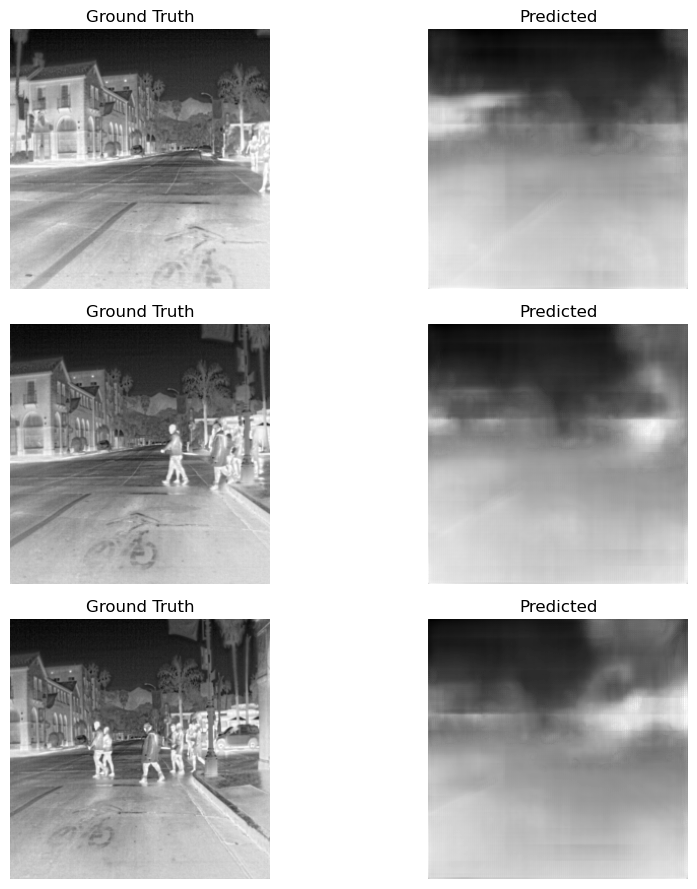

In [13]:
# Visualize a few predictions vs. ground truth
num_show = 3
plt.figure(figsize=(10, num_show * 3))
for i in range(num_show):
    plt.subplot(num_show, 2, 2*i+1)
    plt.imshow(gts[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(num_show, 2, 2*i+2)
    plt.imshow(outputs[i], cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
plt.tight_layout()
plt.show()

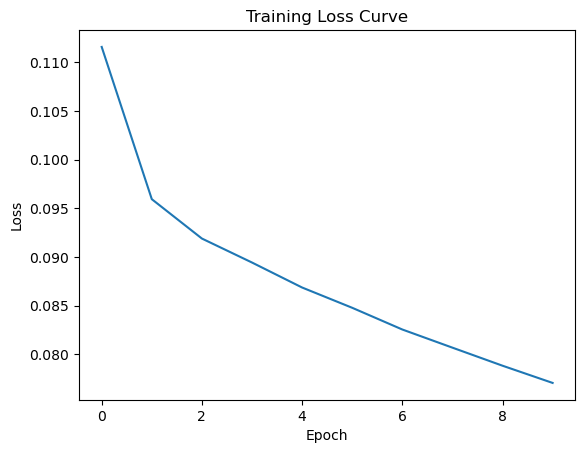

In [11]:
# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [12]:
# Save the final model (if not already done)
torch.save(model.state_dict(), 'unet_rgb2thermal_final.pth')
print("Final model saved as unet_rgb2thermal_final.pth")

Final model saved as unet_rgb2thermal_final.pth
